## Imports

In [1]:
from prophet import Prophet
import matplotlib.pyplot as plt

c:\Users\jabbe\Envs\idw\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
import itertools
import warnings

In [3]:
import pandas as pd
import numpy as np

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Hyperparameter

In [6]:
# Hyperparameter
train_days = 30
forecast_days = 2

### Data Import

In [7]:
#use csv with already preprocessed features (scaling, differnecing etc needed)
df = pd.read_csv("Data_Prep.csv", index_col=0)

### some small data checks

In [3]:
df

,Total_Heat,Hour,Day,Month,Year,Weekday,Weekend,Holiday
2008-01-01 00:00:00+00:00,98086.0,0,1,1,2008,1,0,1
2008-01-01 01:00:00+00:00,100454.0,1,1,1,2008,1,0,1
2008-01-01 02:00:00+00:00,107183.0,2,1,1,2008,1,0,1
2008-01-01 03:00:00+00:00,120688.0,3,1,1,2008,1,0,1
2008-01-01 04:00:00+00:00,158569.0,4,1,1,2008,1,0,1
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00+00:00,153908.0,19,31,12,2014,2,0,0
2014-12-31 20:00:00+00:00,139544.0,20,31,12,2014,2,0,0
2014-12-31 21:00:00+00:00,114048.0,21,31,12,2014,2,0,0
2014-12-31 22:00:00+00:00,71690.5,22,31,12,2014,2,0,0


Scaling

In [5]:
df_scaler = MinMaxScaler()
df.Total_Heat = df_scaler.fit_transform(df[["Total_Heat"]])


In [6]:
df

,Total_Heat,Hour,Day,Month,Year,Weekday,Weekend,Holiday
2008-01-01 00:00:00+00:00,0.362881,0,1,1,2008,1,0,1
2008-01-01 01:00:00+00:00,0.371961,1,1,1,2008,1,0,1
2008-01-01 02:00:00+00:00,0.397763,2,1,1,2008,1,0,1
2008-01-01 03:00:00+00:00,0.449547,3,1,1,2008,1,0,1
2008-01-01 04:00:00+00:00,0.594798,4,1,1,2008,1,0,1
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00+00:00,0.576926,19,31,12,2014,2,0,0
2014-12-31 20:00:00+00:00,0.521848,20,31,12,2014,2,0,0
2014-12-31 21:00:00+00:00,0.424086,21,31,12,2014,2,0,0
2014-12-31 22:00:00+00:00,0.261670,22,31,12,2014,2,0,0


In [7]:
df.index = pd.DatetimeIndex(df.index)

In [8]:
df.groupby(df.index.floor('d')).count().value_counts()

Total_Heat  Hour  Day  Month  Year  Weekday  Weekend  Holiday
24          24    24   24     24    24       24       24         2557
dtype: int64

In [9]:
# removing the 2 values from first year if necessary
np_array = df.Total_Heat.to_numpy()

In [10]:
np_array[:10]

array([0.36288133, 0.37196123, 0.397763  , 0.44954677, 0.59479823,
       0.70574319, 0.68270219, 0.68017914, 0.65285127, 0.62472584])

# Data wrangling in numpy format

## Creating input X and target y

Possibility 1

In [10]:
# creating tuples with x and y
arr = [
    (np_array[i-train_days*24:i], np_array[i:i+forecast_days*24]) for 
    i  in range(train_days*24, len(np_array)-forecast_days*24)
    ]

Possibility 2

In [15]:
# creating two seperate lists with a function

def create_X_y(data_array: np.array, train_days:int, forecast_days:int):
    """"""
    X_list = []
    y_list = []#

    for i in range(train_days*24, len(data_array)-forecast_days*24, 24):
        X_list.append(data_array[i-train_days*24:i])
        y_list.append(data_array[i:i+forecast_days*24])
    
    return X_list, y_list
    

In [14]:
X_list, y_list = create_X_y(np_array, train_days, forecast_days)

In [15]:
len(X_list), len(y_list)

(2525, 2525)

## Data split in train, eval, test

Should decide that on a portion of data which is not for hyperparam tuning, but is only used at the very end.  (Test-data)
-> Maybe last year of data

Could decide that one portion of data will be used for hyperparam tuning, but not for training of data. (eval-data)
-> Maybe second last year

In [33]:
np_test = np_array[-365*24-train_days*24-forecast_days*24:]
np_eval = np_array[-365*24*2-train_days*24-forecast_days*24:-365*24]
np_train = np_array[:-365*24*2]
len(np_test), len(np_eval), len(np_train)

(9528, 9528, 43848)

# SARIMAX

Arima Package used does not expect numpy arrays but dataframe

In [18]:
df_train = df.Total_Heat.iloc[:-365*24*2] 
df_train.head()

2008-01-01 00:00:00+00:00    0.362881
2008-01-01 01:00:00+00:00    0.371961
2008-01-01 02:00:00+00:00    0.397763
2008-01-01 03:00:00+00:00    0.449547
2008-01-01 04:00:00+00:00    0.594798
Name: Total_Heat, dtype: float64

<AxesSubplot:>

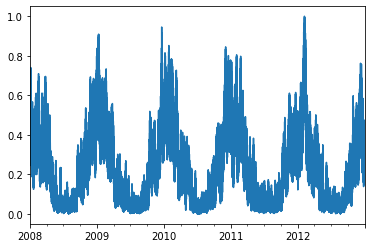

In [19]:
df_train.plot()

### Grid Search

In [23]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

In [25]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(
                df_train,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 24)12 - AIC:365068.0495737295
ARIMA(0, 0, 0)x(0, 0, 1, 24)12 - AIC:304496.00027046574
ARIMA(0, 0, 0)x(0, 1, 0, 24)12 - AIC:-11445.302040344774
ARIMA(0, 0, 0)x(0, 1, 1, 24)12 - AIC:-29762.590928906502
ARIMA(0, 0, 0)x(1, 0, 0, 24)12 - AIC:-11448.069021980515
ARIMA(0, 0, 0)x(1, 0, 1, 24)12 - AIC:-29796.491836634596
ARIMA(0, 0, 0)x(1, 1, 0, 24)12 - AIC:-25028.857708794232
ARIMA(0, 0, 0)x(1, 1, 1, 24)12 - AIC:-30558.1654242953
ARIMA(0, 0, 1)x(0, 0, 0, 24)12 - AIC:304905.1483777455
ARIMA(0, 0, 1)x(0, 0, 1, 24)12 - AIC:244479.51167597336
ARIMA(0, 0, 1)x(0, 1, 0, 24)12 - AIC:-56312.00936652609
ARIMA(0, 0, 1)x(0, 1, 1, 24)12 - AIC:-68461.1250554176
ARIMA(0, 0, 1)x(1, 0, 0, 24)12 - AIC:-10710.025830676495
ARIMA(0, 0, 1)x(1, 0, 1, 24)12 - AIC:-27920.468144691942
ARIMA(0, 0, 1)x(1, 1, 0, 24)12 - AIC:-65501.992209172
ARIMA(0, 0, 1)x(1, 1, 1, 24)12 - AIC:-68681.07849676831
ARIMA(0, 1, 0)x(0, 0, 0, 24)12 - AIC:-6027.139007366087
ARIMA(0, 1, 0)x(0, 0, 1, 24)12 - AIC:-55795.638

MemoryError: Unable to allocate 870. MiB for an array with shape (51, 51, 43848) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 988, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 870. MiB for an array with shape (51, 51, 43848) and data type float64


ARIMA(1, 0, 0)x(0, 0, 0, 24)12 - AIC:-6028.624393697981
ARIMA(1, 0, 0)x(0, 0, 1, 24)12 - AIC:-55797.98339951165
ARIMA(1, 0, 0)x(0, 1, 0, 24)12 - AIC:-129571.35392946772
ARIMA(1, 0, 0)x(0, 1, 1, 24)12 - AIC:-129486.05763116258
ARIMA(1, 0, 0)x(1, 0, 0, 24)12 - AIC:-129683.63367474225
ARIMA(1, 0, 0)x(1, 0, 1, 24)12 - AIC:-129693.09871939302
ARIMA(1, 0, 0)x(1, 1, 0, 24)12 - AIC:-129480.08388061254
ARIMA(1, 0, 0)x(1, 1, 1, 24)12 - AIC:-135315.32398123902
ARIMA(1, 0, 1)x(0, 0, 0, 24)12 - AIC:-30973.2573950086
ARIMA(1, 0, 1)x(0, 0, 1, 24)12 - AIC:-72276.04465769794
ARIMA(1, 0, 1)x(0, 1, 0, 24)12 - AIC:-129567.11866998687
ARIMA(1, 0, 1)x(0, 1, 1, 24)12 - AIC:-129482.05013878272
ARIMA(1, 0, 1)x(1, 0, 0, 24)12 - AIC:-129685.04288216753
ARIMA(1, 0, 1)x(1, 0, 1, 24)12 - AIC:-129690.9283232715
ARIMA(1, 0, 1)x(1, 1, 0, 24)12 - AIC:-129479.90831607608
ARIMA(1, 0, 1)x(1, 1, 1, 24)12 - AIC:-135320.54996058595
ARIMA(1, 1, 0)x(0, 0, 0, 24)12 - AIC:-33825.036501789386
ARIMA(1, 1, 0)x(0, 0, 1, 24)12 - AIC:

MemoryError: Unable to allocate 870. MiB for an array with shape (51, 51, 43848) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 1000, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 870. MiB for an array with shape (51, 51, 43848) and data type float64


#### Result Gridsearch

ARIMA(1, 0, 0)x(1, 1, 1, 24)12 - AIC:-135315.32398123902

ARIMA(1, 0, 1)x(1, 1, 1, 24)12 - AIC:-135320.54996058595

ARIMA(1, 0, 1)x(1, 1, 1, 24)12 - AIC:-135320.54996058595


ARIMA(1, 0, 0)x(0, 0, 1, 24)

In [27]:
optimal_order = (1, 0, 1)
optimal_seasonal_order = (1, 1, 1, 24)

Visualizations of model

In [30]:
mod =SARIMAX(
    df_small.iloc[:24*30],
    order=optimal_order,
    seasonal_order=optimal_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

c:\Users\jabbe\Envs\idw\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\jabbe\Envs\idw\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\jabbe\Envs\idw\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9843      0.008    129.591      0.000       0.969       0.999
ma.L1          0.1748      0.040      4.361      0.000       0.096       0.253
ar.S.L24       0.5533      0.017     32.854      0.000       0.520       0.586
ma.S.L24      -1.0229      0.042    -24.398      0.000      -1.105      -0.941
sigma2      4.549e-05   2.39e-06     19.060      0.000    4.08e-05    5.02e-05


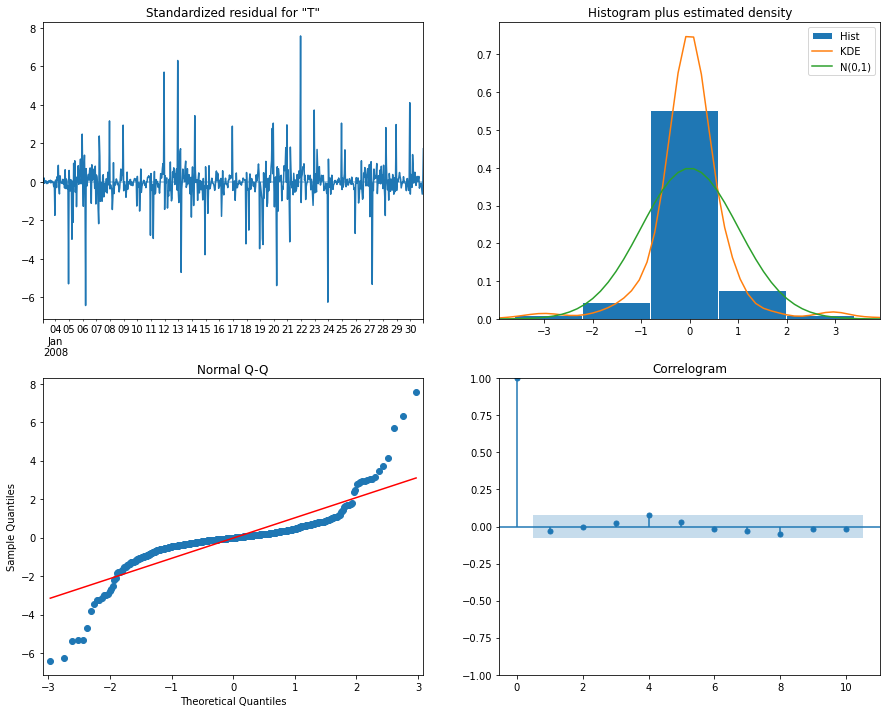

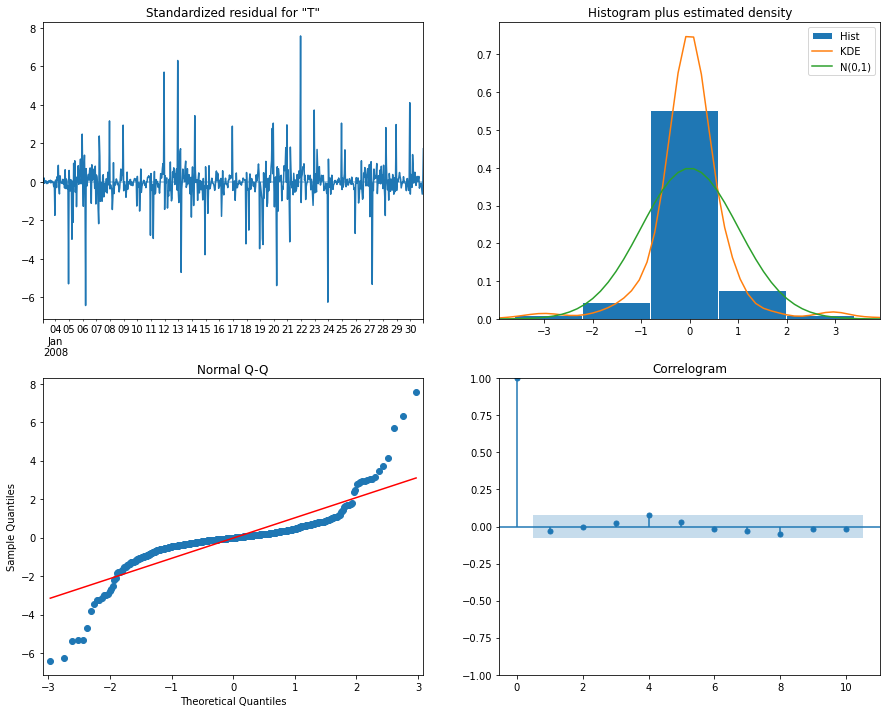

In [31]:
results.plot_diagnostics(figsize=(15, 12))

## Calculate MSE of Model in 2014

Iteratively go through the test data to calculate mean loss

In [35]:
X_list, y_list = create_X_y(np_test, train_days, forecast_days)
mse_dict={}

In [36]:
len(y_list)

365

In [38]:
mse_list = []
for X, y in zip(X_list, y_list):
    mod =SARIMAX(X,
    order=optimal_order,
    seasonal_order=optimal_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False)

    fitted_model = mod.fit()

    forecast = fitted_model.forecast(steps=48)

    mse = ((forecast - y) ** 2).mean()
    mse_list.append(mse)


mse_dict[f"SARIMAX{(1, 0, 1)}x{(1, 1, 1, 24)}"] = np.array(mse_list).mean()


c:\Users\jabbe\Envs\idw\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\jabbe\Envs\idw\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\jabbe\Envs\idw\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\jabbe\Envs\idw\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\jabbe\Envs\idw\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Lik

In [39]:
mse_dict

{'SARIMAX(1, 0, 0)x(1, 0, 1, 24)': 0.0008692357285921017}

Viz of last prediction

<AxesSubplot:>

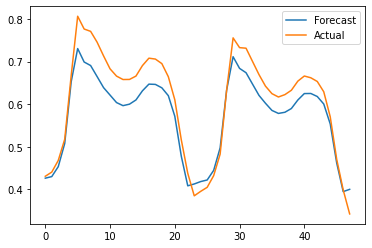

In [40]:
df_show = pd.DataFrame({"Forecast": forecast, "Actual": y})
df_show.plot()

# Prophet

Preprocessing for prophet

In [48]:
my_df = df_train.reset_index() [["index", "Total_Heat"]]
my_df.columns = ["ds", "y"]
my_df.ds = pd.to_datetime(my_df.ds).dt.tz_convert(None)

In [50]:
X_list, y_list = create_X_y(my_df, train_days, forecast_days)

In [52]:
def model_test(
    num_iterations_per_config:10,
    holidays, 
    weekly_seasonality, 
    add_daily,
    changepoint_prior_scale, 
    holidays_prior_scale, 
    month_fourier):

    mse_list = []
    for i in range(num_iterations_per_config):
      m = Prophet(
          weekly_seasonality=weekly_seasonality,
          changepoint_prior_scale=changepoint_prior_scale, 
          holidays_prior_scale=holidays_prior_scale)

      if holidays: 
          m.add_country_holidays(country_name='DE')
      
      if add_daily:    
          m.add_seasonality(
              name='daily', 
              period=24, 
              fourier_order=month_fourier)
    

      m.fit(X_list[i])
      future = m.make_future_dataframe(periods=len(y_list[i]), freq='H')
      forecast = m.predict(future)
      mse = ((forecast.iloc[-48:,-1].values - y_list[i]['y'].values)**2).mean()
      mse_list.append(mse)

    return np.array(mse_list).mean()


### Grid Search

In [53]:
# Setting the grid
holidays_opt = [True, False]
weekly_seas = [5, 10, 30, 50]
add_daily = [True, False]
changepoint_prior_scale = [0.1, 0.3, 0.5]
holidays_prior_scale = [0.1, 0.3, 0.5]
month_fourier = [5, 10, 30, 50]

In [54]:
# Looping through the grid
grid_results = []
for h in holidays_opt:
  for w in weekly_seas:
    for d in add_daily:
      for c in changepoint_prior_scale:
        for hp in holidays_prior_scale:
          for mf in month_fourier:
            mse=model_test(10,h,w,d,c,hp,mf)
            print([h,w,d, c,hp,mf,mse])
            grid_results.append([h,w,d, c,hp,mf,mse])

17:41:12 - cmdstanpy - INFO - Chain [1] start processing
17:41:12 - cmdstanpy - INFO - Chain [1] done processing
17:41:13 - cmdstanpy - INFO - Chain [1] start processing
17:41:13 - cmdstanpy - INFO - Chain [1] done processing
17:41:13 - cmdstanpy - INFO - Chain [1] start processing
17:41:13 - cmdstanpy - INFO - Chain [1] done processing
17:41:14 - cmdstanpy - INFO - Chain [1] start processing
17:41:14 - cmdstanpy - INFO - Chain [1] done processing
17:41:14 - cmdstanpy - INFO - Chain [1] start processing
17:41:14 - cmdstanpy - INFO - Chain [1] done processing
17:41:15 - cmdstanpy - INFO - Chain [1] start processing
17:41:15 - cmdstanpy - INFO - Chain [1] done processing
17:41:15 - cmdstanpy - INFO - Chain [1] start processing
17:41:16 - cmdstanpy - INFO - Chain [1] done processing
17:41:16 - cmdstanpy - INFO - Chain [1] start processing
17:41:16 - cmdstanpy - INFO - Chain [1] done processing
17:41:17 - cmdstanpy - INFO - Chain [1] start processing
17:41:17 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.1, 5, 0.026757058589824134]


17:41:18 - cmdstanpy - INFO - Chain [1] start processing
17:41:18 - cmdstanpy - INFO - Chain [1] done processing
17:41:18 - cmdstanpy - INFO - Chain [1] start processing
17:41:19 - cmdstanpy - INFO - Chain [1] done processing
17:41:19 - cmdstanpy - INFO - Chain [1] start processing
17:41:19 - cmdstanpy - INFO - Chain [1] done processing
17:41:20 - cmdstanpy - INFO - Chain [1] start processing
17:41:20 - cmdstanpy - INFO - Chain [1] done processing
17:41:20 - cmdstanpy - INFO - Chain [1] start processing
17:41:21 - cmdstanpy - INFO - Chain [1] done processing
17:41:21 - cmdstanpy - INFO - Chain [1] start processing
17:41:21 - cmdstanpy - INFO - Chain [1] done processing
17:41:22 - cmdstanpy - INFO - Chain [1] start processing
17:41:22 - cmdstanpy - INFO - Chain [1] done processing
17:41:22 - cmdstanpy - INFO - Chain [1] start processing
17:41:22 - cmdstanpy - INFO - Chain [1] done processing
17:41:23 - cmdstanpy - INFO - Chain [1] start processing
17:41:23 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.1, 10, 0.034152838836556045]


17:41:24 - cmdstanpy - INFO - Chain [1] start processing
17:41:24 - cmdstanpy - INFO - Chain [1] done processing
17:41:25 - cmdstanpy - INFO - Chain [1] start processing
17:41:25 - cmdstanpy - INFO - Chain [1] done processing
17:41:26 - cmdstanpy - INFO - Chain [1] start processing
17:41:26 - cmdstanpy - INFO - Chain [1] done processing
17:41:27 - cmdstanpy - INFO - Chain [1] start processing
17:41:27 - cmdstanpy - INFO - Chain [1] done processing
17:41:27 - cmdstanpy - INFO - Chain [1] start processing
17:41:27 - cmdstanpy - INFO - Chain [1] done processing
17:41:28 - cmdstanpy - INFO - Chain [1] start processing
17:41:28 - cmdstanpy - INFO - Chain [1] done processing
17:41:29 - cmdstanpy - INFO - Chain [1] start processing
17:41:29 - cmdstanpy - INFO - Chain [1] done processing
17:41:29 - cmdstanpy - INFO - Chain [1] start processing
17:41:30 - cmdstanpy - INFO - Chain [1] done processing
17:41:30 - cmdstanpy - INFO - Chain [1] start processing
17:41:30 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.1, 30, 0.026776835299578187]


17:41:32 - cmdstanpy - INFO - Chain [1] start processing
17:41:32 - cmdstanpy - INFO - Chain [1] done processing
17:41:32 - cmdstanpy - INFO - Chain [1] start processing
17:41:33 - cmdstanpy - INFO - Chain [1] done processing
17:41:33 - cmdstanpy - INFO - Chain [1] start processing
17:41:33 - cmdstanpy - INFO - Chain [1] done processing
17:41:34 - cmdstanpy - INFO - Chain [1] start processing
17:41:34 - cmdstanpy - INFO - Chain [1] done processing
17:41:35 - cmdstanpy - INFO - Chain [1] start processing
17:41:35 - cmdstanpy - INFO - Chain [1] done processing
17:41:36 - cmdstanpy - INFO - Chain [1] start processing
17:41:36 - cmdstanpy - INFO - Chain [1] done processing
17:41:37 - cmdstanpy - INFO - Chain [1] start processing
17:41:37 - cmdstanpy - INFO - Chain [1] done processing
17:41:38 - cmdstanpy - INFO - Chain [1] start processing
17:41:38 - cmdstanpy - INFO - Chain [1] done processing
17:41:39 - cmdstanpy - INFO - Chain [1] start processing
17:41:39 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.1, 50, 0.024043809557703015]


17:41:40 - cmdstanpy - INFO - Chain [1] start processing
17:41:40 - cmdstanpy - INFO - Chain [1] done processing
17:41:41 - cmdstanpy - INFO - Chain [1] start processing
17:41:41 - cmdstanpy - INFO - Chain [1] done processing
17:41:42 - cmdstanpy - INFO - Chain [1] start processing
17:41:42 - cmdstanpy - INFO - Chain [1] done processing
17:41:42 - cmdstanpy - INFO - Chain [1] start processing
17:41:42 - cmdstanpy - INFO - Chain [1] done processing
17:41:42 - cmdstanpy - INFO - Chain [1] start processing
17:41:43 - cmdstanpy - INFO - Chain [1] done processing
17:41:43 - cmdstanpy - INFO - Chain [1] start processing
17:41:43 - cmdstanpy - INFO - Chain [1] done processing
17:41:44 - cmdstanpy - INFO - Chain [1] start processing
17:41:44 - cmdstanpy - INFO - Chain [1] done processing
17:41:44 - cmdstanpy - INFO - Chain [1] start processing
17:41:44 - cmdstanpy - INFO - Chain [1] done processing
17:41:45 - cmdstanpy - INFO - Chain [1] start processing
17:41:45 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.3, 5, 0.026601585566322562]


17:41:46 - cmdstanpy - INFO - Chain [1] start processing
17:41:46 - cmdstanpy - INFO - Chain [1] done processing
17:41:46 - cmdstanpy - INFO - Chain [1] start processing
17:41:47 - cmdstanpy - INFO - Chain [1] done processing
17:41:47 - cmdstanpy - INFO - Chain [1] start processing
17:41:47 - cmdstanpy - INFO - Chain [1] done processing
17:41:47 - cmdstanpy - INFO - Chain [1] start processing
17:41:47 - cmdstanpy - INFO - Chain [1] done processing
17:41:48 - cmdstanpy - INFO - Chain [1] start processing
17:41:48 - cmdstanpy - INFO - Chain [1] done processing
17:41:48 - cmdstanpy - INFO - Chain [1] start processing
17:41:48 - cmdstanpy - INFO - Chain [1] done processing
17:41:49 - cmdstanpy - INFO - Chain [1] start processing
17:41:49 - cmdstanpy - INFO - Chain [1] done processing
17:41:49 - cmdstanpy - INFO - Chain [1] start processing
17:41:49 - cmdstanpy - INFO - Chain [1] done processing
17:41:50 - cmdstanpy - INFO - Chain [1] start processing
17:41:50 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.3, 10, 0.03452578966510505]


17:41:51 - cmdstanpy - INFO - Chain [1] start processing
17:41:51 - cmdstanpy - INFO - Chain [1] done processing
17:41:52 - cmdstanpy - INFO - Chain [1] start processing
17:41:52 - cmdstanpy - INFO - Chain [1] done processing
17:41:53 - cmdstanpy - INFO - Chain [1] start processing
17:41:53 - cmdstanpy - INFO - Chain [1] done processing
17:41:54 - cmdstanpy - INFO - Chain [1] start processing
17:41:54 - cmdstanpy - INFO - Chain [1] done processing
17:41:54 - cmdstanpy - INFO - Chain [1] start processing
17:41:54 - cmdstanpy - INFO - Chain [1] done processing
17:41:55 - cmdstanpy - INFO - Chain [1] start processing
17:41:55 - cmdstanpy - INFO - Chain [1] done processing
17:41:56 - cmdstanpy - INFO - Chain [1] start processing
17:41:56 - cmdstanpy - INFO - Chain [1] done processing
17:41:57 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1] done processing
17:41:57 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.3, 30, 0.026819985573178586]


17:41:59 - cmdstanpy - INFO - Chain [1] start processing
17:41:59 - cmdstanpy - INFO - Chain [1] done processing
17:42:00 - cmdstanpy - INFO - Chain [1] start processing
17:42:00 - cmdstanpy - INFO - Chain [1] done processing
17:42:01 - cmdstanpy - INFO - Chain [1] start processing
17:42:01 - cmdstanpy - INFO - Chain [1] done processing
17:42:02 - cmdstanpy - INFO - Chain [1] start processing
17:42:02 - cmdstanpy - INFO - Chain [1] done processing
17:42:02 - cmdstanpy - INFO - Chain [1] start processing
17:42:02 - cmdstanpy - INFO - Chain [1] done processing
17:42:03 - cmdstanpy - INFO - Chain [1] start processing
17:42:03 - cmdstanpy - INFO - Chain [1] done processing
17:42:04 - cmdstanpy - INFO - Chain [1] start processing
17:42:04 - cmdstanpy - INFO - Chain [1] done processing
17:42:05 - cmdstanpy - INFO - Chain [1] start processing
17:42:05 - cmdstanpy - INFO - Chain [1] done processing
17:42:06 - cmdstanpy - INFO - Chain [1] start processing
17:42:06 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.3, 50, 0.024112698104618545]


17:42:07 - cmdstanpy - INFO - Chain [1] start processing
17:42:07 - cmdstanpy - INFO - Chain [1] done processing
17:42:08 - cmdstanpy - INFO - Chain [1] start processing
17:42:08 - cmdstanpy - INFO - Chain [1] done processing
17:42:08 - cmdstanpy - INFO - Chain [1] start processing
17:42:08 - cmdstanpy - INFO - Chain [1] done processing
17:42:09 - cmdstanpy - INFO - Chain [1] start processing
17:42:09 - cmdstanpy - INFO - Chain [1] done processing
17:42:10 - cmdstanpy - INFO - Chain [1] start processing
17:42:10 - cmdstanpy - INFO - Chain [1] done processing
17:42:10 - cmdstanpy - INFO - Chain [1] start processing
17:42:10 - cmdstanpy - INFO - Chain [1] done processing
17:42:11 - cmdstanpy - INFO - Chain [1] start processing
17:42:11 - cmdstanpy - INFO - Chain [1] done processing
17:42:11 - cmdstanpy - INFO - Chain [1] start processing
17:42:11 - cmdstanpy - INFO - Chain [1] done processing
17:42:12 - cmdstanpy - INFO - Chain [1] start processing
17:42:12 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.5, 5, 0.026606867372826616]


17:42:13 - cmdstanpy - INFO - Chain [1] start processing
17:42:13 - cmdstanpy - INFO - Chain [1] done processing
17:42:14 - cmdstanpy - INFO - Chain [1] start processing
17:42:14 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] start processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] start processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:16 - cmdstanpy - INFO - Chain [1] start processing
17:42:16 - cmdstanpy - INFO - Chain [1] done processing
17:42:16 - cmdstanpy - INFO - Chain [1] start processing
17:42:16 - cmdstanpy - INFO - Chain [1] done processing
17:42:17 - cmdstanpy - INFO - Chain [1] start processing
17:42:17 - cmdstanpy - INFO - Chain [1] done processing
17:42:18 - cmdstanpy - INFO - Chain [1] start processing
17:42:18 - cmdstanpy - INFO - Chain [1] done processing
17:42:18 - cmdstanpy - INFO - Chain [1] start processing
17:42:18 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.5, 10, 0.0346536390792037]


17:42:19 - cmdstanpy - INFO - Chain [1] start processing
17:42:19 - cmdstanpy - INFO - Chain [1] done processing
17:42:20 - cmdstanpy - INFO - Chain [1] start processing
17:42:20 - cmdstanpy - INFO - Chain [1] done processing
17:42:20 - cmdstanpy - INFO - Chain [1] start processing
17:42:20 - cmdstanpy - INFO - Chain [1] done processing
17:42:21 - cmdstanpy - INFO - Chain [1] start processing
17:42:21 - cmdstanpy - INFO - Chain [1] done processing
17:42:22 - cmdstanpy - INFO - Chain [1] start processing
17:42:22 - cmdstanpy - INFO - Chain [1] done processing
17:42:22 - cmdstanpy - INFO - Chain [1] start processing
17:42:22 - cmdstanpy - INFO - Chain [1] done processing
17:42:23 - cmdstanpy - INFO - Chain [1] start processing
17:42:23 - cmdstanpy - INFO - Chain [1] done processing
17:42:23 - cmdstanpy - INFO - Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1] done processing
17:42:24 - cmdstanpy - INFO - Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.5, 30, 0.026758834414584903]


17:42:25 - cmdstanpy - INFO - Chain [1] start processing
17:42:26 - cmdstanpy - INFO - Chain [1] done processing
17:42:26 - cmdstanpy - INFO - Chain [1] start processing
17:42:26 - cmdstanpy - INFO - Chain [1] done processing
17:42:27 - cmdstanpy - INFO - Chain [1] start processing
17:42:27 - cmdstanpy - INFO - Chain [1] done processing
17:42:28 - cmdstanpy - INFO - Chain [1] start processing
17:42:28 - cmdstanpy - INFO - Chain [1] done processing
17:42:28 - cmdstanpy - INFO - Chain [1] start processing
17:42:28 - cmdstanpy - INFO - Chain [1] done processing
17:42:29 - cmdstanpy - INFO - Chain [1] start processing
17:42:29 - cmdstanpy - INFO - Chain [1] done processing
17:42:30 - cmdstanpy - INFO - Chain [1] start processing
17:42:30 - cmdstanpy - INFO - Chain [1] done processing
17:42:30 - cmdstanpy - INFO - Chain [1] start processing
17:42:31 - cmdstanpy - INFO - Chain [1] done processing
17:42:31 - cmdstanpy - INFO - Chain [1] start processing
17:42:31 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.5, 50, 0.024148402077753855]


17:42:32 - cmdstanpy - INFO - Chain [1] start processing
17:42:33 - cmdstanpy - INFO - Chain [1] done processing
17:42:33 - cmdstanpy - INFO - Chain [1] start processing
17:42:33 - cmdstanpy - INFO - Chain [1] done processing
17:42:34 - cmdstanpy - INFO - Chain [1] start processing
17:42:34 - cmdstanpy - INFO - Chain [1] done processing
17:42:34 - cmdstanpy - INFO - Chain [1] start processing
17:42:34 - cmdstanpy - INFO - Chain [1] done processing
17:42:35 - cmdstanpy - INFO - Chain [1] start processing
17:42:35 - cmdstanpy - INFO - Chain [1] done processing
17:42:35 - cmdstanpy - INFO - Chain [1] start processing
17:42:35 - cmdstanpy - INFO - Chain [1] done processing
17:42:36 - cmdstanpy - INFO - Chain [1] start processing
17:42:36 - cmdstanpy - INFO - Chain [1] done processing
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.1, 5, 0.02220746444446562]


17:42:38 - cmdstanpy - INFO - Chain [1] start processing
17:42:39 - cmdstanpy - INFO - Chain [1] done processing
17:42:39 - cmdstanpy - INFO - Chain [1] start processing
17:42:39 - cmdstanpy - INFO - Chain [1] done processing
17:42:40 - cmdstanpy - INFO - Chain [1] start processing
17:42:40 - cmdstanpy - INFO - Chain [1] done processing
17:42:40 - cmdstanpy - INFO - Chain [1] start processing
17:42:40 - cmdstanpy - INFO - Chain [1] done processing
17:42:41 - cmdstanpy - INFO - Chain [1] start processing
17:42:41 - cmdstanpy - INFO - Chain [1] done processing
17:42:42 - cmdstanpy - INFO - Chain [1] start processing
17:42:42 - cmdstanpy - INFO - Chain [1] done processing
17:42:42 - cmdstanpy - INFO - Chain [1] start processing
17:42:42 - cmdstanpy - INFO - Chain [1] done processing
17:42:43 - cmdstanpy - INFO - Chain [1] start processing
17:42:43 - cmdstanpy - INFO - Chain [1] done processing
17:42:44 - cmdstanpy - INFO - Chain [1] start processing
17:42:44 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.1, 10, 0.03335248938544507]


17:42:45 - cmdstanpy - INFO - Chain [1] start processing
17:42:45 - cmdstanpy - INFO - Chain [1] done processing
17:42:46 - cmdstanpy - INFO - Chain [1] start processing
17:42:46 - cmdstanpy - INFO - Chain [1] done processing
17:42:46 - cmdstanpy - INFO - Chain [1] start processing
17:42:46 - cmdstanpy - INFO - Chain [1] done processing
17:42:47 - cmdstanpy - INFO - Chain [1] start processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:48 - cmdstanpy - INFO - Chain [1] start processing
17:42:48 - cmdstanpy - INFO - Chain [1] done processing
17:42:48 - cmdstanpy - INFO - Chain [1] start processing
17:42:49 - cmdstanpy - INFO - Chain [1] done processing
17:42:49 - cmdstanpy - INFO - Chain [1] start processing
17:42:49 - cmdstanpy - INFO - Chain [1] done processing
17:42:50 - cmdstanpy - INFO - Chain [1] start processing
17:42:50 - cmdstanpy - INFO - Chain [1] done processing
17:42:51 - cmdstanpy - INFO - Chain [1] start processing
17:42:51 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.1, 30, 0.02621344093765644]


17:42:52 - cmdstanpy - INFO - Chain [1] start processing
17:42:52 - cmdstanpy - INFO - Chain [1] done processing
17:42:53 - cmdstanpy - INFO - Chain [1] start processing
17:42:53 - cmdstanpy - INFO - Chain [1] done processing
17:42:54 - cmdstanpy - INFO - Chain [1] start processing
17:42:54 - cmdstanpy - INFO - Chain [1] done processing
17:42:55 - cmdstanpy - INFO - Chain [1] start processing
17:42:55 - cmdstanpy - INFO - Chain [1] done processing
17:42:56 - cmdstanpy - INFO - Chain [1] start processing
17:42:56 - cmdstanpy - INFO - Chain [1] done processing
17:42:57 - cmdstanpy - INFO - Chain [1] start processing
17:42:57 - cmdstanpy - INFO - Chain [1] done processing
17:42:58 - cmdstanpy - INFO - Chain [1] start processing
17:42:58 - cmdstanpy - INFO - Chain [1] done processing
17:42:58 - cmdstanpy - INFO - Chain [1] start processing
17:42:59 - cmdstanpy - INFO - Chain [1] done processing
17:42:59 - cmdstanpy - INFO - Chain [1] start processing
17:42:59 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.1, 50, 0.03966240898287503]


17:43:01 - cmdstanpy - INFO - Chain [1] start processing
17:43:01 - cmdstanpy - INFO - Chain [1] done processing
17:43:01 - cmdstanpy - INFO - Chain [1] start processing
17:43:01 - cmdstanpy - INFO - Chain [1] done processing
17:43:02 - cmdstanpy - INFO - Chain [1] start processing
17:43:02 - cmdstanpy - INFO - Chain [1] done processing
17:43:03 - cmdstanpy - INFO - Chain [1] start processing
17:43:03 - cmdstanpy - INFO - Chain [1] done processing
17:43:03 - cmdstanpy - INFO - Chain [1] start processing
17:43:03 - cmdstanpy - INFO - Chain [1] done processing
17:43:04 - cmdstanpy - INFO - Chain [1] start processing
17:43:04 - cmdstanpy - INFO - Chain [1] done processing
17:43:04 - cmdstanpy - INFO - Chain [1] start processing
17:43:05 - cmdstanpy - INFO - Chain [1] done processing
17:43:05 - cmdstanpy - INFO - Chain [1] start processing
17:43:05 - cmdstanpy - INFO - Chain [1] done processing
17:43:06 - cmdstanpy - INFO - Chain [1] start processing
17:43:06 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.3, 5, 0.02213758193619005]


17:43:07 - cmdstanpy - INFO - Chain [1] start processing
17:43:07 - cmdstanpy - INFO - Chain [1] done processing
17:43:08 - cmdstanpy - INFO - Chain [1] start processing
17:43:08 - cmdstanpy - INFO - Chain [1] done processing
17:43:09 - cmdstanpy - INFO - Chain [1] start processing
17:43:09 - cmdstanpy - INFO - Chain [1] done processing
17:43:09 - cmdstanpy - INFO - Chain [1] start processing
17:43:09 - cmdstanpy - INFO - Chain [1] done processing
17:43:10 - cmdstanpy - INFO - Chain [1] start processing
17:43:10 - cmdstanpy - INFO - Chain [1] done processing
17:43:10 - cmdstanpy - INFO - Chain [1] start processing
17:43:11 - cmdstanpy - INFO - Chain [1] done processing
17:43:11 - cmdstanpy - INFO - Chain [1] start processing
17:43:11 - cmdstanpy - INFO - Chain [1] done processing
17:43:12 - cmdstanpy - INFO - Chain [1] start processing
17:43:12 - cmdstanpy - INFO - Chain [1] done processing
17:43:12 - cmdstanpy - INFO - Chain [1] start processing
17:43:12 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.3, 10, 0.03392440369654747]


17:43:14 - cmdstanpy - INFO - Chain [1] start processing
17:43:14 - cmdstanpy - INFO - Chain [1] done processing
17:43:14 - cmdstanpy - INFO - Chain [1] start processing
17:43:14 - cmdstanpy - INFO - Chain [1] done processing
17:43:15 - cmdstanpy - INFO - Chain [1] start processing
17:43:15 - cmdstanpy - INFO - Chain [1] done processing
17:43:16 - cmdstanpy - INFO - Chain [1] start processing
17:43:16 - cmdstanpy - INFO - Chain [1] done processing
17:43:17 - cmdstanpy - INFO - Chain [1] start processing
17:43:17 - cmdstanpy - INFO - Chain [1] done processing
17:43:17 - cmdstanpy - INFO - Chain [1] start processing
17:43:17 - cmdstanpy - INFO - Chain [1] done processing
17:43:18 - cmdstanpy - INFO - Chain [1] start processing
17:43:18 - cmdstanpy - INFO - Chain [1] done processing
17:43:19 - cmdstanpy - INFO - Chain [1] start processing
17:43:19 - cmdstanpy - INFO - Chain [1] done processing
17:43:19 - cmdstanpy - INFO - Chain [1] start processing
17:43:19 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.3, 30, 0.02672513021604067]


17:43:21 - cmdstanpy - INFO - Chain [1] start processing
17:43:21 - cmdstanpy - INFO - Chain [1] done processing
17:43:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:22 - cmdstanpy - INFO - Chain [1] done processing
17:43:23 - cmdstanpy - INFO - Chain [1] start processing
17:43:23 - cmdstanpy - INFO - Chain [1] done processing
17:43:24 - cmdstanpy - INFO - Chain [1] start processing
17:43:24 - cmdstanpy - INFO - Chain [1] done processing
17:43:25 - cmdstanpy - INFO - Chain [1] start processing
17:43:25 - cmdstanpy - INFO - Chain [1] done processing
17:43:26 - cmdstanpy - INFO - Chain [1] start processing
17:43:26 - cmdstanpy - INFO - Chain [1] done processing
17:43:26 - cmdstanpy - INFO - Chain [1] start processing
17:43:27 - cmdstanpy - INFO - Chain [1] done processing
17:43:27 - cmdstanpy - INFO - Chain [1] start processing
17:43:28 - cmdstanpy - INFO - Chain [1] done processing
17:43:28 - cmdstanpy - INFO - Chain [1] start processing
17:43:29 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.3, 50, 0.03976287595875864]


17:43:30 - cmdstanpy - INFO - Chain [1] start processing
17:43:30 - cmdstanpy - INFO - Chain [1] done processing
17:43:31 - cmdstanpy - INFO - Chain [1] start processing
17:43:31 - cmdstanpy - INFO - Chain [1] done processing
17:43:31 - cmdstanpy - INFO - Chain [1] start processing
17:43:31 - cmdstanpy - INFO - Chain [1] done processing
17:43:32 - cmdstanpy - INFO - Chain [1] start processing
17:43:32 - cmdstanpy - INFO - Chain [1] done processing
17:43:33 - cmdstanpy - INFO - Chain [1] start processing
17:43:33 - cmdstanpy - INFO - Chain [1] done processing
17:43:33 - cmdstanpy - INFO - Chain [1] start processing
17:43:33 - cmdstanpy - INFO - Chain [1] done processing
17:43:34 - cmdstanpy - INFO - Chain [1] start processing
17:43:34 - cmdstanpy - INFO - Chain [1] done processing
17:43:35 - cmdstanpy - INFO - Chain [1] start processing
17:43:35 - cmdstanpy - INFO - Chain [1] done processing
17:43:35 - cmdstanpy - INFO - Chain [1] start processing
17:43:35 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.5, 5, 0.022141850011207748]


17:43:37 - cmdstanpy - INFO - Chain [1] start processing
17:43:37 - cmdstanpy - INFO - Chain [1] done processing
17:43:37 - cmdstanpy - INFO - Chain [1] start processing
17:43:37 - cmdstanpy - INFO - Chain [1] done processing
17:43:38 - cmdstanpy - INFO - Chain [1] start processing
17:43:38 - cmdstanpy - INFO - Chain [1] done processing
17:43:38 - cmdstanpy - INFO - Chain [1] start processing
17:43:38 - cmdstanpy - INFO - Chain [1] done processing
17:43:39 - cmdstanpy - INFO - Chain [1] start processing
17:43:39 - cmdstanpy - INFO - Chain [1] done processing
17:43:40 - cmdstanpy - INFO - Chain [1] start processing
17:43:40 - cmdstanpy - INFO - Chain [1] done processing
17:43:40 - cmdstanpy - INFO - Chain [1] start processing
17:43:40 - cmdstanpy - INFO - Chain [1] done processing
17:43:41 - cmdstanpy - INFO - Chain [1] start processing
17:43:41 - cmdstanpy - INFO - Chain [1] done processing
17:43:41 - cmdstanpy - INFO - Chain [1] start processing
17:43:42 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.5, 10, 0.03394612895935233]


17:43:43 - cmdstanpy - INFO - Chain [1] start processing
17:43:43 - cmdstanpy - INFO - Chain [1] done processing
17:43:44 - cmdstanpy - INFO - Chain [1] start processing
17:43:44 - cmdstanpy - INFO - Chain [1] done processing
17:43:45 - cmdstanpy - INFO - Chain [1] start processing
17:43:45 - cmdstanpy - INFO - Chain [1] done processing
17:43:45 - cmdstanpy - INFO - Chain [1] start processing
17:43:45 - cmdstanpy - INFO - Chain [1] done processing
17:43:46 - cmdstanpy - INFO - Chain [1] start processing
17:43:46 - cmdstanpy - INFO - Chain [1] done processing
17:43:47 - cmdstanpy - INFO - Chain [1] start processing
17:43:47 - cmdstanpy - INFO - Chain [1] done processing
17:43:48 - cmdstanpy - INFO - Chain [1] start processing
17:43:48 - cmdstanpy - INFO - Chain [1] done processing
17:43:48 - cmdstanpy - INFO - Chain [1] start processing
17:43:48 - cmdstanpy - INFO - Chain [1] done processing
17:43:49 - cmdstanpy - INFO - Chain [1] start processing
17:43:49 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.5, 30, 0.02674972605191196]


17:43:50 - cmdstanpy - INFO - Chain [1] start processing
17:43:51 - cmdstanpy - INFO - Chain [1] done processing
17:43:51 - cmdstanpy - INFO - Chain [1] start processing
17:43:51 - cmdstanpy - INFO - Chain [1] done processing
17:43:52 - cmdstanpy - INFO - Chain [1] start processing
17:43:52 - cmdstanpy - INFO - Chain [1] done processing
17:43:53 - cmdstanpy - INFO - Chain [1] start processing
17:43:53 - cmdstanpy - INFO - Chain [1] done processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] done processing
17:43:55 - cmdstanpy - INFO - Chain [1] start processing
17:43:55 - cmdstanpy - INFO - Chain [1] done processing
17:43:56 - cmdstanpy - INFO - Chain [1] start processing
17:43:56 - cmdstanpy - INFO - Chain [1] done processing
17:43:57 - cmdstanpy - INFO - Chain [1] start processing
17:43:57 - cmdstanpy - INFO - Chain [1] done processing
17:43:57 - cmdstanpy - INFO - Chain [1] start processing
17:43:58 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.5, 50, 0.0397606510902328]


17:43:59 - cmdstanpy - INFO - Chain [1] start processing
17:43:59 - cmdstanpy - INFO - Chain [1] done processing
17:43:59 - cmdstanpy - INFO - Chain [1] start processing
17:44:00 - cmdstanpy - INFO - Chain [1] done processing
17:44:00 - cmdstanpy - INFO - Chain [1] start processing
17:44:00 - cmdstanpy - INFO - Chain [1] done processing
17:44:01 - cmdstanpy - INFO - Chain [1] start processing
17:44:01 - cmdstanpy - INFO - Chain [1] done processing
17:44:01 - cmdstanpy - INFO - Chain [1] start processing
17:44:02 - cmdstanpy - INFO - Chain [1] done processing
17:44:02 - cmdstanpy - INFO - Chain [1] start processing
17:44:02 - cmdstanpy - INFO - Chain [1] done processing
17:44:03 - cmdstanpy - INFO - Chain [1] start processing
17:44:03 - cmdstanpy - INFO - Chain [1] done processing
17:44:04 - cmdstanpy - INFO - Chain [1] start processing
17:44:04 - cmdstanpy - INFO - Chain [1] done processing
17:44:04 - cmdstanpy - INFO - Chain [1] start processing
17:44:04 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.1, 5, 0.02157541125235691]


17:44:05 - cmdstanpy - INFO - Chain [1] start processing
17:44:06 - cmdstanpy - INFO - Chain [1] done processing
17:44:06 - cmdstanpy - INFO - Chain [1] start processing
17:44:06 - cmdstanpy - INFO - Chain [1] done processing
17:44:07 - cmdstanpy - INFO - Chain [1] start processing
17:44:07 - cmdstanpy - INFO - Chain [1] done processing
17:44:07 - cmdstanpy - INFO - Chain [1] start processing
17:44:07 - cmdstanpy - INFO - Chain [1] done processing
17:44:08 - cmdstanpy - INFO - Chain [1] start processing
17:44:08 - cmdstanpy - INFO - Chain [1] done processing
17:44:09 - cmdstanpy - INFO - Chain [1] start processing
17:44:09 - cmdstanpy - INFO - Chain [1] done processing
17:44:09 - cmdstanpy - INFO - Chain [1] start processing
17:44:10 - cmdstanpy - INFO - Chain [1] done processing
17:44:10 - cmdstanpy - INFO - Chain [1] start processing
17:44:10 - cmdstanpy - INFO - Chain [1] done processing
17:44:11 - cmdstanpy - INFO - Chain [1] start processing
17:44:11 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.1, 10, 0.0335661382301869]


17:44:12 - cmdstanpy - INFO - Chain [1] start processing
17:44:12 - cmdstanpy - INFO - Chain [1] done processing
17:44:13 - cmdstanpy - INFO - Chain [1] start processing
17:44:13 - cmdstanpy - INFO - Chain [1] done processing
17:44:14 - cmdstanpy - INFO - Chain [1] start processing
17:44:14 - cmdstanpy - INFO - Chain [1] done processing
17:44:15 - cmdstanpy - INFO - Chain [1] start processing
17:44:15 - cmdstanpy - INFO - Chain [1] done processing
17:44:16 - cmdstanpy - INFO - Chain [1] start processing
17:44:16 - cmdstanpy - INFO - Chain [1] done processing
17:44:17 - cmdstanpy - INFO - Chain [1] start processing
17:44:17 - cmdstanpy - INFO - Chain [1] done processing
17:44:17 - cmdstanpy - INFO - Chain [1] start processing
17:44:18 - cmdstanpy - INFO - Chain [1] done processing
17:44:18 - cmdstanpy - INFO - Chain [1] start processing
17:44:18 - cmdstanpy - INFO - Chain [1] done processing
17:44:19 - cmdstanpy - INFO - Chain [1] start processing
17:44:19 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.1, 30, 0.026424563525567275]


17:44:21 - cmdstanpy - INFO - Chain [1] start processing
17:44:21 - cmdstanpy - INFO - Chain [1] done processing
17:44:22 - cmdstanpy - INFO - Chain [1] start processing
17:44:22 - cmdstanpy - INFO - Chain [1] done processing
17:44:23 - cmdstanpy - INFO - Chain [1] start processing
17:44:23 - cmdstanpy - INFO - Chain [1] done processing
17:44:24 - cmdstanpy - INFO - Chain [1] start processing
17:44:24 - cmdstanpy - INFO - Chain [1] done processing
17:44:25 - cmdstanpy - INFO - Chain [1] start processing
17:44:25 - cmdstanpy - INFO - Chain [1] done processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] done processing
17:44:27 - cmdstanpy - INFO - Chain [1] start processing
17:44:27 - cmdstanpy - INFO - Chain [1] done processing
17:44:28 - cmdstanpy - INFO - Chain [1] start processing
17:44:28 - cmdstanpy - INFO - Chain [1] done processing
17:44:29 - cmdstanpy - INFO - Chain [1] start processing
17:44:29 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.1, 50, 0.08734966836683004]


17:44:30 - cmdstanpy - INFO - Chain [1] start processing
17:44:30 - cmdstanpy - INFO - Chain [1] done processing
17:44:31 - cmdstanpy - INFO - Chain [1] start processing
17:44:31 - cmdstanpy - INFO - Chain [1] done processing
17:44:32 - cmdstanpy - INFO - Chain [1] start processing
17:44:32 - cmdstanpy - INFO - Chain [1] done processing
17:44:32 - cmdstanpy - INFO - Chain [1] start processing
17:44:32 - cmdstanpy - INFO - Chain [1] done processing
17:44:33 - cmdstanpy - INFO - Chain [1] start processing
17:44:33 - cmdstanpy - INFO - Chain [1] done processing
17:44:34 - cmdstanpy - INFO - Chain [1] start processing
17:44:34 - cmdstanpy - INFO - Chain [1] done processing
17:44:34 - cmdstanpy - INFO - Chain [1] start processing
17:44:34 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:35 - cmdstanpy - INFO - Chain [1] done processing
17:44:36 - cmdstanpy - INFO - Chain [1] start processing
17:44:36 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.3, 5, 0.021518884887780337]


17:44:38 - cmdstanpy - INFO - Chain [1] start processing
17:44:38 - cmdstanpy - INFO - Chain [1] done processing
17:44:39 - cmdstanpy - INFO - Chain [1] start processing
17:44:39 - cmdstanpy - INFO - Chain [1] done processing
17:44:39 - cmdstanpy - INFO - Chain [1] start processing
17:44:40 - cmdstanpy - INFO - Chain [1] done processing
17:44:40 - cmdstanpy - INFO - Chain [1] start processing
17:44:40 - cmdstanpy - INFO - Chain [1] done processing
17:44:41 - cmdstanpy - INFO - Chain [1] start processing
17:44:41 - cmdstanpy - INFO - Chain [1] done processing
17:44:42 - cmdstanpy - INFO - Chain [1] start processing
17:44:42 - cmdstanpy - INFO - Chain [1] done processing
17:44:43 - cmdstanpy - INFO - Chain [1] start processing
17:44:43 - cmdstanpy - INFO - Chain [1] done processing
17:44:44 - cmdstanpy - INFO - Chain [1] start processing
17:44:44 - cmdstanpy - INFO - Chain [1] done processing
17:44:44 - cmdstanpy - INFO - Chain [1] start processing
17:44:44 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.3, 10, 0.03415630137719651]


17:44:46 - cmdstanpy - INFO - Chain [1] start processing
17:44:46 - cmdstanpy - INFO - Chain [1] done processing
17:44:47 - cmdstanpy - INFO - Chain [1] start processing
17:44:47 - cmdstanpy - INFO - Chain [1] done processing
17:44:48 - cmdstanpy - INFO - Chain [1] start processing
17:44:48 - cmdstanpy - INFO - Chain [1] done processing
17:44:49 - cmdstanpy - INFO - Chain [1] start processing
17:44:49 - cmdstanpy - INFO - Chain [1] done processing
17:44:50 - cmdstanpy - INFO - Chain [1] start processing
17:44:50 - cmdstanpy - INFO - Chain [1] done processing
17:44:51 - cmdstanpy - INFO - Chain [1] start processing
17:44:51 - cmdstanpy - INFO - Chain [1] done processing
17:44:52 - cmdstanpy - INFO - Chain [1] start processing
17:44:53 - cmdstanpy - INFO - Chain [1] done processing
17:44:53 - cmdstanpy - INFO - Chain [1] start processing
17:44:53 - cmdstanpy - INFO - Chain [1] done processing
17:44:54 - cmdstanpy - INFO - Chain [1] start processing
17:44:55 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.3, 30, 0.026640808592739946]


17:44:56 - cmdstanpy - INFO - Chain [1] start processing
17:44:57 - cmdstanpy - INFO - Chain [1] done processing
17:44:58 - cmdstanpy - INFO - Chain [1] start processing
17:44:58 - cmdstanpy - INFO - Chain [1] done processing
17:44:59 - cmdstanpy - INFO - Chain [1] start processing
17:44:59 - cmdstanpy - INFO - Chain [1] done processing
17:45:00 - cmdstanpy - INFO - Chain [1] start processing
17:45:01 - cmdstanpy - INFO - Chain [1] done processing
17:45:01 - cmdstanpy - INFO - Chain [1] start processing
17:45:02 - cmdstanpy - INFO - Chain [1] done processing
17:45:03 - cmdstanpy - INFO - Chain [1] start processing
17:45:03 - cmdstanpy - INFO - Chain [1] done processing
17:45:04 - cmdstanpy - INFO - Chain [1] start processing
17:45:04 - cmdstanpy - INFO - Chain [1] done processing
17:45:05 - cmdstanpy - INFO - Chain [1] start processing
17:45:05 - cmdstanpy - INFO - Chain [1] done processing
17:45:06 - cmdstanpy - INFO - Chain [1] start processing
17:45:07 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.3, 50, 0.08731259741331632]


17:45:08 - cmdstanpy - INFO - Chain [1] start processing
17:45:09 - cmdstanpy - INFO - Chain [1] done processing
17:45:09 - cmdstanpy - INFO - Chain [1] start processing
17:45:09 - cmdstanpy - INFO - Chain [1] done processing
17:45:10 - cmdstanpy - INFO - Chain [1] start processing
17:45:10 - cmdstanpy - INFO - Chain [1] done processing
17:45:11 - cmdstanpy - INFO - Chain [1] start processing
17:45:11 - cmdstanpy - INFO - Chain [1] done processing
17:45:12 - cmdstanpy - INFO - Chain [1] start processing
17:45:12 - cmdstanpy - INFO - Chain [1] done processing
17:45:13 - cmdstanpy - INFO - Chain [1] start processing
17:45:13 - cmdstanpy - INFO - Chain [1] done processing
17:45:13 - cmdstanpy - INFO - Chain [1] start processing
17:45:14 - cmdstanpy - INFO - Chain [1] done processing
17:45:14 - cmdstanpy - INFO - Chain [1] start processing
17:45:14 - cmdstanpy - INFO - Chain [1] done processing
17:45:15 - cmdstanpy - INFO - Chain [1] start processing
17:45:15 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.5, 5, 0.021528671871168366]


17:45:17 - cmdstanpy - INFO - Chain [1] start processing
17:45:17 - cmdstanpy - INFO - Chain [1] done processing
17:45:18 - cmdstanpy - INFO - Chain [1] start processing
17:45:18 - cmdstanpy - INFO - Chain [1] done processing
17:45:19 - cmdstanpy - INFO - Chain [1] start processing
17:45:19 - cmdstanpy - INFO - Chain [1] done processing
17:45:20 - cmdstanpy - INFO - Chain [1] start processing
17:45:20 - cmdstanpy - INFO - Chain [1] done processing
17:45:21 - cmdstanpy - INFO - Chain [1] start processing
17:45:21 - cmdstanpy - INFO - Chain [1] done processing
17:45:22 - cmdstanpy - INFO - Chain [1] start processing
17:45:22 - cmdstanpy - INFO - Chain [1] done processing
17:45:23 - cmdstanpy - INFO - Chain [1] start processing
17:45:23 - cmdstanpy - INFO - Chain [1] done processing
17:45:24 - cmdstanpy - INFO - Chain [1] start processing
17:45:24 - cmdstanpy - INFO - Chain [1] done processing
17:45:24 - cmdstanpy - INFO - Chain [1] start processing
17:45:25 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.5, 10, 0.03422111451032085]


17:45:26 - cmdstanpy - INFO - Chain [1] start processing
17:45:27 - cmdstanpy - INFO - Chain [1] done processing
17:45:27 - cmdstanpy - INFO - Chain [1] start processing
17:45:28 - cmdstanpy - INFO - Chain [1] done processing
17:45:29 - cmdstanpy - INFO - Chain [1] start processing
17:45:29 - cmdstanpy - INFO - Chain [1] done processing
17:45:30 - cmdstanpy - INFO - Chain [1] start processing
17:45:30 - cmdstanpy - INFO - Chain [1] done processing
17:45:31 - cmdstanpy - INFO - Chain [1] start processing
17:45:31 - cmdstanpy - INFO - Chain [1] done processing
17:45:32 - cmdstanpy - INFO - Chain [1] start processing
17:45:32 - cmdstanpy - INFO - Chain [1] done processing
17:45:33 - cmdstanpy - INFO - Chain [1] start processing
17:45:33 - cmdstanpy - INFO - Chain [1] done processing
17:45:34 - cmdstanpy - INFO - Chain [1] start processing
17:45:34 - cmdstanpy - INFO - Chain [1] done processing
17:45:35 - cmdstanpy - INFO - Chain [1] start processing
17:45:35 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.5, 30, 0.026682963275664946]


17:45:37 - cmdstanpy - INFO - Chain [1] start processing
17:45:38 - cmdstanpy - INFO - Chain [1] done processing
17:45:39 - cmdstanpy - INFO - Chain [1] start processing
17:45:39 - cmdstanpy - INFO - Chain [1] done processing
17:45:41 - cmdstanpy - INFO - Chain [1] start processing
17:45:41 - cmdstanpy - INFO - Chain [1] done processing
17:45:42 - cmdstanpy - INFO - Chain [1] start processing
17:45:42 - cmdstanpy - INFO - Chain [1] done processing
17:45:43 - cmdstanpy - INFO - Chain [1] start processing
17:45:43 - cmdstanpy - INFO - Chain [1] done processing
17:45:44 - cmdstanpy - INFO - Chain [1] start processing
17:45:44 - cmdstanpy - INFO - Chain [1] done processing
17:45:46 - cmdstanpy - INFO - Chain [1] start processing
17:45:46 - cmdstanpy - INFO - Chain [1] done processing
17:45:47 - cmdstanpy - INFO - Chain [1] start processing
17:45:47 - cmdstanpy - INFO - Chain [1] done processing
17:45:48 - cmdstanpy - INFO - Chain [1] start processing
17:45:49 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.5, 50, 0.08733250234165497]


17:45:51 - cmdstanpy - INFO - Chain [1] start processing
17:45:51 - cmdstanpy - INFO - Chain [1] done processing
17:45:52 - cmdstanpy - INFO - Chain [1] start processing
17:45:52 - cmdstanpy - INFO - Chain [1] done processing
17:45:53 - cmdstanpy - INFO - Chain [1] start processing
17:45:53 - cmdstanpy - INFO - Chain [1] done processing
17:45:54 - cmdstanpy - INFO - Chain [1] start processing
17:45:54 - cmdstanpy - INFO - Chain [1] done processing
17:45:55 - cmdstanpy - INFO - Chain [1] start processing
17:45:56 - cmdstanpy - INFO - Chain [1] done processing
17:45:56 - cmdstanpy - INFO - Chain [1] start processing
17:45:57 - cmdstanpy - INFO - Chain [1] done processing
17:45:57 - cmdstanpy - INFO - Chain [1] start processing
17:45:58 - cmdstanpy - INFO - Chain [1] done processing
17:45:58 - cmdstanpy - INFO - Chain [1] start processing
17:45:59 - cmdstanpy - INFO - Chain [1] done processing
17:45:59 - cmdstanpy - INFO - Chain [1] start processing
17:46:00 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.1, 5, 0.0055978639995418345]


17:46:02 - cmdstanpy - INFO - Chain [1] start processing
17:46:02 - cmdstanpy - INFO - Chain [1] done processing
17:46:03 - cmdstanpy - INFO - Chain [1] start processing
17:46:03 - cmdstanpy - INFO - Chain [1] done processing
17:46:04 - cmdstanpy - INFO - Chain [1] start processing
17:46:04 - cmdstanpy - INFO - Chain [1] done processing
17:46:05 - cmdstanpy - INFO - Chain [1] start processing
17:46:06 - cmdstanpy - INFO - Chain [1] done processing
17:46:06 - cmdstanpy - INFO - Chain [1] start processing
17:46:07 - cmdstanpy - INFO - Chain [1] done processing
17:46:07 - cmdstanpy - INFO - Chain [1] start processing
17:46:08 - cmdstanpy - INFO - Chain [1] done processing
17:46:09 - cmdstanpy - INFO - Chain [1] start processing
17:46:09 - cmdstanpy - INFO - Chain [1] done processing
17:46:10 - cmdstanpy - INFO - Chain [1] start processing
17:46:10 - cmdstanpy - INFO - Chain [1] done processing
17:46:11 - cmdstanpy - INFO - Chain [1] start processing
17:46:11 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.1, 10, 0.0055978639995418345]


17:46:13 - cmdstanpy - INFO - Chain [1] start processing
17:46:13 - cmdstanpy - INFO - Chain [1] done processing
17:46:13 - cmdstanpy - INFO - Chain [1] start processing
17:46:14 - cmdstanpy - INFO - Chain [1] done processing
17:46:14 - cmdstanpy - INFO - Chain [1] start processing
17:46:15 - cmdstanpy - INFO - Chain [1] done processing
17:46:15 - cmdstanpy - INFO - Chain [1] start processing
17:46:15 - cmdstanpy - INFO - Chain [1] done processing
17:46:16 - cmdstanpy - INFO - Chain [1] start processing
17:46:16 - cmdstanpy - INFO - Chain [1] done processing
17:46:17 - cmdstanpy - INFO - Chain [1] start processing
17:46:17 - cmdstanpy - INFO - Chain [1] done processing
17:46:17 - cmdstanpy - INFO - Chain [1] start processing
17:46:18 - cmdstanpy - INFO - Chain [1] done processing
17:46:18 - cmdstanpy - INFO - Chain [1] start processing
17:46:18 - cmdstanpy - INFO - Chain [1] done processing
17:46:19 - cmdstanpy - INFO - Chain [1] start processing
17:46:19 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.1, 30, 0.0055978639995418345]


17:46:20 - cmdstanpy - INFO - Chain [1] start processing
17:46:21 - cmdstanpy - INFO - Chain [1] done processing
17:46:21 - cmdstanpy - INFO - Chain [1] start processing
17:46:22 - cmdstanpy - INFO - Chain [1] done processing
17:46:22 - cmdstanpy - INFO - Chain [1] start processing
17:46:22 - cmdstanpy - INFO - Chain [1] done processing
17:46:23 - cmdstanpy - INFO - Chain [1] start processing
17:46:23 - cmdstanpy - INFO - Chain [1] done processing
17:46:23 - cmdstanpy - INFO - Chain [1] start processing
17:46:24 - cmdstanpy - INFO - Chain [1] done processing
17:46:24 - cmdstanpy - INFO - Chain [1] start processing
17:46:24 - cmdstanpy - INFO - Chain [1] done processing
17:46:25 - cmdstanpy - INFO - Chain [1] start processing
17:46:25 - cmdstanpy - INFO - Chain [1] done processing
17:46:26 - cmdstanpy - INFO - Chain [1] start processing
17:46:26 - cmdstanpy - INFO - Chain [1] done processing
17:46:26 - cmdstanpy - INFO - Chain [1] start processing
17:46:27 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.1, 50, 0.0055978639995418345]


17:46:28 - cmdstanpy - INFO - Chain [1] start processing
17:46:28 - cmdstanpy - INFO - Chain [1] done processing
17:46:29 - cmdstanpy - INFO - Chain [1] start processing
17:46:29 - cmdstanpy - INFO - Chain [1] done processing
17:46:30 - cmdstanpy - INFO - Chain [1] start processing
17:46:30 - cmdstanpy - INFO - Chain [1] done processing
17:46:30 - cmdstanpy - INFO - Chain [1] start processing
17:46:31 - cmdstanpy - INFO - Chain [1] done processing
17:46:31 - cmdstanpy - INFO - Chain [1] start processing
17:46:31 - cmdstanpy - INFO - Chain [1] done processing
17:46:32 - cmdstanpy - INFO - Chain [1] start processing
17:46:32 - cmdstanpy - INFO - Chain [1] done processing
17:46:32 - cmdstanpy - INFO - Chain [1] start processing
17:46:33 - cmdstanpy - INFO - Chain [1] done processing
17:46:33 - cmdstanpy - INFO - Chain [1] start processing
17:46:34 - cmdstanpy - INFO - Chain [1] done processing
17:46:34 - cmdstanpy - INFO - Chain [1] start processing
17:46:34 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.3, 5, 0.005600513053973301]


17:46:36 - cmdstanpy - INFO - Chain [1] start processing
17:46:36 - cmdstanpy - INFO - Chain [1] done processing
17:46:36 - cmdstanpy - INFO - Chain [1] start processing
17:46:37 - cmdstanpy - INFO - Chain [1] done processing
17:46:37 - cmdstanpy - INFO - Chain [1] start processing
17:46:37 - cmdstanpy - INFO - Chain [1] done processing
17:46:38 - cmdstanpy - INFO - Chain [1] start processing
17:46:38 - cmdstanpy - INFO - Chain [1] done processing
17:46:39 - cmdstanpy - INFO - Chain [1] start processing
17:46:39 - cmdstanpy - INFO - Chain [1] done processing
17:46:39 - cmdstanpy - INFO - Chain [1] start processing
17:46:40 - cmdstanpy - INFO - Chain [1] done processing
17:46:40 - cmdstanpy - INFO - Chain [1] start processing
17:46:40 - cmdstanpy - INFO - Chain [1] done processing
17:46:41 - cmdstanpy - INFO - Chain [1] start processing
17:46:41 - cmdstanpy - INFO - Chain [1] done processing
17:46:42 - cmdstanpy - INFO - Chain [1] start processing
17:46:42 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.3, 10, 0.005600513053973301]


17:46:43 - cmdstanpy - INFO - Chain [1] start processing
17:46:43 - cmdstanpy - INFO - Chain [1] done processing
17:46:44 - cmdstanpy - INFO - Chain [1] start processing
17:46:44 - cmdstanpy - INFO - Chain [1] done processing
17:46:45 - cmdstanpy - INFO - Chain [1] start processing
17:46:45 - cmdstanpy - INFO - Chain [1] done processing
17:46:46 - cmdstanpy - INFO - Chain [1] start processing
17:46:46 - cmdstanpy - INFO - Chain [1] done processing
17:46:46 - cmdstanpy - INFO - Chain [1] start processing
17:46:46 - cmdstanpy - INFO - Chain [1] done processing
17:46:47 - cmdstanpy - INFO - Chain [1] start processing
17:46:47 - cmdstanpy - INFO - Chain [1] done processing
17:46:48 - cmdstanpy - INFO - Chain [1] start processing
17:46:48 - cmdstanpy - INFO - Chain [1] done processing
17:46:48 - cmdstanpy - INFO - Chain [1] start processing
17:46:49 - cmdstanpy - INFO - Chain [1] done processing
17:46:49 - cmdstanpy - INFO - Chain [1] start processing
17:46:49 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.3, 30, 0.005600513053973301]


17:46:51 - cmdstanpy - INFO - Chain [1] start processing
17:46:51 - cmdstanpy - INFO - Chain [1] done processing
17:46:52 - cmdstanpy - INFO - Chain [1] start processing
17:46:52 - cmdstanpy - INFO - Chain [1] done processing
17:46:52 - cmdstanpy - INFO - Chain [1] start processing
17:46:53 - cmdstanpy - INFO - Chain [1] done processing
17:46:53 - cmdstanpy - INFO - Chain [1] start processing
17:46:53 - cmdstanpy - INFO - Chain [1] done processing
17:46:54 - cmdstanpy - INFO - Chain [1] start processing
17:46:54 - cmdstanpy - INFO - Chain [1] done processing
17:46:55 - cmdstanpy - INFO - Chain [1] start processing
17:46:55 - cmdstanpy - INFO - Chain [1] done processing
17:46:55 - cmdstanpy - INFO - Chain [1] start processing
17:46:56 - cmdstanpy - INFO - Chain [1] done processing
17:46:56 - cmdstanpy - INFO - Chain [1] start processing
17:46:56 - cmdstanpy - INFO - Chain [1] done processing
17:46:57 - cmdstanpy - INFO - Chain [1] start processing
17:46:57 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.3, 50, 0.005600513053973301]


17:46:58 - cmdstanpy - INFO - Chain [1] start processing
17:46:58 - cmdstanpy - INFO - Chain [1] done processing
17:46:59 - cmdstanpy - INFO - Chain [1] start processing
17:46:59 - cmdstanpy - INFO - Chain [1] done processing
17:47:00 - cmdstanpy - INFO - Chain [1] start processing
17:47:00 - cmdstanpy - INFO - Chain [1] done processing
17:47:00 - cmdstanpy - INFO - Chain [1] start processing
17:47:01 - cmdstanpy - INFO - Chain [1] done processing
17:47:01 - cmdstanpy - INFO - Chain [1] start processing
17:47:01 - cmdstanpy - INFO - Chain [1] done processing
17:47:02 - cmdstanpy - INFO - Chain [1] start processing
17:47:02 - cmdstanpy - INFO - Chain [1] done processing
17:47:03 - cmdstanpy - INFO - Chain [1] start processing
17:47:03 - cmdstanpy - INFO - Chain [1] done processing
17:47:03 - cmdstanpy - INFO - Chain [1] start processing
17:47:04 - cmdstanpy - INFO - Chain [1] done processing
17:47:04 - cmdstanpy - INFO - Chain [1] start processing
17:47:04 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.5, 5, 0.0055966169533658]


17:47:06 - cmdstanpy - INFO - Chain [1] start processing
17:47:06 - cmdstanpy - INFO - Chain [1] done processing
17:47:07 - cmdstanpy - INFO - Chain [1] start processing
17:47:07 - cmdstanpy - INFO - Chain [1] done processing
17:47:07 - cmdstanpy - INFO - Chain [1] start processing
17:47:08 - cmdstanpy - INFO - Chain [1] done processing
17:47:08 - cmdstanpy - INFO - Chain [1] start processing
17:47:08 - cmdstanpy - INFO - Chain [1] done processing
17:47:09 - cmdstanpy - INFO - Chain [1] start processing
17:47:09 - cmdstanpy - INFO - Chain [1] done processing
17:47:10 - cmdstanpy - INFO - Chain [1] start processing
17:47:10 - cmdstanpy - INFO - Chain [1] done processing
17:47:11 - cmdstanpy - INFO - Chain [1] start processing
17:47:11 - cmdstanpy - INFO - Chain [1] done processing
17:47:12 - cmdstanpy - INFO - Chain [1] start processing
17:47:12 - cmdstanpy - INFO - Chain [1] done processing
17:47:13 - cmdstanpy - INFO - Chain [1] start processing
17:47:13 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.5, 10, 0.0055966169533658]


17:47:14 - cmdstanpy - INFO - Chain [1] start processing
17:47:14 - cmdstanpy - INFO - Chain [1] done processing
17:47:15 - cmdstanpy - INFO - Chain [1] start processing
17:47:15 - cmdstanpy - INFO - Chain [1] done processing
17:47:16 - cmdstanpy - INFO - Chain [1] start processing
17:47:16 - cmdstanpy - INFO - Chain [1] done processing
17:47:17 - cmdstanpy - INFO - Chain [1] start processing
17:47:17 - cmdstanpy - INFO - Chain [1] done processing
17:47:18 - cmdstanpy - INFO - Chain [1] start processing
17:47:18 - cmdstanpy - INFO - Chain [1] done processing
17:47:18 - cmdstanpy - INFO - Chain [1] start processing
17:47:19 - cmdstanpy - INFO - Chain [1] done processing
17:47:19 - cmdstanpy - INFO - Chain [1] start processing
17:47:19 - cmdstanpy - INFO - Chain [1] done processing
17:47:20 - cmdstanpy - INFO - Chain [1] start processing
17:47:20 - cmdstanpy - INFO - Chain [1] done processing
17:47:21 - cmdstanpy - INFO - Chain [1] start processing
17:47:21 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.5, 30, 0.0055966169533658]


17:47:23 - cmdstanpy - INFO - Chain [1] start processing
17:47:23 - cmdstanpy - INFO - Chain [1] done processing
17:47:23 - cmdstanpy - INFO - Chain [1] start processing
17:47:24 - cmdstanpy - INFO - Chain [1] done processing
17:47:24 - cmdstanpy - INFO - Chain [1] start processing
17:47:24 - cmdstanpy - INFO - Chain [1] done processing
17:47:25 - cmdstanpy - INFO - Chain [1] start processing
17:47:25 - cmdstanpy - INFO - Chain [1] done processing
17:47:26 - cmdstanpy - INFO - Chain [1] start processing
17:47:26 - cmdstanpy - INFO - Chain [1] done processing
17:47:26 - cmdstanpy - INFO - Chain [1] start processing
17:47:27 - cmdstanpy - INFO - Chain [1] done processing
17:47:27 - cmdstanpy - INFO - Chain [1] start processing
17:47:27 - cmdstanpy - INFO - Chain [1] done processing
17:47:28 - cmdstanpy - INFO - Chain [1] start processing
17:47:28 - cmdstanpy - INFO - Chain [1] done processing
17:47:29 - cmdstanpy - INFO - Chain [1] start processing
17:47:29 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.5, 50, 0.0055966169533658]


17:47:31 - cmdstanpy - INFO - Chain [1] start processing
17:47:31 - cmdstanpy - INFO - Chain [1] done processing
17:47:32 - cmdstanpy - INFO - Chain [1] start processing
17:47:32 - cmdstanpy - INFO - Chain [1] done processing
17:47:33 - cmdstanpy - INFO - Chain [1] start processing
17:47:33 - cmdstanpy - INFO - Chain [1] done processing
17:47:33 - cmdstanpy - INFO - Chain [1] start processing
17:47:34 - cmdstanpy - INFO - Chain [1] done processing
17:47:34 - cmdstanpy - INFO - Chain [1] start processing
17:47:35 - cmdstanpy - INFO - Chain [1] done processing
17:47:35 - cmdstanpy - INFO - Chain [1] start processing
17:47:36 - cmdstanpy - INFO - Chain [1] done processing
17:47:36 - cmdstanpy - INFO - Chain [1] start processing
17:47:37 - cmdstanpy - INFO - Chain [1] done processing
17:47:37 - cmdstanpy - INFO - Chain [1] start processing
17:47:37 - cmdstanpy - INFO - Chain [1] done processing
17:47:38 - cmdstanpy - INFO - Chain [1] start processing
17:47:38 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.1, 5, 0.004184286794438897]


17:47:40 - cmdstanpy - INFO - Chain [1] start processing
17:47:40 - cmdstanpy - INFO - Chain [1] done processing
17:47:41 - cmdstanpy - INFO - Chain [1] start processing
17:47:41 - cmdstanpy - INFO - Chain [1] done processing
17:47:42 - cmdstanpy - INFO - Chain [1] start processing
17:47:42 - cmdstanpy - INFO - Chain [1] done processing
17:47:43 - cmdstanpy - INFO - Chain [1] start processing
17:47:43 - cmdstanpy - INFO - Chain [1] done processing
17:47:44 - cmdstanpy - INFO - Chain [1] start processing
17:47:44 - cmdstanpy - INFO - Chain [1] done processing
17:47:44 - cmdstanpy - INFO - Chain [1] start processing
17:47:45 - cmdstanpy - INFO - Chain [1] done processing
17:47:45 - cmdstanpy - INFO - Chain [1] start processing
17:47:46 - cmdstanpy - INFO - Chain [1] done processing
17:47:46 - cmdstanpy - INFO - Chain [1] start processing
17:47:47 - cmdstanpy - INFO - Chain [1] done processing
17:47:47 - cmdstanpy - INFO - Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.1, 10, 0.004184286794438897]


17:47:49 - cmdstanpy - INFO - Chain [1] start processing
17:47:49 - cmdstanpy - INFO - Chain [1] done processing
17:47:50 - cmdstanpy - INFO - Chain [1] start processing
17:47:50 - cmdstanpy - INFO - Chain [1] done processing
17:47:51 - cmdstanpy - INFO - Chain [1] start processing
17:47:51 - cmdstanpy - INFO - Chain [1] done processing
17:47:52 - cmdstanpy - INFO - Chain [1] start processing
17:47:53 - cmdstanpy - INFO - Chain [1] done processing
17:47:53 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing
17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:55 - cmdstanpy - INFO - Chain [1] done processing
17:47:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:55 - cmdstanpy - INFO - Chain [1] done processing
17:47:56 - cmdstanpy - INFO - Chain [1] start processing
17:47:56 - cmdstanpy - INFO - Chain [1] done processing
17:47:57 - cmdstanpy - INFO - Chain [1] start processing
17:47:57 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.1, 30, 0.004184286794438897]


17:47:58 - cmdstanpy - INFO - Chain [1] start processing
17:47:59 - cmdstanpy - INFO - Chain [1] done processing
17:47:59 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing
17:48:01 - cmdstanpy - INFO - Chain [1] start processing
17:48:02 - cmdstanpy - INFO - Chain [1] done processing
17:48:02 - cmdstanpy - INFO - Chain [1] start processing
17:48:03 - cmdstanpy - INFO - Chain [1] done processing
17:48:03 - cmdstanpy - INFO - Chain [1] start processing
17:48:04 - cmdstanpy - INFO - Chain [1] done processing
17:48:04 - cmdstanpy - INFO - Chain [1] start processing
17:48:05 - cmdstanpy - INFO - Chain [1] done processing
17:48:05 - cmdstanpy - INFO - Chain [1] start processing
17:48:05 - cmdstanpy - INFO - Chain [1] done processing
17:48:06 - cmdstanpy - INFO - Chain [1] start processing
17:48:06 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.1, 50, 0.004184286794438897]


17:48:08 - cmdstanpy - INFO - Chain [1] start processing
17:48:09 - cmdstanpy - INFO - Chain [1] done processing
17:48:09 - cmdstanpy - INFO - Chain [1] start processing
17:48:10 - cmdstanpy - INFO - Chain [1] done processing
17:48:11 - cmdstanpy - INFO - Chain [1] start processing
17:48:11 - cmdstanpy - INFO - Chain [1] done processing
17:48:11 - cmdstanpy - INFO - Chain [1] start processing
17:48:12 - cmdstanpy - INFO - Chain [1] done processing
17:48:12 - cmdstanpy - INFO - Chain [1] start processing
17:48:13 - cmdstanpy - INFO - Chain [1] done processing
17:48:13 - cmdstanpy - INFO - Chain [1] start processing
17:48:14 - cmdstanpy - INFO - Chain [1] done processing
17:48:14 - cmdstanpy - INFO - Chain [1] start processing
17:48:15 - cmdstanpy - INFO - Chain [1] done processing
17:48:15 - cmdstanpy - INFO - Chain [1] start processing
17:48:16 - cmdstanpy - INFO - Chain [1] done processing
17:48:16 - cmdstanpy - INFO - Chain [1] start processing
17:48:17 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.3, 5, 0.004185609215604539]


17:48:19 - cmdstanpy - INFO - Chain [1] start processing
17:48:19 - cmdstanpy - INFO - Chain [1] done processing
17:48:19 - cmdstanpy - INFO - Chain [1] start processing
17:48:20 - cmdstanpy - INFO - Chain [1] done processing
17:48:20 - cmdstanpy - INFO - Chain [1] start processing
17:48:21 - cmdstanpy - INFO - Chain [1] done processing
17:48:21 - cmdstanpy - INFO - Chain [1] start processing
17:48:22 - cmdstanpy - INFO - Chain [1] done processing
17:48:22 - cmdstanpy - INFO - Chain [1] start processing
17:48:23 - cmdstanpy - INFO - Chain [1] done processing
17:48:23 - cmdstanpy - INFO - Chain [1] start processing
17:48:24 - cmdstanpy - INFO - Chain [1] done processing
17:48:24 - cmdstanpy - INFO - Chain [1] start processing
17:48:24 - cmdstanpy - INFO - Chain [1] done processing
17:48:25 - cmdstanpy - INFO - Chain [1] start processing
17:48:25 - cmdstanpy - INFO - Chain [1] done processing
17:48:26 - cmdstanpy - INFO - Chain [1] start processing
17:48:27 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.3, 10, 0.004185609215604539]


17:48:28 - cmdstanpy - INFO - Chain [1] start processing
17:48:29 - cmdstanpy - INFO - Chain [1] done processing
17:48:30 - cmdstanpy - INFO - Chain [1] start processing
17:48:30 - cmdstanpy - INFO - Chain [1] done processing
17:48:31 - cmdstanpy - INFO - Chain [1] start processing
17:48:31 - cmdstanpy - INFO - Chain [1] done processing
17:48:32 - cmdstanpy - INFO - Chain [1] start processing
17:48:32 - cmdstanpy - INFO - Chain [1] done processing
17:48:33 - cmdstanpy - INFO - Chain [1] start processing
17:48:33 - cmdstanpy - INFO - Chain [1] done processing
17:48:34 - cmdstanpy - INFO - Chain [1] start processing
17:48:34 - cmdstanpy - INFO - Chain [1] done processing
17:48:35 - cmdstanpy - INFO - Chain [1] start processing
17:48:35 - cmdstanpy - INFO - Chain [1] done processing
17:48:36 - cmdstanpy - INFO - Chain [1] start processing
17:48:36 - cmdstanpy - INFO - Chain [1] done processing
17:48:37 - cmdstanpy - INFO - Chain [1] start processing
17:48:37 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.3, 30, 0.004185609215604539]


17:48:39 - cmdstanpy - INFO - Chain [1] start processing
17:48:39 - cmdstanpy - INFO - Chain [1] done processing
17:48:40 - cmdstanpy - INFO - Chain [1] start processing
17:48:40 - cmdstanpy - INFO - Chain [1] done processing
17:48:41 - cmdstanpy - INFO - Chain [1] start processing
17:48:41 - cmdstanpy - INFO - Chain [1] done processing
17:48:42 - cmdstanpy - INFO - Chain [1] start processing
17:48:42 - cmdstanpy - INFO - Chain [1] done processing
17:48:43 - cmdstanpy - INFO - Chain [1] start processing
17:48:43 - cmdstanpy - INFO - Chain [1] done processing
17:48:44 - cmdstanpy - INFO - Chain [1] start processing
17:48:44 - cmdstanpy - INFO - Chain [1] done processing
17:48:45 - cmdstanpy - INFO - Chain [1] start processing
17:48:45 - cmdstanpy - INFO - Chain [1] done processing
17:48:46 - cmdstanpy - INFO - Chain [1] start processing
17:48:46 - cmdstanpy - INFO - Chain [1] done processing
17:48:47 - cmdstanpy - INFO - Chain [1] start processing
17:48:47 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.3, 50, 0.004185609215604539]


17:48:49 - cmdstanpy - INFO - Chain [1] start processing
17:48:49 - cmdstanpy - INFO - Chain [1] done processing
17:48:50 - cmdstanpy - INFO - Chain [1] start processing
17:48:50 - cmdstanpy - INFO - Chain [1] done processing
17:48:51 - cmdstanpy - INFO - Chain [1] start processing
17:48:51 - cmdstanpy - INFO - Chain [1] done processing
17:48:51 - cmdstanpy - INFO - Chain [1] start processing
17:48:52 - cmdstanpy - INFO - Chain [1] done processing
17:48:52 - cmdstanpy - INFO - Chain [1] start processing
17:48:53 - cmdstanpy - INFO - Chain [1] done processing
17:48:54 - cmdstanpy - INFO - Chain [1] start processing
17:48:54 - cmdstanpy - INFO - Chain [1] done processing
17:48:55 - cmdstanpy - INFO - Chain [1] start processing
17:48:55 - cmdstanpy - INFO - Chain [1] done processing
17:48:56 - cmdstanpy - INFO - Chain [1] start processing
17:48:56 - cmdstanpy - INFO - Chain [1] done processing
17:48:57 - cmdstanpy - INFO - Chain [1] start processing
17:48:57 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.5, 5, 0.004185280979639627]


17:48:58 - cmdstanpy - INFO - Chain [1] start processing
17:48:59 - cmdstanpy - INFO - Chain [1] done processing
17:48:59 - cmdstanpy - INFO - Chain [1] start processing
17:49:00 - cmdstanpy - INFO - Chain [1] done processing
17:49:00 - cmdstanpy - INFO - Chain [1] start processing
17:49:01 - cmdstanpy - INFO - Chain [1] done processing
17:49:01 - cmdstanpy - INFO - Chain [1] start processing
17:49:02 - cmdstanpy - INFO - Chain [1] done processing
17:49:02 - cmdstanpy - INFO - Chain [1] start processing
17:49:02 - cmdstanpy - INFO - Chain [1] done processing
17:49:03 - cmdstanpy - INFO - Chain [1] start processing
17:49:03 - cmdstanpy - INFO - Chain [1] done processing
17:49:04 - cmdstanpy - INFO - Chain [1] start processing
17:49:04 - cmdstanpy - INFO - Chain [1] done processing
17:49:05 - cmdstanpy - INFO - Chain [1] start processing
17:49:05 - cmdstanpy - INFO - Chain [1] done processing
17:49:06 - cmdstanpy - INFO - Chain [1] start processing
17:49:06 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.5, 10, 0.004185280979639627]


17:49:07 - cmdstanpy - INFO - Chain [1] start processing
17:49:08 - cmdstanpy - INFO - Chain [1] done processing
17:49:08 - cmdstanpy - INFO - Chain [1] start processing
17:49:09 - cmdstanpy - INFO - Chain [1] done processing
17:49:10 - cmdstanpy - INFO - Chain [1] start processing
17:49:10 - cmdstanpy - INFO - Chain [1] done processing
17:49:11 - cmdstanpy - INFO - Chain [1] start processing
17:49:11 - cmdstanpy - INFO - Chain [1] done processing
17:49:12 - cmdstanpy - INFO - Chain [1] start processing
17:49:12 - cmdstanpy - INFO - Chain [1] done processing
17:49:13 - cmdstanpy - INFO - Chain [1] start processing
17:49:13 - cmdstanpy - INFO - Chain [1] done processing
17:49:13 - cmdstanpy - INFO - Chain [1] start processing
17:49:14 - cmdstanpy - INFO - Chain [1] done processing
17:49:14 - cmdstanpy - INFO - Chain [1] start processing
17:49:15 - cmdstanpy - INFO - Chain [1] done processing
17:49:15 - cmdstanpy - INFO - Chain [1] start processing
17:49:16 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.5, 30, 0.004185280979639627]


17:49:17 - cmdstanpy - INFO - Chain [1] start processing
17:49:18 - cmdstanpy - INFO - Chain [1] done processing
17:49:18 - cmdstanpy - INFO - Chain [1] start processing
17:49:19 - cmdstanpy - INFO - Chain [1] done processing
17:49:19 - cmdstanpy - INFO - Chain [1] start processing
17:49:20 - cmdstanpy - INFO - Chain [1] done processing
17:49:20 - cmdstanpy - INFO - Chain [1] start processing
17:49:21 - cmdstanpy - INFO - Chain [1] done processing
17:49:22 - cmdstanpy - INFO - Chain [1] start processing
17:49:22 - cmdstanpy - INFO - Chain [1] done processing
17:49:23 - cmdstanpy - INFO - Chain [1] start processing
17:49:23 - cmdstanpy - INFO - Chain [1] done processing
17:49:24 - cmdstanpy - INFO - Chain [1] start processing
17:49:24 - cmdstanpy - INFO - Chain [1] done processing
17:49:25 - cmdstanpy - INFO - Chain [1] start processing
17:49:25 - cmdstanpy - INFO - Chain [1] done processing
17:49:26 - cmdstanpy - INFO - Chain [1] start processing
17:49:26 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.5, 50, 0.004185280979639627]


17:49:28 - cmdstanpy - INFO - Chain [1] start processing
17:49:28 - cmdstanpy - INFO - Chain [1] done processing
17:49:29 - cmdstanpy - INFO - Chain [1] start processing
17:49:30 - cmdstanpy - INFO - Chain [1] done processing
17:49:30 - cmdstanpy - INFO - Chain [1] start processing
17:49:31 - cmdstanpy - INFO - Chain [1] done processing
17:49:32 - cmdstanpy - INFO - Chain [1] start processing
17:49:32 - cmdstanpy - INFO - Chain [1] done processing
17:49:33 - cmdstanpy - INFO - Chain [1] start processing
17:49:34 - cmdstanpy - INFO - Chain [1] done processing
17:49:34 - cmdstanpy - INFO - Chain [1] start processing
17:49:35 - cmdstanpy - INFO - Chain [1] done processing
17:49:35 - cmdstanpy - INFO - Chain [1] start processing
17:49:36 - cmdstanpy - INFO - Chain [1] done processing
17:49:37 - cmdstanpy - INFO - Chain [1] start processing
17:49:37 - cmdstanpy - INFO - Chain [1] done processing
17:49:38 - cmdstanpy - INFO - Chain [1] start processing
17:49:38 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.1, 5, 0.003928776330284843]


17:49:40 - cmdstanpy - INFO - Chain [1] start processing
17:49:41 - cmdstanpy - INFO - Chain [1] done processing
17:49:41 - cmdstanpy - INFO - Chain [1] start processing
17:49:42 - cmdstanpy - INFO - Chain [1] done processing
17:49:43 - cmdstanpy - INFO - Chain [1] start processing
17:49:43 - cmdstanpy - INFO - Chain [1] done processing
17:49:44 - cmdstanpy - INFO - Chain [1] start processing
17:49:44 - cmdstanpy - INFO - Chain [1] done processing
17:49:45 - cmdstanpy - INFO - Chain [1] start processing
17:49:45 - cmdstanpy - INFO - Chain [1] done processing
17:49:46 - cmdstanpy - INFO - Chain [1] start processing
17:49:46 - cmdstanpy - INFO - Chain [1] done processing
17:49:47 - cmdstanpy - INFO - Chain [1] start processing
17:49:47 - cmdstanpy - INFO - Chain [1] done processing
17:49:48 - cmdstanpy - INFO - Chain [1] start processing
17:49:48 - cmdstanpy - INFO - Chain [1] done processing
17:49:49 - cmdstanpy - INFO - Chain [1] start processing
17:49:49 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.1, 10, 0.003928776330284843]


17:49:51 - cmdstanpy - INFO - Chain [1] start processing
17:49:51 - cmdstanpy - INFO - Chain [1] done processing
17:49:52 - cmdstanpy - INFO - Chain [1] start processing
17:49:53 - cmdstanpy - INFO - Chain [1] done processing
17:49:53 - cmdstanpy - INFO - Chain [1] start processing
17:49:54 - cmdstanpy - INFO - Chain [1] done processing
17:49:54 - cmdstanpy - INFO - Chain [1] start processing
17:49:55 - cmdstanpy - INFO - Chain [1] done processing
17:49:55 - cmdstanpy - INFO - Chain [1] start processing
17:49:56 - cmdstanpy - INFO - Chain [1] done processing
17:49:56 - cmdstanpy - INFO - Chain [1] start processing
17:49:57 - cmdstanpy - INFO - Chain [1] done processing
17:49:57 - cmdstanpy - INFO - Chain [1] start processing
17:49:58 - cmdstanpy - INFO - Chain [1] done processing
17:49:59 - cmdstanpy - INFO - Chain [1] start processing
17:49:59 - cmdstanpy - INFO - Chain [1] done processing
17:50:00 - cmdstanpy - INFO - Chain [1] start processing
17:50:00 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.1, 30, 0.003928776330284843]


17:50:02 - cmdstanpy - INFO - Chain [1] start processing
17:50:02 - cmdstanpy - INFO - Chain [1] done processing
17:50:03 - cmdstanpy - INFO - Chain [1] start processing
17:50:03 - cmdstanpy - INFO - Chain [1] done processing
17:50:04 - cmdstanpy - INFO - Chain [1] start processing
17:50:04 - cmdstanpy - INFO - Chain [1] done processing
17:50:05 - cmdstanpy - INFO - Chain [1] start processing
17:50:05 - cmdstanpy - INFO - Chain [1] done processing
17:50:06 - cmdstanpy - INFO - Chain [1] start processing
17:50:06 - cmdstanpy - INFO - Chain [1] done processing
17:50:07 - cmdstanpy - INFO - Chain [1] start processing
17:50:07 - cmdstanpy - INFO - Chain [1] done processing
17:50:08 - cmdstanpy - INFO - Chain [1] start processing
17:50:08 - cmdstanpy - INFO - Chain [1] done processing
17:50:09 - cmdstanpy - INFO - Chain [1] start processing
17:50:10 - cmdstanpy - INFO - Chain [1] done processing
17:50:10 - cmdstanpy - INFO - Chain [1] start processing
17:50:11 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.1, 50, 0.003928776330284843]


17:50:13 - cmdstanpy - INFO - Chain [1] start processing
17:50:13 - cmdstanpy - INFO - Chain [1] done processing
17:50:14 - cmdstanpy - INFO - Chain [1] start processing
17:50:15 - cmdstanpy - INFO - Chain [1] done processing
17:50:15 - cmdstanpy - INFO - Chain [1] start processing
17:50:16 - cmdstanpy - INFO - Chain [1] done processing
17:50:16 - cmdstanpy - INFO - Chain [1] start processing
17:50:17 - cmdstanpy - INFO - Chain [1] done processing
17:50:17 - cmdstanpy - INFO - Chain [1] start processing
17:50:18 - cmdstanpy - INFO - Chain [1] done processing
17:50:18 - cmdstanpy - INFO - Chain [1] start processing
17:50:19 - cmdstanpy - INFO - Chain [1] done processing
17:50:19 - cmdstanpy - INFO - Chain [1] start processing
17:50:20 - cmdstanpy - INFO - Chain [1] done processing
17:50:20 - cmdstanpy - INFO - Chain [1] start processing
17:50:21 - cmdstanpy - INFO - Chain [1] done processing
17:50:21 - cmdstanpy - INFO - Chain [1] start processing
17:50:22 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.3, 5, 0.003928747401425384]


17:50:24 - cmdstanpy - INFO - Chain [1] start processing
17:50:24 - cmdstanpy - INFO - Chain [1] done processing
17:50:25 - cmdstanpy - INFO - Chain [1] start processing
17:50:26 - cmdstanpy - INFO - Chain [1] done processing
17:50:26 - cmdstanpy - INFO - Chain [1] start processing
17:50:27 - cmdstanpy - INFO - Chain [1] done processing
17:50:27 - cmdstanpy - INFO - Chain [1] start processing
17:50:28 - cmdstanpy - INFO - Chain [1] done processing
17:50:29 - cmdstanpy - INFO - Chain [1] start processing
17:50:29 - cmdstanpy - INFO - Chain [1] done processing
17:50:30 - cmdstanpy - INFO - Chain [1] start processing
17:50:30 - cmdstanpy - INFO - Chain [1] done processing
17:50:31 - cmdstanpy - INFO - Chain [1] start processing
17:50:31 - cmdstanpy - INFO - Chain [1] done processing
17:50:32 - cmdstanpy - INFO - Chain [1] start processing
17:50:33 - cmdstanpy - INFO - Chain [1] done processing
17:50:33 - cmdstanpy - INFO - Chain [1] start processing
17:50:34 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.3, 10, 0.003928747401425384]


17:50:35 - cmdstanpy - INFO - Chain [1] start processing
17:50:36 - cmdstanpy - INFO - Chain [1] done processing
17:50:37 - cmdstanpy - INFO - Chain [1] start processing
17:50:37 - cmdstanpy - INFO - Chain [1] done processing
17:50:38 - cmdstanpy - INFO - Chain [1] start processing
17:50:38 - cmdstanpy - INFO - Chain [1] done processing
17:50:39 - cmdstanpy - INFO - Chain [1] start processing
17:50:39 - cmdstanpy - INFO - Chain [1] done processing
17:50:40 - cmdstanpy - INFO - Chain [1] start processing
17:50:40 - cmdstanpy - INFO - Chain [1] done processing
17:50:41 - cmdstanpy - INFO - Chain [1] start processing
17:50:41 - cmdstanpy - INFO - Chain [1] done processing
17:50:42 - cmdstanpy - INFO - Chain [1] start processing
17:50:42 - cmdstanpy - INFO - Chain [1] done processing
17:50:43 - cmdstanpy - INFO - Chain [1] start processing
17:50:43 - cmdstanpy - INFO - Chain [1] done processing
17:50:44 - cmdstanpy - INFO - Chain [1] start processing
17:50:45 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.3, 30, 0.003928747401425384]


17:50:46 - cmdstanpy - INFO - Chain [1] start processing
17:50:47 - cmdstanpy - INFO - Chain [1] done processing
17:50:47 - cmdstanpy - INFO - Chain [1] start processing
17:50:48 - cmdstanpy - INFO - Chain [1] done processing
17:50:48 - cmdstanpy - INFO - Chain [1] start processing
17:50:49 - cmdstanpy - INFO - Chain [1] done processing
17:50:49 - cmdstanpy - INFO - Chain [1] start processing
17:50:50 - cmdstanpy - INFO - Chain [1] done processing
17:50:50 - cmdstanpy - INFO - Chain [1] start processing
17:50:51 - cmdstanpy - INFO - Chain [1] done processing
17:50:51 - cmdstanpy - INFO - Chain [1] start processing
17:50:52 - cmdstanpy - INFO - Chain [1] done processing
17:50:52 - cmdstanpy - INFO - Chain [1] start processing
17:50:53 - cmdstanpy - INFO - Chain [1] done processing
17:50:53 - cmdstanpy - INFO - Chain [1] start processing
17:50:53 - cmdstanpy - INFO - Chain [1] done processing
17:50:54 - cmdstanpy - INFO - Chain [1] start processing
17:50:55 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.3, 50, 0.003928747401425384]


17:50:56 - cmdstanpy - INFO - Chain [1] start processing
17:50:57 - cmdstanpy - INFO - Chain [1] done processing
17:50:57 - cmdstanpy - INFO - Chain [1] start processing
17:50:58 - cmdstanpy - INFO - Chain [1] done processing
17:50:59 - cmdstanpy - INFO - Chain [1] start processing
17:50:59 - cmdstanpy - INFO - Chain [1] done processing
17:51:00 - cmdstanpy - INFO - Chain [1] start processing
17:51:00 - cmdstanpy - INFO - Chain [1] done processing
17:51:01 - cmdstanpy - INFO - Chain [1] start processing
17:51:01 - cmdstanpy - INFO - Chain [1] done processing
17:51:02 - cmdstanpy - INFO - Chain [1] start processing
17:51:02 - cmdstanpy - INFO - Chain [1] done processing
17:51:03 - cmdstanpy - INFO - Chain [1] start processing
17:51:03 - cmdstanpy - INFO - Chain [1] done processing
17:51:04 - cmdstanpy - INFO - Chain [1] start processing
17:51:04 - cmdstanpy - INFO - Chain [1] done processing
17:51:05 - cmdstanpy - INFO - Chain [1] start processing
17:51:05 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.5, 5, 0.003925650478711578]


17:51:07 - cmdstanpy - INFO - Chain [1] start processing
17:51:08 - cmdstanpy - INFO - Chain [1] done processing
17:51:08 - cmdstanpy - INFO - Chain [1] start processing
17:51:09 - cmdstanpy - INFO - Chain [1] done processing
17:51:10 - cmdstanpy - INFO - Chain [1] start processing
17:51:10 - cmdstanpy - INFO - Chain [1] done processing
17:51:11 - cmdstanpy - INFO - Chain [1] start processing
17:51:11 - cmdstanpy - INFO - Chain [1] done processing
17:51:12 - cmdstanpy - INFO - Chain [1] start processing
17:51:12 - cmdstanpy - INFO - Chain [1] done processing
17:51:13 - cmdstanpy - INFO - Chain [1] start processing
17:51:13 - cmdstanpy - INFO - Chain [1] done processing
17:51:14 - cmdstanpy - INFO - Chain [1] start processing
17:51:14 - cmdstanpy - INFO - Chain [1] done processing
17:51:15 - cmdstanpy - INFO - Chain [1] start processing
17:51:15 - cmdstanpy - INFO - Chain [1] done processing
17:51:16 - cmdstanpy - INFO - Chain [1] start processing
17:51:17 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.5, 10, 0.003925650478711578]


17:51:18 - cmdstanpy - INFO - Chain [1] start processing
17:51:19 - cmdstanpy - INFO - Chain [1] done processing
17:51:20 - cmdstanpy - INFO - Chain [1] start processing
17:51:20 - cmdstanpy - INFO - Chain [1] done processing
17:51:21 - cmdstanpy - INFO - Chain [1] start processing
17:51:21 - cmdstanpy - INFO - Chain [1] done processing
17:51:22 - cmdstanpy - INFO - Chain [1] start processing
17:51:22 - cmdstanpy - INFO - Chain [1] done processing
17:51:23 - cmdstanpy - INFO - Chain [1] start processing
17:51:24 - cmdstanpy - INFO - Chain [1] done processing
17:51:24 - cmdstanpy - INFO - Chain [1] start processing
17:51:24 - cmdstanpy - INFO - Chain [1] done processing
17:51:25 - cmdstanpy - INFO - Chain [1] start processing
17:51:26 - cmdstanpy - INFO - Chain [1] done processing
17:51:26 - cmdstanpy - INFO - Chain [1] start processing
17:51:27 - cmdstanpy - INFO - Chain [1] done processing
17:51:27 - cmdstanpy - INFO - Chain [1] start processing
17:51:28 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.5, 30, 0.003925650478711578]


17:51:30 - cmdstanpy - INFO - Chain [1] start processing
17:51:30 - cmdstanpy - INFO - Chain [1] done processing
17:51:31 - cmdstanpy - INFO - Chain [1] start processing
17:51:32 - cmdstanpy - INFO - Chain [1] done processing
17:51:32 - cmdstanpy - INFO - Chain [1] start processing
17:51:33 - cmdstanpy - INFO - Chain [1] done processing
17:51:33 - cmdstanpy - INFO - Chain [1] start processing
17:51:34 - cmdstanpy - INFO - Chain [1] done processing
17:51:34 - cmdstanpy - INFO - Chain [1] start processing
17:51:35 - cmdstanpy - INFO - Chain [1] done processing
17:51:35 - cmdstanpy - INFO - Chain [1] start processing
17:51:36 - cmdstanpy - INFO - Chain [1] done processing
17:51:36 - cmdstanpy - INFO - Chain [1] start processing
17:51:37 - cmdstanpy - INFO - Chain [1] done processing
17:51:37 - cmdstanpy - INFO - Chain [1] start processing
17:51:38 - cmdstanpy - INFO - Chain [1] done processing
17:51:38 - cmdstanpy - INFO - Chain [1] start processing
17:51:39 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.5, 50, 0.003925650478711578]


17:51:41 - cmdstanpy - INFO - Chain [1] start processing
17:51:41 - cmdstanpy - INFO - Chain [1] done processing
17:51:42 - cmdstanpy - INFO - Chain [1] start processing
17:51:42 - cmdstanpy - INFO - Chain [1] done processing
17:51:43 - cmdstanpy - INFO - Chain [1] start processing
17:51:43 - cmdstanpy - INFO - Chain [1] done processing
17:51:43 - cmdstanpy - INFO - Chain [1] start processing
17:51:43 - cmdstanpy - INFO - Chain [1] done processing
17:51:44 - cmdstanpy - INFO - Chain [1] start processing
17:51:44 - cmdstanpy - INFO - Chain [1] done processing
17:51:44 - cmdstanpy - INFO - Chain [1] start processing
17:51:45 - cmdstanpy - INFO - Chain [1] done processing
17:51:45 - cmdstanpy - INFO - Chain [1] start processing
17:51:45 - cmdstanpy - INFO - Chain [1] done processing
17:51:46 - cmdstanpy - INFO - Chain [1] start processing
17:51:46 - cmdstanpy - INFO - Chain [1] done processing
17:51:47 - cmdstanpy - INFO - Chain [1] start processing
17:51:47 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.1, 5, 0.01815481994581501]


17:51:49 - cmdstanpy - INFO - Chain [1] start processing
17:51:49 - cmdstanpy - INFO - Chain [1] done processing
17:51:49 - cmdstanpy - INFO - Chain [1] start processing
17:51:49 - cmdstanpy - INFO - Chain [1] done processing
17:51:50 - cmdstanpy - INFO - Chain [1] start processing
17:51:50 - cmdstanpy - INFO - Chain [1] done processing
17:51:51 - cmdstanpy - INFO - Chain [1] start processing
17:51:51 - cmdstanpy - INFO - Chain [1] done processing
17:51:52 - cmdstanpy - INFO - Chain [1] start processing
17:51:52 - cmdstanpy - INFO - Chain [1] done processing
17:51:52 - cmdstanpy - INFO - Chain [1] start processing
17:51:52 - cmdstanpy - INFO - Chain [1] done processing
17:51:53 - cmdstanpy - INFO - Chain [1] start processing
17:51:53 - cmdstanpy - INFO - Chain [1] done processing
17:51:53 - cmdstanpy - INFO - Chain [1] start processing
17:51:54 - cmdstanpy - INFO - Chain [1] done processing
17:51:54 - cmdstanpy - INFO - Chain [1] start processing
17:51:54 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.1, 10, 0.027356554103010737]


17:51:56 - cmdstanpy - INFO - Chain [1] start processing
17:51:56 - cmdstanpy - INFO - Chain [1] done processing
17:51:57 - cmdstanpy - INFO - Chain [1] start processing
17:51:57 - cmdstanpy - INFO - Chain [1] done processing
17:51:58 - cmdstanpy - INFO - Chain [1] start processing
17:51:58 - cmdstanpy - INFO - Chain [1] done processing
17:51:58 - cmdstanpy - INFO - Chain [1] start processing
17:51:59 - cmdstanpy - INFO - Chain [1] done processing
17:51:59 - cmdstanpy - INFO - Chain [1] start processing
17:51:59 - cmdstanpy - INFO - Chain [1] done processing
17:52:00 - cmdstanpy - INFO - Chain [1] start processing
17:52:00 - cmdstanpy - INFO - Chain [1] done processing
17:52:01 - cmdstanpy - INFO - Chain [1] start processing
17:52:01 - cmdstanpy - INFO - Chain [1] done processing
17:52:01 - cmdstanpy - INFO - Chain [1] start processing
17:52:01 - cmdstanpy - INFO - Chain [1] done processing
17:52:02 - cmdstanpy - INFO - Chain [1] start processing
17:52:02 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.1, 30, 0.02790448635563511]


17:52:04 - cmdstanpy - INFO - Chain [1] start processing
17:52:04 - cmdstanpy - INFO - Chain [1] done processing
17:52:05 - cmdstanpy - INFO - Chain [1] start processing
17:52:05 - cmdstanpy - INFO - Chain [1] done processing
17:52:06 - cmdstanpy - INFO - Chain [1] start processing
17:52:06 - cmdstanpy - INFO - Chain [1] done processing
17:52:07 - cmdstanpy - INFO - Chain [1] start processing
17:52:07 - cmdstanpy - INFO - Chain [1] done processing
17:52:08 - cmdstanpy - INFO - Chain [1] start processing
17:52:08 - cmdstanpy - INFO - Chain [1] done processing
17:52:09 - cmdstanpy - INFO - Chain [1] start processing
17:52:09 - cmdstanpy - INFO - Chain [1] done processing
17:52:09 - cmdstanpy - INFO - Chain [1] start processing
17:52:10 - cmdstanpy - INFO - Chain [1] done processing
17:52:10 - cmdstanpy - INFO - Chain [1] start processing
17:52:11 - cmdstanpy - INFO - Chain [1] done processing
17:52:12 - cmdstanpy - INFO - Chain [1] start processing
17:52:12 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.1, 50, 0.024785958104188523]


17:52:14 - cmdstanpy - INFO - Chain [1] start processing
17:52:14 - cmdstanpy - INFO - Chain [1] done processing
17:52:14 - cmdstanpy - INFO - Chain [1] start processing
17:52:14 - cmdstanpy - INFO - Chain [1] done processing
17:52:15 - cmdstanpy - INFO - Chain [1] start processing
17:52:15 - cmdstanpy - INFO - Chain [1] done processing
17:52:16 - cmdstanpy - INFO - Chain [1] start processing
17:52:16 - cmdstanpy - INFO - Chain [1] done processing
17:52:17 - cmdstanpy - INFO - Chain [1] start processing
17:52:17 - cmdstanpy - INFO - Chain [1] done processing
17:52:17 - cmdstanpy - INFO - Chain [1] start processing
17:52:17 - cmdstanpy - INFO - Chain [1] done processing
17:52:18 - cmdstanpy - INFO - Chain [1] start processing
17:52:18 - cmdstanpy - INFO - Chain [1] done processing
17:52:19 - cmdstanpy - INFO - Chain [1] start processing
17:52:19 - cmdstanpy - INFO - Chain [1] done processing
17:52:19 - cmdstanpy - INFO - Chain [1] start processing
17:52:19 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.3, 5, 0.018108221862181712]


17:52:21 - cmdstanpy - INFO - Chain [1] start processing
17:52:21 - cmdstanpy - INFO - Chain [1] done processing
17:52:22 - cmdstanpy - INFO - Chain [1] start processing
17:52:22 - cmdstanpy - INFO - Chain [1] done processing
17:52:22 - cmdstanpy - INFO - Chain [1] start processing
17:52:22 - cmdstanpy - INFO - Chain [1] done processing
17:52:23 - cmdstanpy - INFO - Chain [1] start processing
17:52:23 - cmdstanpy - INFO - Chain [1] done processing
17:52:24 - cmdstanpy - INFO - Chain [1] start processing
17:52:24 - cmdstanpy - INFO - Chain [1] done processing
17:52:24 - cmdstanpy - INFO - Chain [1] start processing
17:52:24 - cmdstanpy - INFO - Chain [1] done processing
17:52:25 - cmdstanpy - INFO - Chain [1] start processing
17:52:25 - cmdstanpy - INFO - Chain [1] done processing
17:52:25 - cmdstanpy - INFO - Chain [1] start processing
17:52:25 - cmdstanpy - INFO - Chain [1] done processing
17:52:26 - cmdstanpy - INFO - Chain [1] start processing
17:52:26 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.3, 10, 0.02722786766743309]


17:52:27 - cmdstanpy - INFO - Chain [1] start processing
17:52:28 - cmdstanpy - INFO - Chain [1] done processing
17:52:28 - cmdstanpy - INFO - Chain [1] start processing
17:52:28 - cmdstanpy - INFO - Chain [1] done processing
17:52:29 - cmdstanpy - INFO - Chain [1] start processing
17:52:29 - cmdstanpy - INFO - Chain [1] done processing
17:52:30 - cmdstanpy - INFO - Chain [1] start processing
17:52:30 - cmdstanpy - INFO - Chain [1] done processing
17:52:30 - cmdstanpy - INFO - Chain [1] start processing
17:52:30 - cmdstanpy - INFO - Chain [1] done processing
17:52:31 - cmdstanpy - INFO - Chain [1] start processing
17:52:31 - cmdstanpy - INFO - Chain [1] done processing
17:52:32 - cmdstanpy - INFO - Chain [1] start processing
17:52:32 - cmdstanpy - INFO - Chain [1] done processing
17:52:33 - cmdstanpy - INFO - Chain [1] start processing
17:52:33 - cmdstanpy - INFO - Chain [1] done processing
17:52:33 - cmdstanpy - INFO - Chain [1] start processing
17:52:34 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.3, 30, 0.027894584255276293]


17:52:35 - cmdstanpy - INFO - Chain [1] start processing
17:52:35 - cmdstanpy - INFO - Chain [1] done processing
17:52:36 - cmdstanpy - INFO - Chain [1] start processing
17:52:36 - cmdstanpy - INFO - Chain [1] done processing
17:52:37 - cmdstanpy - INFO - Chain [1] start processing
17:52:37 - cmdstanpy - INFO - Chain [1] done processing
17:52:38 - cmdstanpy - INFO - Chain [1] start processing
17:52:38 - cmdstanpy - INFO - Chain [1] done processing
17:52:39 - cmdstanpy - INFO - Chain [1] start processing
17:52:39 - cmdstanpy - INFO - Chain [1] done processing
17:52:39 - cmdstanpy - INFO - Chain [1] start processing
17:52:40 - cmdstanpy - INFO - Chain [1] done processing
17:52:40 - cmdstanpy - INFO - Chain [1] start processing
17:52:41 - cmdstanpy - INFO - Chain [1] done processing
17:52:41 - cmdstanpy - INFO - Chain [1] start processing
17:52:42 - cmdstanpy - INFO - Chain [1] done processing
17:52:42 - cmdstanpy - INFO - Chain [1] start processing
17:52:43 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.3, 50, 0.02479264602076272]


17:52:44 - cmdstanpy - INFO - Chain [1] start processing
17:52:44 - cmdstanpy - INFO - Chain [1] done processing
17:52:45 - cmdstanpy - INFO - Chain [1] start processing
17:52:45 - cmdstanpy - INFO - Chain [1] done processing
17:52:46 - cmdstanpy - INFO - Chain [1] start processing
17:52:46 - cmdstanpy - INFO - Chain [1] done processing
17:52:46 - cmdstanpy - INFO - Chain [1] start processing
17:52:46 - cmdstanpy - INFO - Chain [1] done processing
17:52:47 - cmdstanpy - INFO - Chain [1] start processing
17:52:47 - cmdstanpy - INFO - Chain [1] done processing
17:52:47 - cmdstanpy - INFO - Chain [1] start processing
17:52:47 - cmdstanpy - INFO - Chain [1] done processing
17:52:48 - cmdstanpy - INFO - Chain [1] start processing
17:52:48 - cmdstanpy - INFO - Chain [1] done processing
17:52:49 - cmdstanpy - INFO - Chain [1] start processing
17:52:49 - cmdstanpy - INFO - Chain [1] done processing
17:52:49 - cmdstanpy - INFO - Chain [1] start processing
17:52:49 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.5, 5, 0.018105695461593446]


17:52:50 - cmdstanpy - INFO - Chain [1] start processing
17:52:51 - cmdstanpy - INFO - Chain [1] done processing
17:52:51 - cmdstanpy - INFO - Chain [1] start processing
17:52:51 - cmdstanpy - INFO - Chain [1] done processing
17:52:52 - cmdstanpy - INFO - Chain [1] start processing
17:52:52 - cmdstanpy - INFO - Chain [1] done processing
17:52:52 - cmdstanpy - INFO - Chain [1] start processing
17:52:52 - cmdstanpy - INFO - Chain [1] done processing
17:52:53 - cmdstanpy - INFO - Chain [1] start processing
17:52:53 - cmdstanpy - INFO - Chain [1] done processing
17:52:54 - cmdstanpy - INFO - Chain [1] start processing
17:52:54 - cmdstanpy - INFO - Chain [1] done processing
17:52:54 - cmdstanpy - INFO - Chain [1] start processing
17:52:54 - cmdstanpy - INFO - Chain [1] done processing
17:52:55 - cmdstanpy - INFO - Chain [1] start processing
17:52:55 - cmdstanpy - INFO - Chain [1] done processing
17:52:56 - cmdstanpy - INFO - Chain [1] start processing
17:52:56 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.5, 10, 0.02721380679863892]


17:52:57 - cmdstanpy - INFO - Chain [1] start processing
17:52:57 - cmdstanpy - INFO - Chain [1] done processing
17:52:58 - cmdstanpy - INFO - Chain [1] start processing
17:52:58 - cmdstanpy - INFO - Chain [1] done processing
17:52:58 - cmdstanpy - INFO - Chain [1] start processing
17:52:58 - cmdstanpy - INFO - Chain [1] done processing
17:52:59 - cmdstanpy - INFO - Chain [1] start processing
17:52:59 - cmdstanpy - INFO - Chain [1] done processing
17:53:00 - cmdstanpy - INFO - Chain [1] start processing
17:53:00 - cmdstanpy - INFO - Chain [1] done processing
17:53:00 - cmdstanpy - INFO - Chain [1] start processing
17:53:00 - cmdstanpy - INFO - Chain [1] done processing
17:53:01 - cmdstanpy - INFO - Chain [1] start processing
17:53:01 - cmdstanpy - INFO - Chain [1] done processing
17:53:02 - cmdstanpy - INFO - Chain [1] start processing
17:53:02 - cmdstanpy - INFO - Chain [1] done processing
17:53:02 - cmdstanpy - INFO - Chain [1] start processing
17:53:03 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.5, 30, 0.027830546448961928]


17:53:04 - cmdstanpy - INFO - Chain [1] start processing
17:53:04 - cmdstanpy - INFO - Chain [1] done processing
17:53:05 - cmdstanpy - INFO - Chain [1] start processing
17:53:06 - cmdstanpy - INFO - Chain [1] done processing
17:53:06 - cmdstanpy - INFO - Chain [1] start processing
17:53:06 - cmdstanpy - INFO - Chain [1] done processing
17:53:07 - cmdstanpy - INFO - Chain [1] start processing
17:53:07 - cmdstanpy - INFO - Chain [1] done processing
17:53:08 - cmdstanpy - INFO - Chain [1] start processing
17:53:08 - cmdstanpy - INFO - Chain [1] done processing
17:53:09 - cmdstanpy - INFO - Chain [1] start processing
17:53:10 - cmdstanpy - INFO - Chain [1] done processing
17:53:10 - cmdstanpy - INFO - Chain [1] start processing
17:53:11 - cmdstanpy - INFO - Chain [1] done processing
17:53:11 - cmdstanpy - INFO - Chain [1] start processing
17:53:12 - cmdstanpy - INFO - Chain [1] done processing
17:53:13 - cmdstanpy - INFO - Chain [1] start processing
17:53:13 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.5, 50, 0.024814754170283993]


17:53:14 - cmdstanpy - INFO - Chain [1] start processing
17:53:15 - cmdstanpy - INFO - Chain [1] done processing
17:53:15 - cmdstanpy - INFO - Chain [1] start processing
17:53:15 - cmdstanpy - INFO - Chain [1] done processing
17:53:16 - cmdstanpy - INFO - Chain [1] start processing
17:53:16 - cmdstanpy - INFO - Chain [1] done processing
17:53:17 - cmdstanpy - INFO - Chain [1] start processing
17:53:17 - cmdstanpy - INFO - Chain [1] done processing
17:53:17 - cmdstanpy - INFO - Chain [1] start processing
17:53:17 - cmdstanpy - INFO - Chain [1] done processing
17:53:18 - cmdstanpy - INFO - Chain [1] start processing
17:53:18 - cmdstanpy - INFO - Chain [1] done processing
17:53:19 - cmdstanpy - INFO - Chain [1] start processing
17:53:19 - cmdstanpy - INFO - Chain [1] done processing
17:53:20 - cmdstanpy - INFO - Chain [1] start processing
17:53:20 - cmdstanpy - INFO - Chain [1] done processing
17:53:21 - cmdstanpy - INFO - Chain [1] start processing
17:53:21 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.1, 5, 0.01669371758552105]


17:53:22 - cmdstanpy - INFO - Chain [1] start processing
17:53:22 - cmdstanpy - INFO - Chain [1] done processing
17:53:23 - cmdstanpy - INFO - Chain [1] start processing
17:53:23 - cmdstanpy - INFO - Chain [1] done processing
17:53:24 - cmdstanpy - INFO - Chain [1] start processing
17:53:24 - cmdstanpy - INFO - Chain [1] done processing
17:53:25 - cmdstanpy - INFO - Chain [1] start processing
17:53:25 - cmdstanpy - INFO - Chain [1] done processing
17:53:25 - cmdstanpy - INFO - Chain [1] start processing
17:53:26 - cmdstanpy - INFO - Chain [1] done processing
17:53:26 - cmdstanpy - INFO - Chain [1] start processing
17:53:26 - cmdstanpy - INFO - Chain [1] done processing
17:53:27 - cmdstanpy - INFO - Chain [1] start processing
17:53:27 - cmdstanpy - INFO - Chain [1] done processing
17:53:28 - cmdstanpy - INFO - Chain [1] start processing
17:53:28 - cmdstanpy - INFO - Chain [1] done processing
17:53:28 - cmdstanpy - INFO - Chain [1] start processing
17:53:28 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.1, 10, 0.027301158402770552]


17:53:30 - cmdstanpy - INFO - Chain [1] start processing
17:53:30 - cmdstanpy - INFO - Chain [1] done processing
17:53:31 - cmdstanpy - INFO - Chain [1] start processing
17:53:31 - cmdstanpy - INFO - Chain [1] done processing
17:53:32 - cmdstanpy - INFO - Chain [1] start processing
17:53:32 - cmdstanpy - INFO - Chain [1] done processing
17:53:32 - cmdstanpy - INFO - Chain [1] start processing
17:53:32 - cmdstanpy - INFO - Chain [1] done processing
17:53:33 - cmdstanpy - INFO - Chain [1] start processing
17:53:33 - cmdstanpy - INFO - Chain [1] done processing
17:53:34 - cmdstanpy - INFO - Chain [1] start processing
17:53:34 - cmdstanpy - INFO - Chain [1] done processing
17:53:35 - cmdstanpy - INFO - Chain [1] start processing
17:53:35 - cmdstanpy - INFO - Chain [1] done processing
17:53:35 - cmdstanpy - INFO - Chain [1] start processing
17:53:36 - cmdstanpy - INFO - Chain [1] done processing
17:53:36 - cmdstanpy - INFO - Chain [1] start processing
17:53:36 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.1, 30, 0.027974041137598576]


17:53:38 - cmdstanpy - INFO - Chain [1] start processing
17:53:39 - cmdstanpy - INFO - Chain [1] done processing
17:53:40 - cmdstanpy - INFO - Chain [1] start processing
17:53:40 - cmdstanpy - INFO - Chain [1] done processing
17:53:41 - cmdstanpy - INFO - Chain [1] start processing
17:53:41 - cmdstanpy - INFO - Chain [1] done processing
17:53:42 - cmdstanpy - INFO - Chain [1] start processing
17:53:42 - cmdstanpy - INFO - Chain [1] done processing
17:53:43 - cmdstanpy - INFO - Chain [1] start processing
17:53:43 - cmdstanpy - INFO - Chain [1] done processing
17:53:44 - cmdstanpy - INFO - Chain [1] start processing
17:53:44 - cmdstanpy - INFO - Chain [1] done processing
17:53:45 - cmdstanpy - INFO - Chain [1] start processing
17:53:45 - cmdstanpy - INFO - Chain [1] done processing
17:53:46 - cmdstanpy - INFO - Chain [1] start processing
17:53:46 - cmdstanpy - INFO - Chain [1] done processing
17:53:47 - cmdstanpy - INFO - Chain [1] start processing
17:53:48 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.1, 50, 0.024799914696472074]


17:53:50 - cmdstanpy - INFO - Chain [1] start processing
17:53:50 - cmdstanpy - INFO - Chain [1] done processing
17:53:50 - cmdstanpy - INFO - Chain [1] start processing
17:53:51 - cmdstanpy - INFO - Chain [1] done processing
17:53:51 - cmdstanpy - INFO - Chain [1] start processing
17:53:51 - cmdstanpy - INFO - Chain [1] done processing
17:53:52 - cmdstanpy - INFO - Chain [1] start processing
17:53:52 - cmdstanpy - INFO - Chain [1] done processing
17:53:53 - cmdstanpy - INFO - Chain [1] start processing
17:53:53 - cmdstanpy - INFO - Chain [1] done processing
17:53:53 - cmdstanpy - INFO - Chain [1] start processing
17:53:54 - cmdstanpy - INFO - Chain [1] done processing
17:53:54 - cmdstanpy - INFO - Chain [1] start processing
17:53:54 - cmdstanpy - INFO - Chain [1] done processing
17:53:55 - cmdstanpy - INFO - Chain [1] start processing
17:53:55 - cmdstanpy - INFO - Chain [1] done processing
17:53:55 - cmdstanpy - INFO - Chain [1] start processing
17:53:56 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.3, 5, 0.016688362548234262]


17:53:57 - cmdstanpy - INFO - Chain [1] start processing
17:53:57 - cmdstanpy - INFO - Chain [1] done processing
17:53:58 - cmdstanpy - INFO - Chain [1] start processing
17:53:58 - cmdstanpy - INFO - Chain [1] done processing
17:53:58 - cmdstanpy - INFO - Chain [1] start processing
17:53:58 - cmdstanpy - INFO - Chain [1] done processing
17:53:59 - cmdstanpy - INFO - Chain [1] start processing
17:53:59 - cmdstanpy - INFO - Chain [1] done processing
17:53:59 - cmdstanpy - INFO - Chain [1] start processing
17:54:00 - cmdstanpy - INFO - Chain [1] done processing
17:54:00 - cmdstanpy - INFO - Chain [1] start processing
17:54:00 - cmdstanpy - INFO - Chain [1] done processing
17:54:01 - cmdstanpy - INFO - Chain [1] start processing
17:54:01 - cmdstanpy - INFO - Chain [1] done processing
17:54:02 - cmdstanpy - INFO - Chain [1] start processing
17:54:02 - cmdstanpy - INFO - Chain [1] done processing
17:54:03 - cmdstanpy - INFO - Chain [1] start processing
17:54:03 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.3, 10, 0.027395865200192066]


17:54:05 - cmdstanpy - INFO - Chain [1] start processing
17:54:05 - cmdstanpy - INFO - Chain [1] done processing
17:54:06 - cmdstanpy - INFO - Chain [1] start processing
17:54:06 - cmdstanpy - INFO - Chain [1] done processing
17:54:06 - cmdstanpy - INFO - Chain [1] start processing
17:54:06 - cmdstanpy - INFO - Chain [1] done processing
17:54:07 - cmdstanpy - INFO - Chain [1] start processing
17:54:07 - cmdstanpy - INFO - Chain [1] done processing
17:54:08 - cmdstanpy - INFO - Chain [1] start processing
17:54:08 - cmdstanpy - INFO - Chain [1] done processing
17:54:09 - cmdstanpy - INFO - Chain [1] start processing
17:54:09 - cmdstanpy - INFO - Chain [1] done processing
17:54:10 - cmdstanpy - INFO - Chain [1] start processing
17:54:10 - cmdstanpy - INFO - Chain [1] done processing
17:54:11 - cmdstanpy - INFO - Chain [1] start processing
17:54:11 - cmdstanpy - INFO - Chain [1] done processing
17:54:12 - cmdstanpy - INFO - Chain [1] start processing
17:54:12 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.3, 30, 0.02795626928752426]


17:54:14 - cmdstanpy - INFO - Chain [1] start processing
17:54:14 - cmdstanpy - INFO - Chain [1] done processing
17:54:14 - cmdstanpy - INFO - Chain [1] start processing
17:54:15 - cmdstanpy - INFO - Chain [1] done processing
17:54:16 - cmdstanpy - INFO - Chain [1] start processing
17:54:16 - cmdstanpy - INFO - Chain [1] done processing
17:54:17 - cmdstanpy - INFO - Chain [1] start processing
17:54:17 - cmdstanpy - INFO - Chain [1] done processing
17:54:18 - cmdstanpy - INFO - Chain [1] start processing
17:54:18 - cmdstanpy - INFO - Chain [1] done processing
17:54:19 - cmdstanpy - INFO - Chain [1] start processing
17:54:19 - cmdstanpy - INFO - Chain [1] done processing
17:54:20 - cmdstanpy - INFO - Chain [1] start processing
17:54:20 - cmdstanpy - INFO - Chain [1] done processing
17:54:21 - cmdstanpy - INFO - Chain [1] start processing
17:54:21 - cmdstanpy - INFO - Chain [1] done processing
17:54:22 - cmdstanpy - INFO - Chain [1] start processing
17:54:22 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.3, 50, 0.024811272665726948]


17:54:24 - cmdstanpy - INFO - Chain [1] start processing
17:54:24 - cmdstanpy - INFO - Chain [1] done processing
17:54:24 - cmdstanpy - INFO - Chain [1] start processing
17:54:25 - cmdstanpy - INFO - Chain [1] done processing
17:54:25 - cmdstanpy - INFO - Chain [1] start processing
17:54:25 - cmdstanpy - INFO - Chain [1] done processing
17:54:26 - cmdstanpy - INFO - Chain [1] start processing
17:54:26 - cmdstanpy - INFO - Chain [1] done processing
17:54:27 - cmdstanpy - INFO - Chain [1] start processing
17:54:27 - cmdstanpy - INFO - Chain [1] done processing
17:54:27 - cmdstanpy - INFO - Chain [1] start processing
17:54:28 - cmdstanpy - INFO - Chain [1] done processing
17:54:28 - cmdstanpy - INFO - Chain [1] start processing
17:54:28 - cmdstanpy - INFO - Chain [1] done processing
17:54:29 - cmdstanpy - INFO - Chain [1] start processing
17:54:29 - cmdstanpy - INFO - Chain [1] done processing
17:54:29 - cmdstanpy - INFO - Chain [1] start processing
17:54:29 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.5, 5, 0.0167074194614095]


17:54:31 - cmdstanpy - INFO - Chain [1] start processing
17:54:31 - cmdstanpy - INFO - Chain [1] done processing
17:54:31 - cmdstanpy - INFO - Chain [1] start processing
17:54:31 - cmdstanpy - INFO - Chain [1] done processing
17:54:32 - cmdstanpy - INFO - Chain [1] start processing
17:54:32 - cmdstanpy - INFO - Chain [1] done processing
17:54:33 - cmdstanpy - INFO - Chain [1] start processing
17:54:33 - cmdstanpy - INFO - Chain [1] done processing
17:54:33 - cmdstanpy - INFO - Chain [1] start processing
17:54:33 - cmdstanpy - INFO - Chain [1] done processing
17:54:34 - cmdstanpy - INFO - Chain [1] start processing
17:54:34 - cmdstanpy - INFO - Chain [1] done processing
17:54:35 - cmdstanpy - INFO - Chain [1] start processing
17:54:35 - cmdstanpy - INFO - Chain [1] done processing
17:54:35 - cmdstanpy - INFO - Chain [1] start processing
17:54:35 - cmdstanpy - INFO - Chain [1] done processing
17:54:36 - cmdstanpy - INFO - Chain [1] start processing
17:54:36 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.5, 10, 0.02733852412192832]


17:54:37 - cmdstanpy - INFO - Chain [1] start processing
17:54:38 - cmdstanpy - INFO - Chain [1] done processing
17:54:38 - cmdstanpy - INFO - Chain [1] start processing
17:54:38 - cmdstanpy - INFO - Chain [1] done processing
17:54:39 - cmdstanpy - INFO - Chain [1] start processing
17:54:39 - cmdstanpy - INFO - Chain [1] done processing
17:54:40 - cmdstanpy - INFO - Chain [1] start processing
17:54:40 - cmdstanpy - INFO - Chain [1] done processing
17:54:41 - cmdstanpy - INFO - Chain [1] start processing
17:54:41 - cmdstanpy - INFO - Chain [1] done processing
17:54:42 - cmdstanpy - INFO - Chain [1] start processing
17:54:42 - cmdstanpy - INFO - Chain [1] done processing
17:54:43 - cmdstanpy - INFO - Chain [1] start processing
17:54:43 - cmdstanpy - INFO - Chain [1] done processing
17:54:43 - cmdstanpy - INFO - Chain [1] start processing
17:54:44 - cmdstanpy - INFO - Chain [1] done processing
17:54:44 - cmdstanpy - INFO - Chain [1] start processing
17:54:44 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.5, 30, 0.0278185482632635]


17:54:46 - cmdstanpy - INFO - Chain [1] start processing
17:54:47 - cmdstanpy - INFO - Chain [1] done processing
17:54:47 - cmdstanpy - INFO - Chain [1] start processing
17:54:48 - cmdstanpy - INFO - Chain [1] done processing
17:54:48 - cmdstanpy - INFO - Chain [1] start processing
17:54:48 - cmdstanpy - INFO - Chain [1] done processing
17:54:49 - cmdstanpy - INFO - Chain [1] start processing
17:54:50 - cmdstanpy - INFO - Chain [1] done processing
17:54:50 - cmdstanpy - INFO - Chain [1] start processing
17:54:51 - cmdstanpy - INFO - Chain [1] done processing
17:54:51 - cmdstanpy - INFO - Chain [1] start processing
17:54:52 - cmdstanpy - INFO - Chain [1] done processing
17:54:52 - cmdstanpy - INFO - Chain [1] start processing
17:54:53 - cmdstanpy - INFO - Chain [1] done processing
17:54:54 - cmdstanpy - INFO - Chain [1] start processing
17:54:54 - cmdstanpy - INFO - Chain [1] done processing
17:54:55 - cmdstanpy - INFO - Chain [1] start processing
17:54:55 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.5, 50, 0.024815588930320362]


17:54:57 - cmdstanpy - INFO - Chain [1] start processing
17:54:57 - cmdstanpy - INFO - Chain [1] done processing
17:54:57 - cmdstanpy - INFO - Chain [1] start processing
17:54:57 - cmdstanpy - INFO - Chain [1] done processing
17:54:58 - cmdstanpy - INFO - Chain [1] start processing
17:54:58 - cmdstanpy - INFO - Chain [1] done processing
17:54:59 - cmdstanpy - INFO - Chain [1] start processing
17:54:59 - cmdstanpy - INFO - Chain [1] done processing
17:54:59 - cmdstanpy - INFO - Chain [1] start processing
17:54:59 - cmdstanpy - INFO - Chain [1] done processing
17:55:00 - cmdstanpy - INFO - Chain [1] start processing
17:55:00 - cmdstanpy - INFO - Chain [1] done processing
17:55:01 - cmdstanpy - INFO - Chain [1] start processing
17:55:01 - cmdstanpy - INFO - Chain [1] done processing
17:55:01 - cmdstanpy - INFO - Chain [1] start processing
17:55:01 - cmdstanpy - INFO - Chain [1] done processing
17:55:02 - cmdstanpy - INFO - Chain [1] start processing
17:55:02 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.1, 5, 0.016478583351264894]


17:55:03 - cmdstanpy - INFO - Chain [1] start processing
17:55:03 - cmdstanpy - INFO - Chain [1] done processing
17:55:04 - cmdstanpy - INFO - Chain [1] start processing
17:55:04 - cmdstanpy - INFO - Chain [1] done processing
17:55:05 - cmdstanpy - INFO - Chain [1] start processing
17:55:05 - cmdstanpy - INFO - Chain [1] done processing
17:55:05 - cmdstanpy - INFO - Chain [1] start processing
17:55:05 - cmdstanpy - INFO - Chain [1] done processing
17:55:06 - cmdstanpy - INFO - Chain [1] start processing
17:55:06 - cmdstanpy - INFO - Chain [1] done processing
17:55:07 - cmdstanpy - INFO - Chain [1] start processing
17:55:07 - cmdstanpy - INFO - Chain [1] done processing
17:55:08 - cmdstanpy - INFO - Chain [1] start processing
17:55:08 - cmdstanpy - INFO - Chain [1] done processing
17:55:08 - cmdstanpy - INFO - Chain [1] start processing
17:55:08 - cmdstanpy - INFO - Chain [1] done processing
17:55:09 - cmdstanpy - INFO - Chain [1] start processing
17:55:09 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.1, 10, 0.02734010717502685]


17:55:10 - cmdstanpy - INFO - Chain [1] start processing
17:55:11 - cmdstanpy - INFO - Chain [1] done processing
17:55:11 - cmdstanpy - INFO - Chain [1] start processing
17:55:11 - cmdstanpy - INFO - Chain [1] done processing
17:55:12 - cmdstanpy - INFO - Chain [1] start processing
17:55:12 - cmdstanpy - INFO - Chain [1] done processing
17:55:13 - cmdstanpy - INFO - Chain [1] start processing
17:55:13 - cmdstanpy - INFO - Chain [1] done processing
17:55:14 - cmdstanpy - INFO - Chain [1] start processing
17:55:14 - cmdstanpy - INFO - Chain [1] done processing
17:55:15 - cmdstanpy - INFO - Chain [1] start processing
17:55:15 - cmdstanpy - INFO - Chain [1] done processing
17:55:16 - cmdstanpy - INFO - Chain [1] start processing
17:55:16 - cmdstanpy - INFO - Chain [1] done processing
17:55:17 - cmdstanpy - INFO - Chain [1] start processing
17:55:17 - cmdstanpy - INFO - Chain [1] done processing
17:55:18 - cmdstanpy - INFO - Chain [1] start processing
17:55:18 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.1, 30, 0.027647952408826698]


17:55:20 - cmdstanpy - INFO - Chain [1] start processing
17:55:20 - cmdstanpy - INFO - Chain [1] done processing
17:55:21 - cmdstanpy - INFO - Chain [1] start processing
17:55:22 - cmdstanpy - INFO - Chain [1] done processing
17:55:22 - cmdstanpy - INFO - Chain [1] start processing
17:55:23 - cmdstanpy - INFO - Chain [1] done processing
17:55:23 - cmdstanpy - INFO - Chain [1] start processing
17:55:24 - cmdstanpy - INFO - Chain [1] done processing
17:55:24 - cmdstanpy - INFO - Chain [1] start processing
17:55:25 - cmdstanpy - INFO - Chain [1] done processing
17:55:25 - cmdstanpy - INFO - Chain [1] start processing
17:55:26 - cmdstanpy - INFO - Chain [1] done processing
17:55:26 - cmdstanpy - INFO - Chain [1] start processing
17:55:27 - cmdstanpy - INFO - Chain [1] done processing
17:55:27 - cmdstanpy - INFO - Chain [1] start processing
17:55:28 - cmdstanpy - INFO - Chain [1] done processing
17:55:28 - cmdstanpy - INFO - Chain [1] start processing
17:55:28 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.1, 50, 0.02484550889065429]


17:55:30 - cmdstanpy - INFO - Chain [1] start processing
17:55:30 - cmdstanpy - INFO - Chain [1] done processing
17:55:30 - cmdstanpy - INFO - Chain [1] start processing
17:55:31 - cmdstanpy - INFO - Chain [1] done processing
17:55:31 - cmdstanpy - INFO - Chain [1] start processing
17:55:31 - cmdstanpy - INFO - Chain [1] done processing
17:55:32 - cmdstanpy - INFO - Chain [1] start processing
17:55:32 - cmdstanpy - INFO - Chain [1] done processing
17:55:33 - cmdstanpy - INFO - Chain [1] start processing
17:55:33 - cmdstanpy - INFO - Chain [1] done processing
17:55:34 - cmdstanpy - INFO - Chain [1] start processing
17:55:34 - cmdstanpy - INFO - Chain [1] done processing
17:55:35 - cmdstanpy - INFO - Chain [1] start processing
17:55:35 - cmdstanpy - INFO - Chain [1] done processing
17:55:36 - cmdstanpy - INFO - Chain [1] start processing
17:55:36 - cmdstanpy - INFO - Chain [1] done processing
17:55:36 - cmdstanpy - INFO - Chain [1] start processing
17:55:37 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.3, 5, 0.016458485475710015]


17:55:38 - cmdstanpy - INFO - Chain [1] start processing
17:55:38 - cmdstanpy - INFO - Chain [1] done processing
17:55:39 - cmdstanpy - INFO - Chain [1] start processing
17:55:39 - cmdstanpy - INFO - Chain [1] done processing
17:55:39 - cmdstanpy - INFO - Chain [1] start processing
17:55:39 - cmdstanpy - INFO - Chain [1] done processing
17:55:40 - cmdstanpy - INFO - Chain [1] start processing
17:55:40 - cmdstanpy - INFO - Chain [1] done processing
17:55:41 - cmdstanpy - INFO - Chain [1] start processing
17:55:41 - cmdstanpy - INFO - Chain [1] done processing
17:55:42 - cmdstanpy - INFO - Chain [1] start processing
17:55:42 - cmdstanpy - INFO - Chain [1] done processing
17:55:43 - cmdstanpy - INFO - Chain [1] start processing
17:55:43 - cmdstanpy - INFO - Chain [1] done processing
17:55:44 - cmdstanpy - INFO - Chain [1] start processing
17:55:44 - cmdstanpy - INFO - Chain [1] done processing
17:55:44 - cmdstanpy - INFO - Chain [1] start processing
17:55:45 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.3, 10, 0.027310899161694584]


17:55:46 - cmdstanpy - INFO - Chain [1] start processing
17:55:46 - cmdstanpy - INFO - Chain [1] done processing
17:55:47 - cmdstanpy - INFO - Chain [1] start processing
17:55:47 - cmdstanpy - INFO - Chain [1] done processing
17:55:48 - cmdstanpy - INFO - Chain [1] start processing
17:55:48 - cmdstanpy - INFO - Chain [1] done processing
17:55:49 - cmdstanpy - INFO - Chain [1] start processing
17:55:49 - cmdstanpy - INFO - Chain [1] done processing
17:55:49 - cmdstanpy - INFO - Chain [1] start processing
17:55:49 - cmdstanpy - INFO - Chain [1] done processing
17:55:50 - cmdstanpy - INFO - Chain [1] start processing
17:55:50 - cmdstanpy - INFO - Chain [1] done processing
17:55:51 - cmdstanpy - INFO - Chain [1] start processing
17:55:51 - cmdstanpy - INFO - Chain [1] done processing
17:55:52 - cmdstanpy - INFO - Chain [1] start processing
17:55:52 - cmdstanpy - INFO - Chain [1] done processing
17:55:52 - cmdstanpy - INFO - Chain [1] start processing
17:55:53 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.3, 30, 0.02763789756211933]


17:55:54 - cmdstanpy - INFO - Chain [1] start processing
17:55:54 - cmdstanpy - INFO - Chain [1] done processing
17:55:55 - cmdstanpy - INFO - Chain [1] start processing
17:55:55 - cmdstanpy - INFO - Chain [1] done processing
17:55:56 - cmdstanpy - INFO - Chain [1] start processing
17:55:56 - cmdstanpy - INFO - Chain [1] done processing
17:55:57 - cmdstanpy - INFO - Chain [1] start processing
17:55:57 - cmdstanpy - INFO - Chain [1] done processing
17:55:58 - cmdstanpy - INFO - Chain [1] start processing
17:55:59 - cmdstanpy - INFO - Chain [1] done processing
17:55:59 - cmdstanpy - INFO - Chain [1] start processing
17:56:00 - cmdstanpy - INFO - Chain [1] done processing
17:56:01 - cmdstanpy - INFO - Chain [1] start processing
17:56:01 - cmdstanpy - INFO - Chain [1] done processing
17:56:02 - cmdstanpy - INFO - Chain [1] start processing
17:56:02 - cmdstanpy - INFO - Chain [1] done processing
17:56:03 - cmdstanpy - INFO - Chain [1] start processing
17:56:03 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.3, 50, 0.02484115136739759]


17:56:05 - cmdstanpy - INFO - Chain [1] start processing
17:56:05 - cmdstanpy - INFO - Chain [1] done processing
17:56:06 - cmdstanpy - INFO - Chain [1] start processing
17:56:06 - cmdstanpy - INFO - Chain [1] done processing
17:56:06 - cmdstanpy - INFO - Chain [1] start processing
17:56:06 - cmdstanpy - INFO - Chain [1] done processing
17:56:07 - cmdstanpy - INFO - Chain [1] start processing
17:56:07 - cmdstanpy - INFO - Chain [1] done processing
17:56:08 - cmdstanpy - INFO - Chain [1] start processing
17:56:08 - cmdstanpy - INFO - Chain [1] done processing
17:56:08 - cmdstanpy - INFO - Chain [1] start processing
17:56:08 - cmdstanpy - INFO - Chain [1] done processing
17:56:09 - cmdstanpy - INFO - Chain [1] start processing
17:56:09 - cmdstanpy - INFO - Chain [1] done processing
17:56:10 - cmdstanpy - INFO - Chain [1] start processing
17:56:10 - cmdstanpy - INFO - Chain [1] done processing
17:56:11 - cmdstanpy - INFO - Chain [1] start processing
17:56:11 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.5, 5, 0.016498074733189986]


17:56:12 - cmdstanpy - INFO - Chain [1] start processing
17:56:12 - cmdstanpy - INFO - Chain [1] done processing
17:56:13 - cmdstanpy - INFO - Chain [1] start processing
17:56:13 - cmdstanpy - INFO - Chain [1] done processing
17:56:14 - cmdstanpy - INFO - Chain [1] start processing
17:56:14 - cmdstanpy - INFO - Chain [1] done processing
17:56:14 - cmdstanpy - INFO - Chain [1] start processing
17:56:15 - cmdstanpy - INFO - Chain [1] done processing
17:56:15 - cmdstanpy - INFO - Chain [1] start processing
17:56:15 - cmdstanpy - INFO - Chain [1] done processing
17:56:16 - cmdstanpy - INFO - Chain [1] start processing
17:56:16 - cmdstanpy - INFO - Chain [1] done processing
17:56:17 - cmdstanpy - INFO - Chain [1] start processing
17:56:17 - cmdstanpy - INFO - Chain [1] done processing
17:56:18 - cmdstanpy - INFO - Chain [1] start processing
17:56:18 - cmdstanpy - INFO - Chain [1] done processing
17:56:18 - cmdstanpy - INFO - Chain [1] start processing
17:56:19 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.5, 10, 0.027303218375920663]


17:56:20 - cmdstanpy - INFO - Chain [1] start processing
17:56:20 - cmdstanpy - INFO - Chain [1] done processing
17:56:21 - cmdstanpy - INFO - Chain [1] start processing
17:56:21 - cmdstanpy - INFO - Chain [1] done processing
17:56:22 - cmdstanpy - INFO - Chain [1] start processing
17:56:22 - cmdstanpy - INFO - Chain [1] done processing
17:56:23 - cmdstanpy - INFO - Chain [1] start processing
17:56:23 - cmdstanpy - INFO - Chain [1] done processing
17:56:23 - cmdstanpy - INFO - Chain [1] start processing
17:56:24 - cmdstanpy - INFO - Chain [1] done processing
17:56:24 - cmdstanpy - INFO - Chain [1] start processing
17:56:24 - cmdstanpy - INFO - Chain [1] done processing
17:56:25 - cmdstanpy - INFO - Chain [1] start processing
17:56:25 - cmdstanpy - INFO - Chain [1] done processing
17:56:26 - cmdstanpy - INFO - Chain [1] start processing
17:56:26 - cmdstanpy - INFO - Chain [1] done processing
17:56:27 - cmdstanpy - INFO - Chain [1] start processing
17:56:27 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.5, 30, 0.02772933771383379]


17:56:29 - cmdstanpy - INFO - Chain [1] start processing
17:56:29 - cmdstanpy - INFO - Chain [1] done processing
17:56:30 - cmdstanpy - INFO - Chain [1] start processing
17:56:30 - cmdstanpy - INFO - Chain [1] done processing
17:56:31 - cmdstanpy - INFO - Chain [1] start processing
17:56:32 - cmdstanpy - INFO - Chain [1] done processing
17:56:32 - cmdstanpy - INFO - Chain [1] start processing
17:56:33 - cmdstanpy - INFO - Chain [1] done processing
17:56:33 - cmdstanpy - INFO - Chain [1] start processing
17:56:34 - cmdstanpy - INFO - Chain [1] done processing
17:56:34 - cmdstanpy - INFO - Chain [1] start processing
17:56:35 - cmdstanpy - INFO - Chain [1] done processing
17:56:35 - cmdstanpy - INFO - Chain [1] start processing
17:56:36 - cmdstanpy - INFO - Chain [1] done processing
17:56:37 - cmdstanpy - INFO - Chain [1] start processing
17:56:37 - cmdstanpy - INFO - Chain [1] done processing
17:56:38 - cmdstanpy - INFO - Chain [1] start processing
17:56:38 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.5, 50, 0.024858246564130753]


17:56:39 - cmdstanpy - INFO - Chain [1] start processing
17:56:40 - cmdstanpy - INFO - Chain [1] done processing
17:56:41 - cmdstanpy - INFO - Chain [1] start processing
17:56:41 - cmdstanpy - INFO - Chain [1] done processing
17:56:42 - cmdstanpy - INFO - Chain [1] start processing
17:56:42 - cmdstanpy - INFO - Chain [1] done processing
17:56:42 - cmdstanpy - INFO - Chain [1] start processing
17:56:43 - cmdstanpy - INFO - Chain [1] done processing
17:56:43 - cmdstanpy - INFO - Chain [1] start processing
17:56:44 - cmdstanpy - INFO - Chain [1] done processing
17:56:44 - cmdstanpy - INFO - Chain [1] start processing
17:56:45 - cmdstanpy - INFO - Chain [1] done processing
17:56:45 - cmdstanpy - INFO - Chain [1] start processing
17:56:46 - cmdstanpy - INFO - Chain [1] done processing
17:56:47 - cmdstanpy - INFO - Chain [1] start processing
17:56:47 - cmdstanpy - INFO - Chain [1] done processing
17:56:48 - cmdstanpy - INFO - Chain [1] start processing
17:56:48 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.1, 5, 0.005844163628074288]


17:56:50 - cmdstanpy - INFO - Chain [1] start processing
17:56:50 - cmdstanpy - INFO - Chain [1] done processing
17:56:50 - cmdstanpy - INFO - Chain [1] start processing
17:56:51 - cmdstanpy - INFO - Chain [1] done processing
17:56:51 - cmdstanpy - INFO - Chain [1] start processing
17:56:52 - cmdstanpy - INFO - Chain [1] done processing
17:56:52 - cmdstanpy - INFO - Chain [1] start processing
17:56:53 - cmdstanpy - INFO - Chain [1] done processing
17:56:53 - cmdstanpy - INFO - Chain [1] start processing
17:56:54 - cmdstanpy - INFO - Chain [1] done processing
17:56:54 - cmdstanpy - INFO - Chain [1] start processing
17:56:54 - cmdstanpy - INFO - Chain [1] done processing
17:56:55 - cmdstanpy - INFO - Chain [1] start processing
17:56:56 - cmdstanpy - INFO - Chain [1] done processing
17:56:56 - cmdstanpy - INFO - Chain [1] start processing
17:56:57 - cmdstanpy - INFO - Chain [1] done processing
17:56:57 - cmdstanpy - INFO - Chain [1] start processing
17:56:57 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.1, 10, 0.005844163628074288]


17:56:59 - cmdstanpy - INFO - Chain [1] start processing
17:57:00 - cmdstanpy - INFO - Chain [1] done processing
17:57:01 - cmdstanpy - INFO - Chain [1] start processing
17:57:01 - cmdstanpy - INFO - Chain [1] done processing
17:57:02 - cmdstanpy - INFO - Chain [1] start processing
17:57:02 - cmdstanpy - INFO - Chain [1] done processing
17:57:02 - cmdstanpy - INFO - Chain [1] start processing
17:57:03 - cmdstanpy - INFO - Chain [1] done processing
17:57:03 - cmdstanpy - INFO - Chain [1] start processing
17:57:04 - cmdstanpy - INFO - Chain [1] done processing
17:57:04 - cmdstanpy - INFO - Chain [1] start processing
17:57:05 - cmdstanpy - INFO - Chain [1] done processing
17:57:05 - cmdstanpy - INFO - Chain [1] start processing
17:57:06 - cmdstanpy - INFO - Chain [1] done processing
17:57:06 - cmdstanpy - INFO - Chain [1] start processing
17:57:07 - cmdstanpy - INFO - Chain [1] done processing
17:57:07 - cmdstanpy - INFO - Chain [1] start processing
17:57:08 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.1, 30, 0.005844163628074288]


17:57:09 - cmdstanpy - INFO - Chain [1] start processing
17:57:09 - cmdstanpy - INFO - Chain [1] done processing
17:57:10 - cmdstanpy - INFO - Chain [1] start processing
17:57:10 - cmdstanpy - INFO - Chain [1] done processing
17:57:11 - cmdstanpy - INFO - Chain [1] start processing
17:57:11 - cmdstanpy - INFO - Chain [1] done processing
17:57:12 - cmdstanpy - INFO - Chain [1] start processing
17:57:12 - cmdstanpy - INFO - Chain [1] done processing
17:57:13 - cmdstanpy - INFO - Chain [1] start processing
17:57:13 - cmdstanpy - INFO - Chain [1] done processing
17:57:14 - cmdstanpy - INFO - Chain [1] start processing
17:57:14 - cmdstanpy - INFO - Chain [1] done processing
17:57:14 - cmdstanpy - INFO - Chain [1] start processing
17:57:15 - cmdstanpy - INFO - Chain [1] done processing
17:57:15 - cmdstanpy - INFO - Chain [1] start processing
17:57:16 - cmdstanpy - INFO - Chain [1] done processing
17:57:17 - cmdstanpy - INFO - Chain [1] start processing
17:57:17 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.1, 50, 0.005844163628074288]


17:57:18 - cmdstanpy - INFO - Chain [1] start processing
17:57:19 - cmdstanpy - INFO - Chain [1] done processing
17:57:19 - cmdstanpy - INFO - Chain [1] start processing
17:57:20 - cmdstanpy - INFO - Chain [1] done processing
17:57:20 - cmdstanpy - INFO - Chain [1] start processing
17:57:21 - cmdstanpy - INFO - Chain [1] done processing
17:57:21 - cmdstanpy - INFO - Chain [1] start processing
17:57:22 - cmdstanpy - INFO - Chain [1] done processing
17:57:22 - cmdstanpy - INFO - Chain [1] start processing
17:57:23 - cmdstanpy - INFO - Chain [1] done processing
17:57:23 - cmdstanpy - INFO - Chain [1] start processing
17:57:23 - cmdstanpy - INFO - Chain [1] done processing
17:57:24 - cmdstanpy - INFO - Chain [1] start processing
17:57:24 - cmdstanpy - INFO - Chain [1] done processing
17:57:25 - cmdstanpy - INFO - Chain [1] start processing
17:57:25 - cmdstanpy - INFO - Chain [1] done processing
17:57:26 - cmdstanpy - INFO - Chain [1] start processing
17:57:26 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.3, 5, 0.005846562991148994]


17:57:28 - cmdstanpy - INFO - Chain [1] start processing
17:57:28 - cmdstanpy - INFO - Chain [1] done processing
17:57:29 - cmdstanpy - INFO - Chain [1] start processing
17:57:29 - cmdstanpy - INFO - Chain [1] done processing
17:57:29 - cmdstanpy - INFO - Chain [1] start processing
17:57:30 - cmdstanpy - INFO - Chain [1] done processing
17:57:30 - cmdstanpy - INFO - Chain [1] start processing
17:57:31 - cmdstanpy - INFO - Chain [1] done processing
17:57:31 - cmdstanpy - INFO - Chain [1] start processing
17:57:32 - cmdstanpy - INFO - Chain [1] done processing
17:57:32 - cmdstanpy - INFO - Chain [1] start processing
17:57:32 - cmdstanpy - INFO - Chain [1] done processing
17:57:33 - cmdstanpy - INFO - Chain [1] start processing
17:57:33 - cmdstanpy - INFO - Chain [1] done processing
17:57:34 - cmdstanpy - INFO - Chain [1] start processing
17:57:34 - cmdstanpy - INFO - Chain [1] done processing
17:57:35 - cmdstanpy - INFO - Chain [1] start processing
17:57:35 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.3, 10, 0.005846562991148994]


17:57:37 - cmdstanpy - INFO - Chain [1] start processing
17:57:37 - cmdstanpy - INFO - Chain [1] done processing
17:57:38 - cmdstanpy - INFO - Chain [1] start processing
17:57:38 - cmdstanpy - INFO - Chain [1] done processing
17:57:39 - cmdstanpy - INFO - Chain [1] start processing
17:57:39 - cmdstanpy - INFO - Chain [1] done processing
17:57:40 - cmdstanpy - INFO - Chain [1] start processing
17:57:40 - cmdstanpy - INFO - Chain [1] done processing
17:57:41 - cmdstanpy - INFO - Chain [1] start processing
17:57:42 - cmdstanpy - INFO - Chain [1] done processing
17:57:42 - cmdstanpy - INFO - Chain [1] start processing
17:57:42 - cmdstanpy - INFO - Chain [1] done processing
17:57:43 - cmdstanpy - INFO - Chain [1] start processing
17:57:43 - cmdstanpy - INFO - Chain [1] done processing
17:57:44 - cmdstanpy - INFO - Chain [1] start processing
17:57:44 - cmdstanpy - INFO - Chain [1] done processing
17:57:45 - cmdstanpy - INFO - Chain [1] start processing
17:57:45 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.3, 30, 0.005846562991148994]


17:57:47 - cmdstanpy - INFO - Chain [1] start processing
17:57:47 - cmdstanpy - INFO - Chain [1] done processing
17:57:48 - cmdstanpy - INFO - Chain [1] start processing
17:57:48 - cmdstanpy - INFO - Chain [1] done processing
17:57:49 - cmdstanpy - INFO - Chain [1] start processing
17:57:49 - cmdstanpy - INFO - Chain [1] done processing
17:57:50 - cmdstanpy - INFO - Chain [1] start processing
17:57:50 - cmdstanpy - INFO - Chain [1] done processing
17:57:51 - cmdstanpy - INFO - Chain [1] start processing
17:57:51 - cmdstanpy - INFO - Chain [1] done processing
17:57:52 - cmdstanpy - INFO - Chain [1] start processing
17:57:52 - cmdstanpy - INFO - Chain [1] done processing
17:57:53 - cmdstanpy - INFO - Chain [1] start processing
17:57:53 - cmdstanpy - INFO - Chain [1] done processing
17:57:53 - cmdstanpy - INFO - Chain [1] start processing
17:57:54 - cmdstanpy - INFO - Chain [1] done processing
17:57:54 - cmdstanpy - INFO - Chain [1] start processing
17:57:55 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.3, 50, 0.005846562991148994]


17:57:56 - cmdstanpy - INFO - Chain [1] start processing
17:57:57 - cmdstanpy - INFO - Chain [1] done processing
17:57:57 - cmdstanpy - INFO - Chain [1] start processing
17:57:57 - cmdstanpy - INFO - Chain [1] done processing
17:57:58 - cmdstanpy - INFO - Chain [1] start processing
17:57:58 - cmdstanpy - INFO - Chain [1] done processing
17:57:59 - cmdstanpy - INFO - Chain [1] start processing
17:57:59 - cmdstanpy - INFO - Chain [1] done processing
17:58:00 - cmdstanpy - INFO - Chain [1] start processing
17:58:00 - cmdstanpy - INFO - Chain [1] done processing
17:58:01 - cmdstanpy - INFO - Chain [1] start processing
17:58:01 - cmdstanpy - INFO - Chain [1] done processing
17:58:01 - cmdstanpy - INFO - Chain [1] start processing
17:58:02 - cmdstanpy - INFO - Chain [1] done processing
17:58:02 - cmdstanpy - INFO - Chain [1] start processing
17:58:03 - cmdstanpy - INFO - Chain [1] done processing
17:58:03 - cmdstanpy - INFO - Chain [1] start processing
17:58:03 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.5, 5, 0.005845437446879605]


17:58:05 - cmdstanpy - INFO - Chain [1] start processing
17:58:05 - cmdstanpy - INFO - Chain [1] done processing
17:58:06 - cmdstanpy - INFO - Chain [1] start processing
17:58:06 - cmdstanpy - INFO - Chain [1] done processing
17:58:07 - cmdstanpy - INFO - Chain [1] start processing
17:58:07 - cmdstanpy - INFO - Chain [1] done processing
17:58:07 - cmdstanpy - INFO - Chain [1] start processing
17:58:08 - cmdstanpy - INFO - Chain [1] done processing
17:58:08 - cmdstanpy - INFO - Chain [1] start processing
17:58:09 - cmdstanpy - INFO - Chain [1] done processing
17:58:09 - cmdstanpy - INFO - Chain [1] start processing
17:58:10 - cmdstanpy - INFO - Chain [1] done processing
17:58:11 - cmdstanpy - INFO - Chain [1] start processing
17:58:11 - cmdstanpy - INFO - Chain [1] done processing
17:58:11 - cmdstanpy - INFO - Chain [1] start processing
17:58:12 - cmdstanpy - INFO - Chain [1] done processing
17:58:12 - cmdstanpy - INFO - Chain [1] start processing
17:58:12 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.5, 10, 0.005845437446879605]


17:58:14 - cmdstanpy - INFO - Chain [1] start processing
17:58:14 - cmdstanpy - INFO - Chain [1] done processing
17:58:15 - cmdstanpy - INFO - Chain [1] start processing
17:58:15 - cmdstanpy - INFO - Chain [1] done processing
17:58:15 - cmdstanpy - INFO - Chain [1] start processing
17:58:16 - cmdstanpy - INFO - Chain [1] done processing
17:58:16 - cmdstanpy - INFO - Chain [1] start processing
17:58:17 - cmdstanpy - INFO - Chain [1] done processing
17:58:17 - cmdstanpy - INFO - Chain [1] start processing
17:58:17 - cmdstanpy - INFO - Chain [1] done processing
17:58:18 - cmdstanpy - INFO - Chain [1] start processing
17:58:18 - cmdstanpy - INFO - Chain [1] done processing
17:58:19 - cmdstanpy - INFO - Chain [1] start processing
17:58:19 - cmdstanpy - INFO - Chain [1] done processing
17:58:20 - cmdstanpy - INFO - Chain [1] start processing
17:58:20 - cmdstanpy - INFO - Chain [1] done processing
17:58:21 - cmdstanpy - INFO - Chain [1] start processing
17:58:21 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.5, 30, 0.005845437446879605]


17:58:23 - cmdstanpy - INFO - Chain [1] start processing
17:58:23 - cmdstanpy - INFO - Chain [1] done processing
17:58:23 - cmdstanpy - INFO - Chain [1] start processing
17:58:24 - cmdstanpy - INFO - Chain [1] done processing
17:58:24 - cmdstanpy - INFO - Chain [1] start processing
17:58:25 - cmdstanpy - INFO - Chain [1] done processing
17:58:25 - cmdstanpy - INFO - Chain [1] start processing
17:58:26 - cmdstanpy - INFO - Chain [1] done processing
17:58:27 - cmdstanpy - INFO - Chain [1] start processing
17:58:27 - cmdstanpy - INFO - Chain [1] done processing
17:58:28 - cmdstanpy - INFO - Chain [1] start processing
17:58:28 - cmdstanpy - INFO - Chain [1] done processing
17:58:29 - cmdstanpy - INFO - Chain [1] start processing
17:58:29 - cmdstanpy - INFO - Chain [1] done processing
17:58:30 - cmdstanpy - INFO - Chain [1] start processing
17:58:30 - cmdstanpy - INFO - Chain [1] done processing
17:58:31 - cmdstanpy - INFO - Chain [1] start processing
17:58:31 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.5, 50, 0.005845437446879605]


17:58:33 - cmdstanpy - INFO - Chain [1] start processing
17:58:33 - cmdstanpy - INFO - Chain [1] done processing
17:58:33 - cmdstanpy - INFO - Chain [1] start processing
17:58:34 - cmdstanpy - INFO - Chain [1] done processing
17:58:34 - cmdstanpy - INFO - Chain [1] start processing
17:58:35 - cmdstanpy - INFO - Chain [1] done processing
17:58:36 - cmdstanpy - INFO - Chain [1] start processing
17:58:36 - cmdstanpy - INFO - Chain [1] done processing
17:58:37 - cmdstanpy - INFO - Chain [1] start processing
17:58:37 - cmdstanpy - INFO - Chain [1] done processing
17:58:38 - cmdstanpy - INFO - Chain [1] start processing
17:58:38 - cmdstanpy - INFO - Chain [1] done processing
17:58:39 - cmdstanpy - INFO - Chain [1] start processing
17:58:39 - cmdstanpy - INFO - Chain [1] done processing
17:58:40 - cmdstanpy - INFO - Chain [1] start processing
17:58:40 - cmdstanpy - INFO - Chain [1] done processing
17:58:41 - cmdstanpy - INFO - Chain [1] start processing
17:58:41 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.3, 0.1, 5, 0.004341593391381084]


17:58:43 - cmdstanpy - INFO - Chain [1] start processing
17:58:43 - cmdstanpy - INFO - Chain [1] done processing
17:58:44 - cmdstanpy - INFO - Chain [1] start processing
17:58:44 - cmdstanpy - INFO - Chain [1] done processing
17:58:45 - cmdstanpy - INFO - Chain [1] start processing
17:58:45 - cmdstanpy - INFO - Chain [1] done processing
17:58:46 - cmdstanpy - INFO - Chain [1] start processing
17:58:46 - cmdstanpy - INFO - Chain [1] done processing
17:58:47 - cmdstanpy - INFO - Chain [1] start processing
17:58:47 - cmdstanpy - INFO - Chain [1] done processing
17:58:48 - cmdstanpy - INFO - Chain [1] start processing
17:58:48 - cmdstanpy - INFO - Chain [1] done processing
17:58:49 - cmdstanpy - INFO - Chain [1] start processing
17:58:49 - cmdstanpy - INFO - Chain [1] done processing
17:58:50 - cmdstanpy - INFO - Chain [1] start processing
17:58:51 - cmdstanpy - INFO - Chain [1] done processing
17:58:52 - cmdstanpy - INFO - Chain [1] start processing
17:58:53 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.3, 0.1, 10, 0.004341593391381084]


17:58:54 - cmdstanpy - INFO - Chain [1] start processing
17:58:55 - cmdstanpy - INFO - Chain [1] done processing
17:58:57 - cmdstanpy - INFO - Chain [1] start processing
17:58:58 - cmdstanpy - INFO - Chain [1] done processing
17:58:59 - cmdstanpy - INFO - Chain [1] start processing
17:59:00 - cmdstanpy - INFO - Chain [1] done processing
17:59:02 - cmdstanpy - INFO - Chain [1] start processing
17:59:02 - cmdstanpy - INFO - Chain [1] done processing
17:59:03 - cmdstanpy - INFO - Chain [1] start processing
17:59:04 - cmdstanpy - INFO - Chain [1] done processing
17:59:05 - cmdstanpy - INFO - Chain [1] start processing
17:59:05 - cmdstanpy - INFO - Chain [1] done processing
17:59:06 - cmdstanpy - INFO - Chain [1] start processing
17:59:07 - cmdstanpy - INFO - Chain [1] done processing
17:59:08 - cmdstanpy - INFO - Chain [1] start processing
17:59:08 - cmdstanpy - INFO - Chain [1] done processing
17:59:09 - cmdstanpy - INFO - Chain [1] start processing
17:59:10 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.3, 0.1, 30, 0.004341593391381084]


17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:12 - cmdstanpy - INFO - Chain [1] done processing
17:59:13 - cmdstanpy - INFO - Chain [1] start processing
17:59:13 - cmdstanpy - INFO - Chain [1] done processing
17:59:14 - cmdstanpy - INFO - Chain [1] start processing
17:59:14 - cmdstanpy - INFO - Chain [1] done processing
17:59:15 - cmdstanpy - INFO - Chain [1] start processing
17:59:15 - cmdstanpy - INFO - Chain [1] done processing
17:59:16 - cmdstanpy - INFO - Chain [1] start processing
17:59:16 - cmdstanpy - INFO - Chain [1] done processing
17:59:17 - cmdstanpy - INFO - Chain [1] start processing
17:59:17 - cmdstanpy - INFO - Chain [1] done processing
17:59:18 - cmdstanpy - INFO - Chain [1] start processing
17:59:18 - cmdstanpy - INFO - Chain [1] done processing
17:59:18 - cmdstanpy - INFO - Chain [1] start processing
17:59:19 - cmdstanpy - INFO - Chain [1] done processing
17:59:20 - cmdstanpy - INFO - Chain [1] start processing
17:59:20 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.3, 0.1, 50, 0.004341593391381084]


17:59:22 - cmdstanpy - INFO - Chain [1] start processing
17:59:22 - cmdstanpy - INFO - Chain [1] done processing
17:59:23 - cmdstanpy - INFO - Chain [1] start processing
17:59:23 - cmdstanpy - INFO - Chain [1] done processing
17:59:24 - cmdstanpy - INFO - Chain [1] start processing
17:59:24 - cmdstanpy - INFO - Chain [1] done processing
17:59:25 - cmdstanpy - INFO - Chain [1] start processing
17:59:25 - cmdstanpy - INFO - Chain [1] done processing
17:59:26 - cmdstanpy - INFO - Chain [1] start processing
17:59:26 - cmdstanpy - INFO - Chain [1] done processing
17:59:27 - cmdstanpy - INFO - Chain [1] start processing
17:59:27 - cmdstanpy - INFO - Chain [1] done processing
17:59:28 - cmdstanpy - INFO - Chain [1] start processing
17:59:28 - cmdstanpy - INFO - Chain [1] done processing
17:59:28 - cmdstanpy - INFO - Chain [1] start processing
17:59:29 - cmdstanpy - INFO - Chain [1] done processing
17:59:29 - cmdstanpy - INFO - Chain [1] start processing
17:59:30 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.3, 0.3, 5, 0.004341397284008135]


17:59:32 - cmdstanpy - INFO - Chain [1] start processing
17:59:32 - cmdstanpy - INFO - Chain [1] done processing
17:59:32 - cmdstanpy - INFO - Chain [1] start processing
17:59:33 - cmdstanpy - INFO - Chain [1] done processing
17:59:33 - cmdstanpy - INFO - Chain [1] start processing
17:59:34 - cmdstanpy - INFO - Chain [1] done processing
17:59:34 - cmdstanpy - INFO - Chain [1] start processing
17:59:35 - cmdstanpy - INFO - Chain [1] done processing
17:59:35 - cmdstanpy - INFO - Chain [1] start processing
17:59:36 - cmdstanpy - INFO - Chain [1] done processing
17:59:36 - cmdstanpy - INFO - Chain [1] start processing
17:59:37 - cmdstanpy - INFO - Chain [1] done processing
17:59:37 - cmdstanpy - INFO - Chain [1] start processing
17:59:37 - cmdstanpy - INFO - Chain [1] done processing
17:59:38 - cmdstanpy - INFO - Chain [1] start processing
17:59:38 - cmdstanpy - INFO - Chain [1] done processing
17:59:39 - cmdstanpy - INFO - Chain [1] start processing
17:59:40 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.3, 0.3, 10, 0.004341397284008135]


17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:42 - cmdstanpy - INFO - Chain [1] done processing
17:59:42 - cmdstanpy - INFO - Chain [1] start processing
17:59:43 - cmdstanpy - INFO - Chain [1] done processing
17:59:43 - cmdstanpy - INFO - Chain [1] start processing
17:59:44 - cmdstanpy - INFO - Chain [1] done processing
17:59:44 - cmdstanpy - INFO - Chain [1] start processing
17:59:44 - cmdstanpy - INFO - Chain [1] done processing
17:59:45 - cmdstanpy - INFO - Chain [1] start processing
17:59:45 - cmdstanpy - INFO - Chain [1] done processing
17:59:46 - cmdstanpy - INFO - Chain [1] start processing
17:59:46 - cmdstanpy - INFO - Chain [1] done processing
17:59:47 - cmdstanpy - INFO - Chain [1] start processing
17:59:47 - cmdstanpy - INFO - Chain [1] done processing
17:59:48 - cmdstanpy - INFO - Chain [1] start processing
17:59:48 - cmdstanpy - INFO - Chain [1] done processing
17:59:49 - cmdstanpy - INFO - Chain [1] start processing
17:59:49 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.3, 0.3, 30, 0.004341397284008135]


17:59:51 - cmdstanpy - INFO - Chain [1] start processing
17:59:51 - cmdstanpy - INFO - Chain [1] done processing
17:59:52 - cmdstanpy - INFO - Chain [1] start processing
17:59:52 - cmdstanpy - INFO - Chain [1] done processing
17:59:53 - cmdstanpy - INFO - Chain [1] start processing
17:59:53 - cmdstanpy - INFO - Chain [1] done processing
17:59:53 - cmdstanpy - INFO - Chain [1] start processing
17:59:54 - cmdstanpy - INFO - Chain [1] done processing
17:59:54 - cmdstanpy - INFO - Chain [1] start processing
17:59:55 - cmdstanpy - INFO - Chain [1] done processing
17:59:55 - cmdstanpy - INFO - Chain [1] start processing
17:59:55 - cmdstanpy - INFO - Chain [1] done processing
17:59:56 - cmdstanpy - INFO - Chain [1] start processing
17:59:56 - cmdstanpy - INFO - Chain [1] done processing
17:59:57 - cmdstanpy - INFO - Chain [1] start processing
17:59:57 - cmdstanpy - INFO - Chain [1] done processing
17:59:58 - cmdstanpy - INFO - Chain [1] start processing
17:59:58 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.3, 0.3, 50, 0.004341397284008135]


18:00:00 - cmdstanpy - INFO - Chain [1] start processing
18:00:00 - cmdstanpy - INFO - Chain [1] done processing
18:00:01 - cmdstanpy - INFO - Chain [1] start processing
18:00:01 - cmdstanpy - INFO - Chain [1] done processing
18:00:02 - cmdstanpy - INFO - Chain [1] start processing
18:00:02 - cmdstanpy - INFO - Chain [1] done processing
18:00:03 - cmdstanpy - INFO - Chain [1] start processing
18:00:03 - cmdstanpy - INFO - Chain [1] done processing
18:00:03 - cmdstanpy - INFO - Chain [1] start processing
18:00:04 - cmdstanpy - INFO - Chain [1] done processing
18:00:04 - cmdstanpy - INFO - Chain [1] start processing
18:00:05 - cmdstanpy - INFO - Chain [1] done processing
18:00:05 - cmdstanpy - INFO - Chain [1] start processing
18:00:06 - cmdstanpy - INFO - Chain [1] done processing
18:00:06 - cmdstanpy - INFO - Chain [1] start processing
18:00:07 - cmdstanpy - INFO - Chain [1] done processing
18:00:07 - cmdstanpy - INFO - Chain [1] start processing
18:00:08 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.3, 0.5, 5, 0.0043412765975903685]


18:00:09 - cmdstanpy - INFO - Chain [1] start processing
18:00:09 - cmdstanpy - INFO - Chain [1] done processing
18:00:10 - cmdstanpy - INFO - Chain [1] start processing
18:00:10 - cmdstanpy - INFO - Chain [1] done processing
18:00:11 - cmdstanpy - INFO - Chain [1] start processing
18:00:11 - cmdstanpy - INFO - Chain [1] done processing
18:00:12 - cmdstanpy - INFO - Chain [1] start processing
18:00:12 - cmdstanpy - INFO - Chain [1] done processing
18:00:13 - cmdstanpy - INFO - Chain [1] start processing
18:00:13 - cmdstanpy - INFO - Chain [1] done processing
18:00:14 - cmdstanpy - INFO - Chain [1] start processing
18:00:14 - cmdstanpy - INFO - Chain [1] done processing
18:00:14 - cmdstanpy - INFO - Chain [1] start processing
18:00:15 - cmdstanpy - INFO - Chain [1] done processing
18:00:15 - cmdstanpy - INFO - Chain [1] start processing
18:00:16 - cmdstanpy - INFO - Chain [1] done processing
18:00:16 - cmdstanpy - INFO - Chain [1] start processing
18:00:17 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.3, 0.5, 10, 0.0043412765975903685]


18:00:18 - cmdstanpy - INFO - Chain [1] start processing
18:00:19 - cmdstanpy - INFO - Chain [1] done processing
18:00:19 - cmdstanpy - INFO - Chain [1] start processing
18:00:20 - cmdstanpy - INFO - Chain [1] done processing
18:00:20 - cmdstanpy - INFO - Chain [1] start processing
18:00:21 - cmdstanpy - INFO - Chain [1] done processing
18:00:21 - cmdstanpy - INFO - Chain [1] start processing
18:00:22 - cmdstanpy - INFO - Chain [1] done processing
18:00:22 - cmdstanpy - INFO - Chain [1] start processing
18:00:22 - cmdstanpy - INFO - Chain [1] done processing
18:00:23 - cmdstanpy - INFO - Chain [1] start processing
18:00:23 - cmdstanpy - INFO - Chain [1] done processing
18:00:24 - cmdstanpy - INFO - Chain [1] start processing
18:00:24 - cmdstanpy - INFO - Chain [1] done processing
18:00:25 - cmdstanpy - INFO - Chain [1] start processing
18:00:25 - cmdstanpy - INFO - Chain [1] done processing
18:00:26 - cmdstanpy - INFO - Chain [1] start processing
18:00:26 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.3, 0.5, 30, 0.0043412765975903685]


18:00:28 - cmdstanpy - INFO - Chain [1] start processing
18:00:28 - cmdstanpy - INFO - Chain [1] done processing
18:00:29 - cmdstanpy - INFO - Chain [1] start processing
18:00:29 - cmdstanpy - INFO - Chain [1] done processing
18:00:30 - cmdstanpy - INFO - Chain [1] start processing
18:00:30 - cmdstanpy - INFO - Chain [1] done processing
18:00:31 - cmdstanpy - INFO - Chain [1] start processing
18:00:31 - cmdstanpy - INFO - Chain [1] done processing
18:00:32 - cmdstanpy - INFO - Chain [1] start processing
18:00:32 - cmdstanpy - INFO - Chain [1] done processing
18:00:33 - cmdstanpy - INFO - Chain [1] start processing
18:00:33 - cmdstanpy - INFO - Chain [1] done processing
18:00:33 - cmdstanpy - INFO - Chain [1] start processing
18:00:34 - cmdstanpy - INFO - Chain [1] done processing
18:00:34 - cmdstanpy - INFO - Chain [1] start processing
18:00:35 - cmdstanpy - INFO - Chain [1] done processing
18:00:35 - cmdstanpy - INFO - Chain [1] start processing
18:00:36 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.3, 0.5, 50, 0.0043412765975903685]


18:00:38 - cmdstanpy - INFO - Chain [1] start processing
18:00:38 - cmdstanpy - INFO - Chain [1] done processing
18:00:39 - cmdstanpy - INFO - Chain [1] start processing
18:00:39 - cmdstanpy - INFO - Chain [1] done processing
18:00:40 - cmdstanpy - INFO - Chain [1] start processing
18:00:40 - cmdstanpy - INFO - Chain [1] done processing
18:00:41 - cmdstanpy - INFO - Chain [1] start processing
18:00:41 - cmdstanpy - INFO - Chain [1] done processing
18:00:42 - cmdstanpy - INFO - Chain [1] start processing
18:00:42 - cmdstanpy - INFO - Chain [1] done processing
18:00:43 - cmdstanpy - INFO - Chain [1] start processing
18:00:43 - cmdstanpy - INFO - Chain [1] done processing
18:00:43 - cmdstanpy - INFO - Chain [1] start processing
18:00:44 - cmdstanpy - INFO - Chain [1] done processing
18:00:44 - cmdstanpy - INFO - Chain [1] start processing
18:00:45 - cmdstanpy - INFO - Chain [1] done processing
18:00:45 - cmdstanpy - INFO - Chain [1] start processing
18:00:46 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.5, 0.1, 5, 0.00408016224369691]


18:00:47 - cmdstanpy - INFO - Chain [1] start processing
18:00:48 - cmdstanpy - INFO - Chain [1] done processing
18:00:48 - cmdstanpy - INFO - Chain [1] start processing
18:00:48 - cmdstanpy - INFO - Chain [1] done processing
18:00:49 - cmdstanpy - INFO - Chain [1] start processing
18:00:49 - cmdstanpy - INFO - Chain [1] done processing
18:00:50 - cmdstanpy - INFO - Chain [1] start processing
18:00:50 - cmdstanpy - INFO - Chain [1] done processing
18:00:51 - cmdstanpy - INFO - Chain [1] start processing
18:00:51 - cmdstanpy - INFO - Chain [1] done processing
18:00:52 - cmdstanpy - INFO - Chain [1] start processing
18:00:52 - cmdstanpy - INFO - Chain [1] done processing
18:00:53 - cmdstanpy - INFO - Chain [1] start processing
18:00:53 - cmdstanpy - INFO - Chain [1] done processing
18:00:54 - cmdstanpy - INFO - Chain [1] start processing
18:00:54 - cmdstanpy - INFO - Chain [1] done processing
18:00:55 - cmdstanpy - INFO - Chain [1] start processing
18:00:55 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.5, 0.1, 10, 0.00408016224369691]


18:00:56 - cmdstanpy - INFO - Chain [1] start processing
18:00:57 - cmdstanpy - INFO - Chain [1] done processing
18:00:57 - cmdstanpy - INFO - Chain [1] start processing
18:00:58 - cmdstanpy - INFO - Chain [1] done processing
18:00:58 - cmdstanpy - INFO - Chain [1] start processing
18:00:59 - cmdstanpy - INFO - Chain [1] done processing
18:00:59 - cmdstanpy - INFO - Chain [1] start processing
18:01:00 - cmdstanpy - INFO - Chain [1] done processing
18:01:00 - cmdstanpy - INFO - Chain [1] start processing
18:01:01 - cmdstanpy - INFO - Chain [1] done processing
18:01:01 - cmdstanpy - INFO - Chain [1] start processing
18:01:02 - cmdstanpy - INFO - Chain [1] done processing
18:01:02 - cmdstanpy - INFO - Chain [1] start processing
18:01:02 - cmdstanpy - INFO - Chain [1] done processing
18:01:03 - cmdstanpy - INFO - Chain [1] start processing
18:01:03 - cmdstanpy - INFO - Chain [1] done processing
18:01:04 - cmdstanpy - INFO - Chain [1] start processing
18:01:04 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.5, 0.1, 30, 0.00408016224369691]


18:01:06 - cmdstanpy - INFO - Chain [1] start processing
18:01:06 - cmdstanpy - INFO - Chain [1] done processing
18:01:07 - cmdstanpy - INFO - Chain [1] start processing
18:01:07 - cmdstanpy - INFO - Chain [1] done processing
18:01:08 - cmdstanpy - INFO - Chain [1] start processing
18:01:08 - cmdstanpy - INFO - Chain [1] done processing
18:01:08 - cmdstanpy - INFO - Chain [1] start processing
18:01:09 - cmdstanpy - INFO - Chain [1] done processing
18:01:09 - cmdstanpy - INFO - Chain [1] start processing
18:01:10 - cmdstanpy - INFO - Chain [1] done processing
18:01:10 - cmdstanpy - INFO - Chain [1] start processing
18:01:11 - cmdstanpy - INFO - Chain [1] done processing
18:01:11 - cmdstanpy - INFO - Chain [1] start processing
18:01:12 - cmdstanpy - INFO - Chain [1] done processing
18:01:12 - cmdstanpy - INFO - Chain [1] start processing
18:01:13 - cmdstanpy - INFO - Chain [1] done processing
18:01:13 - cmdstanpy - INFO - Chain [1] start processing
18:01:14 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.5, 0.1, 50, 0.00408016224369691]


18:01:15 - cmdstanpy - INFO - Chain [1] start processing
18:01:15 - cmdstanpy - INFO - Chain [1] done processing
18:01:16 - cmdstanpy - INFO - Chain [1] start processing
18:01:16 - cmdstanpy - INFO - Chain [1] done processing
18:01:17 - cmdstanpy - INFO - Chain [1] start processing
18:01:17 - cmdstanpy - INFO - Chain [1] done processing
18:01:18 - cmdstanpy - INFO - Chain [1] start processing
18:01:18 - cmdstanpy - INFO - Chain [1] done processing
18:01:19 - cmdstanpy - INFO - Chain [1] start processing
18:01:19 - cmdstanpy - INFO - Chain [1] done processing
18:01:20 - cmdstanpy - INFO - Chain [1] start processing
18:01:20 - cmdstanpy - INFO - Chain [1] done processing
18:01:20 - cmdstanpy - INFO - Chain [1] start processing
18:01:21 - cmdstanpy - INFO - Chain [1] done processing
18:01:21 - cmdstanpy - INFO - Chain [1] start processing
18:01:22 - cmdstanpy - INFO - Chain [1] done processing
18:01:22 - cmdstanpy - INFO - Chain [1] start processing
18:01:23 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.5, 0.3, 5, 0.004080631995226703]


18:01:24 - cmdstanpy - INFO - Chain [1] start processing
18:01:25 - cmdstanpy - INFO - Chain [1] done processing
18:01:25 - cmdstanpy - INFO - Chain [1] start processing
18:01:26 - cmdstanpy - INFO - Chain [1] done processing
18:01:26 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing
18:01:27 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing
18:01:28 - cmdstanpy - INFO - Chain [1] start processing
18:01:28 - cmdstanpy - INFO - Chain [1] done processing
18:01:29 - cmdstanpy - INFO - Chain [1] start processing
18:01:29 - cmdstanpy - INFO - Chain [1] done processing
18:01:30 - cmdstanpy - INFO - Chain [1] start processing
18:01:30 - cmdstanpy - INFO - Chain [1] done processing
18:01:31 - cmdstanpy - INFO - Chain [1] start processing
18:01:31 - cmdstanpy - INFO - Chain [1] done processing
18:01:32 - cmdstanpy - INFO - Chain [1] start processing
18:01:32 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.5, 0.3, 10, 0.004080631995226703]


18:01:33 - cmdstanpy - INFO - Chain [1] start processing
18:01:34 - cmdstanpy - INFO - Chain [1] done processing
18:01:34 - cmdstanpy - INFO - Chain [1] start processing
18:01:35 - cmdstanpy - INFO - Chain [1] done processing
18:01:35 - cmdstanpy - INFO - Chain [1] start processing
18:01:36 - cmdstanpy - INFO - Chain [1] done processing
18:01:36 - cmdstanpy - INFO - Chain [1] start processing
18:01:37 - cmdstanpy - INFO - Chain [1] done processing
18:01:37 - cmdstanpy - INFO - Chain [1] start processing
18:01:38 - cmdstanpy - INFO - Chain [1] done processing
18:01:38 - cmdstanpy - INFO - Chain [1] start processing
18:01:38 - cmdstanpy - INFO - Chain [1] done processing
18:01:39 - cmdstanpy - INFO - Chain [1] start processing
18:01:39 - cmdstanpy - INFO - Chain [1] done processing
18:01:40 - cmdstanpy - INFO - Chain [1] start processing
18:01:40 - cmdstanpy - INFO - Chain [1] done processing
18:01:41 - cmdstanpy - INFO - Chain [1] start processing
18:01:41 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.5, 0.3, 30, 0.004080631995226703]


18:01:43 - cmdstanpy - INFO - Chain [1] start processing
18:01:43 - cmdstanpy - INFO - Chain [1] done processing
18:01:44 - cmdstanpy - INFO - Chain [1] start processing
18:01:44 - cmdstanpy - INFO - Chain [1] done processing
18:01:45 - cmdstanpy - INFO - Chain [1] start processing
18:01:45 - cmdstanpy - INFO - Chain [1] done processing
18:01:46 - cmdstanpy - INFO - Chain [1] start processing
18:01:46 - cmdstanpy - INFO - Chain [1] done processing
18:01:47 - cmdstanpy - INFO - Chain [1] start processing
18:01:47 - cmdstanpy - INFO - Chain [1] done processing
18:01:48 - cmdstanpy - INFO - Chain [1] start processing
18:01:48 - cmdstanpy - INFO - Chain [1] done processing
18:01:48 - cmdstanpy - INFO - Chain [1] start processing
18:01:49 - cmdstanpy - INFO - Chain [1] done processing
18:01:49 - cmdstanpy - INFO - Chain [1] start processing
18:01:50 - cmdstanpy - INFO - Chain [1] done processing
18:01:50 - cmdstanpy - INFO - Chain [1] start processing
18:01:51 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.5, 0.3, 50, 0.004080631995226703]


18:01:52 - cmdstanpy - INFO - Chain [1] start processing
18:01:53 - cmdstanpy - INFO - Chain [1] done processing
18:01:53 - cmdstanpy - INFO - Chain [1] start processing
18:01:54 - cmdstanpy - INFO - Chain [1] done processing
18:01:54 - cmdstanpy - INFO - Chain [1] start processing
18:01:55 - cmdstanpy - INFO - Chain [1] done processing
18:01:55 - cmdstanpy - INFO - Chain [1] start processing
18:01:56 - cmdstanpy - INFO - Chain [1] done processing
18:01:56 - cmdstanpy - INFO - Chain [1] start processing
18:01:57 - cmdstanpy - INFO - Chain [1] done processing
18:01:57 - cmdstanpy - INFO - Chain [1] start processing
18:01:57 - cmdstanpy - INFO - Chain [1] done processing
18:01:58 - cmdstanpy - INFO - Chain [1] start processing
18:01:58 - cmdstanpy - INFO - Chain [1] done processing
18:01:59 - cmdstanpy - INFO - Chain [1] start processing
18:01:59 - cmdstanpy - INFO - Chain [1] done processing
18:02:00 - cmdstanpy - INFO - Chain [1] start processing
18:02:00 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.5, 0.5, 5, 0.0040788396705014225]


18:02:02 - cmdstanpy - INFO - Chain [1] start processing
18:02:02 - cmdstanpy - INFO - Chain [1] done processing
18:02:03 - cmdstanpy - INFO - Chain [1] start processing
18:02:03 - cmdstanpy - INFO - Chain [1] done processing
18:02:03 - cmdstanpy - INFO - Chain [1] start processing
18:02:04 - cmdstanpy - INFO - Chain [1] done processing
18:02:04 - cmdstanpy - INFO - Chain [1] start processing
18:02:05 - cmdstanpy - INFO - Chain [1] done processing
18:02:05 - cmdstanpy - INFO - Chain [1] start processing
18:02:06 - cmdstanpy - INFO - Chain [1] done processing
18:02:06 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] done processing
18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:08 - cmdstanpy - INFO - Chain [1] done processing
18:02:08 - cmdstanpy - INFO - Chain [1] start processing
18:02:08 - cmdstanpy - INFO - Chain [1] done processing
18:02:09 - cmdstanpy - INFO - Chain [1] start processing
18:02:09 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.5, 0.5, 10, 0.0040788396705014225]


18:02:11 - cmdstanpy - INFO - Chain [1] start processing
18:02:11 - cmdstanpy - INFO - Chain [1] done processing
18:02:12 - cmdstanpy - INFO - Chain [1] start processing
18:02:12 - cmdstanpy - INFO - Chain [1] done processing
18:02:13 - cmdstanpy - INFO - Chain [1] start processing
18:02:13 - cmdstanpy - INFO - Chain [1] done processing
18:02:14 - cmdstanpy - INFO - Chain [1] start processing
18:02:14 - cmdstanpy - INFO - Chain [1] done processing
18:02:15 - cmdstanpy - INFO - Chain [1] start processing
18:02:15 - cmdstanpy - INFO - Chain [1] done processing
18:02:16 - cmdstanpy - INFO - Chain [1] start processing
18:02:16 - cmdstanpy - INFO - Chain [1] done processing
18:02:16 - cmdstanpy - INFO - Chain [1] start processing
18:02:17 - cmdstanpy - INFO - Chain [1] done processing
18:02:17 - cmdstanpy - INFO - Chain [1] start processing
18:02:18 - cmdstanpy - INFO - Chain [1] done processing
18:02:18 - cmdstanpy - INFO - Chain [1] start processing
18:02:19 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.5, 0.5, 30, 0.0040788396705014225]


18:02:20 - cmdstanpy - INFO - Chain [1] start processing
18:02:21 - cmdstanpy - INFO - Chain [1] done processing
18:02:21 - cmdstanpy - INFO - Chain [1] start processing
18:02:22 - cmdstanpy - INFO - Chain [1] done processing
18:02:22 - cmdstanpy - INFO - Chain [1] start processing
18:02:23 - cmdstanpy - INFO - Chain [1] done processing
18:02:23 - cmdstanpy - INFO - Chain [1] start processing
18:02:23 - cmdstanpy - INFO - Chain [1] done processing
18:02:24 - cmdstanpy - INFO - Chain [1] start processing
18:02:24 - cmdstanpy - INFO - Chain [1] done processing
18:02:25 - cmdstanpy - INFO - Chain [1] start processing
18:02:25 - cmdstanpy - INFO - Chain [1] done processing
18:02:26 - cmdstanpy - INFO - Chain [1] start processing
18:02:26 - cmdstanpy - INFO - Chain [1] done processing
18:02:27 - cmdstanpy - INFO - Chain [1] start processing
18:02:27 - cmdstanpy - INFO - Chain [1] done processing
18:02:28 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.5, 0.5, 50, 0.0040788396705014225]


18:02:29 - cmdstanpy - INFO - Chain [1] start processing
18:02:30 - cmdstanpy - INFO - Chain [1] done processing
18:02:30 - cmdstanpy - INFO - Chain [1] start processing
18:02:30 - cmdstanpy - INFO - Chain [1] done processing
18:02:31 - cmdstanpy - INFO - Chain [1] start processing
18:02:31 - cmdstanpy - INFO - Chain [1] done processing
18:02:32 - cmdstanpy - INFO - Chain [1] start processing
18:02:32 - cmdstanpy - INFO - Chain [1] done processing
18:02:32 - cmdstanpy - INFO - Chain [1] start processing
18:02:32 - cmdstanpy - INFO - Chain [1] done processing
18:02:33 - cmdstanpy - INFO - Chain [1] start processing
18:02:33 - cmdstanpy - INFO - Chain [1] done processing
18:02:34 - cmdstanpy - INFO - Chain [1] start processing
18:02:34 - cmdstanpy - INFO - Chain [1] done processing
18:02:34 - cmdstanpy - INFO - Chain [1] start processing
18:02:35 - cmdstanpy - INFO - Chain [1] done processing
18:02:35 - cmdstanpy - INFO - Chain [1] start processing
18:02:35 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.1, 0.1, 5, 0.013289471875902514]


18:02:37 - cmdstanpy - INFO - Chain [1] start processing
18:02:37 - cmdstanpy - INFO - Chain [1] done processing
18:02:37 - cmdstanpy - INFO - Chain [1] start processing
18:02:37 - cmdstanpy - INFO - Chain [1] done processing
18:02:38 - cmdstanpy - INFO - Chain [1] start processing
18:02:38 - cmdstanpy - INFO - Chain [1] done processing
18:02:39 - cmdstanpy - INFO - Chain [1] start processing
18:02:39 - cmdstanpy - INFO - Chain [1] done processing
18:02:40 - cmdstanpy - INFO - Chain [1] start processing
18:02:40 - cmdstanpy - INFO - Chain [1] done processing
18:02:40 - cmdstanpy - INFO - Chain [1] start processing
18:02:40 - cmdstanpy - INFO - Chain [1] done processing
18:02:41 - cmdstanpy - INFO - Chain [1] start processing
18:02:41 - cmdstanpy - INFO - Chain [1] done processing
18:02:42 - cmdstanpy - INFO - Chain [1] start processing
18:02:42 - cmdstanpy - INFO - Chain [1] done processing
18:02:43 - cmdstanpy - INFO - Chain [1] start processing
18:02:43 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.1, 0.1, 10, 0.017359654406286843]


18:02:44 - cmdstanpy - INFO - Chain [1] start processing
18:02:44 - cmdstanpy - INFO - Chain [1] done processing
18:02:45 - cmdstanpy - INFO - Chain [1] start processing
18:02:45 - cmdstanpy - INFO - Chain [1] done processing
18:02:46 - cmdstanpy - INFO - Chain [1] start processing
18:02:46 - cmdstanpy - INFO - Chain [1] done processing
18:02:47 - cmdstanpy - INFO - Chain [1] start processing
18:02:47 - cmdstanpy - INFO - Chain [1] done processing
18:02:47 - cmdstanpy - INFO - Chain [1] start processing
18:02:48 - cmdstanpy - INFO - Chain [1] done processing
18:02:48 - cmdstanpy - INFO - Chain [1] start processing
18:02:48 - cmdstanpy - INFO - Chain [1] done processing
18:02:49 - cmdstanpy - INFO - Chain [1] start processing
18:02:49 - cmdstanpy - INFO - Chain [1] done processing
18:02:50 - cmdstanpy - INFO - Chain [1] start processing
18:02:50 - cmdstanpy - INFO - Chain [1] done processing
18:02:51 - cmdstanpy - INFO - Chain [1] start processing
18:02:51 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.1, 0.1, 30, 0.024037166288122937]


18:02:53 - cmdstanpy - INFO - Chain [1] start processing
18:02:53 - cmdstanpy - INFO - Chain [1] done processing
18:02:54 - cmdstanpy - INFO - Chain [1] start processing
18:02:54 - cmdstanpy - INFO - Chain [1] done processing
18:02:54 - cmdstanpy - INFO - Chain [1] start processing
18:02:55 - cmdstanpy - INFO - Chain [1] done processing
18:02:55 - cmdstanpy - INFO - Chain [1] start processing
18:02:56 - cmdstanpy - INFO - Chain [1] done processing
18:02:56 - cmdstanpy - INFO - Chain [1] start processing
18:02:57 - cmdstanpy - INFO - Chain [1] done processing
18:02:57 - cmdstanpy - INFO - Chain [1] start processing
18:02:57 - cmdstanpy - INFO - Chain [1] done processing
18:02:58 - cmdstanpy - INFO - Chain [1] start processing
18:02:58 - cmdstanpy - INFO - Chain [1] done processing
18:02:59 - cmdstanpy - INFO - Chain [1] start processing
18:02:59 - cmdstanpy - INFO - Chain [1] done processing
18:03:00 - cmdstanpy - INFO - Chain [1] start processing
18:03:01 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.1, 0.1, 50, 0.027607155081017513]


18:03:02 - cmdstanpy - INFO - Chain [1] start processing
18:03:02 - cmdstanpy - INFO - Chain [1] done processing
18:03:03 - cmdstanpy - INFO - Chain [1] start processing
18:03:03 - cmdstanpy - INFO - Chain [1] done processing
18:03:03 - cmdstanpy - INFO - Chain [1] start processing
18:03:04 - cmdstanpy - INFO - Chain [1] done processing
18:03:04 - cmdstanpy - INFO - Chain [1] start processing
18:03:04 - cmdstanpy - INFO - Chain [1] done processing
18:03:05 - cmdstanpy - INFO - Chain [1] start processing
18:03:05 - cmdstanpy - INFO - Chain [1] done processing
18:03:06 - cmdstanpy - INFO - Chain [1] start processing
18:03:06 - cmdstanpy - INFO - Chain [1] done processing
18:03:07 - cmdstanpy - INFO - Chain [1] start processing
18:03:07 - cmdstanpy - INFO - Chain [1] done processing
18:03:08 - cmdstanpy - INFO - Chain [1] start processing
18:03:08 - cmdstanpy - INFO - Chain [1] done processing
18:03:08 - cmdstanpy - INFO - Chain [1] start processing
18:03:09 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.1, 0.3, 5, 0.013278773060808685]


18:03:10 - cmdstanpy - INFO - Chain [1] start processing
18:03:10 - cmdstanpy - INFO - Chain [1] done processing
18:03:11 - cmdstanpy - INFO - Chain [1] start processing
18:03:11 - cmdstanpy - INFO - Chain [1] done processing
18:03:11 - cmdstanpy - INFO - Chain [1] start processing
18:03:12 - cmdstanpy - INFO - Chain [1] done processing
18:03:12 - cmdstanpy - INFO - Chain [1] start processing
18:03:12 - cmdstanpy - INFO - Chain [1] done processing
18:03:13 - cmdstanpy - INFO - Chain [1] start processing
18:03:13 - cmdstanpy - INFO - Chain [1] done processing
18:03:14 - cmdstanpy - INFO - Chain [1] start processing
18:03:14 - cmdstanpy - INFO - Chain [1] done processing
18:03:14 - cmdstanpy - INFO - Chain [1] start processing
18:03:14 - cmdstanpy - INFO - Chain [1] done processing
18:03:15 - cmdstanpy - INFO - Chain [1] start processing
18:03:15 - cmdstanpy - INFO - Chain [1] done processing
18:03:16 - cmdstanpy - INFO - Chain [1] start processing
18:03:16 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.1, 0.3, 10, 0.017383146496293803]


18:03:17 - cmdstanpy - INFO - Chain [1] start processing
18:03:17 - cmdstanpy - INFO - Chain [1] done processing
18:03:18 - cmdstanpy - INFO - Chain [1] start processing
18:03:18 - cmdstanpy - INFO - Chain [1] done processing
18:03:19 - cmdstanpy - INFO - Chain [1] start processing
18:03:19 - cmdstanpy - INFO - Chain [1] done processing
18:03:20 - cmdstanpy - INFO - Chain [1] start processing
18:03:20 - cmdstanpy - INFO - Chain [1] done processing
18:03:21 - cmdstanpy - INFO - Chain [1] start processing
18:03:21 - cmdstanpy - INFO - Chain [1] done processing
18:03:21 - cmdstanpy - INFO - Chain [1] start processing
18:03:22 - cmdstanpy - INFO - Chain [1] done processing
18:03:22 - cmdstanpy - INFO - Chain [1] start processing
18:03:22 - cmdstanpy - INFO - Chain [1] done processing
18:03:23 - cmdstanpy - INFO - Chain [1] start processing
18:03:23 - cmdstanpy - INFO - Chain [1] done processing
18:03:24 - cmdstanpy - INFO - Chain [1] start processing
18:03:24 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.1, 0.3, 30, 0.0240105769177442]


18:03:26 - cmdstanpy - INFO - Chain [1] start processing
18:03:26 - cmdstanpy - INFO - Chain [1] done processing
18:03:27 - cmdstanpy - INFO - Chain [1] start processing
18:03:27 - cmdstanpy - INFO - Chain [1] done processing
18:03:27 - cmdstanpy - INFO - Chain [1] start processing
18:03:28 - cmdstanpy - INFO - Chain [1] done processing
18:03:28 - cmdstanpy - INFO - Chain [1] start processing
18:03:29 - cmdstanpy - INFO - Chain [1] done processing
18:03:29 - cmdstanpy - INFO - Chain [1] start processing
18:03:30 - cmdstanpy - INFO - Chain [1] done processing
18:03:30 - cmdstanpy - INFO - Chain [1] start processing
18:03:31 - cmdstanpy - INFO - Chain [1] done processing
18:03:31 - cmdstanpy - INFO - Chain [1] start processing
18:03:32 - cmdstanpy - INFO - Chain [1] done processing
18:03:32 - cmdstanpy - INFO - Chain [1] start processing
18:03:33 - cmdstanpy - INFO - Chain [1] done processing
18:03:33 - cmdstanpy - INFO - Chain [1] start processing
18:03:34 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.1, 0.3, 50, 0.02765792187465706]


18:03:35 - cmdstanpy - INFO - Chain [1] start processing
18:03:36 - cmdstanpy - INFO - Chain [1] done processing
18:03:36 - cmdstanpy - INFO - Chain [1] start processing
18:03:37 - cmdstanpy - INFO - Chain [1] done processing
18:03:37 - cmdstanpy - INFO - Chain [1] start processing
18:03:37 - cmdstanpy - INFO - Chain [1] done processing
18:03:38 - cmdstanpy - INFO - Chain [1] start processing
18:03:38 - cmdstanpy - INFO - Chain [1] done processing
18:03:39 - cmdstanpy - INFO - Chain [1] start processing
18:03:39 - cmdstanpy - INFO - Chain [1] done processing
18:03:39 - cmdstanpy - INFO - Chain [1] start processing
18:03:40 - cmdstanpy - INFO - Chain [1] done processing
18:03:40 - cmdstanpy - INFO - Chain [1] start processing
18:03:40 - cmdstanpy - INFO - Chain [1] done processing
18:03:41 - cmdstanpy - INFO - Chain [1] start processing
18:03:41 - cmdstanpy - INFO - Chain [1] done processing
18:03:42 - cmdstanpy - INFO - Chain [1] start processing
18:03:42 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.1, 0.5, 5, 0.013301838367399708]


18:03:43 - cmdstanpy - INFO - Chain [1] start processing
18:03:43 - cmdstanpy - INFO - Chain [1] done processing
18:03:44 - cmdstanpy - INFO - Chain [1] start processing
18:03:44 - cmdstanpy - INFO - Chain [1] done processing
18:03:45 - cmdstanpy - INFO - Chain [1] start processing
18:03:45 - cmdstanpy - INFO - Chain [1] done processing
18:03:45 - cmdstanpy - INFO - Chain [1] start processing
18:03:46 - cmdstanpy - INFO - Chain [1] done processing
18:03:46 - cmdstanpy - INFO - Chain [1] start processing
18:03:46 - cmdstanpy - INFO - Chain [1] done processing
18:03:47 - cmdstanpy - INFO - Chain [1] start processing
18:03:47 - cmdstanpy - INFO - Chain [1] done processing
18:03:48 - cmdstanpy - INFO - Chain [1] start processing
18:03:48 - cmdstanpy - INFO - Chain [1] done processing
18:03:48 - cmdstanpy - INFO - Chain [1] start processing
18:03:48 - cmdstanpy - INFO - Chain [1] done processing
18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.1, 0.5, 10, 0.01739073365976779]


18:03:51 - cmdstanpy - INFO - Chain [1] start processing
18:03:51 - cmdstanpy - INFO - Chain [1] done processing
18:03:51 - cmdstanpy - INFO - Chain [1] start processing
18:03:52 - cmdstanpy - INFO - Chain [1] done processing
18:03:52 - cmdstanpy - INFO - Chain [1] start processing
18:03:52 - cmdstanpy - INFO - Chain [1] done processing
18:03:53 - cmdstanpy - INFO - Chain [1] start processing
18:03:53 - cmdstanpy - INFO - Chain [1] done processing
18:03:54 - cmdstanpy - INFO - Chain [1] start processing
18:03:54 - cmdstanpy - INFO - Chain [1] done processing
18:03:55 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1] done processing
18:03:55 - cmdstanpy - INFO - Chain [1] start processing
18:03:56 - cmdstanpy - INFO - Chain [1] done processing
18:03:56 - cmdstanpy - INFO - Chain [1] start processing
18:03:57 - cmdstanpy - INFO - Chain [1] done processing
18:03:57 - cmdstanpy - INFO - Chain [1] start processing
18:03:57 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.1, 0.5, 30, 0.02403557653963781]


18:03:59 - cmdstanpy - INFO - Chain [1] start processing
18:03:59 - cmdstanpy - INFO - Chain [1] done processing
18:04:00 - cmdstanpy - INFO - Chain [1] start processing
18:04:00 - cmdstanpy - INFO - Chain [1] done processing
18:04:01 - cmdstanpy - INFO - Chain [1] start processing
18:04:01 - cmdstanpy - INFO - Chain [1] done processing
18:04:02 - cmdstanpy - INFO - Chain [1] start processing
18:04:02 - cmdstanpy - INFO - Chain [1] done processing
18:04:03 - cmdstanpy - INFO - Chain [1] start processing
18:04:03 - cmdstanpy - INFO - Chain [1] done processing
18:04:04 - cmdstanpy - INFO - Chain [1] start processing
18:04:04 - cmdstanpy - INFO - Chain [1] done processing
18:04:04 - cmdstanpy - INFO - Chain [1] start processing
18:04:05 - cmdstanpy - INFO - Chain [1] done processing
18:04:05 - cmdstanpy - INFO - Chain [1] start processing
18:04:06 - cmdstanpy - INFO - Chain [1] done processing
18:04:06 - cmdstanpy - INFO - Chain [1] start processing
18:04:07 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.1, 0.5, 50, 0.027636382610075106]


18:04:08 - cmdstanpy - INFO - Chain [1] start processing
18:04:08 - cmdstanpy - INFO - Chain [1] done processing
18:04:09 - cmdstanpy - INFO - Chain [1] start processing
18:04:09 - cmdstanpy - INFO - Chain [1] done processing
18:04:10 - cmdstanpy - INFO - Chain [1] start processing
18:04:10 - cmdstanpy - INFO - Chain [1] done processing
18:04:11 - cmdstanpy - INFO - Chain [1] start processing
18:04:11 - cmdstanpy - INFO - Chain [1] done processing
18:04:12 - cmdstanpy - INFO - Chain [1] start processing
18:04:13 - cmdstanpy - INFO - Chain [1] done processing
18:04:13 - cmdstanpy - INFO - Chain [1] start processing
18:04:13 - cmdstanpy - INFO - Chain [1] done processing
18:04:14 - cmdstanpy - INFO - Chain [1] start processing
18:04:15 - cmdstanpy - INFO - Chain [1] done processing
18:04:15 - cmdstanpy - INFO - Chain [1] start processing
18:04:16 - cmdstanpy - INFO - Chain [1] done processing
18:04:16 - cmdstanpy - INFO - Chain [1] start processing
18:04:17 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.3, 0.1, 5, 0.009903495774631607]


18:04:18 - cmdstanpy - INFO - Chain [1] start processing
18:04:18 - cmdstanpy - INFO - Chain [1] done processing
18:04:19 - cmdstanpy - INFO - Chain [1] start processing
18:04:19 - cmdstanpy - INFO - Chain [1] done processing
18:04:20 - cmdstanpy - INFO - Chain [1] start processing
18:04:20 - cmdstanpy - INFO - Chain [1] done processing
18:04:21 - cmdstanpy - INFO - Chain [1] start processing
18:04:21 - cmdstanpy - INFO - Chain [1] done processing
18:04:22 - cmdstanpy - INFO - Chain [1] start processing
18:04:22 - cmdstanpy - INFO - Chain [1] done processing
18:04:23 - cmdstanpy - INFO - Chain [1] start processing
18:04:23 - cmdstanpy - INFO - Chain [1] done processing
18:04:23 - cmdstanpy - INFO - Chain [1] start processing
18:04:24 - cmdstanpy - INFO - Chain [1] done processing
18:04:24 - cmdstanpy - INFO - Chain [1] start processing
18:04:24 - cmdstanpy - INFO - Chain [1] done processing
18:04:25 - cmdstanpy - INFO - Chain [1] start processing
18:04:25 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.3, 0.1, 10, 0.00854513042538703]


18:04:27 - cmdstanpy - INFO - Chain [1] start processing
18:04:27 - cmdstanpy - INFO - Chain [1] done processing
18:04:28 - cmdstanpy - INFO - Chain [1] start processing
18:04:28 - cmdstanpy - INFO - Chain [1] done processing
18:04:29 - cmdstanpy - INFO - Chain [1] start processing
18:04:29 - cmdstanpy - INFO - Chain [1] done processing
18:04:32 - cmdstanpy - INFO - Chain [1] start processing
18:04:32 - cmdstanpy - INFO - Chain [1] done processing
18:04:34 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1] done processing
18:04:37 - cmdstanpy - INFO - Chain [1] start processing
18:04:38 - cmdstanpy - INFO - Chain [1] done processing
18:04:39 - cmdstanpy - INFO - Chain [1] start processing
18:04:39 - cmdstanpy - INFO - Chain [1] done processing
18:04:40 - cmdstanpy - INFO - Chain [1] start processing
18:04:41 - cmdstanpy - INFO - Chain [1] done processing
18:04:42 - cmdstanpy - INFO - Chain [1] start processing
18:04:42 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.3, 0.1, 30, 0.02376472353439019]


18:04:44 - cmdstanpy - INFO - Chain [1] start processing
18:04:44 - cmdstanpy - INFO - Chain [1] done processing
18:04:45 - cmdstanpy - INFO - Chain [1] start processing
18:04:45 - cmdstanpy - INFO - Chain [1] done processing
18:04:46 - cmdstanpy - INFO - Chain [1] start processing
18:04:46 - cmdstanpy - INFO - Chain [1] done processing
18:04:47 - cmdstanpy - INFO - Chain [1] start processing
18:04:47 - cmdstanpy - INFO - Chain [1] done processing
18:04:48 - cmdstanpy - INFO - Chain [1] start processing
18:04:48 - cmdstanpy - INFO - Chain [1] done processing
18:04:49 - cmdstanpy - INFO - Chain [1] start processing
18:04:49 - cmdstanpy - INFO - Chain [1] done processing
18:04:50 - cmdstanpy - INFO - Chain [1] start processing
18:04:50 - cmdstanpy - INFO - Chain [1] done processing
18:04:51 - cmdstanpy - INFO - Chain [1] start processing
18:04:51 - cmdstanpy - INFO - Chain [1] done processing
18:04:52 - cmdstanpy - INFO - Chain [1] start processing
18:04:52 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.3, 0.1, 50, 0.02746205852281523]


18:04:54 - cmdstanpy - INFO - Chain [1] start processing
18:04:54 - cmdstanpy - INFO - Chain [1] done processing
18:04:54 - cmdstanpy - INFO - Chain [1] start processing
18:04:55 - cmdstanpy - INFO - Chain [1] done processing
18:04:55 - cmdstanpy - INFO - Chain [1] start processing
18:04:56 - cmdstanpy - INFO - Chain [1] done processing
18:04:56 - cmdstanpy - INFO - Chain [1] start processing
18:04:57 - cmdstanpy - INFO - Chain [1] done processing
18:04:57 - cmdstanpy - INFO - Chain [1] start processing
18:04:58 - cmdstanpy - INFO - Chain [1] done processing
18:04:58 - cmdstanpy - INFO - Chain [1] start processing
18:04:59 - cmdstanpy - INFO - Chain [1] done processing
18:04:59 - cmdstanpy - INFO - Chain [1] start processing
18:05:00 - cmdstanpy - INFO - Chain [1] done processing
18:05:01 - cmdstanpy - INFO - Chain [1] start processing
18:05:01 - cmdstanpy - INFO - Chain [1] done processing
18:05:02 - cmdstanpy - INFO - Chain [1] start processing
18:05:02 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.3, 0.3, 5, 0.00990811221876157]


18:05:04 - cmdstanpy - INFO - Chain [1] start processing
18:05:04 - cmdstanpy - INFO - Chain [1] done processing
18:05:04 - cmdstanpy - INFO - Chain [1] start processing
18:05:05 - cmdstanpy - INFO - Chain [1] done processing
18:05:05 - cmdstanpy - INFO - Chain [1] start processing
18:05:05 - cmdstanpy - INFO - Chain [1] done processing
18:05:06 - cmdstanpy - INFO - Chain [1] start processing
18:05:06 - cmdstanpy - INFO - Chain [1] done processing
18:05:07 - cmdstanpy - INFO - Chain [1] start processing
18:05:07 - cmdstanpy - INFO - Chain [1] done processing
18:05:08 - cmdstanpy - INFO - Chain [1] start processing
18:05:08 - cmdstanpy - INFO - Chain [1] done processing
18:05:09 - cmdstanpy - INFO - Chain [1] start processing
18:05:09 - cmdstanpy - INFO - Chain [1] done processing
18:05:10 - cmdstanpy - INFO - Chain [1] start processing
18:05:10 - cmdstanpy - INFO - Chain [1] done processing
18:05:10 - cmdstanpy - INFO - Chain [1] start processing
18:05:11 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.3, 0.3, 10, 0.00875727154259248]


18:05:12 - cmdstanpy - INFO - Chain [1] start processing
18:05:12 - cmdstanpy - INFO - Chain [1] done processing
18:05:13 - cmdstanpy - INFO - Chain [1] start processing
18:05:13 - cmdstanpy - INFO - Chain [1] done processing
18:05:14 - cmdstanpy - INFO - Chain [1] start processing
18:05:14 - cmdstanpy - INFO - Chain [1] done processing
18:05:15 - cmdstanpy - INFO - Chain [1] start processing
18:05:15 - cmdstanpy - INFO - Chain [1] done processing
18:05:16 - cmdstanpy - INFO - Chain [1] start processing
18:05:16 - cmdstanpy - INFO - Chain [1] done processing
18:05:16 - cmdstanpy - INFO - Chain [1] start processing
18:05:17 - cmdstanpy - INFO - Chain [1] done processing
18:05:17 - cmdstanpy - INFO - Chain [1] start processing
18:05:17 - cmdstanpy - INFO - Chain [1] done processing
18:05:18 - cmdstanpy - INFO - Chain [1] start processing
18:05:18 - cmdstanpy - INFO - Chain [1] done processing
18:05:19 - cmdstanpy - INFO - Chain [1] start processing
18:05:19 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.3, 0.3, 30, 0.02376668132482434]


18:05:21 - cmdstanpy - INFO - Chain [1] start processing
18:05:21 - cmdstanpy - INFO - Chain [1] done processing
18:05:22 - cmdstanpy - INFO - Chain [1] start processing
18:05:22 - cmdstanpy - INFO - Chain [1] done processing
18:05:23 - cmdstanpy - INFO - Chain [1] start processing
18:05:23 - cmdstanpy - INFO - Chain [1] done processing
18:05:24 - cmdstanpy - INFO - Chain [1] start processing
18:05:24 - cmdstanpy - INFO - Chain [1] done processing
18:05:25 - cmdstanpy - INFO - Chain [1] start processing
18:05:25 - cmdstanpy - INFO - Chain [1] done processing
18:05:26 - cmdstanpy - INFO - Chain [1] start processing
18:05:26 - cmdstanpy - INFO - Chain [1] done processing
18:05:27 - cmdstanpy - INFO - Chain [1] start processing
18:05:27 - cmdstanpy - INFO - Chain [1] done processing
18:05:28 - cmdstanpy - INFO - Chain [1] start processing
18:05:28 - cmdstanpy - INFO - Chain [1] done processing
18:05:29 - cmdstanpy - INFO - Chain [1] start processing
18:05:29 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.3, 0.3, 50, 0.027444103730663427]


18:05:30 - cmdstanpy - INFO - Chain [1] start processing
18:05:31 - cmdstanpy - INFO - Chain [1] done processing
18:05:31 - cmdstanpy - INFO - Chain [1] start processing
18:05:32 - cmdstanpy - INFO - Chain [1] done processing
18:05:32 - cmdstanpy - INFO - Chain [1] start processing
18:05:33 - cmdstanpy - INFO - Chain [1] done processing
18:05:34 - cmdstanpy - INFO - Chain [1] start processing
18:05:34 - cmdstanpy - INFO - Chain [1] done processing
18:05:34 - cmdstanpy - INFO - Chain [1] start processing
18:05:35 - cmdstanpy - INFO - Chain [1] done processing
18:05:36 - cmdstanpy - INFO - Chain [1] start processing
18:05:36 - cmdstanpy - INFO - Chain [1] done processing
18:05:37 - cmdstanpy - INFO - Chain [1] start processing
18:05:37 - cmdstanpy - INFO - Chain [1] done processing
18:05:38 - cmdstanpy - INFO - Chain [1] start processing
18:05:38 - cmdstanpy - INFO - Chain [1] done processing
18:05:39 - cmdstanpy - INFO - Chain [1] start processing
18:05:39 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.3, 0.5, 5, 0.009911012859439253]


18:05:41 - cmdstanpy - INFO - Chain [1] start processing
18:05:41 - cmdstanpy - INFO - Chain [1] done processing
18:05:42 - cmdstanpy - INFO - Chain [1] start processing
18:05:42 - cmdstanpy - INFO - Chain [1] done processing
18:05:42 - cmdstanpy - INFO - Chain [1] start processing
18:05:43 - cmdstanpy - INFO - Chain [1] done processing
18:05:43 - cmdstanpy - INFO - Chain [1] start processing
18:05:43 - cmdstanpy - INFO - Chain [1] done processing
18:05:44 - cmdstanpy - INFO - Chain [1] start processing
18:05:44 - cmdstanpy - INFO - Chain [1] done processing
18:05:45 - cmdstanpy - INFO - Chain [1] start processing
18:05:45 - cmdstanpy - INFO - Chain [1] done processing
18:05:46 - cmdstanpy - INFO - Chain [1] start processing
18:05:46 - cmdstanpy - INFO - Chain [1] done processing
18:05:47 - cmdstanpy - INFO - Chain [1] start processing
18:05:47 - cmdstanpy - INFO - Chain [1] done processing
18:05:47 - cmdstanpy - INFO - Chain [1] start processing
18:05:48 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.3, 0.5, 10, 0.008603193416427086]


18:05:49 - cmdstanpy - INFO - Chain [1] start processing
18:05:49 - cmdstanpy - INFO - Chain [1] done processing
18:05:50 - cmdstanpy - INFO - Chain [1] start processing
18:05:50 - cmdstanpy - INFO - Chain [1] done processing
18:05:51 - cmdstanpy - INFO - Chain [1] start processing
18:05:51 - cmdstanpy - INFO - Chain [1] done processing
18:05:51 - cmdstanpy - INFO - Chain [1] start processing
18:05:52 - cmdstanpy - INFO - Chain [1] done processing
18:05:52 - cmdstanpy - INFO - Chain [1] start processing
18:05:52 - cmdstanpy - INFO - Chain [1] done processing
18:05:53 - cmdstanpy - INFO - Chain [1] start processing
18:05:53 - cmdstanpy - INFO - Chain [1] done processing
18:05:54 - cmdstanpy - INFO - Chain [1] start processing
18:05:54 - cmdstanpy - INFO - Chain [1] done processing
18:05:55 - cmdstanpy - INFO - Chain [1] start processing
18:05:55 - cmdstanpy - INFO - Chain [1] done processing
18:05:56 - cmdstanpy - INFO - Chain [1] start processing
18:05:56 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.3, 0.5, 30, 0.023766557497982316]


18:05:58 - cmdstanpy - INFO - Chain [1] start processing
18:05:58 - cmdstanpy - INFO - Chain [1] done processing
18:05:59 - cmdstanpy - INFO - Chain [1] start processing
18:05:59 - cmdstanpy - INFO - Chain [1] done processing
18:05:59 - cmdstanpy - INFO - Chain [1] start processing
18:06:00 - cmdstanpy - INFO - Chain [1] done processing
18:06:01 - cmdstanpy - INFO - Chain [1] start processing
18:06:01 - cmdstanpy - INFO - Chain [1] done processing
18:06:02 - cmdstanpy - INFO - Chain [1] start processing
18:06:02 - cmdstanpy - INFO - Chain [1] done processing
18:06:03 - cmdstanpy - INFO - Chain [1] start processing
18:06:03 - cmdstanpy - INFO - Chain [1] done processing
18:06:04 - cmdstanpy - INFO - Chain [1] start processing
18:06:04 - cmdstanpy - INFO - Chain [1] done processing
18:06:04 - cmdstanpy - INFO - Chain [1] start processing
18:06:05 - cmdstanpy - INFO - Chain [1] done processing
18:06:06 - cmdstanpy - INFO - Chain [1] start processing
18:06:06 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.3, 0.5, 50, 0.02746061474239466]


18:06:07 - cmdstanpy - INFO - Chain [1] start processing
18:06:08 - cmdstanpy - INFO - Chain [1] done processing
18:06:09 - cmdstanpy - INFO - Chain [1] start processing
18:06:09 - cmdstanpy - INFO - Chain [1] done processing
18:06:10 - cmdstanpy - INFO - Chain [1] start processing
18:06:10 - cmdstanpy - INFO - Chain [1] done processing
18:06:11 - cmdstanpy - INFO - Chain [1] start processing
18:06:11 - cmdstanpy - INFO - Chain [1] done processing
18:06:12 - cmdstanpy - INFO - Chain [1] start processing
18:06:12 - cmdstanpy - INFO - Chain [1] done processing
18:06:13 - cmdstanpy - INFO - Chain [1] start processing
18:06:13 - cmdstanpy - INFO - Chain [1] done processing
18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] done processing
18:06:15 - cmdstanpy - INFO - Chain [1] start processing
18:06:16 - cmdstanpy - INFO - Chain [1] done processing
18:06:16 - cmdstanpy - INFO - Chain [1] start processing
18:06:17 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.5, 0.1, 5, 0.008233500322746789]


18:06:19 - cmdstanpy - INFO - Chain [1] start processing
18:06:19 - cmdstanpy - INFO - Chain [1] done processing
18:06:19 - cmdstanpy - INFO - Chain [1] start processing
18:06:20 - cmdstanpy - INFO - Chain [1] done processing
18:06:20 - cmdstanpy - INFO - Chain [1] start processing
18:06:21 - cmdstanpy - INFO - Chain [1] done processing
18:06:21 - cmdstanpy - INFO - Chain [1] start processing
18:06:21 - cmdstanpy - INFO - Chain [1] done processing
18:06:22 - cmdstanpy - INFO - Chain [1] start processing
18:06:22 - cmdstanpy - INFO - Chain [1] done processing
18:06:23 - cmdstanpy - INFO - Chain [1] start processing
18:06:23 - cmdstanpy - INFO - Chain [1] done processing
18:06:24 - cmdstanpy - INFO - Chain [1] start processing
18:06:24 - cmdstanpy - INFO - Chain [1] done processing
18:06:25 - cmdstanpy - INFO - Chain [1] start processing
18:06:25 - cmdstanpy - INFO - Chain [1] done processing
18:06:25 - cmdstanpy - INFO - Chain [1] start processing
18:06:26 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.5, 0.1, 10, 0.00768996713820292]


18:06:27 - cmdstanpy - INFO - Chain [1] start processing
18:06:27 - cmdstanpy - INFO - Chain [1] done processing
18:06:28 - cmdstanpy - INFO - Chain [1] start processing
18:06:28 - cmdstanpy - INFO - Chain [1] done processing
18:06:29 - cmdstanpy - INFO - Chain [1] start processing
18:06:29 - cmdstanpy - INFO - Chain [1] done processing
18:06:30 - cmdstanpy - INFO - Chain [1] start processing
18:06:30 - cmdstanpy - INFO - Chain [1] done processing
18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing
18:06:32 - cmdstanpy - INFO - Chain [1] start processing
18:06:32 - cmdstanpy - INFO - Chain [1] done processing
18:06:32 - cmdstanpy - INFO - Chain [1] start processing
18:06:33 - cmdstanpy - INFO - Chain [1] done processing
18:06:33 - cmdstanpy - INFO - Chain [1] start processing
18:06:34 - cmdstanpy - INFO - Chain [1] done processing
18:06:34 - cmdstanpy - INFO - Chain [1] start processing
18:06:34 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.5, 0.1, 30, 0.02264833690110743]


18:06:36 - cmdstanpy - INFO - Chain [1] start processing
18:06:36 - cmdstanpy - INFO - Chain [1] done processing
18:06:37 - cmdstanpy - INFO - Chain [1] start processing
18:06:37 - cmdstanpy - INFO - Chain [1] done processing
18:06:38 - cmdstanpy - INFO - Chain [1] start processing
18:06:38 - cmdstanpy - INFO - Chain [1] done processing
18:06:39 - cmdstanpy - INFO - Chain [1] start processing
18:06:39 - cmdstanpy - INFO - Chain [1] done processing
18:06:40 - cmdstanpy - INFO - Chain [1] start processing
18:06:40 - cmdstanpy - INFO - Chain [1] done processing
18:06:41 - cmdstanpy - INFO - Chain [1] start processing
18:06:41 - cmdstanpy - INFO - Chain [1] done processing
18:06:42 - cmdstanpy - INFO - Chain [1] start processing
18:06:42 - cmdstanpy - INFO - Chain [1] done processing
18:06:43 - cmdstanpy - INFO - Chain [1] start processing
18:06:44 - cmdstanpy - INFO - Chain [1] done processing
18:06:44 - cmdstanpy - INFO - Chain [1] start processing
18:06:44 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.5, 0.1, 50, 0.02713110120161691]


18:06:46 - cmdstanpy - INFO - Chain [1] start processing
18:06:47 - cmdstanpy - INFO - Chain [1] done processing
18:06:47 - cmdstanpy - INFO - Chain [1] start processing
18:06:48 - cmdstanpy - INFO - Chain [1] done processing
18:06:48 - cmdstanpy - INFO - Chain [1] start processing
18:06:49 - cmdstanpy - INFO - Chain [1] done processing
18:06:49 - cmdstanpy - INFO - Chain [1] start processing
18:06:50 - cmdstanpy - INFO - Chain [1] done processing
18:06:50 - cmdstanpy - INFO - Chain [1] start processing
18:06:51 - cmdstanpy - INFO - Chain [1] done processing
18:06:52 - cmdstanpy - INFO - Chain [1] start processing
18:06:52 - cmdstanpy - INFO - Chain [1] done processing
18:06:52 - cmdstanpy - INFO - Chain [1] start processing
18:06:53 - cmdstanpy - INFO - Chain [1] done processing
18:06:54 - cmdstanpy - INFO - Chain [1] start processing
18:06:54 - cmdstanpy - INFO - Chain [1] done processing
18:06:55 - cmdstanpy - INFO - Chain [1] start processing
18:06:55 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.5, 0.3, 5, 0.008231576144789778]


18:06:57 - cmdstanpy - INFO - Chain [1] start processing
18:06:57 - cmdstanpy - INFO - Chain [1] done processing
18:06:58 - cmdstanpy - INFO - Chain [1] start processing
18:06:58 - cmdstanpy - INFO - Chain [1] done processing
18:06:59 - cmdstanpy - INFO - Chain [1] start processing
18:06:59 - cmdstanpy - INFO - Chain [1] done processing
18:07:00 - cmdstanpy - INFO - Chain [1] start processing
18:07:00 - cmdstanpy - INFO - Chain [1] done processing
18:07:01 - cmdstanpy - INFO - Chain [1] start processing
18:07:01 - cmdstanpy - INFO - Chain [1] done processing
18:07:02 - cmdstanpy - INFO - Chain [1] start processing
18:07:02 - cmdstanpy - INFO - Chain [1] done processing
18:07:02 - cmdstanpy - INFO - Chain [1] start processing
18:07:03 - cmdstanpy - INFO - Chain [1] done processing
18:07:03 - cmdstanpy - INFO - Chain [1] start processing
18:07:03 - cmdstanpy - INFO - Chain [1] done processing
18:07:04 - cmdstanpy - INFO - Chain [1] start processing
18:07:04 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.5, 0.3, 10, 0.007675312561164842]


18:07:06 - cmdstanpy - INFO - Chain [1] start processing
18:07:06 - cmdstanpy - INFO - Chain [1] done processing
18:07:07 - cmdstanpy - INFO - Chain [1] start processing
18:07:07 - cmdstanpy - INFO - Chain [1] done processing
18:07:07 - cmdstanpy - INFO - Chain [1] start processing
18:07:08 - cmdstanpy - INFO - Chain [1] done processing
18:07:08 - cmdstanpy - INFO - Chain [1] start processing
18:07:08 - cmdstanpy - INFO - Chain [1] done processing
18:07:09 - cmdstanpy - INFO - Chain [1] start processing
18:07:09 - cmdstanpy - INFO - Chain [1] done processing
18:07:10 - cmdstanpy - INFO - Chain [1] start processing
18:07:10 - cmdstanpy - INFO - Chain [1] done processing
18:07:11 - cmdstanpy - INFO - Chain [1] start processing
18:07:11 - cmdstanpy - INFO - Chain [1] done processing
18:07:12 - cmdstanpy - INFO - Chain [1] start processing
18:07:12 - cmdstanpy - INFO - Chain [1] done processing
18:07:13 - cmdstanpy - INFO - Chain [1] start processing
18:07:13 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.5, 0.3, 30, 0.022651356752358878]


18:07:14 - cmdstanpy - INFO - Chain [1] start processing
18:07:15 - cmdstanpy - INFO - Chain [1] done processing
18:07:15 - cmdstanpy - INFO - Chain [1] start processing
18:07:16 - cmdstanpy - INFO - Chain [1] done processing
18:07:16 - cmdstanpy - INFO - Chain [1] start processing
18:07:17 - cmdstanpy - INFO - Chain [1] done processing
18:07:17 - cmdstanpy - INFO - Chain [1] start processing
18:07:18 - cmdstanpy - INFO - Chain [1] done processing
18:07:18 - cmdstanpy - INFO - Chain [1] start processing
18:07:19 - cmdstanpy - INFO - Chain [1] done processing
18:07:19 - cmdstanpy - INFO - Chain [1] start processing
18:07:20 - cmdstanpy - INFO - Chain [1] done processing
18:07:20 - cmdstanpy - INFO - Chain [1] start processing
18:07:21 - cmdstanpy - INFO - Chain [1] done processing
18:07:21 - cmdstanpy - INFO - Chain [1] start processing
18:07:22 - cmdstanpy - INFO - Chain [1] done processing
18:07:23 - cmdstanpy - INFO - Chain [1] start processing
18:07:23 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.5, 0.3, 50, 0.027132834735340616]


18:07:24 - cmdstanpy - INFO - Chain [1] start processing
18:07:25 - cmdstanpy - INFO - Chain [1] done processing
18:07:26 - cmdstanpy - INFO - Chain [1] start processing
18:07:26 - cmdstanpy - INFO - Chain [1] done processing
18:07:27 - cmdstanpy - INFO - Chain [1] start processing
18:07:27 - cmdstanpy - INFO - Chain [1] done processing
18:07:28 - cmdstanpy - INFO - Chain [1] start processing
18:07:28 - cmdstanpy - INFO - Chain [1] done processing
18:07:29 - cmdstanpy - INFO - Chain [1] start processing
18:07:29 - cmdstanpy - INFO - Chain [1] done processing
18:07:30 - cmdstanpy - INFO - Chain [1] start processing
18:07:30 - cmdstanpy - INFO - Chain [1] done processing
18:07:31 - cmdstanpy - INFO - Chain [1] start processing
18:07:31 - cmdstanpy - INFO - Chain [1] done processing
18:07:32 - cmdstanpy - INFO - Chain [1] start processing
18:07:33 - cmdstanpy - INFO - Chain [1] done processing
18:07:33 - cmdstanpy - INFO - Chain [1] start processing
18:07:34 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.5, 0.5, 5, 0.00823119198395292]


18:07:35 - cmdstanpy - INFO - Chain [1] start processing
18:07:36 - cmdstanpy - INFO - Chain [1] done processing
18:07:36 - cmdstanpy - INFO - Chain [1] start processing
18:07:37 - cmdstanpy - INFO - Chain [1] done processing
18:07:37 - cmdstanpy - INFO - Chain [1] start processing
18:07:37 - cmdstanpy - INFO - Chain [1] done processing
18:07:38 - cmdstanpy - INFO - Chain [1] start processing
18:07:38 - cmdstanpy - INFO - Chain [1] done processing
18:07:39 - cmdstanpy - INFO - Chain [1] start processing
18:07:39 - cmdstanpy - INFO - Chain [1] done processing
18:07:40 - cmdstanpy - INFO - Chain [1] start processing
18:07:40 - cmdstanpy - INFO - Chain [1] done processing
18:07:41 - cmdstanpy - INFO - Chain [1] start processing
18:07:41 - cmdstanpy - INFO - Chain [1] done processing
18:07:41 - cmdstanpy - INFO - Chain [1] start processing
18:07:42 - cmdstanpy - INFO - Chain [1] done processing
18:07:42 - cmdstanpy - INFO - Chain [1] start processing
18:07:42 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.5, 0.5, 10, 0.00770389061312826]


18:07:44 - cmdstanpy - INFO - Chain [1] start processing
18:07:44 - cmdstanpy - INFO - Chain [1] done processing
18:07:45 - cmdstanpy - INFO - Chain [1] start processing
18:07:45 - cmdstanpy - INFO - Chain [1] done processing
18:07:46 - cmdstanpy - INFO - Chain [1] start processing
18:07:46 - cmdstanpy - INFO - Chain [1] done processing
18:07:47 - cmdstanpy - INFO - Chain [1] start processing
18:07:47 - cmdstanpy - INFO - Chain [1] done processing
18:07:47 - cmdstanpy - INFO - Chain [1] start processing
18:07:48 - cmdstanpy - INFO - Chain [1] done processing
18:07:48 - cmdstanpy - INFO - Chain [1] start processing
18:07:48 - cmdstanpy - INFO - Chain [1] done processing
18:07:49 - cmdstanpy - INFO - Chain [1] start processing
18:07:49 - cmdstanpy - INFO - Chain [1] done processing
18:07:50 - cmdstanpy - INFO - Chain [1] start processing
18:07:50 - cmdstanpy - INFO - Chain [1] done processing
18:07:51 - cmdstanpy - INFO - Chain [1] start processing
18:07:51 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.5, 0.5, 30, 0.022652091199817405]


18:07:53 - cmdstanpy - INFO - Chain [1] start processing
18:07:53 - cmdstanpy - INFO - Chain [1] done processing
18:07:54 - cmdstanpy - INFO - Chain [1] start processing
18:07:54 - cmdstanpy - INFO - Chain [1] done processing
18:07:55 - cmdstanpy - INFO - Chain [1] start processing
18:07:55 - cmdstanpy - INFO - Chain [1] done processing
18:07:56 - cmdstanpy - INFO - Chain [1] start processing
18:07:56 - cmdstanpy - INFO - Chain [1] done processing
18:07:57 - cmdstanpy - INFO - Chain [1] start processing
18:07:57 - cmdstanpy - INFO - Chain [1] done processing
18:07:58 - cmdstanpy - INFO - Chain [1] start processing
18:07:58 - cmdstanpy - INFO - Chain [1] done processing
18:07:59 - cmdstanpy - INFO - Chain [1] start processing
18:07:59 - cmdstanpy - INFO - Chain [1] done processing
18:08:00 - cmdstanpy - INFO - Chain [1] start processing
18:08:00 - cmdstanpy - INFO - Chain [1] done processing
18:08:01 - cmdstanpy - INFO - Chain [1] start processing
18:08:01 - cmdstanpy - INFO - Chain [1]

[True, 30, True, 0.5, 0.5, 50, 0.027146539960255373]


18:08:03 - cmdstanpy - INFO - Chain [1] start processing
18:08:03 - cmdstanpy - INFO - Chain [1] done processing
18:08:04 - cmdstanpy - INFO - Chain [1] start processing
18:08:04 - cmdstanpy - INFO - Chain [1] done processing
18:08:05 - cmdstanpy - INFO - Chain [1] start processing
18:08:05 - cmdstanpy - INFO - Chain [1] done processing
18:08:05 - cmdstanpy - INFO - Chain [1] start processing
18:08:06 - cmdstanpy - INFO - Chain [1] done processing
18:08:06 - cmdstanpy - INFO - Chain [1] start processing
18:08:07 - cmdstanpy - INFO - Chain [1] done processing
18:08:07 - cmdstanpy - INFO - Chain [1] start processing
18:08:08 - cmdstanpy - INFO - Chain [1] done processing
18:08:08 - cmdstanpy - INFO - Chain [1] start processing
18:08:09 - cmdstanpy - INFO - Chain [1] done processing
18:08:09 - cmdstanpy - INFO - Chain [1] start processing
18:08:10 - cmdstanpy - INFO - Chain [1] done processing
18:08:10 - cmdstanpy - INFO - Chain [1] start processing
18:08:11 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.1, 0.1, 5, 0.005904967753612027]


18:08:12 - cmdstanpy - INFO - Chain [1] start processing
18:08:12 - cmdstanpy - INFO - Chain [1] done processing
18:08:13 - cmdstanpy - INFO - Chain [1] start processing
18:08:13 - cmdstanpy - INFO - Chain [1] done processing
18:08:14 - cmdstanpy - INFO - Chain [1] start processing
18:08:14 - cmdstanpy - INFO - Chain [1] done processing
18:08:15 - cmdstanpy - INFO - Chain [1] start processing
18:08:15 - cmdstanpy - INFO - Chain [1] done processing
18:08:16 - cmdstanpy - INFO - Chain [1] start processing
18:08:16 - cmdstanpy - INFO - Chain [1] done processing
18:08:17 - cmdstanpy - INFO - Chain [1] start processing
18:08:17 - cmdstanpy - INFO - Chain [1] done processing
18:08:18 - cmdstanpy - INFO - Chain [1] start processing
18:08:18 - cmdstanpy - INFO - Chain [1] done processing
18:08:18 - cmdstanpy - INFO - Chain [1] start processing
18:08:19 - cmdstanpy - INFO - Chain [1] done processing
18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.1, 0.1, 10, 0.005904967753612027]


18:08:21 - cmdstanpy - INFO - Chain [1] start processing
18:08:22 - cmdstanpy - INFO - Chain [1] done processing
18:08:22 - cmdstanpy - INFO - Chain [1] start processing
18:08:23 - cmdstanpy - INFO - Chain [1] done processing
18:08:23 - cmdstanpy - INFO - Chain [1] start processing
18:08:23 - cmdstanpy - INFO - Chain [1] done processing
18:08:24 - cmdstanpy - INFO - Chain [1] start processing
18:08:24 - cmdstanpy - INFO - Chain [1] done processing
18:08:25 - cmdstanpy - INFO - Chain [1] start processing
18:08:25 - cmdstanpy - INFO - Chain [1] done processing
18:08:26 - cmdstanpy - INFO - Chain [1] start processing
18:08:26 - cmdstanpy - INFO - Chain [1] done processing
18:08:27 - cmdstanpy - INFO - Chain [1] start processing
18:08:27 - cmdstanpy - INFO - Chain [1] done processing
18:08:28 - cmdstanpy - INFO - Chain [1] start processing
18:08:28 - cmdstanpy - INFO - Chain [1] done processing
18:08:29 - cmdstanpy - INFO - Chain [1] start processing
18:08:29 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.1, 0.1, 30, 0.005904967753612027]


18:08:30 - cmdstanpy - INFO - Chain [1] start processing
18:08:31 - cmdstanpy - INFO - Chain [1] done processing
18:08:31 - cmdstanpy - INFO - Chain [1] start processing
18:08:32 - cmdstanpy - INFO - Chain [1] done processing
18:08:32 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing
18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:34 - cmdstanpy - INFO - Chain [1] done processing
18:08:34 - cmdstanpy - INFO - Chain [1] start processing
18:08:34 - cmdstanpy - INFO - Chain [1] done processing
18:08:35 - cmdstanpy - INFO - Chain [1] start processing
18:08:35 - cmdstanpy - INFO - Chain [1] done processing
18:08:36 - cmdstanpy - INFO - Chain [1] start processing
18:08:36 - cmdstanpy - INFO - Chain [1] done processing
18:08:37 - cmdstanpy - INFO - Chain [1] start processing
18:08:37 - cmdstanpy - INFO - Chain [1] done processing
18:08:38 - cmdstanpy - INFO - Chain [1] start processing
18:08:38 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.1, 0.1, 50, 0.005904967753612027]


18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing
18:08:41 - cmdstanpy - INFO - Chain [1] start processing
18:08:41 - cmdstanpy - INFO - Chain [1] done processing
18:08:42 - cmdstanpy - INFO - Chain [1] start processing
18:08:42 - cmdstanpy - INFO - Chain [1] done processing
18:08:42 - cmdstanpy - INFO - Chain [1] start processing
18:08:43 - cmdstanpy - INFO - Chain [1] done processing
18:08:43 - cmdstanpy - INFO - Chain [1] start processing
18:08:44 - cmdstanpy - INFO - Chain [1] done processing
18:08:44 - cmdstanpy - INFO - Chain [1] start processing
18:08:45 - cmdstanpy - INFO - Chain [1] done processing
18:08:45 - cmdstanpy - INFO - Chain [1] start processing
18:08:46 - cmdstanpy - INFO - Chain [1] done processing
18:08:46 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1] done processing
18:08:47 - cmdstanpy - INFO - Chain [1] start processing
18:08:48 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.1, 0.3, 5, 0.005904994799422905]


18:08:49 - cmdstanpy - INFO - Chain [1] start processing
18:08:49 - cmdstanpy - INFO - Chain [1] done processing
18:08:50 - cmdstanpy - INFO - Chain [1] start processing
18:08:50 - cmdstanpy - INFO - Chain [1] done processing
18:08:51 - cmdstanpy - INFO - Chain [1] start processing
18:08:51 - cmdstanpy - INFO - Chain [1] done processing
18:08:52 - cmdstanpy - INFO - Chain [1] start processing
18:08:52 - cmdstanpy - INFO - Chain [1] done processing
18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:53 - cmdstanpy - INFO - Chain [1] done processing
18:08:54 - cmdstanpy - INFO - Chain [1] start processing
18:08:54 - cmdstanpy - INFO - Chain [1] done processing
18:08:55 - cmdstanpy - INFO - Chain [1] start processing
18:08:55 - cmdstanpy - INFO - Chain [1] done processing
18:08:56 - cmdstanpy - INFO - Chain [1] start processing
18:08:56 - cmdstanpy - INFO - Chain [1] done processing
18:08:57 - cmdstanpy - INFO - Chain [1] start processing
18:08:57 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.1, 0.3, 10, 0.005904994799422905]


18:08:58 - cmdstanpy - INFO - Chain [1] start processing
18:08:59 - cmdstanpy - INFO - Chain [1] done processing
18:08:59 - cmdstanpy - INFO - Chain [1] start processing
18:09:00 - cmdstanpy - INFO - Chain [1] done processing
18:09:00 - cmdstanpy - INFO - Chain [1] start processing
18:09:01 - cmdstanpy - INFO - Chain [1] done processing
18:09:01 - cmdstanpy - INFO - Chain [1] start processing
18:09:02 - cmdstanpy - INFO - Chain [1] done processing
18:09:02 - cmdstanpy - INFO - Chain [1] start processing
18:09:02 - cmdstanpy - INFO - Chain [1] done processing
18:09:03 - cmdstanpy - INFO - Chain [1] start processing
18:09:03 - cmdstanpy - INFO - Chain [1] done processing
18:09:04 - cmdstanpy - INFO - Chain [1] start processing
18:09:04 - cmdstanpy - INFO - Chain [1] done processing
18:09:05 - cmdstanpy - INFO - Chain [1] start processing
18:09:06 - cmdstanpy - INFO - Chain [1] done processing
18:09:06 - cmdstanpy - INFO - Chain [1] start processing
18:09:06 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.1, 0.3, 30, 0.005904994799422905]


18:09:08 - cmdstanpy - INFO - Chain [1] start processing
18:09:08 - cmdstanpy - INFO - Chain [1] done processing
18:09:09 - cmdstanpy - INFO - Chain [1] start processing
18:09:09 - cmdstanpy - INFO - Chain [1] done processing
18:09:10 - cmdstanpy - INFO - Chain [1] start processing
18:09:10 - cmdstanpy - INFO - Chain [1] done processing
18:09:11 - cmdstanpy - INFO - Chain [1] start processing
18:09:11 - cmdstanpy - INFO - Chain [1] done processing
18:09:11 - cmdstanpy - INFO - Chain [1] start processing
18:09:12 - cmdstanpy - INFO - Chain [1] done processing
18:09:12 - cmdstanpy - INFO - Chain [1] start processing
18:09:13 - cmdstanpy - INFO - Chain [1] done processing
18:09:13 - cmdstanpy - INFO - Chain [1] start processing
18:09:14 - cmdstanpy - INFO - Chain [1] done processing
18:09:14 - cmdstanpy - INFO - Chain [1] start processing
18:09:15 - cmdstanpy - INFO - Chain [1] done processing
18:09:15 - cmdstanpy - INFO - Chain [1] start processing
18:09:16 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.1, 0.3, 50, 0.005904994799422905]


18:09:17 - cmdstanpy - INFO - Chain [1] start processing
18:09:18 - cmdstanpy - INFO - Chain [1] done processing
18:09:18 - cmdstanpy - INFO - Chain [1] start processing
18:09:18 - cmdstanpy - INFO - Chain [1] done processing
18:09:19 - cmdstanpy - INFO - Chain [1] start processing
18:09:19 - cmdstanpy - INFO - Chain [1] done processing
18:09:20 - cmdstanpy - INFO - Chain [1] start processing
18:09:20 - cmdstanpy - INFO - Chain [1] done processing
18:09:21 - cmdstanpy - INFO - Chain [1] start processing
18:09:21 - cmdstanpy - INFO - Chain [1] done processing
18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing
18:09:23 - cmdstanpy - INFO - Chain [1] start processing
18:09:23 - cmdstanpy - INFO - Chain [1] done processing
18:09:24 - cmdstanpy - INFO - Chain [1] start processing
18:09:24 - cmdstanpy - INFO - Chain [1] done processing
18:09:25 - cmdstanpy - INFO - Chain [1] start processing
18:09:25 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.1, 0.5, 5, 0.005905475077705899]


18:09:27 - cmdstanpy - INFO - Chain [1] start processing
18:09:27 - cmdstanpy - INFO - Chain [1] done processing
18:09:27 - cmdstanpy - INFO - Chain [1] start processing
18:09:28 - cmdstanpy - INFO - Chain [1] done processing
18:09:28 - cmdstanpy - INFO - Chain [1] start processing
18:09:29 - cmdstanpy - INFO - Chain [1] done processing
18:09:29 - cmdstanpy - INFO - Chain [1] start processing
18:09:30 - cmdstanpy - INFO - Chain [1] done processing
18:09:30 - cmdstanpy - INFO - Chain [1] start processing
18:09:31 - cmdstanpy - INFO - Chain [1] done processing
18:09:31 - cmdstanpy - INFO - Chain [1] start processing
18:09:31 - cmdstanpy - INFO - Chain [1] done processing
18:09:32 - cmdstanpy - INFO - Chain [1] start processing
18:09:32 - cmdstanpy - INFO - Chain [1] done processing
18:09:33 - cmdstanpy - INFO - Chain [1] start processing
18:09:33 - cmdstanpy - INFO - Chain [1] done processing
18:09:34 - cmdstanpy - INFO - Chain [1] start processing
18:09:34 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.1, 0.5, 10, 0.005905475077705899]


18:09:36 - cmdstanpy - INFO - Chain [1] start processing
18:09:36 - cmdstanpy - INFO - Chain [1] done processing
18:09:37 - cmdstanpy - INFO - Chain [1] start processing
18:09:37 - cmdstanpy - INFO - Chain [1] done processing
18:09:38 - cmdstanpy - INFO - Chain [1] start processing
18:09:38 - cmdstanpy - INFO - Chain [1] done processing
18:09:39 - cmdstanpy - INFO - Chain [1] start processing
18:09:39 - cmdstanpy - INFO - Chain [1] done processing
18:09:40 - cmdstanpy - INFO - Chain [1] start processing
18:09:40 - cmdstanpy - INFO - Chain [1] done processing
18:09:40 - cmdstanpy - INFO - Chain [1] start processing
18:09:41 - cmdstanpy - INFO - Chain [1] done processing
18:09:41 - cmdstanpy - INFO - Chain [1] start processing
18:09:42 - cmdstanpy - INFO - Chain [1] done processing
18:09:42 - cmdstanpy - INFO - Chain [1] start processing
18:09:43 - cmdstanpy - INFO - Chain [1] done processing
18:09:43 - cmdstanpy - INFO - Chain [1] start processing
18:09:44 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.1, 0.5, 30, 0.005905475077705899]


18:09:45 - cmdstanpy - INFO - Chain [1] start processing
18:09:46 - cmdstanpy - INFO - Chain [1] done processing
18:09:46 - cmdstanpy - INFO - Chain [1] start processing
18:09:47 - cmdstanpy - INFO - Chain [1] done processing
18:09:47 - cmdstanpy - INFO - Chain [1] start processing
18:09:47 - cmdstanpy - INFO - Chain [1] done processing
18:09:48 - cmdstanpy - INFO - Chain [1] start processing
18:09:48 - cmdstanpy - INFO - Chain [1] done processing
18:09:49 - cmdstanpy - INFO - Chain [1] start processing
18:09:49 - cmdstanpy - INFO - Chain [1] done processing
18:09:50 - cmdstanpy - INFO - Chain [1] start processing
18:09:50 - cmdstanpy - INFO - Chain [1] done processing
18:09:51 - cmdstanpy - INFO - Chain [1] start processing
18:09:51 - cmdstanpy - INFO - Chain [1] done processing
18:09:52 - cmdstanpy - INFO - Chain [1] start processing
18:09:52 - cmdstanpy - INFO - Chain [1] done processing
18:09:53 - cmdstanpy - INFO - Chain [1] start processing
18:09:53 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.1, 0.5, 50, 0.005905475077705899]


18:09:54 - cmdstanpy - INFO - Chain [1] start processing
18:09:55 - cmdstanpy - INFO - Chain [1] done processing
18:09:56 - cmdstanpy - INFO - Chain [1] start processing
18:09:56 - cmdstanpy - INFO - Chain [1] done processing
18:09:57 - cmdstanpy - INFO - Chain [1] start processing
18:09:57 - cmdstanpy - INFO - Chain [1] done processing
18:09:58 - cmdstanpy - INFO - Chain [1] start processing
18:09:58 - cmdstanpy - INFO - Chain [1] done processing
18:09:59 - cmdstanpy - INFO - Chain [1] start processing
18:09:59 - cmdstanpy - INFO - Chain [1] done processing
18:10:00 - cmdstanpy - INFO - Chain [1] start processing
18:10:00 - cmdstanpy - INFO - Chain [1] done processing
18:10:01 - cmdstanpy - INFO - Chain [1] start processing
18:10:01 - cmdstanpy - INFO - Chain [1] done processing
18:10:02 - cmdstanpy - INFO - Chain [1] start processing
18:10:02 - cmdstanpy - INFO - Chain [1] done processing
18:10:03 - cmdstanpy - INFO - Chain [1] start processing
18:10:04 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.3, 0.1, 5, 0.004347542159056795]


18:10:05 - cmdstanpy - INFO - Chain [1] start processing
18:10:06 - cmdstanpy - INFO - Chain [1] done processing
18:10:06 - cmdstanpy - INFO - Chain [1] start processing
18:10:07 - cmdstanpy - INFO - Chain [1] done processing
18:10:07 - cmdstanpy - INFO - Chain [1] start processing
18:10:08 - cmdstanpy - INFO - Chain [1] done processing
18:10:08 - cmdstanpy - INFO - Chain [1] start processing
18:10:09 - cmdstanpy - INFO - Chain [1] done processing
18:10:09 - cmdstanpy - INFO - Chain [1] start processing
18:10:10 - cmdstanpy - INFO - Chain [1] done processing
18:10:10 - cmdstanpy - INFO - Chain [1] start processing
18:10:11 - cmdstanpy - INFO - Chain [1] done processing
18:10:12 - cmdstanpy - INFO - Chain [1] start processing
18:10:12 - cmdstanpy - INFO - Chain [1] done processing
18:10:13 - cmdstanpy - INFO - Chain [1] start processing
18:10:13 - cmdstanpy - INFO - Chain [1] done processing
18:10:14 - cmdstanpy - INFO - Chain [1] start processing
18:10:14 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.3, 0.1, 10, 0.004347542159056795]


18:10:16 - cmdstanpy - INFO - Chain [1] start processing
18:10:16 - cmdstanpy - INFO - Chain [1] done processing
18:10:17 - cmdstanpy - INFO - Chain [1] start processing
18:10:18 - cmdstanpy - INFO - Chain [1] done processing
18:10:18 - cmdstanpy - INFO - Chain [1] start processing
18:10:18 - cmdstanpy - INFO - Chain [1] done processing
18:10:19 - cmdstanpy - INFO - Chain [1] start processing
18:10:19 - cmdstanpy - INFO - Chain [1] done processing
18:10:20 - cmdstanpy - INFO - Chain [1] start processing
18:10:21 - cmdstanpy - INFO - Chain [1] done processing
18:10:21 - cmdstanpy - INFO - Chain [1] start processing
18:10:22 - cmdstanpy - INFO - Chain [1] done processing
18:10:22 - cmdstanpy - INFO - Chain [1] start processing
18:10:23 - cmdstanpy - INFO - Chain [1] done processing
18:10:23 - cmdstanpy - INFO - Chain [1] start processing
18:10:24 - cmdstanpy - INFO - Chain [1] done processing
18:10:25 - cmdstanpy - INFO - Chain [1] start processing
18:10:25 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.3, 0.1, 30, 0.004347542159056795]


18:10:27 - cmdstanpy - INFO - Chain [1] start processing
18:10:27 - cmdstanpy - INFO - Chain [1] done processing
18:10:28 - cmdstanpy - INFO - Chain [1] start processing
18:10:28 - cmdstanpy - INFO - Chain [1] done processing
18:10:29 - cmdstanpy - INFO - Chain [1] start processing
18:10:29 - cmdstanpy - INFO - Chain [1] done processing
18:10:30 - cmdstanpy - INFO - Chain [1] start processing
18:10:30 - cmdstanpy - INFO - Chain [1] done processing
18:10:31 - cmdstanpy - INFO - Chain [1] start processing
18:10:32 - cmdstanpy - INFO - Chain [1] done processing
18:10:32 - cmdstanpy - INFO - Chain [1] start processing
18:10:33 - cmdstanpy - INFO - Chain [1] done processing
18:10:33 - cmdstanpy - INFO - Chain [1] start processing
18:10:34 - cmdstanpy - INFO - Chain [1] done processing
18:10:34 - cmdstanpy - INFO - Chain [1] start processing
18:10:35 - cmdstanpy - INFO - Chain [1] done processing
18:10:36 - cmdstanpy - INFO - Chain [1] start processing
18:10:36 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.3, 0.1, 50, 0.004347542159056795]


18:10:38 - cmdstanpy - INFO - Chain [1] start processing
18:10:38 - cmdstanpy - INFO - Chain [1] done processing
18:10:39 - cmdstanpy - INFO - Chain [1] start processing
18:10:40 - cmdstanpy - INFO - Chain [1] done processing
18:10:40 - cmdstanpy - INFO - Chain [1] start processing
18:10:41 - cmdstanpy - INFO - Chain [1] done processing
18:10:41 - cmdstanpy - INFO - Chain [1] start processing
18:10:42 - cmdstanpy - INFO - Chain [1] done processing
18:10:42 - cmdstanpy - INFO - Chain [1] start processing
18:10:43 - cmdstanpy - INFO - Chain [1] done processing
18:10:43 - cmdstanpy - INFO - Chain [1] start processing
18:10:44 - cmdstanpy - INFO - Chain [1] done processing
18:10:44 - cmdstanpy - INFO - Chain [1] start processing
18:10:45 - cmdstanpy - INFO - Chain [1] done processing
18:10:45 - cmdstanpy - INFO - Chain [1] start processing
18:10:46 - cmdstanpy - INFO - Chain [1] done processing
18:10:47 - cmdstanpy - INFO - Chain [1] start processing
18:10:47 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.3, 0.3, 5, 0.0043483534504360115]


18:10:49 - cmdstanpy - INFO - Chain [1] start processing
18:10:49 - cmdstanpy - INFO - Chain [1] done processing
18:10:50 - cmdstanpy - INFO - Chain [1] start processing
18:10:51 - cmdstanpy - INFO - Chain [1] done processing
18:10:51 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing
18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:53 - cmdstanpy - INFO - Chain [1] done processing
18:10:53 - cmdstanpy - INFO - Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1] done processing
18:10:54 - cmdstanpy - INFO - Chain [1] start processing
18:10:55 - cmdstanpy - INFO - Chain [1] done processing
18:10:55 - cmdstanpy - INFO - Chain [1] start processing
18:10:56 - cmdstanpy - INFO - Chain [1] done processing
18:10:56 - cmdstanpy - INFO - Chain [1] start processing
18:10:57 - cmdstanpy - INFO - Chain [1] done processing
18:10:57 - cmdstanpy - INFO - Chain [1] start processing
18:10:58 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.3, 0.3, 10, 0.0043483534504360115]


18:11:00 - cmdstanpy - INFO - Chain [1] start processing
18:11:00 - cmdstanpy - INFO - Chain [1] done processing
18:11:01 - cmdstanpy - INFO - Chain [1] start processing
18:11:01 - cmdstanpy - INFO - Chain [1] done processing
18:11:02 - cmdstanpy - INFO - Chain [1] start processing
18:11:02 - cmdstanpy - INFO - Chain [1] done processing
18:11:03 - cmdstanpy - INFO - Chain [1] start processing
18:11:03 - cmdstanpy - INFO - Chain [1] done processing
18:11:04 - cmdstanpy - INFO - Chain [1] start processing
18:11:04 - cmdstanpy - INFO - Chain [1] done processing
18:11:05 - cmdstanpy - INFO - Chain [1] start processing
18:11:05 - cmdstanpy - INFO - Chain [1] done processing
18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:07 - cmdstanpy - INFO - Chain [1] done processing
18:11:07 - cmdstanpy - INFO - Chain [1] start processing
18:11:08 - cmdstanpy - INFO - Chain [1] done processing
18:11:08 - cmdstanpy - INFO - Chain [1] start processing
18:11:09 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.3, 0.3, 30, 0.0043483534504360115]


18:11:11 - cmdstanpy - INFO - Chain [1] start processing
18:11:11 - cmdstanpy - INFO - Chain [1] done processing
18:11:12 - cmdstanpy - INFO - Chain [1] start processing
18:11:12 - cmdstanpy - INFO - Chain [1] done processing
18:11:13 - cmdstanpy - INFO - Chain [1] start processing
18:11:13 - cmdstanpy - INFO - Chain [1] done processing
18:11:14 - cmdstanpy - INFO - Chain [1] start processing
18:11:14 - cmdstanpy - INFO - Chain [1] done processing
18:11:15 - cmdstanpy - INFO - Chain [1] start processing
18:11:15 - cmdstanpy - INFO - Chain [1] done processing
18:11:16 - cmdstanpy - INFO - Chain [1] start processing
18:11:16 - cmdstanpy - INFO - Chain [1] done processing
18:11:17 - cmdstanpy - INFO - Chain [1] start processing
18:11:18 - cmdstanpy - INFO - Chain [1] done processing
18:11:18 - cmdstanpy - INFO - Chain [1] start processing
18:11:19 - cmdstanpy - INFO - Chain [1] done processing
18:11:19 - cmdstanpy - INFO - Chain [1] start processing
18:11:20 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.3, 0.3, 50, 0.0043483534504360115]


18:11:22 - cmdstanpy - INFO - Chain [1] start processing
18:11:22 - cmdstanpy - INFO - Chain [1] done processing
18:11:23 - cmdstanpy - INFO - Chain [1] start processing
18:11:23 - cmdstanpy - INFO - Chain [1] done processing
18:11:24 - cmdstanpy - INFO - Chain [1] start processing
18:11:24 - cmdstanpy - INFO - Chain [1] done processing
18:11:25 - cmdstanpy - INFO - Chain [1] start processing
18:11:25 - cmdstanpy - INFO - Chain [1] done processing
18:11:26 - cmdstanpy - INFO - Chain [1] start processing
18:11:26 - cmdstanpy - INFO - Chain [1] done processing
18:11:27 - cmdstanpy - INFO - Chain [1] start processing
18:11:27 - cmdstanpy - INFO - Chain [1] done processing
18:11:28 - cmdstanpy - INFO - Chain [1] start processing
18:11:28 - cmdstanpy - INFO - Chain [1] done processing
18:11:29 - cmdstanpy - INFO - Chain [1] start processing
18:11:30 - cmdstanpy - INFO - Chain [1] done processing
18:11:30 - cmdstanpy - INFO - Chain [1] start processing
18:11:31 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.3, 0.5, 5, 0.004348072003580351]


18:11:32 - cmdstanpy - INFO - Chain [1] start processing
18:11:33 - cmdstanpy - INFO - Chain [1] done processing
18:11:33 - cmdstanpy - INFO - Chain [1] start processing
18:11:34 - cmdstanpy - INFO - Chain [1] done processing
18:11:34 - cmdstanpy - INFO - Chain [1] start processing
18:11:35 - cmdstanpy - INFO - Chain [1] done processing
18:11:35 - cmdstanpy - INFO - Chain [1] start processing
18:11:36 - cmdstanpy - INFO - Chain [1] done processing
18:11:37 - cmdstanpy - INFO - Chain [1] start processing
18:11:37 - cmdstanpy - INFO - Chain [1] done processing
18:11:38 - cmdstanpy - INFO - Chain [1] start processing
18:11:38 - cmdstanpy - INFO - Chain [1] done processing
18:11:39 - cmdstanpy - INFO - Chain [1] start processing
18:11:39 - cmdstanpy - INFO - Chain [1] done processing
18:11:40 - cmdstanpy - INFO - Chain [1] start processing
18:11:40 - cmdstanpy - INFO - Chain [1] done processing
18:11:41 - cmdstanpy - INFO - Chain [1] start processing
18:11:41 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.3, 0.5, 10, 0.004348072003580351]


18:11:43 - cmdstanpy - INFO - Chain [1] start processing
18:11:44 - cmdstanpy - INFO - Chain [1] done processing
18:11:44 - cmdstanpy - INFO - Chain [1] start processing
18:11:45 - cmdstanpy - INFO - Chain [1] done processing
18:11:45 - cmdstanpy - INFO - Chain [1] start processing
18:11:46 - cmdstanpy - INFO - Chain [1] done processing
18:11:46 - cmdstanpy - INFO - Chain [1] start processing
18:11:47 - cmdstanpy - INFO - Chain [1] done processing
18:11:47 - cmdstanpy - INFO - Chain [1] start processing
18:11:48 - cmdstanpy - INFO - Chain [1] done processing
18:11:48 - cmdstanpy - INFO - Chain [1] start processing
18:11:49 - cmdstanpy - INFO - Chain [1] done processing
18:11:49 - cmdstanpy - INFO - Chain [1] start processing
18:11:50 - cmdstanpy - INFO - Chain [1] done processing
18:11:51 - cmdstanpy - INFO - Chain [1] start processing
18:11:51 - cmdstanpy - INFO - Chain [1] done processing
18:11:52 - cmdstanpy - INFO - Chain [1] start processing
18:11:52 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.3, 0.5, 30, 0.004348072003580351]


18:11:54 - cmdstanpy - INFO - Chain [1] start processing
18:11:55 - cmdstanpy - INFO - Chain [1] done processing
18:11:55 - cmdstanpy - INFO - Chain [1] start processing
18:11:56 - cmdstanpy - INFO - Chain [1] done processing
18:11:56 - cmdstanpy - INFO - Chain [1] start processing
18:11:57 - cmdstanpy - INFO - Chain [1] done processing
18:11:57 - cmdstanpy - INFO - Chain [1] start processing
18:11:58 - cmdstanpy - INFO - Chain [1] done processing
18:11:58 - cmdstanpy - INFO - Chain [1] start processing
18:11:59 - cmdstanpy - INFO - Chain [1] done processing
18:11:59 - cmdstanpy - INFO - Chain [1] start processing
18:12:00 - cmdstanpy - INFO - Chain [1] done processing
18:12:00 - cmdstanpy - INFO - Chain [1] start processing
18:12:01 - cmdstanpy - INFO - Chain [1] done processing
18:12:02 - cmdstanpy - INFO - Chain [1] start processing
18:12:02 - cmdstanpy - INFO - Chain [1] done processing
18:12:03 - cmdstanpy - INFO - Chain [1] start processing
18:12:03 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.3, 0.5, 50, 0.004348072003580351]


18:12:05 - cmdstanpy - INFO - Chain [1] start processing
18:12:06 - cmdstanpy - INFO - Chain [1] done processing
18:12:06 - cmdstanpy - INFO - Chain [1] start processing
18:12:07 - cmdstanpy - INFO - Chain [1] done processing
18:12:07 - cmdstanpy - INFO - Chain [1] start processing
18:12:08 - cmdstanpy - INFO - Chain [1] done processing
18:12:08 - cmdstanpy - INFO - Chain [1] start processing
18:12:09 - cmdstanpy - INFO - Chain [1] done processing
18:12:09 - cmdstanpy - INFO - Chain [1] start processing
18:12:10 - cmdstanpy - INFO - Chain [1] done processing
18:12:11 - cmdstanpy - INFO - Chain [1] start processing
18:12:11 - cmdstanpy - INFO - Chain [1] done processing
18:12:12 - cmdstanpy - INFO - Chain [1] start processing
18:12:12 - cmdstanpy - INFO - Chain [1] done processing
18:12:13 - cmdstanpy - INFO - Chain [1] start processing
18:12:13 - cmdstanpy - INFO - Chain [1] done processing
18:12:14 - cmdstanpy - INFO - Chain [1] start processing
18:12:14 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.5, 0.1, 5, 0.004172989811623021]


18:12:16 - cmdstanpy - INFO - Chain [1] start processing
18:12:17 - cmdstanpy - INFO - Chain [1] done processing
18:12:18 - cmdstanpy - INFO - Chain [1] start processing
18:12:18 - cmdstanpy - INFO - Chain [1] done processing
18:12:19 - cmdstanpy - INFO - Chain [1] start processing
18:12:19 - cmdstanpy - INFO - Chain [1] done processing
18:12:20 - cmdstanpy - INFO - Chain [1] start processing
18:12:20 - cmdstanpy - INFO - Chain [1] done processing
18:12:21 - cmdstanpy - INFO - Chain [1] start processing
18:12:21 - cmdstanpy - INFO - Chain [1] done processing
18:12:22 - cmdstanpy - INFO - Chain [1] start processing
18:12:23 - cmdstanpy - INFO - Chain [1] done processing
18:12:23 - cmdstanpy - INFO - Chain [1] start processing
18:12:24 - cmdstanpy - INFO - Chain [1] done processing
18:12:24 - cmdstanpy - INFO - Chain [1] start processing
18:12:25 - cmdstanpy - INFO - Chain [1] done processing
18:12:25 - cmdstanpy - INFO - Chain [1] start processing
18:12:26 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.5, 0.1, 10, 0.004172989811623021]


18:12:28 - cmdstanpy - INFO - Chain [1] start processing
18:12:28 - cmdstanpy - INFO - Chain [1] done processing
18:12:29 - cmdstanpy - INFO - Chain [1] start processing
18:12:29 - cmdstanpy - INFO - Chain [1] done processing
18:12:30 - cmdstanpy - INFO - Chain [1] start processing
18:12:30 - cmdstanpy - INFO - Chain [1] done processing
18:12:31 - cmdstanpy - INFO - Chain [1] start processing
18:12:32 - cmdstanpy - INFO - Chain [1] done processing
18:12:32 - cmdstanpy - INFO - Chain [1] start processing
18:12:32 - cmdstanpy - INFO - Chain [1] done processing
18:12:33 - cmdstanpy - INFO - Chain [1] start processing
18:12:34 - cmdstanpy - INFO - Chain [1] done processing
18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:35 - cmdstanpy - INFO - Chain [1] done processing
18:12:35 - cmdstanpy - INFO - Chain [1] start processing
18:12:36 - cmdstanpy - INFO - Chain [1] done processing
18:12:37 - cmdstanpy - INFO - Chain [1] start processing
18:12:37 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.5, 0.1, 30, 0.004172989811623021]


18:12:39 - cmdstanpy - INFO - Chain [1] start processing
18:12:39 - cmdstanpy - INFO - Chain [1] done processing
18:12:40 - cmdstanpy - INFO - Chain [1] start processing
18:12:41 - cmdstanpy - INFO - Chain [1] done processing
18:12:41 - cmdstanpy - INFO - Chain [1] start processing
18:12:42 - cmdstanpy - INFO - Chain [1] done processing
18:12:42 - cmdstanpy - INFO - Chain [1] start processing
18:12:43 - cmdstanpy - INFO - Chain [1] done processing
18:12:43 - cmdstanpy - INFO - Chain [1] start processing
18:12:44 - cmdstanpy - INFO - Chain [1] done processing
18:12:45 - cmdstanpy - INFO - Chain [1] start processing
18:12:45 - cmdstanpy - INFO - Chain [1] done processing
18:12:46 - cmdstanpy - INFO - Chain [1] start processing
18:12:46 - cmdstanpy - INFO - Chain [1] done processing
18:12:47 - cmdstanpy - INFO - Chain [1] start processing
18:12:47 - cmdstanpy - INFO - Chain [1] done processing
18:12:48 - cmdstanpy - INFO - Chain [1] start processing
18:12:48 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.5, 0.1, 50, 0.004172989811623021]


18:12:50 - cmdstanpy - INFO - Chain [1] start processing
18:12:51 - cmdstanpy - INFO - Chain [1] done processing
18:12:51 - cmdstanpy - INFO - Chain [1] start processing
18:12:52 - cmdstanpy - INFO - Chain [1] done processing
18:12:52 - cmdstanpy - INFO - Chain [1] start processing
18:12:53 - cmdstanpy - INFO - Chain [1] done processing
18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1] done processing
18:12:55 - cmdstanpy - INFO - Chain [1] start processing
18:12:55 - cmdstanpy - INFO - Chain [1] done processing
18:12:56 - cmdstanpy - INFO - Chain [1] start processing
18:12:56 - cmdstanpy - INFO - Chain [1] done processing
18:12:57 - cmdstanpy - INFO - Chain [1] start processing
18:12:57 - cmdstanpy - INFO - Chain [1] done processing
18:12:58 - cmdstanpy - INFO - Chain [1] start processing
18:12:59 - cmdstanpy - INFO - Chain [1] done processing
18:12:59 - cmdstanpy - INFO - Chain [1] start processing
18:13:00 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.5, 0.3, 5, 0.0041716095854278795]


18:13:02 - cmdstanpy - INFO - Chain [1] start processing
18:13:02 - cmdstanpy - INFO - Chain [1] done processing
18:13:03 - cmdstanpy - INFO - Chain [1] start processing
18:13:03 - cmdstanpy - INFO - Chain [1] done processing
18:13:04 - cmdstanpy - INFO - Chain [1] start processing
18:13:04 - cmdstanpy - INFO - Chain [1] done processing
18:13:05 - cmdstanpy - INFO - Chain [1] start processing
18:13:06 - cmdstanpy - INFO - Chain [1] done processing
18:13:06 - cmdstanpy - INFO - Chain [1] start processing
18:13:07 - cmdstanpy - INFO - Chain [1] done processing
18:13:07 - cmdstanpy - INFO - Chain [1] start processing
18:13:08 - cmdstanpy - INFO - Chain [1] done processing
18:13:08 - cmdstanpy - INFO - Chain [1] start processing
18:13:09 - cmdstanpy - INFO - Chain [1] done processing
18:13:09 - cmdstanpy - INFO - Chain [1] start processing
18:13:10 - cmdstanpy - INFO - Chain [1] done processing
18:13:11 - cmdstanpy - INFO - Chain [1] start processing
18:13:11 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.5, 0.3, 10, 0.0041716095854278795]


18:13:13 - cmdstanpy - INFO - Chain [1] start processing
18:13:13 - cmdstanpy - INFO - Chain [1] done processing
18:13:14 - cmdstanpy - INFO - Chain [1] start processing
18:13:15 - cmdstanpy - INFO - Chain [1] done processing
18:13:15 - cmdstanpy - INFO - Chain [1] start processing
18:13:16 - cmdstanpy - INFO - Chain [1] done processing
18:13:16 - cmdstanpy - INFO - Chain [1] start processing
18:13:17 - cmdstanpy - INFO - Chain [1] done processing
18:13:17 - cmdstanpy - INFO - Chain [1] start processing
18:13:18 - cmdstanpy - INFO - Chain [1] done processing
18:13:18 - cmdstanpy - INFO - Chain [1] start processing
18:13:19 - cmdstanpy - INFO - Chain [1] done processing
18:13:19 - cmdstanpy - INFO - Chain [1] start processing
18:13:20 - cmdstanpy - INFO - Chain [1] done processing
18:13:21 - cmdstanpy - INFO - Chain [1] start processing
18:13:21 - cmdstanpy - INFO - Chain [1] done processing
18:13:22 - cmdstanpy - INFO - Chain [1] start processing
18:13:22 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.5, 0.3, 30, 0.0041716095854278795]


18:13:24 - cmdstanpy - INFO - Chain [1] start processing
18:13:25 - cmdstanpy - INFO - Chain [1] done processing
18:13:25 - cmdstanpy - INFO - Chain [1] start processing
18:13:26 - cmdstanpy - INFO - Chain [1] done processing
18:13:26 - cmdstanpy - INFO - Chain [1] start processing
18:13:27 - cmdstanpy - INFO - Chain [1] done processing
18:13:27 - cmdstanpy - INFO - Chain [1] start processing
18:13:28 - cmdstanpy - INFO - Chain [1] done processing
18:13:28 - cmdstanpy - INFO - Chain [1] start processing
18:13:29 - cmdstanpy - INFO - Chain [1] done processing
18:13:29 - cmdstanpy - INFO - Chain [1] start processing
18:13:30 - cmdstanpy - INFO - Chain [1] done processing
18:13:31 - cmdstanpy - INFO - Chain [1] start processing
18:13:31 - cmdstanpy - INFO - Chain [1] done processing
18:13:32 - cmdstanpy - INFO - Chain [1] start processing
18:13:32 - cmdstanpy - INFO - Chain [1] done processing
18:13:33 - cmdstanpy - INFO - Chain [1] start processing
18:13:33 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.5, 0.3, 50, 0.0041716095854278795]


18:13:35 - cmdstanpy - INFO - Chain [1] start processing
18:13:36 - cmdstanpy - INFO - Chain [1] done processing
18:13:36 - cmdstanpy - INFO - Chain [1] start processing
18:13:37 - cmdstanpy - INFO - Chain [1] done processing
18:13:38 - cmdstanpy - INFO - Chain [1] start processing
18:13:38 - cmdstanpy - INFO - Chain [1] done processing
18:13:39 - cmdstanpy - INFO - Chain [1] start processing
18:13:39 - cmdstanpy - INFO - Chain [1] done processing
18:13:40 - cmdstanpy - INFO - Chain [1] start processing
18:13:40 - cmdstanpy - INFO - Chain [1] done processing
18:13:41 - cmdstanpy - INFO - Chain [1] start processing
18:13:41 - cmdstanpy - INFO - Chain [1] done processing
18:13:42 - cmdstanpy - INFO - Chain [1] start processing
18:13:42 - cmdstanpy - INFO - Chain [1] done processing
18:13:43 - cmdstanpy - INFO - Chain [1] start processing
18:13:44 - cmdstanpy - INFO - Chain [1] done processing
18:13:44 - cmdstanpy - INFO - Chain [1] start processing
18:13:45 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.5, 0.5, 5, 0.0041730102930580965]


18:13:47 - cmdstanpy - INFO - Chain [1] start processing
18:13:47 - cmdstanpy - INFO - Chain [1] done processing
18:13:48 - cmdstanpy - INFO - Chain [1] start processing
18:13:48 - cmdstanpy - INFO - Chain [1] done processing
18:13:49 - cmdstanpy - INFO - Chain [1] start processing
18:13:49 - cmdstanpy - INFO - Chain [1] done processing
18:13:50 - cmdstanpy - INFO - Chain [1] start processing
18:13:50 - cmdstanpy - INFO - Chain [1] done processing
18:13:51 - cmdstanpy - INFO - Chain [1] start processing
18:13:51 - cmdstanpy - INFO - Chain [1] done processing
18:13:52 - cmdstanpy - INFO - Chain [1] start processing
18:13:53 - cmdstanpy - INFO - Chain [1] done processing
18:13:53 - cmdstanpy - INFO - Chain [1] start processing
18:13:54 - cmdstanpy - INFO - Chain [1] done processing
18:13:54 - cmdstanpy - INFO - Chain [1] start processing
18:13:55 - cmdstanpy - INFO - Chain [1] done processing
18:13:55 - cmdstanpy - INFO - Chain [1] start processing
18:13:56 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.5, 0.5, 10, 0.0041730102930580965]


18:13:58 - cmdstanpy - INFO - Chain [1] start processing
18:13:59 - cmdstanpy - INFO - Chain [1] done processing
18:13:59 - cmdstanpy - INFO - Chain [1] start processing
18:14:00 - cmdstanpy - INFO - Chain [1] done processing
18:14:00 - cmdstanpy - INFO - Chain [1] start processing
18:14:01 - cmdstanpy - INFO - Chain [1] done processing
18:14:01 - cmdstanpy - INFO - Chain [1] start processing
18:14:02 - cmdstanpy - INFO - Chain [1] done processing
18:14:02 - cmdstanpy - INFO - Chain [1] start processing
18:14:03 - cmdstanpy - INFO - Chain [1] done processing
18:14:03 - cmdstanpy - INFO - Chain [1] start processing
18:14:04 - cmdstanpy - INFO - Chain [1] done processing
18:14:04 - cmdstanpy - INFO - Chain [1] start processing
18:14:05 - cmdstanpy - INFO - Chain [1] done processing
18:14:06 - cmdstanpy - INFO - Chain [1] start processing
18:14:06 - cmdstanpy - INFO - Chain [1] done processing
18:14:07 - cmdstanpy - INFO - Chain [1] start processing
18:14:07 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.5, 0.5, 30, 0.0041730102930580965]


18:14:09 - cmdstanpy - INFO - Chain [1] start processing
18:14:10 - cmdstanpy - INFO - Chain [1] done processing
18:14:10 - cmdstanpy - INFO - Chain [1] start processing
18:14:11 - cmdstanpy - INFO - Chain [1] done processing
18:14:11 - cmdstanpy - INFO - Chain [1] start processing
18:14:12 - cmdstanpy - INFO - Chain [1] done processing
18:14:13 - cmdstanpy - INFO - Chain [1] start processing
18:14:13 - cmdstanpy - INFO - Chain [1] done processing
18:14:14 - cmdstanpy - INFO - Chain [1] start processing
18:14:14 - cmdstanpy - INFO - Chain [1] done processing
18:14:15 - cmdstanpy - INFO - Chain [1] start processing
18:14:15 - cmdstanpy - INFO - Chain [1] done processing
18:14:16 - cmdstanpy - INFO - Chain [1] start processing
18:14:16 - cmdstanpy - INFO - Chain [1] done processing
18:14:17 - cmdstanpy - INFO - Chain [1] start processing
18:14:18 - cmdstanpy - INFO - Chain [1] done processing
18:14:18 - cmdstanpy - INFO - Chain [1] start processing
18:14:19 - cmdstanpy - INFO - Chain [1]

[True, 30, False, 0.5, 0.5, 50, 0.0041730102930580965]


18:14:20 - cmdstanpy - INFO - Chain [1] start processing
18:14:21 - cmdstanpy - INFO - Chain [1] done processing
18:14:21 - cmdstanpy - INFO - Chain [1] start processing
18:14:22 - cmdstanpy - INFO - Chain [1] done processing
18:14:22 - cmdstanpy - INFO - Chain [1] start processing
18:14:23 - cmdstanpy - INFO - Chain [1] done processing
18:14:23 - cmdstanpy - INFO - Chain [1] start processing
18:14:23 - cmdstanpy - INFO - Chain [1] done processing
18:14:24 - cmdstanpy - INFO - Chain [1] start processing
18:14:25 - cmdstanpy - INFO - Chain [1] done processing
18:14:25 - cmdstanpy - INFO - Chain [1] start processing
18:14:26 - cmdstanpy - INFO - Chain [1] done processing
18:14:26 - cmdstanpy - INFO - Chain [1] start processing
18:14:27 - cmdstanpy - INFO - Chain [1] done processing
18:14:27 - cmdstanpy - INFO - Chain [1] start processing
18:14:27 - cmdstanpy - INFO - Chain [1] done processing
18:14:28 - cmdstanpy - INFO - Chain [1] start processing
18:14:28 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.1, 0.1, 5, 0.013812103312398512]


18:14:30 - cmdstanpy - INFO - Chain [1] start processing
18:14:30 - cmdstanpy - INFO - Chain [1] done processing
18:14:31 - cmdstanpy - INFO - Chain [1] start processing
18:14:31 - cmdstanpy - INFO - Chain [1] done processing
18:14:32 - cmdstanpy - INFO - Chain [1] start processing
18:14:32 - cmdstanpy - INFO - Chain [1] done processing
18:14:32 - cmdstanpy - INFO - Chain [1] start processing
18:14:33 - cmdstanpy - INFO - Chain [1] done processing
18:14:33 - cmdstanpy - INFO - Chain [1] start processing
18:14:33 - cmdstanpy - INFO - Chain [1] done processing
18:14:34 - cmdstanpy - INFO - Chain [1] start processing
18:14:34 - cmdstanpy - INFO - Chain [1] done processing
18:14:35 - cmdstanpy - INFO - Chain [1] start processing
18:14:35 - cmdstanpy - INFO - Chain [1] done processing
18:14:36 - cmdstanpy - INFO - Chain [1] start processing
18:14:36 - cmdstanpy - INFO - Chain [1] done processing
18:14:37 - cmdstanpy - INFO - Chain [1] start processing
18:14:37 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.1, 0.1, 10, 0.012718531373975253]


18:14:38 - cmdstanpy - INFO - Chain [1] start processing
18:14:39 - cmdstanpy - INFO - Chain [1] done processing
18:14:39 - cmdstanpy - INFO - Chain [1] start processing
18:14:39 - cmdstanpy - INFO - Chain [1] done processing
18:14:40 - cmdstanpy - INFO - Chain [1] start processing
18:14:41 - cmdstanpy - INFO - Chain [1] done processing
18:14:41 - cmdstanpy - INFO - Chain [1] start processing
18:14:42 - cmdstanpy - INFO - Chain [1] done processing
18:14:42 - cmdstanpy - INFO - Chain [1] start processing
18:14:43 - cmdstanpy - INFO - Chain [1] done processing
18:14:43 - cmdstanpy - INFO - Chain [1] start processing
18:14:44 - cmdstanpy - INFO - Chain [1] done processing
18:14:44 - cmdstanpy - INFO - Chain [1] start processing
18:14:45 - cmdstanpy - INFO - Chain [1] done processing
18:14:45 - cmdstanpy - INFO - Chain [1] start processing
18:14:46 - cmdstanpy - INFO - Chain [1] done processing
18:14:46 - cmdstanpy - INFO - Chain [1] start processing
18:14:47 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.1, 0.1, 30, 0.023133497326192284]


18:14:48 - cmdstanpy - INFO - Chain [1] start processing
18:14:49 - cmdstanpy - INFO - Chain [1] done processing
18:14:50 - cmdstanpy - INFO - Chain [1] start processing
18:14:50 - cmdstanpy - INFO - Chain [1] done processing
18:14:51 - cmdstanpy - INFO - Chain [1] start processing
18:14:51 - cmdstanpy - INFO - Chain [1] done processing
18:14:52 - cmdstanpy - INFO - Chain [1] start processing
18:14:52 - cmdstanpy - INFO - Chain [1] done processing
18:14:53 - cmdstanpy - INFO - Chain [1] start processing
18:14:53 - cmdstanpy - INFO - Chain [1] done processing
18:14:54 - cmdstanpy - INFO - Chain [1] start processing
18:14:54 - cmdstanpy - INFO - Chain [1] done processing
18:14:55 - cmdstanpy - INFO - Chain [1] start processing
18:14:56 - cmdstanpy - INFO - Chain [1] done processing
18:14:57 - cmdstanpy - INFO - Chain [1] start processing
18:14:57 - cmdstanpy - INFO - Chain [1] done processing
18:14:58 - cmdstanpy - INFO - Chain [1] start processing
18:14:58 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.1, 0.1, 50, 0.026243791472826423]


18:15:00 - cmdstanpy - INFO - Chain [1] start processing
18:15:00 - cmdstanpy - INFO - Chain [1] done processing
18:15:01 - cmdstanpy - INFO - Chain [1] start processing
18:15:01 - cmdstanpy - INFO - Chain [1] done processing
18:15:02 - cmdstanpy - INFO - Chain [1] start processing
18:15:02 - cmdstanpy - INFO - Chain [1] done processing
18:15:03 - cmdstanpy - INFO - Chain [1] start processing
18:15:03 - cmdstanpy - INFO - Chain [1] done processing
18:15:04 - cmdstanpy - INFO - Chain [1] start processing
18:15:04 - cmdstanpy - INFO - Chain [1] done processing
18:15:05 - cmdstanpy - INFO - Chain [1] start processing
18:15:05 - cmdstanpy - INFO - Chain [1] done processing
18:15:06 - cmdstanpy - INFO - Chain [1] start processing
18:15:06 - cmdstanpy - INFO - Chain [1] done processing
18:15:06 - cmdstanpy - INFO - Chain [1] start processing
18:15:07 - cmdstanpy - INFO - Chain [1] done processing
18:15:07 - cmdstanpy - INFO - Chain [1] start processing
18:15:08 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.1, 0.3, 5, 0.013815721436290746]


18:15:09 - cmdstanpy - INFO - Chain [1] start processing
18:15:09 - cmdstanpy - INFO - Chain [1] done processing
18:15:10 - cmdstanpy - INFO - Chain [1] start processing
18:15:10 - cmdstanpy - INFO - Chain [1] done processing
18:15:11 - cmdstanpy - INFO - Chain [1] start processing
18:15:11 - cmdstanpy - INFO - Chain [1] done processing
18:15:12 - cmdstanpy - INFO - Chain [1] start processing
18:15:12 - cmdstanpy - INFO - Chain [1] done processing
18:15:13 - cmdstanpy - INFO - Chain [1] start processing
18:15:13 - cmdstanpy - INFO - Chain [1] done processing
18:15:13 - cmdstanpy - INFO - Chain [1] start processing
18:15:14 - cmdstanpy - INFO - Chain [1] done processing
18:15:14 - cmdstanpy - INFO - Chain [1] start processing
18:15:14 - cmdstanpy - INFO - Chain [1] done processing
18:15:15 - cmdstanpy - INFO - Chain [1] start processing
18:15:15 - cmdstanpy - INFO - Chain [1] done processing
18:15:16 - cmdstanpy - INFO - Chain [1] start processing
18:15:16 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.1, 0.3, 10, 0.012703132098703612]


18:15:17 - cmdstanpy - INFO - Chain [1] start processing
18:15:18 - cmdstanpy - INFO - Chain [1] done processing
18:15:19 - cmdstanpy - INFO - Chain [1] start processing
18:15:19 - cmdstanpy - INFO - Chain [1] done processing
18:15:19 - cmdstanpy - INFO - Chain [1] start processing
18:15:20 - cmdstanpy - INFO - Chain [1] done processing
18:15:21 - cmdstanpy - INFO - Chain [1] start processing
18:15:21 - cmdstanpy - INFO - Chain [1] done processing
18:15:22 - cmdstanpy - INFO - Chain [1] start processing
18:15:22 - cmdstanpy - INFO - Chain [1] done processing
18:15:23 - cmdstanpy - INFO - Chain [1] start processing
18:15:23 - cmdstanpy - INFO - Chain [1] done processing
18:15:24 - cmdstanpy - INFO - Chain [1] start processing
18:15:24 - cmdstanpy - INFO - Chain [1] done processing
18:15:25 - cmdstanpy - INFO - Chain [1] start processing
18:15:25 - cmdstanpy - INFO - Chain [1] done processing
18:15:26 - cmdstanpy - INFO - Chain [1] start processing
18:15:26 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.1, 0.3, 30, 0.023132240722972437]


18:15:28 - cmdstanpy - INFO - Chain [1] start processing
18:15:28 - cmdstanpy - INFO - Chain [1] done processing
18:15:29 - cmdstanpy - INFO - Chain [1] start processing
18:15:29 - cmdstanpy - INFO - Chain [1] done processing
18:15:30 - cmdstanpy - INFO - Chain [1] start processing
18:15:30 - cmdstanpy - INFO - Chain [1] done processing
18:15:31 - cmdstanpy - INFO - Chain [1] start processing
18:15:32 - cmdstanpy - INFO - Chain [1] done processing
18:15:32 - cmdstanpy - INFO - Chain [1] start processing
18:15:33 - cmdstanpy - INFO - Chain [1] done processing
18:15:33 - cmdstanpy - INFO - Chain [1] start processing
18:15:34 - cmdstanpy - INFO - Chain [1] done processing
18:15:35 - cmdstanpy - INFO - Chain [1] start processing
18:15:35 - cmdstanpy - INFO - Chain [1] done processing
18:15:36 - cmdstanpy - INFO - Chain [1] start processing
18:15:36 - cmdstanpy - INFO - Chain [1] done processing
18:15:37 - cmdstanpy - INFO - Chain [1] start processing
18:15:37 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.1, 0.3, 50, 0.02623530035622852]


18:15:39 - cmdstanpy - INFO - Chain [1] start processing
18:15:39 - cmdstanpy - INFO - Chain [1] done processing
18:15:40 - cmdstanpy - INFO - Chain [1] start processing
18:15:40 - cmdstanpy - INFO - Chain [1] done processing
18:15:41 - cmdstanpy - INFO - Chain [1] start processing
18:15:41 - cmdstanpy - INFO - Chain [1] done processing
18:15:42 - cmdstanpy - INFO - Chain [1] start processing
18:15:42 - cmdstanpy - INFO - Chain [1] done processing
18:15:43 - cmdstanpy - INFO - Chain [1] start processing
18:15:43 - cmdstanpy - INFO - Chain [1] done processing
18:15:44 - cmdstanpy - INFO - Chain [1] start processing
18:15:44 - cmdstanpy - INFO - Chain [1] done processing
18:15:45 - cmdstanpy - INFO - Chain [1] start processing
18:15:45 - cmdstanpy - INFO - Chain [1] done processing
18:15:46 - cmdstanpy - INFO - Chain [1] start processing
18:15:46 - cmdstanpy - INFO - Chain [1] done processing
18:15:47 - cmdstanpy - INFO - Chain [1] start processing
18:15:47 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.1, 0.5, 5, 0.013814668975565889]


18:15:48 - cmdstanpy - INFO - Chain [1] start processing
18:15:49 - cmdstanpy - INFO - Chain [1] done processing
18:15:49 - cmdstanpy - INFO - Chain [1] start processing
18:15:49 - cmdstanpy - INFO - Chain [1] done processing
18:15:50 - cmdstanpy - INFO - Chain [1] start processing
18:15:50 - cmdstanpy - INFO - Chain [1] done processing
18:15:51 - cmdstanpy - INFO - Chain [1] start processing
18:15:51 - cmdstanpy - INFO - Chain [1] done processing
18:15:52 - cmdstanpy - INFO - Chain [1] start processing
18:15:52 - cmdstanpy - INFO - Chain [1] done processing
18:15:53 - cmdstanpy - INFO - Chain [1] start processing
18:15:53 - cmdstanpy - INFO - Chain [1] done processing
18:15:53 - cmdstanpy - INFO - Chain [1] start processing
18:15:54 - cmdstanpy - INFO - Chain [1] done processing
18:15:54 - cmdstanpy - INFO - Chain [1] start processing
18:15:54 - cmdstanpy - INFO - Chain [1] done processing
18:15:55 - cmdstanpy - INFO - Chain [1] start processing
18:15:55 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.1, 0.5, 10, 0.012688566957458677]


18:15:57 - cmdstanpy - INFO - Chain [1] start processing
18:15:57 - cmdstanpy - INFO - Chain [1] done processing
18:15:58 - cmdstanpy - INFO - Chain [1] start processing
18:15:58 - cmdstanpy - INFO - Chain [1] done processing
18:15:59 - cmdstanpy - INFO - Chain [1] start processing
18:15:59 - cmdstanpy - INFO - Chain [1] done processing
18:16:00 - cmdstanpy - INFO - Chain [1] start processing
18:16:00 - cmdstanpy - INFO - Chain [1] done processing
18:16:01 - cmdstanpy - INFO - Chain [1] start processing
18:16:01 - cmdstanpy - INFO - Chain [1] done processing
18:16:02 - cmdstanpy - INFO - Chain [1] start processing
18:16:02 - cmdstanpy - INFO - Chain [1] done processing
18:16:03 - cmdstanpy - INFO - Chain [1] start processing
18:16:03 - cmdstanpy - INFO - Chain [1] done processing
18:16:04 - cmdstanpy - INFO - Chain [1] start processing
18:16:04 - cmdstanpy - INFO - Chain [1] done processing
18:16:05 - cmdstanpy - INFO - Chain [1] start processing
18:16:05 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.1, 0.5, 30, 0.023133359558448398]


18:16:07 - cmdstanpy - INFO - Chain [1] start processing
18:16:07 - cmdstanpy - INFO - Chain [1] done processing
18:16:08 - cmdstanpy - INFO - Chain [1] start processing
18:16:08 - cmdstanpy - INFO - Chain [1] done processing
18:16:09 - cmdstanpy - INFO - Chain [1] start processing
18:16:09 - cmdstanpy - INFO - Chain [1] done processing
18:16:10 - cmdstanpy - INFO - Chain [1] start processing
18:16:11 - cmdstanpy - INFO - Chain [1] done processing
18:16:11 - cmdstanpy - INFO - Chain [1] start processing
18:16:12 - cmdstanpy - INFO - Chain [1] done processing
18:16:12 - cmdstanpy - INFO - Chain [1] start processing
18:16:13 - cmdstanpy - INFO - Chain [1] done processing
18:16:14 - cmdstanpy - INFO - Chain [1] start processing
18:16:14 - cmdstanpy - INFO - Chain [1] done processing
18:16:15 - cmdstanpy - INFO - Chain [1] start processing
18:16:15 - cmdstanpy - INFO - Chain [1] done processing
18:16:16 - cmdstanpy - INFO - Chain [1] start processing
18:16:16 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.1, 0.5, 50, 0.026245070388310476]


18:16:18 - cmdstanpy - INFO - Chain [1] start processing
18:16:19 - cmdstanpy - INFO - Chain [1] done processing
18:16:20 - cmdstanpy - INFO - Chain [1] start processing
18:16:20 - cmdstanpy - INFO - Chain [1] done processing
18:16:21 - cmdstanpy - INFO - Chain [1] start processing
18:16:22 - cmdstanpy - INFO - Chain [1] done processing
18:16:22 - cmdstanpy - INFO - Chain [1] start processing
18:16:23 - cmdstanpy - INFO - Chain [1] done processing
18:16:23 - cmdstanpy - INFO - Chain [1] start processing
18:16:24 - cmdstanpy - INFO - Chain [1] done processing
18:16:25 - cmdstanpy - INFO - Chain [1] start processing
18:16:26 - cmdstanpy - INFO - Chain [1] done processing
18:16:26 - cmdstanpy - INFO - Chain [1] start processing
18:16:27 - cmdstanpy - INFO - Chain [1] done processing
18:16:28 - cmdstanpy - INFO - Chain [1] start processing
18:16:28 - cmdstanpy - INFO - Chain [1] done processing
18:16:29 - cmdstanpy - INFO - Chain [1] start processing
18:16:30 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.3, 0.1, 5, 0.00855467999309724]


18:16:32 - cmdstanpy - INFO - Chain [1] start processing
18:16:32 - cmdstanpy - INFO - Chain [1] done processing
18:16:33 - cmdstanpy - INFO - Chain [1] start processing
18:16:33 - cmdstanpy - INFO - Chain [1] done processing
18:16:34 - cmdstanpy - INFO - Chain [1] start processing
18:16:34 - cmdstanpy - INFO - Chain [1] done processing
18:16:35 - cmdstanpy - INFO - Chain [1] start processing
18:16:35 - cmdstanpy - INFO - Chain [1] done processing
18:16:36 - cmdstanpy - INFO - Chain [1] start processing
18:16:36 - cmdstanpy - INFO - Chain [1] done processing
18:16:37 - cmdstanpy - INFO - Chain [1] start processing
18:16:37 - cmdstanpy - INFO - Chain [1] done processing
18:16:38 - cmdstanpy - INFO - Chain [1] start processing
18:16:38 - cmdstanpy - INFO - Chain [1] done processing
18:16:39 - cmdstanpy - INFO - Chain [1] start processing
18:16:39 - cmdstanpy - INFO - Chain [1] done processing
18:16:40 - cmdstanpy - INFO - Chain [1] start processing
18:16:40 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.3, 0.1, 10, 0.007456683969132158]


18:16:42 - cmdstanpy - INFO - Chain [1] start processing
18:16:42 - cmdstanpy - INFO - Chain [1] done processing
18:16:43 - cmdstanpy - INFO - Chain [1] start processing
18:16:43 - cmdstanpy - INFO - Chain [1] done processing
18:16:44 - cmdstanpy - INFO - Chain [1] start processing
18:16:44 - cmdstanpy - INFO - Chain [1] done processing
18:16:45 - cmdstanpy - INFO - Chain [1] start processing
18:16:45 - cmdstanpy - INFO - Chain [1] done processing
18:16:46 - cmdstanpy - INFO - Chain [1] start processing
18:16:47 - cmdstanpy - INFO - Chain [1] done processing
18:16:47 - cmdstanpy - INFO - Chain [1] start processing
18:16:48 - cmdstanpy - INFO - Chain [1] done processing
18:16:49 - cmdstanpy - INFO - Chain [1] start processing
18:16:49 - cmdstanpy - INFO - Chain [1] done processing
18:16:50 - cmdstanpy - INFO - Chain [1] start processing
18:16:50 - cmdstanpy - INFO - Chain [1] done processing
18:16:51 - cmdstanpy - INFO - Chain [1] start processing
18:16:51 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.3, 0.1, 30, 0.014069462154280486]


18:16:53 - cmdstanpy - INFO - Chain [1] start processing
18:16:53 - cmdstanpy - INFO - Chain [1] done processing
18:16:54 - cmdstanpy - INFO - Chain [1] start processing
18:16:55 - cmdstanpy - INFO - Chain [1] done processing
18:16:55 - cmdstanpy - INFO - Chain [1] start processing
18:16:56 - cmdstanpy - INFO - Chain [1] done processing
18:16:57 - cmdstanpy - INFO - Chain [1] start processing
18:16:57 - cmdstanpy - INFO - Chain [1] done processing
18:16:58 - cmdstanpy - INFO - Chain [1] start processing
18:16:58 - cmdstanpy - INFO - Chain [1] done processing
18:16:59 - cmdstanpy - INFO - Chain [1] start processing
18:17:00 - cmdstanpy - INFO - Chain [1] done processing
18:17:01 - cmdstanpy - INFO - Chain [1] start processing
18:17:01 - cmdstanpy - INFO - Chain [1] done processing
18:17:02 - cmdstanpy - INFO - Chain [1] start processing
18:17:02 - cmdstanpy - INFO - Chain [1] done processing
18:17:03 - cmdstanpy - INFO - Chain [1] start processing
18:17:04 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.3, 0.1, 50, 0.033043926745133415]


18:17:06 - cmdstanpy - INFO - Chain [1] start processing
18:17:06 - cmdstanpy - INFO - Chain [1] done processing
18:17:07 - cmdstanpy - INFO - Chain [1] start processing
18:17:08 - cmdstanpy - INFO - Chain [1] done processing
18:17:08 - cmdstanpy - INFO - Chain [1] start processing
18:17:09 - cmdstanpy - INFO - Chain [1] done processing
18:17:10 - cmdstanpy - INFO - Chain [1] start processing
18:17:10 - cmdstanpy - INFO - Chain [1] done processing
18:17:11 - cmdstanpy - INFO - Chain [1] start processing
18:17:12 - cmdstanpy - INFO - Chain [1] done processing
18:17:12 - cmdstanpy - INFO - Chain [1] start processing
18:17:13 - cmdstanpy - INFO - Chain [1] done processing
18:17:14 - cmdstanpy - INFO - Chain [1] start processing
18:17:14 - cmdstanpy - INFO - Chain [1] done processing
18:17:15 - cmdstanpy - INFO - Chain [1] start processing
18:17:16 - cmdstanpy - INFO - Chain [1] done processing
18:17:17 - cmdstanpy - INFO - Chain [1] start processing
18:17:17 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.3, 0.3, 5, 0.008543359218200302]


18:17:19 - cmdstanpy - INFO - Chain [1] start processing
18:17:20 - cmdstanpy - INFO - Chain [1] done processing
18:17:20 - cmdstanpy - INFO - Chain [1] start processing
18:17:21 - cmdstanpy - INFO - Chain [1] done processing
18:17:21 - cmdstanpy - INFO - Chain [1] start processing
18:17:21 - cmdstanpy - INFO - Chain [1] done processing
18:17:22 - cmdstanpy - INFO - Chain [1] start processing
18:17:23 - cmdstanpy - INFO - Chain [1] done processing
18:17:23 - cmdstanpy - INFO - Chain [1] start processing
18:17:24 - cmdstanpy - INFO - Chain [1] done processing
18:17:24 - cmdstanpy - INFO - Chain [1] start processing
18:17:25 - cmdstanpy - INFO - Chain [1] done processing
18:17:25 - cmdstanpy - INFO - Chain [1] start processing
18:17:26 - cmdstanpy - INFO - Chain [1] done processing
18:17:26 - cmdstanpy - INFO - Chain [1] start processing
18:17:27 - cmdstanpy - INFO - Chain [1] done processing
18:17:27 - cmdstanpy - INFO - Chain [1] start processing
18:17:28 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.3, 0.3, 10, 0.007394620672327842]


18:17:29 - cmdstanpy - INFO - Chain [1] start processing
18:17:30 - cmdstanpy - INFO - Chain [1] done processing
18:17:30 - cmdstanpy - INFO - Chain [1] start processing
18:17:31 - cmdstanpy - INFO - Chain [1] done processing
18:17:31 - cmdstanpy - INFO - Chain [1] start processing
18:17:32 - cmdstanpy - INFO - Chain [1] done processing
18:17:32 - cmdstanpy - INFO - Chain [1] start processing
18:17:33 - cmdstanpy - INFO - Chain [1] done processing
18:17:34 - cmdstanpy - INFO - Chain [1] start processing
18:17:34 - cmdstanpy - INFO - Chain [1] done processing
18:17:35 - cmdstanpy - INFO - Chain [1] start processing
18:17:35 - cmdstanpy - INFO - Chain [1] done processing
18:17:36 - cmdstanpy - INFO - Chain [1] start processing
18:17:36 - cmdstanpy - INFO - Chain [1] done processing
18:17:37 - cmdstanpy - INFO - Chain [1] start processing
18:17:37 - cmdstanpy - INFO - Chain [1] done processing
18:17:38 - cmdstanpy - INFO - Chain [1] start processing
18:17:38 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.3, 0.3, 30, 0.01406684234998142]


18:17:40 - cmdstanpy - INFO - Chain [1] start processing
18:17:41 - cmdstanpy - INFO - Chain [1] done processing
18:17:42 - cmdstanpy - INFO - Chain [1] start processing
18:17:42 - cmdstanpy - INFO - Chain [1] done processing
18:17:43 - cmdstanpy - INFO - Chain [1] start processing
18:17:43 - cmdstanpy - INFO - Chain [1] done processing
18:17:44 - cmdstanpy - INFO - Chain [1] start processing
18:17:45 - cmdstanpy - INFO - Chain [1] done processing
18:17:46 - cmdstanpy - INFO - Chain [1] start processing
18:17:46 - cmdstanpy - INFO - Chain [1] done processing
18:17:47 - cmdstanpy - INFO - Chain [1] start processing
18:17:47 - cmdstanpy - INFO - Chain [1] done processing
18:17:48 - cmdstanpy - INFO - Chain [1] start processing
18:17:48 - cmdstanpy - INFO - Chain [1] done processing
18:17:49 - cmdstanpy - INFO - Chain [1] start processing
18:17:49 - cmdstanpy - INFO - Chain [1] done processing
18:17:50 - cmdstanpy - INFO - Chain [1] start processing
18:17:51 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.3, 0.3, 50, 0.0330563471293986]


18:17:53 - cmdstanpy - INFO - Chain [1] start processing
18:17:53 - cmdstanpy - INFO - Chain [1] done processing
18:17:54 - cmdstanpy - INFO - Chain [1] start processing
18:17:55 - cmdstanpy - INFO - Chain [1] done processing
18:17:56 - cmdstanpy - INFO - Chain [1] start processing
18:17:56 - cmdstanpy - INFO - Chain [1] done processing
18:17:57 - cmdstanpy - INFO - Chain [1] start processing
18:17:57 - cmdstanpy - INFO - Chain [1] done processing
18:17:58 - cmdstanpy - INFO - Chain [1] start processing
18:17:59 - cmdstanpy - INFO - Chain [1] done processing
18:18:00 - cmdstanpy - INFO - Chain [1] start processing
18:18:00 - cmdstanpy - INFO - Chain [1] done processing
18:18:01 - cmdstanpy - INFO - Chain [1] start processing
18:18:02 - cmdstanpy - INFO - Chain [1] done processing
18:18:02 - cmdstanpy - INFO - Chain [1] start processing
18:18:03 - cmdstanpy - INFO - Chain [1] done processing
18:18:04 - cmdstanpy - INFO - Chain [1] start processing
18:18:04 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.3, 0.5, 5, 0.008561418637016725]


18:18:07 - cmdstanpy - INFO - Chain [1] start processing
18:18:07 - cmdstanpy - INFO - Chain [1] done processing
18:18:07 - cmdstanpy - INFO - Chain [1] start processing
18:18:08 - cmdstanpy - INFO - Chain [1] done processing
18:18:08 - cmdstanpy - INFO - Chain [1] start processing
18:18:09 - cmdstanpy - INFO - Chain [1] done processing
18:18:09 - cmdstanpy - INFO - Chain [1] start processing
18:18:10 - cmdstanpy - INFO - Chain [1] done processing
18:18:10 - cmdstanpy - INFO - Chain [1] start processing
18:18:11 - cmdstanpy - INFO - Chain [1] done processing
18:18:11 - cmdstanpy - INFO - Chain [1] start processing
18:18:12 - cmdstanpy - INFO - Chain [1] done processing
18:18:12 - cmdstanpy - INFO - Chain [1] start processing
18:18:13 - cmdstanpy - INFO - Chain [1] done processing
18:18:13 - cmdstanpy - INFO - Chain [1] start processing
18:18:14 - cmdstanpy - INFO - Chain [1] done processing
18:18:14 - cmdstanpy - INFO - Chain [1] start processing
18:18:15 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.3, 0.5, 10, 0.007390906877315126]


18:18:16 - cmdstanpy - INFO - Chain [1] start processing
18:18:17 - cmdstanpy - INFO - Chain [1] done processing
18:18:17 - cmdstanpy - INFO - Chain [1] start processing
18:18:17 - cmdstanpy - INFO - Chain [1] done processing
18:18:18 - cmdstanpy - INFO - Chain [1] start processing
18:18:18 - cmdstanpy - INFO - Chain [1] done processing
18:18:19 - cmdstanpy - INFO - Chain [1] start processing
18:18:20 - cmdstanpy - INFO - Chain [1] done processing
18:18:21 - cmdstanpy - INFO - Chain [1] start processing
18:18:21 - cmdstanpy - INFO - Chain [1] done processing
18:18:22 - cmdstanpy - INFO - Chain [1] start processing
18:18:22 - cmdstanpy - INFO - Chain [1] done processing
18:18:23 - cmdstanpy - INFO - Chain [1] start processing
18:18:24 - cmdstanpy - INFO - Chain [1] done processing
18:18:24 - cmdstanpy - INFO - Chain [1] start processing
18:18:25 - cmdstanpy - INFO - Chain [1] done processing
18:18:25 - cmdstanpy - INFO - Chain [1] start processing
18:18:26 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.3, 0.5, 30, 0.01406353101659268]


18:18:27 - cmdstanpy - INFO - Chain [1] start processing
18:18:28 - cmdstanpy - INFO - Chain [1] done processing
18:18:29 - cmdstanpy - INFO - Chain [1] start processing
18:18:29 - cmdstanpy - INFO - Chain [1] done processing
18:18:30 - cmdstanpy - INFO - Chain [1] start processing
18:18:30 - cmdstanpy - INFO - Chain [1] done processing
18:18:31 - cmdstanpy - INFO - Chain [1] start processing
18:18:32 - cmdstanpy - INFO - Chain [1] done processing
18:18:33 - cmdstanpy - INFO - Chain [1] start processing
18:18:33 - cmdstanpy - INFO - Chain [1] done processing
18:18:33 - cmdstanpy - INFO - Chain [1] start processing
18:18:34 - cmdstanpy - INFO - Chain [1] done processing
18:18:35 - cmdstanpy - INFO - Chain [1] start processing
18:18:35 - cmdstanpy - INFO - Chain [1] done processing
18:18:36 - cmdstanpy - INFO - Chain [1] start processing
18:18:36 - cmdstanpy - INFO - Chain [1] done processing
18:18:37 - cmdstanpy - INFO - Chain [1] start processing
18:18:38 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.3, 0.5, 50, 0.0330482348850756]


18:18:40 - cmdstanpy - INFO - Chain [1] start processing
18:18:41 - cmdstanpy - INFO - Chain [1] done processing
18:18:42 - cmdstanpy - INFO - Chain [1] start processing
18:18:43 - cmdstanpy - INFO - Chain [1] done processing
18:18:43 - cmdstanpy - INFO - Chain [1] start processing
18:18:44 - cmdstanpy - INFO - Chain [1] done processing
18:18:45 - cmdstanpy - INFO - Chain [1] start processing
18:18:46 - cmdstanpy - INFO - Chain [1] done processing
18:18:46 - cmdstanpy - INFO - Chain [1] start processing
18:18:47 - cmdstanpy - INFO - Chain [1] done processing
18:18:48 - cmdstanpy - INFO - Chain [1] start processing
18:18:48 - cmdstanpy - INFO - Chain [1] done processing
18:18:49 - cmdstanpy - INFO - Chain [1] start processing
18:18:50 - cmdstanpy - INFO - Chain [1] done processing
18:18:51 - cmdstanpy - INFO - Chain [1] start processing
18:18:51 - cmdstanpy - INFO - Chain [1] done processing
18:18:52 - cmdstanpy - INFO - Chain [1] start processing
18:18:53 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.5, 0.1, 5, 0.007449515811930932]


18:18:55 - cmdstanpy - INFO - Chain [1] start processing
18:18:55 - cmdstanpy - INFO - Chain [1] done processing
18:18:56 - cmdstanpy - INFO - Chain [1] start processing
18:18:56 - cmdstanpy - INFO - Chain [1] done processing
18:18:57 - cmdstanpy - INFO - Chain [1] start processing
18:18:57 - cmdstanpy - INFO - Chain [1] done processing
18:18:58 - cmdstanpy - INFO - Chain [1] start processing
18:18:59 - cmdstanpy - INFO - Chain [1] done processing
18:18:59 - cmdstanpy - INFO - Chain [1] start processing
18:19:00 - cmdstanpy - INFO - Chain [1] done processing
18:19:01 - cmdstanpy - INFO - Chain [1] start processing
18:19:01 - cmdstanpy - INFO - Chain [1] done processing
18:19:02 - cmdstanpy - INFO - Chain [1] start processing
18:19:02 - cmdstanpy - INFO - Chain [1] done processing
18:19:03 - cmdstanpy - INFO - Chain [1] start processing
18:19:03 - cmdstanpy - INFO - Chain [1] done processing
18:19:04 - cmdstanpy - INFO - Chain [1] start processing
18:19:04 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.5, 0.1, 10, 0.007235883369951623]


18:19:06 - cmdstanpy - INFO - Chain [1] start processing
18:19:06 - cmdstanpy - INFO - Chain [1] done processing
18:19:07 - cmdstanpy - INFO - Chain [1] start processing
18:19:07 - cmdstanpy - INFO - Chain [1] done processing
18:19:08 - cmdstanpy - INFO - Chain [1] start processing
18:19:08 - cmdstanpy - INFO - Chain [1] done processing
18:19:09 - cmdstanpy - INFO - Chain [1] start processing
18:19:10 - cmdstanpy - INFO - Chain [1] done processing
18:19:11 - cmdstanpy - INFO - Chain [1] start processing
18:19:11 - cmdstanpy - INFO - Chain [1] done processing
18:19:12 - cmdstanpy - INFO - Chain [1] start processing
18:19:12 - cmdstanpy - INFO - Chain [1] done processing
18:19:13 - cmdstanpy - INFO - Chain [1] start processing
18:19:14 - cmdstanpy - INFO - Chain [1] done processing
18:19:14 - cmdstanpy - INFO - Chain [1] start processing
18:19:15 - cmdstanpy - INFO - Chain [1] done processing
18:19:16 - cmdstanpy - INFO - Chain [1] start processing
18:19:16 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.5, 0.1, 30, 0.019204731761052304]


18:19:18 - cmdstanpy - INFO - Chain [1] start processing
18:19:18 - cmdstanpy - INFO - Chain [1] done processing
18:19:19 - cmdstanpy - INFO - Chain [1] start processing
18:19:19 - cmdstanpy - INFO - Chain [1] done processing
18:19:20 - cmdstanpy - INFO - Chain [1] start processing
18:19:21 - cmdstanpy - INFO - Chain [1] done processing
18:19:22 - cmdstanpy - INFO - Chain [1] start processing
18:19:23 - cmdstanpy - INFO - Chain [1] done processing
18:19:24 - cmdstanpy - INFO - Chain [1] start processing
18:19:25 - cmdstanpy - INFO - Chain [1] done processing
18:19:26 - cmdstanpy - INFO - Chain [1] start processing
18:19:26 - cmdstanpy - INFO - Chain [1] done processing
18:19:27 - cmdstanpy - INFO - Chain [1] start processing
18:19:27 - cmdstanpy - INFO - Chain [1] done processing
18:19:28 - cmdstanpy - INFO - Chain [1] start processing
18:19:28 - cmdstanpy - INFO - Chain [1] done processing
18:19:29 - cmdstanpy - INFO - Chain [1] start processing
18:19:30 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.5, 0.1, 50, 0.2081626796367925]


18:19:32 - cmdstanpy - INFO - Chain [1] start processing
18:19:32 - cmdstanpy - INFO - Chain [1] done processing
18:19:33 - cmdstanpy - INFO - Chain [1] start processing
18:19:33 - cmdstanpy - INFO - Chain [1] done processing
18:19:34 - cmdstanpy - INFO - Chain [1] start processing
18:19:35 - cmdstanpy - INFO - Chain [1] done processing
18:19:35 - cmdstanpy - INFO - Chain [1] start processing
18:19:36 - cmdstanpy - INFO - Chain [1] done processing
18:19:37 - cmdstanpy - INFO - Chain [1] start processing
18:19:37 - cmdstanpy - INFO - Chain [1] done processing
18:19:38 - cmdstanpy - INFO - Chain [1] start processing
18:19:38 - cmdstanpy - INFO - Chain [1] done processing
18:19:39 - cmdstanpy - INFO - Chain [1] start processing
18:19:40 - cmdstanpy - INFO - Chain [1] done processing
18:19:41 - cmdstanpy - INFO - Chain [1] start processing
18:19:42 - cmdstanpy - INFO - Chain [1] done processing
18:19:42 - cmdstanpy - INFO - Chain [1] start processing
18:19:43 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.5, 0.3, 5, 0.0073833630068899465]


18:19:45 - cmdstanpy - INFO - Chain [1] start processing
18:19:46 - cmdstanpy - INFO - Chain [1] done processing
18:19:46 - cmdstanpy - INFO - Chain [1] start processing
18:19:47 - cmdstanpy - INFO - Chain [1] done processing
18:19:47 - cmdstanpy - INFO - Chain [1] start processing
18:19:48 - cmdstanpy - INFO - Chain [1] done processing
18:19:49 - cmdstanpy - INFO - Chain [1] start processing
18:19:49 - cmdstanpy - INFO - Chain [1] done processing
18:19:50 - cmdstanpy - INFO - Chain [1] start processing
18:19:50 - cmdstanpy - INFO - Chain [1] done processing
18:19:51 - cmdstanpy - INFO - Chain [1] start processing
18:19:52 - cmdstanpy - INFO - Chain [1] done processing
18:19:52 - cmdstanpy - INFO - Chain [1] start processing
18:19:53 - cmdstanpy - INFO - Chain [1] done processing
18:19:53 - cmdstanpy - INFO - Chain [1] start processing
18:19:54 - cmdstanpy - INFO - Chain [1] done processing
18:19:54 - cmdstanpy - INFO - Chain [1] start processing
18:19:55 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.5, 0.3, 10, 0.007119413557420759]


18:19:56 - cmdstanpy - INFO - Chain [1] start processing
18:19:57 - cmdstanpy - INFO - Chain [1] done processing
18:19:57 - cmdstanpy - INFO - Chain [1] start processing
18:19:58 - cmdstanpy - INFO - Chain [1] done processing
18:19:58 - cmdstanpy - INFO - Chain [1] start processing
18:19:59 - cmdstanpy - INFO - Chain [1] done processing
18:20:00 - cmdstanpy - INFO - Chain [1] start processing
18:20:00 - cmdstanpy - INFO - Chain [1] done processing
18:20:01 - cmdstanpy - INFO - Chain [1] start processing
18:20:02 - cmdstanpy - INFO - Chain [1] done processing
18:20:02 - cmdstanpy - INFO - Chain [1] start processing
18:20:03 - cmdstanpy - INFO - Chain [1] done processing
18:20:03 - cmdstanpy - INFO - Chain [1] start processing
18:20:04 - cmdstanpy - INFO - Chain [1] done processing
18:20:05 - cmdstanpy - INFO - Chain [1] start processing
18:20:05 - cmdstanpy - INFO - Chain [1] done processing
18:20:06 - cmdstanpy - INFO - Chain [1] start processing
18:20:06 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.5, 0.3, 30, 0.01919432771447114]


18:20:08 - cmdstanpy - INFO - Chain [1] start processing
18:20:09 - cmdstanpy - INFO - Chain [1] done processing
18:20:10 - cmdstanpy - INFO - Chain [1] start processing
18:20:10 - cmdstanpy - INFO - Chain [1] done processing
18:20:11 - cmdstanpy - INFO - Chain [1] start processing
18:20:12 - cmdstanpy - INFO - Chain [1] done processing
18:20:13 - cmdstanpy - INFO - Chain [1] start processing
18:20:14 - cmdstanpy - INFO - Chain [1] done processing
18:20:15 - cmdstanpy - INFO - Chain [1] start processing
18:20:17 - cmdstanpy - INFO - Chain [1] done processing
18:20:18 - cmdstanpy - INFO - Chain [1] start processing
18:20:18 - cmdstanpy - INFO - Chain [1] done processing
18:20:19 - cmdstanpy - INFO - Chain [1] start processing
18:20:19 - cmdstanpy - INFO - Chain [1] done processing
18:20:20 - cmdstanpy - INFO - Chain [1] start processing
18:20:21 - cmdstanpy - INFO - Chain [1] done processing
18:20:22 - cmdstanpy - INFO - Chain [1] start processing
18:20:22 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.5, 0.3, 50, 0.20822760755914432]


18:20:24 - cmdstanpy - INFO - Chain [1] start processing
18:20:25 - cmdstanpy - INFO - Chain [1] done processing
18:20:26 - cmdstanpy - INFO - Chain [1] start processing
18:20:27 - cmdstanpy - INFO - Chain [1] done processing
18:20:28 - cmdstanpy - INFO - Chain [1] start processing
18:20:29 - cmdstanpy - INFO - Chain [1] done processing
18:20:29 - cmdstanpy - INFO - Chain [1] start processing
18:20:30 - cmdstanpy - INFO - Chain [1] done processing
18:20:31 - cmdstanpy - INFO - Chain [1] start processing
18:20:32 - cmdstanpy - INFO - Chain [1] done processing
18:20:33 - cmdstanpy - INFO - Chain [1] start processing
18:20:33 - cmdstanpy - INFO - Chain [1] done processing
18:20:34 - cmdstanpy - INFO - Chain [1] start processing
18:20:35 - cmdstanpy - INFO - Chain [1] done processing
18:20:36 - cmdstanpy - INFO - Chain [1] start processing
18:20:37 - cmdstanpy - INFO - Chain [1] done processing
18:20:38 - cmdstanpy - INFO - Chain [1] start processing
18:20:39 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.5, 0.5, 5, 0.0074308339831448455]


18:20:41 - cmdstanpy - INFO - Chain [1] start processing
18:20:42 - cmdstanpy - INFO - Chain [1] done processing
18:20:43 - cmdstanpy - INFO - Chain [1] start processing
18:20:43 - cmdstanpy - INFO - Chain [1] done processing
18:20:44 - cmdstanpy - INFO - Chain [1] start processing
18:20:44 - cmdstanpy - INFO - Chain [1] done processing
18:20:45 - cmdstanpy - INFO - Chain [1] start processing
18:20:46 - cmdstanpy - INFO - Chain [1] done processing
18:20:47 - cmdstanpy - INFO - Chain [1] start processing
18:20:47 - cmdstanpy - INFO - Chain [1] done processing
18:20:48 - cmdstanpy - INFO - Chain [1] start processing
18:20:48 - cmdstanpy - INFO - Chain [1] done processing
18:20:49 - cmdstanpy - INFO - Chain [1] start processing
18:20:50 - cmdstanpy - INFO - Chain [1] done processing
18:20:51 - cmdstanpy - INFO - Chain [1] start processing
18:20:51 - cmdstanpy - INFO - Chain [1] done processing
18:20:52 - cmdstanpy - INFO - Chain [1] start processing
18:20:52 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.5, 0.5, 10, 0.007161839732292545]


18:20:54 - cmdstanpy - INFO - Chain [1] start processing
18:20:54 - cmdstanpy - INFO - Chain [1] done processing
18:20:55 - cmdstanpy - INFO - Chain [1] start processing
18:20:55 - cmdstanpy - INFO - Chain [1] done processing
18:20:56 - cmdstanpy - INFO - Chain [1] start processing
18:20:57 - cmdstanpy - INFO - Chain [1] done processing
18:20:58 - cmdstanpy - INFO - Chain [1] start processing
18:20:59 - cmdstanpy - INFO - Chain [1] done processing
18:21:00 - cmdstanpy - INFO - Chain [1] start processing
18:21:00 - cmdstanpy - INFO - Chain [1] done processing
18:21:01 - cmdstanpy - INFO - Chain [1] start processing
18:21:01 - cmdstanpy - INFO - Chain [1] done processing
18:21:02 - cmdstanpy - INFO - Chain [1] start processing
18:21:03 - cmdstanpy - INFO - Chain [1] done processing
18:21:04 - cmdstanpy - INFO - Chain [1] start processing
18:21:04 - cmdstanpy - INFO - Chain [1] done processing
18:21:05 - cmdstanpy - INFO - Chain [1] start processing
18:21:05 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.5, 0.5, 30, 0.01919920283834973]


18:21:08 - cmdstanpy - INFO - Chain [1] start processing
18:21:08 - cmdstanpy - INFO - Chain [1] done processing
18:21:09 - cmdstanpy - INFO - Chain [1] start processing
18:21:09 - cmdstanpy - INFO - Chain [1] done processing
18:21:10 - cmdstanpy - INFO - Chain [1] start processing
18:21:12 - cmdstanpy - INFO - Chain [1] done processing
18:21:13 - cmdstanpy - INFO - Chain [1] start processing
18:21:13 - cmdstanpy - INFO - Chain [1] done processing
18:21:14 - cmdstanpy - INFO - Chain [1] start processing
18:21:16 - cmdstanpy - INFO - Chain [1] done processing
18:21:17 - cmdstanpy - INFO - Chain [1] start processing
18:21:17 - cmdstanpy - INFO - Chain [1] done processing
18:21:18 - cmdstanpy - INFO - Chain [1] start processing
18:21:19 - cmdstanpy - INFO - Chain [1] done processing
18:21:20 - cmdstanpy - INFO - Chain [1] start processing
18:21:20 - cmdstanpy - INFO - Chain [1] done processing
18:21:21 - cmdstanpy - INFO - Chain [1] start processing
18:21:22 - cmdstanpy - INFO - Chain [1]

[True, 50, True, 0.5, 0.5, 50, 0.208233715129401]


18:21:24 - cmdstanpy - INFO - Chain [1] start processing
18:21:24 - cmdstanpy - INFO - Chain [1] done processing
18:21:25 - cmdstanpy - INFO - Chain [1] start processing
18:21:26 - cmdstanpy - INFO - Chain [1] done processing
18:21:26 - cmdstanpy - INFO - Chain [1] start processing
18:21:27 - cmdstanpy - INFO - Chain [1] done processing
18:21:28 - cmdstanpy - INFO - Chain [1] start processing
18:21:28 - cmdstanpy - INFO - Chain [1] done processing
18:21:29 - cmdstanpy - INFO - Chain [1] start processing
18:21:30 - cmdstanpy - INFO - Chain [1] done processing
18:21:30 - cmdstanpy - INFO - Chain [1] start processing
18:21:31 - cmdstanpy - INFO - Chain [1] done processing
18:21:32 - cmdstanpy - INFO - Chain [1] start processing
18:21:32 - cmdstanpy - INFO - Chain [1] done processing
18:21:33 - cmdstanpy - INFO - Chain [1] start processing
18:21:33 - cmdstanpy - INFO - Chain [1] done processing
18:21:34 - cmdstanpy - INFO - Chain [1] start processing
18:21:35 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.1, 0.1, 5, 0.004618022768444524]


18:21:37 - cmdstanpy - INFO - Chain [1] start processing
18:21:38 - cmdstanpy - INFO - Chain [1] done processing
18:21:38 - cmdstanpy - INFO - Chain [1] start processing
18:21:39 - cmdstanpy - INFO - Chain [1] done processing
18:21:40 - cmdstanpy - INFO - Chain [1] start processing
18:21:40 - cmdstanpy - INFO - Chain [1] done processing
18:21:41 - cmdstanpy - INFO - Chain [1] start processing
18:21:42 - cmdstanpy - INFO - Chain [1] done processing
18:21:42 - cmdstanpy - INFO - Chain [1] start processing
18:21:43 - cmdstanpy - INFO - Chain [1] done processing
18:21:44 - cmdstanpy - INFO - Chain [1] start processing
18:21:44 - cmdstanpy - INFO - Chain [1] done processing
18:21:45 - cmdstanpy - INFO - Chain [1] start processing
18:21:46 - cmdstanpy - INFO - Chain [1] done processing
18:21:46 - cmdstanpy - INFO - Chain [1] start processing
18:21:47 - cmdstanpy - INFO - Chain [1] done processing
18:21:48 - cmdstanpy - INFO - Chain [1] start processing
18:21:48 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.1, 0.1, 10, 0.004618022768444524]


18:21:51 - cmdstanpy - INFO - Chain [1] start processing
18:21:51 - cmdstanpy - INFO - Chain [1] done processing
18:21:52 - cmdstanpy - INFO - Chain [1] start processing
18:21:52 - cmdstanpy - INFO - Chain [1] done processing
18:21:53 - cmdstanpy - INFO - Chain [1] start processing
18:21:54 - cmdstanpy - INFO - Chain [1] done processing
18:21:54 - cmdstanpy - INFO - Chain [1] start processing
18:21:55 - cmdstanpy - INFO - Chain [1] done processing
18:21:56 - cmdstanpy - INFO - Chain [1] start processing
18:21:56 - cmdstanpy - INFO - Chain [1] done processing
18:21:57 - cmdstanpy - INFO - Chain [1] start processing
18:21:58 - cmdstanpy - INFO - Chain [1] done processing
18:21:58 - cmdstanpy - INFO - Chain [1] start processing
18:21:59 - cmdstanpy - INFO - Chain [1] done processing
18:22:00 - cmdstanpy - INFO - Chain [1] start processing
18:22:01 - cmdstanpy - INFO - Chain [1] done processing
18:22:01 - cmdstanpy - INFO - Chain [1] start processing
18:22:02 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.1, 0.1, 30, 0.004618022768444524]


18:22:04 - cmdstanpy - INFO - Chain [1] start processing
18:22:05 - cmdstanpy - INFO - Chain [1] done processing
18:22:05 - cmdstanpy - INFO - Chain [1] start processing
18:22:06 - cmdstanpy - INFO - Chain [1] done processing
18:22:07 - cmdstanpy - INFO - Chain [1] start processing
18:22:07 - cmdstanpy - INFO - Chain [1] done processing
18:22:08 - cmdstanpy - INFO - Chain [1] start processing
18:22:09 - cmdstanpy - INFO - Chain [1] done processing
18:22:09 - cmdstanpy - INFO - Chain [1] start processing
18:22:10 - cmdstanpy - INFO - Chain [1] done processing
18:22:11 - cmdstanpy - INFO - Chain [1] start processing
18:22:11 - cmdstanpy - INFO - Chain [1] done processing
18:22:12 - cmdstanpy - INFO - Chain [1] start processing
18:22:13 - cmdstanpy - INFO - Chain [1] done processing
18:22:13 - cmdstanpy - INFO - Chain [1] start processing
18:22:14 - cmdstanpy - INFO - Chain [1] done processing
18:22:15 - cmdstanpy - INFO - Chain [1] start processing
18:22:15 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.1, 0.1, 50, 0.004618022768444524]


18:22:18 - cmdstanpy - INFO - Chain [1] start processing
18:22:18 - cmdstanpy - INFO - Chain [1] done processing
18:22:19 - cmdstanpy - INFO - Chain [1] start processing
18:22:19 - cmdstanpy - INFO - Chain [1] done processing
18:22:20 - cmdstanpy - INFO - Chain [1] start processing
18:22:21 - cmdstanpy - INFO - Chain [1] done processing
18:22:22 - cmdstanpy - INFO - Chain [1] start processing
18:22:22 - cmdstanpy - INFO - Chain [1] done processing
18:22:23 - cmdstanpy - INFO - Chain [1] start processing
18:22:24 - cmdstanpy - INFO - Chain [1] done processing
18:22:24 - cmdstanpy - INFO - Chain [1] start processing
18:22:25 - cmdstanpy - INFO - Chain [1] done processing
18:22:26 - cmdstanpy - INFO - Chain [1] start processing
18:22:26 - cmdstanpy - INFO - Chain [1] done processing
18:22:27 - cmdstanpy - INFO - Chain [1] start processing
18:22:28 - cmdstanpy - INFO - Chain [1] done processing
18:22:28 - cmdstanpy - INFO - Chain [1] start processing
18:22:29 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.1, 0.3, 5, 0.00461724675247155]


18:22:31 - cmdstanpy - INFO - Chain [1] start processing
18:22:32 - cmdstanpy - INFO - Chain [1] done processing
18:22:33 - cmdstanpy - INFO - Chain [1] start processing
18:22:33 - cmdstanpy - INFO - Chain [1] done processing
18:22:34 - cmdstanpy - INFO - Chain [1] start processing
18:22:34 - cmdstanpy - INFO - Chain [1] done processing
18:22:35 - cmdstanpy - INFO - Chain [1] start processing
18:22:36 - cmdstanpy - INFO - Chain [1] done processing
18:22:37 - cmdstanpy - INFO - Chain [1] start processing
18:22:37 - cmdstanpy - INFO - Chain [1] done processing
18:22:38 - cmdstanpy - INFO - Chain [1] start processing
18:22:39 - cmdstanpy - INFO - Chain [1] done processing
18:22:39 - cmdstanpy - INFO - Chain [1] start processing
18:22:40 - cmdstanpy - INFO - Chain [1] done processing
18:22:41 - cmdstanpy - INFO - Chain [1] start processing
18:22:41 - cmdstanpy - INFO - Chain [1] done processing
18:22:42 - cmdstanpy - INFO - Chain [1] start processing
18:22:43 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.1, 0.3, 10, 0.00461724675247155]


18:22:45 - cmdstanpy - INFO - Chain [1] start processing
18:22:45 - cmdstanpy - INFO - Chain [1] done processing
18:22:46 - cmdstanpy - INFO - Chain [1] start processing
18:22:47 - cmdstanpy - INFO - Chain [1] done processing
18:22:47 - cmdstanpy - INFO - Chain [1] start processing
18:22:48 - cmdstanpy - INFO - Chain [1] done processing
18:22:48 - cmdstanpy - INFO - Chain [1] start processing
18:22:49 - cmdstanpy - INFO - Chain [1] done processing
18:22:50 - cmdstanpy - INFO - Chain [1] start processing
18:22:50 - cmdstanpy - INFO - Chain [1] done processing
18:22:51 - cmdstanpy - INFO - Chain [1] start processing
18:22:52 - cmdstanpy - INFO - Chain [1] done processing
18:22:53 - cmdstanpy - INFO - Chain [1] start processing
18:22:53 - cmdstanpy - INFO - Chain [1] done processing
18:22:54 - cmdstanpy - INFO - Chain [1] start processing
18:22:54 - cmdstanpy - INFO - Chain [1] done processing
18:22:55 - cmdstanpy - INFO - Chain [1] start processing
18:22:56 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.1, 0.3, 30, 0.00461724675247155]


18:22:58 - cmdstanpy - INFO - Chain [1] start processing
18:22:58 - cmdstanpy - INFO - Chain [1] done processing
18:22:59 - cmdstanpy - INFO - Chain [1] start processing
18:23:00 - cmdstanpy - INFO - Chain [1] done processing
18:23:01 - cmdstanpy - INFO - Chain [1] start processing
18:23:01 - cmdstanpy - INFO - Chain [1] done processing
18:23:02 - cmdstanpy - INFO - Chain [1] start processing
18:23:03 - cmdstanpy - INFO - Chain [1] done processing
18:23:03 - cmdstanpy - INFO - Chain [1] start processing
18:23:04 - cmdstanpy - INFO - Chain [1] done processing
18:23:05 - cmdstanpy - INFO - Chain [1] start processing
18:23:05 - cmdstanpy - INFO - Chain [1] done processing
18:23:06 - cmdstanpy - INFO - Chain [1] start processing
18:23:07 - cmdstanpy - INFO - Chain [1] done processing
18:23:08 - cmdstanpy - INFO - Chain [1] start processing
18:23:08 - cmdstanpy - INFO - Chain [1] done processing
18:23:09 - cmdstanpy - INFO - Chain [1] start processing
18:23:09 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.1, 0.3, 50, 0.00461724675247155]


18:23:12 - cmdstanpy - INFO - Chain [1] start processing
18:23:12 - cmdstanpy - INFO - Chain [1] done processing
18:23:13 - cmdstanpy - INFO - Chain [1] start processing
18:23:13 - cmdstanpy - INFO - Chain [1] done processing
18:23:14 - cmdstanpy - INFO - Chain [1] start processing
18:23:15 - cmdstanpy - INFO - Chain [1] done processing
18:23:16 - cmdstanpy - INFO - Chain [1] start processing
18:23:16 - cmdstanpy - INFO - Chain [1] done processing
18:23:17 - cmdstanpy - INFO - Chain [1] start processing
18:23:17 - cmdstanpy - INFO - Chain [1] done processing
18:23:18 - cmdstanpy - INFO - Chain [1] start processing
18:23:19 - cmdstanpy - INFO - Chain [1] done processing
18:23:20 - cmdstanpy - INFO - Chain [1] start processing
18:23:20 - cmdstanpy - INFO - Chain [1] done processing
18:23:21 - cmdstanpy - INFO - Chain [1] start processing
18:23:22 - cmdstanpy - INFO - Chain [1] done processing
18:23:22 - cmdstanpy - INFO - Chain [1] start processing
18:23:23 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.1, 0.5, 5, 0.004616947177225526]


18:23:25 - cmdstanpy - INFO - Chain [1] start processing
18:23:26 - cmdstanpy - INFO - Chain [1] done processing
18:23:26 - cmdstanpy - INFO - Chain [1] start processing
18:23:27 - cmdstanpy - INFO - Chain [1] done processing
18:23:28 - cmdstanpy - INFO - Chain [1] start processing
18:23:28 - cmdstanpy - INFO - Chain [1] done processing
18:23:29 - cmdstanpy - INFO - Chain [1] start processing
18:23:30 - cmdstanpy - INFO - Chain [1] done processing
18:23:30 - cmdstanpy - INFO - Chain [1] start processing
18:23:31 - cmdstanpy - INFO - Chain [1] done processing
18:23:32 - cmdstanpy - INFO - Chain [1] start processing
18:23:32 - cmdstanpy - INFO - Chain [1] done processing
18:23:33 - cmdstanpy - INFO - Chain [1] start processing
18:23:34 - cmdstanpy - INFO - Chain [1] done processing
18:23:35 - cmdstanpy - INFO - Chain [1] start processing
18:23:35 - cmdstanpy - INFO - Chain [1] done processing
18:23:36 - cmdstanpy - INFO - Chain [1] start processing
18:23:37 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.1, 0.5, 10, 0.004616947177225526]


18:23:39 - cmdstanpy - INFO - Chain [1] start processing
18:23:39 - cmdstanpy - INFO - Chain [1] done processing
18:23:40 - cmdstanpy - INFO - Chain [1] start processing
18:23:41 - cmdstanpy - INFO - Chain [1] done processing
18:23:42 - cmdstanpy - INFO - Chain [1] start processing
18:23:42 - cmdstanpy - INFO - Chain [1] done processing
18:23:43 - cmdstanpy - INFO - Chain [1] start processing
18:23:43 - cmdstanpy - INFO - Chain [1] done processing
18:23:44 - cmdstanpy - INFO - Chain [1] start processing
18:23:45 - cmdstanpy - INFO - Chain [1] done processing
18:23:46 - cmdstanpy - INFO - Chain [1] start processing
18:23:46 - cmdstanpy - INFO - Chain [1] done processing
18:23:47 - cmdstanpy - INFO - Chain [1] start processing
18:23:48 - cmdstanpy - INFO - Chain [1] done processing
18:23:48 - cmdstanpy - INFO - Chain [1] start processing
18:23:49 - cmdstanpy - INFO - Chain [1] done processing
18:23:50 - cmdstanpy - INFO - Chain [1] start processing
18:23:50 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.1, 0.5, 30, 0.004616947177225526]


18:23:52 - cmdstanpy - INFO - Chain [1] start processing
18:23:53 - cmdstanpy - INFO - Chain [1] done processing
18:23:54 - cmdstanpy - INFO - Chain [1] start processing
18:23:54 - cmdstanpy - INFO - Chain [1] done processing
18:23:55 - cmdstanpy - INFO - Chain [1] start processing
18:23:56 - cmdstanpy - INFO - Chain [1] done processing
18:23:56 - cmdstanpy - INFO - Chain [1] start processing
18:23:57 - cmdstanpy - INFO - Chain [1] done processing
18:23:58 - cmdstanpy - INFO - Chain [1] start processing
18:23:58 - cmdstanpy - INFO - Chain [1] done processing
18:23:59 - cmdstanpy - INFO - Chain [1] start processing
18:24:00 - cmdstanpy - INFO - Chain [1] done processing
18:24:01 - cmdstanpy - INFO - Chain [1] start processing
18:24:01 - cmdstanpy - INFO - Chain [1] done processing
18:24:02 - cmdstanpy - INFO - Chain [1] start processing
18:24:03 - cmdstanpy - INFO - Chain [1] done processing
18:24:03 - cmdstanpy - INFO - Chain [1] start processing
18:24:04 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.1, 0.5, 50, 0.004616947177225526]


18:24:06 - cmdstanpy - INFO - Chain [1] start processing
18:24:07 - cmdstanpy - INFO - Chain [1] done processing
18:24:08 - cmdstanpy - INFO - Chain [1] start processing
18:24:09 - cmdstanpy - INFO - Chain [1] done processing
18:24:10 - cmdstanpy - INFO - Chain [1] start processing
18:24:10 - cmdstanpy - INFO - Chain [1] done processing
18:24:11 - cmdstanpy - INFO - Chain [1] start processing
18:24:12 - cmdstanpy - INFO - Chain [1] done processing
18:24:13 - cmdstanpy - INFO - Chain [1] start processing
18:24:14 - cmdstanpy - INFO - Chain [1] done processing
18:24:14 - cmdstanpy - INFO - Chain [1] start processing
18:24:15 - cmdstanpy - INFO - Chain [1] done processing
18:24:16 - cmdstanpy - INFO - Chain [1] start processing
18:24:17 - cmdstanpy - INFO - Chain [1] done processing
18:24:17 - cmdstanpy - INFO - Chain [1] start processing
18:24:18 - cmdstanpy - INFO - Chain [1] done processing
18:24:19 - cmdstanpy - INFO - Chain [1] start processing
18:24:20 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.3, 0.1, 5, 0.003876225119807247]


18:24:23 - cmdstanpy - INFO - Chain [1] start processing
18:24:24 - cmdstanpy - INFO - Chain [1] done processing
18:24:24 - cmdstanpy - INFO - Chain [1] start processing
18:24:25 - cmdstanpy - INFO - Chain [1] done processing
18:24:26 - cmdstanpy - INFO - Chain [1] start processing
18:24:27 - cmdstanpy - INFO - Chain [1] done processing
18:24:27 - cmdstanpy - INFO - Chain [1] start processing
18:24:28 - cmdstanpy - INFO - Chain [1] done processing
18:24:29 - cmdstanpy - INFO - Chain [1] start processing
18:24:30 - cmdstanpy - INFO - Chain [1] done processing
18:24:31 - cmdstanpy - INFO - Chain [1] start processing
18:24:32 - cmdstanpy - INFO - Chain [1] done processing
18:24:32 - cmdstanpy - INFO - Chain [1] start processing
18:24:33 - cmdstanpy - INFO - Chain [1] done processing
18:24:34 - cmdstanpy - INFO - Chain [1] start processing
18:24:35 - cmdstanpy - INFO - Chain [1] done processing
18:24:36 - cmdstanpy - INFO - Chain [1] start processing
18:24:36 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.3, 0.1, 10, 0.003876225119807247]


18:24:39 - cmdstanpy - INFO - Chain [1] start processing
18:24:40 - cmdstanpy - INFO - Chain [1] done processing
18:24:40 - cmdstanpy - INFO - Chain [1] start processing
18:24:41 - cmdstanpy - INFO - Chain [1] done processing
18:24:42 - cmdstanpy - INFO - Chain [1] start processing
18:24:43 - cmdstanpy - INFO - Chain [1] done processing
18:24:43 - cmdstanpy - INFO - Chain [1] start processing
18:24:44 - cmdstanpy - INFO - Chain [1] done processing
18:24:45 - cmdstanpy - INFO - Chain [1] start processing
18:24:46 - cmdstanpy - INFO - Chain [1] done processing
18:24:47 - cmdstanpy - INFO - Chain [1] start processing
18:24:47 - cmdstanpy - INFO - Chain [1] done processing
18:24:48 - cmdstanpy - INFO - Chain [1] start processing
18:24:49 - cmdstanpy - INFO - Chain [1] done processing
18:24:50 - cmdstanpy - INFO - Chain [1] start processing
18:24:51 - cmdstanpy - INFO - Chain [1] done processing
18:24:52 - cmdstanpy - INFO - Chain [1] start processing
18:24:52 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.3, 0.1, 30, 0.003876225119807247]


18:24:55 - cmdstanpy - INFO - Chain [1] start processing
18:24:56 - cmdstanpy - INFO - Chain [1] done processing
18:24:56 - cmdstanpy - INFO - Chain [1] start processing
18:24:57 - cmdstanpy - INFO - Chain [1] done processing
18:24:58 - cmdstanpy - INFO - Chain [1] start processing
18:24:59 - cmdstanpy - INFO - Chain [1] done processing
18:24:59 - cmdstanpy - INFO - Chain [1] start processing
18:25:00 - cmdstanpy - INFO - Chain [1] done processing
18:25:01 - cmdstanpy - INFO - Chain [1] start processing
18:25:02 - cmdstanpy - INFO - Chain [1] done processing
18:25:03 - cmdstanpy - INFO - Chain [1] start processing
18:25:04 - cmdstanpy - INFO - Chain [1] done processing
18:25:04 - cmdstanpy - INFO - Chain [1] start processing
18:25:05 - cmdstanpy - INFO - Chain [1] done processing
18:25:06 - cmdstanpy - INFO - Chain [1] start processing
18:25:07 - cmdstanpy - INFO - Chain [1] done processing
18:25:08 - cmdstanpy - INFO - Chain [1] start processing
18:25:08 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.3, 0.1, 50, 0.003876225119807247]


18:25:11 - cmdstanpy - INFO - Chain [1] start processing
18:25:12 - cmdstanpy - INFO - Chain [1] done processing
18:25:13 - cmdstanpy - INFO - Chain [1] start processing
18:25:13 - cmdstanpy - INFO - Chain [1] done processing
18:25:14 - cmdstanpy - INFO - Chain [1] start processing
18:25:15 - cmdstanpy - INFO - Chain [1] done processing
18:25:17 - cmdstanpy - INFO - Chain [1] start processing
18:25:20 - cmdstanpy - INFO - Chain [1] done processing
18:25:21 - cmdstanpy - INFO - Chain [1] start processing
18:25:22 - cmdstanpy - INFO - Chain [1] done processing
18:25:23 - cmdstanpy - INFO - Chain [1] start processing
18:25:24 - cmdstanpy - INFO - Chain [1] done processing
18:25:25 - cmdstanpy - INFO - Chain [1] start processing
18:25:26 - cmdstanpy - INFO - Chain [1] done processing
18:25:27 - cmdstanpy - INFO - Chain [1] start processing
18:25:28 - cmdstanpy - INFO - Chain [1] done processing
18:25:28 - cmdstanpy - INFO - Chain [1] start processing
18:25:29 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.3, 0.3, 5, 0.0038750528002146505]


18:25:32 - cmdstanpy - INFO - Chain [1] start processing
18:25:33 - cmdstanpy - INFO - Chain [1] done processing
18:25:33 - cmdstanpy - INFO - Chain [1] start processing
18:25:34 - cmdstanpy - INFO - Chain [1] done processing
18:25:35 - cmdstanpy - INFO - Chain [1] start processing
18:25:36 - cmdstanpy - INFO - Chain [1] done processing
18:25:36 - cmdstanpy - INFO - Chain [1] start processing
18:25:37 - cmdstanpy - INFO - Chain [1] done processing
18:25:38 - cmdstanpy - INFO - Chain [1] start processing
18:25:39 - cmdstanpy - INFO - Chain [1] done processing
18:25:40 - cmdstanpy - INFO - Chain [1] start processing
18:25:40 - cmdstanpy - INFO - Chain [1] done processing
18:25:41 - cmdstanpy - INFO - Chain [1] start processing
18:25:42 - cmdstanpy - INFO - Chain [1] done processing
18:25:43 - cmdstanpy - INFO - Chain [1] start processing
18:25:44 - cmdstanpy - INFO - Chain [1] done processing
18:25:44 - cmdstanpy - INFO - Chain [1] start processing
18:25:45 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.3, 0.3, 10, 0.0038750528002146505]


18:25:48 - cmdstanpy - INFO - Chain [1] start processing
18:25:48 - cmdstanpy - INFO - Chain [1] done processing
18:25:49 - cmdstanpy - INFO - Chain [1] start processing
18:25:50 - cmdstanpy - INFO - Chain [1] done processing
18:25:51 - cmdstanpy - INFO - Chain [1] start processing
18:25:52 - cmdstanpy - INFO - Chain [1] done processing
18:25:52 - cmdstanpy - INFO - Chain [1] start processing
18:25:53 - cmdstanpy - INFO - Chain [1] done processing
18:25:54 - cmdstanpy - INFO - Chain [1] start processing
18:25:55 - cmdstanpy - INFO - Chain [1] done processing
18:25:56 - cmdstanpy - INFO - Chain [1] start processing
18:25:56 - cmdstanpy - INFO - Chain [1] done processing
18:25:57 - cmdstanpy - INFO - Chain [1] start processing
18:25:58 - cmdstanpy - INFO - Chain [1] done processing
18:25:58 - cmdstanpy - INFO - Chain [1] start processing
18:25:59 - cmdstanpy - INFO - Chain [1] done processing
18:26:00 - cmdstanpy - INFO - Chain [1] start processing
18:26:01 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.3, 0.3, 30, 0.0038750528002146505]


18:26:03 - cmdstanpy - INFO - Chain [1] start processing
18:26:04 - cmdstanpy - INFO - Chain [1] done processing
18:26:05 - cmdstanpy - INFO - Chain [1] start processing
18:26:06 - cmdstanpy - INFO - Chain [1] done processing
18:26:07 - cmdstanpy - INFO - Chain [1] start processing
18:26:07 - cmdstanpy - INFO - Chain [1] done processing
18:26:08 - cmdstanpy - INFO - Chain [1] start processing
18:26:09 - cmdstanpy - INFO - Chain [1] done processing
18:26:09 - cmdstanpy - INFO - Chain [1] start processing
18:26:11 - cmdstanpy - INFO - Chain [1] done processing
18:26:11 - cmdstanpy - INFO - Chain [1] start processing
18:26:12 - cmdstanpy - INFO - Chain [1] done processing
18:26:13 - cmdstanpy - INFO - Chain [1] start processing
18:26:14 - cmdstanpy - INFO - Chain [1] done processing
18:26:14 - cmdstanpy - INFO - Chain [1] start processing
18:26:15 - cmdstanpy - INFO - Chain [1] done processing
18:26:16 - cmdstanpy - INFO - Chain [1] start processing
18:26:17 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.3, 0.3, 50, 0.0038750528002146505]


18:26:19 - cmdstanpy - INFO - Chain [1] start processing
18:26:20 - cmdstanpy - INFO - Chain [1] done processing
18:26:21 - cmdstanpy - INFO - Chain [1] start processing
18:26:22 - cmdstanpy - INFO - Chain [1] done processing
18:26:23 - cmdstanpy - INFO - Chain [1] start processing
18:26:23 - cmdstanpy - INFO - Chain [1] done processing
18:26:24 - cmdstanpy - INFO - Chain [1] start processing
18:26:25 - cmdstanpy - INFO - Chain [1] done processing
18:26:25 - cmdstanpy - INFO - Chain [1] start processing
18:26:27 - cmdstanpy - INFO - Chain [1] done processing
18:26:27 - cmdstanpy - INFO - Chain [1] start processing
18:26:28 - cmdstanpy - INFO - Chain [1] done processing
18:26:29 - cmdstanpy - INFO - Chain [1] start processing
18:26:30 - cmdstanpy - INFO - Chain [1] done processing
18:26:31 - cmdstanpy - INFO - Chain [1] start processing
18:26:32 - cmdstanpy - INFO - Chain [1] done processing
18:26:32 - cmdstanpy - INFO - Chain [1] start processing
18:26:33 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.3, 0.5, 5, 0.0038758931987422723]


18:26:36 - cmdstanpy - INFO - Chain [1] start processing
18:26:36 - cmdstanpy - INFO - Chain [1] done processing
18:26:37 - cmdstanpy - INFO - Chain [1] start processing
18:26:38 - cmdstanpy - INFO - Chain [1] done processing
18:26:39 - cmdstanpy - INFO - Chain [1] start processing
18:26:39 - cmdstanpy - INFO - Chain [1] done processing
18:26:40 - cmdstanpy - INFO - Chain [1] start processing
18:26:41 - cmdstanpy - INFO - Chain [1] done processing
18:26:42 - cmdstanpy - INFO - Chain [1] start processing
18:26:43 - cmdstanpy - INFO - Chain [1] done processing
18:26:43 - cmdstanpy - INFO - Chain [1] start processing
18:26:44 - cmdstanpy - INFO - Chain [1] done processing
18:26:45 - cmdstanpy - INFO - Chain [1] start processing
18:26:46 - cmdstanpy - INFO - Chain [1] done processing
18:26:46 - cmdstanpy - INFO - Chain [1] start processing
18:26:47 - cmdstanpy - INFO - Chain [1] done processing
18:26:48 - cmdstanpy - INFO - Chain [1] start processing
18:26:49 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.3, 0.5, 10, 0.0038758931987422723]


18:26:51 - cmdstanpy - INFO - Chain [1] start processing
18:26:52 - cmdstanpy - INFO - Chain [1] done processing
18:26:53 - cmdstanpy - INFO - Chain [1] start processing
18:26:54 - cmdstanpy - INFO - Chain [1] done processing
18:26:54 - cmdstanpy - INFO - Chain [1] start processing
18:26:55 - cmdstanpy - INFO - Chain [1] done processing
18:26:56 - cmdstanpy - INFO - Chain [1] start processing
18:26:56 - cmdstanpy - INFO - Chain [1] done processing
18:26:57 - cmdstanpy - INFO - Chain [1] start processing
18:26:58 - cmdstanpy - INFO - Chain [1] done processing
18:26:59 - cmdstanpy - INFO - Chain [1] start processing
18:27:00 - cmdstanpy - INFO - Chain [1] done processing
18:27:01 - cmdstanpy - INFO - Chain [1] start processing
18:27:01 - cmdstanpy - INFO - Chain [1] done processing
18:27:02 - cmdstanpy - INFO - Chain [1] start processing
18:27:03 - cmdstanpy - INFO - Chain [1] done processing
18:27:04 - cmdstanpy - INFO - Chain [1] start processing
18:27:04 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.3, 0.5, 30, 0.0038758931987422723]


18:27:07 - cmdstanpy - INFO - Chain [1] start processing
18:27:08 - cmdstanpy - INFO - Chain [1] done processing
18:27:09 - cmdstanpy - INFO - Chain [1] start processing
18:27:09 - cmdstanpy - INFO - Chain [1] done processing
18:27:10 - cmdstanpy - INFO - Chain [1] start processing
18:27:11 - cmdstanpy - INFO - Chain [1] done processing
18:27:12 - cmdstanpy - INFO - Chain [1] start processing
18:27:12 - cmdstanpy - INFO - Chain [1] done processing
18:27:13 - cmdstanpy - INFO - Chain [1] start processing
18:27:14 - cmdstanpy - INFO - Chain [1] done processing
18:27:15 - cmdstanpy - INFO - Chain [1] start processing
18:27:16 - cmdstanpy - INFO - Chain [1] done processing
18:27:17 - cmdstanpy - INFO - Chain [1] start processing
18:27:17 - cmdstanpy - INFO - Chain [1] done processing
18:27:18 - cmdstanpy - INFO - Chain [1] start processing
18:27:19 - cmdstanpy - INFO - Chain [1] done processing
18:27:20 - cmdstanpy - INFO - Chain [1] start processing
18:27:20 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.3, 0.5, 50, 0.0038758931987422723]


18:27:23 - cmdstanpy - INFO - Chain [1] start processing
18:27:24 - cmdstanpy - INFO - Chain [1] done processing
18:27:25 - cmdstanpy - INFO - Chain [1] start processing
18:27:26 - cmdstanpy - INFO - Chain [1] done processing
18:27:27 - cmdstanpy - INFO - Chain [1] start processing
18:27:28 - cmdstanpy - INFO - Chain [1] done processing
18:27:28 - cmdstanpy - INFO - Chain [1] start processing
18:27:29 - cmdstanpy - INFO - Chain [1] done processing
18:27:30 - cmdstanpy - INFO - Chain [1] start processing
18:27:31 - cmdstanpy - INFO - Chain [1] done processing
18:27:32 - cmdstanpy - INFO - Chain [1] start processing
18:27:32 - cmdstanpy - INFO - Chain [1] done processing
18:27:33 - cmdstanpy - INFO - Chain [1] start processing
18:27:34 - cmdstanpy - INFO - Chain [1] done processing
18:27:35 - cmdstanpy - INFO - Chain [1] start processing
18:27:36 - cmdstanpy - INFO - Chain [1] done processing
18:27:36 - cmdstanpy - INFO - Chain [1] start processing
18:27:37 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.5, 0.1, 5, 0.003967175027993003]


18:27:40 - cmdstanpy - INFO - Chain [1] start processing
18:27:41 - cmdstanpy - INFO - Chain [1] done processing
18:27:42 - cmdstanpy - INFO - Chain [1] start processing
18:27:42 - cmdstanpy - INFO - Chain [1] done processing
18:27:43 - cmdstanpy - INFO - Chain [1] start processing
18:27:44 - cmdstanpy - INFO - Chain [1] done processing
18:27:45 - cmdstanpy - INFO - Chain [1] start processing
18:27:45 - cmdstanpy - INFO - Chain [1] done processing
18:27:46 - cmdstanpy - INFO - Chain [1] start processing
18:27:47 - cmdstanpy - INFO - Chain [1] done processing
18:27:48 - cmdstanpy - INFO - Chain [1] start processing
18:27:49 - cmdstanpy - INFO - Chain [1] done processing
18:27:50 - cmdstanpy - INFO - Chain [1] start processing
18:27:51 - cmdstanpy - INFO - Chain [1] done processing
18:27:51 - cmdstanpy - INFO - Chain [1] start processing
18:27:52 - cmdstanpy - INFO - Chain [1] done processing
18:27:53 - cmdstanpy - INFO - Chain [1] start processing
18:27:54 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.5, 0.1, 10, 0.003967175027993003]


18:27:57 - cmdstanpy - INFO - Chain [1] start processing
18:27:57 - cmdstanpy - INFO - Chain [1] done processing
18:27:58 - cmdstanpy - INFO - Chain [1] start processing
18:27:59 - cmdstanpy - INFO - Chain [1] done processing
18:28:00 - cmdstanpy - INFO - Chain [1] start processing
18:28:01 - cmdstanpy - INFO - Chain [1] done processing
18:28:01 - cmdstanpy - INFO - Chain [1] start processing
18:28:02 - cmdstanpy - INFO - Chain [1] done processing
18:28:03 - cmdstanpy - INFO - Chain [1] start processing
18:28:04 - cmdstanpy - INFO - Chain [1] done processing
18:28:04 - cmdstanpy - INFO - Chain [1] start processing
18:28:05 - cmdstanpy - INFO - Chain [1] done processing
18:28:06 - cmdstanpy - INFO - Chain [1] start processing
18:28:07 - cmdstanpy - INFO - Chain [1] done processing
18:28:08 - cmdstanpy - INFO - Chain [1] start processing
18:28:09 - cmdstanpy - INFO - Chain [1] done processing
18:28:09 - cmdstanpy - INFO - Chain [1] start processing
18:28:10 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.5, 0.1, 30, 0.003967175027993003]


18:28:13 - cmdstanpy - INFO - Chain [1] start processing
18:28:14 - cmdstanpy - INFO - Chain [1] done processing
18:28:15 - cmdstanpy - INFO - Chain [1] start processing
18:28:15 - cmdstanpy - INFO - Chain [1] done processing
18:28:16 - cmdstanpy - INFO - Chain [1] start processing
18:28:17 - cmdstanpy - INFO - Chain [1] done processing
18:28:18 - cmdstanpy - INFO - Chain [1] start processing
18:28:18 - cmdstanpy - INFO - Chain [1] done processing
18:28:19 - cmdstanpy - INFO - Chain [1] start processing
18:28:20 - cmdstanpy - INFO - Chain [1] done processing
18:28:21 - cmdstanpy - INFO - Chain [1] start processing
18:28:22 - cmdstanpy - INFO - Chain [1] done processing
18:28:23 - cmdstanpy - INFO - Chain [1] start processing
18:28:23 - cmdstanpy - INFO - Chain [1] done processing
18:28:24 - cmdstanpy - INFO - Chain [1] start processing
18:28:25 - cmdstanpy - INFO - Chain [1] done processing
18:28:26 - cmdstanpy - INFO - Chain [1] start processing
18:28:27 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.5, 0.1, 50, 0.003967175027993003]


18:28:29 - cmdstanpy - INFO - Chain [1] start processing
18:28:30 - cmdstanpy - INFO - Chain [1] done processing
18:28:31 - cmdstanpy - INFO - Chain [1] start processing
18:28:32 - cmdstanpy - INFO - Chain [1] done processing
18:28:33 - cmdstanpy - INFO - Chain [1] start processing
18:28:34 - cmdstanpy - INFO - Chain [1] done processing
18:28:34 - cmdstanpy - INFO - Chain [1] start processing
18:28:35 - cmdstanpy - INFO - Chain [1] done processing
18:28:36 - cmdstanpy - INFO - Chain [1] start processing
18:28:37 - cmdstanpy - INFO - Chain [1] done processing
18:28:38 - cmdstanpy - INFO - Chain [1] start processing
18:28:38 - cmdstanpy - INFO - Chain [1] done processing
18:28:39 - cmdstanpy - INFO - Chain [1] start processing
18:28:40 - cmdstanpy - INFO - Chain [1] done processing
18:28:41 - cmdstanpy - INFO - Chain [1] start processing
18:28:42 - cmdstanpy - INFO - Chain [1] done processing
18:28:43 - cmdstanpy - INFO - Chain [1] start processing
18:28:44 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.5, 0.3, 5, 0.003964649605863074]


18:28:46 - cmdstanpy - INFO - Chain [1] start processing
18:28:47 - cmdstanpy - INFO - Chain [1] done processing
18:28:48 - cmdstanpy - INFO - Chain [1] start processing
18:28:49 - cmdstanpy - INFO - Chain [1] done processing
18:28:50 - cmdstanpy - INFO - Chain [1] start processing
18:28:51 - cmdstanpy - INFO - Chain [1] done processing
18:28:51 - cmdstanpy - INFO - Chain [1] start processing
18:28:52 - cmdstanpy - INFO - Chain [1] done processing
18:28:53 - cmdstanpy - INFO - Chain [1] start processing
18:28:54 - cmdstanpy - INFO - Chain [1] done processing
18:28:54 - cmdstanpy - INFO - Chain [1] start processing
18:28:55 - cmdstanpy - INFO - Chain [1] done processing
18:28:56 - cmdstanpy - INFO - Chain [1] start processing
18:28:57 - cmdstanpy - INFO - Chain [1] done processing
18:28:58 - cmdstanpy - INFO - Chain [1] start processing
18:28:59 - cmdstanpy - INFO - Chain [1] done processing
18:28:59 - cmdstanpy - INFO - Chain [1] start processing
18:29:00 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.5, 0.3, 10, 0.003964649605863074]


18:29:03 - cmdstanpy - INFO - Chain [1] start processing
18:29:04 - cmdstanpy - INFO - Chain [1] done processing
18:29:05 - cmdstanpy - INFO - Chain [1] start processing
18:29:06 - cmdstanpy - INFO - Chain [1] done processing
18:29:06 - cmdstanpy - INFO - Chain [1] start processing
18:29:07 - cmdstanpy - INFO - Chain [1] done processing
18:29:08 - cmdstanpy - INFO - Chain [1] start processing
18:29:09 - cmdstanpy - INFO - Chain [1] done processing
18:29:09 - cmdstanpy - INFO - Chain [1] start processing
18:29:11 - cmdstanpy - INFO - Chain [1] done processing
18:29:11 - cmdstanpy - INFO - Chain [1] start processing
18:29:12 - cmdstanpy - INFO - Chain [1] done processing
18:29:13 - cmdstanpy - INFO - Chain [1] start processing
18:29:14 - cmdstanpy - INFO - Chain [1] done processing
18:29:15 - cmdstanpy - INFO - Chain [1] start processing
18:29:16 - cmdstanpy - INFO - Chain [1] done processing
18:29:16 - cmdstanpy - INFO - Chain [1] start processing
18:29:17 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.5, 0.3, 30, 0.003964649605863074]


18:29:20 - cmdstanpy - INFO - Chain [1] start processing
18:29:21 - cmdstanpy - INFO - Chain [1] done processing
18:29:22 - cmdstanpy - INFO - Chain [1] start processing
18:29:22 - cmdstanpy - INFO - Chain [1] done processing
18:29:23 - cmdstanpy - INFO - Chain [1] start processing
18:29:24 - cmdstanpy - INFO - Chain [1] done processing
18:29:25 - cmdstanpy - INFO - Chain [1] start processing
18:29:25 - cmdstanpy - INFO - Chain [1] done processing
18:29:26 - cmdstanpy - INFO - Chain [1] start processing
18:29:27 - cmdstanpy - INFO - Chain [1] done processing
18:29:28 - cmdstanpy - INFO - Chain [1] start processing
18:29:29 - cmdstanpy - INFO - Chain [1] done processing
18:29:29 - cmdstanpy - INFO - Chain [1] start processing
18:29:30 - cmdstanpy - INFO - Chain [1] done processing
18:29:31 - cmdstanpy - INFO - Chain [1] start processing
18:29:32 - cmdstanpy - INFO - Chain [1] done processing
18:29:33 - cmdstanpy - INFO - Chain [1] start processing
18:29:34 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.5, 0.3, 50, 0.003964649605863074]


18:29:36 - cmdstanpy - INFO - Chain [1] start processing
18:29:38 - cmdstanpy - INFO - Chain [1] done processing
18:29:38 - cmdstanpy - INFO - Chain [1] start processing
18:29:39 - cmdstanpy - INFO - Chain [1] done processing
18:29:40 - cmdstanpy - INFO - Chain [1] start processing
18:29:41 - cmdstanpy - INFO - Chain [1] done processing
18:29:42 - cmdstanpy - INFO - Chain [1] start processing
18:29:42 - cmdstanpy - INFO - Chain [1] done processing
18:29:43 - cmdstanpy - INFO - Chain [1] start processing
18:29:44 - cmdstanpy - INFO - Chain [1] done processing
18:29:45 - cmdstanpy - INFO - Chain [1] start processing
18:29:46 - cmdstanpy - INFO - Chain [1] done processing
18:29:47 - cmdstanpy - INFO - Chain [1] start processing
18:29:47 - cmdstanpy - INFO - Chain [1] done processing
18:29:48 - cmdstanpy - INFO - Chain [1] start processing
18:29:49 - cmdstanpy - INFO - Chain [1] done processing
18:29:50 - cmdstanpy - INFO - Chain [1] start processing
18:29:51 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.5, 0.5, 5, 0.003965115790071727]


18:29:53 - cmdstanpy - INFO - Chain [1] start processing
18:29:54 - cmdstanpy - INFO - Chain [1] done processing
18:29:55 - cmdstanpy - INFO - Chain [1] start processing
18:29:56 - cmdstanpy - INFO - Chain [1] done processing
18:29:57 - cmdstanpy - INFO - Chain [1] start processing
18:29:58 - cmdstanpy - INFO - Chain [1] done processing
18:29:58 - cmdstanpy - INFO - Chain [1] start processing
18:29:59 - cmdstanpy - INFO - Chain [1] done processing
18:30:00 - cmdstanpy - INFO - Chain [1] start processing
18:30:01 - cmdstanpy - INFO - Chain [1] done processing
18:30:02 - cmdstanpy - INFO - Chain [1] start processing
18:30:03 - cmdstanpy - INFO - Chain [1] done processing
18:30:03 - cmdstanpy - INFO - Chain [1] start processing
18:30:04 - cmdstanpy - INFO - Chain [1] done processing
18:30:05 - cmdstanpy - INFO - Chain [1] start processing
18:30:06 - cmdstanpy - INFO - Chain [1] done processing
18:30:07 - cmdstanpy - INFO - Chain [1] start processing
18:30:07 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.5, 0.5, 10, 0.003965115790071727]


18:30:10 - cmdstanpy - INFO - Chain [1] start processing
18:30:11 - cmdstanpy - INFO - Chain [1] done processing
18:30:12 - cmdstanpy - INFO - Chain [1] start processing
18:30:13 - cmdstanpy - INFO - Chain [1] done processing
18:30:13 - cmdstanpy - INFO - Chain [1] start processing
18:30:14 - cmdstanpy - INFO - Chain [1] done processing
18:30:15 - cmdstanpy - INFO - Chain [1] start processing
18:30:16 - cmdstanpy - INFO - Chain [1] done processing
18:30:17 - cmdstanpy - INFO - Chain [1] start processing
18:30:18 - cmdstanpy - INFO - Chain [1] done processing
18:30:18 - cmdstanpy - INFO - Chain [1] start processing
18:30:19 - cmdstanpy - INFO - Chain [1] done processing
18:30:20 - cmdstanpy - INFO - Chain [1] start processing
18:30:21 - cmdstanpy - INFO - Chain [1] done processing
18:30:22 - cmdstanpy - INFO - Chain [1] start processing
18:30:23 - cmdstanpy - INFO - Chain [1] done processing
18:30:24 - cmdstanpy - INFO - Chain [1] start processing
18:30:24 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.5, 0.5, 30, 0.003965115790071727]


18:30:27 - cmdstanpy - INFO - Chain [1] start processing
18:30:28 - cmdstanpy - INFO - Chain [1] done processing
18:30:29 - cmdstanpy - INFO - Chain [1] start processing
18:30:30 - cmdstanpy - INFO - Chain [1] done processing
18:30:31 - cmdstanpy - INFO - Chain [1] start processing
18:30:32 - cmdstanpy - INFO - Chain [1] done processing
18:30:32 - cmdstanpy - INFO - Chain [1] start processing
18:30:33 - cmdstanpy - INFO - Chain [1] done processing
18:30:34 - cmdstanpy - INFO - Chain [1] start processing
18:30:35 - cmdstanpy - INFO - Chain [1] done processing
18:30:36 - cmdstanpy - INFO - Chain [1] start processing
18:30:37 - cmdstanpy - INFO - Chain [1] done processing
18:30:38 - cmdstanpy - INFO - Chain [1] start processing
18:30:38 - cmdstanpy - INFO - Chain [1] done processing
18:30:39 - cmdstanpy - INFO - Chain [1] start processing
18:30:40 - cmdstanpy - INFO - Chain [1] done processing
18:30:41 - cmdstanpy - INFO - Chain [1] start processing
18:30:42 - cmdstanpy - INFO - Chain [1]

[True, 50, False, 0.5, 0.5, 50, 0.003965115790071727]


18:30:44 - cmdstanpy - INFO - Chain [1] start processing
18:30:44 - cmdstanpy - INFO - Chain [1] done processing
18:30:45 - cmdstanpy - INFO - Chain [1] start processing
18:30:45 - cmdstanpy - INFO - Chain [1] done processing
18:30:45 - cmdstanpy - INFO - Chain [1] start processing
18:30:46 - cmdstanpy - INFO - Chain [1] done processing
18:30:46 - cmdstanpy - INFO - Chain [1] start processing
18:30:46 - cmdstanpy - INFO - Chain [1] done processing
18:30:47 - cmdstanpy - INFO - Chain [1] start processing
18:30:47 - cmdstanpy - INFO - Chain [1] done processing
18:30:47 - cmdstanpy - INFO - Chain [1] start processing
18:30:47 - cmdstanpy - INFO - Chain [1] done processing
18:30:48 - cmdstanpy - INFO - Chain [1] start processing
18:30:48 - cmdstanpy - INFO - Chain [1] done processing
18:30:48 - cmdstanpy - INFO - Chain [1] start processing
18:30:48 - cmdstanpy - INFO - Chain [1] done processing
18:30:49 - cmdstanpy - INFO - Chain [1] start processing
18:30:49 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.1, 0.1, 5, 0.027292253972591607]


18:30:50 - cmdstanpy - INFO - Chain [1] start processing
18:30:50 - cmdstanpy - INFO - Chain [1] done processing
18:30:50 - cmdstanpy - INFO - Chain [1] start processing
18:30:51 - cmdstanpy - INFO - Chain [1] done processing
18:30:51 - cmdstanpy - INFO - Chain [1] start processing
18:30:51 - cmdstanpy - INFO - Chain [1] done processing
18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing
18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing
18:30:53 - cmdstanpy - INFO - Chain [1] start processing
18:30:53 - cmdstanpy - INFO - Chain [1] done processing
18:30:53 - cmdstanpy - INFO - Chain [1] start processing
18:30:53 - cmdstanpy - INFO - Chain [1] done processing
18:30:54 - cmdstanpy - INFO - Chain [1] start processing
18:30:54 - cmdstanpy - INFO - Chain [1] done processing
18:30:54 - cmdstanpy - INFO - Chain [1] start processing
18:30:55 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.1, 0.1, 10, 0.03261477268147352]


18:30:56 - cmdstanpy - INFO - Chain [1] start processing
18:30:56 - cmdstanpy - INFO - Chain [1] done processing
18:30:57 - cmdstanpy - INFO - Chain [1] start processing
18:30:57 - cmdstanpy - INFO - Chain [1] done processing
18:30:57 - cmdstanpy - INFO - Chain [1] start processing
18:30:57 - cmdstanpy - INFO - Chain [1] done processing
18:30:58 - cmdstanpy - INFO - Chain [1] start processing
18:30:58 - cmdstanpy - INFO - Chain [1] done processing
18:30:59 - cmdstanpy - INFO - Chain [1] start processing
18:30:59 - cmdstanpy - INFO - Chain [1] done processing
18:30:59 - cmdstanpy - INFO - Chain [1] start processing
18:30:59 - cmdstanpy - INFO - Chain [1] done processing
18:31:00 - cmdstanpy - INFO - Chain [1] start processing
18:31:00 - cmdstanpy - INFO - Chain [1] done processing
18:31:01 - cmdstanpy - INFO - Chain [1] start processing
18:31:01 - cmdstanpy - INFO - Chain [1] done processing
18:31:02 - cmdstanpy - INFO - Chain [1] start processing
18:31:02 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.1, 0.1, 30, 0.026354048474451264]


18:31:03 - cmdstanpy - INFO - Chain [1] start processing
18:31:03 - cmdstanpy - INFO - Chain [1] done processing
18:31:04 - cmdstanpy - INFO - Chain [1] start processing
18:31:04 - cmdstanpy - INFO - Chain [1] done processing
18:31:05 - cmdstanpy - INFO - Chain [1] start processing
18:31:05 - cmdstanpy - INFO - Chain [1] done processing
18:31:06 - cmdstanpy - INFO - Chain [1] start processing
18:31:06 - cmdstanpy - INFO - Chain [1] done processing
18:31:07 - cmdstanpy - INFO - Chain [1] start processing
18:31:07 - cmdstanpy - INFO - Chain [1] done processing
18:31:08 - cmdstanpy - INFO - Chain [1] start processing
18:31:08 - cmdstanpy - INFO - Chain [1] done processing
18:31:08 - cmdstanpy - INFO - Chain [1] start processing
18:31:09 - cmdstanpy - INFO - Chain [1] done processing
18:31:09 - cmdstanpy - INFO - Chain [1] start processing
18:31:09 - cmdstanpy - INFO - Chain [1] done processing
18:31:10 - cmdstanpy - INFO - Chain [1] start processing
18:31:10 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.1, 0.1, 50, 0.0228531542533803]


18:31:12 - cmdstanpy - INFO - Chain [1] start processing
18:31:12 - cmdstanpy - INFO - Chain [1] done processing
18:31:12 - cmdstanpy - INFO - Chain [1] start processing
18:31:12 - cmdstanpy - INFO - Chain [1] done processing
18:31:13 - cmdstanpy - INFO - Chain [1] start processing
18:31:13 - cmdstanpy - INFO - Chain [1] done processing
18:31:13 - cmdstanpy - INFO - Chain [1] start processing
18:31:13 - cmdstanpy - INFO - Chain [1] done processing
18:31:14 - cmdstanpy - INFO - Chain [1] start processing
18:31:14 - cmdstanpy - INFO - Chain [1] done processing
18:31:14 - cmdstanpy - INFO - Chain [1] start processing
18:31:14 - cmdstanpy - INFO - Chain [1] done processing
18:31:15 - cmdstanpy - INFO - Chain [1] start processing
18:31:15 - cmdstanpy - INFO - Chain [1] done processing
18:31:16 - cmdstanpy - INFO - Chain [1] start processing
18:31:16 - cmdstanpy - INFO - Chain [1] done processing
18:31:16 - cmdstanpy - INFO - Chain [1] start processing
18:31:16 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.1, 0.3, 5, 0.027292253972591607]


18:31:17 - cmdstanpy - INFO - Chain [1] start processing
18:31:17 - cmdstanpy - INFO - Chain [1] done processing
18:31:18 - cmdstanpy - INFO - Chain [1] start processing
18:31:18 - cmdstanpy - INFO - Chain [1] done processing
18:31:18 - cmdstanpy - INFO - Chain [1] start processing
18:31:18 - cmdstanpy - INFO - Chain [1] done processing
18:31:19 - cmdstanpy - INFO - Chain [1] start processing
18:31:19 - cmdstanpy - INFO - Chain [1] done processing
18:31:19 - cmdstanpy - INFO - Chain [1] start processing
18:31:20 - cmdstanpy - INFO - Chain [1] done processing
18:31:20 - cmdstanpy - INFO - Chain [1] start processing
18:31:20 - cmdstanpy - INFO - Chain [1] done processing
18:31:21 - cmdstanpy - INFO - Chain [1] start processing
18:31:21 - cmdstanpy - INFO - Chain [1] done processing
18:31:22 - cmdstanpy - INFO - Chain [1] start processing
18:31:22 - cmdstanpy - INFO - Chain [1] done processing
18:31:22 - cmdstanpy - INFO - Chain [1] start processing
18:31:22 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.1, 0.3, 10, 0.03261477268147352]


18:31:23 - cmdstanpy - INFO - Chain [1] start processing
18:31:23 - cmdstanpy - INFO - Chain [1] done processing
18:31:24 - cmdstanpy - INFO - Chain [1] start processing
18:31:24 - cmdstanpy - INFO - Chain [1] done processing
18:31:25 - cmdstanpy - INFO - Chain [1] start processing
18:31:25 - cmdstanpy - INFO - Chain [1] done processing
18:31:25 - cmdstanpy - INFO - Chain [1] start processing
18:31:26 - cmdstanpy - INFO - Chain [1] done processing
18:31:26 - cmdstanpy - INFO - Chain [1] start processing
18:31:26 - cmdstanpy - INFO - Chain [1] done processing
18:31:27 - cmdstanpy - INFO - Chain [1] start processing
18:31:27 - cmdstanpy - INFO - Chain [1] done processing
18:31:28 - cmdstanpy - INFO - Chain [1] start processing
18:31:28 - cmdstanpy - INFO - Chain [1] done processing
18:31:28 - cmdstanpy - INFO - Chain [1] start processing
18:31:28 - cmdstanpy - INFO - Chain [1] done processing
18:31:29 - cmdstanpy - INFO - Chain [1] start processing
18:31:29 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.1, 0.3, 30, 0.026354048474451264]


18:31:31 - cmdstanpy - INFO - Chain [1] start processing
18:31:31 - cmdstanpy - INFO - Chain [1] done processing
18:31:32 - cmdstanpy - INFO - Chain [1] start processing
18:31:32 - cmdstanpy - INFO - Chain [1] done processing
18:31:32 - cmdstanpy - INFO - Chain [1] start processing
18:31:32 - cmdstanpy - INFO - Chain [1] done processing
18:31:33 - cmdstanpy - INFO - Chain [1] start processing
18:31:33 - cmdstanpy - INFO - Chain [1] done processing
18:31:34 - cmdstanpy - INFO - Chain [1] start processing
18:31:34 - cmdstanpy - INFO - Chain [1] done processing
18:31:35 - cmdstanpy - INFO - Chain [1] start processing
18:31:35 - cmdstanpy - INFO - Chain [1] done processing
18:31:36 - cmdstanpy - INFO - Chain [1] start processing
18:31:36 - cmdstanpy - INFO - Chain [1] done processing
18:31:37 - cmdstanpy - INFO - Chain [1] start processing
18:31:37 - cmdstanpy - INFO - Chain [1] done processing
18:31:37 - cmdstanpy - INFO - Chain [1] start processing
18:31:37 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.1, 0.3, 50, 0.0228531542533803]


18:31:39 - cmdstanpy - INFO - Chain [1] done processing
18:31:39 - cmdstanpy - INFO - Chain [1] start processing
18:31:39 - cmdstanpy - INFO - Chain [1] done processing
18:31:40 - cmdstanpy - INFO - Chain [1] start processing
18:31:40 - cmdstanpy - INFO - Chain [1] done processing
18:31:40 - cmdstanpy - INFO - Chain [1] start processing
18:31:40 - cmdstanpy - INFO - Chain [1] done processing
18:31:41 - cmdstanpy - INFO - Chain [1] start processing
18:31:41 - cmdstanpy - INFO - Chain [1] done processing
18:31:42 - cmdstanpy - INFO - Chain [1] start processing
18:31:42 - cmdstanpy - INFO - Chain [1] done processing
18:31:42 - cmdstanpy - INFO - Chain [1] start processing
18:31:42 - cmdstanpy - INFO - Chain [1] done processing
18:31:43 - cmdstanpy - INFO - Chain [1] start processing
18:31:43 - cmdstanpy - INFO - Chain [1] done processing
18:31:43 - cmdstanpy - INFO - Chain [1] start processing
18:31:43 - cmdstanpy - INFO - Chain [1] done processing
18:31:44 - cmdstanpy - INFO - Chain [1] 

[False, 5, True, 0.1, 0.5, 5, 0.027292253972591607]


18:31:44 - cmdstanpy - INFO - Chain [1] done processing
18:31:45 - cmdstanpy - INFO - Chain [1] start processing
18:31:45 - cmdstanpy - INFO - Chain [1] done processing
18:31:45 - cmdstanpy - INFO - Chain [1] start processing
18:31:45 - cmdstanpy - INFO - Chain [1] done processing
18:31:46 - cmdstanpy - INFO - Chain [1] start processing
18:31:46 - cmdstanpy - INFO - Chain [1] done processing
18:31:47 - cmdstanpy - INFO - Chain [1] start processing
18:31:47 - cmdstanpy - INFO - Chain [1] done processing
18:31:47 - cmdstanpy - INFO - Chain [1] start processing
18:31:47 - cmdstanpy - INFO - Chain [1] done processing
18:31:48 - cmdstanpy - INFO - Chain [1] start processing
18:31:48 - cmdstanpy - INFO - Chain [1] done processing
18:31:48 - cmdstanpy - INFO - Chain [1] start processing
18:31:48 - cmdstanpy - INFO - Chain [1] done processing
18:31:49 - cmdstanpy - INFO - Chain [1] start processing
18:31:49 - cmdstanpy - INFO - Chain [1] done processing
18:31:49 - cmdstanpy - INFO - Chain [1] 

[False, 5, True, 0.1, 0.5, 10, 0.03261477268147352]


18:31:50 - cmdstanpy - INFO - Chain [1] start processing
18:31:50 - cmdstanpy - INFO - Chain [1] done processing
18:31:51 - cmdstanpy - INFO - Chain [1] start processing
18:31:51 - cmdstanpy - INFO - Chain [1] done processing
18:31:52 - cmdstanpy - INFO - Chain [1] start processing
18:31:52 - cmdstanpy - INFO - Chain [1] done processing
18:31:52 - cmdstanpy - INFO - Chain [1] start processing
18:31:52 - cmdstanpy - INFO - Chain [1] done processing
18:31:53 - cmdstanpy - INFO - Chain [1] start processing
18:31:53 - cmdstanpy - INFO - Chain [1] done processing
18:31:53 - cmdstanpy - INFO - Chain [1] start processing
18:31:54 - cmdstanpy - INFO - Chain [1] done processing
18:31:54 - cmdstanpy - INFO - Chain [1] start processing
18:31:54 - cmdstanpy - INFO - Chain [1] done processing
18:31:55 - cmdstanpy - INFO - Chain [1] start processing
18:31:55 - cmdstanpy - INFO - Chain [1] done processing
18:31:56 - cmdstanpy - INFO - Chain [1] start processing
18:31:56 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.1, 0.5, 30, 0.026354048474451264]


18:31:57 - cmdstanpy - INFO - Chain [1] start processing
18:31:57 - cmdstanpy - INFO - Chain [1] done processing
18:31:58 - cmdstanpy - INFO - Chain [1] start processing
18:31:58 - cmdstanpy - INFO - Chain [1] done processing
18:31:59 - cmdstanpy - INFO - Chain [1] start processing
18:31:59 - cmdstanpy - INFO - Chain [1] done processing
18:31:59 - cmdstanpy - INFO - Chain [1] start processing
18:32:00 - cmdstanpy - INFO - Chain [1] done processing
18:32:00 - cmdstanpy - INFO - Chain [1] start processing
18:32:00 - cmdstanpy - INFO - Chain [1] done processing
18:32:01 - cmdstanpy - INFO - Chain [1] start processing
18:32:01 - cmdstanpy - INFO - Chain [1] done processing
18:32:02 - cmdstanpy - INFO - Chain [1] start processing
18:32:02 - cmdstanpy - INFO - Chain [1] done processing
18:32:03 - cmdstanpy - INFO - Chain [1] start processing
18:32:03 - cmdstanpy - INFO - Chain [1] done processing
18:32:04 - cmdstanpy - INFO - Chain [1] start processing
18:32:04 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.1, 0.5, 50, 0.0228531542533803]


18:32:05 - cmdstanpy - INFO - Chain [1] start processing
18:32:05 - cmdstanpy - INFO - Chain [1] done processing
18:32:06 - cmdstanpy - INFO - Chain [1] start processing
18:32:06 - cmdstanpy - INFO - Chain [1] done processing
18:32:06 - cmdstanpy - INFO - Chain [1] start processing
18:32:06 - cmdstanpy - INFO - Chain [1] done processing
18:32:07 - cmdstanpy - INFO - Chain [1] start processing
18:32:07 - cmdstanpy - INFO - Chain [1] done processing
18:32:07 - cmdstanpy - INFO - Chain [1] start processing
18:32:07 - cmdstanpy - INFO - Chain [1] done processing
18:32:08 - cmdstanpy - INFO - Chain [1] start processing
18:32:08 - cmdstanpy - INFO - Chain [1] done processing
18:32:09 - cmdstanpy - INFO - Chain [1] start processing
18:32:09 - cmdstanpy - INFO - Chain [1] done processing
18:32:09 - cmdstanpy - INFO - Chain [1] start processing
18:32:09 - cmdstanpy - INFO - Chain [1] done processing
18:32:10 - cmdstanpy - INFO - Chain [1] start processing
18:32:10 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.3, 0.1, 5, 0.022530130768901]


18:32:11 - cmdstanpy - INFO - Chain [1] start processing
18:32:11 - cmdstanpy - INFO - Chain [1] done processing
18:32:12 - cmdstanpy - INFO - Chain [1] start processing
18:32:12 - cmdstanpy - INFO - Chain [1] done processing
18:32:12 - cmdstanpy - INFO - Chain [1] start processing
18:32:12 - cmdstanpy - INFO - Chain [1] done processing
18:32:13 - cmdstanpy - INFO - Chain [1] start processing
18:32:13 - cmdstanpy - INFO - Chain [1] done processing
18:32:13 - cmdstanpy - INFO - Chain [1] start processing
18:32:13 - cmdstanpy - INFO - Chain [1] done processing
18:32:14 - cmdstanpy - INFO - Chain [1] start processing
18:32:14 - cmdstanpy - INFO - Chain [1] done processing
18:32:14 - cmdstanpy - INFO - Chain [1] start processing
18:32:14 - cmdstanpy - INFO - Chain [1] done processing
18:32:15 - cmdstanpy - INFO - Chain [1] start processing
18:32:15 - cmdstanpy - INFO - Chain [1] done processing
18:32:16 - cmdstanpy - INFO - Chain [1] start processing
18:32:16 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.3, 0.1, 10, 0.03243480238308531]


18:32:17 - cmdstanpy - INFO - Chain [1] start processing
18:32:17 - cmdstanpy - INFO - Chain [1] done processing
18:32:18 - cmdstanpy - INFO - Chain [1] start processing
18:32:18 - cmdstanpy - INFO - Chain [1] done processing
18:32:18 - cmdstanpy - INFO - Chain [1] start processing
18:32:18 - cmdstanpy - INFO - Chain [1] done processing
18:32:19 - cmdstanpy - INFO - Chain [1] start processing
18:32:19 - cmdstanpy - INFO - Chain [1] done processing
18:32:20 - cmdstanpy - INFO - Chain [1] start processing
18:32:20 - cmdstanpy - INFO - Chain [1] done processing
18:32:20 - cmdstanpy - INFO - Chain [1] start processing
18:32:21 - cmdstanpy - INFO - Chain [1] done processing
18:32:21 - cmdstanpy - INFO - Chain [1] start processing
18:32:21 - cmdstanpy - INFO - Chain [1] done processing
18:32:22 - cmdstanpy - INFO - Chain [1] start processing
18:32:22 - cmdstanpy - INFO - Chain [1] done processing
18:32:23 - cmdstanpy - INFO - Chain [1] start processing
18:32:23 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.3, 0.1, 30, 0.025902205750138074]


18:32:24 - cmdstanpy - INFO - Chain [1] start processing
18:32:24 - cmdstanpy - INFO - Chain [1] done processing
18:32:25 - cmdstanpy - INFO - Chain [1] start processing
18:32:25 - cmdstanpy - INFO - Chain [1] done processing
18:32:26 - cmdstanpy - INFO - Chain [1] start processing
18:32:26 - cmdstanpy - INFO - Chain [1] done processing
18:32:27 - cmdstanpy - INFO - Chain [1] start processing
18:32:27 - cmdstanpy - INFO - Chain [1] done processing
18:32:28 - cmdstanpy - INFO - Chain [1] start processing
18:32:28 - cmdstanpy - INFO - Chain [1] done processing
18:32:28 - cmdstanpy - INFO - Chain [1] start processing
18:32:28 - cmdstanpy - INFO - Chain [1] done processing
18:32:29 - cmdstanpy - INFO - Chain [1] start processing
18:32:29 - cmdstanpy - INFO - Chain [1] done processing
18:32:30 - cmdstanpy - INFO - Chain [1] start processing
18:32:30 - cmdstanpy - INFO - Chain [1] done processing
18:32:31 - cmdstanpy - INFO - Chain [1] start processing
18:32:31 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.3, 0.1, 50, 0.03893966521548704]


18:32:33 - cmdstanpy - INFO - Chain [1] start processing
18:32:33 - cmdstanpy - INFO - Chain [1] done processing
18:32:33 - cmdstanpy - INFO - Chain [1] start processing
18:32:33 - cmdstanpy - INFO - Chain [1] done processing
18:32:34 - cmdstanpy - INFO - Chain [1] start processing
18:32:34 - cmdstanpy - INFO - Chain [1] done processing
18:32:34 - cmdstanpy - INFO - Chain [1] start processing
18:32:34 - cmdstanpy - INFO - Chain [1] done processing
18:32:35 - cmdstanpy - INFO - Chain [1] start processing
18:32:35 - cmdstanpy - INFO - Chain [1] done processing
18:32:35 - cmdstanpy - INFO - Chain [1] start processing
18:32:35 - cmdstanpy - INFO - Chain [1] done processing
18:32:36 - cmdstanpy - INFO - Chain [1] start processing
18:32:36 - cmdstanpy - INFO - Chain [1] done processing
18:32:37 - cmdstanpy - INFO - Chain [1] start processing
18:32:37 - cmdstanpy - INFO - Chain [1] done processing
18:32:37 - cmdstanpy - INFO - Chain [1] start processing
18:32:37 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.3, 0.3, 5, 0.022530130768901]


18:32:38 - cmdstanpy - INFO - Chain [1] start processing
18:32:38 - cmdstanpy - INFO - Chain [1] done processing
18:32:39 - cmdstanpy - INFO - Chain [1] start processing
18:32:39 - cmdstanpy - INFO - Chain [1] done processing
18:32:39 - cmdstanpy - INFO - Chain [1] start processing
18:32:39 - cmdstanpy - INFO - Chain [1] done processing
18:32:40 - cmdstanpy - INFO - Chain [1] start processing
18:32:40 - cmdstanpy - INFO - Chain [1] done processing
18:32:41 - cmdstanpy - INFO - Chain [1] start processing
18:32:41 - cmdstanpy - INFO - Chain [1] done processing
18:32:41 - cmdstanpy - INFO - Chain [1] start processing
18:32:41 - cmdstanpy - INFO - Chain [1] done processing
18:32:42 - cmdstanpy - INFO - Chain [1] start processing
18:32:42 - cmdstanpy - INFO - Chain [1] done processing
18:32:42 - cmdstanpy - INFO - Chain [1] start processing
18:32:42 - cmdstanpy - INFO - Chain [1] done processing
18:32:43 - cmdstanpy - INFO - Chain [1] start processing
18:32:43 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.3, 0.3, 10, 0.03243480238308531]


18:32:44 - cmdstanpy - INFO - Chain [1] start processing
18:32:44 - cmdstanpy - INFO - Chain [1] done processing
18:32:45 - cmdstanpy - INFO - Chain [1] start processing
18:32:45 - cmdstanpy - INFO - Chain [1] done processing
18:32:46 - cmdstanpy - INFO - Chain [1] start processing
18:32:46 - cmdstanpy - INFO - Chain [1] done processing
18:32:46 - cmdstanpy - INFO - Chain [1] start processing
18:32:46 - cmdstanpy - INFO - Chain [1] done processing
18:32:47 - cmdstanpy - INFO - Chain [1] start processing
18:32:47 - cmdstanpy - INFO - Chain [1] done processing
18:32:48 - cmdstanpy - INFO - Chain [1] start processing
18:32:48 - cmdstanpy - INFO - Chain [1] done processing
18:32:48 - cmdstanpy - INFO - Chain [1] start processing
18:32:49 - cmdstanpy - INFO - Chain [1] done processing
18:32:49 - cmdstanpy - INFO - Chain [1] start processing
18:32:49 - cmdstanpy - INFO - Chain [1] done processing
18:32:50 - cmdstanpy - INFO - Chain [1] start processing
18:32:50 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.3, 0.3, 30, 0.025902205750138074]


18:32:51 - cmdstanpy - INFO - Chain [1] start processing
18:32:52 - cmdstanpy - INFO - Chain [1] done processing
18:32:52 - cmdstanpy - INFO - Chain [1] start processing
18:32:52 - cmdstanpy - INFO - Chain [1] done processing
18:32:53 - cmdstanpy - INFO - Chain [1] start processing
18:32:53 - cmdstanpy - INFO - Chain [1] done processing
18:32:54 - cmdstanpy - INFO - Chain [1] start processing
18:32:54 - cmdstanpy - INFO - Chain [1] done processing
18:32:55 - cmdstanpy - INFO - Chain [1] start processing
18:32:55 - cmdstanpy - INFO - Chain [1] done processing
18:32:56 - cmdstanpy - INFO - Chain [1] start processing
18:32:56 - cmdstanpy - INFO - Chain [1] done processing
18:32:57 - cmdstanpy - INFO - Chain [1] start processing
18:32:57 - cmdstanpy - INFO - Chain [1] done processing
18:32:58 - cmdstanpy - INFO - Chain [1] start processing
18:32:58 - cmdstanpy - INFO - Chain [1] done processing
18:32:59 - cmdstanpy - INFO - Chain [1] start processing
18:32:59 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.3, 0.3, 50, 0.03893966521548704]


18:33:00 - cmdstanpy - INFO - Chain [1] start processing
18:33:00 - cmdstanpy - INFO - Chain [1] done processing
18:33:01 - cmdstanpy - INFO - Chain [1] start processing
18:33:01 - cmdstanpy - INFO - Chain [1] done processing
18:33:01 - cmdstanpy - INFO - Chain [1] start processing
18:33:02 - cmdstanpy - INFO - Chain [1] done processing
18:33:02 - cmdstanpy - INFO - Chain [1] start processing
18:33:02 - cmdstanpy - INFO - Chain [1] done processing
18:33:03 - cmdstanpy - INFO - Chain [1] start processing
18:33:03 - cmdstanpy - INFO - Chain [1] done processing
18:33:03 - cmdstanpy - INFO - Chain [1] start processing
18:33:03 - cmdstanpy - INFO - Chain [1] done processing
18:33:04 - cmdstanpy - INFO - Chain [1] start processing
18:33:04 - cmdstanpy - INFO - Chain [1] done processing
18:33:04 - cmdstanpy - INFO - Chain [1] start processing
18:33:04 - cmdstanpy - INFO - Chain [1] done processing
18:33:05 - cmdstanpy - INFO - Chain [1] start processing
18:33:05 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.3, 0.5, 5, 0.022530130768901]


18:33:06 - cmdstanpy - INFO - Chain [1] start processing
18:33:06 - cmdstanpy - INFO - Chain [1] done processing
18:33:07 - cmdstanpy - INFO - Chain [1] start processing
18:33:07 - cmdstanpy - INFO - Chain [1] done processing
18:33:07 - cmdstanpy - INFO - Chain [1] start processing
18:33:07 - cmdstanpy - INFO - Chain [1] done processing
18:33:08 - cmdstanpy - INFO - Chain [1] start processing
18:33:08 - cmdstanpy - INFO - Chain [1] done processing
18:33:08 - cmdstanpy - INFO - Chain [1] start processing
18:33:09 - cmdstanpy - INFO - Chain [1] done processing
18:33:09 - cmdstanpy - INFO - Chain [1] start processing
18:33:09 - cmdstanpy - INFO - Chain [1] done processing
18:33:10 - cmdstanpy - INFO - Chain [1] start processing
18:33:10 - cmdstanpy - INFO - Chain [1] done processing
18:33:10 - cmdstanpy - INFO - Chain [1] start processing
18:33:10 - cmdstanpy - INFO - Chain [1] done processing
18:33:11 - cmdstanpy - INFO - Chain [1] start processing
18:33:11 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.3, 0.5, 10, 0.03243480238308531]


18:33:12 - cmdstanpy - INFO - Chain [1] start processing
18:33:12 - cmdstanpy - INFO - Chain [1] done processing
18:33:13 - cmdstanpy - INFO - Chain [1] start processing
18:33:13 - cmdstanpy - INFO - Chain [1] done processing
18:33:13 - cmdstanpy - INFO - Chain [1] start processing
18:33:13 - cmdstanpy - INFO - Chain [1] done processing
18:33:14 - cmdstanpy - INFO - Chain [1] start processing
18:33:14 - cmdstanpy - INFO - Chain [1] done processing
18:33:15 - cmdstanpy - INFO - Chain [1] start processing
18:33:15 - cmdstanpy - INFO - Chain [1] done processing
18:33:16 - cmdstanpy - INFO - Chain [1] start processing
18:33:16 - cmdstanpy - INFO - Chain [1] done processing
18:33:16 - cmdstanpy - INFO - Chain [1] start processing
18:33:16 - cmdstanpy - INFO - Chain [1] done processing
18:33:17 - cmdstanpy - INFO - Chain [1] start processing
18:33:17 - cmdstanpy - INFO - Chain [1] done processing
18:33:18 - cmdstanpy - INFO - Chain [1] start processing
18:33:18 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.3, 0.5, 30, 0.025902205750138074]


18:33:19 - cmdstanpy - INFO - Chain [1] start processing
18:33:19 - cmdstanpy - INFO - Chain [1] done processing
18:33:20 - cmdstanpy - INFO - Chain [1] start processing
18:33:20 - cmdstanpy - INFO - Chain [1] done processing
18:33:21 - cmdstanpy - INFO - Chain [1] start processing
18:33:21 - cmdstanpy - INFO - Chain [1] done processing
18:33:22 - cmdstanpy - INFO - Chain [1] start processing
18:33:22 - cmdstanpy - INFO - Chain [1] done processing
18:33:23 - cmdstanpy - INFO - Chain [1] start processing
18:33:23 - cmdstanpy - INFO - Chain [1] done processing
18:33:23 - cmdstanpy - INFO - Chain [1] start processing
18:33:24 - cmdstanpy - INFO - Chain [1] done processing
18:33:24 - cmdstanpy - INFO - Chain [1] start processing
18:33:24 - cmdstanpy - INFO - Chain [1] done processing
18:33:25 - cmdstanpy - INFO - Chain [1] start processing
18:33:25 - cmdstanpy - INFO - Chain [1] done processing
18:33:26 - cmdstanpy - INFO - Chain [1] start processing
18:33:26 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.3, 0.5, 50, 0.03893966521548704]


18:33:28 - cmdstanpy - INFO - Chain [1] start processing
18:33:28 - cmdstanpy - INFO - Chain [1] done processing
18:33:28 - cmdstanpy - INFO - Chain [1] start processing
18:33:28 - cmdstanpy - INFO - Chain [1] done processing
18:33:29 - cmdstanpy - INFO - Chain [1] start processing
18:33:29 - cmdstanpy - INFO - Chain [1] done processing
18:33:29 - cmdstanpy - INFO - Chain [1] start processing
18:33:29 - cmdstanpy - INFO - Chain [1] done processing
18:33:30 - cmdstanpy - INFO - Chain [1] start processing
18:33:30 - cmdstanpy - INFO - Chain [1] done processing
18:33:30 - cmdstanpy - INFO - Chain [1] start processing
18:33:31 - cmdstanpy - INFO - Chain [1] done processing
18:33:31 - cmdstanpy - INFO - Chain [1] start processing
18:33:31 - cmdstanpy - INFO - Chain [1] done processing
18:33:32 - cmdstanpy - INFO - Chain [1] start processing
18:33:32 - cmdstanpy - INFO - Chain [1] done processing
18:33:32 - cmdstanpy - INFO - Chain [1] start processing
18:33:32 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.5, 0.1, 5, 0.021069568472807082]


18:33:33 - cmdstanpy - INFO - Chain [1] start processing
18:33:33 - cmdstanpy - INFO - Chain [1] done processing
18:33:34 - cmdstanpy - INFO - Chain [1] start processing
18:33:34 - cmdstanpy - INFO - Chain [1] done processing
18:33:35 - cmdstanpy - INFO - Chain [1] start processing
18:33:35 - cmdstanpy - INFO - Chain [1] done processing
18:33:35 - cmdstanpy - INFO - Chain [1] start processing
18:33:35 - cmdstanpy - INFO - Chain [1] done processing
18:33:36 - cmdstanpy - INFO - Chain [1] start processing
18:33:36 - cmdstanpy - INFO - Chain [1] done processing
18:33:36 - cmdstanpy - INFO - Chain [1] start processing
18:33:36 - cmdstanpy - INFO - Chain [1] done processing
18:33:37 - cmdstanpy - INFO - Chain [1] start processing
18:33:37 - cmdstanpy - INFO - Chain [1] done processing
18:33:37 - cmdstanpy - INFO - Chain [1] start processing
18:33:38 - cmdstanpy - INFO - Chain [1] done processing
18:33:38 - cmdstanpy - INFO - Chain [1] start processing
18:33:38 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.5, 0.1, 10, 0.032679690339219795]


18:33:39 - cmdstanpy - INFO - Chain [1] start processing
18:33:39 - cmdstanpy - INFO - Chain [1] done processing
18:33:40 - cmdstanpy - INFO - Chain [1] start processing
18:33:40 - cmdstanpy - INFO - Chain [1] done processing
18:33:41 - cmdstanpy - INFO - Chain [1] start processing
18:33:41 - cmdstanpy - INFO - Chain [1] done processing
18:33:42 - cmdstanpy - INFO - Chain [1] start processing
18:33:42 - cmdstanpy - INFO - Chain [1] done processing
18:33:42 - cmdstanpy - INFO - Chain [1] start processing
18:33:43 - cmdstanpy - INFO - Chain [1] done processing
18:33:43 - cmdstanpy - INFO - Chain [1] start processing
18:33:43 - cmdstanpy - INFO - Chain [1] done processing
18:33:44 - cmdstanpy - INFO - Chain [1] start processing
18:33:44 - cmdstanpy - INFO - Chain [1] done processing
18:33:45 - cmdstanpy - INFO - Chain [1] start processing
18:33:45 - cmdstanpy - INFO - Chain [1] done processing
18:33:45 - cmdstanpy - INFO - Chain [1] start processing
18:33:45 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.5, 0.1, 30, 0.02595588326142559]


18:33:47 - cmdstanpy - INFO - Chain [1] start processing
18:33:47 - cmdstanpy - INFO - Chain [1] done processing
18:33:48 - cmdstanpy - INFO - Chain [1] start processing
18:33:48 - cmdstanpy - INFO - Chain [1] done processing
18:33:49 - cmdstanpy - INFO - Chain [1] start processing
18:33:49 - cmdstanpy - INFO - Chain [1] done processing
18:33:50 - cmdstanpy - INFO - Chain [1] start processing
18:33:50 - cmdstanpy - INFO - Chain [1] done processing
18:33:51 - cmdstanpy - INFO - Chain [1] start processing
18:33:51 - cmdstanpy - INFO - Chain [1] done processing
18:33:52 - cmdstanpy - INFO - Chain [1] start processing
18:33:52 - cmdstanpy - INFO - Chain [1] done processing
18:33:52 - cmdstanpy - INFO - Chain [1] start processing
18:33:53 - cmdstanpy - INFO - Chain [1] done processing
18:33:53 - cmdstanpy - INFO - Chain [1] start processing
18:33:54 - cmdstanpy - INFO - Chain [1] done processing
18:33:54 - cmdstanpy - INFO - Chain [1] start processing
18:33:54 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.5, 0.1, 50, 0.08341787212182157]


18:33:56 - cmdstanpy - INFO - Chain [1] start processing
18:33:56 - cmdstanpy - INFO - Chain [1] done processing
18:33:57 - cmdstanpy - INFO - Chain [1] start processing
18:33:57 - cmdstanpy - INFO - Chain [1] done processing
18:33:57 - cmdstanpy - INFO - Chain [1] start processing
18:33:57 - cmdstanpy - INFO - Chain [1] done processing
18:33:58 - cmdstanpy - INFO - Chain [1] start processing
18:33:58 - cmdstanpy - INFO - Chain [1] done processing
18:33:58 - cmdstanpy - INFO - Chain [1] start processing
18:33:58 - cmdstanpy - INFO - Chain [1] done processing
18:33:59 - cmdstanpy - INFO - Chain [1] start processing
18:33:59 - cmdstanpy - INFO - Chain [1] done processing
18:33:59 - cmdstanpy - INFO - Chain [1] start processing
18:33:59 - cmdstanpy - INFO - Chain [1] done processing
18:34:00 - cmdstanpy - INFO - Chain [1] start processing
18:34:00 - cmdstanpy - INFO - Chain [1] done processing
18:34:01 - cmdstanpy - INFO - Chain [1] start processing
18:34:01 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.5, 0.3, 5, 0.021069568472807082]


18:34:03 - cmdstanpy - INFO - Chain [1] start processing
18:34:03 - cmdstanpy - INFO - Chain [1] done processing
18:34:03 - cmdstanpy - INFO - Chain [1] start processing
18:34:04 - cmdstanpy - INFO - Chain [1] done processing
18:34:04 - cmdstanpy - INFO - Chain [1] start processing
18:34:04 - cmdstanpy - INFO - Chain [1] done processing
18:34:05 - cmdstanpy - INFO - Chain [1] start processing
18:34:05 - cmdstanpy - INFO - Chain [1] done processing
18:34:05 - cmdstanpy - INFO - Chain [1] start processing
18:34:06 - cmdstanpy - INFO - Chain [1] done processing
18:34:06 - cmdstanpy - INFO - Chain [1] start processing
18:34:06 - cmdstanpy - INFO - Chain [1] done processing
18:34:07 - cmdstanpy - INFO - Chain [1] start processing
18:34:07 - cmdstanpy - INFO - Chain [1] done processing
18:34:07 - cmdstanpy - INFO - Chain [1] start processing
18:34:07 - cmdstanpy - INFO - Chain [1] done processing
18:34:08 - cmdstanpy - INFO - Chain [1] start processing
18:34:08 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.5, 0.3, 10, 0.032679690339219795]


18:34:09 - cmdstanpy - INFO - Chain [1] start processing
18:34:09 - cmdstanpy - INFO - Chain [1] done processing
18:34:09 - cmdstanpy - INFO - Chain [1] start processing
18:34:09 - cmdstanpy - INFO - Chain [1] done processing
18:34:10 - cmdstanpy - INFO - Chain [1] start processing
18:34:10 - cmdstanpy - INFO - Chain [1] done processing
18:34:11 - cmdstanpy - INFO - Chain [1] start processing
18:34:11 - cmdstanpy - INFO - Chain [1] done processing
18:34:11 - cmdstanpy - INFO - Chain [1] start processing
18:34:11 - cmdstanpy - INFO - Chain [1] done processing
18:34:12 - cmdstanpy - INFO - Chain [1] start processing
18:34:12 - cmdstanpy - INFO - Chain [1] done processing
18:34:12 - cmdstanpy - INFO - Chain [1] start processing
18:34:13 - cmdstanpy - INFO - Chain [1] done processing
18:34:13 - cmdstanpy - INFO - Chain [1] start processing
18:34:13 - cmdstanpy - INFO - Chain [1] done processing
18:34:14 - cmdstanpy - INFO - Chain [1] start processing
18:34:14 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.5, 0.3, 30, 0.02595588326142559]


18:34:15 - cmdstanpy - INFO - Chain [1] start processing
18:34:15 - cmdstanpy - INFO - Chain [1] done processing
18:34:16 - cmdstanpy - INFO - Chain [1] start processing
18:34:16 - cmdstanpy - INFO - Chain [1] done processing
18:34:17 - cmdstanpy - INFO - Chain [1] start processing
18:34:17 - cmdstanpy - INFO - Chain [1] done processing
18:34:18 - cmdstanpy - INFO - Chain [1] start processing
18:34:18 - cmdstanpy - INFO - Chain [1] done processing
18:34:18 - cmdstanpy - INFO - Chain [1] start processing
18:34:18 - cmdstanpy - INFO - Chain [1] done processing
18:34:19 - cmdstanpy - INFO - Chain [1] start processing
18:34:19 - cmdstanpy - INFO - Chain [1] done processing
18:34:20 - cmdstanpy - INFO - Chain [1] start processing
18:34:20 - cmdstanpy - INFO - Chain [1] done processing
18:34:21 - cmdstanpy - INFO - Chain [1] start processing
18:34:21 - cmdstanpy - INFO - Chain [1] done processing
18:34:22 - cmdstanpy - INFO - Chain [1] start processing
18:34:22 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.5, 0.3, 50, 0.08341787212182157]


18:34:23 - cmdstanpy - INFO - Chain [1] start processing
18:34:23 - cmdstanpy - INFO - Chain [1] done processing
18:34:24 - cmdstanpy - INFO - Chain [1] start processing
18:34:24 - cmdstanpy - INFO - Chain [1] done processing
18:34:24 - cmdstanpy - INFO - Chain [1] start processing
18:34:24 - cmdstanpy - INFO - Chain [1] done processing
18:34:25 - cmdstanpy - INFO - Chain [1] start processing
18:34:25 - cmdstanpy - INFO - Chain [1] done processing
18:34:25 - cmdstanpy - INFO - Chain [1] start processing
18:34:25 - cmdstanpy - INFO - Chain [1] done processing
18:34:26 - cmdstanpy - INFO - Chain [1] start processing
18:34:26 - cmdstanpy - INFO - Chain [1] done processing
18:34:26 - cmdstanpy - INFO - Chain [1] start processing
18:34:26 - cmdstanpy - INFO - Chain [1] done processing
18:34:27 - cmdstanpy - INFO - Chain [1] start processing
18:34:27 - cmdstanpy - INFO - Chain [1] done processing
18:34:27 - cmdstanpy - INFO - Chain [1] start processing
18:34:27 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.5, 0.5, 5, 0.021069568472807082]


18:34:28 - cmdstanpy - INFO - Chain [1] start processing
18:34:28 - cmdstanpy - INFO - Chain [1] done processing
18:34:29 - cmdstanpy - INFO - Chain [1] start processing
18:34:29 - cmdstanpy - INFO - Chain [1] done processing
18:34:29 - cmdstanpy - INFO - Chain [1] start processing
18:34:29 - cmdstanpy - INFO - Chain [1] done processing
18:34:30 - cmdstanpy - INFO - Chain [1] start processing
18:34:30 - cmdstanpy - INFO - Chain [1] done processing
18:34:30 - cmdstanpy - INFO - Chain [1] start processing
18:34:30 - cmdstanpy - INFO - Chain [1] done processing
18:34:31 - cmdstanpy - INFO - Chain [1] start processing
18:34:31 - cmdstanpy - INFO - Chain [1] done processing
18:34:31 - cmdstanpy - INFO - Chain [1] start processing
18:34:31 - cmdstanpy - INFO - Chain [1] done processing
18:34:32 - cmdstanpy - INFO - Chain [1] start processing
18:34:32 - cmdstanpy - INFO - Chain [1] done processing
18:34:32 - cmdstanpy - INFO - Chain [1] start processing
18:34:32 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.5, 0.5, 10, 0.032679690339219795]


18:34:33 - cmdstanpy - INFO - Chain [1] start processing
18:34:34 - cmdstanpy - INFO - Chain [1] done processing
18:34:34 - cmdstanpy - INFO - Chain [1] start processing
18:34:34 - cmdstanpy - INFO - Chain [1] done processing
18:34:35 - cmdstanpy - INFO - Chain [1] start processing
18:34:35 - cmdstanpy - INFO - Chain [1] done processing
18:34:35 - cmdstanpy - INFO - Chain [1] start processing
18:34:35 - cmdstanpy - INFO - Chain [1] done processing
18:34:36 - cmdstanpy - INFO - Chain [1] start processing
18:34:36 - cmdstanpy - INFO - Chain [1] done processing
18:34:36 - cmdstanpy - INFO - Chain [1] start processing
18:34:37 - cmdstanpy - INFO - Chain [1] done processing
18:34:37 - cmdstanpy - INFO - Chain [1] start processing
18:34:37 - cmdstanpy - INFO - Chain [1] done processing
18:34:38 - cmdstanpy - INFO - Chain [1] start processing
18:34:38 - cmdstanpy - INFO - Chain [1] done processing
18:34:38 - cmdstanpy - INFO - Chain [1] start processing
18:34:38 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.5, 0.5, 30, 0.02595588326142559]


18:34:40 - cmdstanpy - INFO - Chain [1] start processing
18:34:40 - cmdstanpy - INFO - Chain [1] done processing
18:34:40 - cmdstanpy - INFO - Chain [1] start processing
18:34:41 - cmdstanpy - INFO - Chain [1] done processing
18:34:41 - cmdstanpy - INFO - Chain [1] start processing
18:34:42 - cmdstanpy - INFO - Chain [1] done processing
18:34:42 - cmdstanpy - INFO - Chain [1] start processing
18:34:42 - cmdstanpy - INFO - Chain [1] done processing
18:34:43 - cmdstanpy - INFO - Chain [1] start processing
18:34:43 - cmdstanpy - INFO - Chain [1] done processing
18:34:44 - cmdstanpy - INFO - Chain [1] start processing
18:34:44 - cmdstanpy - INFO - Chain [1] done processing
18:34:44 - cmdstanpy - INFO - Chain [1] start processing
18:34:45 - cmdstanpy - INFO - Chain [1] done processing
18:34:45 - cmdstanpy - INFO - Chain [1] start processing
18:34:45 - cmdstanpy - INFO - Chain [1] done processing
18:34:46 - cmdstanpy - INFO - Chain [1] start processing
18:34:46 - cmdstanpy - INFO - Chain [1]

[False, 5, True, 0.5, 0.5, 50, 0.08341787212182157]


18:34:47 - cmdstanpy - INFO - Chain [1] done processing
18:34:48 - cmdstanpy - INFO - Chain [1] start processing
18:34:48 - cmdstanpy - INFO - Chain [1] done processing
18:34:48 - cmdstanpy - INFO - Chain [1] start processing
18:34:49 - cmdstanpy - INFO - Chain [1] done processing
18:34:49 - cmdstanpy - INFO - Chain [1] start processing
18:34:49 - cmdstanpy - INFO - Chain [1] done processing
18:34:50 - cmdstanpy - INFO - Chain [1] start processing
18:34:50 - cmdstanpy - INFO - Chain [1] done processing
18:34:50 - cmdstanpy - INFO - Chain [1] start processing
18:34:51 - cmdstanpy - INFO - Chain [1] done processing
18:34:51 - cmdstanpy - INFO - Chain [1] start processing
18:34:51 - cmdstanpy - INFO - Chain [1] done processing
18:34:52 - cmdstanpy - INFO - Chain [1] start processing
18:34:52 - cmdstanpy - INFO - Chain [1] done processing
18:34:52 - cmdstanpy - INFO - Chain [1] start processing
18:34:53 - cmdstanpy - INFO - Chain [1] done processing
18:34:53 - cmdstanpy - INFO - Chain [1] 

[False, 5, False, 0.1, 0.1, 5, 0.005615122853615449]


18:34:54 - cmdstanpy - INFO - Chain [1] start processing
18:34:54 - cmdstanpy - INFO - Chain [1] done processing
18:34:54 - cmdstanpy - INFO - Chain [1] start processing
18:34:55 - cmdstanpy - INFO - Chain [1] done processing
18:34:55 - cmdstanpy - INFO - Chain [1] start processing
18:34:55 - cmdstanpy - INFO - Chain [1] done processing
18:34:56 - cmdstanpy - INFO - Chain [1] start processing
18:34:56 - cmdstanpy - INFO - Chain [1] done processing
18:34:56 - cmdstanpy - INFO - Chain [1] start processing
18:34:57 - cmdstanpy - INFO - Chain [1] done processing
18:34:57 - cmdstanpy - INFO - Chain [1] start processing
18:34:57 - cmdstanpy - INFO - Chain [1] done processing
18:34:58 - cmdstanpy - INFO - Chain [1] start processing
18:34:58 - cmdstanpy - INFO - Chain [1] done processing
18:34:58 - cmdstanpy - INFO - Chain [1] start processing
18:34:58 - cmdstanpy - INFO - Chain [1] done processing
18:34:59 - cmdstanpy - INFO - Chain [1] start processing
18:34:59 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.1, 0.1, 10, 0.005615122853615449]


18:35:00 - cmdstanpy - INFO - Chain [1] start processing
18:35:01 - cmdstanpy - INFO - Chain [1] done processing
18:35:01 - cmdstanpy - INFO - Chain [1] start processing
18:35:01 - cmdstanpy - INFO - Chain [1] done processing
18:35:02 - cmdstanpy - INFO - Chain [1] start processing
18:35:02 - cmdstanpy - INFO - Chain [1] done processing
18:35:02 - cmdstanpy - INFO - Chain [1] start processing
18:35:03 - cmdstanpy - INFO - Chain [1] done processing
18:35:03 - cmdstanpy - INFO - Chain [1] start processing
18:35:03 - cmdstanpy - INFO - Chain [1] done processing
18:35:04 - cmdstanpy - INFO - Chain [1] start processing
18:35:04 - cmdstanpy - INFO - Chain [1] done processing
18:35:04 - cmdstanpy - INFO - Chain [1] start processing
18:35:04 - cmdstanpy - INFO - Chain [1] done processing
18:35:05 - cmdstanpy - INFO - Chain [1] start processing
18:35:05 - cmdstanpy - INFO - Chain [1] done processing
18:35:06 - cmdstanpy - INFO - Chain [1] start processing
18:35:06 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.1, 0.1, 30, 0.005615122853615449]


18:35:07 - cmdstanpy - INFO - Chain [1] done processing
18:35:08 - cmdstanpy - INFO - Chain [1] start processing
18:35:08 - cmdstanpy - INFO - Chain [1] done processing
18:35:08 - cmdstanpy - INFO - Chain [1] start processing
18:35:08 - cmdstanpy - INFO - Chain [1] done processing
18:35:09 - cmdstanpy - INFO - Chain [1] start processing
18:35:09 - cmdstanpy - INFO - Chain [1] done processing
18:35:09 - cmdstanpy - INFO - Chain [1] start processing
18:35:10 - cmdstanpy - INFO - Chain [1] done processing
18:35:10 - cmdstanpy - INFO - Chain [1] start processing
18:35:10 - cmdstanpy - INFO - Chain [1] done processing
18:35:11 - cmdstanpy - INFO - Chain [1] start processing
18:35:11 - cmdstanpy - INFO - Chain [1] done processing
18:35:12 - cmdstanpy - INFO - Chain [1] start processing
18:35:12 - cmdstanpy - INFO - Chain [1] done processing
18:35:12 - cmdstanpy - INFO - Chain [1] start processing
18:35:12 - cmdstanpy - INFO - Chain [1] done processing
18:35:13 - cmdstanpy - INFO - Chain [1] 

[False, 5, False, 0.1, 0.1, 50, 0.005615122853615449]


18:35:14 - cmdstanpy - INFO - Chain [1] start processing
18:35:14 - cmdstanpy - INFO - Chain [1] done processing
18:35:14 - cmdstanpy - INFO - Chain [1] start processing
18:35:14 - cmdstanpy - INFO - Chain [1] done processing
18:35:15 - cmdstanpy - INFO - Chain [1] start processing
18:35:15 - cmdstanpy - INFO - Chain [1] done processing
18:35:16 - cmdstanpy - INFO - Chain [1] start processing
18:35:16 - cmdstanpy - INFO - Chain [1] done processing
18:35:16 - cmdstanpy - INFO - Chain [1] start processing
18:35:16 - cmdstanpy - INFO - Chain [1] done processing
18:35:17 - cmdstanpy - INFO - Chain [1] start processing
18:35:17 - cmdstanpy - INFO - Chain [1] done processing
18:35:17 - cmdstanpy - INFO - Chain [1] start processing
18:35:18 - cmdstanpy - INFO - Chain [1] done processing
18:35:18 - cmdstanpy - INFO - Chain [1] start processing
18:35:18 - cmdstanpy - INFO - Chain [1] done processing
18:35:19 - cmdstanpy - INFO - Chain [1] start processing
18:35:19 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.1, 0.3, 5, 0.005615122853615449]


18:35:20 - cmdstanpy - INFO - Chain [1] start processing
18:35:20 - cmdstanpy - INFO - Chain [1] done processing
18:35:21 - cmdstanpy - INFO - Chain [1] start processing
18:35:21 - cmdstanpy - INFO - Chain [1] done processing
18:35:21 - cmdstanpy - INFO - Chain [1] start processing
18:35:22 - cmdstanpy - INFO - Chain [1] done processing
18:35:22 - cmdstanpy - INFO - Chain [1] start processing
18:35:22 - cmdstanpy - INFO - Chain [1] done processing
18:35:23 - cmdstanpy - INFO - Chain [1] start processing
18:35:23 - cmdstanpy - INFO - Chain [1] done processing
18:35:23 - cmdstanpy - INFO - Chain [1] start processing
18:35:23 - cmdstanpy - INFO - Chain [1] done processing
18:35:24 - cmdstanpy - INFO - Chain [1] start processing
18:35:24 - cmdstanpy - INFO - Chain [1] done processing
18:35:24 - cmdstanpy - INFO - Chain [1] start processing
18:35:25 - cmdstanpy - INFO - Chain [1] done processing
18:35:25 - cmdstanpy - INFO - Chain [1] start processing
18:35:26 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.1, 0.3, 10, 0.005615122853615449]


18:35:27 - cmdstanpy - INFO - Chain [1] start processing
18:35:27 - cmdstanpy - INFO - Chain [1] done processing
18:35:27 - cmdstanpy - INFO - Chain [1] start processing
18:35:27 - cmdstanpy - INFO - Chain [1] done processing
18:35:28 - cmdstanpy - INFO - Chain [1] start processing
18:35:28 - cmdstanpy - INFO - Chain [1] done processing
18:35:29 - cmdstanpy - INFO - Chain [1] start processing
18:35:29 - cmdstanpy - INFO - Chain [1] done processing
18:35:29 - cmdstanpy - INFO - Chain [1] start processing
18:35:29 - cmdstanpy - INFO - Chain [1] done processing
18:35:30 - cmdstanpy - INFO - Chain [1] start processing
18:35:30 - cmdstanpy - INFO - Chain [1] done processing
18:35:30 - cmdstanpy - INFO - Chain [1] start processing
18:35:31 - cmdstanpy - INFO - Chain [1] done processing
18:35:31 - cmdstanpy - INFO - Chain [1] start processing
18:35:31 - cmdstanpy - INFO - Chain [1] done processing
18:35:32 - cmdstanpy - INFO - Chain [1] start processing
18:35:32 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.1, 0.3, 30, 0.005615122853615449]


18:35:33 - cmdstanpy - INFO - Chain [1] start processing
18:35:34 - cmdstanpy - INFO - Chain [1] done processing
18:35:34 - cmdstanpy - INFO - Chain [1] start processing
18:35:34 - cmdstanpy - INFO - Chain [1] done processing
18:35:35 - cmdstanpy - INFO - Chain [1] start processing
18:35:35 - cmdstanpy - INFO - Chain [1] done processing
18:35:35 - cmdstanpy - INFO - Chain [1] start processing
18:35:36 - cmdstanpy - INFO - Chain [1] done processing
18:35:36 - cmdstanpy - INFO - Chain [1] start processing
18:35:36 - cmdstanpy - INFO - Chain [1] done processing
18:35:37 - cmdstanpy - INFO - Chain [1] start processing
18:35:37 - cmdstanpy - INFO - Chain [1] done processing
18:35:37 - cmdstanpy - INFO - Chain [1] start processing
18:35:38 - cmdstanpy - INFO - Chain [1] done processing
18:35:38 - cmdstanpy - INFO - Chain [1] start processing
18:35:38 - cmdstanpy - INFO - Chain [1] done processing
18:35:39 - cmdstanpy - INFO - Chain [1] start processing
18:35:39 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.1, 0.3, 50, 0.005615122853615449]


18:35:40 - cmdstanpy - INFO - Chain [1] start processing
18:35:40 - cmdstanpy - INFO - Chain [1] done processing
18:35:41 - cmdstanpy - INFO - Chain [1] start processing
18:35:41 - cmdstanpy - INFO - Chain [1] done processing
18:35:41 - cmdstanpy - INFO - Chain [1] start processing
18:35:42 - cmdstanpy - INFO - Chain [1] done processing
18:35:42 - cmdstanpy - INFO - Chain [1] start processing
18:35:42 - cmdstanpy - INFO - Chain [1] done processing
18:35:43 - cmdstanpy - INFO - Chain [1] start processing
18:35:43 - cmdstanpy - INFO - Chain [1] done processing
18:35:43 - cmdstanpy - INFO - Chain [1] start processing
18:35:43 - cmdstanpy - INFO - Chain [1] done processing
18:35:44 - cmdstanpy - INFO - Chain [1] start processing
18:35:44 - cmdstanpy - INFO - Chain [1] done processing
18:35:44 - cmdstanpy - INFO - Chain [1] start processing
18:35:45 - cmdstanpy - INFO - Chain [1] done processing
18:35:45 - cmdstanpy - INFO - Chain [1] start processing
18:35:45 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.1, 0.5, 5, 0.005615122853615449]


18:35:47 - cmdstanpy - INFO - Chain [1] done processing
18:35:47 - cmdstanpy - INFO - Chain [1] start processing
18:35:47 - cmdstanpy - INFO - Chain [1] done processing
18:35:48 - cmdstanpy - INFO - Chain [1] start processing
18:35:48 - cmdstanpy - INFO - Chain [1] done processing
18:35:48 - cmdstanpy - INFO - Chain [1] start processing
18:35:49 - cmdstanpy - INFO - Chain [1] done processing
18:35:49 - cmdstanpy - INFO - Chain [1] start processing
18:35:49 - cmdstanpy - INFO - Chain [1] done processing
18:35:50 - cmdstanpy - INFO - Chain [1] start processing
18:35:50 - cmdstanpy - INFO - Chain [1] done processing
18:35:50 - cmdstanpy - INFO - Chain [1] start processing
18:35:51 - cmdstanpy - INFO - Chain [1] done processing
18:35:51 - cmdstanpy - INFO - Chain [1] start processing
18:35:51 - cmdstanpy - INFO - Chain [1] done processing
18:35:52 - cmdstanpy - INFO - Chain [1] start processing
18:35:52 - cmdstanpy - INFO - Chain [1] done processing
18:35:52 - cmdstanpy - INFO - Chain [1] 

[False, 5, False, 0.1, 0.5, 10, 0.005615122853615449]


18:35:53 - cmdstanpy - INFO - Chain [1] done processing
18:35:54 - cmdstanpy - INFO - Chain [1] start processing
18:35:54 - cmdstanpy - INFO - Chain [1] done processing
18:35:54 - cmdstanpy - INFO - Chain [1] start processing
18:35:55 - cmdstanpy - INFO - Chain [1] done processing
18:35:55 - cmdstanpy - INFO - Chain [1] start processing
18:35:55 - cmdstanpy - INFO - Chain [1] done processing
18:35:56 - cmdstanpy - INFO - Chain [1] start processing
18:35:56 - cmdstanpy - INFO - Chain [1] done processing
18:35:56 - cmdstanpy - INFO - Chain [1] start processing
18:35:56 - cmdstanpy - INFO - Chain [1] done processing
18:35:57 - cmdstanpy - INFO - Chain [1] start processing
18:35:57 - cmdstanpy - INFO - Chain [1] done processing
18:35:57 - cmdstanpy - INFO - Chain [1] start processing
18:35:58 - cmdstanpy - INFO - Chain [1] done processing
18:35:58 - cmdstanpy - INFO - Chain [1] start processing
18:35:58 - cmdstanpy - INFO - Chain [1] done processing
18:35:59 - cmdstanpy - INFO - Chain [1] 

[False, 5, False, 0.1, 0.5, 30, 0.005615122853615449]


18:35:59 - cmdstanpy - INFO - Chain [1] start processing
18:36:00 - cmdstanpy - INFO - Chain [1] done processing
18:36:00 - cmdstanpy - INFO - Chain [1] start processing
18:36:00 - cmdstanpy - INFO - Chain [1] done processing
18:36:01 - cmdstanpy - INFO - Chain [1] start processing
18:36:01 - cmdstanpy - INFO - Chain [1] done processing
18:36:01 - cmdstanpy - INFO - Chain [1] start processing
18:36:02 - cmdstanpy - INFO - Chain [1] done processing
18:36:02 - cmdstanpy - INFO - Chain [1] start processing
18:36:02 - cmdstanpy - INFO - Chain [1] done processing
18:36:03 - cmdstanpy - INFO - Chain [1] start processing
18:36:03 - cmdstanpy - INFO - Chain [1] done processing
18:36:03 - cmdstanpy - INFO - Chain [1] start processing
18:36:04 - cmdstanpy - INFO - Chain [1] done processing
18:36:04 - cmdstanpy - INFO - Chain [1] start processing
18:36:04 - cmdstanpy - INFO - Chain [1] done processing
18:36:05 - cmdstanpy - INFO - Chain [1] start processing
18:36:05 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.1, 0.5, 50, 0.005615122853615449]


18:36:06 - cmdstanpy - INFO - Chain [1] start processing
18:36:06 - cmdstanpy - INFO - Chain [1] done processing
18:36:07 - cmdstanpy - INFO - Chain [1] start processing
18:36:07 - cmdstanpy - INFO - Chain [1] done processing
18:36:07 - cmdstanpy - INFO - Chain [1] start processing
18:36:08 - cmdstanpy - INFO - Chain [1] done processing
18:36:08 - cmdstanpy - INFO - Chain [1] start processing
18:36:08 - cmdstanpy - INFO - Chain [1] done processing
18:36:09 - cmdstanpy - INFO - Chain [1] start processing
18:36:09 - cmdstanpy - INFO - Chain [1] done processing
18:36:09 - cmdstanpy - INFO - Chain [1] start processing
18:36:10 - cmdstanpy - INFO - Chain [1] done processing
18:36:10 - cmdstanpy - INFO - Chain [1] start processing
18:36:10 - cmdstanpy - INFO - Chain [1] done processing
18:36:11 - cmdstanpy - INFO - Chain [1] start processing
18:36:11 - cmdstanpy - INFO - Chain [1] done processing
18:36:12 - cmdstanpy - INFO - Chain [1] start processing
18:36:12 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.3, 0.1, 5, 0.004153594637117302]


18:36:14 - cmdstanpy - INFO - Chain [1] done processing
18:36:14 - cmdstanpy - INFO - Chain [1] start processing
18:36:14 - cmdstanpy - INFO - Chain [1] done processing
18:36:15 - cmdstanpy - INFO - Chain [1] start processing
18:36:15 - cmdstanpy - INFO - Chain [1] done processing
18:36:15 - cmdstanpy - INFO - Chain [1] start processing
18:36:16 - cmdstanpy - INFO - Chain [1] done processing
18:36:16 - cmdstanpy - INFO - Chain [1] start processing
18:36:16 - cmdstanpy - INFO - Chain [1] done processing
18:36:17 - cmdstanpy - INFO - Chain [1] start processing
18:36:17 - cmdstanpy - INFO - Chain [1] done processing
18:36:17 - cmdstanpy - INFO - Chain [1] start processing
18:36:18 - cmdstanpy - INFO - Chain [1] done processing
18:36:18 - cmdstanpy - INFO - Chain [1] start processing
18:36:18 - cmdstanpy - INFO - Chain [1] done processing
18:36:19 - cmdstanpy - INFO - Chain [1] start processing
18:36:19 - cmdstanpy - INFO - Chain [1] done processing
18:36:20 - cmdstanpy - INFO - Chain [1] 

[False, 5, False, 0.3, 0.1, 10, 0.004153594637117302]


18:36:20 - cmdstanpy - INFO - Chain [1] start processing
18:36:21 - cmdstanpy - INFO - Chain [1] done processing
18:36:21 - cmdstanpy - INFO - Chain [1] start processing
18:36:21 - cmdstanpy - INFO - Chain [1] done processing
18:36:22 - cmdstanpy - INFO - Chain [1] start processing
18:36:22 - cmdstanpy - INFO - Chain [1] done processing
18:36:23 - cmdstanpy - INFO - Chain [1] start processing
18:36:23 - cmdstanpy - INFO - Chain [1] done processing
18:36:23 - cmdstanpy - INFO - Chain [1] start processing
18:36:23 - cmdstanpy - INFO - Chain [1] done processing
18:36:24 - cmdstanpy - INFO - Chain [1] start processing
18:36:24 - cmdstanpy - INFO - Chain [1] done processing
18:36:25 - cmdstanpy - INFO - Chain [1] start processing
18:36:25 - cmdstanpy - INFO - Chain [1] done processing
18:36:25 - cmdstanpy - INFO - Chain [1] start processing
18:36:26 - cmdstanpy - INFO - Chain [1] done processing
18:36:26 - cmdstanpy - INFO - Chain [1] start processing
18:36:27 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.3, 0.1, 30, 0.004153594637117302]


18:36:28 - cmdstanpy - INFO - Chain [1] start processing
18:36:28 - cmdstanpy - INFO - Chain [1] done processing
18:36:28 - cmdstanpy - INFO - Chain [1] start processing
18:36:29 - cmdstanpy - INFO - Chain [1] done processing
18:36:29 - cmdstanpy - INFO - Chain [1] start processing
18:36:29 - cmdstanpy - INFO - Chain [1] done processing
18:36:30 - cmdstanpy - INFO - Chain [1] start processing
18:36:30 - cmdstanpy - INFO - Chain [1] done processing
18:36:30 - cmdstanpy - INFO - Chain [1] start processing
18:36:31 - cmdstanpy - INFO - Chain [1] done processing
18:36:31 - cmdstanpy - INFO - Chain [1] start processing
18:36:31 - cmdstanpy - INFO - Chain [1] done processing
18:36:32 - cmdstanpy - INFO - Chain [1] start processing
18:36:32 - cmdstanpy - INFO - Chain [1] done processing
18:36:32 - cmdstanpy - INFO - Chain [1] start processing
18:36:33 - cmdstanpy - INFO - Chain [1] done processing
18:36:33 - cmdstanpy - INFO - Chain [1] start processing
18:36:34 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.3, 0.1, 50, 0.004153594637117302]


18:36:35 - cmdstanpy - INFO - Chain [1] start processing
18:36:35 - cmdstanpy - INFO - Chain [1] done processing
18:36:35 - cmdstanpy - INFO - Chain [1] start processing
18:36:36 - cmdstanpy - INFO - Chain [1] done processing
18:36:36 - cmdstanpy - INFO - Chain [1] start processing
18:36:36 - cmdstanpy - INFO - Chain [1] done processing
18:36:37 - cmdstanpy - INFO - Chain [1] start processing
18:36:37 - cmdstanpy - INFO - Chain [1] done processing
18:36:38 - cmdstanpy - INFO - Chain [1] start processing
18:36:38 - cmdstanpy - INFO - Chain [1] done processing
18:36:38 - cmdstanpy - INFO - Chain [1] start processing
18:36:38 - cmdstanpy - INFO - Chain [1] done processing
18:36:39 - cmdstanpy - INFO - Chain [1] start processing
18:36:39 - cmdstanpy - INFO - Chain [1] done processing
18:36:39 - cmdstanpy - INFO - Chain [1] start processing
18:36:40 - cmdstanpy - INFO - Chain [1] done processing
18:36:40 - cmdstanpy - INFO - Chain [1] start processing
18:36:41 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.3, 0.3, 5, 0.004153594637117302]


18:36:42 - cmdstanpy - INFO - Chain [1] start processing
18:36:42 - cmdstanpy - INFO - Chain [1] done processing
18:36:43 - cmdstanpy - INFO - Chain [1] start processing
18:36:43 - cmdstanpy - INFO - Chain [1] done processing
18:36:43 - cmdstanpy - INFO - Chain [1] start processing
18:36:43 - cmdstanpy - INFO - Chain [1] done processing
18:36:44 - cmdstanpy - INFO - Chain [1] start processing
18:36:44 - cmdstanpy - INFO - Chain [1] done processing
18:36:44 - cmdstanpy - INFO - Chain [1] start processing
18:36:45 - cmdstanpy - INFO - Chain [1] done processing
18:36:45 - cmdstanpy - INFO - Chain [1] start processing
18:36:45 - cmdstanpy - INFO - Chain [1] done processing
18:36:46 - cmdstanpy - INFO - Chain [1] start processing
18:36:46 - cmdstanpy - INFO - Chain [1] done processing
18:36:46 - cmdstanpy - INFO - Chain [1] start processing
18:36:47 - cmdstanpy - INFO - Chain [1] done processing
18:36:47 - cmdstanpy - INFO - Chain [1] start processing
18:36:48 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.3, 0.3, 10, 0.004153594637117302]


18:36:49 - cmdstanpy - INFO - Chain [1] done processing
18:36:49 - cmdstanpy - INFO - Chain [1] start processing
18:36:50 - cmdstanpy - INFO - Chain [1] done processing
18:36:50 - cmdstanpy - INFO - Chain [1] start processing
18:36:50 - cmdstanpy - INFO - Chain [1] done processing
18:36:51 - cmdstanpy - INFO - Chain [1] start processing
18:36:51 - cmdstanpy - INFO - Chain [1] done processing
18:36:52 - cmdstanpy - INFO - Chain [1] start processing
18:36:52 - cmdstanpy - INFO - Chain [1] done processing
18:36:52 - cmdstanpy - INFO - Chain [1] start processing
18:36:52 - cmdstanpy - INFO - Chain [1] done processing
18:36:53 - cmdstanpy - INFO - Chain [1] start processing
18:36:53 - cmdstanpy - INFO - Chain [1] done processing
18:36:54 - cmdstanpy - INFO - Chain [1] start processing
18:36:54 - cmdstanpy - INFO - Chain [1] done processing
18:36:54 - cmdstanpy - INFO - Chain [1] start processing
18:36:55 - cmdstanpy - INFO - Chain [1] done processing
18:36:55 - cmdstanpy - INFO - Chain [1] 

[False, 5, False, 0.3, 0.3, 30, 0.004153594637117302]


18:36:56 - cmdstanpy - INFO - Chain [1] start processing
18:36:56 - cmdstanpy - INFO - Chain [1] done processing
18:36:57 - cmdstanpy - INFO - Chain [1] start processing
18:36:57 - cmdstanpy - INFO - Chain [1] done processing
18:36:57 - cmdstanpy - INFO - Chain [1] start processing
18:36:58 - cmdstanpy - INFO - Chain [1] done processing
18:36:58 - cmdstanpy - INFO - Chain [1] start processing
18:36:58 - cmdstanpy - INFO - Chain [1] done processing
18:36:59 - cmdstanpy - INFO - Chain [1] start processing
18:36:59 - cmdstanpy - INFO - Chain [1] done processing
18:36:59 - cmdstanpy - INFO - Chain [1] start processing
18:37:00 - cmdstanpy - INFO - Chain [1] done processing
18:37:00 - cmdstanpy - INFO - Chain [1] start processing
18:37:00 - cmdstanpy - INFO - Chain [1] done processing
18:37:01 - cmdstanpy - INFO - Chain [1] start processing
18:37:01 - cmdstanpy - INFO - Chain [1] done processing
18:37:01 - cmdstanpy - INFO - Chain [1] start processing
18:37:02 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.3, 0.3, 50, 0.004153594637117302]


18:37:03 - cmdstanpy - INFO - Chain [1] start processing
18:37:03 - cmdstanpy - INFO - Chain [1] done processing
18:37:04 - cmdstanpy - INFO - Chain [1] start processing
18:37:04 - cmdstanpy - INFO - Chain [1] done processing
18:37:04 - cmdstanpy - INFO - Chain [1] start processing
18:37:05 - cmdstanpy - INFO - Chain [1] done processing
18:37:05 - cmdstanpy - INFO - Chain [1] start processing
18:37:05 - cmdstanpy - INFO - Chain [1] done processing
18:37:06 - cmdstanpy - INFO - Chain [1] start processing
18:37:06 - cmdstanpy - INFO - Chain [1] done processing
18:37:06 - cmdstanpy - INFO - Chain [1] start processing
18:37:07 - cmdstanpy - INFO - Chain [1] done processing
18:37:07 - cmdstanpy - INFO - Chain [1] start processing
18:37:07 - cmdstanpy - INFO - Chain [1] done processing
18:37:08 - cmdstanpy - INFO - Chain [1] start processing
18:37:08 - cmdstanpy - INFO - Chain [1] done processing
18:37:08 - cmdstanpy - INFO - Chain [1] start processing
18:37:09 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.3, 0.5, 5, 0.004153594637117302]


18:37:10 - cmdstanpy - INFO - Chain [1] start processing
18:37:10 - cmdstanpy - INFO - Chain [1] done processing
18:37:11 - cmdstanpy - INFO - Chain [1] start processing
18:37:11 - cmdstanpy - INFO - Chain [1] done processing
18:37:12 - cmdstanpy - INFO - Chain [1] start processing
18:37:12 - cmdstanpy - INFO - Chain [1] done processing
18:37:12 - cmdstanpy - INFO - Chain [1] start processing
18:37:13 - cmdstanpy - INFO - Chain [1] done processing
18:37:13 - cmdstanpy - INFO - Chain [1] start processing
18:37:13 - cmdstanpy - INFO - Chain [1] done processing
18:37:14 - cmdstanpy - INFO - Chain [1] start processing
18:37:14 - cmdstanpy - INFO - Chain [1] done processing
18:37:14 - cmdstanpy - INFO - Chain [1] start processing
18:37:15 - cmdstanpy - INFO - Chain [1] done processing
18:37:15 - cmdstanpy - INFO - Chain [1] start processing
18:37:15 - cmdstanpy - INFO - Chain [1] done processing
18:37:16 - cmdstanpy - INFO - Chain [1] start processing
18:37:16 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.3, 0.5, 10, 0.004153594637117302]


18:37:17 - cmdstanpy - INFO - Chain [1] start processing
18:37:18 - cmdstanpy - INFO - Chain [1] done processing
18:37:18 - cmdstanpy - INFO - Chain [1] start processing
18:37:18 - cmdstanpy - INFO - Chain [1] done processing
18:37:19 - cmdstanpy - INFO - Chain [1] start processing
18:37:19 - cmdstanpy - INFO - Chain [1] done processing
18:37:19 - cmdstanpy - INFO - Chain [1] start processing
18:37:20 - cmdstanpy - INFO - Chain [1] done processing
18:37:20 - cmdstanpy - INFO - Chain [1] start processing
18:37:20 - cmdstanpy - INFO - Chain [1] done processing
18:37:21 - cmdstanpy - INFO - Chain [1] start processing
18:37:21 - cmdstanpy - INFO - Chain [1] done processing
18:37:21 - cmdstanpy - INFO - Chain [1] start processing
18:37:22 - cmdstanpy - INFO - Chain [1] done processing
18:37:22 - cmdstanpy - INFO - Chain [1] start processing
18:37:22 - cmdstanpy - INFO - Chain [1] done processing
18:37:23 - cmdstanpy - INFO - Chain [1] start processing
18:37:23 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.3, 0.5, 30, 0.004153594637117302]


18:37:25 - cmdstanpy - INFO - Chain [1] done processing
18:37:25 - cmdstanpy - INFO - Chain [1] start processing
18:37:25 - cmdstanpy - INFO - Chain [1] done processing
18:37:26 - cmdstanpy - INFO - Chain [1] start processing
18:37:26 - cmdstanpy - INFO - Chain [1] done processing
18:37:26 - cmdstanpy - INFO - Chain [1] start processing
18:37:27 - cmdstanpy - INFO - Chain [1] done processing
18:37:27 - cmdstanpy - INFO - Chain [1] start processing
18:37:27 - cmdstanpy - INFO - Chain [1] done processing
18:37:28 - cmdstanpy - INFO - Chain [1] start processing
18:37:28 - cmdstanpy - INFO - Chain [1] done processing
18:37:29 - cmdstanpy - INFO - Chain [1] start processing
18:37:29 - cmdstanpy - INFO - Chain [1] done processing
18:37:29 - cmdstanpy - INFO - Chain [1] start processing
18:37:30 - cmdstanpy - INFO - Chain [1] done processing
18:37:30 - cmdstanpy - INFO - Chain [1] start processing
18:37:30 - cmdstanpy - INFO - Chain [1] done processing
18:37:31 - cmdstanpy - INFO - Chain [1] 

[False, 5, False, 0.3, 0.5, 50, 0.004153594637117302]


18:37:32 - cmdstanpy - INFO - Chain [1] start processing
18:37:32 - cmdstanpy - INFO - Chain [1] done processing
18:37:32 - cmdstanpy - INFO - Chain [1] start processing
18:37:33 - cmdstanpy - INFO - Chain [1] done processing
18:37:33 - cmdstanpy - INFO - Chain [1] start processing
18:37:34 - cmdstanpy - INFO - Chain [1] done processing
18:37:34 - cmdstanpy - INFO - Chain [1] start processing
18:37:34 - cmdstanpy - INFO - Chain [1] done processing
18:37:35 - cmdstanpy - INFO - Chain [1] start processing
18:37:35 - cmdstanpy - INFO - Chain [1] done processing
18:37:36 - cmdstanpy - INFO - Chain [1] start processing
18:37:36 - cmdstanpy - INFO - Chain [1] done processing
18:37:36 - cmdstanpy - INFO - Chain [1] start processing
18:37:37 - cmdstanpy - INFO - Chain [1] done processing
18:37:37 - cmdstanpy - INFO - Chain [1] start processing
18:37:37 - cmdstanpy - INFO - Chain [1] done processing
18:37:38 - cmdstanpy - INFO - Chain [1] start processing
18:37:38 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.5, 0.1, 5, 0.004013455290073996]


18:37:39 - cmdstanpy - INFO - Chain [1] start processing
18:37:40 - cmdstanpy - INFO - Chain [1] done processing
18:37:40 - cmdstanpy - INFO - Chain [1] start processing
18:37:40 - cmdstanpy - INFO - Chain [1] done processing
18:37:41 - cmdstanpy - INFO - Chain [1] start processing
18:37:41 - cmdstanpy - INFO - Chain [1] done processing
18:37:41 - cmdstanpy - INFO - Chain [1] start processing
18:37:42 - cmdstanpy - INFO - Chain [1] done processing
18:37:42 - cmdstanpy - INFO - Chain [1] start processing
18:37:43 - cmdstanpy - INFO - Chain [1] done processing
18:37:43 - cmdstanpy - INFO - Chain [1] start processing
18:37:43 - cmdstanpy - INFO - Chain [1] done processing
18:37:44 - cmdstanpy - INFO - Chain [1] start processing
18:37:44 - cmdstanpy - INFO - Chain [1] done processing
18:37:44 - cmdstanpy - INFO - Chain [1] start processing
18:37:45 - cmdstanpy - INFO - Chain [1] done processing
18:37:45 - cmdstanpy - INFO - Chain [1] start processing
18:37:45 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.5, 0.1, 10, 0.004013455290073996]


18:37:47 - cmdstanpy - INFO - Chain [1] start processing
18:37:47 - cmdstanpy - INFO - Chain [1] done processing
18:37:47 - cmdstanpy - INFO - Chain [1] start processing
18:37:48 - cmdstanpy - INFO - Chain [1] done processing
18:37:48 - cmdstanpy - INFO - Chain [1] start processing
18:37:48 - cmdstanpy - INFO - Chain [1] done processing
18:37:49 - cmdstanpy - INFO - Chain [1] start processing
18:37:49 - cmdstanpy - INFO - Chain [1] done processing
18:37:49 - cmdstanpy - INFO - Chain [1] start processing
18:37:50 - cmdstanpy - INFO - Chain [1] done processing
18:37:50 - cmdstanpy - INFO - Chain [1] start processing
18:37:51 - cmdstanpy - INFO - Chain [1] done processing
18:37:51 - cmdstanpy - INFO - Chain [1] start processing
18:37:51 - cmdstanpy - INFO - Chain [1] done processing
18:37:52 - cmdstanpy - INFO - Chain [1] start processing
18:37:52 - cmdstanpy - INFO - Chain [1] done processing
18:37:52 - cmdstanpy - INFO - Chain [1] start processing
18:37:53 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.5, 0.1, 30, 0.004013455290073996]


18:37:54 - cmdstanpy - INFO - Chain [1] start processing
18:37:54 - cmdstanpy - INFO - Chain [1] done processing
18:37:55 - cmdstanpy - INFO - Chain [1] start processing
18:37:55 - cmdstanpy - INFO - Chain [1] done processing
18:37:55 - cmdstanpy - INFO - Chain [1] start processing
18:37:56 - cmdstanpy - INFO - Chain [1] done processing
18:37:56 - cmdstanpy - INFO - Chain [1] start processing
18:37:56 - cmdstanpy - INFO - Chain [1] done processing
18:37:57 - cmdstanpy - INFO - Chain [1] start processing
18:37:57 - cmdstanpy - INFO - Chain [1] done processing
18:37:58 - cmdstanpy - INFO - Chain [1] start processing
18:37:58 - cmdstanpy - INFO - Chain [1] done processing
18:37:58 - cmdstanpy - INFO - Chain [1] start processing
18:37:59 - cmdstanpy - INFO - Chain [1] done processing
18:37:59 - cmdstanpy - INFO - Chain [1] start processing
18:37:59 - cmdstanpy - INFO - Chain [1] done processing
18:38:00 - cmdstanpy - INFO - Chain [1] start processing
18:38:00 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.5, 0.1, 50, 0.004013455290073996]


18:38:02 - cmdstanpy - INFO - Chain [1] done processing
18:38:02 - cmdstanpy - INFO - Chain [1] start processing
18:38:02 - cmdstanpy - INFO - Chain [1] done processing
18:38:03 - cmdstanpy - INFO - Chain [1] start processing
18:38:03 - cmdstanpy - INFO - Chain [1] done processing
18:38:04 - cmdstanpy - INFO - Chain [1] start processing
18:38:04 - cmdstanpy - INFO - Chain [1] done processing
18:38:04 - cmdstanpy - INFO - Chain [1] start processing
18:38:05 - cmdstanpy - INFO - Chain [1] done processing
18:38:05 - cmdstanpy - INFO - Chain [1] start processing
18:38:05 - cmdstanpy - INFO - Chain [1] done processing
18:38:06 - cmdstanpy - INFO - Chain [1] start processing
18:38:06 - cmdstanpy - INFO - Chain [1] done processing
18:38:07 - cmdstanpy - INFO - Chain [1] start processing
18:38:07 - cmdstanpy - INFO - Chain [1] done processing
18:38:07 - cmdstanpy - INFO - Chain [1] start processing
18:38:08 - cmdstanpy - INFO - Chain [1] done processing
18:38:08 - cmdstanpy - INFO - Chain [1] 

[False, 5, False, 0.5, 0.3, 5, 0.004013455290073996]


18:38:09 - cmdstanpy - INFO - Chain [1] done processing
18:38:10 - cmdstanpy - INFO - Chain [1] start processing
18:38:10 - cmdstanpy - INFO - Chain [1] done processing
18:38:10 - cmdstanpy - INFO - Chain [1] start processing
18:38:11 - cmdstanpy - INFO - Chain [1] done processing
18:38:11 - cmdstanpy - INFO - Chain [1] start processing
18:38:11 - cmdstanpy - INFO - Chain [1] done processing
18:38:12 - cmdstanpy - INFO - Chain [1] start processing
18:38:12 - cmdstanpy - INFO - Chain [1] done processing
18:38:13 - cmdstanpy - INFO - Chain [1] start processing
18:38:13 - cmdstanpy - INFO - Chain [1] done processing
18:38:13 - cmdstanpy - INFO - Chain [1] start processing
18:38:14 - cmdstanpy - INFO - Chain [1] done processing
18:38:14 - cmdstanpy - INFO - Chain [1] start processing
18:38:14 - cmdstanpy - INFO - Chain [1] done processing
18:38:15 - cmdstanpy - INFO - Chain [1] start processing
18:38:15 - cmdstanpy - INFO - Chain [1] done processing
18:38:16 - cmdstanpy - INFO - Chain [1] 

[False, 5, False, 0.5, 0.3, 10, 0.004013455290073996]


18:38:16 - cmdstanpy - INFO - Chain [1] start processing
18:38:17 - cmdstanpy - INFO - Chain [1] done processing
18:38:17 - cmdstanpy - INFO - Chain [1] start processing
18:38:17 - cmdstanpy - INFO - Chain [1] done processing
18:38:18 - cmdstanpy - INFO - Chain [1] start processing
18:38:18 - cmdstanpy - INFO - Chain [1] done processing
18:38:18 - cmdstanpy - INFO - Chain [1] start processing
18:38:19 - cmdstanpy - INFO - Chain [1] done processing
18:38:19 - cmdstanpy - INFO - Chain [1] start processing
18:38:20 - cmdstanpy - INFO - Chain [1] done processing
18:38:20 - cmdstanpy - INFO - Chain [1] start processing
18:38:20 - cmdstanpy - INFO - Chain [1] done processing
18:38:21 - cmdstanpy - INFO - Chain [1] start processing
18:38:21 - cmdstanpy - INFO - Chain [1] done processing
18:38:21 - cmdstanpy - INFO - Chain [1] start processing
18:38:22 - cmdstanpy - INFO - Chain [1] done processing
18:38:22 - cmdstanpy - INFO - Chain [1] start processing
18:38:23 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.5, 0.3, 30, 0.004013455290073996]


18:38:24 - cmdstanpy - INFO - Chain [1] start processing
18:38:24 - cmdstanpy - INFO - Chain [1] done processing
18:38:24 - cmdstanpy - INFO - Chain [1] start processing
18:38:25 - cmdstanpy - INFO - Chain [1] done processing
18:38:25 - cmdstanpy - INFO - Chain [1] start processing
18:38:26 - cmdstanpy - INFO - Chain [1] done processing
18:38:26 - cmdstanpy - INFO - Chain [1] start processing
18:38:26 - cmdstanpy - INFO - Chain [1] done processing
18:38:27 - cmdstanpy - INFO - Chain [1] start processing
18:38:27 - cmdstanpy - INFO - Chain [1] done processing
18:38:27 - cmdstanpy - INFO - Chain [1] start processing
18:38:28 - cmdstanpy - INFO - Chain [1] done processing
18:38:28 - cmdstanpy - INFO - Chain [1] start processing
18:38:28 - cmdstanpy - INFO - Chain [1] done processing
18:38:29 - cmdstanpy - INFO - Chain [1] start processing
18:38:29 - cmdstanpy - INFO - Chain [1] done processing
18:38:29 - cmdstanpy - INFO - Chain [1] start processing
18:38:30 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.5, 0.3, 50, 0.004013455290073996]


18:38:31 - cmdstanpy - INFO - Chain [1] start processing
18:38:32 - cmdstanpy - INFO - Chain [1] done processing
18:38:32 - cmdstanpy - INFO - Chain [1] start processing
18:38:32 - cmdstanpy - INFO - Chain [1] done processing
18:38:33 - cmdstanpy - INFO - Chain [1] start processing
18:38:33 - cmdstanpy - INFO - Chain [1] done processing
18:38:33 - cmdstanpy - INFO - Chain [1] start processing
18:38:34 - cmdstanpy - INFO - Chain [1] done processing
18:38:34 - cmdstanpy - INFO - Chain [1] start processing
18:38:35 - cmdstanpy - INFO - Chain [1] done processing
18:38:35 - cmdstanpy - INFO - Chain [1] start processing
18:38:35 - cmdstanpy - INFO - Chain [1] done processing
18:38:36 - cmdstanpy - INFO - Chain [1] start processing
18:38:36 - cmdstanpy - INFO - Chain [1] done processing
18:38:36 - cmdstanpy - INFO - Chain [1] start processing
18:38:37 - cmdstanpy - INFO - Chain [1] done processing
18:38:37 - cmdstanpy - INFO - Chain [1] start processing
18:38:37 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.5, 0.5, 5, 0.004013455290073996]


18:38:39 - cmdstanpy - INFO - Chain [1] done processing
18:38:39 - cmdstanpy - INFO - Chain [1] start processing
18:38:40 - cmdstanpy - INFO - Chain [1] done processing
18:38:40 - cmdstanpy - INFO - Chain [1] start processing
18:38:40 - cmdstanpy - INFO - Chain [1] done processing
18:38:41 - cmdstanpy - INFO - Chain [1] start processing
18:38:41 - cmdstanpy - INFO - Chain [1] done processing
18:38:41 - cmdstanpy - INFO - Chain [1] start processing
18:38:42 - cmdstanpy - INFO - Chain [1] done processing
18:38:42 - cmdstanpy - INFO - Chain [1] start processing
18:38:43 - cmdstanpy - INFO - Chain [1] done processing
18:38:43 - cmdstanpy - INFO - Chain [1] start processing
18:38:43 - cmdstanpy - INFO - Chain [1] done processing
18:38:44 - cmdstanpy - INFO - Chain [1] start processing
18:38:44 - cmdstanpy - INFO - Chain [1] done processing
18:38:44 - cmdstanpy - INFO - Chain [1] start processing
18:38:45 - cmdstanpy - INFO - Chain [1] done processing
18:38:45 - cmdstanpy - INFO - Chain [1] 

[False, 5, False, 0.5, 0.5, 10, 0.004013455290073996]


18:38:46 - cmdstanpy - INFO - Chain [1] start processing
18:38:46 - cmdstanpy - INFO - Chain [1] done processing
18:38:47 - cmdstanpy - INFO - Chain [1] start processing
18:38:47 - cmdstanpy - INFO - Chain [1] done processing
18:38:47 - cmdstanpy - INFO - Chain [1] start processing
18:38:48 - cmdstanpy - INFO - Chain [1] done processing
18:38:48 - cmdstanpy - INFO - Chain [1] start processing
18:38:48 - cmdstanpy - INFO - Chain [1] done processing
18:38:49 - cmdstanpy - INFO - Chain [1] start processing
18:38:49 - cmdstanpy - INFO - Chain [1] done processing
18:38:50 - cmdstanpy - INFO - Chain [1] start processing
18:38:50 - cmdstanpy - INFO - Chain [1] done processing
18:38:50 - cmdstanpy - INFO - Chain [1] start processing
18:38:51 - cmdstanpy - INFO - Chain [1] done processing
18:38:51 - cmdstanpy - INFO - Chain [1] start processing
18:38:51 - cmdstanpy - INFO - Chain [1] done processing
18:38:52 - cmdstanpy - INFO - Chain [1] start processing
18:38:52 - cmdstanpy - INFO - Chain [1]

[False, 5, False, 0.5, 0.5, 30, 0.004013455290073996]


18:38:54 - cmdstanpy - INFO - Chain [1] done processing
18:38:54 - cmdstanpy - INFO - Chain [1] start processing
18:38:54 - cmdstanpy - INFO - Chain [1] done processing
18:38:55 - cmdstanpy - INFO - Chain [1] start processing
18:38:55 - cmdstanpy - INFO - Chain [1] done processing
18:38:55 - cmdstanpy - INFO - Chain [1] start processing
18:38:56 - cmdstanpy - INFO - Chain [1] done processing
18:38:56 - cmdstanpy - INFO - Chain [1] start processing
18:38:57 - cmdstanpy - INFO - Chain [1] done processing
18:38:57 - cmdstanpy - INFO - Chain [1] start processing
18:38:57 - cmdstanpy - INFO - Chain [1] done processing
18:38:58 - cmdstanpy - INFO - Chain [1] start processing
18:38:58 - cmdstanpy - INFO - Chain [1] done processing
18:38:58 - cmdstanpy - INFO - Chain [1] start processing
18:38:59 - cmdstanpy - INFO - Chain [1] done processing
18:38:59 - cmdstanpy - INFO - Chain [1] start processing
18:38:59 - cmdstanpy - INFO - Chain [1] done processing
18:39:00 - cmdstanpy - INFO - Chain [1] 

[False, 5, False, 0.5, 0.5, 50, 0.004013455290073996]


18:39:01 - cmdstanpy - INFO - Chain [1] start processing
18:39:01 - cmdstanpy - INFO - Chain [1] done processing
18:39:01 - cmdstanpy - INFO - Chain [1] start processing
18:39:01 - cmdstanpy - INFO - Chain [1] done processing
18:39:02 - cmdstanpy - INFO - Chain [1] start processing
18:39:02 - cmdstanpy - INFO - Chain [1] done processing
18:39:02 - cmdstanpy - INFO - Chain [1] start processing
18:39:02 - cmdstanpy - INFO - Chain [1] done processing
18:39:03 - cmdstanpy - INFO - Chain [1] start processing
18:39:03 - cmdstanpy - INFO - Chain [1] done processing
18:39:03 - cmdstanpy - INFO - Chain [1] start processing
18:39:03 - cmdstanpy - INFO - Chain [1] done processing
18:39:04 - cmdstanpy - INFO - Chain [1] start processing
18:39:04 - cmdstanpy - INFO - Chain [1] done processing
18:39:04 - cmdstanpy - INFO - Chain [1] start processing
18:39:04 - cmdstanpy - INFO - Chain [1] done processing
18:39:05 - cmdstanpy - INFO - Chain [1] start processing
18:39:05 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.1, 0.1, 5, 0.018735489934690507]


18:39:06 - cmdstanpy - INFO - Chain [1] start processing
18:39:06 - cmdstanpy - INFO - Chain [1] done processing
18:39:06 - cmdstanpy - INFO - Chain [1] start processing
18:39:06 - cmdstanpy - INFO - Chain [1] done processing
18:39:07 - cmdstanpy - INFO - Chain [1] start processing
18:39:07 - cmdstanpy - INFO - Chain [1] done processing
18:39:07 - cmdstanpy - INFO - Chain [1] start processing
18:39:07 - cmdstanpy - INFO - Chain [1] done processing
18:39:08 - cmdstanpy - INFO - Chain [1] start processing
18:39:08 - cmdstanpy - INFO - Chain [1] done processing
18:39:08 - cmdstanpy - INFO - Chain [1] start processing
18:39:08 - cmdstanpy - INFO - Chain [1] done processing
18:39:09 - cmdstanpy - INFO - Chain [1] start processing
18:39:09 - cmdstanpy - INFO - Chain [1] done processing
18:39:09 - cmdstanpy - INFO - Chain [1] start processing
18:39:09 - cmdstanpy - INFO - Chain [1] done processing
18:39:10 - cmdstanpy - INFO - Chain [1] start processing
18:39:10 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.1, 0.1, 10, 0.027293437867660954]


18:39:11 - cmdstanpy - INFO - Chain [1] start processing
18:39:11 - cmdstanpy - INFO - Chain [1] done processing
18:39:11 - cmdstanpy - INFO - Chain [1] start processing
18:39:11 - cmdstanpy - INFO - Chain [1] done processing
18:39:12 - cmdstanpy - INFO - Chain [1] start processing
18:39:12 - cmdstanpy - INFO - Chain [1] done processing
18:39:13 - cmdstanpy - INFO - Chain [1] start processing
18:39:13 - cmdstanpy - INFO - Chain [1] done processing
18:39:13 - cmdstanpy - INFO - Chain [1] start processing
18:39:13 - cmdstanpy - INFO - Chain [1] done processing
18:39:14 - cmdstanpy - INFO - Chain [1] start processing
18:39:14 - cmdstanpy - INFO - Chain [1] done processing
18:39:14 - cmdstanpy - INFO - Chain [1] start processing
18:39:14 - cmdstanpy - INFO - Chain [1] done processing
18:39:15 - cmdstanpy - INFO - Chain [1] start processing
18:39:15 - cmdstanpy - INFO - Chain [1] done processing
18:39:16 - cmdstanpy - INFO - Chain [1] start processing
18:39:16 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.1, 0.1, 30, 0.028025202784942815]


18:39:17 - cmdstanpy - INFO - Chain [1] start processing
18:39:17 - cmdstanpy - INFO - Chain [1] done processing
18:39:18 - cmdstanpy - INFO - Chain [1] start processing
18:39:18 - cmdstanpy - INFO - Chain [1] done processing
18:39:18 - cmdstanpy - INFO - Chain [1] start processing
18:39:18 - cmdstanpy - INFO - Chain [1] done processing
18:39:19 - cmdstanpy - INFO - Chain [1] start processing
18:39:19 - cmdstanpy - INFO - Chain [1] done processing
18:39:20 - cmdstanpy - INFO - Chain [1] start processing
18:39:20 - cmdstanpy - INFO - Chain [1] done processing
18:39:20 - cmdstanpy - INFO - Chain [1] start processing
18:39:21 - cmdstanpy - INFO - Chain [1] done processing
18:39:21 - cmdstanpy - INFO - Chain [1] start processing
18:39:21 - cmdstanpy - INFO - Chain [1] done processing
18:39:22 - cmdstanpy - INFO - Chain [1] start processing
18:39:22 - cmdstanpy - INFO - Chain [1] done processing
18:39:23 - cmdstanpy - INFO - Chain [1] start processing
18:39:23 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.1, 0.1, 50, 0.024725571954521446]


18:39:24 - cmdstanpy - INFO - Chain [1] start processing
18:39:24 - cmdstanpy - INFO - Chain [1] done processing
18:39:25 - cmdstanpy - INFO - Chain [1] start processing
18:39:25 - cmdstanpy - INFO - Chain [1] done processing
18:39:25 - cmdstanpy - INFO - Chain [1] start processing
18:39:25 - cmdstanpy - INFO - Chain [1] done processing
18:39:26 - cmdstanpy - INFO - Chain [1] start processing
18:39:26 - cmdstanpy - INFO - Chain [1] done processing
18:39:26 - cmdstanpy - INFO - Chain [1] start processing
18:39:26 - cmdstanpy - INFO - Chain [1] done processing
18:39:27 - cmdstanpy - INFO - Chain [1] start processing
18:39:27 - cmdstanpy - INFO - Chain [1] done processing
18:39:27 - cmdstanpy - INFO - Chain [1] start processing
18:39:27 - cmdstanpy - INFO - Chain [1] done processing
18:39:28 - cmdstanpy - INFO - Chain [1] start processing
18:39:28 - cmdstanpy - INFO - Chain [1] done processing
18:39:28 - cmdstanpy - INFO - Chain [1] start processing
18:39:28 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.1, 0.3, 5, 0.018735489934690507]


18:39:29 - cmdstanpy - INFO - Chain [1] start processing
18:39:29 - cmdstanpy - INFO - Chain [1] done processing
18:39:30 - cmdstanpy - INFO - Chain [1] start processing
18:39:30 - cmdstanpy - INFO - Chain [1] done processing
18:39:30 - cmdstanpy - INFO - Chain [1] start processing
18:39:30 - cmdstanpy - INFO - Chain [1] done processing
18:39:31 - cmdstanpy - INFO - Chain [1] start processing
18:39:31 - cmdstanpy - INFO - Chain [1] done processing
18:39:31 - cmdstanpy - INFO - Chain [1] start processing
18:39:31 - cmdstanpy - INFO - Chain [1] done processing
18:39:32 - cmdstanpy - INFO - Chain [1] start processing
18:39:32 - cmdstanpy - INFO - Chain [1] done processing
18:39:32 - cmdstanpy - INFO - Chain [1] start processing
18:39:32 - cmdstanpy - INFO - Chain [1] done processing
18:39:33 - cmdstanpy - INFO - Chain [1] start processing
18:39:33 - cmdstanpy - INFO - Chain [1] done processing
18:39:33 - cmdstanpy - INFO - Chain [1] start processing
18:39:33 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.1, 0.3, 10, 0.027293437867660954]


18:39:34 - cmdstanpy - INFO - Chain [1] start processing
18:39:34 - cmdstanpy - INFO - Chain [1] done processing
18:39:35 - cmdstanpy - INFO - Chain [1] start processing
18:39:35 - cmdstanpy - INFO - Chain [1] done processing
18:39:36 - cmdstanpy - INFO - Chain [1] start processing
18:39:36 - cmdstanpy - INFO - Chain [1] done processing
18:39:36 - cmdstanpy - INFO - Chain [1] start processing
18:39:36 - cmdstanpy - INFO - Chain [1] done processing
18:39:37 - cmdstanpy - INFO - Chain [1] start processing
18:39:37 - cmdstanpy - INFO - Chain [1] done processing
18:39:37 - cmdstanpy - INFO - Chain [1] start processing
18:39:38 - cmdstanpy - INFO - Chain [1] done processing
18:39:38 - cmdstanpy - INFO - Chain [1] start processing
18:39:38 - cmdstanpy - INFO - Chain [1] done processing
18:39:39 - cmdstanpy - INFO - Chain [1] start processing
18:39:39 - cmdstanpy - INFO - Chain [1] done processing
18:39:39 - cmdstanpy - INFO - Chain [1] start processing
18:39:39 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.1, 0.3, 30, 0.028025202784942815]


18:39:40 - cmdstanpy - INFO - Chain [1] start processing
18:39:41 - cmdstanpy - INFO - Chain [1] done processing
18:39:41 - cmdstanpy - INFO - Chain [1] start processing
18:39:41 - cmdstanpy - INFO - Chain [1] done processing
18:39:42 - cmdstanpy - INFO - Chain [1] start processing
18:39:42 - cmdstanpy - INFO - Chain [1] done processing
18:39:43 - cmdstanpy - INFO - Chain [1] start processing
18:39:43 - cmdstanpy - INFO - Chain [1] done processing
18:39:43 - cmdstanpy - INFO - Chain [1] start processing
18:39:43 - cmdstanpy - INFO - Chain [1] done processing
18:39:44 - cmdstanpy - INFO - Chain [1] start processing
18:39:44 - cmdstanpy - INFO - Chain [1] done processing
18:39:45 - cmdstanpy - INFO - Chain [1] start processing
18:39:45 - cmdstanpy - INFO - Chain [1] done processing
18:39:46 - cmdstanpy - INFO - Chain [1] start processing
18:39:46 - cmdstanpy - INFO - Chain [1] done processing
18:39:46 - cmdstanpy - INFO - Chain [1] start processing
18:39:46 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.1, 0.3, 50, 0.024725571954521446]


18:39:48 - cmdstanpy - INFO - Chain [1] start processing
18:39:48 - cmdstanpy - INFO - Chain [1] done processing
18:39:48 - cmdstanpy - INFO - Chain [1] start processing
18:39:48 - cmdstanpy - INFO - Chain [1] done processing
18:39:49 - cmdstanpy - INFO - Chain [1] start processing
18:39:49 - cmdstanpy - INFO - Chain [1] done processing
18:39:49 - cmdstanpy - INFO - Chain [1] start processing
18:39:49 - cmdstanpy - INFO - Chain [1] done processing
18:39:50 - cmdstanpy - INFO - Chain [1] start processing
18:39:50 - cmdstanpy - INFO - Chain [1] done processing
18:39:50 - cmdstanpy - INFO - Chain [1] start processing
18:39:50 - cmdstanpy - INFO - Chain [1] done processing
18:39:51 - cmdstanpy - INFO - Chain [1] start processing
18:39:51 - cmdstanpy - INFO - Chain [1] done processing
18:39:51 - cmdstanpy - INFO - Chain [1] start processing
18:39:51 - cmdstanpy - INFO - Chain [1] done processing
18:39:52 - cmdstanpy - INFO - Chain [1] start processing
18:39:52 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.1, 0.5, 5, 0.018735489934690507]


18:39:53 - cmdstanpy - INFO - Chain [1] done processing
18:39:53 - cmdstanpy - INFO - Chain [1] start processing
18:39:53 - cmdstanpy - INFO - Chain [1] done processing
18:39:53 - cmdstanpy - INFO - Chain [1] start processing
18:39:54 - cmdstanpy - INFO - Chain [1] done processing
18:39:54 - cmdstanpy - INFO - Chain [1] start processing
18:39:54 - cmdstanpy - INFO - Chain [1] done processing
18:39:54 - cmdstanpy - INFO - Chain [1] start processing
18:39:55 - cmdstanpy - INFO - Chain [1] done processing
18:39:55 - cmdstanpy - INFO - Chain [1] start processing
18:39:55 - cmdstanpy - INFO - Chain [1] done processing
18:39:55 - cmdstanpy - INFO - Chain [1] start processing
18:39:56 - cmdstanpy - INFO - Chain [1] done processing
18:39:56 - cmdstanpy - INFO - Chain [1] start processing
18:39:56 - cmdstanpy - INFO - Chain [1] done processing
18:39:57 - cmdstanpy - INFO - Chain [1] start processing
18:39:57 - cmdstanpy - INFO - Chain [1] done processing
18:39:57 - cmdstanpy - INFO - Chain [1] 

[False, 10, True, 0.1, 0.5, 10, 0.027293437867660954]


18:39:58 - cmdstanpy - INFO - Chain [1] start processing
18:39:58 - cmdstanpy - INFO - Chain [1] done processing
18:39:58 - cmdstanpy - INFO - Chain [1] start processing
18:39:58 - cmdstanpy - INFO - Chain [1] done processing
18:39:59 - cmdstanpy - INFO - Chain [1] start processing
18:39:59 - cmdstanpy - INFO - Chain [1] done processing
18:39:59 - cmdstanpy - INFO - Chain [1] start processing
18:39:59 - cmdstanpy - INFO - Chain [1] done processing
18:40:00 - cmdstanpy - INFO - Chain [1] start processing
18:40:00 - cmdstanpy - INFO - Chain [1] done processing
18:40:01 - cmdstanpy - INFO - Chain [1] start processing
18:40:01 - cmdstanpy - INFO - Chain [1] done processing
18:40:01 - cmdstanpy - INFO - Chain [1] start processing
18:40:01 - cmdstanpy - INFO - Chain [1] done processing
18:40:02 - cmdstanpy - INFO - Chain [1] start processing
18:40:02 - cmdstanpy - INFO - Chain [1] done processing
18:40:02 - cmdstanpy - INFO - Chain [1] start processing
18:40:03 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.1, 0.5, 30, 0.028025202784942815]


18:40:04 - cmdstanpy - INFO - Chain [1] start processing
18:40:04 - cmdstanpy - INFO - Chain [1] done processing
18:40:04 - cmdstanpy - INFO - Chain [1] start processing
18:40:05 - cmdstanpy - INFO - Chain [1] done processing
18:40:05 - cmdstanpy - INFO - Chain [1] start processing
18:40:05 - cmdstanpy - INFO - Chain [1] done processing
18:40:06 - cmdstanpy - INFO - Chain [1] start processing
18:40:06 - cmdstanpy - INFO - Chain [1] done processing
18:40:07 - cmdstanpy - INFO - Chain [1] start processing
18:40:07 - cmdstanpy - INFO - Chain [1] done processing
18:40:07 - cmdstanpy - INFO - Chain [1] start processing
18:40:07 - cmdstanpy - INFO - Chain [1] done processing
18:40:08 - cmdstanpy - INFO - Chain [1] start processing
18:40:08 - cmdstanpy - INFO - Chain [1] done processing
18:40:09 - cmdstanpy - INFO - Chain [1] start processing
18:40:09 - cmdstanpy - INFO - Chain [1] done processing
18:40:09 - cmdstanpy - INFO - Chain [1] start processing
18:40:10 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.1, 0.5, 50, 0.024725571954521446]


18:40:11 - cmdstanpy - INFO - Chain [1] start processing
18:40:11 - cmdstanpy - INFO - Chain [1] done processing
18:40:11 - cmdstanpy - INFO - Chain [1] start processing
18:40:11 - cmdstanpy - INFO - Chain [1] done processing
18:40:12 - cmdstanpy - INFO - Chain [1] start processing
18:40:12 - cmdstanpy - INFO - Chain [1] done processing
18:40:12 - cmdstanpy - INFO - Chain [1] start processing
18:40:12 - cmdstanpy - INFO - Chain [1] done processing
18:40:13 - cmdstanpy - INFO - Chain [1] start processing
18:40:13 - cmdstanpy - INFO - Chain [1] done processing
18:40:13 - cmdstanpy - INFO - Chain [1] start processing
18:40:13 - cmdstanpy - INFO - Chain [1] done processing
18:40:14 - cmdstanpy - INFO - Chain [1] start processing
18:40:14 - cmdstanpy - INFO - Chain [1] done processing
18:40:14 - cmdstanpy - INFO - Chain [1] start processing
18:40:15 - cmdstanpy - INFO - Chain [1] done processing
18:40:15 - cmdstanpy - INFO - Chain [1] start processing
18:40:15 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.3, 0.1, 5, 0.015867722979622186]


18:40:16 - cmdstanpy - INFO - Chain [1] start processing
18:40:16 - cmdstanpy - INFO - Chain [1] done processing
18:40:17 - cmdstanpy - INFO - Chain [1] start processing
18:40:17 - cmdstanpy - INFO - Chain [1] done processing
18:40:17 - cmdstanpy - INFO - Chain [1] start processing
18:40:17 - cmdstanpy - INFO - Chain [1] done processing
18:40:18 - cmdstanpy - INFO - Chain [1] start processing
18:40:18 - cmdstanpy - INFO - Chain [1] done processing
18:40:18 - cmdstanpy - INFO - Chain [1] start processing
18:40:18 - cmdstanpy - INFO - Chain [1] done processing
18:40:19 - cmdstanpy - INFO - Chain [1] start processing
18:40:19 - cmdstanpy - INFO - Chain [1] done processing
18:40:19 - cmdstanpy - INFO - Chain [1] start processing
18:40:19 - cmdstanpy - INFO - Chain [1] done processing
18:40:20 - cmdstanpy - INFO - Chain [1] start processing
18:40:20 - cmdstanpy - INFO - Chain [1] done processing
18:40:20 - cmdstanpy - INFO - Chain [1] start processing
18:40:20 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.3, 0.1, 10, 0.02739303423626497]


18:40:21 - cmdstanpy - INFO - Chain [1] start processing
18:40:21 - cmdstanpy - INFO - Chain [1] done processing
18:40:22 - cmdstanpy - INFO - Chain [1] start processing
18:40:22 - cmdstanpy - INFO - Chain [1] done processing
18:40:22 - cmdstanpy - INFO - Chain [1] start processing
18:40:23 - cmdstanpy - INFO - Chain [1] done processing
18:40:23 - cmdstanpy - INFO - Chain [1] start processing
18:40:23 - cmdstanpy - INFO - Chain [1] done processing
18:40:24 - cmdstanpy - INFO - Chain [1] start processing
18:40:24 - cmdstanpy - INFO - Chain [1] done processing
18:40:24 - cmdstanpy - INFO - Chain [1] start processing
18:40:24 - cmdstanpy - INFO - Chain [1] done processing
18:40:25 - cmdstanpy - INFO - Chain [1] start processing
18:40:25 - cmdstanpy - INFO - Chain [1] done processing
18:40:25 - cmdstanpy - INFO - Chain [1] start processing
18:40:26 - cmdstanpy - INFO - Chain [1] done processing
18:40:26 - cmdstanpy - INFO - Chain [1] start processing
18:40:26 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.3, 0.1, 30, 0.028088827128712284]


18:40:27 - cmdstanpy - INFO - Chain [1] start processing
18:40:28 - cmdstanpy - INFO - Chain [1] done processing
18:40:28 - cmdstanpy - INFO - Chain [1] start processing
18:40:28 - cmdstanpy - INFO - Chain [1] done processing
18:40:29 - cmdstanpy - INFO - Chain [1] start processing
18:40:29 - cmdstanpy - INFO - Chain [1] done processing
18:40:30 - cmdstanpy - INFO - Chain [1] start processing
18:40:30 - cmdstanpy - INFO - Chain [1] done processing
18:40:30 - cmdstanpy - INFO - Chain [1] start processing
18:40:31 - cmdstanpy - INFO - Chain [1] done processing
18:40:31 - cmdstanpy - INFO - Chain [1] start processing
18:40:31 - cmdstanpy - INFO - Chain [1] done processing
18:40:32 - cmdstanpy - INFO - Chain [1] start processing
18:40:32 - cmdstanpy - INFO - Chain [1] done processing
18:40:33 - cmdstanpy - INFO - Chain [1] start processing
18:40:33 - cmdstanpy - INFO - Chain [1] done processing
18:40:33 - cmdstanpy - INFO - Chain [1] start processing
18:40:34 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.3, 0.1, 50, 0.024675328662727727]


18:40:35 - cmdstanpy - INFO - Chain [1] start processing
18:40:35 - cmdstanpy - INFO - Chain [1] done processing
18:40:35 - cmdstanpy - INFO - Chain [1] start processing
18:40:35 - cmdstanpy - INFO - Chain [1] done processing
18:40:36 - cmdstanpy - INFO - Chain [1] start processing
18:40:36 - cmdstanpy - INFO - Chain [1] done processing
18:40:36 - cmdstanpy - INFO - Chain [1] start processing
18:40:37 - cmdstanpy - INFO - Chain [1] done processing
18:40:37 - cmdstanpy - INFO - Chain [1] start processing
18:40:37 - cmdstanpy - INFO - Chain [1] done processing
18:40:38 - cmdstanpy - INFO - Chain [1] start processing
18:40:38 - cmdstanpy - INFO - Chain [1] done processing
18:40:38 - cmdstanpy - INFO - Chain [1] start processing
18:40:38 - cmdstanpy - INFO - Chain [1] done processing
18:40:39 - cmdstanpy - INFO - Chain [1] start processing
18:40:39 - cmdstanpy - INFO - Chain [1] done processing
18:40:39 - cmdstanpy - INFO - Chain [1] start processing
18:40:39 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.3, 0.3, 5, 0.015867722979622186]


18:40:40 - cmdstanpy - INFO - Chain [1] start processing
18:40:40 - cmdstanpy - INFO - Chain [1] done processing
18:40:41 - cmdstanpy - INFO - Chain [1] start processing
18:40:41 - cmdstanpy - INFO - Chain [1] done processing
18:40:41 - cmdstanpy - INFO - Chain [1] start processing
18:40:41 - cmdstanpy - INFO - Chain [1] done processing
18:40:42 - cmdstanpy - INFO - Chain [1] start processing
18:40:42 - cmdstanpy - INFO - Chain [1] done processing
18:40:42 - cmdstanpy - INFO - Chain [1] start processing
18:40:42 - cmdstanpy - INFO - Chain [1] done processing
18:40:43 - cmdstanpy - INFO - Chain [1] start processing
18:40:43 - cmdstanpy - INFO - Chain [1] done processing
18:40:43 - cmdstanpy - INFO - Chain [1] start processing
18:40:43 - cmdstanpy - INFO - Chain [1] done processing
18:40:44 - cmdstanpy - INFO - Chain [1] start processing
18:40:44 - cmdstanpy - INFO - Chain [1] done processing
18:40:44 - cmdstanpy - INFO - Chain [1] start processing
18:40:44 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.3, 0.3, 10, 0.02739303423626497]


18:40:45 - cmdstanpy - INFO - Chain [1] start processing
18:40:45 - cmdstanpy - INFO - Chain [1] done processing
18:40:46 - cmdstanpy - INFO - Chain [1] start processing
18:40:46 - cmdstanpy - INFO - Chain [1] done processing
18:40:47 - cmdstanpy - INFO - Chain [1] start processing
18:40:47 - cmdstanpy - INFO - Chain [1] done processing
18:40:47 - cmdstanpy - INFO - Chain [1] start processing
18:40:47 - cmdstanpy - INFO - Chain [1] done processing
18:40:48 - cmdstanpy - INFO - Chain [1] start processing
18:40:48 - cmdstanpy - INFO - Chain [1] done processing
18:40:48 - cmdstanpy - INFO - Chain [1] start processing
18:40:48 - cmdstanpy - INFO - Chain [1] done processing
18:40:49 - cmdstanpy - INFO - Chain [1] start processing
18:40:49 - cmdstanpy - INFO - Chain [1] done processing
18:40:50 - cmdstanpy - INFO - Chain [1] start processing
18:40:50 - cmdstanpy - INFO - Chain [1] done processing
18:40:50 - cmdstanpy - INFO - Chain [1] start processing
18:40:50 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.3, 0.3, 30, 0.028088827128712284]


18:40:52 - cmdstanpy - INFO - Chain [1] start processing
18:40:52 - cmdstanpy - INFO - Chain [1] done processing
18:40:52 - cmdstanpy - INFO - Chain [1] start processing
18:40:52 - cmdstanpy - INFO - Chain [1] done processing
18:40:53 - cmdstanpy - INFO - Chain [1] start processing
18:40:53 - cmdstanpy - INFO - Chain [1] done processing
18:40:54 - cmdstanpy - INFO - Chain [1] start processing
18:40:54 - cmdstanpy - INFO - Chain [1] done processing
18:40:55 - cmdstanpy - INFO - Chain [1] start processing
18:40:55 - cmdstanpy - INFO - Chain [1] done processing
18:40:55 - cmdstanpy - INFO - Chain [1] start processing
18:40:56 - cmdstanpy - INFO - Chain [1] done processing
18:40:56 - cmdstanpy - INFO - Chain [1] start processing
18:40:56 - cmdstanpy - INFO - Chain [1] done processing
18:40:57 - cmdstanpy - INFO - Chain [1] start processing
18:40:57 - cmdstanpy - INFO - Chain [1] done processing
18:40:58 - cmdstanpy - INFO - Chain [1] start processing
18:40:58 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.3, 0.3, 50, 0.024675328662727727]


18:40:59 - cmdstanpy - INFO - Chain [1] start processing
18:40:59 - cmdstanpy - INFO - Chain [1] done processing
18:40:59 - cmdstanpy - INFO - Chain [1] start processing
18:41:00 - cmdstanpy - INFO - Chain [1] done processing
18:41:00 - cmdstanpy - INFO - Chain [1] start processing
18:41:00 - cmdstanpy - INFO - Chain [1] done processing
18:41:01 - cmdstanpy - INFO - Chain [1] start processing
18:41:01 - cmdstanpy - INFO - Chain [1] done processing
18:41:01 - cmdstanpy - INFO - Chain [1] start processing
18:41:01 - cmdstanpy - INFO - Chain [1] done processing
18:41:02 - cmdstanpy - INFO - Chain [1] start processing
18:41:02 - cmdstanpy - INFO - Chain [1] done processing
18:41:02 - cmdstanpy - INFO - Chain [1] start processing
18:41:02 - cmdstanpy - INFO - Chain [1] done processing
18:41:03 - cmdstanpy - INFO - Chain [1] start processing
18:41:03 - cmdstanpy - INFO - Chain [1] done processing
18:41:03 - cmdstanpy - INFO - Chain [1] start processing
18:41:03 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.3, 0.5, 5, 0.015867722979622186]


18:41:04 - cmdstanpy - INFO - Chain [1] start processing
18:41:04 - cmdstanpy - INFO - Chain [1] done processing
18:41:05 - cmdstanpy - INFO - Chain [1] start processing
18:41:05 - cmdstanpy - INFO - Chain [1] done processing
18:41:05 - cmdstanpy - INFO - Chain [1] start processing
18:41:05 - cmdstanpy - INFO - Chain [1] done processing
18:41:06 - cmdstanpy - INFO - Chain [1] start processing
18:41:06 - cmdstanpy - INFO - Chain [1] done processing
18:41:06 - cmdstanpy - INFO - Chain [1] start processing
18:41:06 - cmdstanpy - INFO - Chain [1] done processing
18:41:07 - cmdstanpy - INFO - Chain [1] start processing
18:41:07 - cmdstanpy - INFO - Chain [1] done processing
18:41:07 - cmdstanpy - INFO - Chain [1] start processing
18:41:07 - cmdstanpy - INFO - Chain [1] done processing
18:41:08 - cmdstanpy - INFO - Chain [1] start processing
18:41:08 - cmdstanpy - INFO - Chain [1] done processing
18:41:08 - cmdstanpy - INFO - Chain [1] start processing
18:41:08 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.3, 0.5, 10, 0.02739303423626497]


18:41:09 - cmdstanpy - INFO - Chain [1] start processing
18:41:09 - cmdstanpy - INFO - Chain [1] done processing
18:41:10 - cmdstanpy - INFO - Chain [1] start processing
18:41:10 - cmdstanpy - INFO - Chain [1] done processing
18:41:10 - cmdstanpy - INFO - Chain [1] start processing
18:41:11 - cmdstanpy - INFO - Chain [1] done processing
18:41:11 - cmdstanpy - INFO - Chain [1] start processing
18:41:11 - cmdstanpy - INFO - Chain [1] done processing
18:41:12 - cmdstanpy - INFO - Chain [1] start processing
18:41:12 - cmdstanpy - INFO - Chain [1] done processing
18:41:12 - cmdstanpy - INFO - Chain [1] start processing
18:41:12 - cmdstanpy - INFO - Chain [1] done processing
18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] done processing
18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] done processing
18:41:14 - cmdstanpy - INFO - Chain [1] start processing
18:41:14 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.3, 0.5, 30, 0.028088827128712284]


18:41:15 - cmdstanpy - INFO - Chain [1] start processing
18:41:16 - cmdstanpy - INFO - Chain [1] done processing
18:41:16 - cmdstanpy - INFO - Chain [1] start processing
18:41:16 - cmdstanpy - INFO - Chain [1] done processing
18:41:17 - cmdstanpy - INFO - Chain [1] start processing
18:41:17 - cmdstanpy - INFO - Chain [1] done processing
18:41:18 - cmdstanpy - INFO - Chain [1] start processing
18:41:18 - cmdstanpy - INFO - Chain [1] done processing
18:41:18 - cmdstanpy - INFO - Chain [1] start processing
18:41:18 - cmdstanpy - INFO - Chain [1] done processing
18:41:19 - cmdstanpy - INFO - Chain [1] start processing
18:41:19 - cmdstanpy - INFO - Chain [1] done processing
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] done processing
18:41:21 - cmdstanpy - INFO - Chain [1] start processing
18:41:21 - cmdstanpy - INFO - Chain [1] done processing
18:41:21 - cmdstanpy - INFO - Chain [1] start processing
18:41:22 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.3, 0.5, 50, 0.024675328662727727]


18:41:23 - cmdstanpy - INFO - Chain [1] start processing
18:41:23 - cmdstanpy - INFO - Chain [1] done processing
18:41:23 - cmdstanpy - INFO - Chain [1] start processing
18:41:23 - cmdstanpy - INFO - Chain [1] done processing
18:41:24 - cmdstanpy - INFO - Chain [1] start processing
18:41:24 - cmdstanpy - INFO - Chain [1] done processing
18:41:24 - cmdstanpy - INFO - Chain [1] start processing
18:41:24 - cmdstanpy - INFO - Chain [1] done processing
18:41:25 - cmdstanpy - INFO - Chain [1] start processing
18:41:25 - cmdstanpy - INFO - Chain [1] done processing
18:41:25 - cmdstanpy - INFO - Chain [1] start processing
18:41:26 - cmdstanpy - INFO - Chain [1] done processing
18:41:26 - cmdstanpy - INFO - Chain [1] start processing
18:41:26 - cmdstanpy - INFO - Chain [1] done processing
18:41:26 - cmdstanpy - INFO - Chain [1] start processing
18:41:27 - cmdstanpy - INFO - Chain [1] done processing
18:41:27 - cmdstanpy - INFO - Chain [1] start processing
18:41:27 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.5, 0.1, 5, 0.016412243801363857]


18:41:28 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] done processing
18:41:29 - cmdstanpy - INFO - Chain [1] start processing
18:41:29 - cmdstanpy - INFO - Chain [1] done processing
18:41:29 - cmdstanpy - INFO - Chain [1] start processing
18:41:29 - cmdstanpy - INFO - Chain [1] done processing
18:41:29 - cmdstanpy - INFO - Chain [1] start processing
18:41:30 - cmdstanpy - INFO - Chain [1] done processing
18:41:30 - cmdstanpy - INFO - Chain [1] start processing
18:41:30 - cmdstanpy - INFO - Chain [1] done processing
18:41:31 - cmdstanpy - INFO - Chain [1] start processing
18:41:31 - cmdstanpy - INFO - Chain [1] done processing
18:41:31 - cmdstanpy - INFO - Chain [1] start processing
18:41:31 - cmdstanpy - INFO - Chain [1] done processing
18:41:32 - cmdstanpy - INFO - Chain [1] start processing
18:41:32 - cmdstanpy - INFO - Chain [1] done processing
18:41:32 - cmdstanpy - INFO - Chain [1] start processing
18:41:32 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.5, 0.1, 10, 0.02737103286966878]


18:41:33 - cmdstanpy - INFO - Chain [1] start processing
18:41:33 - cmdstanpy - INFO - Chain [1] done processing
18:41:34 - cmdstanpy - INFO - Chain [1] start processing
18:41:34 - cmdstanpy - INFO - Chain [1] done processing
18:41:35 - cmdstanpy - INFO - Chain [1] start processing
18:41:35 - cmdstanpy - INFO - Chain [1] done processing
18:41:35 - cmdstanpy - INFO - Chain [1] start processing
18:41:35 - cmdstanpy - INFO - Chain [1] done processing
18:41:36 - cmdstanpy - INFO - Chain [1] start processing
18:41:36 - cmdstanpy - INFO - Chain [1] done processing
18:41:36 - cmdstanpy - INFO - Chain [1] start processing
18:41:37 - cmdstanpy - INFO - Chain [1] done processing
18:41:37 - cmdstanpy - INFO - Chain [1] start processing
18:41:37 - cmdstanpy - INFO - Chain [1] done processing
18:41:38 - cmdstanpy - INFO - Chain [1] start processing
18:41:38 - cmdstanpy - INFO - Chain [1] done processing
18:41:38 - cmdstanpy - INFO - Chain [1] start processing
18:41:38 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.5, 0.1, 30, 0.027684193966445215]


18:41:40 - cmdstanpy - INFO - Chain [1] start processing
18:41:40 - cmdstanpy - INFO - Chain [1] done processing
18:41:40 - cmdstanpy - INFO - Chain [1] start processing
18:41:40 - cmdstanpy - INFO - Chain [1] done processing
18:41:41 - cmdstanpy - INFO - Chain [1] start processing
18:41:41 - cmdstanpy - INFO - Chain [1] done processing
18:41:42 - cmdstanpy - INFO - Chain [1] start processing
18:41:42 - cmdstanpy - INFO - Chain [1] done processing
18:41:43 - cmdstanpy - INFO - Chain [1] start processing
18:41:43 - cmdstanpy - INFO - Chain [1] done processing
18:41:43 - cmdstanpy - INFO - Chain [1] start processing
18:41:44 - cmdstanpy - INFO - Chain [1] done processing
18:41:44 - cmdstanpy - INFO - Chain [1] start processing
18:41:44 - cmdstanpy - INFO - Chain [1] done processing
18:41:45 - cmdstanpy - INFO - Chain [1] start processing
18:41:45 - cmdstanpy - INFO - Chain [1] done processing
18:41:46 - cmdstanpy - INFO - Chain [1] start processing
18:41:46 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.5, 0.1, 50, 0.024739724907453416]


18:41:47 - cmdstanpy - INFO - Chain [1] start processing
18:41:47 - cmdstanpy - INFO - Chain [1] done processing
18:41:48 - cmdstanpy - INFO - Chain [1] start processing
18:41:48 - cmdstanpy - INFO - Chain [1] done processing
18:41:48 - cmdstanpy - INFO - Chain [1] start processing
18:41:48 - cmdstanpy - INFO - Chain [1] done processing
18:41:49 - cmdstanpy - INFO - Chain [1] start processing
18:41:49 - cmdstanpy - INFO - Chain [1] done processing
18:41:49 - cmdstanpy - INFO - Chain [1] start processing
18:41:49 - cmdstanpy - INFO - Chain [1] done processing
18:41:50 - cmdstanpy - INFO - Chain [1] start processing
18:41:50 - cmdstanpy - INFO - Chain [1] done processing
18:41:50 - cmdstanpy - INFO - Chain [1] start processing
18:41:50 - cmdstanpy - INFO - Chain [1] done processing
18:41:51 - cmdstanpy - INFO - Chain [1] start processing
18:41:51 - cmdstanpy - INFO - Chain [1] done processing
18:41:51 - cmdstanpy - INFO - Chain [1] start processing
18:41:51 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.5, 0.3, 5, 0.016412243801363857]


18:41:52 - cmdstanpy - INFO - Chain [1] start processing
18:41:52 - cmdstanpy - INFO - Chain [1] done processing
18:41:53 - cmdstanpy - INFO - Chain [1] start processing
18:41:53 - cmdstanpy - INFO - Chain [1] done processing
18:41:53 - cmdstanpy - INFO - Chain [1] start processing
18:41:53 - cmdstanpy - INFO - Chain [1] done processing
18:41:54 - cmdstanpy - INFO - Chain [1] start processing
18:41:54 - cmdstanpy - INFO - Chain [1] done processing
18:41:54 - cmdstanpy - INFO - Chain [1] start processing
18:41:54 - cmdstanpy - INFO - Chain [1] done processing
18:41:55 - cmdstanpy - INFO - Chain [1] start processing
18:41:55 - cmdstanpy - INFO - Chain [1] done processing
18:41:55 - cmdstanpy - INFO - Chain [1] start processing
18:41:55 - cmdstanpy - INFO - Chain [1] done processing
18:41:56 - cmdstanpy - INFO - Chain [1] start processing
18:41:56 - cmdstanpy - INFO - Chain [1] done processing
18:41:56 - cmdstanpy - INFO - Chain [1] start processing
18:41:56 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.5, 0.3, 10, 0.02737103286966878]


18:41:58 - cmdstanpy - INFO - Chain [1] start processing
18:41:58 - cmdstanpy - INFO - Chain [1] done processing
18:41:58 - cmdstanpy - INFO - Chain [1] start processing
18:41:58 - cmdstanpy - INFO - Chain [1] done processing
18:41:59 - cmdstanpy - INFO - Chain [1] start processing
18:41:59 - cmdstanpy - INFO - Chain [1] done processing
18:41:59 - cmdstanpy - INFO - Chain [1] start processing
18:41:59 - cmdstanpy - INFO - Chain [1] done processing
18:42:00 - cmdstanpy - INFO - Chain [1] start processing
18:42:00 - cmdstanpy - INFO - Chain [1] done processing
18:42:01 - cmdstanpy - INFO - Chain [1] start processing
18:42:01 - cmdstanpy - INFO - Chain [1] done processing
18:42:01 - cmdstanpy - INFO - Chain [1] start processing
18:42:01 - cmdstanpy - INFO - Chain [1] done processing
18:42:02 - cmdstanpy - INFO - Chain [1] start processing
18:42:02 - cmdstanpy - INFO - Chain [1] done processing
18:42:02 - cmdstanpy - INFO - Chain [1] start processing
18:42:03 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.5, 0.3, 30, 0.027684193966445215]


18:42:04 - cmdstanpy - INFO - Chain [1] start processing
18:42:04 - cmdstanpy - INFO - Chain [1] done processing
18:42:04 - cmdstanpy - INFO - Chain [1] start processing
18:42:05 - cmdstanpy - INFO - Chain [1] done processing
18:42:05 - cmdstanpy - INFO - Chain [1] start processing
18:42:05 - cmdstanpy - INFO - Chain [1] done processing
18:42:06 - cmdstanpy - INFO - Chain [1] start processing
18:42:06 - cmdstanpy - INFO - Chain [1] done processing
18:42:07 - cmdstanpy - INFO - Chain [1] start processing
18:42:07 - cmdstanpy - INFO - Chain [1] done processing
18:42:08 - cmdstanpy - INFO - Chain [1] start processing
18:42:08 - cmdstanpy - INFO - Chain [1] done processing
18:42:08 - cmdstanpy - INFO - Chain [1] start processing
18:42:08 - cmdstanpy - INFO - Chain [1] done processing
18:42:09 - cmdstanpy - INFO - Chain [1] start processing
18:42:09 - cmdstanpy - INFO - Chain [1] done processing
18:42:10 - cmdstanpy - INFO - Chain [1] start processing
18:42:10 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.5, 0.3, 50, 0.024739724907453416]


18:42:11 - cmdstanpy - INFO - Chain [1] start processing
18:42:11 - cmdstanpy - INFO - Chain [1] done processing
18:42:12 - cmdstanpy - INFO - Chain [1] start processing
18:42:12 - cmdstanpy - INFO - Chain [1] done processing
18:42:12 - cmdstanpy - INFO - Chain [1] start processing
18:42:12 - cmdstanpy - INFO - Chain [1] done processing
18:42:13 - cmdstanpy - INFO - Chain [1] start processing
18:42:13 - cmdstanpy - INFO - Chain [1] done processing
18:42:13 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] done processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] done processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] done processing
18:42:15 - cmdstanpy - INFO - Chain [1] start processing
18:42:15 - cmdstanpy - INFO - Chain [1] done processing
18:42:15 - cmdstanpy - INFO - Chain [1] start processing
18:42:16 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.5, 0.5, 5, 0.016412243801363857]


18:42:16 - cmdstanpy - INFO - Chain [1] start processing
18:42:17 - cmdstanpy - INFO - Chain [1] done processing
18:42:17 - cmdstanpy - INFO - Chain [1] start processing
18:42:17 - cmdstanpy - INFO - Chain [1] done processing
18:42:17 - cmdstanpy - INFO - Chain [1] start processing
18:42:18 - cmdstanpy - INFO - Chain [1] done processing
18:42:18 - cmdstanpy - INFO - Chain [1] start processing
18:42:18 - cmdstanpy - INFO - Chain [1] done processing
18:42:19 - cmdstanpy - INFO - Chain [1] start processing
18:42:19 - cmdstanpy - INFO - Chain [1] done processing
18:42:19 - cmdstanpy - INFO - Chain [1] start processing
18:42:19 - cmdstanpy - INFO - Chain [1] done processing
18:42:20 - cmdstanpy - INFO - Chain [1] start processing
18:42:20 - cmdstanpy - INFO - Chain [1] done processing
18:42:20 - cmdstanpy - INFO - Chain [1] start processing
18:42:20 - cmdstanpy - INFO - Chain [1] done processing
18:42:21 - cmdstanpy - INFO - Chain [1] start processing
18:42:21 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.5, 0.5, 10, 0.02737103286966878]


18:42:22 - cmdstanpy - INFO - Chain [1] start processing
18:42:22 - cmdstanpy - INFO - Chain [1] done processing
18:42:22 - cmdstanpy - INFO - Chain [1] start processing
18:42:22 - cmdstanpy - INFO - Chain [1] done processing
18:42:23 - cmdstanpy - INFO - Chain [1] start processing
18:42:23 - cmdstanpy - INFO - Chain [1] done processing
18:42:24 - cmdstanpy - INFO - Chain [1] start processing
18:42:24 - cmdstanpy - INFO - Chain [1] done processing
18:42:24 - cmdstanpy - INFO - Chain [1] start processing
18:42:24 - cmdstanpy - INFO - Chain [1] done processing
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1] done processing
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:26 - cmdstanpy - INFO - Chain [1] done processing
18:42:26 - cmdstanpy - INFO - Chain [1] start processing
18:42:26 - cmdstanpy - INFO - Chain [1] done processing
18:42:27 - cmdstanpy - INFO - Chain [1] start processing
18:42:27 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.5, 0.5, 30, 0.027684193966445215]


18:42:28 - cmdstanpy - INFO - Chain [1] start processing
18:42:28 - cmdstanpy - INFO - Chain [1] done processing
18:42:29 - cmdstanpy - INFO - Chain [1] start processing
18:42:29 - cmdstanpy - INFO - Chain [1] done processing
18:42:29 - cmdstanpy - INFO - Chain [1] start processing
18:42:30 - cmdstanpy - INFO - Chain [1] done processing
18:42:30 - cmdstanpy - INFO - Chain [1] start processing
18:42:30 - cmdstanpy - INFO - Chain [1] done processing
18:42:31 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing
18:42:32 - cmdstanpy - INFO - Chain [1] start processing
18:42:32 - cmdstanpy - INFO - Chain [1] done processing
18:42:32 - cmdstanpy - INFO - Chain [1] start processing
18:42:33 - cmdstanpy - INFO - Chain [1] done processing
18:42:33 - cmdstanpy - INFO - Chain [1] start processing
18:42:33 - cmdstanpy - INFO - Chain [1] done processing
18:42:34 - cmdstanpy - INFO - Chain [1] start processing
18:42:34 - cmdstanpy - INFO - Chain [1]

[False, 10, True, 0.5, 0.5, 50, 0.024739724907453416]


18:42:35 - cmdstanpy - INFO - Chain [1] start processing
18:42:36 - cmdstanpy - INFO - Chain [1] done processing
18:42:36 - cmdstanpy - INFO - Chain [1] start processing
18:42:36 - cmdstanpy - INFO - Chain [1] done processing
18:42:37 - cmdstanpy - INFO - Chain [1] start processing
18:42:37 - cmdstanpy - INFO - Chain [1] done processing
18:42:37 - cmdstanpy - INFO - Chain [1] start processing
18:42:38 - cmdstanpy - INFO - Chain [1] done processing
18:42:38 - cmdstanpy - INFO - Chain [1] start processing
18:42:38 - cmdstanpy - INFO - Chain [1] done processing
18:42:39 - cmdstanpy - INFO - Chain [1] start processing
18:42:39 - cmdstanpy - INFO - Chain [1] done processing
18:42:39 - cmdstanpy - INFO - Chain [1] start processing
18:42:40 - cmdstanpy - INFO - Chain [1] done processing
18:42:40 - cmdstanpy - INFO - Chain [1] start processing
18:42:40 - cmdstanpy - INFO - Chain [1] done processing
18:42:41 - cmdstanpy - INFO - Chain [1] start processing
18:42:41 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.1, 0.1, 5, 0.00584443822382572]


18:42:42 - cmdstanpy - INFO - Chain [1] start processing
18:42:43 - cmdstanpy - INFO - Chain [1] done processing
18:42:43 - cmdstanpy - INFO - Chain [1] start processing
18:42:43 - cmdstanpy - INFO - Chain [1] done processing
18:42:44 - cmdstanpy - INFO - Chain [1] start processing
18:42:44 - cmdstanpy - INFO - Chain [1] done processing
18:42:44 - cmdstanpy - INFO - Chain [1] start processing
18:42:45 - cmdstanpy - INFO - Chain [1] done processing
18:42:45 - cmdstanpy - INFO - Chain [1] start processing
18:42:45 - cmdstanpy - INFO - Chain [1] done processing
18:42:46 - cmdstanpy - INFO - Chain [1] start processing
18:42:46 - cmdstanpy - INFO - Chain [1] done processing
18:42:46 - cmdstanpy - INFO - Chain [1] start processing
18:42:47 - cmdstanpy - INFO - Chain [1] done processing
18:42:47 - cmdstanpy - INFO - Chain [1] start processing
18:42:47 - cmdstanpy - INFO - Chain [1] done processing
18:42:48 - cmdstanpy - INFO - Chain [1] start processing
18:42:48 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.1, 0.1, 10, 0.00584443822382572]


18:42:49 - cmdstanpy - INFO - Chain [1] start processing
18:42:49 - cmdstanpy - INFO - Chain [1] done processing
18:42:50 - cmdstanpy - INFO - Chain [1] start processing
18:42:50 - cmdstanpy - INFO - Chain [1] done processing
18:42:50 - cmdstanpy - INFO - Chain [1] start processing
18:42:51 - cmdstanpy - INFO - Chain [1] done processing
18:42:51 - cmdstanpy - INFO - Chain [1] start processing
18:42:52 - cmdstanpy - INFO - Chain [1] done processing
18:42:52 - cmdstanpy - INFO - Chain [1] start processing
18:42:52 - cmdstanpy - INFO - Chain [1] done processing
18:42:53 - cmdstanpy - INFO - Chain [1] start processing
18:42:53 - cmdstanpy - INFO - Chain [1] done processing
18:42:53 - cmdstanpy - INFO - Chain [1] start processing
18:42:53 - cmdstanpy - INFO - Chain [1] done processing
18:42:54 - cmdstanpy - INFO - Chain [1] start processing
18:42:54 - cmdstanpy - INFO - Chain [1] done processing
18:42:54 - cmdstanpy - INFO - Chain [1] start processing
18:42:55 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.1, 0.1, 30, 0.00584443822382572]


18:42:56 - cmdstanpy - INFO - Chain [1] start processing
18:42:56 - cmdstanpy - INFO - Chain [1] done processing
18:42:57 - cmdstanpy - INFO - Chain [1] start processing
18:42:57 - cmdstanpy - INFO - Chain [1] done processing
18:42:57 - cmdstanpy - INFO - Chain [1] start processing
18:42:58 - cmdstanpy - INFO - Chain [1] done processing
18:42:58 - cmdstanpy - INFO - Chain [1] start processing
18:42:58 - cmdstanpy - INFO - Chain [1] done processing
18:42:59 - cmdstanpy - INFO - Chain [1] start processing
18:42:59 - cmdstanpy - INFO - Chain [1] done processing
18:43:00 - cmdstanpy - INFO - Chain [1] start processing
18:43:00 - cmdstanpy - INFO - Chain [1] done processing
18:43:00 - cmdstanpy - INFO - Chain [1] start processing
18:43:00 - cmdstanpy - INFO - Chain [1] done processing
18:43:01 - cmdstanpy - INFO - Chain [1] start processing
18:43:01 - cmdstanpy - INFO - Chain [1] done processing
18:43:02 - cmdstanpy - INFO - Chain [1] start processing
18:43:02 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.1, 0.1, 50, 0.00584443822382572]


18:43:03 - cmdstanpy - INFO - Chain [1] start processing
18:43:03 - cmdstanpy - INFO - Chain [1] done processing
18:43:04 - cmdstanpy - INFO - Chain [1] start processing
18:43:04 - cmdstanpy - INFO - Chain [1] done processing
18:43:04 - cmdstanpy - INFO - Chain [1] start processing
18:43:05 - cmdstanpy - INFO - Chain [1] done processing
18:43:05 - cmdstanpy - INFO - Chain [1] start processing
18:43:05 - cmdstanpy - INFO - Chain [1] done processing
18:43:06 - cmdstanpy - INFO - Chain [1] start processing
18:43:06 - cmdstanpy - INFO - Chain [1] done processing
18:43:07 - cmdstanpy - INFO - Chain [1] start processing
18:43:07 - cmdstanpy - INFO - Chain [1] done processing
18:43:07 - cmdstanpy - INFO - Chain [1] start processing
18:43:07 - cmdstanpy - INFO - Chain [1] done processing
18:43:08 - cmdstanpy - INFO - Chain [1] start processing
18:43:08 - cmdstanpy - INFO - Chain [1] done processing
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.1, 0.3, 5, 0.00584443822382572]


18:43:10 - cmdstanpy - INFO - Chain [1] start processing
18:43:10 - cmdstanpy - INFO - Chain [1] done processing
18:43:11 - cmdstanpy - INFO - Chain [1] start processing
18:43:11 - cmdstanpy - INFO - Chain [1] done processing
18:43:11 - cmdstanpy - INFO - Chain [1] start processing
18:43:12 - cmdstanpy - INFO - Chain [1] done processing
18:43:12 - cmdstanpy - INFO - Chain [1] start processing
18:43:12 - cmdstanpy - INFO - Chain [1] done processing
18:43:13 - cmdstanpy - INFO - Chain [1] start processing
18:43:13 - cmdstanpy - INFO - Chain [1] done processing
18:43:14 - cmdstanpy - INFO - Chain [1] start processing
18:43:14 - cmdstanpy - INFO - Chain [1] done processing
18:43:14 - cmdstanpy - INFO - Chain [1] start processing
18:43:14 - cmdstanpy - INFO - Chain [1] done processing
18:43:15 - cmdstanpy - INFO - Chain [1] start processing
18:43:15 - cmdstanpy - INFO - Chain [1] done processing
18:43:16 - cmdstanpy - INFO - Chain [1] start processing
18:43:16 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.1, 0.3, 10, 0.00584443822382572]


18:43:17 - cmdstanpy - INFO - Chain [1] done processing
18:43:18 - cmdstanpy - INFO - Chain [1] start processing
18:43:18 - cmdstanpy - INFO - Chain [1] done processing
18:43:18 - cmdstanpy - INFO - Chain [1] start processing
18:43:19 - cmdstanpy - INFO - Chain [1] done processing
18:43:19 - cmdstanpy - INFO - Chain [1] start processing
18:43:19 - cmdstanpy - INFO - Chain [1] done processing
18:43:20 - cmdstanpy - INFO - Chain [1] start processing
18:43:20 - cmdstanpy - INFO - Chain [1] done processing
18:43:20 - cmdstanpy - INFO - Chain [1] start processing
18:43:21 - cmdstanpy - INFO - Chain [1] done processing
18:43:21 - cmdstanpy - INFO - Chain [1] start processing
18:43:21 - cmdstanpy - INFO - Chain [1] done processing
18:43:22 - cmdstanpy - INFO - Chain [1] start processing
18:43:22 - cmdstanpy - INFO - Chain [1] done processing
18:43:23 - cmdstanpy - INFO - Chain [1] start processing
18:43:23 - cmdstanpy - INFO - Chain [1] done processing
18:43:23 - cmdstanpy - INFO - Chain [1] 

[False, 10, False, 0.1, 0.3, 30, 0.00584443822382572]


18:43:24 - cmdstanpy - INFO - Chain [1] start processing
18:43:24 - cmdstanpy - INFO - Chain [1] done processing
18:43:25 - cmdstanpy - INFO - Chain [1] start processing
18:43:25 - cmdstanpy - INFO - Chain [1] done processing
18:43:25 - cmdstanpy - INFO - Chain [1] start processing
18:43:26 - cmdstanpy - INFO - Chain [1] done processing
18:43:26 - cmdstanpy - INFO - Chain [1] start processing
18:43:27 - cmdstanpy - INFO - Chain [1] done processing
18:43:27 - cmdstanpy - INFO - Chain [1] start processing
18:43:27 - cmdstanpy - INFO - Chain [1] done processing
18:43:28 - cmdstanpy - INFO - Chain [1] start processing
18:43:28 - cmdstanpy - INFO - Chain [1] done processing
18:43:28 - cmdstanpy - INFO - Chain [1] start processing
18:43:28 - cmdstanpy - INFO - Chain [1] done processing
18:43:29 - cmdstanpy - INFO - Chain [1] start processing
18:43:29 - cmdstanpy - INFO - Chain [1] done processing
18:43:30 - cmdstanpy - INFO - Chain [1] start processing
18:43:30 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.1, 0.3, 50, 0.00584443822382572]


18:43:31 - cmdstanpy - INFO - Chain [1] start processing
18:43:31 - cmdstanpy - INFO - Chain [1] done processing
18:43:32 - cmdstanpy - INFO - Chain [1] start processing
18:43:32 - cmdstanpy - INFO - Chain [1] done processing
18:43:32 - cmdstanpy - INFO - Chain [1] start processing
18:43:33 - cmdstanpy - INFO - Chain [1] done processing
18:43:33 - cmdstanpy - INFO - Chain [1] start processing
18:43:33 - cmdstanpy - INFO - Chain [1] done processing
18:43:34 - cmdstanpy - INFO - Chain [1] start processing
18:43:34 - cmdstanpy - INFO - Chain [1] done processing
18:43:35 - cmdstanpy - INFO - Chain [1] start processing
18:43:35 - cmdstanpy - INFO - Chain [1] done processing
18:43:35 - cmdstanpy - INFO - Chain [1] start processing
18:43:35 - cmdstanpy - INFO - Chain [1] done processing
18:43:36 - cmdstanpy - INFO - Chain [1] start processing
18:43:36 - cmdstanpy - INFO - Chain [1] done processing
18:43:37 - cmdstanpy - INFO - Chain [1] start processing
18:43:37 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.1, 0.5, 5, 0.00584443822382572]


18:43:38 - cmdstanpy - INFO - Chain [1] start processing
18:43:38 - cmdstanpy - INFO - Chain [1] done processing
18:43:39 - cmdstanpy - INFO - Chain [1] start processing
18:43:39 - cmdstanpy - INFO - Chain [1] done processing
18:43:39 - cmdstanpy - INFO - Chain [1] start processing
18:43:40 - cmdstanpy - INFO - Chain [1] done processing
18:43:40 - cmdstanpy - INFO - Chain [1] start processing
18:43:40 - cmdstanpy - INFO - Chain [1] done processing
18:43:41 - cmdstanpy - INFO - Chain [1] start processing
18:43:41 - cmdstanpy - INFO - Chain [1] done processing
18:43:41 - cmdstanpy - INFO - Chain [1] start processing
18:43:42 - cmdstanpy - INFO - Chain [1] done processing
18:43:42 - cmdstanpy - INFO - Chain [1] start processing
18:43:42 - cmdstanpy - INFO - Chain [1] done processing
18:43:43 - cmdstanpy - INFO - Chain [1] start processing
18:43:43 - cmdstanpy - INFO - Chain [1] done processing
18:43:43 - cmdstanpy - INFO - Chain [1] start processing
18:43:44 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.1, 0.5, 10, 0.00584443822382572]


18:43:45 - cmdstanpy - INFO - Chain [1] start processing
18:43:45 - cmdstanpy - INFO - Chain [1] done processing
18:43:45 - cmdstanpy - INFO - Chain [1] start processing
18:43:46 - cmdstanpy - INFO - Chain [1] done processing
18:43:46 - cmdstanpy - INFO - Chain [1] start processing
18:43:46 - cmdstanpy - INFO - Chain [1] done processing
18:43:47 - cmdstanpy - INFO - Chain [1] start processing
18:43:47 - cmdstanpy - INFO - Chain [1] done processing
18:43:47 - cmdstanpy - INFO - Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [1] done processing
18:43:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [1] done processing
18:43:49 - cmdstanpy - INFO - Chain [1] start processing
18:43:49 - cmdstanpy - INFO - Chain [1] done processing
18:43:49 - cmdstanpy - INFO - Chain [1] start processing
18:43:50 - cmdstanpy - INFO - Chain [1] done processing
18:43:50 - cmdstanpy - INFO - Chain [1] start processing
18:43:50 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.1, 0.5, 30, 0.00584443822382572]


18:43:52 - cmdstanpy - INFO - Chain [1] start processing
18:43:52 - cmdstanpy - INFO - Chain [1] done processing
18:43:52 - cmdstanpy - INFO - Chain [1] start processing
18:43:53 - cmdstanpy - INFO - Chain [1] done processing
18:43:53 - cmdstanpy - INFO - Chain [1] start processing
18:43:53 - cmdstanpy - INFO - Chain [1] done processing
18:43:54 - cmdstanpy - INFO - Chain [1] start processing
18:43:54 - cmdstanpy - INFO - Chain [1] done processing
18:43:54 - cmdstanpy - INFO - Chain [1] start processing
18:43:55 - cmdstanpy - INFO - Chain [1] done processing
18:43:55 - cmdstanpy - INFO - Chain [1] start processing
18:43:55 - cmdstanpy - INFO - Chain [1] done processing
18:43:56 - cmdstanpy - INFO - Chain [1] start processing
18:43:56 - cmdstanpy - INFO - Chain [1] done processing
18:43:56 - cmdstanpy - INFO - Chain [1] start processing
18:43:57 - cmdstanpy - INFO - Chain [1] done processing
18:43:57 - cmdstanpy - INFO - Chain [1] start processing
18:43:57 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.1, 0.5, 50, 0.00584443822382572]


18:43:59 - cmdstanpy - INFO - Chain [1] start processing
18:43:59 - cmdstanpy - INFO - Chain [1] done processing
18:43:59 - cmdstanpy - INFO - Chain [1] start processing
18:44:00 - cmdstanpy - INFO - Chain [1] done processing
18:44:00 - cmdstanpy - INFO - Chain [1] start processing
18:44:01 - cmdstanpy - INFO - Chain [1] done processing
18:44:01 - cmdstanpy - INFO - Chain [1] start processing
18:44:01 - cmdstanpy - INFO - Chain [1] done processing
18:44:02 - cmdstanpy - INFO - Chain [1] start processing
18:44:02 - cmdstanpy - INFO - Chain [1] done processing
18:44:02 - cmdstanpy - INFO - Chain [1] start processing
18:44:03 - cmdstanpy - INFO - Chain [1] done processing
18:44:03 - cmdstanpy - INFO - Chain [1] start processing
18:44:03 - cmdstanpy - INFO - Chain [1] done processing
18:44:04 - cmdstanpy - INFO - Chain [1] start processing
18:44:04 - cmdstanpy - INFO - Chain [1] done processing
18:44:05 - cmdstanpy - INFO - Chain [1] start processing
18:44:05 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.3, 0.1, 5, 0.0043406404899602805]


18:44:07 - cmdstanpy - INFO - Chain [1] done processing
18:44:07 - cmdstanpy - INFO - Chain [1] start processing
18:44:08 - cmdstanpy - INFO - Chain [1] done processing
18:44:08 - cmdstanpy - INFO - Chain [1] start processing
18:44:08 - cmdstanpy - INFO - Chain [1] done processing
18:44:09 - cmdstanpy - INFO - Chain [1] start processing
18:44:09 - cmdstanpy - INFO - Chain [1] done processing
18:44:10 - cmdstanpy - INFO - Chain [1] start processing
18:44:10 - cmdstanpy - INFO - Chain [1] done processing
18:44:10 - cmdstanpy - INFO - Chain [1] start processing
18:44:11 - cmdstanpy - INFO - Chain [1] done processing
18:44:11 - cmdstanpy - INFO - Chain [1] start processing
18:44:11 - cmdstanpy - INFO - Chain [1] done processing
18:44:12 - cmdstanpy - INFO - Chain [1] start processing
18:44:12 - cmdstanpy - INFO - Chain [1] done processing
18:44:13 - cmdstanpy - INFO - Chain [1] start processing
18:44:13 - cmdstanpy - INFO - Chain [1] done processing
18:44:14 - cmdstanpy - INFO - Chain [1] 

[False, 10, False, 0.3, 0.1, 10, 0.0043406404899602805]


18:44:14 - cmdstanpy - INFO - Chain [1] start processing
18:44:15 - cmdstanpy - INFO - Chain [1] done processing
18:44:15 - cmdstanpy - INFO - Chain [1] start processing
18:44:16 - cmdstanpy - INFO - Chain [1] done processing
18:44:16 - cmdstanpy - INFO - Chain [1] start processing
18:44:16 - cmdstanpy - INFO - Chain [1] done processing
18:44:17 - cmdstanpy - INFO - Chain [1] start processing
18:44:17 - cmdstanpy - INFO - Chain [1] done processing
18:44:18 - cmdstanpy - INFO - Chain [1] start processing
18:44:18 - cmdstanpy - INFO - Chain [1] done processing
18:44:18 - cmdstanpy - INFO - Chain [1] start processing
18:44:19 - cmdstanpy - INFO - Chain [1] done processing
18:44:19 - cmdstanpy - INFO - Chain [1] start processing
18:44:19 - cmdstanpy - INFO - Chain [1] done processing
18:44:20 - cmdstanpy - INFO - Chain [1] start processing
18:44:20 - cmdstanpy - INFO - Chain [1] done processing
18:44:21 - cmdstanpy - INFO - Chain [1] start processing
18:44:21 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.3, 0.1, 30, 0.0043406404899602805]


18:44:22 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] done processing
18:44:23 - cmdstanpy - INFO - Chain [1] start processing
18:44:24 - cmdstanpy - INFO - Chain [1] done processing
18:44:24 - cmdstanpy - INFO - Chain [1] start processing
18:44:24 - cmdstanpy - INFO - Chain [1] done processing
18:44:25 - cmdstanpy - INFO - Chain [1] start processing
18:44:25 - cmdstanpy - INFO - Chain [1] done processing
18:44:25 - cmdstanpy - INFO - Chain [1] start processing
18:44:26 - cmdstanpy - INFO - Chain [1] done processing
18:44:26 - cmdstanpy - INFO - Chain [1] start processing
18:44:27 - cmdstanpy - INFO - Chain [1] done processing
18:44:27 - cmdstanpy - INFO - Chain [1] start processing
18:44:27 - cmdstanpy - INFO - Chain [1] done processing
18:44:28 - cmdstanpy - INFO - Chain [1] start processing
18:44:28 - cmdstanpy - INFO - Chain [1] done processing
18:44:29 - cmdstanpy - INFO - Chain [1] start processing
18:44:29 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.3, 0.1, 50, 0.0043406404899602805]


18:44:30 - cmdstanpy - INFO - Chain [1] start processing
18:44:31 - cmdstanpy - INFO - Chain [1] done processing
18:44:31 - cmdstanpy - INFO - Chain [1] start processing
18:44:32 - cmdstanpy - INFO - Chain [1] done processing
18:44:32 - cmdstanpy - INFO - Chain [1] start processing
18:44:32 - cmdstanpy - INFO - Chain [1] done processing
18:44:33 - cmdstanpy - INFO - Chain [1] start processing
18:44:33 - cmdstanpy - INFO - Chain [1] done processing
18:44:33 - cmdstanpy - INFO - Chain [1] start processing
18:44:34 - cmdstanpy - INFO - Chain [1] done processing
18:44:34 - cmdstanpy - INFO - Chain [1] start processing
18:44:34 - cmdstanpy - INFO - Chain [1] done processing
18:44:35 - cmdstanpy - INFO - Chain [1] start processing
18:44:35 - cmdstanpy - INFO - Chain [1] done processing
18:44:36 - cmdstanpy - INFO - Chain [1] start processing
18:44:36 - cmdstanpy - INFO - Chain [1] done processing
18:44:37 - cmdstanpy - INFO - Chain [1] start processing
18:44:37 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.3, 0.3, 5, 0.0043406404899602805]


18:44:38 - cmdstanpy - INFO - Chain [1] start processing
18:44:39 - cmdstanpy - INFO - Chain [1] done processing
18:44:39 - cmdstanpy - INFO - Chain [1] start processing
18:44:39 - cmdstanpy - INFO - Chain [1] done processing
18:44:40 - cmdstanpy - INFO - Chain [1] start processing
18:44:40 - cmdstanpy - INFO - Chain [1] done processing
18:44:41 - cmdstanpy - INFO - Chain [1] start processing
18:44:41 - cmdstanpy - INFO - Chain [1] done processing
18:44:41 - cmdstanpy - INFO - Chain [1] start processing
18:44:42 - cmdstanpy - INFO - Chain [1] done processing
18:44:42 - cmdstanpy - INFO - Chain [1] start processing
18:44:42 - cmdstanpy - INFO - Chain [1] done processing
18:44:43 - cmdstanpy - INFO - Chain [1] start processing
18:44:43 - cmdstanpy - INFO - Chain [1] done processing
18:44:43 - cmdstanpy - INFO - Chain [1] start processing
18:44:44 - cmdstanpy - INFO - Chain [1] done processing
18:44:44 - cmdstanpy - INFO - Chain [1] start processing
18:44:45 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.3, 0.3, 10, 0.0043406404899602805]


18:44:47 - cmdstanpy - INFO - Chain [1] done processing
18:44:47 - cmdstanpy - INFO - Chain [1] start processing
18:44:47 - cmdstanpy - INFO - Chain [1] done processing
18:44:48 - cmdstanpy - INFO - Chain [1] start processing
18:44:48 - cmdstanpy - INFO - Chain [1] done processing
18:44:48 - cmdstanpy - INFO - Chain [1] start processing
18:44:49 - cmdstanpy - INFO - Chain [1] done processing
18:44:49 - cmdstanpy - INFO - Chain [1] start processing
18:44:49 - cmdstanpy - INFO - Chain [1] done processing
18:44:50 - cmdstanpy - INFO - Chain [1] start processing
18:44:50 - cmdstanpy - INFO - Chain [1] done processing
18:44:51 - cmdstanpy - INFO - Chain [1] start processing
18:44:51 - cmdstanpy - INFO - Chain [1] done processing
18:44:51 - cmdstanpy - INFO - Chain [1] start processing
18:44:52 - cmdstanpy - INFO - Chain [1] done processing
18:44:52 - cmdstanpy - INFO - Chain [1] start processing
18:44:53 - cmdstanpy - INFO - Chain [1] done processing
18:44:53 - cmdstanpy - INFO - Chain [1] 

[False, 10, False, 0.3, 0.3, 30, 0.0043406404899602805]


18:44:54 - cmdstanpy - INFO - Chain [1] start processing
18:44:54 - cmdstanpy - INFO - Chain [1] done processing
18:44:55 - cmdstanpy - INFO - Chain [1] start processing
18:44:55 - cmdstanpy - INFO - Chain [1] done processing
18:44:55 - cmdstanpy - INFO - Chain [1] start processing
18:44:56 - cmdstanpy - INFO - Chain [1] done processing
18:44:56 - cmdstanpy - INFO - Chain [1] start processing
18:44:57 - cmdstanpy - INFO - Chain [1] done processing
18:44:57 - cmdstanpy - INFO - Chain [1] start processing
18:44:57 - cmdstanpy - INFO - Chain [1] done processing
18:44:58 - cmdstanpy - INFO - Chain [1] start processing
18:44:58 - cmdstanpy - INFO - Chain [1] done processing
18:44:58 - cmdstanpy - INFO - Chain [1] start processing
18:44:59 - cmdstanpy - INFO - Chain [1] done processing
18:44:59 - cmdstanpy - INFO - Chain [1] start processing
18:45:00 - cmdstanpy - INFO - Chain [1] done processing
18:45:00 - cmdstanpy - INFO - Chain [1] start processing
18:45:00 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.3, 0.3, 50, 0.0043406404899602805]


18:45:02 - cmdstanpy - INFO - Chain [1] start processing
18:45:02 - cmdstanpy - INFO - Chain [1] done processing
18:45:02 - cmdstanpy - INFO - Chain [1] start processing
18:45:03 - cmdstanpy - INFO - Chain [1] done processing
18:45:03 - cmdstanpy - INFO - Chain [1] start processing
18:45:04 - cmdstanpy - INFO - Chain [1] done processing
18:45:04 - cmdstanpy - INFO - Chain [1] start processing
18:45:04 - cmdstanpy - INFO - Chain [1] done processing
18:45:05 - cmdstanpy - INFO - Chain [1] start processing
18:45:05 - cmdstanpy - INFO - Chain [1] done processing
18:45:05 - cmdstanpy - INFO - Chain [1] start processing
18:45:06 - cmdstanpy - INFO - Chain [1] done processing
18:45:06 - cmdstanpy - INFO - Chain [1] start processing
18:45:07 - cmdstanpy - INFO - Chain [1] done processing
18:45:07 - cmdstanpy - INFO - Chain [1] start processing
18:45:07 - cmdstanpy - INFO - Chain [1] done processing
18:45:08 - cmdstanpy - INFO - Chain [1] start processing
18:45:08 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.3, 0.5, 5, 0.0043406404899602805]


18:45:10 - cmdstanpy - INFO - Chain [1] start processing
18:45:10 - cmdstanpy - INFO - Chain [1] done processing
18:45:10 - cmdstanpy - INFO - Chain [1] start processing
18:45:11 - cmdstanpy - INFO - Chain [1] done processing
18:45:11 - cmdstanpy - INFO - Chain [1] start processing
18:45:12 - cmdstanpy - INFO - Chain [1] done processing
18:45:12 - cmdstanpy - INFO - Chain [1] start processing
18:45:12 - cmdstanpy - INFO - Chain [1] done processing
18:45:13 - cmdstanpy - INFO - Chain [1] start processing
18:45:13 - cmdstanpy - INFO - Chain [1] done processing
18:45:13 - cmdstanpy - INFO - Chain [1] start processing
18:45:14 - cmdstanpy - INFO - Chain [1] done processing
18:45:14 - cmdstanpy - INFO - Chain [1] start processing
18:45:14 - cmdstanpy - INFO - Chain [1] done processing
18:45:15 - cmdstanpy - INFO - Chain [1] start processing
18:45:15 - cmdstanpy - INFO - Chain [1] done processing
18:45:16 - cmdstanpy - INFO - Chain [1] start processing
18:45:16 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.3, 0.5, 10, 0.0043406404899602805]


18:45:18 - cmdstanpy - INFO - Chain [1] start processing
18:45:18 - cmdstanpy - INFO - Chain [1] done processing
18:45:18 - cmdstanpy - INFO - Chain [1] start processing
18:45:19 - cmdstanpy - INFO - Chain [1] done processing
18:45:19 - cmdstanpy - INFO - Chain [1] start processing
18:45:19 - cmdstanpy - INFO - Chain [1] done processing
18:45:20 - cmdstanpy - INFO - Chain [1] start processing
18:45:20 - cmdstanpy - INFO - Chain [1] done processing
18:45:21 - cmdstanpy - INFO - Chain [1] start processing
18:45:21 - cmdstanpy - INFO - Chain [1] done processing
18:45:21 - cmdstanpy - INFO - Chain [1] start processing
18:45:22 - cmdstanpy - INFO - Chain [1] done processing
18:45:22 - cmdstanpy - INFO - Chain [1] start processing
18:45:22 - cmdstanpy - INFO - Chain [1] done processing
18:45:23 - cmdstanpy - INFO - Chain [1] start processing
18:45:23 - cmdstanpy - INFO - Chain [1] done processing
18:45:24 - cmdstanpy - INFO - Chain [1] start processing
18:45:24 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.3, 0.5, 30, 0.0043406404899602805]


18:45:25 - cmdstanpy - INFO - Chain [1] start processing
18:45:26 - cmdstanpy - INFO - Chain [1] done processing
18:45:26 - cmdstanpy - INFO - Chain [1] start processing
18:45:27 - cmdstanpy - INFO - Chain [1] done processing
18:45:27 - cmdstanpy - INFO - Chain [1] start processing
18:45:27 - cmdstanpy - INFO - Chain [1] done processing
18:45:28 - cmdstanpy - INFO - Chain [1] start processing
18:45:28 - cmdstanpy - INFO - Chain [1] done processing
18:45:28 - cmdstanpy - INFO - Chain [1] start processing
18:45:29 - cmdstanpy - INFO - Chain [1] done processing
18:45:29 - cmdstanpy - INFO - Chain [1] start processing
18:45:30 - cmdstanpy - INFO - Chain [1] done processing
18:45:30 - cmdstanpy - INFO - Chain [1] start processing
18:45:30 - cmdstanpy - INFO - Chain [1] done processing
18:45:31 - cmdstanpy - INFO - Chain [1] start processing
18:45:31 - cmdstanpy - INFO - Chain [1] done processing
18:45:31 - cmdstanpy - INFO - Chain [1] start processing
18:45:32 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.3, 0.5, 50, 0.0043406404899602805]


18:45:33 - cmdstanpy - INFO - Chain [1] start processing
18:45:34 - cmdstanpy - INFO - Chain [1] done processing
18:45:34 - cmdstanpy - INFO - Chain [1] start processing
18:45:34 - cmdstanpy - INFO - Chain [1] done processing
18:45:35 - cmdstanpy - INFO - Chain [1] start processing
18:45:35 - cmdstanpy - INFO - Chain [1] done processing
18:45:36 - cmdstanpy - INFO - Chain [1] start processing
18:45:36 - cmdstanpy - INFO - Chain [1] done processing
18:45:37 - cmdstanpy - INFO - Chain [1] start processing
18:45:37 - cmdstanpy - INFO - Chain [1] done processing
18:45:37 - cmdstanpy - INFO - Chain [1] start processing
18:45:38 - cmdstanpy - INFO - Chain [1] done processing
18:45:38 - cmdstanpy - INFO - Chain [1] start processing
18:45:38 - cmdstanpy - INFO - Chain [1] done processing
18:45:39 - cmdstanpy - INFO - Chain [1] start processing
18:45:39 - cmdstanpy - INFO - Chain [1] done processing
18:45:40 - cmdstanpy - INFO - Chain [1] start processing
18:45:40 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.5, 0.1, 5, 0.004078559999494159]


18:45:41 - cmdstanpy - INFO - Chain [1] start processing
18:45:42 - cmdstanpy - INFO - Chain [1] done processing
18:45:42 - cmdstanpy - INFO - Chain [1] start processing
18:45:42 - cmdstanpy - INFO - Chain [1] done processing
18:45:43 - cmdstanpy - INFO - Chain [1] start processing
18:45:43 - cmdstanpy - INFO - Chain [1] done processing
18:45:44 - cmdstanpy - INFO - Chain [1] start processing
18:45:44 - cmdstanpy - INFO - Chain [1] done processing
18:45:44 - cmdstanpy - INFO - Chain [1] start processing
18:45:45 - cmdstanpy - INFO - Chain [1] done processing
18:45:45 - cmdstanpy - INFO - Chain [1] start processing
18:45:46 - cmdstanpy - INFO - Chain [1] done processing
18:45:46 - cmdstanpy - INFO - Chain [1] start processing
18:45:46 - cmdstanpy - INFO - Chain [1] done processing
18:45:47 - cmdstanpy - INFO - Chain [1] start processing
18:45:47 - cmdstanpy - INFO - Chain [1] done processing
18:45:48 - cmdstanpy - INFO - Chain [1] start processing
18:45:48 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.5, 0.1, 10, 0.004078559999494159]


18:45:49 - cmdstanpy - INFO - Chain [1] start processing
18:45:50 - cmdstanpy - INFO - Chain [1] done processing
18:45:50 - cmdstanpy - INFO - Chain [1] start processing
18:45:50 - cmdstanpy - INFO - Chain [1] done processing
18:45:51 - cmdstanpy - INFO - Chain [1] start processing
18:45:51 - cmdstanpy - INFO - Chain [1] done processing
18:45:52 - cmdstanpy - INFO - Chain [1] start processing
18:45:52 - cmdstanpy - INFO - Chain [1] done processing
18:45:52 - cmdstanpy - INFO - Chain [1] start processing
18:45:53 - cmdstanpy - INFO - Chain [1] done processing
18:45:53 - cmdstanpy - INFO - Chain [1] start processing
18:45:53 - cmdstanpy - INFO - Chain [1] done processing
18:45:54 - cmdstanpy - INFO - Chain [1] start processing
18:45:54 - cmdstanpy - INFO - Chain [1] done processing
18:45:55 - cmdstanpy - INFO - Chain [1] start processing
18:45:55 - cmdstanpy - INFO - Chain [1] done processing
18:45:55 - cmdstanpy - INFO - Chain [1] start processing
18:45:56 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.5, 0.1, 30, 0.004078559999494159]


18:45:57 - cmdstanpy - INFO - Chain [1] start processing
18:45:58 - cmdstanpy - INFO - Chain [1] done processing
18:45:58 - cmdstanpy - INFO - Chain [1] start processing
18:45:58 - cmdstanpy - INFO - Chain [1] done processing
18:45:59 - cmdstanpy - INFO - Chain [1] start processing
18:45:59 - cmdstanpy - INFO - Chain [1] done processing
18:46:00 - cmdstanpy - INFO - Chain [1] start processing
18:46:00 - cmdstanpy - INFO - Chain [1] done processing
18:46:00 - cmdstanpy - INFO - Chain [1] start processing
18:46:01 - cmdstanpy - INFO - Chain [1] done processing
18:46:01 - cmdstanpy - INFO - Chain [1] start processing
18:46:02 - cmdstanpy - INFO - Chain [1] done processing
18:46:02 - cmdstanpy - INFO - Chain [1] start processing
18:46:02 - cmdstanpy - INFO - Chain [1] done processing
18:46:03 - cmdstanpy - INFO - Chain [1] start processing
18:46:03 - cmdstanpy - INFO - Chain [1] done processing
18:46:04 - cmdstanpy - INFO - Chain [1] start processing
18:46:04 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.5, 0.1, 50, 0.004078559999494159]


18:46:05 - cmdstanpy - INFO - Chain [1] start processing
18:46:06 - cmdstanpy - INFO - Chain [1] done processing
18:46:06 - cmdstanpy - INFO - Chain [1] start processing
18:46:07 - cmdstanpy - INFO - Chain [1] done processing
18:46:07 - cmdstanpy - INFO - Chain [1] start processing
18:46:07 - cmdstanpy - INFO - Chain [1] done processing
18:46:08 - cmdstanpy - INFO - Chain [1] start processing
18:46:08 - cmdstanpy - INFO - Chain [1] done processing
18:46:08 - cmdstanpy - INFO - Chain [1] start processing
18:46:09 - cmdstanpy - INFO - Chain [1] done processing
18:46:09 - cmdstanpy - INFO - Chain [1] start processing
18:46:10 - cmdstanpy - INFO - Chain [1] done processing
18:46:10 - cmdstanpy - INFO - Chain [1] start processing
18:46:10 - cmdstanpy - INFO - Chain [1] done processing
18:46:11 - cmdstanpy - INFO - Chain [1] start processing
18:46:11 - cmdstanpy - INFO - Chain [1] done processing
18:46:12 - cmdstanpy - INFO - Chain [1] start processing
18:46:12 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.5, 0.3, 5, 0.004078559999494159]


18:46:13 - cmdstanpy - INFO - Chain [1] start processing
18:46:14 - cmdstanpy - INFO - Chain [1] done processing
18:46:14 - cmdstanpy - INFO - Chain [1] start processing
18:46:15 - cmdstanpy - INFO - Chain [1] done processing
18:46:15 - cmdstanpy - INFO - Chain [1] start processing
18:46:16 - cmdstanpy - INFO - Chain [1] done processing
18:46:16 - cmdstanpy - INFO - Chain [1] start processing
18:46:16 - cmdstanpy - INFO - Chain [1] done processing
18:46:17 - cmdstanpy - INFO - Chain [1] start processing
18:46:17 - cmdstanpy - INFO - Chain [1] done processing
18:46:18 - cmdstanpy - INFO - Chain [1] start processing
18:46:18 - cmdstanpy - INFO - Chain [1] done processing
18:46:18 - cmdstanpy - INFO - Chain [1] start processing
18:46:19 - cmdstanpy - INFO - Chain [1] done processing
18:46:19 - cmdstanpy - INFO - Chain [1] start processing
18:46:19 - cmdstanpy - INFO - Chain [1] done processing
18:46:20 - cmdstanpy - INFO - Chain [1] start processing
18:46:20 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.5, 0.3, 10, 0.004078559999494159]


18:46:22 - cmdstanpy - INFO - Chain [1] start processing
18:46:22 - cmdstanpy - INFO - Chain [1] done processing
18:46:23 - cmdstanpy - INFO - Chain [1] start processing
18:46:23 - cmdstanpy - INFO - Chain [1] done processing
18:46:23 - cmdstanpy - INFO - Chain [1] start processing
18:46:24 - cmdstanpy - INFO - Chain [1] done processing
18:46:24 - cmdstanpy - INFO - Chain [1] start processing
18:46:24 - cmdstanpy - INFO - Chain [1] done processing
18:46:25 - cmdstanpy - INFO - Chain [1] start processing
18:46:25 - cmdstanpy - INFO - Chain [1] done processing
18:46:26 - cmdstanpy - INFO - Chain [1] start processing
18:46:26 - cmdstanpy - INFO - Chain [1] done processing
18:46:26 - cmdstanpy - INFO - Chain [1] start processing
18:46:27 - cmdstanpy - INFO - Chain [1] done processing
18:46:27 - cmdstanpy - INFO - Chain [1] start processing
18:46:28 - cmdstanpy - INFO - Chain [1] done processing
18:46:28 - cmdstanpy - INFO - Chain [1] start processing
18:46:29 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.5, 0.3, 30, 0.004078559999494159]


18:46:30 - cmdstanpy - INFO - Chain [1] start processing
18:46:30 - cmdstanpy - INFO - Chain [1] done processing
18:46:31 - cmdstanpy - INFO - Chain [1] start processing
18:46:31 - cmdstanpy - INFO - Chain [1] done processing
18:46:32 - cmdstanpy - INFO - Chain [1] start processing
18:46:32 - cmdstanpy - INFO - Chain [1] done processing
18:46:32 - cmdstanpy - INFO - Chain [1] start processing
18:46:33 - cmdstanpy - INFO - Chain [1] done processing
18:46:33 - cmdstanpy - INFO - Chain [1] start processing
18:46:33 - cmdstanpy - INFO - Chain [1] done processing
18:46:34 - cmdstanpy - INFO - Chain [1] start processing
18:46:34 - cmdstanpy - INFO - Chain [1] done processing
18:46:35 - cmdstanpy - INFO - Chain [1] start processing
18:46:35 - cmdstanpy - INFO - Chain [1] done processing
18:46:35 - cmdstanpy - INFO - Chain [1] start processing
18:46:36 - cmdstanpy - INFO - Chain [1] done processing
18:46:36 - cmdstanpy - INFO - Chain [1] start processing
18:46:37 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.5, 0.3, 50, 0.004078559999494159]


18:46:38 - cmdstanpy - INFO - Chain [1] start processing
18:46:38 - cmdstanpy - INFO - Chain [1] done processing
18:46:39 - cmdstanpy - INFO - Chain [1] start processing
18:46:39 - cmdstanpy - INFO - Chain [1] done processing
18:46:40 - cmdstanpy - INFO - Chain [1] start processing
18:46:40 - cmdstanpy - INFO - Chain [1] done processing
18:46:40 - cmdstanpy - INFO - Chain [1] start processing
18:46:41 - cmdstanpy - INFO - Chain [1] done processing
18:46:41 - cmdstanpy - INFO - Chain [1] start processing
18:46:42 - cmdstanpy - INFO - Chain [1] done processing
18:46:42 - cmdstanpy - INFO - Chain [1] start processing
18:46:42 - cmdstanpy - INFO - Chain [1] done processing
18:46:43 - cmdstanpy - INFO - Chain [1] start processing
18:46:43 - cmdstanpy - INFO - Chain [1] done processing
18:46:43 - cmdstanpy - INFO - Chain [1] start processing
18:46:44 - cmdstanpy - INFO - Chain [1] done processing
18:46:44 - cmdstanpy - INFO - Chain [1] start processing
18:46:45 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.5, 0.5, 5, 0.004078559999494159]


18:46:46 - cmdstanpy - INFO - Chain [1] start processing
18:46:46 - cmdstanpy - INFO - Chain [1] done processing
18:46:47 - cmdstanpy - INFO - Chain [1] start processing
18:46:47 - cmdstanpy - INFO - Chain [1] done processing
18:46:48 - cmdstanpy - INFO - Chain [1] start processing
18:46:48 - cmdstanpy - INFO - Chain [1] done processing
18:46:48 - cmdstanpy - INFO - Chain [1] start processing
18:46:49 - cmdstanpy - INFO - Chain [1] done processing
18:46:49 - cmdstanpy - INFO - Chain [1] start processing
18:46:50 - cmdstanpy - INFO - Chain [1] done processing
18:46:50 - cmdstanpy - INFO - Chain [1] start processing
18:46:50 - cmdstanpy - INFO - Chain [1] done processing
18:46:51 - cmdstanpy - INFO - Chain [1] start processing
18:46:51 - cmdstanpy - INFO - Chain [1] done processing
18:46:52 - cmdstanpy - INFO - Chain [1] start processing
18:46:52 - cmdstanpy - INFO - Chain [1] done processing
18:46:53 - cmdstanpy - INFO - Chain [1] start processing
18:46:53 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.5, 0.5, 10, 0.004078559999494159]


18:46:54 - cmdstanpy - INFO - Chain [1] start processing
18:46:55 - cmdstanpy - INFO - Chain [1] done processing
18:46:55 - cmdstanpy - INFO - Chain [1] start processing
18:46:56 - cmdstanpy - INFO - Chain [1] done processing
18:46:56 - cmdstanpy - INFO - Chain [1] start processing
18:46:56 - cmdstanpy - INFO - Chain [1] done processing
18:46:57 - cmdstanpy - INFO - Chain [1] start processing
18:46:57 - cmdstanpy - INFO - Chain [1] done processing
18:46:58 - cmdstanpy - INFO - Chain [1] start processing
18:46:58 - cmdstanpy - INFO - Chain [1] done processing
18:46:58 - cmdstanpy - INFO - Chain [1] start processing
18:46:59 - cmdstanpy - INFO - Chain [1] done processing
18:46:59 - cmdstanpy - INFO - Chain [1] start processing
18:46:59 - cmdstanpy - INFO - Chain [1] done processing
18:47:00 - cmdstanpy - INFO - Chain [1] start processing
18:47:00 - cmdstanpy - INFO - Chain [1] done processing
18:47:01 - cmdstanpy - INFO - Chain [1] start processing
18:47:01 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.5, 0.5, 30, 0.004078559999494159]


18:47:02 - cmdstanpy - INFO - Chain [1] start processing
18:47:03 - cmdstanpy - INFO - Chain [1] done processing
18:47:03 - cmdstanpy - INFO - Chain [1] start processing
18:47:04 - cmdstanpy - INFO - Chain [1] done processing
18:47:04 - cmdstanpy - INFO - Chain [1] start processing
18:47:04 - cmdstanpy - INFO - Chain [1] done processing
18:47:05 - cmdstanpy - INFO - Chain [1] start processing
18:47:05 - cmdstanpy - INFO - Chain [1] done processing
18:47:06 - cmdstanpy - INFO - Chain [1] start processing
18:47:06 - cmdstanpy - INFO - Chain [1] done processing
18:47:06 - cmdstanpy - INFO - Chain [1] start processing
18:47:07 - cmdstanpy - INFO - Chain [1] done processing
18:47:07 - cmdstanpy - INFO - Chain [1] start processing
18:47:08 - cmdstanpy - INFO - Chain [1] done processing
18:47:08 - cmdstanpy - INFO - Chain [1] start processing
18:47:08 - cmdstanpy - INFO - Chain [1] done processing
18:47:09 - cmdstanpy - INFO - Chain [1] start processing
18:47:09 - cmdstanpy - INFO - Chain [1]

[False, 10, False, 0.5, 0.5, 50, 0.004078559999494159]


18:47:11 - cmdstanpy - INFO - Chain [1] start processing
18:47:11 - cmdstanpy - INFO - Chain [1] done processing
18:47:11 - cmdstanpy - INFO - Chain [1] start processing
18:47:11 - cmdstanpy - INFO - Chain [1] done processing
18:47:12 - cmdstanpy - INFO - Chain [1] start processing
18:47:12 - cmdstanpy - INFO - Chain [1] done processing
18:47:12 - cmdstanpy - INFO - Chain [1] start processing
18:47:13 - cmdstanpy - INFO - Chain [1] done processing
18:47:13 - cmdstanpy - INFO - Chain [1] start processing
18:47:13 - cmdstanpy - INFO - Chain [1] done processing
18:47:14 - cmdstanpy - INFO - Chain [1] start processing
18:47:14 - cmdstanpy - INFO - Chain [1] done processing
18:47:14 - cmdstanpy - INFO - Chain [1] start processing
18:47:15 - cmdstanpy - INFO - Chain [1] done processing
18:47:15 - cmdstanpy - INFO - Chain [1] start processing
18:47:15 - cmdstanpy - INFO - Chain [1] done processing
18:47:16 - cmdstanpy - INFO - Chain [1] start processing
18:47:16 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.1, 0.1, 5, 0.01318621691208755]


18:47:17 - cmdstanpy - INFO - Chain [1] start processing
18:47:17 - cmdstanpy - INFO - Chain [1] done processing
18:47:18 - cmdstanpy - INFO - Chain [1] start processing
18:47:18 - cmdstanpy - INFO - Chain [1] done processing
18:47:18 - cmdstanpy - INFO - Chain [1] start processing
18:47:18 - cmdstanpy - INFO - Chain [1] done processing
18:47:19 - cmdstanpy - INFO - Chain [1] start processing
18:47:19 - cmdstanpy - INFO - Chain [1] done processing
18:47:19 - cmdstanpy - INFO - Chain [1] start processing
18:47:19 - cmdstanpy - INFO - Chain [1] done processing
18:47:20 - cmdstanpy - INFO - Chain [1] start processing
18:47:20 - cmdstanpy - INFO - Chain [1] done processing
18:47:21 - cmdstanpy - INFO - Chain [1] start processing
18:47:21 - cmdstanpy - INFO - Chain [1] done processing
18:47:21 - cmdstanpy - INFO - Chain [1] start processing
18:47:22 - cmdstanpy - INFO - Chain [1] done processing
18:47:22 - cmdstanpy - INFO - Chain [1] start processing
18:47:22 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.1, 0.1, 10, 0.017108247750937174]


18:47:23 - cmdstanpy - INFO - Chain [1] start processing
18:47:24 - cmdstanpy - INFO - Chain [1] done processing
18:47:24 - cmdstanpy - INFO - Chain [1] start processing
18:47:24 - cmdstanpy - INFO - Chain [1] done processing
18:47:25 - cmdstanpy - INFO - Chain [1] start processing
18:47:25 - cmdstanpy - INFO - Chain [1] done processing
18:47:26 - cmdstanpy - INFO - Chain [1] start processing
18:47:26 - cmdstanpy - INFO - Chain [1] done processing
18:47:27 - cmdstanpy - INFO - Chain [1] start processing
18:47:27 - cmdstanpy - INFO - Chain [1] done processing
18:47:27 - cmdstanpy - INFO - Chain [1] start processing
18:47:27 - cmdstanpy - INFO - Chain [1] done processing
18:47:28 - cmdstanpy - INFO - Chain [1] start processing
18:47:28 - cmdstanpy - INFO - Chain [1] done processing
18:47:29 - cmdstanpy - INFO - Chain [1] start processing
18:47:29 - cmdstanpy - INFO - Chain [1] done processing
18:47:29 - cmdstanpy - INFO - Chain [1] start processing
18:47:30 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.1, 0.1, 30, 0.023967824066247718]


18:47:31 - cmdstanpy - INFO - Chain [1] start processing
18:47:31 - cmdstanpy - INFO - Chain [1] done processing
18:47:32 - cmdstanpy - INFO - Chain [1] start processing
18:47:32 - cmdstanpy - INFO - Chain [1] done processing
18:47:33 - cmdstanpy - INFO - Chain [1] start processing
18:47:33 - cmdstanpy - INFO - Chain [1] done processing
18:47:34 - cmdstanpy - INFO - Chain [1] start processing
18:47:34 - cmdstanpy - INFO - Chain [1] done processing
18:47:34 - cmdstanpy - INFO - Chain [1] start processing
18:47:35 - cmdstanpy - INFO - Chain [1] done processing
18:47:35 - cmdstanpy - INFO - Chain [1] start processing
18:47:36 - cmdstanpy - INFO - Chain [1] done processing
18:47:36 - cmdstanpy - INFO - Chain [1] start processing
18:47:36 - cmdstanpy - INFO - Chain [1] done processing
18:47:37 - cmdstanpy - INFO - Chain [1] start processing
18:47:37 - cmdstanpy - INFO - Chain [1] done processing
18:47:38 - cmdstanpy - INFO - Chain [1] start processing
18:47:38 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.1, 0.1, 50, 0.027544724736166]


18:47:39 - cmdstanpy - INFO - Chain [1] start processing
18:47:40 - cmdstanpy - INFO - Chain [1] done processing
18:47:40 - cmdstanpy - INFO - Chain [1] start processing
18:47:40 - cmdstanpy - INFO - Chain [1] done processing
18:47:41 - cmdstanpy - INFO - Chain [1] start processing
18:47:41 - cmdstanpy - INFO - Chain [1] done processing
18:47:42 - cmdstanpy - INFO - Chain [1] start processing
18:47:42 - cmdstanpy - INFO - Chain [1] done processing
18:47:42 - cmdstanpy - INFO - Chain [1] start processing
18:47:42 - cmdstanpy - INFO - Chain [1] done processing
18:47:43 - cmdstanpy - INFO - Chain [1] start processing
18:47:43 - cmdstanpy - INFO - Chain [1] done processing
18:47:44 - cmdstanpy - INFO - Chain [1] start processing
18:47:44 - cmdstanpy - INFO - Chain [1] done processing
18:47:44 - cmdstanpy - INFO - Chain [1] start processing
18:47:44 - cmdstanpy - INFO - Chain [1] done processing
18:47:45 - cmdstanpy - INFO - Chain [1] start processing
18:47:45 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.1, 0.3, 5, 0.01318621691208755]


18:47:46 - cmdstanpy - INFO - Chain [1] start processing
18:47:46 - cmdstanpy - INFO - Chain [1] done processing
18:47:47 - cmdstanpy - INFO - Chain [1] start processing
18:47:47 - cmdstanpy - INFO - Chain [1] done processing
18:47:47 - cmdstanpy - INFO - Chain [1] start processing
18:47:47 - cmdstanpy - INFO - Chain [1] done processing
18:47:48 - cmdstanpy - INFO - Chain [1] start processing
18:47:48 - cmdstanpy - INFO - Chain [1] done processing
18:47:49 - cmdstanpy - INFO - Chain [1] start processing
18:47:49 - cmdstanpy - INFO - Chain [1] done processing
18:47:49 - cmdstanpy - INFO - Chain [1] start processing
18:47:49 - cmdstanpy - INFO - Chain [1] done processing
18:47:50 - cmdstanpy - INFO - Chain [1] start processing
18:47:50 - cmdstanpy - INFO - Chain [1] done processing
18:47:50 - cmdstanpy - INFO - Chain [1] start processing
18:47:51 - cmdstanpy - INFO - Chain [1] done processing
18:47:51 - cmdstanpy - INFO - Chain [1] start processing
18:47:51 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.1, 0.3, 10, 0.017108247750937174]


18:47:52 - cmdstanpy - INFO - Chain [1] start processing
18:47:53 - cmdstanpy - INFO - Chain [1] done processing
18:47:53 - cmdstanpy - INFO - Chain [1] start processing
18:47:53 - cmdstanpy - INFO - Chain [1] done processing
18:47:54 - cmdstanpy - INFO - Chain [1] start processing
18:47:54 - cmdstanpy - INFO - Chain [1] done processing
18:47:54 - cmdstanpy - INFO - Chain [1] start processing
18:47:55 - cmdstanpy - INFO - Chain [1] done processing
18:47:55 - cmdstanpy - INFO - Chain [1] start processing
18:47:55 - cmdstanpy - INFO - Chain [1] done processing
18:47:56 - cmdstanpy - INFO - Chain [1] start processing
18:47:56 - cmdstanpy - INFO - Chain [1] done processing
18:47:57 - cmdstanpy - INFO - Chain [1] start processing
18:47:57 - cmdstanpy - INFO - Chain [1] done processing
18:47:57 - cmdstanpy - INFO - Chain [1] start processing
18:47:58 - cmdstanpy - INFO - Chain [1] done processing
18:47:58 - cmdstanpy - INFO - Chain [1] start processing
18:47:58 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.1, 0.3, 30, 0.023967824066247718]


18:48:00 - cmdstanpy - INFO - Chain [1] start processing
18:48:00 - cmdstanpy - INFO - Chain [1] done processing
18:48:01 - cmdstanpy - INFO - Chain [1] start processing
18:48:01 - cmdstanpy - INFO - Chain [1] done processing
18:48:02 - cmdstanpy - INFO - Chain [1] start processing
18:48:02 - cmdstanpy - INFO - Chain [1] done processing
18:48:03 - cmdstanpy - INFO - Chain [1] start processing
18:48:03 - cmdstanpy - INFO - Chain [1] done processing
18:48:04 - cmdstanpy - INFO - Chain [1] start processing
18:48:04 - cmdstanpy - INFO - Chain [1] done processing
18:48:04 - cmdstanpy - INFO - Chain [1] start processing
18:48:05 - cmdstanpy - INFO - Chain [1] done processing
18:48:05 - cmdstanpy - INFO - Chain [1] start processing
18:48:06 - cmdstanpy - INFO - Chain [1] done processing
18:48:06 - cmdstanpy - INFO - Chain [1] start processing
18:48:06 - cmdstanpy - INFO - Chain [1] done processing
18:48:07 - cmdstanpy - INFO - Chain [1] start processing
18:48:07 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.1, 0.3, 50, 0.027544724736166]


18:48:09 - cmdstanpy - INFO - Chain [1] start processing
18:48:09 - cmdstanpy - INFO - Chain [1] done processing
18:48:09 - cmdstanpy - INFO - Chain [1] start processing
18:48:09 - cmdstanpy - INFO - Chain [1] done processing
18:48:10 - cmdstanpy - INFO - Chain [1] start processing
18:48:10 - cmdstanpy - INFO - Chain [1] done processing
18:48:11 - cmdstanpy - INFO - Chain [1] start processing
18:48:11 - cmdstanpy - INFO - Chain [1] done processing
18:48:11 - cmdstanpy - INFO - Chain [1] start processing
18:48:12 - cmdstanpy - INFO - Chain [1] done processing
18:48:12 - cmdstanpy - INFO - Chain [1] start processing
18:48:12 - cmdstanpy - INFO - Chain [1] done processing
18:48:13 - cmdstanpy - INFO - Chain [1] start processing
18:48:13 - cmdstanpy - INFO - Chain [1] done processing
18:48:13 - cmdstanpy - INFO - Chain [1] start processing
18:48:13 - cmdstanpy - INFO - Chain [1] done processing
18:48:14 - cmdstanpy - INFO - Chain [1] start processing
18:48:14 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.1, 0.5, 5, 0.01318621691208755]


18:48:15 - cmdstanpy - INFO - Chain [1] start processing
18:48:15 - cmdstanpy - INFO - Chain [1] done processing
18:48:16 - cmdstanpy - INFO - Chain [1] start processing
18:48:16 - cmdstanpy - INFO - Chain [1] done processing
18:48:16 - cmdstanpy - INFO - Chain [1] start processing
18:48:16 - cmdstanpy - INFO - Chain [1] done processing
18:48:17 - cmdstanpy - INFO - Chain [1] start processing
18:48:17 - cmdstanpy - INFO - Chain [1] done processing
18:48:18 - cmdstanpy - INFO - Chain [1] start processing
18:48:18 - cmdstanpy - INFO - Chain [1] done processing
18:48:18 - cmdstanpy - INFO - Chain [1] start processing
18:48:18 - cmdstanpy - INFO - Chain [1] done processing
18:48:19 - cmdstanpy - INFO - Chain [1] start processing
18:48:19 - cmdstanpy - INFO - Chain [1] done processing
18:48:20 - cmdstanpy - INFO - Chain [1] start processing
18:48:20 - cmdstanpy - INFO - Chain [1] done processing
18:48:20 - cmdstanpy - INFO - Chain [1] start processing
18:48:20 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.1, 0.5, 10, 0.017108247750937174]


18:48:22 - cmdstanpy - INFO - Chain [1] start processing
18:48:22 - cmdstanpy - INFO - Chain [1] done processing
18:48:22 - cmdstanpy - INFO - Chain [1] start processing
18:48:22 - cmdstanpy - INFO - Chain [1] done processing
18:48:23 - cmdstanpy - INFO - Chain [1] start processing
18:48:23 - cmdstanpy - INFO - Chain [1] done processing
18:48:24 - cmdstanpy - INFO - Chain [1] start processing
18:48:24 - cmdstanpy - INFO - Chain [1] done processing
18:48:24 - cmdstanpy - INFO - Chain [1] start processing
18:48:25 - cmdstanpy - INFO - Chain [1] done processing
18:48:25 - cmdstanpy - INFO - Chain [1] start processing
18:48:25 - cmdstanpy - INFO - Chain [1] done processing
18:48:26 - cmdstanpy - INFO - Chain [1] start processing
18:48:26 - cmdstanpy - INFO - Chain [1] done processing
18:48:27 - cmdstanpy - INFO - Chain [1] start processing
18:48:27 - cmdstanpy - INFO - Chain [1] done processing
18:48:27 - cmdstanpy - INFO - Chain [1] start processing
18:48:28 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.1, 0.5, 30, 0.023967824066247718]


18:48:29 - cmdstanpy - INFO - Chain [1] start processing
18:48:29 - cmdstanpy - INFO - Chain [1] done processing
18:48:30 - cmdstanpy - INFO - Chain [1] start processing
18:48:30 - cmdstanpy - INFO - Chain [1] done processing
18:48:31 - cmdstanpy - INFO - Chain [1] start processing
18:48:31 - cmdstanpy - INFO - Chain [1] done processing
18:48:32 - cmdstanpy - INFO - Chain [1] start processing
18:48:32 - cmdstanpy - INFO - Chain [1] done processing
18:48:32 - cmdstanpy - INFO - Chain [1] start processing
18:48:33 - cmdstanpy - INFO - Chain [1] done processing
18:48:33 - cmdstanpy - INFO - Chain [1] start processing
18:48:33 - cmdstanpy - INFO - Chain [1] done processing
18:48:34 - cmdstanpy - INFO - Chain [1] start processing
18:48:34 - cmdstanpy - INFO - Chain [1] done processing
18:48:35 - cmdstanpy - INFO - Chain [1] start processing
18:48:35 - cmdstanpy - INFO - Chain [1] done processing
18:48:36 - cmdstanpy - INFO - Chain [1] start processing
18:48:36 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.1, 0.5, 50, 0.027544724736166]


18:48:37 - cmdstanpy - INFO - Chain [1] start processing
18:48:38 - cmdstanpy - INFO - Chain [1] done processing
18:48:38 - cmdstanpy - INFO - Chain [1] start processing
18:48:39 - cmdstanpy - INFO - Chain [1] done processing
18:48:39 - cmdstanpy - INFO - Chain [1] start processing
18:48:40 - cmdstanpy - INFO - Chain [1] done processing
18:48:40 - cmdstanpy - INFO - Chain [1] start processing
18:48:41 - cmdstanpy - INFO - Chain [1] done processing
18:48:41 - cmdstanpy - INFO - Chain [1] start processing
18:48:42 - cmdstanpy - INFO - Chain [1] done processing
18:48:42 - cmdstanpy - INFO - Chain [1] start processing
18:48:43 - cmdstanpy - INFO - Chain [1] done processing
18:48:43 - cmdstanpy - INFO - Chain [1] start processing
18:48:43 - cmdstanpy - INFO - Chain [1] done processing
18:48:44 - cmdstanpy - INFO - Chain [1] start processing
18:48:45 - cmdstanpy - INFO - Chain [1] done processing
18:48:45 - cmdstanpy - INFO - Chain [1] start processing
18:48:46 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.3, 0.1, 5, 0.010085622872834956]


18:48:47 - cmdstanpy - INFO - Chain [1] start processing
18:48:48 - cmdstanpy - INFO - Chain [1] done processing
18:48:48 - cmdstanpy - INFO - Chain [1] start processing
18:48:48 - cmdstanpy - INFO - Chain [1] done processing
18:48:49 - cmdstanpy - INFO - Chain [1] start processing
18:48:49 - cmdstanpy - INFO - Chain [1] done processing
18:48:49 - cmdstanpy - INFO - Chain [1] start processing
18:48:50 - cmdstanpy - INFO - Chain [1] done processing
18:48:50 - cmdstanpy - INFO - Chain [1] start processing
18:48:51 - cmdstanpy - INFO - Chain [1] done processing
18:48:51 - cmdstanpy - INFO - Chain [1] start processing
18:48:51 - cmdstanpy - INFO - Chain [1] done processing
18:48:52 - cmdstanpy - INFO - Chain [1] start processing
18:48:52 - cmdstanpy - INFO - Chain [1] done processing
18:48:52 - cmdstanpy - INFO - Chain [1] start processing
18:48:53 - cmdstanpy - INFO - Chain [1] done processing
18:48:53 - cmdstanpy - INFO - Chain [1] start processing
18:48:53 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.3, 0.1, 10, 0.008387655730023374]


18:48:55 - cmdstanpy - INFO - Chain [1] start processing
18:48:55 - cmdstanpy - INFO - Chain [1] done processing
18:48:55 - cmdstanpy - INFO - Chain [1] start processing
18:48:56 - cmdstanpy - INFO - Chain [1] done processing
18:48:56 - cmdstanpy - INFO - Chain [1] start processing
18:48:56 - cmdstanpy - INFO - Chain [1] done processing
18:48:57 - cmdstanpy - INFO - Chain [1] start processing
18:48:57 - cmdstanpy - INFO - Chain [1] done processing
18:48:58 - cmdstanpy - INFO - Chain [1] start processing
18:48:58 - cmdstanpy - INFO - Chain [1] done processing
18:48:58 - cmdstanpy - INFO - Chain [1] start processing
18:48:59 - cmdstanpy - INFO - Chain [1] done processing
18:48:59 - cmdstanpy - INFO - Chain [1] start processing
18:48:59 - cmdstanpy - INFO - Chain [1] done processing
18:49:00 - cmdstanpy - INFO - Chain [1] start processing
18:49:00 - cmdstanpy - INFO - Chain [1] done processing
18:49:01 - cmdstanpy - INFO - Chain [1] start processing
18:49:01 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.3, 0.1, 30, 0.023719438868639538]


18:49:02 - cmdstanpy - INFO - Chain [1] start processing
18:49:03 - cmdstanpy - INFO - Chain [1] done processing
18:49:03 - cmdstanpy - INFO - Chain [1] start processing
18:49:03 - cmdstanpy - INFO - Chain [1] done processing
18:49:04 - cmdstanpy - INFO - Chain [1] start processing
18:49:04 - cmdstanpy - INFO - Chain [1] done processing
18:49:05 - cmdstanpy - INFO - Chain [1] start processing
18:49:05 - cmdstanpy - INFO - Chain [1] done processing
18:49:06 - cmdstanpy - INFO - Chain [1] start processing
18:49:06 - cmdstanpy - INFO - Chain [1] done processing
18:49:07 - cmdstanpy - INFO - Chain [1] start processing
18:49:07 - cmdstanpy - INFO - Chain [1] done processing
18:49:08 - cmdstanpy - INFO - Chain [1] start processing
18:49:08 - cmdstanpy - INFO - Chain [1] done processing
18:49:09 - cmdstanpy - INFO - Chain [1] start processing
18:49:09 - cmdstanpy - INFO - Chain [1] done processing
18:49:10 - cmdstanpy - INFO - Chain [1] start processing
18:49:10 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.3, 0.1, 50, 0.02737705854453896]


18:49:11 - cmdstanpy - INFO - Chain [1] start processing
18:49:12 - cmdstanpy - INFO - Chain [1] done processing
18:49:12 - cmdstanpy - INFO - Chain [1] start processing
18:49:12 - cmdstanpy - INFO - Chain [1] done processing
18:49:13 - cmdstanpy - INFO - Chain [1] start processing
18:49:13 - cmdstanpy - INFO - Chain [1] done processing
18:49:14 - cmdstanpy - INFO - Chain [1] start processing
18:49:14 - cmdstanpy - INFO - Chain [1] done processing
18:49:15 - cmdstanpy - INFO - Chain [1] start processing
18:49:15 - cmdstanpy - INFO - Chain [1] done processing
18:49:16 - cmdstanpy - INFO - Chain [1] start processing
18:49:16 - cmdstanpy - INFO - Chain [1] done processing
18:49:17 - cmdstanpy - INFO - Chain [1] start processing
18:49:17 - cmdstanpy - INFO - Chain [1] done processing
18:49:18 - cmdstanpy - INFO - Chain [1] start processing
18:49:18 - cmdstanpy - INFO - Chain [1] done processing
18:49:19 - cmdstanpy - INFO - Chain [1] start processing
18:49:19 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.3, 0.3, 5, 0.010085622872834956]


18:49:21 - cmdstanpy - INFO - Chain [1] start processing
18:49:21 - cmdstanpy - INFO - Chain [1] done processing
18:49:22 - cmdstanpy - INFO - Chain [1] start processing
18:49:22 - cmdstanpy - INFO - Chain [1] done processing
18:49:22 - cmdstanpy - INFO - Chain [1] start processing
18:49:22 - cmdstanpy - INFO - Chain [1] done processing
18:49:23 - cmdstanpy - INFO - Chain [1] start processing
18:49:23 - cmdstanpy - INFO - Chain [1] done processing
18:49:24 - cmdstanpy - INFO - Chain [1] start processing
18:49:24 - cmdstanpy - INFO - Chain [1] done processing
18:49:24 - cmdstanpy - INFO - Chain [1] start processing
18:49:25 - cmdstanpy - INFO - Chain [1] done processing
18:49:25 - cmdstanpy - INFO - Chain [1] start processing
18:49:25 - cmdstanpy - INFO - Chain [1] done processing
18:49:26 - cmdstanpy - INFO - Chain [1] start processing
18:49:26 - cmdstanpy - INFO - Chain [1] done processing
18:49:26 - cmdstanpy - INFO - Chain [1] start processing
18:49:27 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.3, 0.3, 10, 0.008387655730023374]


18:49:28 - cmdstanpy - INFO - Chain [1] start processing
18:49:28 - cmdstanpy - INFO - Chain [1] done processing
18:49:29 - cmdstanpy - INFO - Chain [1] start processing
18:49:29 - cmdstanpy - INFO - Chain [1] done processing
18:49:30 - cmdstanpy - INFO - Chain [1] start processing
18:49:30 - cmdstanpy - INFO - Chain [1] done processing
18:49:31 - cmdstanpy - INFO - Chain [1] start processing
18:49:31 - cmdstanpy - INFO - Chain [1] done processing
18:49:31 - cmdstanpy - INFO - Chain [1] start processing
18:49:32 - cmdstanpy - INFO - Chain [1] done processing
18:49:32 - cmdstanpy - INFO - Chain [1] start processing
18:49:32 - cmdstanpy - INFO - Chain [1] done processing
18:49:33 - cmdstanpy - INFO - Chain [1] start processing
18:49:33 - cmdstanpy - INFO - Chain [1] done processing
18:49:34 - cmdstanpy - INFO - Chain [1] start processing
18:49:34 - cmdstanpy - INFO - Chain [1] done processing
18:49:35 - cmdstanpy - INFO - Chain [1] start processing
18:49:35 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.3, 0.3, 30, 0.023719438868639538]


18:49:36 - cmdstanpy - INFO - Chain [1] start processing
18:49:36 - cmdstanpy - INFO - Chain [1] done processing
18:49:37 - cmdstanpy - INFO - Chain [1] start processing
18:49:37 - cmdstanpy - INFO - Chain [1] done processing
18:49:38 - cmdstanpy - INFO - Chain [1] start processing
18:49:38 - cmdstanpy - INFO - Chain [1] done processing
18:49:39 - cmdstanpy - INFO - Chain [1] start processing
18:49:39 - cmdstanpy - INFO - Chain [1] done processing
18:49:40 - cmdstanpy - INFO - Chain [1] start processing
18:49:40 - cmdstanpy - INFO - Chain [1] done processing
18:49:41 - cmdstanpy - INFO - Chain [1] start processing
18:49:41 - cmdstanpy - INFO - Chain [1] done processing
18:49:42 - cmdstanpy - INFO - Chain [1] start processing
18:49:42 - cmdstanpy - INFO - Chain [1] done processing
18:49:42 - cmdstanpy - INFO - Chain [1] start processing
18:49:43 - cmdstanpy - INFO - Chain [1] done processing
18:49:43 - cmdstanpy - INFO - Chain [1] start processing
18:49:44 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.3, 0.3, 50, 0.02737705854453896]


18:49:45 - cmdstanpy - INFO - Chain [1] start processing
18:49:45 - cmdstanpy - INFO - Chain [1] done processing
18:49:46 - cmdstanpy - INFO - Chain [1] start processing
18:49:46 - cmdstanpy - INFO - Chain [1] done processing
18:49:47 - cmdstanpy - INFO - Chain [1] start processing
18:49:47 - cmdstanpy - INFO - Chain [1] done processing
18:49:48 - cmdstanpy - INFO - Chain [1] start processing
18:49:48 - cmdstanpy - INFO - Chain [1] done processing
18:49:48 - cmdstanpy - INFO - Chain [1] start processing
18:49:49 - cmdstanpy - INFO - Chain [1] done processing
18:49:49 - cmdstanpy - INFO - Chain [1] start processing
18:49:50 - cmdstanpy - INFO - Chain [1] done processing
18:49:50 - cmdstanpy - INFO - Chain [1] start processing
18:49:51 - cmdstanpy - INFO - Chain [1] done processing
18:49:51 - cmdstanpy - INFO - Chain [1] start processing
18:49:52 - cmdstanpy - INFO - Chain [1] done processing
18:49:52 - cmdstanpy - INFO - Chain [1] start processing
18:49:53 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.3, 0.5, 5, 0.010085622872834956]


18:49:54 - cmdstanpy - INFO - Chain [1] start processing
18:49:54 - cmdstanpy - INFO - Chain [1] done processing
18:49:55 - cmdstanpy - INFO - Chain [1] start processing
18:49:55 - cmdstanpy - INFO - Chain [1] done processing
18:49:56 - cmdstanpy - INFO - Chain [1] start processing
18:49:56 - cmdstanpy - INFO - Chain [1] done processing
18:49:56 - cmdstanpy - INFO - Chain [1] start processing
18:49:57 - cmdstanpy - INFO - Chain [1] done processing
18:49:57 - cmdstanpy - INFO - Chain [1] start processing
18:49:57 - cmdstanpy - INFO - Chain [1] done processing
18:49:58 - cmdstanpy - INFO - Chain [1] start processing
18:49:58 - cmdstanpy - INFO - Chain [1] done processing
18:49:59 - cmdstanpy - INFO - Chain [1] start processing
18:49:59 - cmdstanpy - INFO - Chain [1] done processing
18:49:59 - cmdstanpy - INFO - Chain [1] start processing
18:49:59 - cmdstanpy - INFO - Chain [1] done processing
18:50:00 - cmdstanpy - INFO - Chain [1] start processing
18:50:00 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.3, 0.5, 10, 0.008387655730023374]


18:50:02 - cmdstanpy - INFO - Chain [1] start processing
18:50:02 - cmdstanpy - INFO - Chain [1] done processing
18:50:02 - cmdstanpy - INFO - Chain [1] start processing
18:50:02 - cmdstanpy - INFO - Chain [1] done processing
18:50:03 - cmdstanpy - INFO - Chain [1] start processing
18:50:03 - cmdstanpy - INFO - Chain [1] done processing
18:50:04 - cmdstanpy - INFO - Chain [1] start processing
18:50:04 - cmdstanpy - INFO - Chain [1] done processing
18:50:04 - cmdstanpy - INFO - Chain [1] start processing
18:50:05 - cmdstanpy - INFO - Chain [1] done processing
18:50:05 - cmdstanpy - INFO - Chain [1] start processing
18:50:05 - cmdstanpy - INFO - Chain [1] done processing
18:50:06 - cmdstanpy - INFO - Chain [1] start processing
18:50:06 - cmdstanpy - INFO - Chain [1] done processing
18:50:07 - cmdstanpy - INFO - Chain [1] start processing
18:50:07 - cmdstanpy - INFO - Chain [1] done processing
18:50:07 - cmdstanpy - INFO - Chain [1] start processing
18:50:08 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.3, 0.5, 30, 0.023719438868639538]


18:50:09 - cmdstanpy - INFO - Chain [1] start processing
18:50:09 - cmdstanpy - INFO - Chain [1] done processing
18:50:10 - cmdstanpy - INFO - Chain [1] start processing
18:50:10 - cmdstanpy - INFO - Chain [1] done processing
18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] done processing
18:50:12 - cmdstanpy - INFO - Chain [1] start processing
18:50:12 - cmdstanpy - INFO - Chain [1] done processing
18:50:13 - cmdstanpy - INFO - Chain [1] start processing
18:50:13 - cmdstanpy - INFO - Chain [1] done processing
18:50:14 - cmdstanpy - INFO - Chain [1] start processing
18:50:14 - cmdstanpy - INFO - Chain [1] done processing
18:50:15 - cmdstanpy - INFO - Chain [1] start processing
18:50:15 - cmdstanpy - INFO - Chain [1] done processing
18:50:16 - cmdstanpy - INFO - Chain [1] start processing
18:50:16 - cmdstanpy - INFO - Chain [1] done processing
18:50:16 - cmdstanpy - INFO - Chain [1] start processing
18:50:17 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.3, 0.5, 50, 0.02737705854453896]


18:50:18 - cmdstanpy - INFO - Chain [1] start processing
18:50:19 - cmdstanpy - INFO - Chain [1] done processing
18:50:19 - cmdstanpy - INFO - Chain [1] start processing
18:50:20 - cmdstanpy - INFO - Chain [1] done processing
18:50:20 - cmdstanpy - INFO - Chain [1] start processing
18:50:21 - cmdstanpy - INFO - Chain [1] done processing
18:50:21 - cmdstanpy - INFO - Chain [1] start processing
18:50:22 - cmdstanpy - INFO - Chain [1] done processing
18:50:22 - cmdstanpy - INFO - Chain [1] start processing
18:50:23 - cmdstanpy - INFO - Chain [1] done processing
18:50:23 - cmdstanpy - INFO - Chain [1] start processing
18:50:24 - cmdstanpy - INFO - Chain [1] done processing
18:50:24 - cmdstanpy - INFO - Chain [1] start processing
18:50:25 - cmdstanpy - INFO - Chain [1] done processing
18:50:25 - cmdstanpy - INFO - Chain [1] start processing
18:50:26 - cmdstanpy - INFO - Chain [1] done processing
18:50:26 - cmdstanpy - INFO - Chain [1] start processing
18:50:27 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.5, 0.1, 5, 0.00834053134587081]


18:50:28 - cmdstanpy - INFO - Chain [1] start processing
18:50:29 - cmdstanpy - INFO - Chain [1] done processing
18:50:29 - cmdstanpy - INFO - Chain [1] start processing
18:50:29 - cmdstanpy - INFO - Chain [1] done processing
18:50:30 - cmdstanpy - INFO - Chain [1] start processing
18:50:30 - cmdstanpy - INFO - Chain [1] done processing
18:50:31 - cmdstanpy - INFO - Chain [1] start processing
18:50:31 - cmdstanpy - INFO - Chain [1] done processing
18:50:32 - cmdstanpy - INFO - Chain [1] start processing
18:50:32 - cmdstanpy - INFO - Chain [1] done processing
18:50:33 - cmdstanpy - INFO - Chain [1] start processing
18:50:33 - cmdstanpy - INFO - Chain [1] done processing
18:50:33 - cmdstanpy - INFO - Chain [1] start processing
18:50:34 - cmdstanpy - INFO - Chain [1] done processing
18:50:34 - cmdstanpy - INFO - Chain [1] start processing
18:50:34 - cmdstanpy - INFO - Chain [1] done processing
18:50:35 - cmdstanpy - INFO - Chain [1] start processing
18:50:35 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.5, 0.1, 10, 0.007568628172140964]


18:50:36 - cmdstanpy - INFO - Chain [1] start processing
18:50:37 - cmdstanpy - INFO - Chain [1] done processing
18:50:37 - cmdstanpy - INFO - Chain [1] start processing
18:50:37 - cmdstanpy - INFO - Chain [1] done processing
18:50:38 - cmdstanpy - INFO - Chain [1] start processing
18:50:38 - cmdstanpy - INFO - Chain [1] done processing
18:50:39 - cmdstanpy - INFO - Chain [1] start processing
18:50:39 - cmdstanpy - INFO - Chain [1] done processing
18:50:39 - cmdstanpy - INFO - Chain [1] start processing
18:50:40 - cmdstanpy - INFO - Chain [1] done processing
18:50:40 - cmdstanpy - INFO - Chain [1] start processing
18:50:40 - cmdstanpy - INFO - Chain [1] done processing
18:50:41 - cmdstanpy - INFO - Chain [1] start processing
18:50:41 - cmdstanpy - INFO - Chain [1] done processing
18:50:42 - cmdstanpy - INFO - Chain [1] start processing
18:50:42 - cmdstanpy - INFO - Chain [1] done processing
18:50:43 - cmdstanpy - INFO - Chain [1] start processing
18:50:43 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.5, 0.1, 30, 0.022599181725754015]


18:50:44 - cmdstanpy - INFO - Chain [1] start processing
18:50:45 - cmdstanpy - INFO - Chain [1] done processing
18:50:45 - cmdstanpy - INFO - Chain [1] start processing
18:50:46 - cmdstanpy - INFO - Chain [1] done processing
18:50:46 - cmdstanpy - INFO - Chain [1] start processing
18:50:47 - cmdstanpy - INFO - Chain [1] done processing
18:50:47 - cmdstanpy - INFO - Chain [1] start processing
18:50:47 - cmdstanpy - INFO - Chain [1] done processing
18:50:48 - cmdstanpy - INFO - Chain [1] start processing
18:50:48 - cmdstanpy - INFO - Chain [1] done processing
18:50:49 - cmdstanpy - INFO - Chain [1] start processing
18:50:49 - cmdstanpy - INFO - Chain [1] done processing
18:50:50 - cmdstanpy - INFO - Chain [1] start processing
18:50:50 - cmdstanpy - INFO - Chain [1] done processing
18:50:51 - cmdstanpy - INFO - Chain [1] start processing
18:50:51 - cmdstanpy - INFO - Chain [1] done processing
18:50:52 - cmdstanpy - INFO - Chain [1] start processing
18:50:52 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.5, 0.1, 50, 0.027045830859024005]


18:50:54 - cmdstanpy - INFO - Chain [1] start processing
18:50:54 - cmdstanpy - INFO - Chain [1] done processing
18:50:55 - cmdstanpy - INFO - Chain [1] start processing
18:50:55 - cmdstanpy - INFO - Chain [1] done processing
18:50:56 - cmdstanpy - INFO - Chain [1] start processing
18:50:56 - cmdstanpy - INFO - Chain [1] done processing
18:50:57 - cmdstanpy - INFO - Chain [1] start processing
18:50:57 - cmdstanpy - INFO - Chain [1] done processing
18:50:58 - cmdstanpy - INFO - Chain [1] start processing
18:50:58 - cmdstanpy - INFO - Chain [1] done processing
18:50:59 - cmdstanpy - INFO - Chain [1] start processing
18:50:59 - cmdstanpy - INFO - Chain [1] done processing
18:51:00 - cmdstanpy - INFO - Chain [1] start processing
18:51:00 - cmdstanpy - INFO - Chain [1] done processing
18:51:01 - cmdstanpy - INFO - Chain [1] start processing
18:51:01 - cmdstanpy - INFO - Chain [1] done processing
18:51:02 - cmdstanpy - INFO - Chain [1] start processing
18:51:02 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.5, 0.3, 5, 0.00834053134587081]


18:51:04 - cmdstanpy - INFO - Chain [1] start processing
18:51:04 - cmdstanpy - INFO - Chain [1] done processing
18:51:05 - cmdstanpy - INFO - Chain [1] start processing
18:51:05 - cmdstanpy - INFO - Chain [1] done processing
18:51:06 - cmdstanpy - INFO - Chain [1] start processing
18:51:06 - cmdstanpy - INFO - Chain [1] done processing
18:51:06 - cmdstanpy - INFO - Chain [1] start processing
18:51:07 - cmdstanpy - INFO - Chain [1] done processing
18:51:07 - cmdstanpy - INFO - Chain [1] start processing
18:51:07 - cmdstanpy - INFO - Chain [1] done processing
18:51:08 - cmdstanpy - INFO - Chain [1] start processing
18:51:08 - cmdstanpy - INFO - Chain [1] done processing
18:51:09 - cmdstanpy - INFO - Chain [1] start processing
18:51:09 - cmdstanpy - INFO - Chain [1] done processing
18:51:09 - cmdstanpy - INFO - Chain [1] start processing
18:51:09 - cmdstanpy - INFO - Chain [1] done processing
18:51:10 - cmdstanpy - INFO - Chain [1] start processing
18:51:10 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.5, 0.3, 10, 0.007568628172140964]


18:51:12 - cmdstanpy - INFO - Chain [1] start processing
18:51:12 - cmdstanpy - INFO - Chain [1] done processing
18:51:13 - cmdstanpy - INFO - Chain [1] start processing
18:51:13 - cmdstanpy - INFO - Chain [1] done processing
18:51:13 - cmdstanpy - INFO - Chain [1] start processing
18:51:13 - cmdstanpy - INFO - Chain [1] done processing
18:51:14 - cmdstanpy - INFO - Chain [1] start processing
18:51:14 - cmdstanpy - INFO - Chain [1] done processing
18:51:15 - cmdstanpy - INFO - Chain [1] start processing
18:51:15 - cmdstanpy - INFO - Chain [1] done processing
18:51:15 - cmdstanpy - INFO - Chain [1] start processing
18:51:16 - cmdstanpy - INFO - Chain [1] done processing
18:51:16 - cmdstanpy - INFO - Chain [1] start processing
18:51:16 - cmdstanpy - INFO - Chain [1] done processing
18:51:17 - cmdstanpy - INFO - Chain [1] start processing
18:51:17 - cmdstanpy - INFO - Chain [1] done processing
18:51:18 - cmdstanpy - INFO - Chain [1] start processing
18:51:18 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.5, 0.3, 30, 0.022599181725754015]


18:51:19 - cmdstanpy - INFO - Chain [1] start processing
18:51:20 - cmdstanpy - INFO - Chain [1] done processing
18:51:20 - cmdstanpy - INFO - Chain [1] start processing
18:51:21 - cmdstanpy - INFO - Chain [1] done processing
18:51:21 - cmdstanpy - INFO - Chain [1] start processing
18:51:21 - cmdstanpy - INFO - Chain [1] done processing
18:51:22 - cmdstanpy - INFO - Chain [1] start processing
18:51:22 - cmdstanpy - INFO - Chain [1] done processing
18:51:23 - cmdstanpy - INFO - Chain [1] start processing
18:51:23 - cmdstanpy - INFO - Chain [1] done processing
18:51:24 - cmdstanpy - INFO - Chain [1] start processing
18:51:24 - cmdstanpy - INFO - Chain [1] done processing
18:51:25 - cmdstanpy - INFO - Chain [1] start processing
18:51:25 - cmdstanpy - INFO - Chain [1] done processing
18:51:26 - cmdstanpy - INFO - Chain [1] start processing
18:51:26 - cmdstanpy - INFO - Chain [1] done processing
18:51:27 - cmdstanpy - INFO - Chain [1] start processing
18:51:27 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.5, 0.3, 50, 0.027045830859024005]


18:51:28 - cmdstanpy - INFO - Chain [1] start processing
18:51:29 - cmdstanpy - INFO - Chain [1] done processing
18:51:30 - cmdstanpy - INFO - Chain [1] start processing
18:51:30 - cmdstanpy - INFO - Chain [1] done processing
18:51:31 - cmdstanpy - INFO - Chain [1] start processing
18:51:31 - cmdstanpy - INFO - Chain [1] done processing
18:51:32 - cmdstanpy - INFO - Chain [1] start processing
18:51:32 - cmdstanpy - INFO - Chain [1] done processing
18:51:33 - cmdstanpy - INFO - Chain [1] start processing
18:51:33 - cmdstanpy - INFO - Chain [1] done processing
18:51:34 - cmdstanpy - INFO - Chain [1] start processing
18:51:34 - cmdstanpy - INFO - Chain [1] done processing
18:51:34 - cmdstanpy - INFO - Chain [1] start processing
18:51:35 - cmdstanpy - INFO - Chain [1] done processing
18:51:35 - cmdstanpy - INFO - Chain [1] start processing
18:51:36 - cmdstanpy - INFO - Chain [1] done processing
18:51:37 - cmdstanpy - INFO - Chain [1] start processing
18:51:37 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.5, 0.5, 5, 0.00834053134587081]


18:51:39 - cmdstanpy - INFO - Chain [1] start processing
18:51:39 - cmdstanpy - INFO - Chain [1] done processing
18:51:39 - cmdstanpy - INFO - Chain [1] start processing
18:51:40 - cmdstanpy - INFO - Chain [1] done processing
18:51:40 - cmdstanpy - INFO - Chain [1] start processing
18:51:40 - cmdstanpy - INFO - Chain [1] done processing
18:51:41 - cmdstanpy - INFO - Chain [1] start processing
18:51:41 - cmdstanpy - INFO - Chain [1] done processing
18:51:42 - cmdstanpy - INFO - Chain [1] start processing
18:51:42 - cmdstanpy - INFO - Chain [1] done processing
18:51:42 - cmdstanpy - INFO - Chain [1] start processing
18:51:43 - cmdstanpy - INFO - Chain [1] done processing
18:51:43 - cmdstanpy - INFO - Chain [1] start processing
18:51:43 - cmdstanpy - INFO - Chain [1] done processing
18:51:44 - cmdstanpy - INFO - Chain [1] start processing
18:51:44 - cmdstanpy - INFO - Chain [1] done processing
18:51:45 - cmdstanpy - INFO - Chain [1] start processing
18:51:45 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.5, 0.5, 10, 0.007568628172140964]


18:51:46 - cmdstanpy - INFO - Chain [1] start processing
18:51:47 - cmdstanpy - INFO - Chain [1] done processing
18:51:47 - cmdstanpy - INFO - Chain [1] start processing
18:51:47 - cmdstanpy - INFO - Chain [1] done processing
18:51:48 - cmdstanpy - INFO - Chain [1] start processing
18:51:48 - cmdstanpy - INFO - Chain [1] done processing
18:51:49 - cmdstanpy - INFO - Chain [1] start processing
18:51:49 - cmdstanpy - INFO - Chain [1] done processing
18:51:49 - cmdstanpy - INFO - Chain [1] start processing
18:51:50 - cmdstanpy - INFO - Chain [1] done processing
18:51:50 - cmdstanpy - INFO - Chain [1] start processing
18:51:50 - cmdstanpy - INFO - Chain [1] done processing
18:51:51 - cmdstanpy - INFO - Chain [1] start processing
18:51:51 - cmdstanpy - INFO - Chain [1] done processing
18:51:52 - cmdstanpy - INFO - Chain [1] start processing
18:51:52 - cmdstanpy - INFO - Chain [1] done processing
18:51:53 - cmdstanpy - INFO - Chain [1] start processing
18:51:53 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.5, 0.5, 30, 0.022599181725754015]


18:51:54 - cmdstanpy - INFO - Chain [1] start processing
18:51:55 - cmdstanpy - INFO - Chain [1] done processing
18:51:55 - cmdstanpy - INFO - Chain [1] start processing
18:51:56 - cmdstanpy - INFO - Chain [1] done processing
18:51:56 - cmdstanpy - INFO - Chain [1] start processing
18:51:56 - cmdstanpy - INFO - Chain [1] done processing
18:51:57 - cmdstanpy - INFO - Chain [1] start processing
18:51:57 - cmdstanpy - INFO - Chain [1] done processing
18:51:58 - cmdstanpy - INFO - Chain [1] start processing
18:51:58 - cmdstanpy - INFO - Chain [1] done processing
18:51:59 - cmdstanpy - INFO - Chain [1] start processing
18:51:59 - cmdstanpy - INFO - Chain [1] done processing
18:52:00 - cmdstanpy - INFO - Chain [1] start processing
18:52:00 - cmdstanpy - INFO - Chain [1] done processing
18:52:01 - cmdstanpy - INFO - Chain [1] start processing
18:52:01 - cmdstanpy - INFO - Chain [1] done processing
18:52:02 - cmdstanpy - INFO - Chain [1] start processing
18:52:02 - cmdstanpy - INFO - Chain [1]

[False, 30, True, 0.5, 0.5, 50, 0.027045830859024005]


18:52:03 - cmdstanpy - INFO - Chain [1] start processing
18:52:04 - cmdstanpy - INFO - Chain [1] done processing
18:52:04 - cmdstanpy - INFO - Chain [1] start processing
18:52:05 - cmdstanpy - INFO - Chain [1] done processing
18:52:05 - cmdstanpy - INFO - Chain [1] start processing
18:52:05 - cmdstanpy - INFO - Chain [1] done processing
18:52:06 - cmdstanpy - INFO - Chain [1] start processing
18:52:06 - cmdstanpy - INFO - Chain [1] done processing
18:52:07 - cmdstanpy - INFO - Chain [1] start processing
18:52:07 - cmdstanpy - INFO - Chain [1] done processing
18:52:08 - cmdstanpy - INFO - Chain [1] start processing
18:52:08 - cmdstanpy - INFO - Chain [1] done processing
18:52:08 - cmdstanpy - INFO - Chain [1] start processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing
18:52:09 - cmdstanpy - INFO - Chain [1] start processing
18:52:10 - cmdstanpy - INFO - Chain [1] done processing
18:52:10 - cmdstanpy - INFO - Chain [1] start processing
18:52:11 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.1, 0.1, 5, 0.005905275195285847]


18:52:12 - cmdstanpy - INFO - Chain [1] start processing
18:52:12 - cmdstanpy - INFO - Chain [1] done processing
18:52:13 - cmdstanpy - INFO - Chain [1] start processing
18:52:13 - cmdstanpy - INFO - Chain [1] done processing
18:52:14 - cmdstanpy - INFO - Chain [1] start processing
18:52:14 - cmdstanpy - INFO - Chain [1] done processing
18:52:14 - cmdstanpy - INFO - Chain [1] start processing
18:52:15 - cmdstanpy - INFO - Chain [1] done processing
18:52:15 - cmdstanpy - INFO - Chain [1] start processing
18:52:16 - cmdstanpy - INFO - Chain [1] done processing
18:52:16 - cmdstanpy - INFO - Chain [1] start processing
18:52:16 - cmdstanpy - INFO - Chain [1] done processing
18:52:17 - cmdstanpy - INFO - Chain [1] start processing
18:52:17 - cmdstanpy - INFO - Chain [1] done processing
18:52:18 - cmdstanpy - INFO - Chain [1] start processing
18:52:18 - cmdstanpy - INFO - Chain [1] done processing
18:52:19 - cmdstanpy - INFO - Chain [1] start processing
18:52:19 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.1, 0.1, 10, 0.005905275195285847]


18:52:20 - cmdstanpy - INFO - Chain [1] start processing
18:52:21 - cmdstanpy - INFO - Chain [1] done processing
18:52:21 - cmdstanpy - INFO - Chain [1] start processing
18:52:21 - cmdstanpy - INFO - Chain [1] done processing
18:52:22 - cmdstanpy - INFO - Chain [1] start processing
18:52:22 - cmdstanpy - INFO - Chain [1] done processing
18:52:23 - cmdstanpy - INFO - Chain [1] start processing
18:52:23 - cmdstanpy - INFO - Chain [1] done processing
18:52:24 - cmdstanpy - INFO - Chain [1] start processing
18:52:24 - cmdstanpy - INFO - Chain [1] done processing
18:52:25 - cmdstanpy - INFO - Chain [1] start processing
18:52:25 - cmdstanpy - INFO - Chain [1] done processing
18:52:26 - cmdstanpy - INFO - Chain [1] start processing
18:52:26 - cmdstanpy - INFO - Chain [1] done processing
18:52:26 - cmdstanpy - INFO - Chain [1] start processing
18:52:27 - cmdstanpy - INFO - Chain [1] done processing
18:52:27 - cmdstanpy - INFO - Chain [1] start processing
18:52:28 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.1, 0.1, 30, 0.005905275195285847]


18:52:29 - cmdstanpy - INFO - Chain [1] start processing
18:52:29 - cmdstanpy - INFO - Chain [1] done processing
18:52:30 - cmdstanpy - INFO - Chain [1] start processing
18:52:30 - cmdstanpy - INFO - Chain [1] done processing
18:52:31 - cmdstanpy - INFO - Chain [1] start processing
18:52:31 - cmdstanpy - INFO - Chain [1] done processing
18:52:32 - cmdstanpy - INFO - Chain [1] start processing
18:52:32 - cmdstanpy - INFO - Chain [1] done processing
18:52:32 - cmdstanpy - INFO - Chain [1] start processing
18:52:33 - cmdstanpy - INFO - Chain [1] done processing
18:52:33 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
18:52:35 - cmdstanpy - INFO - Chain [1] start processing
18:52:35 - cmdstanpy - INFO - Chain [1] done processing
18:52:36 - cmdstanpy - INFO - Chain [1] start processing
18:52:36 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.1, 0.1, 50, 0.005905275195285847]


18:52:38 - cmdstanpy - INFO - Chain [1] start processing
18:52:38 - cmdstanpy - INFO - Chain [1] done processing
18:52:38 - cmdstanpy - INFO - Chain [1] start processing
18:52:39 - cmdstanpy - INFO - Chain [1] done processing
18:52:39 - cmdstanpy - INFO - Chain [1] start processing
18:52:40 - cmdstanpy - INFO - Chain [1] done processing
18:52:40 - cmdstanpy - INFO - Chain [1] start processing
18:52:41 - cmdstanpy - INFO - Chain [1] done processing
18:52:41 - cmdstanpy - INFO - Chain [1] start processing
18:52:41 - cmdstanpy - INFO - Chain [1] done processing
18:52:42 - cmdstanpy - INFO - Chain [1] start processing
18:52:42 - cmdstanpy - INFO - Chain [1] done processing
18:52:43 - cmdstanpy - INFO - Chain [1] start processing
18:52:43 - cmdstanpy - INFO - Chain [1] done processing
18:52:44 - cmdstanpy - INFO - Chain [1] start processing
18:52:44 - cmdstanpy - INFO - Chain [1] done processing
18:52:44 - cmdstanpy - INFO - Chain [1] start processing
18:52:45 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.1, 0.3, 5, 0.005905275195285847]


18:52:46 - cmdstanpy - INFO - Chain [1] start processing
18:52:46 - cmdstanpy - INFO - Chain [1] done processing
18:52:47 - cmdstanpy - INFO - Chain [1] start processing
18:52:47 - cmdstanpy - INFO - Chain [1] done processing
18:52:48 - cmdstanpy - INFO - Chain [1] start processing
18:52:48 - cmdstanpy - INFO - Chain [1] done processing
18:52:49 - cmdstanpy - INFO - Chain [1] start processing
18:52:49 - cmdstanpy - INFO - Chain [1] done processing
18:52:49 - cmdstanpy - INFO - Chain [1] start processing
18:52:50 - cmdstanpy - INFO - Chain [1] done processing
18:52:50 - cmdstanpy - INFO - Chain [1] start processing
18:52:51 - cmdstanpy - INFO - Chain [1] done processing
18:52:51 - cmdstanpy - INFO - Chain [1] start processing
18:52:51 - cmdstanpy - INFO - Chain [1] done processing
18:52:52 - cmdstanpy - INFO - Chain [1] start processing
18:52:52 - cmdstanpy - INFO - Chain [1] done processing
18:52:53 - cmdstanpy - INFO - Chain [1] start processing
18:52:53 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.1, 0.3, 10, 0.005905275195285847]


18:52:54 - cmdstanpy - INFO - Chain [1] start processing
18:52:55 - cmdstanpy - INFO - Chain [1] done processing
18:52:56 - cmdstanpy - INFO - Chain [1] start processing
18:52:56 - cmdstanpy - INFO - Chain [1] done processing
18:52:57 - cmdstanpy - INFO - Chain [1] start processing
18:52:58 - cmdstanpy - INFO - Chain [1] done processing
18:52:58 - cmdstanpy - INFO - Chain [1] start processing
18:52:59 - cmdstanpy - INFO - Chain [1] done processing
18:53:00 - cmdstanpy - INFO - Chain [1] start processing
18:53:00 - cmdstanpy - INFO - Chain [1] done processing
18:53:01 - cmdstanpy - INFO - Chain [1] start processing
18:53:01 - cmdstanpy - INFO - Chain [1] done processing
18:53:02 - cmdstanpy - INFO - Chain [1] start processing
18:53:02 - cmdstanpy - INFO - Chain [1] done processing
18:53:03 - cmdstanpy - INFO - Chain [1] start processing
18:53:03 - cmdstanpy - INFO - Chain [1] done processing
18:53:04 - cmdstanpy - INFO - Chain [1] start processing
18:53:04 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.1, 0.3, 30, 0.005905275195285847]


18:53:05 - cmdstanpy - INFO - Chain [1] start processing
18:53:06 - cmdstanpy - INFO - Chain [1] done processing
18:53:07 - cmdstanpy - INFO - Chain [1] start processing
18:53:07 - cmdstanpy - INFO - Chain [1] done processing
18:53:07 - cmdstanpy - INFO - Chain [1] start processing
18:53:08 - cmdstanpy - INFO - Chain [1] done processing
18:53:08 - cmdstanpy - INFO - Chain [1] start processing
18:53:09 - cmdstanpy - INFO - Chain [1] done processing
18:53:10 - cmdstanpy - INFO - Chain [1] start processing
18:53:10 - cmdstanpy - INFO - Chain [1] done processing
18:53:11 - cmdstanpy - INFO - Chain [1] start processing
18:53:12 - cmdstanpy - INFO - Chain [1] done processing
18:53:13 - cmdstanpy - INFO - Chain [1] start processing
18:53:13 - cmdstanpy - INFO - Chain [1] done processing
18:53:14 - cmdstanpy - INFO - Chain [1] start processing
18:53:15 - cmdstanpy - INFO - Chain [1] done processing
18:53:15 - cmdstanpy - INFO - Chain [1] start processing
18:53:16 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.1, 0.3, 50, 0.005905275195285847]


18:53:18 - cmdstanpy - INFO - Chain [1] start processing
18:53:19 - cmdstanpy - INFO - Chain [1] done processing
18:53:19 - cmdstanpy - INFO - Chain [1] start processing
18:53:20 - cmdstanpy - INFO - Chain [1] done processing
18:53:21 - cmdstanpy - INFO - Chain [1] start processing
18:53:21 - cmdstanpy - INFO - Chain [1] done processing
18:53:22 - cmdstanpy - INFO - Chain [1] start processing
18:53:22 - cmdstanpy - INFO - Chain [1] done processing
18:53:23 - cmdstanpy - INFO - Chain [1] start processing
18:53:24 - cmdstanpy - INFO - Chain [1] done processing
18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:25 - cmdstanpy - INFO - Chain [1] done processing
18:53:25 - cmdstanpy - INFO - Chain [1] start processing
18:53:26 - cmdstanpy - INFO - Chain [1] done processing
18:53:26 - cmdstanpy - INFO - Chain [1] start processing
18:53:27 - cmdstanpy - INFO - Chain [1] done processing
18:53:28 - cmdstanpy - INFO - Chain [1] start processing
18:53:28 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.1, 0.5, 5, 0.005905275195285847]


18:53:30 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] done processing
18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:32 - cmdstanpy - INFO - Chain [1] done processing
18:53:32 - cmdstanpy - INFO - Chain [1] start processing
18:53:33 - cmdstanpy - INFO - Chain [1] done processing
18:53:33 - cmdstanpy - INFO - Chain [1] start processing
18:53:34 - cmdstanpy - INFO - Chain [1] done processing
18:53:34 - cmdstanpy - INFO - Chain [1] start processing
18:53:35 - cmdstanpy - INFO - Chain [1] done processing
18:53:35 - cmdstanpy - INFO - Chain [1] start processing
18:53:36 - cmdstanpy - INFO - Chain [1] done processing
18:53:36 - cmdstanpy - INFO - Chain [1] start processing
18:53:36 - cmdstanpy - INFO - Chain [1] done processing
18:53:37 - cmdstanpy - INFO - Chain [1] start processing
18:53:37 - cmdstanpy - INFO - Chain [1] done processing
18:53:38 - cmdstanpy - INFO - Chain [1] start processing
18:53:38 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.1, 0.5, 10, 0.005905275195285847]


18:53:40 - cmdstanpy - INFO - Chain [1] start processing
18:53:40 - cmdstanpy - INFO - Chain [1] done processing
18:53:41 - cmdstanpy - INFO - Chain [1] start processing
18:53:41 - cmdstanpy - INFO - Chain [1] done processing
18:53:42 - cmdstanpy - INFO - Chain [1] start processing
18:53:42 - cmdstanpy - INFO - Chain [1] done processing
18:53:43 - cmdstanpy - INFO - Chain [1] start processing
18:53:43 - cmdstanpy - INFO - Chain [1] done processing
18:53:44 - cmdstanpy - INFO - Chain [1] start processing
18:53:44 - cmdstanpy - INFO - Chain [1] done processing
18:53:45 - cmdstanpy - INFO - Chain [1] start processing
18:53:45 - cmdstanpy - INFO - Chain [1] done processing
18:53:46 - cmdstanpy - INFO - Chain [1] start processing
18:53:46 - cmdstanpy - INFO - Chain [1] done processing
18:53:46 - cmdstanpy - INFO - Chain [1] start processing
18:53:47 - cmdstanpy - INFO - Chain [1] done processing
18:53:47 - cmdstanpy - INFO - Chain [1] start processing
18:53:48 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.1, 0.5, 30, 0.005905275195285847]


18:53:49 - cmdstanpy - INFO - Chain [1] start processing
18:53:49 - cmdstanpy - INFO - Chain [1] done processing
18:53:50 - cmdstanpy - INFO - Chain [1] start processing
18:53:50 - cmdstanpy - INFO - Chain [1] done processing
18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:51 - cmdstanpy - INFO - Chain [1] done processing
18:53:52 - cmdstanpy - INFO - Chain [1] start processing
18:53:52 - cmdstanpy - INFO - Chain [1] done processing
18:53:53 - cmdstanpy - INFO - Chain [1] start processing
18:53:53 - cmdstanpy - INFO - Chain [1] done processing
18:53:53 - cmdstanpy - INFO - Chain [1] start processing
18:53:54 - cmdstanpy - INFO - Chain [1] done processing
18:53:54 - cmdstanpy - INFO - Chain [1] start processing
18:53:55 - cmdstanpy - INFO - Chain [1] done processing
18:53:55 - cmdstanpy - INFO - Chain [1] start processing
18:53:56 - cmdstanpy - INFO - Chain [1] done processing
18:53:56 - cmdstanpy - INFO - Chain [1] start processing
18:53:57 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.1, 0.5, 50, 0.005905275195285847]


18:53:58 - cmdstanpy - INFO - Chain [1] start processing
18:53:59 - cmdstanpy - INFO - Chain [1] done processing
18:53:59 - cmdstanpy - INFO - Chain [1] start processing
18:54:00 - cmdstanpy - INFO - Chain [1] done processing
18:54:00 - cmdstanpy - INFO - Chain [1] start processing
18:54:01 - cmdstanpy - INFO - Chain [1] done processing
18:54:01 - cmdstanpy - INFO - Chain [1] start processing
18:54:02 - cmdstanpy - INFO - Chain [1] done processing
18:54:02 - cmdstanpy - INFO - Chain [1] start processing
18:54:03 - cmdstanpy - INFO - Chain [1] done processing
18:54:04 - cmdstanpy - INFO - Chain [1] start processing
18:54:05 - cmdstanpy - INFO - Chain [1] done processing
18:54:05 - cmdstanpy - INFO - Chain [1] start processing
18:54:07 - cmdstanpy - INFO - Chain [1] done processing
18:54:07 - cmdstanpy - INFO - Chain [1] start processing
18:54:08 - cmdstanpy - INFO - Chain [1] done processing
18:54:09 - cmdstanpy - INFO - Chain [1] start processing
18:54:10 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.3, 0.1, 5, 0.004347903348618124]


18:54:12 - cmdstanpy - INFO - Chain [1] start processing
18:54:13 - cmdstanpy - INFO - Chain [1] done processing
18:54:13 - cmdstanpy - INFO - Chain [1] start processing
18:54:14 - cmdstanpy - INFO - Chain [1] done processing
18:54:14 - cmdstanpy - INFO - Chain [1] start processing
18:54:15 - cmdstanpy - INFO - Chain [1] done processing
18:54:15 - cmdstanpy - INFO - Chain [1] start processing
18:54:16 - cmdstanpy - INFO - Chain [1] done processing
18:54:16 - cmdstanpy - INFO - Chain [1] start processing
18:54:17 - cmdstanpy - INFO - Chain [1] done processing
18:54:17 - cmdstanpy - INFO - Chain [1] start processing
18:54:18 - cmdstanpy - INFO - Chain [1] done processing
18:54:18 - cmdstanpy - INFO - Chain [1] start processing
18:54:19 - cmdstanpy - INFO - Chain [1] done processing
18:54:19 - cmdstanpy - INFO - Chain [1] start processing
18:54:20 - cmdstanpy - INFO - Chain [1] done processing
18:54:21 - cmdstanpy - INFO - Chain [1] start processing
18:54:22 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.3, 0.1, 10, 0.004347903348618124]


18:54:24 - cmdstanpy - INFO - Chain [1] start processing
18:54:24 - cmdstanpy - INFO - Chain [1] done processing
18:54:25 - cmdstanpy - INFO - Chain [1] start processing
18:54:26 - cmdstanpy - INFO - Chain [1] done processing
18:54:26 - cmdstanpy - INFO - Chain [1] start processing
18:54:27 - cmdstanpy - INFO - Chain [1] done processing
18:54:27 - cmdstanpy - INFO - Chain [1] start processing
18:54:28 - cmdstanpy - INFO - Chain [1] done processing
18:54:28 - cmdstanpy - INFO - Chain [1] start processing
18:54:29 - cmdstanpy - INFO - Chain [1] done processing
18:54:29 - cmdstanpy - INFO - Chain [1] start processing
18:54:30 - cmdstanpy - INFO - Chain [1] done processing
18:54:31 - cmdstanpy - INFO - Chain [1] start processing
18:54:31 - cmdstanpy - INFO - Chain [1] done processing
18:54:32 - cmdstanpy - INFO - Chain [1] start processing
18:54:32 - cmdstanpy - INFO - Chain [1] done processing
18:54:33 - cmdstanpy - INFO - Chain [1] start processing
18:54:34 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.3, 0.1, 30, 0.004347903348618124]


18:54:35 - cmdstanpy - INFO - Chain [1] start processing
18:54:36 - cmdstanpy - INFO - Chain [1] done processing
18:54:36 - cmdstanpy - INFO - Chain [1] start processing
18:54:37 - cmdstanpy - INFO - Chain [1] done processing
18:54:37 - cmdstanpy - INFO - Chain [1] start processing
18:54:38 - cmdstanpy - INFO - Chain [1] done processing
18:54:38 - cmdstanpy - INFO - Chain [1] start processing
18:54:39 - cmdstanpy - INFO - Chain [1] done processing
18:54:39 - cmdstanpy - INFO - Chain [1] start processing
18:54:40 - cmdstanpy - INFO - Chain [1] done processing
18:54:40 - cmdstanpy - INFO - Chain [1] start processing
18:54:41 - cmdstanpy - INFO - Chain [1] done processing
18:54:41 - cmdstanpy - INFO - Chain [1] start processing
18:54:42 - cmdstanpy - INFO - Chain [1] done processing
18:54:42 - cmdstanpy - INFO - Chain [1] start processing
18:54:43 - cmdstanpy - INFO - Chain [1] done processing
18:54:43 - cmdstanpy - INFO - Chain [1] start processing
18:54:44 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.3, 0.1, 50, 0.004347903348618124]


18:54:46 - cmdstanpy - INFO - Chain [1] start processing
18:54:46 - cmdstanpy - INFO - Chain [1] done processing
18:54:47 - cmdstanpy - INFO - Chain [1] start processing
18:54:47 - cmdstanpy - INFO - Chain [1] done processing
18:54:48 - cmdstanpy - INFO - Chain [1] start processing
18:54:48 - cmdstanpy - INFO - Chain [1] done processing
18:54:48 - cmdstanpy - INFO - Chain [1] start processing
18:54:49 - cmdstanpy - INFO - Chain [1] done processing
18:54:49 - cmdstanpy - INFO - Chain [1] start processing
18:54:50 - cmdstanpy - INFO - Chain [1] done processing
18:54:50 - cmdstanpy - INFO - Chain [1] start processing
18:54:51 - cmdstanpy - INFO - Chain [1] done processing
18:54:51 - cmdstanpy - INFO - Chain [1] start processing
18:54:52 - cmdstanpy - INFO - Chain [1] done processing
18:54:52 - cmdstanpy - INFO - Chain [1] start processing
18:54:53 - cmdstanpy - INFO - Chain [1] done processing
18:54:54 - cmdstanpy - INFO - Chain [1] start processing
18:54:54 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.3, 0.3, 5, 0.004347903348618124]


18:54:56 - cmdstanpy - INFO - Chain [1] start processing
18:54:56 - cmdstanpy - INFO - Chain [1] done processing
18:54:57 - cmdstanpy - INFO - Chain [1] start processing
18:54:57 - cmdstanpy - INFO - Chain [1] done processing
18:54:58 - cmdstanpy - INFO - Chain [1] start processing
18:54:58 - cmdstanpy - INFO - Chain [1] done processing
18:54:58 - cmdstanpy - INFO - Chain [1] start processing
18:54:59 - cmdstanpy - INFO - Chain [1] done processing
18:54:59 - cmdstanpy - INFO - Chain [1] start processing
18:55:00 - cmdstanpy - INFO - Chain [1] done processing
18:55:00 - cmdstanpy - INFO - Chain [1] start processing
18:55:01 - cmdstanpy - INFO - Chain [1] done processing
18:55:01 - cmdstanpy - INFO - Chain [1] start processing
18:55:02 - cmdstanpy - INFO - Chain [1] done processing
18:55:02 - cmdstanpy - INFO - Chain [1] start processing
18:55:03 - cmdstanpy - INFO - Chain [1] done processing
18:55:03 - cmdstanpy - INFO - Chain [1] start processing
18:55:04 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.3, 0.3, 10, 0.004347903348618124]


18:55:05 - cmdstanpy - INFO - Chain [1] start processing
18:55:06 - cmdstanpy - INFO - Chain [1] done processing
18:55:07 - cmdstanpy - INFO - Chain [1] start processing
18:55:07 - cmdstanpy - INFO - Chain [1] done processing
18:55:08 - cmdstanpy - INFO - Chain [1] start processing
18:55:08 - cmdstanpy - INFO - Chain [1] done processing
18:55:08 - cmdstanpy - INFO - Chain [1] start processing
18:55:09 - cmdstanpy - INFO - Chain [1] done processing
18:55:09 - cmdstanpy - INFO - Chain [1] start processing
18:55:10 - cmdstanpy - INFO - Chain [1] done processing
18:55:10 - cmdstanpy - INFO - Chain [1] start processing
18:55:11 - cmdstanpy - INFO - Chain [1] done processing
18:55:11 - cmdstanpy - INFO - Chain [1] start processing
18:55:12 - cmdstanpy - INFO - Chain [1] done processing
18:55:12 - cmdstanpy - INFO - Chain [1] start processing
18:55:13 - cmdstanpy - INFO - Chain [1] done processing
18:55:13 - cmdstanpy - INFO - Chain [1] start processing
18:55:14 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.3, 0.3, 30, 0.004347903348618124]


18:55:16 - cmdstanpy - INFO - Chain [1] start processing
18:55:16 - cmdstanpy - INFO - Chain [1] done processing
18:55:17 - cmdstanpy - INFO - Chain [1] start processing
18:55:17 - cmdstanpy - INFO - Chain [1] done processing
18:55:18 - cmdstanpy - INFO - Chain [1] start processing
18:55:18 - cmdstanpy - INFO - Chain [1] done processing
18:55:18 - cmdstanpy - INFO - Chain [1] start processing
18:55:19 - cmdstanpy - INFO - Chain [1] done processing
18:55:20 - cmdstanpy - INFO - Chain [1] start processing
18:55:20 - cmdstanpy - INFO - Chain [1] done processing
18:55:21 - cmdstanpy - INFO - Chain [1] start processing
18:55:21 - cmdstanpy - INFO - Chain [1] done processing
18:55:22 - cmdstanpy - INFO - Chain [1] start processing
18:55:22 - cmdstanpy - INFO - Chain [1] done processing
18:55:23 - cmdstanpy - INFO - Chain [1] start processing
18:55:23 - cmdstanpy - INFO - Chain [1] done processing
18:55:24 - cmdstanpy - INFO - Chain [1] start processing
18:55:24 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.3, 0.3, 50, 0.004347903348618124]


18:55:26 - cmdstanpy - INFO - Chain [1] start processing
18:55:26 - cmdstanpy - INFO - Chain [1] done processing
18:55:27 - cmdstanpy - INFO - Chain [1] start processing
18:55:27 - cmdstanpy - INFO - Chain [1] done processing
18:55:28 - cmdstanpy - INFO - Chain [1] start processing
18:55:28 - cmdstanpy - INFO - Chain [1] done processing
18:55:29 - cmdstanpy - INFO - Chain [1] start processing
18:55:29 - cmdstanpy - INFO - Chain [1] done processing
18:55:30 - cmdstanpy - INFO - Chain [1] start processing
18:55:30 - cmdstanpy - INFO - Chain [1] done processing
18:55:31 - cmdstanpy - INFO - Chain [1] start processing
18:55:31 - cmdstanpy - INFO - Chain [1] done processing
18:55:32 - cmdstanpy - INFO - Chain [1] start processing
18:55:32 - cmdstanpy - INFO - Chain [1] done processing
18:55:33 - cmdstanpy - INFO - Chain [1] start processing
18:55:33 - cmdstanpy - INFO - Chain [1] done processing
18:55:34 - cmdstanpy - INFO - Chain [1] start processing
18:55:34 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.3, 0.5, 5, 0.004347903348618124]


18:55:36 - cmdstanpy - INFO - Chain [1] start processing
18:55:36 - cmdstanpy - INFO - Chain [1] done processing
18:55:37 - cmdstanpy - INFO - Chain [1] start processing
18:55:37 - cmdstanpy - INFO - Chain [1] done processing
18:55:38 - cmdstanpy - INFO - Chain [1] start processing
18:55:38 - cmdstanpy - INFO - Chain [1] done processing
18:55:39 - cmdstanpy - INFO - Chain [1] start processing
18:55:39 - cmdstanpy - INFO - Chain [1] done processing
18:55:39 - cmdstanpy - INFO - Chain [1] start processing
18:55:40 - cmdstanpy - INFO - Chain [1] done processing
18:55:40 - cmdstanpy - INFO - Chain [1] start processing
18:55:41 - cmdstanpy - INFO - Chain [1] done processing
18:55:41 - cmdstanpy - INFO - Chain [1] start processing
18:55:42 - cmdstanpy - INFO - Chain [1] done processing
18:55:42 - cmdstanpy - INFO - Chain [1] start processing
18:55:43 - cmdstanpy - INFO - Chain [1] done processing
18:55:43 - cmdstanpy - INFO - Chain [1] start processing
18:55:44 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.3, 0.5, 10, 0.004347903348618124]


18:55:46 - cmdstanpy - INFO - Chain [1] start processing
18:55:46 - cmdstanpy - INFO - Chain [1] done processing
18:55:47 - cmdstanpy - INFO - Chain [1] start processing
18:55:47 - cmdstanpy - INFO - Chain [1] done processing
18:55:48 - cmdstanpy - INFO - Chain [1] start processing
18:55:48 - cmdstanpy - INFO - Chain [1] done processing
18:55:49 - cmdstanpy - INFO - Chain [1] start processing
18:55:49 - cmdstanpy - INFO - Chain [1] done processing
18:55:49 - cmdstanpy - INFO - Chain [1] start processing
18:55:50 - cmdstanpy - INFO - Chain [1] done processing
18:55:50 - cmdstanpy - INFO - Chain [1] start processing
18:55:51 - cmdstanpy - INFO - Chain [1] done processing
18:55:51 - cmdstanpy - INFO - Chain [1] start processing
18:55:52 - cmdstanpy - INFO - Chain [1] done processing
18:55:52 - cmdstanpy - INFO - Chain [1] start processing
18:55:53 - cmdstanpy - INFO - Chain [1] done processing
18:55:53 - cmdstanpy - INFO - Chain [1] start processing
18:55:54 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.3, 0.5, 30, 0.004347903348618124]


18:55:56 - cmdstanpy - INFO - Chain [1] start processing
18:55:56 - cmdstanpy - INFO - Chain [1] done processing
18:55:57 - cmdstanpy - INFO - Chain [1] start processing
18:55:57 - cmdstanpy - INFO - Chain [1] done processing
18:55:57 - cmdstanpy - INFO - Chain [1] start processing
18:55:58 - cmdstanpy - INFO - Chain [1] done processing
18:55:58 - cmdstanpy - INFO - Chain [1] start processing
18:55:59 - cmdstanpy - INFO - Chain [1] done processing
18:55:59 - cmdstanpy - INFO - Chain [1] start processing
18:56:00 - cmdstanpy - INFO - Chain [1] done processing
18:56:00 - cmdstanpy - INFO - Chain [1] start processing
18:56:01 - cmdstanpy - INFO - Chain [1] done processing
18:56:01 - cmdstanpy - INFO - Chain [1] start processing
18:56:02 - cmdstanpy - INFO - Chain [1] done processing
18:56:02 - cmdstanpy - INFO - Chain [1] start processing
18:56:03 - cmdstanpy - INFO - Chain [1] done processing
18:56:03 - cmdstanpy - INFO - Chain [1] start processing
18:56:04 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.3, 0.5, 50, 0.004347903348618124]


18:56:05 - cmdstanpy - INFO - Chain [1] start processing
18:56:06 - cmdstanpy - INFO - Chain [1] done processing
18:56:06 - cmdstanpy - INFO - Chain [1] start processing
18:56:07 - cmdstanpy - INFO - Chain [1] done processing
18:56:07 - cmdstanpy - INFO - Chain [1] start processing
18:56:08 - cmdstanpy - INFO - Chain [1] done processing
18:56:09 - cmdstanpy - INFO - Chain [1] start processing
18:56:09 - cmdstanpy - INFO - Chain [1] done processing
18:56:09 - cmdstanpy - INFO - Chain [1] start processing
18:56:10 - cmdstanpy - INFO - Chain [1] done processing
18:56:10 - cmdstanpy - INFO - Chain [1] start processing
18:56:11 - cmdstanpy - INFO - Chain [1] done processing
18:56:11 - cmdstanpy - INFO - Chain [1] start processing
18:56:12 - cmdstanpy - INFO - Chain [1] done processing
18:56:12 - cmdstanpy - INFO - Chain [1] start processing
18:56:13 - cmdstanpy - INFO - Chain [1] done processing
18:56:13 - cmdstanpy - INFO - Chain [1] start processing
18:56:14 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.5, 0.1, 5, 0.004173492088337659]


18:56:16 - cmdstanpy - INFO - Chain [1] start processing
18:56:16 - cmdstanpy - INFO - Chain [1] done processing
18:56:17 - cmdstanpy - INFO - Chain [1] start processing
18:56:17 - cmdstanpy - INFO - Chain [1] done processing
18:56:18 - cmdstanpy - INFO - Chain [1] start processing
18:56:18 - cmdstanpy - INFO - Chain [1] done processing
18:56:19 - cmdstanpy - INFO - Chain [1] start processing
18:56:19 - cmdstanpy - INFO - Chain [1] done processing
18:56:20 - cmdstanpy - INFO - Chain [1] start processing
18:56:20 - cmdstanpy - INFO - Chain [1] done processing
18:56:20 - cmdstanpy - INFO - Chain [1] start processing
18:56:21 - cmdstanpy - INFO - Chain [1] done processing
18:56:22 - cmdstanpy - INFO - Chain [1] start processing
18:56:22 - cmdstanpy - INFO - Chain [1] done processing
18:56:23 - cmdstanpy - INFO - Chain [1] start processing
18:56:23 - cmdstanpy - INFO - Chain [1] done processing
18:56:24 - cmdstanpy - INFO - Chain [1] start processing
18:56:24 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.5, 0.1, 10, 0.004173492088337659]


18:56:26 - cmdstanpy - INFO - Chain [1] start processing
18:56:26 - cmdstanpy - INFO - Chain [1] done processing
18:56:27 - cmdstanpy - INFO - Chain [1] start processing
18:56:27 - cmdstanpy - INFO - Chain [1] done processing
18:56:28 - cmdstanpy - INFO - Chain [1] start processing
18:56:29 - cmdstanpy - INFO - Chain [1] done processing
18:56:29 - cmdstanpy - INFO - Chain [1] start processing
18:56:29 - cmdstanpy - INFO - Chain [1] done processing
18:56:30 - cmdstanpy - INFO - Chain [1] start processing
18:56:30 - cmdstanpy - INFO - Chain [1] done processing
18:56:31 - cmdstanpy - INFO - Chain [1] start processing
18:56:32 - cmdstanpy - INFO - Chain [1] done processing
18:56:32 - cmdstanpy - INFO - Chain [1] start processing
18:56:33 - cmdstanpy - INFO - Chain [1] done processing
18:56:33 - cmdstanpy - INFO - Chain [1] start processing
18:56:34 - cmdstanpy - INFO - Chain [1] done processing
18:56:34 - cmdstanpy - INFO - Chain [1] start processing
18:56:35 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.5, 0.1, 30, 0.004173492088337659]


18:56:36 - cmdstanpy - INFO - Chain [1] start processing
18:56:37 - cmdstanpy - INFO - Chain [1] done processing
18:56:37 - cmdstanpy - INFO - Chain [1] start processing
18:56:38 - cmdstanpy - INFO - Chain [1] done processing
18:56:38 - cmdstanpy - INFO - Chain [1] start processing
18:56:39 - cmdstanpy - INFO - Chain [1] done processing
18:56:39 - cmdstanpy - INFO - Chain [1] start processing
18:56:40 - cmdstanpy - INFO - Chain [1] done processing
18:56:40 - cmdstanpy - INFO - Chain [1] start processing
18:56:41 - cmdstanpy - INFO - Chain [1] done processing
18:56:41 - cmdstanpy - INFO - Chain [1] start processing
18:56:42 - cmdstanpy - INFO - Chain [1] done processing
18:56:42 - cmdstanpy - INFO - Chain [1] start processing
18:56:43 - cmdstanpy - INFO - Chain [1] done processing
18:56:43 - cmdstanpy - INFO - Chain [1] start processing
18:56:44 - cmdstanpy - INFO - Chain [1] done processing
18:56:44 - cmdstanpy - INFO - Chain [1] start processing
18:56:45 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.5, 0.1, 50, 0.004173492088337659]


18:56:47 - cmdstanpy - INFO - Chain [1] start processing
18:56:47 - cmdstanpy - INFO - Chain [1] done processing
18:56:48 - cmdstanpy - INFO - Chain [1] start processing
18:56:48 - cmdstanpy - INFO - Chain [1] done processing
18:56:49 - cmdstanpy - INFO - Chain [1] start processing
18:56:49 - cmdstanpy - INFO - Chain [1] done processing
18:56:50 - cmdstanpy - INFO - Chain [1] start processing
18:56:50 - cmdstanpy - INFO - Chain [1] done processing
18:56:51 - cmdstanpy - INFO - Chain [1] start processing
18:56:51 - cmdstanpy - INFO - Chain [1] done processing
18:56:52 - cmdstanpy - INFO - Chain [1] start processing
18:56:52 - cmdstanpy - INFO - Chain [1] done processing
18:56:53 - cmdstanpy - INFO - Chain [1] start processing
18:56:53 - cmdstanpy - INFO - Chain [1] done processing
18:56:54 - cmdstanpy - INFO - Chain [1] start processing
18:56:54 - cmdstanpy - INFO - Chain [1] done processing
18:56:55 - cmdstanpy - INFO - Chain [1] start processing
18:56:55 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.5, 0.3, 5, 0.004173492088337659]


18:56:57 - cmdstanpy - INFO - Chain [1] start processing
18:56:57 - cmdstanpy - INFO - Chain [1] done processing
18:56:58 - cmdstanpy - INFO - Chain [1] start processing
18:56:58 - cmdstanpy - INFO - Chain [1] done processing
18:56:59 - cmdstanpy - INFO - Chain [1] start processing
18:56:59 - cmdstanpy - INFO - Chain [1] done processing
18:57:00 - cmdstanpy - INFO - Chain [1] start processing
18:57:00 - cmdstanpy - INFO - Chain [1] done processing
18:57:01 - cmdstanpy - INFO - Chain [1] start processing
18:57:01 - cmdstanpy - INFO - Chain [1] done processing
18:57:02 - cmdstanpy - INFO - Chain [1] start processing
18:57:02 - cmdstanpy - INFO - Chain [1] done processing
18:57:03 - cmdstanpy - INFO - Chain [1] start processing
18:57:03 - cmdstanpy - INFO - Chain [1] done processing
18:57:04 - cmdstanpy - INFO - Chain [1] start processing
18:57:04 - cmdstanpy - INFO - Chain [1] done processing
18:57:05 - cmdstanpy - INFO - Chain [1] start processing
18:57:05 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.5, 0.3, 10, 0.004173492088337659]


18:57:07 - cmdstanpy - INFO - Chain [1] start processing
18:57:08 - cmdstanpy - INFO - Chain [1] done processing
18:57:08 - cmdstanpy - INFO - Chain [1] start processing
18:57:09 - cmdstanpy - INFO - Chain [1] done processing
18:57:09 - cmdstanpy - INFO - Chain [1] start processing
18:57:10 - cmdstanpy - INFO - Chain [1] done processing
18:57:10 - cmdstanpy - INFO - Chain [1] start processing
18:57:11 - cmdstanpy - INFO - Chain [1] done processing
18:57:11 - cmdstanpy - INFO - Chain [1] start processing
18:57:12 - cmdstanpy - INFO - Chain [1] done processing
18:57:12 - cmdstanpy - INFO - Chain [1] start processing
18:57:13 - cmdstanpy - INFO - Chain [1] done processing
18:57:13 - cmdstanpy - INFO - Chain [1] start processing
18:57:14 - cmdstanpy - INFO - Chain [1] done processing
18:57:14 - cmdstanpy - INFO - Chain [1] start processing
18:57:15 - cmdstanpy - INFO - Chain [1] done processing
18:57:15 - cmdstanpy - INFO - Chain [1] start processing
18:57:16 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.5, 0.3, 30, 0.004173492088337659]


18:57:17 - cmdstanpy - INFO - Chain [1] start processing
18:57:18 - cmdstanpy - INFO - Chain [1] done processing
18:57:18 - cmdstanpy - INFO - Chain [1] start processing
18:57:19 - cmdstanpy - INFO - Chain [1] done processing
18:57:19 - cmdstanpy - INFO - Chain [1] start processing
18:57:20 - cmdstanpy - INFO - Chain [1] done processing
18:57:20 - cmdstanpy - INFO - Chain [1] start processing
18:57:21 - cmdstanpy - INFO - Chain [1] done processing
18:57:21 - cmdstanpy - INFO - Chain [1] start processing
18:57:22 - cmdstanpy - INFO - Chain [1] done processing
18:57:22 - cmdstanpy - INFO - Chain [1] start processing
18:57:23 - cmdstanpy - INFO - Chain [1] done processing
18:57:23 - cmdstanpy - INFO - Chain [1] start processing
18:57:24 - cmdstanpy - INFO - Chain [1] done processing
18:57:24 - cmdstanpy - INFO - Chain [1] start processing
18:57:25 - cmdstanpy - INFO - Chain [1] done processing
18:57:25 - cmdstanpy - INFO - Chain [1] start processing
18:57:26 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.5, 0.3, 50, 0.004173492088337659]


18:57:28 - cmdstanpy - INFO - Chain [1] start processing
18:57:28 - cmdstanpy - INFO - Chain [1] done processing
18:57:29 - cmdstanpy - INFO - Chain [1] start processing
18:57:29 - cmdstanpy - INFO - Chain [1] done processing
18:57:30 - cmdstanpy - INFO - Chain [1] start processing
18:57:30 - cmdstanpy - INFO - Chain [1] done processing
18:57:31 - cmdstanpy - INFO - Chain [1] start processing
18:57:31 - cmdstanpy - INFO - Chain [1] done processing
18:57:32 - cmdstanpy - INFO - Chain [1] start processing
18:57:32 - cmdstanpy - INFO - Chain [1] done processing
18:57:33 - cmdstanpy - INFO - Chain [1] start processing
18:57:33 - cmdstanpy - INFO - Chain [1] done processing
18:57:34 - cmdstanpy - INFO - Chain [1] start processing
18:57:34 - cmdstanpy - INFO - Chain [1] done processing
18:57:35 - cmdstanpy - INFO - Chain [1] start processing
18:57:35 - cmdstanpy - INFO - Chain [1] done processing
18:57:36 - cmdstanpy - INFO - Chain [1] start processing
18:57:36 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.5, 0.5, 5, 0.004173492088337659]


18:57:38 - cmdstanpy - INFO - Chain [1] start processing
18:57:39 - cmdstanpy - INFO - Chain [1] done processing
18:57:39 - cmdstanpy - INFO - Chain [1] start processing
18:57:39 - cmdstanpy - INFO - Chain [1] done processing
18:57:40 - cmdstanpy - INFO - Chain [1] start processing
18:57:41 - cmdstanpy - INFO - Chain [1] done processing
18:57:41 - cmdstanpy - INFO - Chain [1] start processing
18:57:42 - cmdstanpy - INFO - Chain [1] done processing
18:57:42 - cmdstanpy - INFO - Chain [1] start processing
18:57:43 - cmdstanpy - INFO - Chain [1] done processing
18:57:43 - cmdstanpy - INFO - Chain [1] start processing
18:57:43 - cmdstanpy - INFO - Chain [1] done processing
18:57:44 - cmdstanpy - INFO - Chain [1] start processing
18:57:45 - cmdstanpy - INFO - Chain [1] done processing
18:57:45 - cmdstanpy - INFO - Chain [1] start processing
18:57:46 - cmdstanpy - INFO - Chain [1] done processing
18:57:46 - cmdstanpy - INFO - Chain [1] start processing
18:57:47 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.5, 0.5, 10, 0.004173492088337659]


18:57:48 - cmdstanpy - INFO - Chain [1] start processing
18:57:49 - cmdstanpy - INFO - Chain [1] done processing
18:57:49 - cmdstanpy - INFO - Chain [1] start processing
18:57:50 - cmdstanpy - INFO - Chain [1] done processing
18:57:50 - cmdstanpy - INFO - Chain [1] start processing
18:57:51 - cmdstanpy - INFO - Chain [1] done processing
18:57:51 - cmdstanpy - INFO - Chain [1] start processing
18:57:52 - cmdstanpy - INFO - Chain [1] done processing
18:57:52 - cmdstanpy - INFO - Chain [1] start processing
18:57:53 - cmdstanpy - INFO - Chain [1] done processing
18:57:53 - cmdstanpy - INFO - Chain [1] start processing
18:57:54 - cmdstanpy - INFO - Chain [1] done processing
18:57:54 - cmdstanpy - INFO - Chain [1] start processing
18:57:55 - cmdstanpy - INFO - Chain [1] done processing
18:57:55 - cmdstanpy - INFO - Chain [1] start processing
18:57:56 - cmdstanpy - INFO - Chain [1] done processing
18:57:56 - cmdstanpy - INFO - Chain [1] start processing
18:57:57 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.5, 0.5, 30, 0.004173492088337659]


18:57:58 - cmdstanpy - INFO - Chain [1] start processing
18:57:59 - cmdstanpy - INFO - Chain [1] done processing
18:57:59 - cmdstanpy - INFO - Chain [1] start processing
18:58:00 - cmdstanpy - INFO - Chain [1] done processing
18:58:00 - cmdstanpy - INFO - Chain [1] start processing
18:58:01 - cmdstanpy - INFO - Chain [1] done processing
18:58:01 - cmdstanpy - INFO - Chain [1] start processing
18:58:02 - cmdstanpy - INFO - Chain [1] done processing
18:58:02 - cmdstanpy - INFO - Chain [1] start processing
18:58:03 - cmdstanpy - INFO - Chain [1] done processing
18:58:03 - cmdstanpy - INFO - Chain [1] start processing
18:58:04 - cmdstanpy - INFO - Chain [1] done processing
18:58:04 - cmdstanpy - INFO - Chain [1] start processing
18:58:05 - cmdstanpy - INFO - Chain [1] done processing
18:58:05 - cmdstanpy - INFO - Chain [1] start processing
18:58:06 - cmdstanpy - INFO - Chain [1] done processing
18:58:06 - cmdstanpy - INFO - Chain [1] start processing
18:58:07 - cmdstanpy - INFO - Chain [1]

[False, 30, False, 0.5, 0.5, 50, 0.004173492088337659]


18:58:08 - cmdstanpy - INFO - Chain [1] start processing
18:58:09 - cmdstanpy - INFO - Chain [1] done processing
18:58:09 - cmdstanpy - INFO - Chain [1] start processing
18:58:09 - cmdstanpy - INFO - Chain [1] done processing
18:58:10 - cmdstanpy - INFO - Chain [1] start processing
18:58:10 - cmdstanpy - INFO - Chain [1] done processing
18:58:11 - cmdstanpy - INFO - Chain [1] start processing
18:58:11 - cmdstanpy - INFO - Chain [1] done processing
18:58:12 - cmdstanpy - INFO - Chain [1] start processing
18:58:12 - cmdstanpy - INFO - Chain [1] done processing
18:58:13 - cmdstanpy - INFO - Chain [1] start processing
18:58:13 - cmdstanpy - INFO - Chain [1] done processing
18:58:14 - cmdstanpy - INFO - Chain [1] start processing
18:58:14 - cmdstanpy - INFO - Chain [1] done processing
18:58:14 - cmdstanpy - INFO - Chain [1] start processing
18:58:14 - cmdstanpy - INFO - Chain [1] done processing
18:58:15 - cmdstanpy - INFO - Chain [1] start processing
18:58:15 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.1, 0.1, 5, 0.013688832221143097]


18:58:17 - cmdstanpy - INFO - Chain [1] start processing
18:58:17 - cmdstanpy - INFO - Chain [1] done processing
18:58:17 - cmdstanpy - INFO - Chain [1] start processing
18:58:18 - cmdstanpy - INFO - Chain [1] done processing
18:58:18 - cmdstanpy - INFO - Chain [1] start processing
18:58:18 - cmdstanpy - INFO - Chain [1] done processing
18:58:19 - cmdstanpy - INFO - Chain [1] start processing
18:58:19 - cmdstanpy - INFO - Chain [1] done processing
18:58:20 - cmdstanpy - INFO - Chain [1] start processing
18:58:20 - cmdstanpy - INFO - Chain [1] done processing
18:58:21 - cmdstanpy - INFO - Chain [1] start processing
18:58:21 - cmdstanpy - INFO - Chain [1] done processing
18:58:21 - cmdstanpy - INFO - Chain [1] start processing
18:58:21 - cmdstanpy - INFO - Chain [1] done processing
18:58:22 - cmdstanpy - INFO - Chain [1] start processing
18:58:22 - cmdstanpy - INFO - Chain [1] done processing
18:58:23 - cmdstanpy - INFO - Chain [1] start processing
18:58:23 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.1, 0.1, 10, 0.012669172480098698]


18:58:24 - cmdstanpy - INFO - Chain [1] start processing
18:58:25 - cmdstanpy - INFO - Chain [1] done processing
18:58:25 - cmdstanpy - INFO - Chain [1] start processing
18:58:25 - cmdstanpy - INFO - Chain [1] done processing
18:58:26 - cmdstanpy - INFO - Chain [1] start processing
18:58:26 - cmdstanpy - INFO - Chain [1] done processing
18:58:27 - cmdstanpy - INFO - Chain [1] start processing
18:58:27 - cmdstanpy - INFO - Chain [1] done processing
18:58:28 - cmdstanpy - INFO - Chain [1] start processing
18:58:28 - cmdstanpy - INFO - Chain [1] done processing
18:58:29 - cmdstanpy - INFO - Chain [1] start processing
18:58:29 - cmdstanpy - INFO - Chain [1] done processing
18:58:30 - cmdstanpy - INFO - Chain [1] start processing
18:58:30 - cmdstanpy - INFO - Chain [1] done processing
18:58:31 - cmdstanpy - INFO - Chain [1] start processing
18:58:32 - cmdstanpy - INFO - Chain [1] done processing
18:58:32 - cmdstanpy - INFO - Chain [1] start processing
18:58:33 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.1, 0.1, 30, 0.023239967033179567]


18:58:35 - cmdstanpy - INFO - Chain [1] start processing
18:58:35 - cmdstanpy - INFO - Chain [1] done processing
18:58:36 - cmdstanpy - INFO - Chain [1] start processing
18:58:36 - cmdstanpy - INFO - Chain [1] done processing
18:58:37 - cmdstanpy - INFO - Chain [1] start processing
18:58:37 - cmdstanpy - INFO - Chain [1] done processing
18:58:38 - cmdstanpy - INFO - Chain [1] start processing
18:58:39 - cmdstanpy - INFO - Chain [1] done processing
18:58:39 - cmdstanpy - INFO - Chain [1] start processing
18:58:40 - cmdstanpy - INFO - Chain [1] done processing
18:58:41 - cmdstanpy - INFO - Chain [1] start processing
18:58:41 - cmdstanpy - INFO - Chain [1] done processing
18:58:42 - cmdstanpy - INFO - Chain [1] start processing
18:58:43 - cmdstanpy - INFO - Chain [1] done processing
18:58:44 - cmdstanpy - INFO - Chain [1] start processing
18:58:44 - cmdstanpy - INFO - Chain [1] done processing
18:58:45 - cmdstanpy - INFO - Chain [1] start processing
18:58:45 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.1, 0.1, 50, 0.026290433710137246]


18:58:47 - cmdstanpy - INFO - Chain [1] start processing
18:58:48 - cmdstanpy - INFO - Chain [1] done processing
18:58:48 - cmdstanpy - INFO - Chain [1] start processing
18:58:48 - cmdstanpy - INFO - Chain [1] done processing
18:58:49 - cmdstanpy - INFO - Chain [1] start processing
18:58:49 - cmdstanpy - INFO - Chain [1] done processing
18:58:50 - cmdstanpy - INFO - Chain [1] start processing
18:58:51 - cmdstanpy - INFO - Chain [1] done processing
18:58:51 - cmdstanpy - INFO - Chain [1] start processing
18:58:52 - cmdstanpy - INFO - Chain [1] done processing
18:58:53 - cmdstanpy - INFO - Chain [1] start processing
18:58:53 - cmdstanpy - INFO - Chain [1] done processing
18:58:54 - cmdstanpy - INFO - Chain [1] start processing
18:58:54 - cmdstanpy - INFO - Chain [1] done processing
18:58:55 - cmdstanpy - INFO - Chain [1] start processing
18:58:55 - cmdstanpy - INFO - Chain [1] done processing
18:58:56 - cmdstanpy - INFO - Chain [1] start processing
18:58:56 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.1, 0.3, 5, 0.013688832221143097]


18:58:58 - cmdstanpy - INFO - Chain [1] start processing
18:58:58 - cmdstanpy - INFO - Chain [1] done processing
18:58:59 - cmdstanpy - INFO - Chain [1] start processing
18:58:59 - cmdstanpy - INFO - Chain [1] done processing
18:59:00 - cmdstanpy - INFO - Chain [1] start processing
18:59:00 - cmdstanpy - INFO - Chain [1] done processing
18:59:01 - cmdstanpy - INFO - Chain [1] start processing
18:59:01 - cmdstanpy - INFO - Chain [1] done processing
18:59:02 - cmdstanpy - INFO - Chain [1] start processing
18:59:02 - cmdstanpy - INFO - Chain [1] done processing
18:59:03 - cmdstanpy - INFO - Chain [1] start processing
18:59:03 - cmdstanpy - INFO - Chain [1] done processing
18:59:03 - cmdstanpy - INFO - Chain [1] start processing
18:59:04 - cmdstanpy - INFO - Chain [1] done processing
18:59:04 - cmdstanpy - INFO - Chain [1] start processing
18:59:05 - cmdstanpy - INFO - Chain [1] done processing
18:59:05 - cmdstanpy - INFO - Chain [1] start processing
18:59:05 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.1, 0.3, 10, 0.012669172480098698]


18:59:08 - cmdstanpy - INFO - Chain [1] start processing
18:59:08 - cmdstanpy - INFO - Chain [1] done processing
18:59:09 - cmdstanpy - INFO - Chain [1] start processing
18:59:09 - cmdstanpy - INFO - Chain [1] done processing
18:59:10 - cmdstanpy - INFO - Chain [1] start processing
18:59:10 - cmdstanpy - INFO - Chain [1] done processing
18:59:11 - cmdstanpy - INFO - Chain [1] start processing
18:59:11 - cmdstanpy - INFO - Chain [1] done processing
18:59:12 - cmdstanpy - INFO - Chain [1] start processing
18:59:13 - cmdstanpy - INFO - Chain [1] done processing
18:59:13 - cmdstanpy - INFO - Chain [1] start processing
18:59:14 - cmdstanpy - INFO - Chain [1] done processing
18:59:15 - cmdstanpy - INFO - Chain [1] start processing
18:59:15 - cmdstanpy - INFO - Chain [1] done processing
18:59:16 - cmdstanpy - INFO - Chain [1] start processing
18:59:16 - cmdstanpy - INFO - Chain [1] done processing
18:59:17 - cmdstanpy - INFO - Chain [1] start processing
18:59:17 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.1, 0.3, 30, 0.023239967033179567]


18:59:19 - cmdstanpy - INFO - Chain [1] start processing
18:59:19 - cmdstanpy - INFO - Chain [1] done processing
18:59:20 - cmdstanpy - INFO - Chain [1] start processing
18:59:21 - cmdstanpy - INFO - Chain [1] done processing
18:59:21 - cmdstanpy - INFO - Chain [1] start processing
18:59:22 - cmdstanpy - INFO - Chain [1] done processing
18:59:23 - cmdstanpy - INFO - Chain [1] start processing
18:59:23 - cmdstanpy - INFO - Chain [1] done processing
18:59:24 - cmdstanpy - INFO - Chain [1] start processing
18:59:24 - cmdstanpy - INFO - Chain [1] done processing
18:59:25 - cmdstanpy - INFO - Chain [1] start processing
18:59:26 - cmdstanpy - INFO - Chain [1] done processing
18:59:26 - cmdstanpy - INFO - Chain [1] start processing
18:59:27 - cmdstanpy - INFO - Chain [1] done processing
18:59:28 - cmdstanpy - INFO - Chain [1] start processing
18:59:28 - cmdstanpy - INFO - Chain [1] done processing
18:59:29 - cmdstanpy - INFO - Chain [1] start processing
18:59:30 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.1, 0.3, 50, 0.026290433710137246]


18:59:32 - cmdstanpy - INFO - Chain [1] start processing
18:59:32 - cmdstanpy - INFO - Chain [1] done processing
18:59:33 - cmdstanpy - INFO - Chain [1] start processing
18:59:33 - cmdstanpy - INFO - Chain [1] done processing
18:59:34 - cmdstanpy - INFO - Chain [1] start processing
18:59:34 - cmdstanpy - INFO - Chain [1] done processing
18:59:35 - cmdstanpy - INFO - Chain [1] start processing
18:59:36 - cmdstanpy - INFO - Chain [1] done processing
18:59:37 - cmdstanpy - INFO - Chain [1] start processing
18:59:37 - cmdstanpy - INFO - Chain [1] done processing
18:59:38 - cmdstanpy - INFO - Chain [1] start processing
18:59:38 - cmdstanpy - INFO - Chain [1] done processing
18:59:39 - cmdstanpy - INFO - Chain [1] start processing
18:59:39 - cmdstanpy - INFO - Chain [1] done processing
18:59:40 - cmdstanpy - INFO - Chain [1] start processing
18:59:40 - cmdstanpy - INFO - Chain [1] done processing
18:59:41 - cmdstanpy - INFO - Chain [1] start processing
18:59:41 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.1, 0.5, 5, 0.013688832221143097]


18:59:43 - cmdstanpy - INFO - Chain [1] start processing
18:59:43 - cmdstanpy - INFO - Chain [1] done processing
18:59:44 - cmdstanpy - INFO - Chain [1] start processing
18:59:44 - cmdstanpy - INFO - Chain [1] done processing
18:59:45 - cmdstanpy - INFO - Chain [1] start processing
18:59:45 - cmdstanpy - INFO - Chain [1] done processing
18:59:46 - cmdstanpy - INFO - Chain [1] start processing
18:59:46 - cmdstanpy - INFO - Chain [1] done processing
18:59:47 - cmdstanpy - INFO - Chain [1] start processing
18:59:47 - cmdstanpy - INFO - Chain [1] done processing
18:59:48 - cmdstanpy - INFO - Chain [1] start processing
18:59:48 - cmdstanpy - INFO - Chain [1] done processing
18:59:49 - cmdstanpy - INFO - Chain [1] start processing
18:59:49 - cmdstanpy - INFO - Chain [1] done processing
18:59:50 - cmdstanpy - INFO - Chain [1] start processing
18:59:50 - cmdstanpy - INFO - Chain [1] done processing
18:59:51 - cmdstanpy - INFO - Chain [1] start processing
18:59:51 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.1, 0.5, 10, 0.012669172480098698]


18:59:53 - cmdstanpy - INFO - Chain [1] start processing
18:59:53 - cmdstanpy - INFO - Chain [1] done processing
18:59:54 - cmdstanpy - INFO - Chain [1] start processing
18:59:54 - cmdstanpy - INFO - Chain [1] done processing
18:59:55 - cmdstanpy - INFO - Chain [1] start processing
18:59:55 - cmdstanpy - INFO - Chain [1] done processing
18:59:56 - cmdstanpy - INFO - Chain [1] start processing
18:59:57 - cmdstanpy - INFO - Chain [1] done processing
18:59:57 - cmdstanpy - INFO - Chain [1] start processing
18:59:58 - cmdstanpy - INFO - Chain [1] done processing
18:59:58 - cmdstanpy - INFO - Chain [1] start processing
18:59:59 - cmdstanpy - INFO - Chain [1] done processing
18:59:59 - cmdstanpy - INFO - Chain [1] start processing
19:00:00 - cmdstanpy - INFO - Chain [1] done processing
19:00:01 - cmdstanpy - INFO - Chain [1] start processing
19:00:01 - cmdstanpy - INFO - Chain [1] done processing
19:00:02 - cmdstanpy - INFO - Chain [1] start processing
19:00:02 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.1, 0.5, 30, 0.023239967033179567]


19:00:04 - cmdstanpy - INFO - Chain [1] start processing
19:00:05 - cmdstanpy - INFO - Chain [1] done processing
19:00:06 - cmdstanpy - INFO - Chain [1] start processing
19:00:06 - cmdstanpy - INFO - Chain [1] done processing
19:00:07 - cmdstanpy - INFO - Chain [1] start processing
19:00:08 - cmdstanpy - INFO - Chain [1] done processing
19:00:09 - cmdstanpy - INFO - Chain [1] start processing
19:00:09 - cmdstanpy - INFO - Chain [1] done processing
19:00:10 - cmdstanpy - INFO - Chain [1] start processing
19:00:10 - cmdstanpy - INFO - Chain [1] done processing
19:00:11 - cmdstanpy - INFO - Chain [1] start processing
19:00:12 - cmdstanpy - INFO - Chain [1] done processing
19:00:13 - cmdstanpy - INFO - Chain [1] start processing
19:00:13 - cmdstanpy - INFO - Chain [1] done processing
19:00:14 - cmdstanpy - INFO - Chain [1] start processing
19:00:15 - cmdstanpy - INFO - Chain [1] done processing
19:00:16 - cmdstanpy - INFO - Chain [1] start processing
19:00:17 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.1, 0.5, 50, 0.026290433710137246]


19:00:19 - cmdstanpy - INFO - Chain [1] start processing
19:00:19 - cmdstanpy - INFO - Chain [1] done processing
19:00:20 - cmdstanpy - INFO - Chain [1] start processing
19:00:21 - cmdstanpy - INFO - Chain [1] done processing
19:00:22 - cmdstanpy - INFO - Chain [1] start processing
19:00:22 - cmdstanpy - INFO - Chain [1] done processing
19:00:23 - cmdstanpy - INFO - Chain [1] start processing
19:00:23 - cmdstanpy - INFO - Chain [1] done processing
19:00:24 - cmdstanpy - INFO - Chain [1] start processing
19:00:25 - cmdstanpy - INFO - Chain [1] done processing
19:00:25 - cmdstanpy - INFO - Chain [1] start processing
19:00:26 - cmdstanpy - INFO - Chain [1] done processing
19:00:27 - cmdstanpy - INFO - Chain [1] start processing
19:00:27 - cmdstanpy - INFO - Chain [1] done processing
19:00:28 - cmdstanpy - INFO - Chain [1] start processing
19:00:29 - cmdstanpy - INFO - Chain [1] done processing
19:00:30 - cmdstanpy - INFO - Chain [1] start processing
19:00:31 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.3, 0.1, 5, 0.008236634891463649]


19:00:34 - cmdstanpy - INFO - Chain [1] start processing
19:00:34 - cmdstanpy - INFO - Chain [1] done processing
19:00:35 - cmdstanpy - INFO - Chain [1] start processing
19:00:35 - cmdstanpy - INFO - Chain [1] done processing
19:00:36 - cmdstanpy - INFO - Chain [1] start processing
19:00:36 - cmdstanpy - INFO - Chain [1] done processing
19:00:37 - cmdstanpy - INFO - Chain [1] start processing
19:00:37 - cmdstanpy - INFO - Chain [1] done processing
19:00:38 - cmdstanpy - INFO - Chain [1] start processing
19:00:38 - cmdstanpy - INFO - Chain [1] done processing
19:00:39 - cmdstanpy - INFO - Chain [1] start processing
19:00:39 - cmdstanpy - INFO - Chain [1] done processing
19:00:40 - cmdstanpy - INFO - Chain [1] start processing
19:00:40 - cmdstanpy - INFO - Chain [1] done processing
19:00:41 - cmdstanpy - INFO - Chain [1] start processing
19:00:41 - cmdstanpy - INFO - Chain [1] done processing
19:00:42 - cmdstanpy - INFO - Chain [1] start processing
19:00:42 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.3, 0.1, 10, 0.007307155376196711]


19:00:44 - cmdstanpy - INFO - Chain [1] start processing
19:00:44 - cmdstanpy - INFO - Chain [1] done processing
19:00:45 - cmdstanpy - INFO - Chain [1] start processing
19:00:45 - cmdstanpy - INFO - Chain [1] done processing
19:00:46 - cmdstanpy - INFO - Chain [1] start processing
19:00:46 - cmdstanpy - INFO - Chain [1] done processing
19:00:47 - cmdstanpy - INFO - Chain [1] start processing
19:00:48 - cmdstanpy - INFO - Chain [1] done processing
19:00:48 - cmdstanpy - INFO - Chain [1] start processing
19:00:49 - cmdstanpy - INFO - Chain [1] done processing
19:00:50 - cmdstanpy - INFO - Chain [1] start processing
19:00:50 - cmdstanpy - INFO - Chain [1] done processing
19:00:51 - cmdstanpy - INFO - Chain [1] start processing
19:00:52 - cmdstanpy - INFO - Chain [1] done processing
19:00:52 - cmdstanpy - INFO - Chain [1] start processing
19:00:53 - cmdstanpy - INFO - Chain [1] done processing
19:00:53 - cmdstanpy - INFO - Chain [1] start processing
19:00:54 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.3, 0.1, 30, 0.014182321690838209]


19:00:55 - cmdstanpy - INFO - Chain [1] start processing
19:00:56 - cmdstanpy - INFO - Chain [1] done processing
19:00:57 - cmdstanpy - INFO - Chain [1] start processing
19:00:57 - cmdstanpy - INFO - Chain [1] done processing
19:00:58 - cmdstanpy - INFO - Chain [1] start processing
19:00:58 - cmdstanpy - INFO - Chain [1] done processing
19:01:00 - cmdstanpy - INFO - Chain [1] start processing
19:01:01 - cmdstanpy - INFO - Chain [1] done processing
19:01:02 - cmdstanpy - INFO - Chain [1] start processing
19:01:02 - cmdstanpy - INFO - Chain [1] done processing
19:01:03 - cmdstanpy - INFO - Chain [1] start processing
19:01:04 - cmdstanpy - INFO - Chain [1] done processing
19:01:04 - cmdstanpy - INFO - Chain [1] start processing
19:01:05 - cmdstanpy - INFO - Chain [1] done processing
19:01:06 - cmdstanpy - INFO - Chain [1] start processing
19:01:06 - cmdstanpy - INFO - Chain [1] done processing
19:01:07 - cmdstanpy - INFO - Chain [1] start processing
19:01:07 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.3, 0.1, 50, 0.03310310466817653]


19:01:09 - cmdstanpy - INFO - Chain [1] start processing
19:01:10 - cmdstanpy - INFO - Chain [1] done processing
19:01:11 - cmdstanpy - INFO - Chain [1] start processing
19:01:12 - cmdstanpy - INFO - Chain [1] done processing
19:01:13 - cmdstanpy - INFO - Chain [1] start processing
19:01:14 - cmdstanpy - INFO - Chain [1] done processing
19:01:15 - cmdstanpy - INFO - Chain [1] start processing
19:01:16 - cmdstanpy - INFO - Chain [1] done processing
19:01:16 - cmdstanpy - INFO - Chain [1] start processing
19:01:17 - cmdstanpy - INFO - Chain [1] done processing
19:01:18 - cmdstanpy - INFO - Chain [1] start processing
19:01:18 - cmdstanpy - INFO - Chain [1] done processing
19:01:19 - cmdstanpy - INFO - Chain [1] start processing
19:01:20 - cmdstanpy - INFO - Chain [1] done processing
19:01:21 - cmdstanpy - INFO - Chain [1] start processing
19:01:22 - cmdstanpy - INFO - Chain [1] done processing
19:01:22 - cmdstanpy - INFO - Chain [1] start processing
19:01:24 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.3, 0.3, 5, 0.008236634891463649]


19:01:26 - cmdstanpy - INFO - Chain [1] start processing
19:01:26 - cmdstanpy - INFO - Chain [1] done processing
19:01:27 - cmdstanpy - INFO - Chain [1] start processing
19:01:27 - cmdstanpy - INFO - Chain [1] done processing
19:01:28 - cmdstanpy - INFO - Chain [1] start processing
19:01:29 - cmdstanpy - INFO - Chain [1] done processing
19:01:30 - cmdstanpy - INFO - Chain [1] start processing
19:01:30 - cmdstanpy - INFO - Chain [1] done processing
19:01:31 - cmdstanpy - INFO - Chain [1] start processing
19:01:32 - cmdstanpy - INFO - Chain [1] done processing
19:01:32 - cmdstanpy - INFO - Chain [1] start processing
19:01:33 - cmdstanpy - INFO - Chain [1] done processing
19:01:33 - cmdstanpy - INFO - Chain [1] start processing
19:01:34 - cmdstanpy - INFO - Chain [1] done processing
19:01:34 - cmdstanpy - INFO - Chain [1] start processing
19:01:35 - cmdstanpy - INFO - Chain [1] done processing
19:01:36 - cmdstanpy - INFO - Chain [1] start processing
19:01:36 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.3, 0.3, 10, 0.007307155376196711]


19:01:38 - cmdstanpy - INFO - Chain [1] start processing
19:01:38 - cmdstanpy - INFO - Chain [1] done processing
19:01:39 - cmdstanpy - INFO - Chain [1] start processing
19:01:39 - cmdstanpy - INFO - Chain [1] done processing
19:01:40 - cmdstanpy - INFO - Chain [1] start processing
19:01:41 - cmdstanpy - INFO - Chain [1] done processing
19:01:42 - cmdstanpy - INFO - Chain [1] start processing
19:01:42 - cmdstanpy - INFO - Chain [1] done processing
19:01:43 - cmdstanpy - INFO - Chain [1] start processing
19:01:44 - cmdstanpy - INFO - Chain [1] done processing
19:01:45 - cmdstanpy - INFO - Chain [1] start processing
19:01:45 - cmdstanpy - INFO - Chain [1] done processing
19:01:46 - cmdstanpy - INFO - Chain [1] start processing
19:01:46 - cmdstanpy - INFO - Chain [1] done processing
19:01:47 - cmdstanpy - INFO - Chain [1] start processing
19:01:48 - cmdstanpy - INFO - Chain [1] done processing
19:01:49 - cmdstanpy - INFO - Chain [1] start processing
19:01:50 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.3, 0.3, 30, 0.014182321690838209]


19:01:52 - cmdstanpy - INFO - Chain [1] start processing
19:01:52 - cmdstanpy - INFO - Chain [1] done processing
19:01:53 - cmdstanpy - INFO - Chain [1] start processing
19:01:53 - cmdstanpy - INFO - Chain [1] done processing
19:01:54 - cmdstanpy - INFO - Chain [1] start processing
19:01:55 - cmdstanpy - INFO - Chain [1] done processing
19:01:56 - cmdstanpy - INFO - Chain [1] start processing
19:01:57 - cmdstanpy - INFO - Chain [1] done processing
19:01:58 - cmdstanpy - INFO - Chain [1] start processing
19:01:58 - cmdstanpy - INFO - Chain [1] done processing
19:01:59 - cmdstanpy - INFO - Chain [1] start processing
19:02:00 - cmdstanpy - INFO - Chain [1] done processing
19:02:01 - cmdstanpy - INFO - Chain [1] start processing
19:02:02 - cmdstanpy - INFO - Chain [1] done processing
19:02:03 - cmdstanpy - INFO - Chain [1] start processing
19:02:03 - cmdstanpy - INFO - Chain [1] done processing
19:02:04 - cmdstanpy - INFO - Chain [1] start processing
19:02:05 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.3, 0.3, 50, 0.03310310466817653]


19:02:07 - cmdstanpy - INFO - Chain [1] start processing
19:02:08 - cmdstanpy - INFO - Chain [1] done processing
19:02:09 - cmdstanpy - INFO - Chain [1] start processing
19:02:09 - cmdstanpy - INFO - Chain [1] done processing
19:02:10 - cmdstanpy - INFO - Chain [1] start processing
19:02:11 - cmdstanpy - INFO - Chain [1] done processing
19:02:12 - cmdstanpy - INFO - Chain [1] start processing
19:02:12 - cmdstanpy - INFO - Chain [1] done processing
19:02:13 - cmdstanpy - INFO - Chain [1] start processing
19:02:13 - cmdstanpy - INFO - Chain [1] done processing
19:02:14 - cmdstanpy - INFO - Chain [1] start processing
19:02:15 - cmdstanpy - INFO - Chain [1] done processing
19:02:15 - cmdstanpy - INFO - Chain [1] start processing
19:02:16 - cmdstanpy - INFO - Chain [1] done processing
19:02:17 - cmdstanpy - INFO - Chain [1] start processing
19:02:18 - cmdstanpy - INFO - Chain [1] done processing
19:02:18 - cmdstanpy - INFO - Chain [1] start processing
19:02:19 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.3, 0.5, 5, 0.008236634891463649]


19:02:21 - cmdstanpy - INFO - Chain [1] start processing
19:02:22 - cmdstanpy - INFO - Chain [1] done processing
19:02:23 - cmdstanpy - INFO - Chain [1] start processing
19:02:23 - cmdstanpy - INFO - Chain [1] done processing
19:02:24 - cmdstanpy - INFO - Chain [1] start processing
19:02:25 - cmdstanpy - INFO - Chain [1] done processing
19:02:25 - cmdstanpy - INFO - Chain [1] start processing
19:02:26 - cmdstanpy - INFO - Chain [1] done processing
19:02:27 - cmdstanpy - INFO - Chain [1] start processing
19:02:27 - cmdstanpy - INFO - Chain [1] done processing
19:02:28 - cmdstanpy - INFO - Chain [1] start processing
19:02:28 - cmdstanpy - INFO - Chain [1] done processing
19:02:28 - cmdstanpy - INFO - Chain [1] start processing
19:02:29 - cmdstanpy - INFO - Chain [1] done processing
19:02:29 - cmdstanpy - INFO - Chain [1] start processing
19:02:30 - cmdstanpy - INFO - Chain [1] done processing
19:02:31 - cmdstanpy - INFO - Chain [1] start processing
19:02:31 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.3, 0.5, 10, 0.007307155376196711]


19:02:33 - cmdstanpy - INFO - Chain [1] start processing
19:02:33 - cmdstanpy - INFO - Chain [1] done processing
19:02:34 - cmdstanpy - INFO - Chain [1] start processing
19:02:34 - cmdstanpy - INFO - Chain [1] done processing
19:02:35 - cmdstanpy - INFO - Chain [1] start processing
19:02:35 - cmdstanpy - INFO - Chain [1] done processing
19:02:36 - cmdstanpy - INFO - Chain [1] start processing
19:02:37 - cmdstanpy - INFO - Chain [1] done processing
19:02:38 - cmdstanpy - INFO - Chain [1] start processing
19:02:39 - cmdstanpy - INFO - Chain [1] done processing
19:02:40 - cmdstanpy - INFO - Chain [1] start processing
19:02:40 - cmdstanpy - INFO - Chain [1] done processing
19:02:41 - cmdstanpy - INFO - Chain [1] start processing
19:02:41 - cmdstanpy - INFO - Chain [1] done processing
19:02:42 - cmdstanpy - INFO - Chain [1] start processing
19:02:42 - cmdstanpy - INFO - Chain [1] done processing
19:02:43 - cmdstanpy - INFO - Chain [1] start processing
19:02:44 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.3, 0.5, 30, 0.014182321690838209]


19:02:46 - cmdstanpy - INFO - Chain [1] start processing
19:02:46 - cmdstanpy - INFO - Chain [1] done processing
19:02:47 - cmdstanpy - INFO - Chain [1] start processing
19:02:47 - cmdstanpy - INFO - Chain [1] done processing
19:02:48 - cmdstanpy - INFO - Chain [1] start processing
19:02:49 - cmdstanpy - INFO - Chain [1] done processing
19:02:50 - cmdstanpy - INFO - Chain [1] start processing
19:02:50 - cmdstanpy - INFO - Chain [1] done processing
19:02:51 - cmdstanpy - INFO - Chain [1] start processing
19:02:51 - cmdstanpy - INFO - Chain [1] done processing
19:02:52 - cmdstanpy - INFO - Chain [1] start processing
19:02:53 - cmdstanpy - INFO - Chain [1] done processing
19:02:53 - cmdstanpy - INFO - Chain [1] start processing
19:02:54 - cmdstanpy - INFO - Chain [1] done processing
19:02:55 - cmdstanpy - INFO - Chain [1] start processing
19:02:55 - cmdstanpy - INFO - Chain [1] done processing
19:02:57 - cmdstanpy - INFO - Chain [1] start processing
19:02:57 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.3, 0.5, 50, 0.03310310466817653]


19:02:59 - cmdstanpy - INFO - Chain [1] start processing
19:03:00 - cmdstanpy - INFO - Chain [1] done processing
19:03:01 - cmdstanpy - INFO - Chain [1] start processing
19:03:02 - cmdstanpy - INFO - Chain [1] done processing
19:03:03 - cmdstanpy - INFO - Chain [1] start processing
19:03:04 - cmdstanpy - INFO - Chain [1] done processing
19:03:05 - cmdstanpy - INFO - Chain [1] start processing
19:03:06 - cmdstanpy - INFO - Chain [1] done processing
19:03:07 - cmdstanpy - INFO - Chain [1] start processing
19:03:08 - cmdstanpy - INFO - Chain [1] done processing
19:03:08 - cmdstanpy - INFO - Chain [1] start processing
19:03:09 - cmdstanpy - INFO - Chain [1] done processing
19:03:10 - cmdstanpy - INFO - Chain [1] start processing
19:03:11 - cmdstanpy - INFO - Chain [1] done processing
19:03:12 - cmdstanpy - INFO - Chain [1] start processing
19:03:13 - cmdstanpy - INFO - Chain [1] done processing
19:03:14 - cmdstanpy - INFO - Chain [1] start processing
19:03:15 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.5, 0.1, 5, 0.007477174850141525]


19:03:17 - cmdstanpy - INFO - Chain [1] start processing
19:03:18 - cmdstanpy - INFO - Chain [1] done processing
19:03:19 - cmdstanpy - INFO - Chain [1] start processing
19:03:19 - cmdstanpy - INFO - Chain [1] done processing
19:03:20 - cmdstanpy - INFO - Chain [1] start processing
19:03:21 - cmdstanpy - INFO - Chain [1] done processing
19:03:21 - cmdstanpy - INFO - Chain [1] start processing
19:03:22 - cmdstanpy - INFO - Chain [1] done processing
19:03:23 - cmdstanpy - INFO - Chain [1] start processing
19:03:23 - cmdstanpy - INFO - Chain [1] done processing
19:03:24 - cmdstanpy - INFO - Chain [1] start processing
19:03:24 - cmdstanpy - INFO - Chain [1] done processing
19:03:25 - cmdstanpy - INFO - Chain [1] start processing
19:03:25 - cmdstanpy - INFO - Chain [1] done processing
19:03:26 - cmdstanpy - INFO - Chain [1] start processing
19:03:26 - cmdstanpy - INFO - Chain [1] done processing
19:03:27 - cmdstanpy - INFO - Chain [1] start processing
19:03:27 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.5, 0.1, 10, 0.007188231122268113]


19:03:29 - cmdstanpy - INFO - Chain [1] start processing
19:03:29 - cmdstanpy - INFO - Chain [1] done processing
19:03:30 - cmdstanpy - INFO - Chain [1] start processing
19:03:30 - cmdstanpy - INFO - Chain [1] done processing
19:03:31 - cmdstanpy - INFO - Chain [1] start processing
19:03:31 - cmdstanpy - INFO - Chain [1] done processing
19:03:32 - cmdstanpy - INFO - Chain [1] start processing
19:03:33 - cmdstanpy - INFO - Chain [1] done processing
19:03:34 - cmdstanpy - INFO - Chain [1] start processing
19:03:34 - cmdstanpy - INFO - Chain [1] done processing
19:03:35 - cmdstanpy - INFO - Chain [1] start processing
19:03:35 - cmdstanpy - INFO - Chain [1] done processing
19:03:36 - cmdstanpy - INFO - Chain [1] start processing
19:03:37 - cmdstanpy - INFO - Chain [1] done processing
19:03:37 - cmdstanpy - INFO - Chain [1] start processing
19:03:38 - cmdstanpy - INFO - Chain [1] done processing
19:03:39 - cmdstanpy - INFO - Chain [1] start processing
19:03:39 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.5, 0.1, 30, 0.019314828791104112]


19:03:41 - cmdstanpy - INFO - Chain [1] start processing
19:03:41 - cmdstanpy - INFO - Chain [1] done processing
19:03:42 - cmdstanpy - INFO - Chain [1] start processing
19:03:42 - cmdstanpy - INFO - Chain [1] done processing
19:03:43 - cmdstanpy - INFO - Chain [1] start processing
19:03:44 - cmdstanpy - INFO - Chain [1] done processing
19:03:45 - cmdstanpy - INFO - Chain [1] start processing
19:03:46 - cmdstanpy - INFO - Chain [1] done processing
19:03:47 - cmdstanpy - INFO - Chain [1] start processing
19:03:48 - cmdstanpy - INFO - Chain [1] done processing
19:03:49 - cmdstanpy - INFO - Chain [1] start processing
19:03:49 - cmdstanpy - INFO - Chain [1] done processing
19:03:50 - cmdstanpy - INFO - Chain [1] start processing
19:03:51 - cmdstanpy - INFO - Chain [1] done processing
19:03:52 - cmdstanpy - INFO - Chain [1] start processing
19:03:52 - cmdstanpy - INFO - Chain [1] done processing
19:03:53 - cmdstanpy - INFO - Chain [1] start processing
19:03:53 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.5, 0.1, 50, 0.2082114653479675]


19:03:55 - cmdstanpy - INFO - Chain [1] start processing
19:03:56 - cmdstanpy - INFO - Chain [1] done processing
19:03:57 - cmdstanpy - INFO - Chain [1] start processing
19:03:57 - cmdstanpy - INFO - Chain [1] done processing
19:03:58 - cmdstanpy - INFO - Chain [1] start processing
19:03:59 - cmdstanpy - INFO - Chain [1] done processing
19:04:00 - cmdstanpy - INFO - Chain [1] start processing
19:04:01 - cmdstanpy - INFO - Chain [1] done processing
19:04:02 - cmdstanpy - INFO - Chain [1] start processing
19:04:03 - cmdstanpy - INFO - Chain [1] done processing
19:04:03 - cmdstanpy - INFO - Chain [1] start processing
19:04:04 - cmdstanpy - INFO - Chain [1] done processing
19:04:05 - cmdstanpy - INFO - Chain [1] start processing
19:04:07 - cmdstanpy - INFO - Chain [1] done processing
19:04:07 - cmdstanpy - INFO - Chain [1] start processing
19:04:08 - cmdstanpy - INFO - Chain [1] done processing
19:04:09 - cmdstanpy - INFO - Chain [1] start processing
19:04:10 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.5, 0.3, 5, 0.007477174850141525]


19:04:12 - cmdstanpy - INFO - Chain [1] start processing
19:04:12 - cmdstanpy - INFO - Chain [1] done processing
19:04:13 - cmdstanpy - INFO - Chain [1] start processing
19:04:14 - cmdstanpy - INFO - Chain [1] done processing
19:04:14 - cmdstanpy - INFO - Chain [1] start processing
19:04:15 - cmdstanpy - INFO - Chain [1] done processing
19:04:15 - cmdstanpy - INFO - Chain [1] start processing
19:04:16 - cmdstanpy - INFO - Chain [1] done processing
19:04:17 - cmdstanpy - INFO - Chain [1] start processing
19:04:17 - cmdstanpy - INFO - Chain [1] done processing
19:04:18 - cmdstanpy - INFO - Chain [1] start processing
19:04:18 - cmdstanpy - INFO - Chain [1] done processing
19:04:19 - cmdstanpy - INFO - Chain [1] start processing
19:04:20 - cmdstanpy - INFO - Chain [1] done processing
19:04:20 - cmdstanpy - INFO - Chain [1] start processing
19:04:21 - cmdstanpy - INFO - Chain [1] done processing
19:04:21 - cmdstanpy - INFO - Chain [1] start processing
19:04:22 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.5, 0.3, 10, 0.007188231122268113]


19:04:24 - cmdstanpy - INFO - Chain [1] start processing
19:04:24 - cmdstanpy - INFO - Chain [1] done processing
19:04:25 - cmdstanpy - INFO - Chain [1] start processing
19:04:25 - cmdstanpy - INFO - Chain [1] done processing
19:04:26 - cmdstanpy - INFO - Chain [1] start processing
19:04:27 - cmdstanpy - INFO - Chain [1] done processing
19:04:28 - cmdstanpy - INFO - Chain [1] start processing
19:04:29 - cmdstanpy - INFO - Chain [1] done processing
19:04:30 - cmdstanpy - INFO - Chain [1] start processing
19:04:31 - cmdstanpy - INFO - Chain [1] done processing
19:04:32 - cmdstanpy - INFO - Chain [1] start processing
19:04:32 - cmdstanpy - INFO - Chain [1] done processing
19:04:33 - cmdstanpy - INFO - Chain [1] start processing
19:04:33 - cmdstanpy - INFO - Chain [1] done processing
19:04:34 - cmdstanpy - INFO - Chain [1] start processing
19:04:34 - cmdstanpy - INFO - Chain [1] done processing
19:04:35 - cmdstanpy - INFO - Chain [1] start processing
19:04:36 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.5, 0.3, 30, 0.019314828791104112]


19:04:38 - cmdstanpy - INFO - Chain [1] start processing
19:04:39 - cmdstanpy - INFO - Chain [1] done processing
19:04:40 - cmdstanpy - INFO - Chain [1] start processing
19:04:40 - cmdstanpy - INFO - Chain [1] done processing
19:04:41 - cmdstanpy - INFO - Chain [1] start processing
19:04:42 - cmdstanpy - INFO - Chain [1] done processing
19:04:43 - cmdstanpy - INFO - Chain [1] start processing
19:04:43 - cmdstanpy - INFO - Chain [1] done processing
19:04:44 - cmdstanpy - INFO - Chain [1] start processing
19:04:46 - cmdstanpy - INFO - Chain [1] done processing
19:04:46 - cmdstanpy - INFO - Chain [1] start processing
19:04:47 - cmdstanpy - INFO - Chain [1] done processing
19:04:47 - cmdstanpy - INFO - Chain [1] start processing
19:04:48 - cmdstanpy - INFO - Chain [1] done processing
19:04:49 - cmdstanpy - INFO - Chain [1] start processing
19:04:49 - cmdstanpy - INFO - Chain [1] done processing
19:04:50 - cmdstanpy - INFO - Chain [1] start processing
19:04:50 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.5, 0.3, 50, 0.2082114653479675]


19:04:52 - cmdstanpy - INFO - Chain [1] start processing
19:04:53 - cmdstanpy - INFO - Chain [1] done processing
19:04:53 - cmdstanpy - INFO - Chain [1] start processing
19:04:54 - cmdstanpy - INFO - Chain [1] done processing
19:04:55 - cmdstanpy - INFO - Chain [1] start processing
19:04:56 - cmdstanpy - INFO - Chain [1] done processing
19:04:56 - cmdstanpy - INFO - Chain [1] start processing
19:04:57 - cmdstanpy - INFO - Chain [1] done processing
19:04:58 - cmdstanpy - INFO - Chain [1] start processing
19:04:59 - cmdstanpy - INFO - Chain [1] done processing
19:05:00 - cmdstanpy - INFO - Chain [1] start processing
19:05:00 - cmdstanpy - INFO - Chain [1] done processing
19:05:01 - cmdstanpy - INFO - Chain [1] start processing
19:05:03 - cmdstanpy - INFO - Chain [1] done processing
19:05:03 - cmdstanpy - INFO - Chain [1] start processing
19:05:05 - cmdstanpy - INFO - Chain [1] done processing
19:05:05 - cmdstanpy - INFO - Chain [1] start processing
19:05:06 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.5, 0.5, 5, 0.007477174850141525]


19:05:08 - cmdstanpy - INFO - Chain [1] start processing
19:05:09 - cmdstanpy - INFO - Chain [1] done processing
19:05:09 - cmdstanpy - INFO - Chain [1] start processing
19:05:10 - cmdstanpy - INFO - Chain [1] done processing
19:05:10 - cmdstanpy - INFO - Chain [1] start processing
19:05:11 - cmdstanpy - INFO - Chain [1] done processing
19:05:12 - cmdstanpy - INFO - Chain [1] start processing
19:05:12 - cmdstanpy - INFO - Chain [1] done processing
19:05:13 - cmdstanpy - INFO - Chain [1] start processing
19:05:13 - cmdstanpy - INFO - Chain [1] done processing
19:05:14 - cmdstanpy - INFO - Chain [1] start processing
19:05:14 - cmdstanpy - INFO - Chain [1] done processing
19:05:15 - cmdstanpy - INFO - Chain [1] start processing
19:05:16 - cmdstanpy - INFO - Chain [1] done processing
19:05:16 - cmdstanpy - INFO - Chain [1] start processing
19:05:16 - cmdstanpy - INFO - Chain [1] done processing
19:05:17 - cmdstanpy - INFO - Chain [1] start processing
19:05:17 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.5, 0.5, 10, 0.007188231122268113]


19:05:19 - cmdstanpy - INFO - Chain [1] start processing
19:05:19 - cmdstanpy - INFO - Chain [1] done processing
19:05:20 - cmdstanpy - INFO - Chain [1] start processing
19:05:20 - cmdstanpy - INFO - Chain [1] done processing
19:05:21 - cmdstanpy - INFO - Chain [1] start processing
19:05:22 - cmdstanpy - INFO - Chain [1] done processing
19:05:22 - cmdstanpy - INFO - Chain [1] start processing
19:05:23 - cmdstanpy - INFO - Chain [1] done processing
19:05:24 - cmdstanpy - INFO - Chain [1] start processing
19:05:24 - cmdstanpy - INFO - Chain [1] done processing
19:05:25 - cmdstanpy - INFO - Chain [1] start processing
19:05:25 - cmdstanpy - INFO - Chain [1] done processing
19:05:26 - cmdstanpy - INFO - Chain [1] start processing
19:05:27 - cmdstanpy - INFO - Chain [1] done processing
19:05:27 - cmdstanpy - INFO - Chain [1] start processing
19:05:28 - cmdstanpy - INFO - Chain [1] done processing
19:05:28 - cmdstanpy - INFO - Chain [1] start processing
19:05:29 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.5, 0.5, 30, 0.019314828791104112]


19:05:31 - cmdstanpy - INFO - Chain [1] start processing
19:05:31 - cmdstanpy - INFO - Chain [1] done processing
19:05:32 - cmdstanpy - INFO - Chain [1] start processing
19:05:32 - cmdstanpy - INFO - Chain [1] done processing
19:05:33 - cmdstanpy - INFO - Chain [1] start processing
19:05:34 - cmdstanpy - INFO - Chain [1] done processing
19:05:35 - cmdstanpy - INFO - Chain [1] start processing
19:05:35 - cmdstanpy - INFO - Chain [1] done processing
19:05:36 - cmdstanpy - INFO - Chain [1] start processing
19:05:37 - cmdstanpy - INFO - Chain [1] done processing
19:05:38 - cmdstanpy - INFO - Chain [1] start processing
19:05:38 - cmdstanpy - INFO - Chain [1] done processing
19:05:39 - cmdstanpy - INFO - Chain [1] start processing
19:05:40 - cmdstanpy - INFO - Chain [1] done processing
19:05:41 - cmdstanpy - INFO - Chain [1] start processing
19:05:41 - cmdstanpy - INFO - Chain [1] done processing
19:05:42 - cmdstanpy - INFO - Chain [1] start processing
19:05:42 - cmdstanpy - INFO - Chain [1]

[False, 50, True, 0.5, 0.5, 50, 0.2082114653479675]


19:05:44 - cmdstanpy - INFO - Chain [1] start processing
19:05:44 - cmdstanpy - INFO - Chain [1] done processing
19:05:45 - cmdstanpy - INFO - Chain [1] start processing
19:05:45 - cmdstanpy - INFO - Chain [1] done processing
19:05:46 - cmdstanpy - INFO - Chain [1] start processing
19:05:46 - cmdstanpy - INFO - Chain [1] done processing
19:05:47 - cmdstanpy - INFO - Chain [1] start processing
19:05:48 - cmdstanpy - INFO - Chain [1] done processing
19:05:48 - cmdstanpy - INFO - Chain [1] start processing
19:05:49 - cmdstanpy - INFO - Chain [1] done processing
19:05:49 - cmdstanpy - INFO - Chain [1] start processing
19:05:50 - cmdstanpy - INFO - Chain [1] done processing
19:05:50 - cmdstanpy - INFO - Chain [1] start processing
19:05:51 - cmdstanpy - INFO - Chain [1] done processing
19:05:52 - cmdstanpy - INFO - Chain [1] start processing
19:05:52 - cmdstanpy - INFO - Chain [1] done processing
19:05:53 - cmdstanpy - INFO - Chain [1] start processing
19:05:53 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.1, 0.1, 5, 0.004618462474134003]


19:05:55 - cmdstanpy - INFO - Chain [1] start processing
19:05:55 - cmdstanpy - INFO - Chain [1] done processing
19:05:56 - cmdstanpy - INFO - Chain [1] start processing
19:05:57 - cmdstanpy - INFO - Chain [1] done processing
19:05:57 - cmdstanpy - INFO - Chain [1] start processing
19:05:58 - cmdstanpy - INFO - Chain [1] done processing
19:05:58 - cmdstanpy - INFO - Chain [1] start processing
19:05:59 - cmdstanpy - INFO - Chain [1] done processing
19:05:59 - cmdstanpy - INFO - Chain [1] start processing
19:06:00 - cmdstanpy - INFO - Chain [1] done processing
19:06:00 - cmdstanpy - INFO - Chain [1] start processing
19:06:01 - cmdstanpy - INFO - Chain [1] done processing
19:06:01 - cmdstanpy - INFO - Chain [1] start processing
19:06:02 - cmdstanpy - INFO - Chain [1] done processing
19:06:03 - cmdstanpy - INFO - Chain [1] start processing
19:06:03 - cmdstanpy - INFO - Chain [1] done processing
19:06:04 - cmdstanpy - INFO - Chain [1] start processing
19:06:04 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.1, 0.1, 10, 0.004618462474134003]


19:06:06 - cmdstanpy - INFO - Chain [1] start processing
19:06:06 - cmdstanpy - INFO - Chain [1] done processing
19:06:07 - cmdstanpy - INFO - Chain [1] start processing
19:06:07 - cmdstanpy - INFO - Chain [1] done processing
19:06:08 - cmdstanpy - INFO - Chain [1] start processing
19:06:08 - cmdstanpy - INFO - Chain [1] done processing
19:06:09 - cmdstanpy - INFO - Chain [1] start processing
19:06:10 - cmdstanpy - INFO - Chain [1] done processing
19:06:10 - cmdstanpy - INFO - Chain [1] start processing
19:06:11 - cmdstanpy - INFO - Chain [1] done processing
19:06:11 - cmdstanpy - INFO - Chain [1] start processing
19:06:12 - cmdstanpy - INFO - Chain [1] done processing
19:06:12 - cmdstanpy - INFO - Chain [1] start processing
19:06:13 - cmdstanpy - INFO - Chain [1] done processing
19:06:13 - cmdstanpy - INFO - Chain [1] start processing
19:06:14 - cmdstanpy - INFO - Chain [1] done processing
19:06:14 - cmdstanpy - INFO - Chain [1] start processing
19:06:15 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.1, 0.1, 30, 0.004618462474134003]


19:06:17 - cmdstanpy - INFO - Chain [1] start processing
19:06:17 - cmdstanpy - INFO - Chain [1] done processing
19:06:18 - cmdstanpy - INFO - Chain [1] start processing
19:06:18 - cmdstanpy - INFO - Chain [1] done processing
19:06:19 - cmdstanpy - INFO - Chain [1] start processing
19:06:19 - cmdstanpy - INFO - Chain [1] done processing
19:06:20 - cmdstanpy - INFO - Chain [1] start processing
19:06:20 - cmdstanpy - INFO - Chain [1] done processing
19:06:21 - cmdstanpy - INFO - Chain [1] start processing
19:06:21 - cmdstanpy - INFO - Chain [1] done processing
19:06:22 - cmdstanpy - INFO - Chain [1] start processing
19:06:22 - cmdstanpy - INFO - Chain [1] done processing
19:06:23 - cmdstanpy - INFO - Chain [1] start processing
19:06:23 - cmdstanpy - INFO - Chain [1] done processing
19:06:24 - cmdstanpy - INFO - Chain [1] start processing
19:06:25 - cmdstanpy - INFO - Chain [1] done processing
19:06:25 - cmdstanpy - INFO - Chain [1] start processing
19:06:26 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.1, 0.1, 50, 0.004618462474134003]


19:06:28 - cmdstanpy - INFO - Chain [1] start processing
19:06:28 - cmdstanpy - INFO - Chain [1] done processing
19:06:28 - cmdstanpy - INFO - Chain [1] start processing
19:06:29 - cmdstanpy - INFO - Chain [1] done processing
19:06:29 - cmdstanpy - INFO - Chain [1] start processing
19:06:30 - cmdstanpy - INFO - Chain [1] done processing
19:06:31 - cmdstanpy - INFO - Chain [1] start processing
19:06:31 - cmdstanpy - INFO - Chain [1] done processing
19:06:32 - cmdstanpy - INFO - Chain [1] start processing
19:06:32 - cmdstanpy - INFO - Chain [1] done processing
19:06:33 - cmdstanpy - INFO - Chain [1] start processing
19:06:33 - cmdstanpy - INFO - Chain [1] done processing
19:06:34 - cmdstanpy - INFO - Chain [1] start processing
19:06:34 - cmdstanpy - INFO - Chain [1] done processing
19:06:35 - cmdstanpy - INFO - Chain [1] start processing
19:06:35 - cmdstanpy - INFO - Chain [1] done processing
19:06:36 - cmdstanpy - INFO - Chain [1] start processing
19:06:36 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.1, 0.3, 5, 0.004618462474134003]


19:06:38 - cmdstanpy - INFO - Chain [1] start processing
19:06:39 - cmdstanpy - INFO - Chain [1] done processing
19:06:39 - cmdstanpy - INFO - Chain [1] start processing
19:06:40 - cmdstanpy - INFO - Chain [1] done processing
19:06:40 - cmdstanpy - INFO - Chain [1] start processing
19:06:41 - cmdstanpy - INFO - Chain [1] done processing
19:06:41 - cmdstanpy - INFO - Chain [1] start processing
19:06:42 - cmdstanpy - INFO - Chain [1] done processing
19:06:42 - cmdstanpy - INFO - Chain [1] start processing
19:06:43 - cmdstanpy - INFO - Chain [1] done processing
19:06:43 - cmdstanpy - INFO - Chain [1] start processing
19:06:44 - cmdstanpy - INFO - Chain [1] done processing
19:06:44 - cmdstanpy - INFO - Chain [1] start processing
19:06:45 - cmdstanpy - INFO - Chain [1] done processing
19:06:46 - cmdstanpy - INFO - Chain [1] start processing
19:06:46 - cmdstanpy - INFO - Chain [1] done processing
19:06:47 - cmdstanpy - INFO - Chain [1] start processing
19:06:47 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.1, 0.3, 10, 0.004618462474134003]


19:06:49 - cmdstanpy - INFO - Chain [1] start processing
19:06:49 - cmdstanpy - INFO - Chain [1] done processing
19:06:50 - cmdstanpy - INFO - Chain [1] start processing
19:06:50 - cmdstanpy - INFO - Chain [1] done processing
19:06:51 - cmdstanpy - INFO - Chain [1] start processing
19:06:52 - cmdstanpy - INFO - Chain [1] done processing
19:06:52 - cmdstanpy - INFO - Chain [1] start processing
19:06:53 - cmdstanpy - INFO - Chain [1] done processing
19:06:53 - cmdstanpy - INFO - Chain [1] start processing
19:06:54 - cmdstanpy - INFO - Chain [1] done processing
19:06:54 - cmdstanpy - INFO - Chain [1] start processing
19:06:55 - cmdstanpy - INFO - Chain [1] done processing
19:06:55 - cmdstanpy - INFO - Chain [1] start processing
19:06:56 - cmdstanpy - INFO - Chain [1] done processing
19:06:56 - cmdstanpy - INFO - Chain [1] start processing
19:06:57 - cmdstanpy - INFO - Chain [1] done processing
19:06:57 - cmdstanpy - INFO - Chain [1] start processing
19:06:58 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.1, 0.3, 30, 0.004618462474134003]


19:07:00 - cmdstanpy - INFO - Chain [1] start processing
19:07:00 - cmdstanpy - INFO - Chain [1] done processing
19:07:01 - cmdstanpy - INFO - Chain [1] start processing
19:07:01 - cmdstanpy - INFO - Chain [1] done processing
19:07:02 - cmdstanpy - INFO - Chain [1] start processing
19:07:02 - cmdstanpy - INFO - Chain [1] done processing
19:07:03 - cmdstanpy - INFO - Chain [1] start processing
19:07:03 - cmdstanpy - INFO - Chain [1] done processing
19:07:04 - cmdstanpy - INFO - Chain [1] start processing
19:07:04 - cmdstanpy - INFO - Chain [1] done processing
19:07:05 - cmdstanpy - INFO - Chain [1] start processing
19:07:05 - cmdstanpy - INFO - Chain [1] done processing
19:07:06 - cmdstanpy - INFO - Chain [1] start processing
19:07:06 - cmdstanpy - INFO - Chain [1] done processing
19:07:07 - cmdstanpy - INFO - Chain [1] start processing
19:07:07 - cmdstanpy - INFO - Chain [1] done processing
19:07:08 - cmdstanpy - INFO - Chain [1] start processing
19:07:09 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.1, 0.3, 50, 0.004618462474134003]


19:07:10 - cmdstanpy - INFO - Chain [1] start processing
19:07:11 - cmdstanpy - INFO - Chain [1] done processing
19:07:11 - cmdstanpy - INFO - Chain [1] start processing
19:07:12 - cmdstanpy - INFO - Chain [1] done processing
19:07:13 - cmdstanpy - INFO - Chain [1] start processing
19:07:13 - cmdstanpy - INFO - Chain [1] done processing
19:07:13 - cmdstanpy - INFO - Chain [1] start processing
19:07:14 - cmdstanpy - INFO - Chain [1] done processing
19:07:15 - cmdstanpy - INFO - Chain [1] start processing
19:07:15 - cmdstanpy - INFO - Chain [1] done processing
19:07:16 - cmdstanpy - INFO - Chain [1] start processing
19:07:16 - cmdstanpy - INFO - Chain [1] done processing
19:07:17 - cmdstanpy - INFO - Chain [1] start processing
19:07:17 - cmdstanpy - INFO - Chain [1] done processing
19:07:18 - cmdstanpy - INFO - Chain [1] start processing
19:07:18 - cmdstanpy - INFO - Chain [1] done processing
19:07:19 - cmdstanpy - INFO - Chain [1] start processing
19:07:20 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.1, 0.5, 5, 0.004618462474134003]


19:07:21 - cmdstanpy - INFO - Chain [1] start processing
19:07:22 - cmdstanpy - INFO - Chain [1] done processing
19:07:22 - cmdstanpy - INFO - Chain [1] start processing
19:07:23 - cmdstanpy - INFO - Chain [1] done processing
19:07:23 - cmdstanpy - INFO - Chain [1] start processing
19:07:24 - cmdstanpy - INFO - Chain [1] done processing
19:07:24 - cmdstanpy - INFO - Chain [1] start processing
19:07:25 - cmdstanpy - INFO - Chain [1] done processing
19:07:26 - cmdstanpy - INFO - Chain [1] start processing
19:07:26 - cmdstanpy - INFO - Chain [1] done processing
19:07:27 - cmdstanpy - INFO - Chain [1] start processing
19:07:27 - cmdstanpy - INFO - Chain [1] done processing
19:07:28 - cmdstanpy - INFO - Chain [1] start processing
19:07:28 - cmdstanpy - INFO - Chain [1] done processing
19:07:29 - cmdstanpy - INFO - Chain [1] start processing
19:07:29 - cmdstanpy - INFO - Chain [1] done processing
19:07:30 - cmdstanpy - INFO - Chain [1] start processing
19:07:31 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.1, 0.5, 10, 0.004618462474134003]


19:07:32 - cmdstanpy - INFO - Chain [1] start processing
19:07:33 - cmdstanpy - INFO - Chain [1] done processing
19:07:33 - cmdstanpy - INFO - Chain [1] start processing
19:07:34 - cmdstanpy - INFO - Chain [1] done processing
19:07:34 - cmdstanpy - INFO - Chain [1] start processing
19:07:35 - cmdstanpy - INFO - Chain [1] done processing
19:07:35 - cmdstanpy - INFO - Chain [1] start processing
19:07:36 - cmdstanpy - INFO - Chain [1] done processing
19:07:36 - cmdstanpy - INFO - Chain [1] start processing
19:07:37 - cmdstanpy - INFO - Chain [1] done processing
19:07:37 - cmdstanpy - INFO - Chain [1] start processing
19:07:38 - cmdstanpy - INFO - Chain [1] done processing
19:07:39 - cmdstanpy - INFO - Chain [1] start processing
19:07:39 - cmdstanpy - INFO - Chain [1] done processing
19:07:40 - cmdstanpy - INFO - Chain [1] start processing
19:07:40 - cmdstanpy - INFO - Chain [1] done processing
19:07:41 - cmdstanpy - INFO - Chain [1] start processing
19:07:41 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.1, 0.5, 30, 0.004618462474134003]


19:07:43 - cmdstanpy - INFO - Chain [1] start processing
19:07:43 - cmdstanpy - INFO - Chain [1] done processing
19:07:44 - cmdstanpy - INFO - Chain [1] start processing
19:07:44 - cmdstanpy - INFO - Chain [1] done processing
19:07:45 - cmdstanpy - INFO - Chain [1] start processing
19:07:45 - cmdstanpy - INFO - Chain [1] done processing
19:07:46 - cmdstanpy - INFO - Chain [1] start processing
19:07:46 - cmdstanpy - INFO - Chain [1] done processing
19:07:47 - cmdstanpy - INFO - Chain [1] start processing
19:07:47 - cmdstanpy - INFO - Chain [1] done processing
19:07:48 - cmdstanpy - INFO - Chain [1] start processing
19:07:49 - cmdstanpy - INFO - Chain [1] done processing
19:07:49 - cmdstanpy - INFO - Chain [1] start processing
19:07:50 - cmdstanpy - INFO - Chain [1] done processing
19:07:50 - cmdstanpy - INFO - Chain [1] start processing
19:07:51 - cmdstanpy - INFO - Chain [1] done processing
19:07:51 - cmdstanpy - INFO - Chain [1] start processing
19:07:52 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.1, 0.5, 50, 0.004618462474134003]


19:07:54 - cmdstanpy - INFO - Chain [1] start processing
19:07:54 - cmdstanpy - INFO - Chain [1] done processing
19:07:55 - cmdstanpy - INFO - Chain [1] start processing
19:07:56 - cmdstanpy - INFO - Chain [1] done processing
19:07:56 - cmdstanpy - INFO - Chain [1] start processing
19:07:57 - cmdstanpy - INFO - Chain [1] done processing
19:07:57 - cmdstanpy - INFO - Chain [1] start processing
19:07:58 - cmdstanpy - INFO - Chain [1] done processing
19:07:58 - cmdstanpy - INFO - Chain [1] start processing
19:07:59 - cmdstanpy - INFO - Chain [1] done processing
19:08:00 - cmdstanpy - INFO - Chain [1] start processing
19:08:01 - cmdstanpy - INFO - Chain [1] done processing
19:08:01 - cmdstanpy - INFO - Chain [1] start processing
19:08:02 - cmdstanpy - INFO - Chain [1] done processing
19:08:02 - cmdstanpy - INFO - Chain [1] start processing
19:08:03 - cmdstanpy - INFO - Chain [1] done processing
19:08:04 - cmdstanpy - INFO - Chain [1] start processing
19:08:04 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.3, 0.1, 5, 0.0038776273513379455]


19:08:06 - cmdstanpy - INFO - Chain [1] start processing
19:08:07 - cmdstanpy - INFO - Chain [1] done processing
19:08:08 - cmdstanpy - INFO - Chain [1] start processing
19:08:08 - cmdstanpy - INFO - Chain [1] done processing
19:08:09 - cmdstanpy - INFO - Chain [1] start processing
19:08:09 - cmdstanpy - INFO - Chain [1] done processing
19:08:10 - cmdstanpy - INFO - Chain [1] start processing
19:08:10 - cmdstanpy - INFO - Chain [1] done processing
19:08:11 - cmdstanpy - INFO - Chain [1] start processing
19:08:12 - cmdstanpy - INFO - Chain [1] done processing
19:08:12 - cmdstanpy - INFO - Chain [1] start processing
19:08:13 - cmdstanpy - INFO - Chain [1] done processing
19:08:14 - cmdstanpy - INFO - Chain [1] start processing
19:08:14 - cmdstanpy - INFO - Chain [1] done processing
19:08:15 - cmdstanpy - INFO - Chain [1] start processing
19:08:16 - cmdstanpy - INFO - Chain [1] done processing
19:08:16 - cmdstanpy - INFO - Chain [1] start processing
19:08:17 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.3, 0.1, 10, 0.0038776273513379455]


19:08:19 - cmdstanpy - INFO - Chain [1] start processing
19:08:19 - cmdstanpy - INFO - Chain [1] done processing
19:08:20 - cmdstanpy - INFO - Chain [1] start processing
19:08:21 - cmdstanpy - INFO - Chain [1] done processing
19:08:21 - cmdstanpy - INFO - Chain [1] start processing
19:08:22 - cmdstanpy - INFO - Chain [1] done processing
19:08:23 - cmdstanpy - INFO - Chain [1] start processing
19:08:23 - cmdstanpy - INFO - Chain [1] done processing
19:08:24 - cmdstanpy - INFO - Chain [1] start processing
19:08:24 - cmdstanpy - INFO - Chain [1] done processing
19:08:25 - cmdstanpy - INFO - Chain [1] start processing
19:08:26 - cmdstanpy - INFO - Chain [1] done processing
19:08:26 - cmdstanpy - INFO - Chain [1] start processing
19:08:27 - cmdstanpy - INFO - Chain [1] done processing
19:08:27 - cmdstanpy - INFO - Chain [1] start processing
19:08:28 - cmdstanpy - INFO - Chain [1] done processing
19:08:29 - cmdstanpy - INFO - Chain [1] start processing
19:08:29 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.3, 0.1, 30, 0.0038776273513379455]


19:08:31 - cmdstanpy - INFO - Chain [1] start processing
19:08:32 - cmdstanpy - INFO - Chain [1] done processing
19:08:33 - cmdstanpy - INFO - Chain [1] start processing
19:08:33 - cmdstanpy - INFO - Chain [1] done processing
19:08:34 - cmdstanpy - INFO - Chain [1] start processing
19:08:34 - cmdstanpy - INFO - Chain [1] done processing
19:08:35 - cmdstanpy - INFO - Chain [1] start processing
19:08:36 - cmdstanpy - INFO - Chain [1] done processing
19:08:36 - cmdstanpy - INFO - Chain [1] start processing
19:08:37 - cmdstanpy - INFO - Chain [1] done processing
19:08:38 - cmdstanpy - INFO - Chain [1] start processing
19:08:38 - cmdstanpy - INFO - Chain [1] done processing
19:08:39 - cmdstanpy - INFO - Chain [1] start processing
19:08:40 - cmdstanpy - INFO - Chain [1] done processing
19:08:40 - cmdstanpy - INFO - Chain [1] start processing
19:08:41 - cmdstanpy - INFO - Chain [1] done processing
19:08:41 - cmdstanpy - INFO - Chain [1] start processing
19:08:42 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.3, 0.1, 50, 0.0038776273513379455]


19:08:44 - cmdstanpy - INFO - Chain [1] start processing
19:08:45 - cmdstanpy - INFO - Chain [1] done processing
19:08:45 - cmdstanpy - INFO - Chain [1] start processing
19:08:46 - cmdstanpy - INFO - Chain [1] done processing
19:08:46 - cmdstanpy - INFO - Chain [1] start processing
19:08:47 - cmdstanpy - INFO - Chain [1] done processing
19:08:47 - cmdstanpy - INFO - Chain [1] start processing
19:08:48 - cmdstanpy - INFO - Chain [1] done processing
19:08:49 - cmdstanpy - INFO - Chain [1] start processing
19:08:49 - cmdstanpy - INFO - Chain [1] done processing
19:08:50 - cmdstanpy - INFO - Chain [1] start processing
19:08:51 - cmdstanpy - INFO - Chain [1] done processing
19:08:51 - cmdstanpy - INFO - Chain [1] start processing
19:08:52 - cmdstanpy - INFO - Chain [1] done processing
19:08:52 - cmdstanpy - INFO - Chain [1] start processing
19:08:53 - cmdstanpy - INFO - Chain [1] done processing
19:08:54 - cmdstanpy - INFO - Chain [1] start processing
19:08:54 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.3, 0.3, 5, 0.0038776273513379455]


19:08:56 - cmdstanpy - INFO - Chain [1] start processing
19:08:57 - cmdstanpy - INFO - Chain [1] done processing
19:08:58 - cmdstanpy - INFO - Chain [1] start processing
19:08:58 - cmdstanpy - INFO - Chain [1] done processing
19:08:59 - cmdstanpy - INFO - Chain [1] start processing
19:08:59 - cmdstanpy - INFO - Chain [1] done processing
19:09:00 - cmdstanpy - INFO - Chain [1] start processing
19:09:01 - cmdstanpy - INFO - Chain [1] done processing
19:09:01 - cmdstanpy - INFO - Chain [1] start processing
19:09:02 - cmdstanpy - INFO - Chain [1] done processing
19:09:03 - cmdstanpy - INFO - Chain [1] start processing
19:09:03 - cmdstanpy - INFO - Chain [1] done processing
19:09:04 - cmdstanpy - INFO - Chain [1] start processing
19:09:04 - cmdstanpy - INFO - Chain [1] done processing
19:09:05 - cmdstanpy - INFO - Chain [1] start processing
19:09:06 - cmdstanpy - INFO - Chain [1] done processing
19:09:07 - cmdstanpy - INFO - Chain [1] start processing
19:09:07 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.3, 0.3, 10, 0.0038776273513379455]


19:09:09 - cmdstanpy - INFO - Chain [1] start processing
19:09:10 - cmdstanpy - INFO - Chain [1] done processing
19:09:11 - cmdstanpy - INFO - Chain [1] start processing
19:09:12 - cmdstanpy - INFO - Chain [1] done processing
19:09:12 - cmdstanpy - INFO - Chain [1] start processing
19:09:13 - cmdstanpy - INFO - Chain [1] done processing
19:09:13 - cmdstanpy - INFO - Chain [1] start processing
19:09:14 - cmdstanpy - INFO - Chain [1] done processing
19:09:14 - cmdstanpy - INFO - Chain [1] start processing
19:09:15 - cmdstanpy - INFO - Chain [1] done processing
19:09:16 - cmdstanpy - INFO - Chain [1] start processing
19:09:17 - cmdstanpy - INFO - Chain [1] done processing
19:09:17 - cmdstanpy - INFO - Chain [1] start processing
19:09:18 - cmdstanpy - INFO - Chain [1] done processing
19:09:18 - cmdstanpy - INFO - Chain [1] start processing
19:09:19 - cmdstanpy - INFO - Chain [1] done processing
19:09:20 - cmdstanpy - INFO - Chain [1] start processing
19:09:20 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.3, 0.3, 30, 0.0038776273513379455]


19:09:22 - cmdstanpy - INFO - Chain [1] start processing
19:09:23 - cmdstanpy - INFO - Chain [1] done processing
19:09:24 - cmdstanpy - INFO - Chain [1] start processing
19:09:25 - cmdstanpy - INFO - Chain [1] done processing
19:09:25 - cmdstanpy - INFO - Chain [1] start processing
19:09:26 - cmdstanpy - INFO - Chain [1] done processing
19:09:26 - cmdstanpy - INFO - Chain [1] start processing
19:09:27 - cmdstanpy - INFO - Chain [1] done processing
19:09:27 - cmdstanpy - INFO - Chain [1] start processing
19:09:28 - cmdstanpy - INFO - Chain [1] done processing
19:09:29 - cmdstanpy - INFO - Chain [1] start processing
19:09:29 - cmdstanpy - INFO - Chain [1] done processing
19:09:30 - cmdstanpy - INFO - Chain [1] start processing
19:09:31 - cmdstanpy - INFO - Chain [1] done processing
19:09:31 - cmdstanpy - INFO - Chain [1] start processing
19:09:32 - cmdstanpy - INFO - Chain [1] done processing
19:09:33 - cmdstanpy - INFO - Chain [1] start processing
19:09:33 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.3, 0.3, 50, 0.0038776273513379455]


19:09:35 - cmdstanpy - INFO - Chain [1] start processing
19:09:36 - cmdstanpy - INFO - Chain [1] done processing
19:09:36 - cmdstanpy - INFO - Chain [1] start processing
19:09:37 - cmdstanpy - INFO - Chain [1] done processing
19:09:38 - cmdstanpy - INFO - Chain [1] start processing
19:09:38 - cmdstanpy - INFO - Chain [1] done processing
19:09:39 - cmdstanpy - INFO - Chain [1] start processing
19:09:39 - cmdstanpy - INFO - Chain [1] done processing
19:09:40 - cmdstanpy - INFO - Chain [1] start processing
19:09:41 - cmdstanpy - INFO - Chain [1] done processing
19:09:41 - cmdstanpy - INFO - Chain [1] start processing
19:09:42 - cmdstanpy - INFO - Chain [1] done processing
19:09:43 - cmdstanpy - INFO - Chain [1] start processing
19:09:43 - cmdstanpy - INFO - Chain [1] done processing
19:09:44 - cmdstanpy - INFO - Chain [1] start processing
19:09:45 - cmdstanpy - INFO - Chain [1] done processing
19:09:45 - cmdstanpy - INFO - Chain [1] start processing
19:09:46 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.3, 0.5, 5, 0.0038776273513379455]


19:09:48 - cmdstanpy - INFO - Chain [1] start processing
19:09:49 - cmdstanpy - INFO - Chain [1] done processing
19:09:49 - cmdstanpy - INFO - Chain [1] start processing
19:09:50 - cmdstanpy - INFO - Chain [1] done processing
19:09:51 - cmdstanpy - INFO - Chain [1] start processing
19:09:51 - cmdstanpy - INFO - Chain [1] done processing
19:09:52 - cmdstanpy - INFO - Chain [1] start processing
19:09:52 - cmdstanpy - INFO - Chain [1] done processing
19:09:53 - cmdstanpy - INFO - Chain [1] start processing
19:09:54 - cmdstanpy - INFO - Chain [1] done processing
19:09:54 - cmdstanpy - INFO - Chain [1] start processing
19:09:55 - cmdstanpy - INFO - Chain [1] done processing
19:09:56 - cmdstanpy - INFO - Chain [1] start processing
19:09:56 - cmdstanpy - INFO - Chain [1] done processing
19:09:57 - cmdstanpy - INFO - Chain [1] start processing
19:09:57 - cmdstanpy - INFO - Chain [1] done processing
19:09:58 - cmdstanpy - INFO - Chain [1] start processing
19:09:58 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.3, 0.5, 10, 0.0038776273513379455]


19:10:00 - cmdstanpy - INFO - Chain [1] start processing
19:10:01 - cmdstanpy - INFO - Chain [1] done processing
19:10:02 - cmdstanpy - INFO - Chain [1] start processing
19:10:03 - cmdstanpy - INFO - Chain [1] done processing
19:10:03 - cmdstanpy - INFO - Chain [1] start processing
19:10:04 - cmdstanpy - INFO - Chain [1] done processing
19:10:04 - cmdstanpy - INFO - Chain [1] start processing
19:10:05 - cmdstanpy - INFO - Chain [1] done processing
19:10:05 - cmdstanpy - INFO - Chain [1] start processing
19:10:06 - cmdstanpy - INFO - Chain [1] done processing
19:10:07 - cmdstanpy - INFO - Chain [1] start processing
19:10:07 - cmdstanpy - INFO - Chain [1] done processing
19:10:08 - cmdstanpy - INFO - Chain [1] start processing
19:10:09 - cmdstanpy - INFO - Chain [1] done processing
19:10:09 - cmdstanpy - INFO - Chain [1] start processing
19:10:10 - cmdstanpy - INFO - Chain [1] done processing
19:10:10 - cmdstanpy - INFO - Chain [1] start processing
19:10:11 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.3, 0.5, 30, 0.0038776273513379455]


19:10:13 - cmdstanpy - INFO - Chain [1] start processing
19:10:14 - cmdstanpy - INFO - Chain [1] done processing
19:10:14 - cmdstanpy - INFO - Chain [1] start processing
19:10:15 - cmdstanpy - INFO - Chain [1] done processing
19:10:16 - cmdstanpy - INFO - Chain [1] start processing
19:10:16 - cmdstanpy - INFO - Chain [1] done processing
19:10:17 - cmdstanpy - INFO - Chain [1] start processing
19:10:17 - cmdstanpy - INFO - Chain [1] done processing
19:10:18 - cmdstanpy - INFO - Chain [1] start processing
19:10:19 - cmdstanpy - INFO - Chain [1] done processing
19:10:19 - cmdstanpy - INFO - Chain [1] start processing
19:10:20 - cmdstanpy - INFO - Chain [1] done processing
19:10:21 - cmdstanpy - INFO - Chain [1] start processing
19:10:21 - cmdstanpy - INFO - Chain [1] done processing
19:10:22 - cmdstanpy - INFO - Chain [1] start processing
19:10:22 - cmdstanpy - INFO - Chain [1] done processing
19:10:23 - cmdstanpy - INFO - Chain [1] start processing
19:10:24 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.3, 0.5, 50, 0.0038776273513379455]


19:10:25 - cmdstanpy - INFO - Chain [1] start processing
19:10:26 - cmdstanpy - INFO - Chain [1] done processing
19:10:27 - cmdstanpy - INFO - Chain [1] start processing
19:10:27 - cmdstanpy - INFO - Chain [1] done processing
19:10:28 - cmdstanpy - INFO - Chain [1] start processing
19:10:29 - cmdstanpy - INFO - Chain [1] done processing
19:10:29 - cmdstanpy - INFO - Chain [1] start processing
19:10:30 - cmdstanpy - INFO - Chain [1] done processing
19:10:30 - cmdstanpy - INFO - Chain [1] start processing
19:10:31 - cmdstanpy - INFO - Chain [1] done processing
19:10:32 - cmdstanpy - INFO - Chain [1] start processing
19:10:32 - cmdstanpy - INFO - Chain [1] done processing
19:10:33 - cmdstanpy - INFO - Chain [1] start processing
19:10:34 - cmdstanpy - INFO - Chain [1] done processing
19:10:34 - cmdstanpy - INFO - Chain [1] start processing
19:10:35 - cmdstanpy - INFO - Chain [1] done processing
19:10:36 - cmdstanpy - INFO - Chain [1] start processing
19:10:36 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.5, 0.1, 5, 0.003971972861888171]


19:10:38 - cmdstanpy - INFO - Chain [1] start processing
19:10:39 - cmdstanpy - INFO - Chain [1] done processing
19:10:40 - cmdstanpy - INFO - Chain [1] start processing
19:10:40 - cmdstanpy - INFO - Chain [1] done processing
19:10:41 - cmdstanpy - INFO - Chain [1] start processing
19:10:42 - cmdstanpy - INFO - Chain [1] done processing
19:10:42 - cmdstanpy - INFO - Chain [1] start processing
19:10:43 - cmdstanpy - INFO - Chain [1] done processing
19:10:43 - cmdstanpy - INFO - Chain [1] start processing
19:10:44 - cmdstanpy - INFO - Chain [1] done processing
19:10:45 - cmdstanpy - INFO - Chain [1] start processing
19:10:46 - cmdstanpy - INFO - Chain [1] done processing
19:10:46 - cmdstanpy - INFO - Chain [1] start processing
19:10:47 - cmdstanpy - INFO - Chain [1] done processing
19:10:47 - cmdstanpy - INFO - Chain [1] start processing
19:10:48 - cmdstanpy - INFO - Chain [1] done processing
19:10:49 - cmdstanpy - INFO - Chain [1] start processing
19:10:49 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.5, 0.1, 10, 0.003971972861888171]


19:10:51 - cmdstanpy - INFO - Chain [1] start processing
19:10:52 - cmdstanpy - INFO - Chain [1] done processing
19:10:53 - cmdstanpy - INFO - Chain [1] start processing
19:10:53 - cmdstanpy - INFO - Chain [1] done processing
19:10:54 - cmdstanpy - INFO - Chain [1] start processing
19:10:55 - cmdstanpy - INFO - Chain [1] done processing
19:10:55 - cmdstanpy - INFO - Chain [1] start processing
19:10:56 - cmdstanpy - INFO - Chain [1] done processing
19:10:56 - cmdstanpy - INFO - Chain [1] start processing
19:10:57 - cmdstanpy - INFO - Chain [1] done processing
19:10:58 - cmdstanpy - INFO - Chain [1] start processing
19:10:58 - cmdstanpy - INFO - Chain [1] done processing
19:10:59 - cmdstanpy - INFO - Chain [1] start processing
19:11:00 - cmdstanpy - INFO - Chain [1] done processing
19:11:00 - cmdstanpy - INFO - Chain [1] start processing
19:11:01 - cmdstanpy - INFO - Chain [1] done processing
19:11:01 - cmdstanpy - INFO - Chain [1] start processing
19:11:02 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.5, 0.1, 30, 0.003971972861888171]


19:11:04 - cmdstanpy - INFO - Chain [1] start processing
19:11:05 - cmdstanpy - INFO - Chain [1] done processing
19:11:06 - cmdstanpy - INFO - Chain [1] start processing
19:11:06 - cmdstanpy - INFO - Chain [1] done processing
19:11:07 - cmdstanpy - INFO - Chain [1] start processing
19:11:07 - cmdstanpy - INFO - Chain [1] done processing
19:11:08 - cmdstanpy - INFO - Chain [1] start processing
19:11:09 - cmdstanpy - INFO - Chain [1] done processing
19:11:09 - cmdstanpy - INFO - Chain [1] start processing
19:11:10 - cmdstanpy - INFO - Chain [1] done processing
19:11:11 - cmdstanpy - INFO - Chain [1] start processing
19:11:11 - cmdstanpy - INFO - Chain [1] done processing
19:11:12 - cmdstanpy - INFO - Chain [1] start processing
19:11:13 - cmdstanpy - INFO - Chain [1] done processing
19:11:13 - cmdstanpy - INFO - Chain [1] start processing
19:11:14 - cmdstanpy - INFO - Chain [1] done processing
19:11:14 - cmdstanpy - INFO - Chain [1] start processing
19:11:15 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.5, 0.1, 50, 0.003971972861888171]


19:11:17 - cmdstanpy - INFO - Chain [1] start processing
19:11:18 - cmdstanpy - INFO - Chain [1] done processing
19:11:19 - cmdstanpy - INFO - Chain [1] start processing
19:11:19 - cmdstanpy - INFO - Chain [1] done processing
19:11:20 - cmdstanpy - INFO - Chain [1] start processing
19:11:21 - cmdstanpy - INFO - Chain [1] done processing
19:11:21 - cmdstanpy - INFO - Chain [1] start processing
19:11:22 - cmdstanpy - INFO - Chain [1] done processing
19:11:22 - cmdstanpy - INFO - Chain [1] start processing
19:11:23 - cmdstanpy - INFO - Chain [1] done processing
19:11:23 - cmdstanpy - INFO - Chain [1] start processing
19:11:24 - cmdstanpy - INFO - Chain [1] done processing
19:11:25 - cmdstanpy - INFO - Chain [1] start processing
19:11:26 - cmdstanpy - INFO - Chain [1] done processing
19:11:26 - cmdstanpy - INFO - Chain [1] start processing
19:11:27 - cmdstanpy - INFO - Chain [1] done processing
19:11:27 - cmdstanpy - INFO - Chain [1] start processing
19:11:28 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.5, 0.3, 5, 0.003971972861888171]


19:11:30 - cmdstanpy - INFO - Chain [1] start processing
19:11:31 - cmdstanpy - INFO - Chain [1] done processing
19:11:31 - cmdstanpy - INFO - Chain [1] start processing
19:11:32 - cmdstanpy - INFO - Chain [1] done processing
19:11:33 - cmdstanpy - INFO - Chain [1] start processing
19:11:33 - cmdstanpy - INFO - Chain [1] done processing
19:11:34 - cmdstanpy - INFO - Chain [1] start processing
19:11:34 - cmdstanpy - INFO - Chain [1] done processing
19:11:35 - cmdstanpy - INFO - Chain [1] start processing
19:11:36 - cmdstanpy - INFO - Chain [1] done processing
19:11:36 - cmdstanpy - INFO - Chain [1] start processing
19:11:37 - cmdstanpy - INFO - Chain [1] done processing
19:11:38 - cmdstanpy - INFO - Chain [1] start processing
19:11:38 - cmdstanpy - INFO - Chain [1] done processing
19:11:39 - cmdstanpy - INFO - Chain [1] start processing
19:11:40 - cmdstanpy - INFO - Chain [1] done processing
19:11:40 - cmdstanpy - INFO - Chain [1] start processing
19:11:41 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.5, 0.3, 10, 0.003971972861888171]


19:11:43 - cmdstanpy - INFO - Chain [1] start processing
19:11:44 - cmdstanpy - INFO - Chain [1] done processing
19:11:44 - cmdstanpy - INFO - Chain [1] start processing
19:11:45 - cmdstanpy - INFO - Chain [1] done processing
19:11:45 - cmdstanpy - INFO - Chain [1] start processing
19:11:46 - cmdstanpy - INFO - Chain [1] done processing
19:11:47 - cmdstanpy - INFO - Chain [1] start processing
19:11:47 - cmdstanpy - INFO - Chain [1] done processing
19:11:48 - cmdstanpy - INFO - Chain [1] start processing
19:11:49 - cmdstanpy - INFO - Chain [1] done processing
19:11:49 - cmdstanpy - INFO - Chain [1] start processing
19:11:50 - cmdstanpy - INFO - Chain [1] done processing
19:11:50 - cmdstanpy - INFO - Chain [1] start processing
19:11:51 - cmdstanpy - INFO - Chain [1] done processing
19:11:52 - cmdstanpy - INFO - Chain [1] start processing
19:11:52 - cmdstanpy - INFO - Chain [1] done processing
19:11:53 - cmdstanpy - INFO - Chain [1] start processing
19:11:54 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.5, 0.3, 30, 0.003971972861888171]


19:11:56 - cmdstanpy - INFO - Chain [1] start processing
19:11:56 - cmdstanpy - INFO - Chain [1] done processing
19:11:57 - cmdstanpy - INFO - Chain [1] start processing
19:11:58 - cmdstanpy - INFO - Chain [1] done processing
19:11:58 - cmdstanpy - INFO - Chain [1] start processing
19:11:59 - cmdstanpy - INFO - Chain [1] done processing
19:11:59 - cmdstanpy - INFO - Chain [1] start processing
19:12:00 - cmdstanpy - INFO - Chain [1] done processing
19:12:01 - cmdstanpy - INFO - Chain [1] start processing
19:12:01 - cmdstanpy - INFO - Chain [1] done processing
19:12:02 - cmdstanpy - INFO - Chain [1] start processing
19:12:03 - cmdstanpy - INFO - Chain [1] done processing
19:12:03 - cmdstanpy - INFO - Chain [1] start processing
19:12:04 - cmdstanpy - INFO - Chain [1] done processing
19:12:05 - cmdstanpy - INFO - Chain [1] start processing
19:12:05 - cmdstanpy - INFO - Chain [1] done processing
19:12:06 - cmdstanpy - INFO - Chain [1] start processing
19:12:07 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.5, 0.3, 50, 0.003971972861888171]


19:12:09 - cmdstanpy - INFO - Chain [1] start processing
19:12:09 - cmdstanpy - INFO - Chain [1] done processing
19:12:10 - cmdstanpy - INFO - Chain [1] start processing
19:12:11 - cmdstanpy - INFO - Chain [1] done processing
19:12:11 - cmdstanpy - INFO - Chain [1] start processing
19:12:12 - cmdstanpy - INFO - Chain [1] done processing
19:12:12 - cmdstanpy - INFO - Chain [1] start processing
19:12:13 - cmdstanpy - INFO - Chain [1] done processing
19:12:14 - cmdstanpy - INFO - Chain [1] start processing
19:12:14 - cmdstanpy - INFO - Chain [1] done processing
19:12:15 - cmdstanpy - INFO - Chain [1] start processing
19:12:16 - cmdstanpy - INFO - Chain [1] done processing
19:12:16 - cmdstanpy - INFO - Chain [1] start processing
19:12:17 - cmdstanpy - INFO - Chain [1] done processing
19:12:18 - cmdstanpy - INFO - Chain [1] start processing
19:12:18 - cmdstanpy - INFO - Chain [1] done processing
19:12:19 - cmdstanpy - INFO - Chain [1] start processing
19:12:20 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.5, 0.5, 5, 0.003971972861888171]


19:12:22 - cmdstanpy - INFO - Chain [1] start processing
19:12:22 - cmdstanpy - INFO - Chain [1] done processing
19:12:23 - cmdstanpy - INFO - Chain [1] start processing
19:12:24 - cmdstanpy - INFO - Chain [1] done processing
19:12:24 - cmdstanpy - INFO - Chain [1] start processing
19:12:25 - cmdstanpy - INFO - Chain [1] done processing
19:12:25 - cmdstanpy - INFO - Chain [1] start processing
19:12:26 - cmdstanpy - INFO - Chain [1] done processing
19:12:27 - cmdstanpy - INFO - Chain [1] start processing
19:12:27 - cmdstanpy - INFO - Chain [1] done processing
19:12:28 - cmdstanpy - INFO - Chain [1] start processing
19:12:29 - cmdstanpy - INFO - Chain [1] done processing
19:12:29 - cmdstanpy - INFO - Chain [1] start processing
19:12:30 - cmdstanpy - INFO - Chain [1] done processing
19:12:30 - cmdstanpy - INFO - Chain [1] start processing
19:12:31 - cmdstanpy - INFO - Chain [1] done processing
19:12:32 - cmdstanpy - INFO - Chain [1] start processing
19:12:33 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.5, 0.5, 10, 0.003971972861888171]


19:12:34 - cmdstanpy - INFO - Chain [1] start processing
19:12:35 - cmdstanpy - INFO - Chain [1] done processing
19:12:36 - cmdstanpy - INFO - Chain [1] start processing
19:12:36 - cmdstanpy - INFO - Chain [1] done processing
19:12:37 - cmdstanpy - INFO - Chain [1] start processing
19:12:38 - cmdstanpy - INFO - Chain [1] done processing
19:12:38 - cmdstanpy - INFO - Chain [1] start processing
19:12:39 - cmdstanpy - INFO - Chain [1] done processing
19:12:39 - cmdstanpy - INFO - Chain [1] start processing
19:12:40 - cmdstanpy - INFO - Chain [1] done processing
19:12:41 - cmdstanpy - INFO - Chain [1] start processing
19:12:41 - cmdstanpy - INFO - Chain [1] done processing
19:12:42 - cmdstanpy - INFO - Chain [1] start processing
19:12:43 - cmdstanpy - INFO - Chain [1] done processing
19:12:43 - cmdstanpy - INFO - Chain [1] start processing
19:12:44 - cmdstanpy - INFO - Chain [1] done processing
19:12:45 - cmdstanpy - INFO - Chain [1] start processing
19:12:45 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.5, 0.5, 30, 0.003971972861888171]


19:12:47 - cmdstanpy - INFO - Chain [1] start processing
19:12:48 - cmdstanpy - INFO - Chain [1] done processing
19:12:49 - cmdstanpy - INFO - Chain [1] start processing
19:12:49 - cmdstanpy - INFO - Chain [1] done processing
19:12:50 - cmdstanpy - INFO - Chain [1] start processing
19:12:51 - cmdstanpy - INFO - Chain [1] done processing
19:12:51 - cmdstanpy - INFO - Chain [1] start processing
19:12:52 - cmdstanpy - INFO - Chain [1] done processing
19:12:52 - cmdstanpy - INFO - Chain [1] start processing
19:12:53 - cmdstanpy - INFO - Chain [1] done processing
19:12:54 - cmdstanpy - INFO - Chain [1] start processing
19:12:54 - cmdstanpy - INFO - Chain [1] done processing
19:12:55 - cmdstanpy - INFO - Chain [1] start processing
19:12:56 - cmdstanpy - INFO - Chain [1] done processing
19:12:56 - cmdstanpy - INFO - Chain [1] start processing
19:12:57 - cmdstanpy - INFO - Chain [1] done processing
19:12:57 - cmdstanpy - INFO - Chain [1] start processing
19:12:58 - cmdstanpy - INFO - Chain [1]

[False, 50, False, 0.5, 0.5, 50, 0.003971972861888171]


KeyError: 8

Optimal Parameters from gridsearch

In [55]:
benchmark.tail(15)

,0,1,2,3,4,5,6
561,False,50,False,0.3,0.5,10,0.003878
562,False,50,False,0.3,0.5,30,0.003878
563,False,50,False,0.3,0.5,50,0.003878
564,False,50,False,0.5,0.1,5,0.003972
565,False,50,False,0.5,0.1,10,0.003972
566,False,50,False,0.5,0.1,30,0.003972
567,False,50,False,0.5,0.1,50,0.003972
568,False,50,False,0.5,0.3,5,0.003972
569,False,50,False,0.5,0.3,10,0.003972
570,False,50,False,0.5,0.3,30,0.003972


In [56]:
benchmark = pd.DataFrame(grid_results)
benchmark = benchmark.sort_values(6,ascending=True)

h,w,d, c,hp,mf,mse= list(benchmark.iloc[0,:])

In [57]:
h,w,d, c,hp,mf

(True, 50, False, 0.3, 0.3, 5)

## Testing Prophet model in 2014

In [59]:
df_test = df.Total_Heat.iloc[-365*24-train_days*24-forecast_days*24:] 
df_test_prophet = df_test.reset_index() [["index", "Total_Heat"]]
df_test_prophet.columns = ["ds", "y"]
df_test_prophet.ds = pd.to_datetime(df_test_prophet.ds).dt.tz_convert(None)

In [60]:
X_list, y_list = create_X_y(df_test_prophet, train_days, forecast_days)

In [62]:
mse = model_test(len(y_list), h,w,d, c,hp,mf)
mse

20:20:36 - cmdstanpy - INFO - Chain [1] start processing
20:20:36 - cmdstanpy - INFO - Chain [1] done processing
20:20:37 - cmdstanpy - INFO - Chain [1] start processing
20:20:38 - cmdstanpy - INFO - Chain [1] done processing
20:20:39 - cmdstanpy - INFO - Chain [1] start processing
20:20:40 - cmdstanpy - INFO - Chain [1] done processing
20:20:41 - cmdstanpy - INFO - Chain [1] start processing
20:20:42 - cmdstanpy - INFO - Chain [1] done processing
20:20:43 - cmdstanpy - INFO - Chain [1] start processing
20:20:43 - cmdstanpy - INFO - Chain [1] done processing
20:20:44 - cmdstanpy - INFO - Chain [1] start processing
20:20:46 - cmdstanpy - INFO - Chain [1] done processing
20:20:47 - cmdstanpy - INFO - Chain [1] start processing
20:20:48 - cmdstanpy - INFO - Chain [1] done processing
20:20:50 - cmdstanpy - INFO - Chain [1] start processing
20:20:51 - cmdstanpy - INFO - Chain [1] done processing
20:20:52 - cmdstanpy - INFO - Chain [1] start processing
20:20:53 - cmdstanpy - INFO - Chain [1]

0.002912043375312116

In [63]:
mse

0.002912043375312116

Some vizualisations

In [64]:
m = Prophet(
    weekly_seasonality=w,
    changepoint_prior_scale=c, 
    holidays_prior_scale=hp)
if h: 
    m.add_country_holidays(country_name='DE')

if d:    
    m.add_seasonality(
        name='daily', 
        period=24, 
        fourier_order=mf)

In [65]:
m.fit(X_list[1])

20:56:04 - cmdstanpy - INFO - Chain [1] start processing
20:56:06 - cmdstanpy - INFO - Chain [1] done processing


In [66]:
future = m.make_future_dataframe(periods=len(y_list[1]), freq='H')
forecast = m.predict(future)

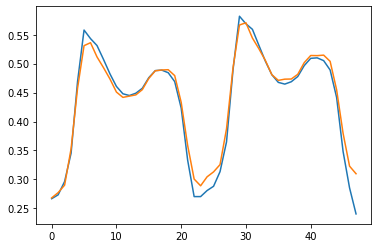

In [69]:
plt.plot(list(y_list[1]['y']))
plt.plot(list(forecast.iloc[-48:,-1]))
plt.show()

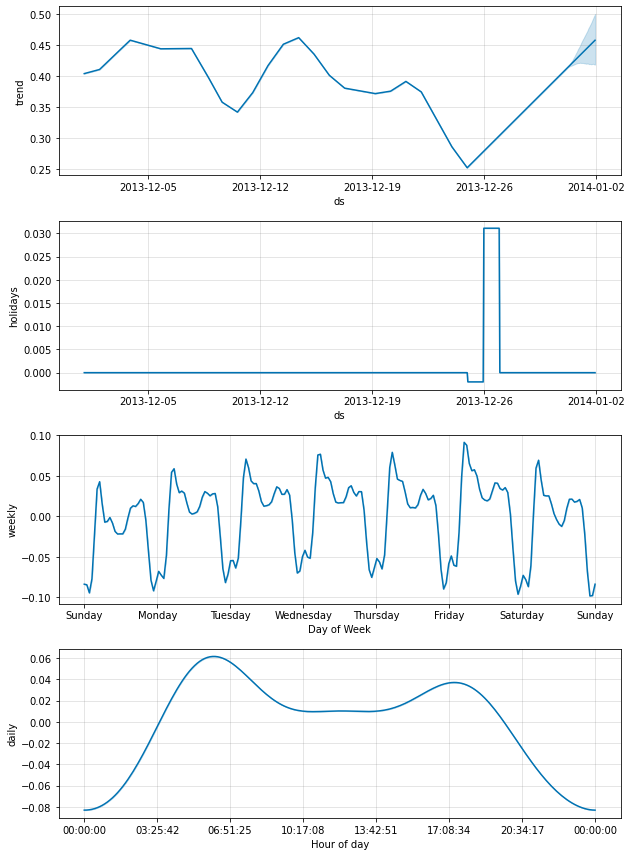

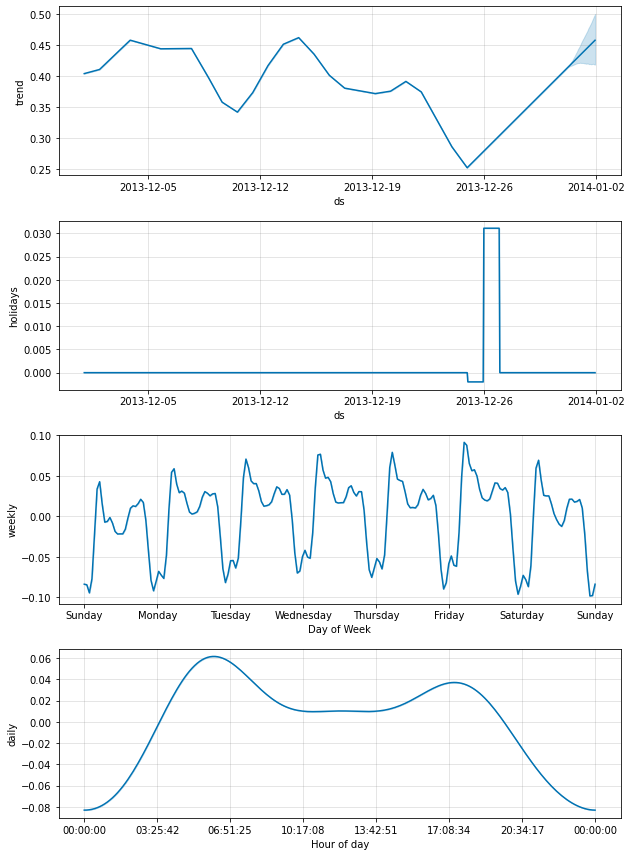

In [70]:
m.plot_components(forecast)

# Prophet with weather data

In [8]:
#use csv with already preprocessed features (scaling, differnecing etc needed)
df = pd.read_csv("Data_Prep.csv", index_col=0)
# Preprocessing for Prophet
my_df = df.reset_index() [["index", "Total_Heat"]]
my_df.columns = ["ds", "y"]
my_df.ds = pd.to_datetime(my_df.ds).dt.tz_convert(None)
df_scaler = MinMaxScaler()
my_df.y = pd.DataFrame(df_scaler.fit_transform(my_df[["y"]]), columns=["y"])
weather = pd.read_csv("produkt_tu_stunde_20040701_20221231_00294.csv", sep=";")
weather["ds"] = pd.to_datetime(weather.MESS_DATUM, format="%Y%m%d%H")
my_weather = weather[[ "ds", "TT_TU"]]
my_weather.TT_TU.replace(-999, np.NaN, inplace=True)
my_weather.fillna(method="ffill", inplace=True)

C:\Users\jabbe\AppData\Local\Temp\ipykernel_2704\3276238913.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_weather.TT_TU.replace(-999, np.NaN, inplace=True)
C:\Users\jabbe\AppData\Local\Temp\ipykernel_2704\3276238913.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_weather.fillna(method="ffill", inplace=True)


<AxesSubplot:>

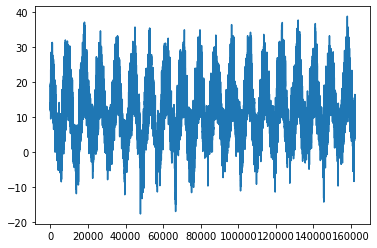

In [9]:
my_weather.TT_TU.plot()

In [10]:
df_scaler = MinMaxScaler()
my_weather.TT_TU = pd.DataFrame(df_scaler.fit_transform(my_weather[["TT_TU"]]), columns=["TT_TU"])

C:\Users\jabbe\AppData\Local\Temp\ipykernel_2704\3990520788.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_weather.TT_TU = pd.DataFrame(df_scaler.fit_transform(my_weather[["TT_TU"]]), columns=["TT_TU"])


In [11]:
my_df = my_df.merge(my_weather, on="ds", how="left")
my_df

,ds,y,TT_TU
0,2008-01-01 00:00:00,0.362881,0.355124
1,2008-01-01 01:00:00,0.371961,0.351590
2,2008-01-01 02:00:00,0.397763,0.351590
3,2008-01-01 03:00:00,0.449547,0.339223
4,2008-01-01 04:00:00,0.594798,0.333922
...,...,...,...
61363,2014-12-31 19:00:00,0.576926,0.404594
61364,2014-12-31 20:00:00,0.521848,0.401060
61365,2014-12-31 21:00:00,0.424086,0.393993
61366,2014-12-31 22:00:00,0.261670,0.385159


In [33]:
X_list, y_list = create_X_y(my_df[["ds", "y", "TT_TU"]], train_days, forecast_days)

In [19]:
def model_test(
    holidays, 
    daily_seasonality, 
    add_daily,
    changepoint_prior_scale, 
    holidays_prior_scale, 
    month_fourier,
    num_iterations=10):

    mse_list = []
    for i in range(num_iterations):
      m4 = Prophet(
          daily_seasonality= daily_seasonality,
          changepoint_prior_scale=changepoint_prior_scale, 
          holidays_prior_scale=holidays_prior_scale)
      m4.add_regressor('TT_TU')

      if holidays: 
          m4.add_country_holidays(country_name='DE')
      
      if add_daily:    
          m4.add_seasonality(
              name='daily', 
              period=24, 
              fourier_order=month_fourier)
    

      m4.fit(X_list[i])
      future = m4.make_future_dataframe(periods=len(y_list[i]), freq='H')
      future['ds'] = pd.to_datetime(future['ds'])
      future = future.merge(y_list[i], on = 'ds', how = 'left')[['ds', 'TT_TU']].fillna(0)

      forecast = m4.predict(future)
      mse = ((forecast.iloc[-48:,-1].values - y_list[i]['y'].values)**2).mean()
      mse_list.append(mse)

    return np.array(mse_list).mean()


In [77]:
# Setting the grid
holidays_opt = [True, False]
daily_seas = [ 5, 10, 30, 50]
add_daily = [True, False]
changepoint_prior_scale = [0.1, 0.3, 0.5]
holidays_prior_scale = [0.1, 0.3, 0.5]
month_fourier = [5, 10, 30, 50]

# Looping through the grid
grid_results = []
for h in holidays_opt:
  for w in daily_seas:
    for d in add_daily:
      for c in changepoint_prior_scale:
        for hp in holidays_prior_scale:
          for mf in month_fourier:
            mse=model_test(h,w,d,c,hp,mf)
            print([h,w,d, c,hp,mf,mse])
            grid_results.append([h,w,d, c,hp,mf,mse])

# adding it all to a dataframe and extract the best model
benchmark = pd.DataFrame(grid_results)
benchmark = benchmark.sort_values(8, ascending=False)

h, w,ys, m, r, c,hp,mf,r2 = list(benchmark.iloc[0,:])


21:37:09 - cmdstanpy - INFO - Chain [1] start processing
21:37:10 - cmdstanpy - INFO - Chain [1] done processing
21:37:10 - cmdstanpy - INFO - Chain [1] start processing
21:37:11 - cmdstanpy - INFO - Chain [1] done processing
21:37:12 - cmdstanpy - INFO - Chain [1] start processing
21:37:14 - cmdstanpy - INFO - Chain [1] done processing
21:37:15 - cmdstanpy - INFO - Chain [1] start processing
21:37:16 - cmdstanpy - INFO - Chain [1] done processing
21:37:17 - cmdstanpy - INFO - Chain [1] start processing
21:37:18 - cmdstanpy - INFO - Chain [1] done processing
21:37:19 - cmdstanpy - INFO - Chain [1] start processing
21:37:21 - cmdstanpy - INFO - Chain [1] done processing
21:37:23 - cmdstanpy - INFO - Chain [1] start processing
21:37:23 - cmdstanpy - INFO - Chain [1] done processing
21:37:25 - cmdstanpy - INFO - Chain [1] start processing
21:37:26 - cmdstanpy - INFO - Chain [1] done processing
21:37:28 - cmdstanpy - INFO - Chain [1] start processing
21:37:29 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.1, 5, 0.0037364507738090595]


21:37:33 - cmdstanpy - INFO - Chain [1] start processing
21:37:33 - cmdstanpy - INFO - Chain [1] done processing
21:37:34 - cmdstanpy - INFO - Chain [1] start processing
21:37:35 - cmdstanpy - INFO - Chain [1] done processing
21:37:36 - cmdstanpy - INFO - Chain [1] start processing
21:37:38 - cmdstanpy - INFO - Chain [1] done processing
21:37:39 - cmdstanpy - INFO - Chain [1] start processing
21:37:40 - cmdstanpy - INFO - Chain [1] done processing
21:37:41 - cmdstanpy - INFO - Chain [1] start processing
21:37:42 - cmdstanpy - INFO - Chain [1] done processing
21:37:43 - cmdstanpy - INFO - Chain [1] start processing
21:37:44 - cmdstanpy - INFO - Chain [1] done processing
21:37:44 - cmdstanpy - INFO - Chain [1] start processing
21:37:45 - cmdstanpy - INFO - Chain [1] done processing
21:37:46 - cmdstanpy - INFO - Chain [1] start processing
21:37:46 - cmdstanpy - INFO - Chain [1] done processing
21:37:47 - cmdstanpy - INFO - Chain [1] start processing
21:37:48 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.1, 10, 0.0037364507738090595]


21:37:50 - cmdstanpy - INFO - Chain [1] start processing
21:37:51 - cmdstanpy - INFO - Chain [1] done processing
21:37:53 - cmdstanpy - INFO - Chain [1] start processing
21:37:54 - cmdstanpy - INFO - Chain [1] done processing
21:37:57 - cmdstanpy - INFO - Chain [1] start processing
21:37:58 - cmdstanpy - INFO - Chain [1] done processing
21:38:01 - cmdstanpy - INFO - Chain [1] start processing
21:38:02 - cmdstanpy - INFO - Chain [1] done processing
21:38:04 - cmdstanpy - INFO - Chain [1] start processing
21:38:06 - cmdstanpy - INFO - Chain [1] done processing
21:38:07 - cmdstanpy - INFO - Chain [1] start processing
21:38:07 - cmdstanpy - INFO - Chain [1] done processing
21:38:09 - cmdstanpy - INFO - Chain [1] start processing
21:38:11 - cmdstanpy - INFO - Chain [1] done processing
21:38:12 - cmdstanpy - INFO - Chain [1] start processing
21:38:13 - cmdstanpy - INFO - Chain [1] done processing
21:38:14 - cmdstanpy - INFO - Chain [1] start processing
21:38:15 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.1, 30, 0.0037364507738090595]


21:38:17 - cmdstanpy - INFO - Chain [1] start processing
21:38:17 - cmdstanpy - INFO - Chain [1] done processing
21:38:18 - cmdstanpy - INFO - Chain [1] start processing
21:38:18 - cmdstanpy - INFO - Chain [1] done processing
21:38:19 - cmdstanpy - INFO - Chain [1] start processing
21:38:19 - cmdstanpy - INFO - Chain [1] done processing
21:38:20 - cmdstanpy - INFO - Chain [1] start processing
21:38:20 - cmdstanpy - INFO - Chain [1] done processing
21:38:21 - cmdstanpy - INFO - Chain [1] start processing
21:38:22 - cmdstanpy - INFO - Chain [1] done processing
21:38:22 - cmdstanpy - INFO - Chain [1] start processing
21:38:23 - cmdstanpy - INFO - Chain [1] done processing
21:38:23 - cmdstanpy - INFO - Chain [1] start processing
21:38:24 - cmdstanpy - INFO - Chain [1] done processing
21:38:24 - cmdstanpy - INFO - Chain [1] start processing
21:38:25 - cmdstanpy - INFO - Chain [1] done processing
21:38:25 - cmdstanpy - INFO - Chain [1] start processing
21:38:26 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.1, 50, 0.0037364507738090595]


21:38:28 - cmdstanpy - INFO - Chain [1] start processing
21:38:28 - cmdstanpy - INFO - Chain [1] done processing
21:38:29 - cmdstanpy - INFO - Chain [1] start processing
21:38:29 - cmdstanpy - INFO - Chain [1] done processing
21:38:30 - cmdstanpy - INFO - Chain [1] start processing
21:38:30 - cmdstanpy - INFO - Chain [1] done processing
21:38:31 - cmdstanpy - INFO - Chain [1] start processing
21:38:31 - cmdstanpy - INFO - Chain [1] done processing
21:38:32 - cmdstanpy - INFO - Chain [1] start processing
21:38:32 - cmdstanpy - INFO - Chain [1] done processing
21:38:33 - cmdstanpy - INFO - Chain [1] start processing
21:38:33 - cmdstanpy - INFO - Chain [1] done processing
21:38:34 - cmdstanpy - INFO - Chain [1] start processing
21:38:34 - cmdstanpy - INFO - Chain [1] done processing
21:38:35 - cmdstanpy - INFO - Chain [1] start processing
21:38:35 - cmdstanpy - INFO - Chain [1] done processing
21:38:36 - cmdstanpy - INFO - Chain [1] start processing
21:38:36 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.3, 5, 0.003714338745686405]


21:38:38 - cmdstanpy - INFO - Chain [1] start processing
21:38:38 - cmdstanpy - INFO - Chain [1] done processing
21:38:39 - cmdstanpy - INFO - Chain [1] start processing
21:38:39 - cmdstanpy - INFO - Chain [1] done processing
21:38:40 - cmdstanpy - INFO - Chain [1] start processing
21:38:40 - cmdstanpy - INFO - Chain [1] done processing
21:38:41 - cmdstanpy - INFO - Chain [1] start processing
21:38:41 - cmdstanpy - INFO - Chain [1] done processing
21:38:42 - cmdstanpy - INFO - Chain [1] start processing
21:38:42 - cmdstanpy - INFO - Chain [1] done processing
21:38:43 - cmdstanpy - INFO - Chain [1] start processing
21:38:43 - cmdstanpy - INFO - Chain [1] done processing
21:38:44 - cmdstanpy - INFO - Chain [1] start processing
21:38:44 - cmdstanpy - INFO - Chain [1] done processing
21:38:45 - cmdstanpy - INFO - Chain [1] start processing
21:38:45 - cmdstanpy - INFO - Chain [1] done processing
21:38:46 - cmdstanpy - INFO - Chain [1] start processing
21:38:46 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.3, 10, 0.003714338745686405]


21:38:48 - cmdstanpy - INFO - Chain [1] start processing
21:38:48 - cmdstanpy - INFO - Chain [1] done processing
21:38:49 - cmdstanpy - INFO - Chain [1] start processing
21:38:49 - cmdstanpy - INFO - Chain [1] done processing
21:38:50 - cmdstanpy - INFO - Chain [1] start processing
21:38:50 - cmdstanpy - INFO - Chain [1] done processing
21:38:51 - cmdstanpy - INFO - Chain [1] start processing
21:38:51 - cmdstanpy - INFO - Chain [1] done processing
21:38:52 - cmdstanpy - INFO - Chain [1] start processing
21:38:52 - cmdstanpy - INFO - Chain [1] done processing
21:38:53 - cmdstanpy - INFO - Chain [1] start processing
21:38:53 - cmdstanpy - INFO - Chain [1] done processing
21:38:54 - cmdstanpy - INFO - Chain [1] start processing
21:38:54 - cmdstanpy - INFO - Chain [1] done processing
21:38:55 - cmdstanpy - INFO - Chain [1] start processing
21:38:56 - cmdstanpy - INFO - Chain [1] done processing
21:38:56 - cmdstanpy - INFO - Chain [1] start processing
21:38:57 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.3, 30, 0.003714338745686405]


21:38:58 - cmdstanpy - INFO - Chain [1] start processing
21:38:59 - cmdstanpy - INFO - Chain [1] done processing
21:38:59 - cmdstanpy - INFO - Chain [1] start processing
21:39:00 - cmdstanpy - INFO - Chain [1] done processing
21:39:00 - cmdstanpy - INFO - Chain [1] start processing
21:39:01 - cmdstanpy - INFO - Chain [1] done processing
21:39:01 - cmdstanpy - INFO - Chain [1] start processing
21:39:02 - cmdstanpy - INFO - Chain [1] done processing
21:39:02 - cmdstanpy - INFO - Chain [1] start processing
21:39:03 - cmdstanpy - INFO - Chain [1] done processing
21:39:03 - cmdstanpy - INFO - Chain [1] start processing
21:39:04 - cmdstanpy - INFO - Chain [1] done processing
21:39:04 - cmdstanpy - INFO - Chain [1] start processing
21:39:04 - cmdstanpy - INFO - Chain [1] done processing
21:39:05 - cmdstanpy - INFO - Chain [1] start processing
21:39:06 - cmdstanpy - INFO - Chain [1] done processing
21:39:06 - cmdstanpy - INFO - Chain [1] start processing
21:39:06 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.3, 50, 0.003714338745686405]


21:39:08 - cmdstanpy - INFO - Chain [1] start processing
21:39:09 - cmdstanpy - INFO - Chain [1] done processing
21:39:09 - cmdstanpy - INFO - Chain [1] start processing
21:39:10 - cmdstanpy - INFO - Chain [1] done processing
21:39:10 - cmdstanpy - INFO - Chain [1] start processing
21:39:11 - cmdstanpy - INFO - Chain [1] done processing
21:39:11 - cmdstanpy - INFO - Chain [1] start processing
21:39:12 - cmdstanpy - INFO - Chain [1] done processing
21:39:12 - cmdstanpy - INFO - Chain [1] start processing
21:39:13 - cmdstanpy - INFO - Chain [1] done processing
21:39:13 - cmdstanpy - INFO - Chain [1] start processing
21:39:14 - cmdstanpy - INFO - Chain [1] done processing
21:39:14 - cmdstanpy - INFO - Chain [1] start processing
21:39:15 - cmdstanpy - INFO - Chain [1] done processing
21:39:15 - cmdstanpy - INFO - Chain [1] start processing
21:39:16 - cmdstanpy - INFO - Chain [1] done processing
21:39:16 - cmdstanpy - INFO - Chain [1] start processing
21:39:17 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.5, 5, 0.003710669121569125]


21:39:19 - cmdstanpy - INFO - Chain [1] start processing
21:39:19 - cmdstanpy - INFO - Chain [1] done processing
21:39:19 - cmdstanpy - INFO - Chain [1] start processing
21:39:20 - cmdstanpy - INFO - Chain [1] done processing
21:39:21 - cmdstanpy - INFO - Chain [1] start processing
21:39:21 - cmdstanpy - INFO - Chain [1] done processing
21:39:22 - cmdstanpy - INFO - Chain [1] start processing
21:39:22 - cmdstanpy - INFO - Chain [1] done processing
21:39:23 - cmdstanpy - INFO - Chain [1] start processing
21:39:23 - cmdstanpy - INFO - Chain [1] done processing
21:39:24 - cmdstanpy - INFO - Chain [1] start processing
21:39:24 - cmdstanpy - INFO - Chain [1] done processing
21:39:25 - cmdstanpy - INFO - Chain [1] start processing
21:39:25 - cmdstanpy - INFO - Chain [1] done processing
21:39:26 - cmdstanpy - INFO - Chain [1] start processing
21:39:26 - cmdstanpy - INFO - Chain [1] done processing
21:39:27 - cmdstanpy - INFO - Chain [1] start processing
21:39:27 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.5, 10, 0.003710669121569125]


21:39:28 - cmdstanpy - INFO - Chain [1] start processing
21:39:29 - cmdstanpy - INFO - Chain [1] done processing
21:39:29 - cmdstanpy - INFO - Chain [1] start processing
21:39:30 - cmdstanpy - INFO - Chain [1] done processing
21:39:31 - cmdstanpy - INFO - Chain [1] start processing
21:39:31 - cmdstanpy - INFO - Chain [1] done processing
21:39:32 - cmdstanpy - INFO - Chain [1] start processing
21:39:32 - cmdstanpy - INFO - Chain [1] done processing
21:39:33 - cmdstanpy - INFO - Chain [1] start processing
21:39:33 - cmdstanpy - INFO - Chain [1] done processing
21:39:34 - cmdstanpy - INFO - Chain [1] start processing
21:39:34 - cmdstanpy - INFO - Chain [1] done processing
21:39:35 - cmdstanpy - INFO - Chain [1] start processing
21:39:35 - cmdstanpy - INFO - Chain [1] done processing
21:39:36 - cmdstanpy - INFO - Chain [1] start processing
21:39:36 - cmdstanpy - INFO - Chain [1] done processing
21:39:36 - cmdstanpy - INFO - Chain [1] start processing
21:39:37 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.5, 30, 0.003710669121569125]


21:39:38 - cmdstanpy - INFO - Chain [1] start processing
21:39:39 - cmdstanpy - INFO - Chain [1] done processing
21:39:39 - cmdstanpy - INFO - Chain [1] start processing
21:39:40 - cmdstanpy - INFO - Chain [1] done processing
21:39:40 - cmdstanpy - INFO - Chain [1] start processing
21:39:41 - cmdstanpy - INFO - Chain [1] done processing
21:39:41 - cmdstanpy - INFO - Chain [1] start processing
21:39:42 - cmdstanpy - INFO - Chain [1] done processing
21:39:42 - cmdstanpy - INFO - Chain [1] start processing
21:39:43 - cmdstanpy - INFO - Chain [1] done processing
21:39:43 - cmdstanpy - INFO - Chain [1] start processing
21:39:44 - cmdstanpy - INFO - Chain [1] done processing
21:39:44 - cmdstanpy - INFO - Chain [1] start processing
21:39:44 - cmdstanpy - INFO - Chain [1] done processing
21:39:45 - cmdstanpy - INFO - Chain [1] start processing
21:39:45 - cmdstanpy - INFO - Chain [1] done processing
21:39:46 - cmdstanpy - INFO - Chain [1] start processing
21:39:47 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.1, 0.5, 50, 0.003710669121569125]


21:39:49 - cmdstanpy - INFO - Chain [1] start processing
21:39:49 - cmdstanpy - INFO - Chain [1] done processing
21:39:50 - cmdstanpy - INFO - Chain [1] start processing
21:39:51 - cmdstanpy - INFO - Chain [1] done processing
21:39:51 - cmdstanpy - INFO - Chain [1] start processing
21:39:52 - cmdstanpy - INFO - Chain [1] done processing
21:39:52 - cmdstanpy - INFO - Chain [1] start processing
21:39:53 - cmdstanpy - INFO - Chain [1] done processing
21:39:54 - cmdstanpy - INFO - Chain [1] start processing
21:39:54 - cmdstanpy - INFO - Chain [1] done processing
21:39:55 - cmdstanpy - INFO - Chain [1] start processing
21:39:56 - cmdstanpy - INFO - Chain [1] done processing
21:39:56 - cmdstanpy - INFO - Chain [1] start processing
21:39:57 - cmdstanpy - INFO - Chain [1] done processing
21:39:58 - cmdstanpy - INFO - Chain [1] start processing
21:39:58 - cmdstanpy - INFO - Chain [1] done processing
21:39:59 - cmdstanpy - INFO - Chain [1] start processing
21:39:59 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.1, 5, 0.0032274997917042412]


21:40:03 - cmdstanpy - INFO - Chain [1] start processing
21:40:03 - cmdstanpy - INFO - Chain [1] done processing
21:40:04 - cmdstanpy - INFO - Chain [1] start processing
21:40:04 - cmdstanpy - INFO - Chain [1] done processing
21:40:05 - cmdstanpy - INFO - Chain [1] start processing
21:40:05 - cmdstanpy - INFO - Chain [1] done processing
21:40:06 - cmdstanpy - INFO - Chain [1] start processing
21:40:07 - cmdstanpy - INFO - Chain [1] done processing
21:40:07 - cmdstanpy - INFO - Chain [1] start processing
21:40:08 - cmdstanpy - INFO - Chain [1] done processing
21:40:08 - cmdstanpy - INFO - Chain [1] start processing
21:40:09 - cmdstanpy - INFO - Chain [1] done processing
21:40:09 - cmdstanpy - INFO - Chain [1] start processing
21:40:10 - cmdstanpy - INFO - Chain [1] done processing
21:40:11 - cmdstanpy - INFO - Chain [1] start processing
21:40:12 - cmdstanpy - INFO - Chain [1] done processing
21:40:12 - cmdstanpy - INFO - Chain [1] start processing
21:40:13 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.1, 10, 0.0032274997917042412]


21:40:14 - cmdstanpy - INFO - Chain [1] start processing
21:40:15 - cmdstanpy - INFO - Chain [1] done processing
21:40:15 - cmdstanpy - INFO - Chain [1] start processing
21:40:16 - cmdstanpy - INFO - Chain [1] done processing
21:40:17 - cmdstanpy - INFO - Chain [1] start processing
21:40:17 - cmdstanpy - INFO - Chain [1] done processing
21:40:18 - cmdstanpy - INFO - Chain [1] start processing
21:40:18 - cmdstanpy - INFO - Chain [1] done processing
21:40:19 - cmdstanpy - INFO - Chain [1] start processing
21:40:19 - cmdstanpy - INFO - Chain [1] done processing
21:40:20 - cmdstanpy - INFO - Chain [1] start processing
21:40:20 - cmdstanpy - INFO - Chain [1] done processing
21:40:21 - cmdstanpy - INFO - Chain [1] start processing
21:40:22 - cmdstanpy - INFO - Chain [1] done processing
21:40:22 - cmdstanpy - INFO - Chain [1] start processing
21:40:23 - cmdstanpy - INFO - Chain [1] done processing
21:40:23 - cmdstanpy - INFO - Chain [1] start processing
21:40:24 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.1, 30, 0.0032274997917042412]


21:40:25 - cmdstanpy - INFO - Chain [1] start processing
21:40:26 - cmdstanpy - INFO - Chain [1] done processing
21:40:27 - cmdstanpy - INFO - Chain [1] start processing
21:40:27 - cmdstanpy - INFO - Chain [1] done processing
21:40:28 - cmdstanpy - INFO - Chain [1] start processing
21:40:28 - cmdstanpy - INFO - Chain [1] done processing
21:40:29 - cmdstanpy - INFO - Chain [1] start processing
21:40:29 - cmdstanpy - INFO - Chain [1] done processing
21:40:30 - cmdstanpy - INFO - Chain [1] start processing
21:40:30 - cmdstanpy - INFO - Chain [1] done processing
21:40:31 - cmdstanpy - INFO - Chain [1] start processing
21:40:32 - cmdstanpy - INFO - Chain [1] done processing
21:40:32 - cmdstanpy - INFO - Chain [1] start processing
21:40:33 - cmdstanpy - INFO - Chain [1] done processing
21:40:33 - cmdstanpy - INFO - Chain [1] start processing
21:40:34 - cmdstanpy - INFO - Chain [1] done processing
21:40:34 - cmdstanpy - INFO - Chain [1] start processing
21:40:35 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.1, 50, 0.0032274997917042412]


21:40:37 - cmdstanpy - INFO - Chain [1] start processing
21:40:37 - cmdstanpy - INFO - Chain [1] done processing
21:40:38 - cmdstanpy - INFO - Chain [1] start processing
21:40:38 - cmdstanpy - INFO - Chain [1] done processing
21:40:39 - cmdstanpy - INFO - Chain [1] start processing
21:40:40 - cmdstanpy - INFO - Chain [1] done processing
21:40:40 - cmdstanpy - INFO - Chain [1] start processing
21:40:42 - cmdstanpy - INFO - Chain [1] done processing
21:40:43 - cmdstanpy - INFO - Chain [1] start processing
21:40:43 - cmdstanpy - INFO - Chain [1] done processing
21:40:44 - cmdstanpy - INFO - Chain [1] start processing
21:40:44 - cmdstanpy - INFO - Chain [1] done processing
21:40:45 - cmdstanpy - INFO - Chain [1] start processing
21:40:45 - cmdstanpy - INFO - Chain [1] done processing
21:40:46 - cmdstanpy - INFO - Chain [1] start processing
21:40:47 - cmdstanpy - INFO - Chain [1] done processing
21:40:47 - cmdstanpy - INFO - Chain [1] start processing
21:40:48 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.3, 5, 0.0032535556860771387]


21:40:50 - cmdstanpy - INFO - Chain [1] start processing
21:40:50 - cmdstanpy - INFO - Chain [1] done processing
21:40:51 - cmdstanpy - INFO - Chain [1] start processing
21:40:51 - cmdstanpy - INFO - Chain [1] done processing
21:40:52 - cmdstanpy - INFO - Chain [1] start processing
21:40:53 - cmdstanpy - INFO - Chain [1] done processing
21:40:53 - cmdstanpy - INFO - Chain [1] start processing
21:40:54 - cmdstanpy - INFO - Chain [1] done processing
21:40:54 - cmdstanpy - INFO - Chain [1] start processing
21:40:55 - cmdstanpy - INFO - Chain [1] done processing
21:40:56 - cmdstanpy - INFO - Chain [1] start processing
21:40:56 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.3, 10, 0.0032535556860771387]


21:41:01 - cmdstanpy - INFO - Chain [1] start processing
21:41:02 - cmdstanpy - INFO - Chain [1] done processing
21:41:02 - cmdstanpy - INFO - Chain [1] start processing
21:41:03 - cmdstanpy - INFO - Chain [1] done processing
21:41:04 - cmdstanpy - INFO - Chain [1] start processing
21:41:04 - cmdstanpy - INFO - Chain [1] done processing
21:41:05 - cmdstanpy - INFO - Chain [1] start processing
21:41:05 - cmdstanpy - INFO - Chain [1] done processing
21:41:06 - cmdstanpy - INFO - Chain [1] start processing
21:41:06 - cmdstanpy - INFO - Chain [1] done processing
21:41:07 - cmdstanpy - INFO - Chain [1] start processing
21:41:07 - cmdstanpy - INFO - Chain [1] done processing
21:41:08 - cmdstanpy - INFO - Chain [1] start processing
21:41:09 - cmdstanpy - INFO - Chain [1] done processing
21:41:09 - cmdstanpy - INFO - Chain [1] start processing
21:41:10 - cmdstanpy - INFO - Chain [1] done processing
21:41:10 - cmdstanpy - INFO - Chain [1] start processing
21:41:11 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.3, 30, 0.0032535556860771387]


21:41:13 - cmdstanpy - INFO - Chain [1] start processing
21:41:13 - cmdstanpy - INFO - Chain [1] done processing
21:41:14 - cmdstanpy - INFO - Chain [1] start processing
21:41:14 - cmdstanpy - INFO - Chain [1] done processing
21:41:15 - cmdstanpy - INFO - Chain [1] start processing
21:41:15 - cmdstanpy - INFO - Chain [1] done processing
21:41:16 - cmdstanpy - INFO - Chain [1] start processing
21:41:17 - cmdstanpy - INFO - Chain [1] done processing
21:41:17 - cmdstanpy - INFO - Chain [1] start processing
21:41:18 - cmdstanpy - INFO - Chain [1] done processing
21:41:18 - cmdstanpy - INFO - Chain [1] start processing
21:41:19 - cmdstanpy - INFO - Chain [1] done processing
21:41:19 - cmdstanpy - INFO - Chain [1] start processing
21:41:20 - cmdstanpy - INFO - Chain [1] done processing
21:41:20 - cmdstanpy - INFO - Chain [1] start processing
21:41:21 - cmdstanpy - INFO - Chain [1] done processing
21:41:22 - cmdstanpy - INFO - Chain [1] start processing
21:41:22 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.3, 50, 0.0032535556860771387]


21:41:24 - cmdstanpy - INFO - Chain [1] start processing
21:41:24 - cmdstanpy - INFO - Chain [1] done processing
21:41:25 - cmdstanpy - INFO - Chain [1] start processing
21:41:26 - cmdstanpy - INFO - Chain [1] done processing
21:41:26 - cmdstanpy - INFO - Chain [1] start processing
21:41:27 - cmdstanpy - INFO - Chain [1] done processing
21:41:27 - cmdstanpy - INFO - Chain [1] start processing
21:41:28 - cmdstanpy - INFO - Chain [1] done processing
21:41:29 - cmdstanpy - INFO - Chain [1] start processing
21:41:29 - cmdstanpy - INFO - Chain [1] done processing
21:41:30 - cmdstanpy - INFO - Chain [1] start processing
21:41:30 - cmdstanpy - INFO - Chain [1] done processing
21:41:31 - cmdstanpy - INFO - Chain [1] start processing
21:41:31 - cmdstanpy - INFO - Chain [1] done processing
21:41:32 - cmdstanpy - INFO - Chain [1] start processing
21:41:33 - cmdstanpy - INFO - Chain [1] done processing
21:41:33 - cmdstanpy - INFO - Chain [1] start processing
21:41:34 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.5, 5, 0.003205627147605856]


21:41:36 - cmdstanpy - INFO - Chain [1] start processing
21:41:36 - cmdstanpy - INFO - Chain [1] done processing
21:41:37 - cmdstanpy - INFO - Chain [1] start processing
21:41:38 - cmdstanpy - INFO - Chain [1] done processing
21:41:38 - cmdstanpy - INFO - Chain [1] start processing
21:41:39 - cmdstanpy - INFO - Chain [1] done processing
21:41:39 - cmdstanpy - INFO - Chain [1] start processing
21:41:40 - cmdstanpy - INFO - Chain [1] done processing
21:41:41 - cmdstanpy - INFO - Chain [1] start processing
21:41:41 - cmdstanpy - INFO - Chain [1] done processing
21:41:42 - cmdstanpy - INFO - Chain [1] start processing
21:41:42 - cmdstanpy - INFO - Chain [1] done processing
21:41:43 - cmdstanpy - INFO - Chain [1] start processing
21:41:43 - cmdstanpy - INFO - Chain [1] done processing
21:41:44 - cmdstanpy - INFO - Chain [1] start processing
21:41:45 - cmdstanpy - INFO - Chain [1] done processing
21:41:45 - cmdstanpy - INFO - Chain [1] start processing
21:41:46 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.5, 10, 0.003205627147605856]


21:41:49 - cmdstanpy - INFO - Chain [1] start processing
21:41:50 - cmdstanpy - INFO - Chain [1] done processing
21:41:51 - cmdstanpy - INFO - Chain [1] start processing
21:41:51 - cmdstanpy - INFO - Chain [1] done processing
21:41:52 - cmdstanpy - INFO - Chain [1] start processing
21:41:52 - cmdstanpy - INFO - Chain [1] done processing
21:41:53 - cmdstanpy - INFO - Chain [1] start processing
21:41:54 - cmdstanpy - INFO - Chain [1] done processing
21:41:54 - cmdstanpy - INFO - Chain [1] start processing
21:41:55 - cmdstanpy - INFO - Chain [1] done processing
21:41:56 - cmdstanpy - INFO - Chain [1] start processing
21:41:56 - cmdstanpy - INFO - Chain [1] done processing
21:41:57 - cmdstanpy - INFO - Chain [1] start processing
21:41:57 - cmdstanpy - INFO - Chain [1] done processing
21:41:58 - cmdstanpy - INFO - Chain [1] start processing
21:41:58 - cmdstanpy - INFO - Chain [1] done processing
21:41:59 - cmdstanpy - INFO - Chain [1] start processing
21:42:00 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.5, 30, 0.003205627147605856]


21:42:02 - cmdstanpy - INFO - Chain [1] start processing
21:42:02 - cmdstanpy - INFO - Chain [1] done processing
21:42:03 - cmdstanpy - INFO - Chain [1] start processing
21:42:03 - cmdstanpy - INFO - Chain [1] done processing
21:42:04 - cmdstanpy - INFO - Chain [1] start processing
21:42:05 - cmdstanpy - INFO - Chain [1] done processing
21:42:05 - cmdstanpy - INFO - Chain [1] start processing
21:42:06 - cmdstanpy - INFO - Chain [1] done processing
21:42:07 - cmdstanpy - INFO - Chain [1] start processing
21:42:07 - cmdstanpy - INFO - Chain [1] done processing
21:42:08 - cmdstanpy - INFO - Chain [1] start processing
21:42:08 - cmdstanpy - INFO - Chain [1] done processing
21:42:09 - cmdstanpy - INFO - Chain [1] start processing
21:42:09 - cmdstanpy - INFO - Chain [1] done processing
21:42:10 - cmdstanpy - INFO - Chain [1] start processing
21:42:11 - cmdstanpy - INFO - Chain [1] done processing
21:42:11 - cmdstanpy - INFO - Chain [1] start processing
21:42:12 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.3, 0.5, 50, 0.003205627147605856]


21:42:14 - cmdstanpy - INFO - Chain [1] start processing
21:42:14 - cmdstanpy - INFO - Chain [1] done processing
21:42:15 - cmdstanpy - INFO - Chain [1] start processing
21:42:15 - cmdstanpy - INFO - Chain [1] done processing
21:42:16 - cmdstanpy - INFO - Chain [1] start processing
21:42:17 - cmdstanpy - INFO - Chain [1] done processing
21:42:17 - cmdstanpy - INFO - Chain [1] start processing
21:42:18 - cmdstanpy - INFO - Chain [1] done processing
21:42:18 - cmdstanpy - INFO - Chain [1] start processing
21:42:19 - cmdstanpy - INFO - Chain [1] done processing
21:42:19 - cmdstanpy - INFO - Chain [1] start processing
21:42:20 - cmdstanpy - INFO - Chain [1] done processing
21:42:21 - cmdstanpy - INFO - Chain [1] start processing
21:42:21 - cmdstanpy - INFO - Chain [1] done processing
21:42:22 - cmdstanpy - INFO - Chain [1] start processing
21:42:23 - cmdstanpy - INFO - Chain [1] done processing
21:42:24 - cmdstanpy - INFO - Chain [1] start processing
21:42:25 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.1, 5, 0.003340832031202845]


21:42:27 - cmdstanpy - INFO - Chain [1] start processing
21:42:27 - cmdstanpy - INFO - Chain [1] done processing
21:42:28 - cmdstanpy - INFO - Chain [1] start processing
21:42:29 - cmdstanpy - INFO - Chain [1] done processing
21:42:29 - cmdstanpy - INFO - Chain [1] start processing
21:42:30 - cmdstanpy - INFO - Chain [1] done processing
21:42:31 - cmdstanpy - INFO - Chain [1] start processing
21:42:31 - cmdstanpy - INFO - Chain [1] done processing
21:42:32 - cmdstanpy - INFO - Chain [1] start processing
21:42:32 - cmdstanpy - INFO - Chain [1] done processing
21:42:33 - cmdstanpy - INFO - Chain [1] start processing
21:42:33 - cmdstanpy - INFO - Chain [1] done processing
21:42:34 - cmdstanpy - INFO - Chain [1] start processing
21:42:35 - cmdstanpy - INFO - Chain [1] done processing
21:42:35 - cmdstanpy - INFO - Chain [1] start processing
21:42:36 - cmdstanpy - INFO - Chain [1] done processing
21:42:37 - cmdstanpy - INFO - Chain [1] start processing
21:42:37 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.1, 10, 0.003340832031202845]


21:42:39 - cmdstanpy - INFO - Chain [1] start processing
21:42:39 - cmdstanpy - INFO - Chain [1] done processing
21:42:40 - cmdstanpy - INFO - Chain [1] start processing
21:42:41 - cmdstanpy - INFO - Chain [1] done processing
21:42:42 - cmdstanpy - INFO - Chain [1] start processing
21:42:42 - cmdstanpy - INFO - Chain [1] done processing
21:42:43 - cmdstanpy - INFO - Chain [1] start processing
21:42:43 - cmdstanpy - INFO - Chain [1] done processing
21:42:44 - cmdstanpy - INFO - Chain [1] start processing
21:42:44 - cmdstanpy - INFO - Chain [1] done processing
21:42:45 - cmdstanpy - INFO - Chain [1] start processing
21:42:46 - cmdstanpy - INFO - Chain [1] done processing
21:42:46 - cmdstanpy - INFO - Chain [1] start processing
21:42:47 - cmdstanpy - INFO - Chain [1] done processing
21:42:47 - cmdstanpy - INFO - Chain [1] start processing
21:42:48 - cmdstanpy - INFO - Chain [1] done processing
21:42:49 - cmdstanpy - INFO - Chain [1] start processing
21:42:49 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.1, 30, 0.003340832031202845]


21:42:51 - cmdstanpy - INFO - Chain [1] start processing
21:42:52 - cmdstanpy - INFO - Chain [1] done processing
21:42:52 - cmdstanpy - INFO - Chain [1] start processing
21:42:53 - cmdstanpy - INFO - Chain [1] done processing
21:42:53 - cmdstanpy - INFO - Chain [1] start processing
21:42:54 - cmdstanpy - INFO - Chain [1] done processing
21:42:55 - cmdstanpy - INFO - Chain [1] start processing
21:42:55 - cmdstanpy - INFO - Chain [1] done processing
21:42:56 - cmdstanpy - INFO - Chain [1] start processing
21:42:56 - cmdstanpy - INFO - Chain [1] done processing
21:42:57 - cmdstanpy - INFO - Chain [1] start processing
21:42:57 - cmdstanpy - INFO - Chain [1] done processing
21:42:58 - cmdstanpy - INFO - Chain [1] start processing
21:42:59 - cmdstanpy - INFO - Chain [1] done processing
21:43:00 - cmdstanpy - INFO - Chain [1] start processing
21:43:01 - cmdstanpy - INFO - Chain [1] done processing
21:43:02 - cmdstanpy - INFO - Chain [1] start processing
21:43:02 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.1, 50, 0.003340832031202845]


21:43:04 - cmdstanpy - INFO - Chain [1] start processing
21:43:04 - cmdstanpy - INFO - Chain [1] done processing
21:43:05 - cmdstanpy - INFO - Chain [1] start processing
21:43:06 - cmdstanpy - INFO - Chain [1] done processing
21:43:06 - cmdstanpy - INFO - Chain [1] start processing
21:43:07 - cmdstanpy - INFO - Chain [1] done processing
21:43:08 - cmdstanpy - INFO - Chain [1] start processing
21:43:08 - cmdstanpy - INFO - Chain [1] done processing
21:43:09 - cmdstanpy - INFO - Chain [1] start processing
21:43:09 - cmdstanpy - INFO - Chain [1] done processing
21:43:10 - cmdstanpy - INFO - Chain [1] start processing
21:43:11 - cmdstanpy - INFO - Chain [1] done processing
21:43:11 - cmdstanpy - INFO - Chain [1] start processing
21:43:12 - cmdstanpy - INFO - Chain [1] done processing
21:43:13 - cmdstanpy - INFO - Chain [1] start processing
21:43:13 - cmdstanpy - INFO - Chain [1] done processing
21:43:14 - cmdstanpy - INFO - Chain [1] start processing
21:43:14 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.3, 5, 0.0033191863152707093]


21:43:16 - cmdstanpy - INFO - Chain [1] start processing
21:43:16 - cmdstanpy - INFO - Chain [1] done processing
21:43:17 - cmdstanpy - INFO - Chain [1] start processing
21:43:18 - cmdstanpy - INFO - Chain [1] done processing
21:43:18 - cmdstanpy - INFO - Chain [1] start processing
21:43:19 - cmdstanpy - INFO - Chain [1] done processing
21:43:19 - cmdstanpy - INFO - Chain [1] start processing
21:43:20 - cmdstanpy - INFO - Chain [1] done processing
21:43:20 - cmdstanpy - INFO - Chain [1] start processing
21:43:21 - cmdstanpy - INFO - Chain [1] done processing
21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:22 - cmdstanpy - INFO - Chain [1] done processing
21:43:23 - cmdstanpy - INFO - Chain [1] start processing
21:43:23 - cmdstanpy - INFO - Chain [1] done processing
21:43:24 - cmdstanpy - INFO - Chain [1] start processing
21:43:25 - cmdstanpy - INFO - Chain [1] done processing
21:43:25 - cmdstanpy - INFO - Chain [1] start processing
21:43:26 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.3, 10, 0.0033191863152707093]


21:43:27 - cmdstanpy - INFO - Chain [1] start processing
21:43:28 - cmdstanpy - INFO - Chain [1] done processing
21:43:29 - cmdstanpy - INFO - Chain [1] start processing
21:43:29 - cmdstanpy - INFO - Chain [1] done processing
21:43:30 - cmdstanpy - INFO - Chain [1] start processing
21:43:30 - cmdstanpy - INFO - Chain [1] done processing
21:43:31 - cmdstanpy - INFO - Chain [1] start processing
21:43:31 - cmdstanpy - INFO - Chain [1] done processing
21:43:32 - cmdstanpy - INFO - Chain [1] start processing
21:43:32 - cmdstanpy - INFO - Chain [1] done processing
21:43:33 - cmdstanpy - INFO - Chain [1] start processing
21:43:33 - cmdstanpy - INFO - Chain [1] done processing
21:43:34 - cmdstanpy - INFO - Chain [1] start processing
21:43:35 - cmdstanpy - INFO - Chain [1] done processing
21:43:35 - cmdstanpy - INFO - Chain [1] start processing
21:43:36 - cmdstanpy - INFO - Chain [1] done processing
21:43:37 - cmdstanpy - INFO - Chain [1] start processing
21:43:37 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.3, 30, 0.0033191863152707093]


21:43:39 - cmdstanpy - INFO - Chain [1] start processing
21:43:39 - cmdstanpy - INFO - Chain [1] done processing
21:43:40 - cmdstanpy - INFO - Chain [1] start processing
21:43:41 - cmdstanpy - INFO - Chain [1] done processing
21:43:41 - cmdstanpy - INFO - Chain [1] start processing
21:43:42 - cmdstanpy - INFO - Chain [1] done processing
21:43:42 - cmdstanpy - INFO - Chain [1] start processing
21:43:43 - cmdstanpy - INFO - Chain [1] done processing
21:43:43 - cmdstanpy - INFO - Chain [1] start processing
21:43:44 - cmdstanpy - INFO - Chain [1] done processing
21:43:44 - cmdstanpy - INFO - Chain [1] start processing
21:43:45 - cmdstanpy - INFO - Chain [1] done processing
21:43:46 - cmdstanpy - INFO - Chain [1] start processing
21:43:46 - cmdstanpy - INFO - Chain [1] done processing
21:43:47 - cmdstanpy - INFO - Chain [1] start processing
21:43:47 - cmdstanpy - INFO - Chain [1] done processing
21:43:48 - cmdstanpy - INFO - Chain [1] start processing
21:43:48 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.3, 50, 0.0033191863152707093]


21:43:50 - cmdstanpy - INFO - Chain [1] start processing
21:43:51 - cmdstanpy - INFO - Chain [1] done processing
21:43:52 - cmdstanpy - INFO - Chain [1] start processing
21:43:52 - cmdstanpy - INFO - Chain [1] done processing
21:43:53 - cmdstanpy - INFO - Chain [1] start processing
21:43:54 - cmdstanpy - INFO - Chain [1] done processing
21:43:54 - cmdstanpy - INFO - Chain [1] start processing
21:43:55 - cmdstanpy - INFO - Chain [1] done processing
21:43:56 - cmdstanpy - INFO - Chain [1] start processing
21:43:56 - cmdstanpy - INFO - Chain [1] done processing
21:43:57 - cmdstanpy - INFO - Chain [1] start processing
21:43:57 - cmdstanpy - INFO - Chain [1] done processing
21:43:58 - cmdstanpy - INFO - Chain [1] start processing
21:43:58 - cmdstanpy - INFO - Chain [1] done processing
21:43:59 - cmdstanpy - INFO - Chain [1] start processing
21:44:00 - cmdstanpy - INFO - Chain [1] done processing
21:44:00 - cmdstanpy - INFO - Chain [1] start processing
21:44:01 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.5, 5, 0.0033107413741486785]


21:44:03 - cmdstanpy - INFO - Chain [1] start processing
21:44:03 - cmdstanpy - INFO - Chain [1] done processing
21:44:04 - cmdstanpy - INFO - Chain [1] start processing
21:44:04 - cmdstanpy - INFO - Chain [1] done processing
21:44:05 - cmdstanpy - INFO - Chain [1] start processing
21:44:06 - cmdstanpy - INFO - Chain [1] done processing
21:44:06 - cmdstanpy - INFO - Chain [1] start processing
21:44:07 - cmdstanpy - INFO - Chain [1] done processing
21:44:07 - cmdstanpy - INFO - Chain [1] start processing
21:44:08 - cmdstanpy - INFO - Chain [1] done processing
21:44:09 - cmdstanpy - INFO - Chain [1] start processing
21:44:10 - cmdstanpy - INFO - Chain [1] done processing
21:44:11 - cmdstanpy - INFO - Chain [1] start processing
21:44:11 - cmdstanpy - INFO - Chain [1] done processing
21:44:12 - cmdstanpy - INFO - Chain [1] start processing
21:44:12 - cmdstanpy - INFO - Chain [1] done processing
21:44:13 - cmdstanpy - INFO - Chain [1] start processing
21:44:14 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.5, 10, 0.0033107413741486785]


21:44:16 - cmdstanpy - INFO - Chain [1] start processing
21:44:16 - cmdstanpy - INFO - Chain [1] done processing
21:44:17 - cmdstanpy - INFO - Chain [1] start processing
21:44:17 - cmdstanpy - INFO - Chain [1] done processing
21:44:18 - cmdstanpy - INFO - Chain [1] start processing
21:44:18 - cmdstanpy - INFO - Chain [1] done processing
21:44:19 - cmdstanpy - INFO - Chain [1] start processing
21:44:20 - cmdstanpy - INFO - Chain [1] done processing
21:44:20 - cmdstanpy - INFO - Chain [1] start processing
21:44:21 - cmdstanpy - INFO - Chain [1] done processing
21:44:22 - cmdstanpy - INFO - Chain [1] start processing
21:44:22 - cmdstanpy - INFO - Chain [1] done processing
21:44:23 - cmdstanpy - INFO - Chain [1] start processing
21:44:23 - cmdstanpy - INFO - Chain [1] done processing
21:44:24 - cmdstanpy - INFO - Chain [1] start processing
21:44:24 - cmdstanpy - INFO - Chain [1] done processing
21:44:25 - cmdstanpy - INFO - Chain [1] start processing
21:44:26 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.5, 30, 0.0033107413741486785]


21:44:27 - cmdstanpy - INFO - Chain [1] start processing
21:44:28 - cmdstanpy - INFO - Chain [1] done processing
21:44:28 - cmdstanpy - INFO - Chain [1] start processing
21:44:29 - cmdstanpy - INFO - Chain [1] done processing
21:44:29 - cmdstanpy - INFO - Chain [1] start processing
21:44:30 - cmdstanpy - INFO - Chain [1] done processing
21:44:31 - cmdstanpy - INFO - Chain [1] start processing
21:44:31 - cmdstanpy - INFO - Chain [1] done processing
21:44:32 - cmdstanpy - INFO - Chain [1] start processing
21:44:33 - cmdstanpy - INFO - Chain [1] done processing
21:44:33 - cmdstanpy - INFO - Chain [1] start processing
21:44:34 - cmdstanpy - INFO - Chain [1] done processing
21:44:34 - cmdstanpy - INFO - Chain [1] start processing
21:44:35 - cmdstanpy - INFO - Chain [1] done processing
21:44:35 - cmdstanpy - INFO - Chain [1] start processing
21:44:36 - cmdstanpy - INFO - Chain [1] done processing
21:44:36 - cmdstanpy - INFO - Chain [1] start processing
21:44:37 - cmdstanpy - INFO - Chain [1]

[True, 5, True, 0.5, 0.5, 50, 0.0033107413741486785]


21:44:39 - cmdstanpy - INFO - Chain [1] start processing
21:44:39 - cmdstanpy - INFO - Chain [1] done processing
21:44:40 - cmdstanpy - INFO - Chain [1] start processing
21:44:40 - cmdstanpy - INFO - Chain [1] done processing
21:44:41 - cmdstanpy - INFO - Chain [1] start processing
21:44:41 - cmdstanpy - INFO - Chain [1] done processing
21:44:42 - cmdstanpy - INFO - Chain [1] start processing
21:44:42 - cmdstanpy - INFO - Chain [1] done processing
21:44:43 - cmdstanpy - INFO - Chain [1] start processing
21:44:43 - cmdstanpy - INFO - Chain [1] done processing
21:44:44 - cmdstanpy - INFO - Chain [1] start processing
21:44:44 - cmdstanpy - INFO - Chain [1] done processing
21:44:45 - cmdstanpy - INFO - Chain [1] start processing
21:44:45 - cmdstanpy - INFO - Chain [1] done processing
21:44:46 - cmdstanpy - INFO - Chain [1] start processing
21:44:46 - cmdstanpy - INFO - Chain [1] done processing
21:44:47 - cmdstanpy - INFO - Chain [1] start processing
21:44:47 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.1, 5, 0.0036109537403123657]


21:44:48 - cmdstanpy - INFO - Chain [1] start processing
21:44:49 - cmdstanpy - INFO - Chain [1] done processing
21:44:49 - cmdstanpy - INFO - Chain [1] start processing
21:44:50 - cmdstanpy - INFO - Chain [1] done processing
21:44:50 - cmdstanpy - INFO - Chain [1] start processing
21:44:51 - cmdstanpy - INFO - Chain [1] done processing
21:44:52 - cmdstanpy - INFO - Chain [1] start processing
21:44:52 - cmdstanpy - INFO - Chain [1] done processing
21:44:53 - cmdstanpy - INFO - Chain [1] start processing
21:44:53 - cmdstanpy - INFO - Chain [1] done processing
21:44:53 - cmdstanpy - INFO - Chain [1] start processing
21:44:54 - cmdstanpy - INFO - Chain [1] done processing
21:44:55 - cmdstanpy - INFO - Chain [1] start processing
21:44:55 - cmdstanpy - INFO - Chain [1] done processing
21:44:56 - cmdstanpy - INFO - Chain [1] start processing
21:44:56 - cmdstanpy - INFO - Chain [1] done processing
21:44:57 - cmdstanpy - INFO - Chain [1] start processing
21:44:57 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.1, 10, 0.0036109537403123657]


21:44:59 - cmdstanpy - INFO - Chain [1] start processing
21:44:59 - cmdstanpy - INFO - Chain [1] done processing
21:45:00 - cmdstanpy - INFO - Chain [1] start processing
21:45:00 - cmdstanpy - INFO - Chain [1] done processing
21:45:01 - cmdstanpy - INFO - Chain [1] start processing
21:45:01 - cmdstanpy - INFO - Chain [1] done processing
21:45:02 - cmdstanpy - INFO - Chain [1] start processing
21:45:02 - cmdstanpy - INFO - Chain [1] done processing
21:45:03 - cmdstanpy - INFO - Chain [1] start processing
21:45:03 - cmdstanpy - INFO - Chain [1] done processing
21:45:04 - cmdstanpy - INFO - Chain [1] start processing
21:45:04 - cmdstanpy - INFO - Chain [1] done processing
21:45:05 - cmdstanpy - INFO - Chain [1] start processing
21:45:06 - cmdstanpy - INFO - Chain [1] done processing
21:45:07 - cmdstanpy - INFO - Chain [1] start processing
21:45:07 - cmdstanpy - INFO - Chain [1] done processing
21:45:08 - cmdstanpy - INFO - Chain [1] start processing
21:45:08 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.1, 30, 0.0036109537403123657]


21:45:11 - cmdstanpy - INFO - Chain [1] start processing
21:45:11 - cmdstanpy - INFO - Chain [1] done processing
21:45:12 - cmdstanpy - INFO - Chain [1] start processing
21:45:13 - cmdstanpy - INFO - Chain [1] done processing
21:45:13 - cmdstanpy - INFO - Chain [1] start processing
21:45:13 - cmdstanpy - INFO - Chain [1] done processing
21:45:14 - cmdstanpy - INFO - Chain [1] start processing
21:45:15 - cmdstanpy - INFO - Chain [1] done processing
21:45:15 - cmdstanpy - INFO - Chain [1] start processing
21:45:16 - cmdstanpy - INFO - Chain [1] done processing
21:45:16 - cmdstanpy - INFO - Chain [1] start processing
21:45:17 - cmdstanpy - INFO - Chain [1] done processing
21:45:17 - cmdstanpy - INFO - Chain [1] start processing
21:45:18 - cmdstanpy - INFO - Chain [1] done processing
21:45:18 - cmdstanpy - INFO - Chain [1] start processing
21:45:18 - cmdstanpy - INFO - Chain [1] done processing
21:45:19 - cmdstanpy - INFO - Chain [1] start processing
21:45:20 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.1, 50, 0.0036109537403123657]


21:45:22 - cmdstanpy - INFO - Chain [1] start processing
21:45:23 - cmdstanpy - INFO - Chain [1] done processing
21:45:24 - cmdstanpy - INFO - Chain [1] start processing
21:45:24 - cmdstanpy - INFO - Chain [1] done processing
21:45:25 - cmdstanpy - INFO - Chain [1] start processing
21:45:25 - cmdstanpy - INFO - Chain [1] done processing
21:45:26 - cmdstanpy - INFO - Chain [1] start processing
21:45:26 - cmdstanpy - INFO - Chain [1] done processing
21:45:27 - cmdstanpy - INFO - Chain [1] start processing
21:45:27 - cmdstanpy - INFO - Chain [1] done processing
21:45:28 - cmdstanpy - INFO - Chain [1] start processing
21:45:28 - cmdstanpy - INFO - Chain [1] done processing
21:45:29 - cmdstanpy - INFO - Chain [1] start processing
21:45:29 - cmdstanpy - INFO - Chain [1] done processing
21:45:30 - cmdstanpy - INFO - Chain [1] start processing
21:45:30 - cmdstanpy - INFO - Chain [1] done processing
21:45:31 - cmdstanpy - INFO - Chain [1] start processing
21:45:31 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.3, 5, 0.0036459469582614027]


21:45:33 - cmdstanpy - INFO - Chain [1] start processing
21:45:33 - cmdstanpy - INFO - Chain [1] done processing
21:45:34 - cmdstanpy - INFO - Chain [1] start processing
21:45:35 - cmdstanpy - INFO - Chain [1] done processing
21:45:35 - cmdstanpy - INFO - Chain [1] start processing
21:45:36 - cmdstanpy - INFO - Chain [1] done processing
21:45:36 - cmdstanpy - INFO - Chain [1] start processing
21:45:37 - cmdstanpy - INFO - Chain [1] done processing
21:45:37 - cmdstanpy - INFO - Chain [1] start processing
21:45:38 - cmdstanpy - INFO - Chain [1] done processing
21:45:38 - cmdstanpy - INFO - Chain [1] start processing
21:45:39 - cmdstanpy - INFO - Chain [1] done processing
21:45:39 - cmdstanpy - INFO - Chain [1] start processing
21:45:40 - cmdstanpy - INFO - Chain [1] done processing
21:45:40 - cmdstanpy - INFO - Chain [1] start processing
21:45:41 - cmdstanpy - INFO - Chain [1] done processing
21:45:41 - cmdstanpy - INFO - Chain [1] start processing
21:45:42 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.3, 10, 0.0036459469582614027]


21:45:43 - cmdstanpy - INFO - Chain [1] start processing
21:45:44 - cmdstanpy - INFO - Chain [1] done processing
21:45:44 - cmdstanpy - INFO - Chain [1] start processing
21:45:45 - cmdstanpy - INFO - Chain [1] done processing
21:45:45 - cmdstanpy - INFO - Chain [1] start processing
21:45:46 - cmdstanpy - INFO - Chain [1] done processing
21:45:46 - cmdstanpy - INFO - Chain [1] start processing
21:45:47 - cmdstanpy - INFO - Chain [1] done processing
21:45:47 - cmdstanpy - INFO - Chain [1] start processing
21:45:48 - cmdstanpy - INFO - Chain [1] done processing
21:45:48 - cmdstanpy - INFO - Chain [1] start processing
21:45:49 - cmdstanpy - INFO - Chain [1] done processing
21:45:49 - cmdstanpy - INFO - Chain [1] start processing
21:45:50 - cmdstanpy - INFO - Chain [1] done processing
21:45:50 - cmdstanpy - INFO - Chain [1] start processing
21:45:51 - cmdstanpy - INFO - Chain [1] done processing
21:45:51 - cmdstanpy - INFO - Chain [1] start processing
21:45:52 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.3, 30, 0.0036459469582614027]


21:45:53 - cmdstanpy - INFO - Chain [1] start processing
21:45:54 - cmdstanpy - INFO - Chain [1] done processing
21:45:54 - cmdstanpy - INFO - Chain [1] start processing
21:45:55 - cmdstanpy - INFO - Chain [1] done processing
21:45:55 - cmdstanpy - INFO - Chain [1] start processing
21:45:56 - cmdstanpy - INFO - Chain [1] done processing
21:45:56 - cmdstanpy - INFO - Chain [1] start processing
21:45:57 - cmdstanpy - INFO - Chain [1] done processing
21:45:58 - cmdstanpy - INFO - Chain [1] start processing
21:45:58 - cmdstanpy - INFO - Chain [1] done processing
21:45:59 - cmdstanpy - INFO - Chain [1] start processing
21:45:59 - cmdstanpy - INFO - Chain [1] done processing
21:45:59 - cmdstanpy - INFO - Chain [1] start processing
21:46:00 - cmdstanpy - INFO - Chain [1] done processing
21:46:01 - cmdstanpy - INFO - Chain [1] start processing
21:46:01 - cmdstanpy - INFO - Chain [1] done processing
21:46:03 - cmdstanpy - INFO - Chain [1] start processing
21:46:04 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.3, 50, 0.0036459469582614027]


21:46:06 - cmdstanpy - INFO - Chain [1] start processing
21:46:07 - cmdstanpy - INFO - Chain [1] done processing
21:46:07 - cmdstanpy - INFO - Chain [1] start processing
21:46:08 - cmdstanpy - INFO - Chain [1] done processing
21:46:08 - cmdstanpy - INFO - Chain [1] start processing
21:46:09 - cmdstanpy - INFO - Chain [1] done processing
21:46:09 - cmdstanpy - INFO - Chain [1] start processing
21:46:10 - cmdstanpy - INFO - Chain [1] done processing
21:46:10 - cmdstanpy - INFO - Chain [1] start processing
21:46:10 - cmdstanpy - INFO - Chain [1] done processing
21:46:11 - cmdstanpy - INFO - Chain [1] start processing
21:46:12 - cmdstanpy - INFO - Chain [1] done processing
21:46:12 - cmdstanpy - INFO - Chain [1] start processing
21:46:12 - cmdstanpy - INFO - Chain [1] done processing
21:46:13 - cmdstanpy - INFO - Chain [1] start processing
21:46:13 - cmdstanpy - INFO - Chain [1] done processing
21:46:14 - cmdstanpy - INFO - Chain [1] start processing
21:46:14 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.5, 5, 0.0037477175033109435]


21:46:16 - cmdstanpy - INFO - Chain [1] start processing
21:46:16 - cmdstanpy - INFO - Chain [1] done processing
21:46:17 - cmdstanpy - INFO - Chain [1] start processing
21:46:17 - cmdstanpy - INFO - Chain [1] done processing
21:46:18 - cmdstanpy - INFO - Chain [1] start processing
21:46:18 - cmdstanpy - INFO - Chain [1] done processing
21:46:19 - cmdstanpy - INFO - Chain [1] start processing
21:46:19 - cmdstanpy - INFO - Chain [1] done processing
21:46:20 - cmdstanpy - INFO - Chain [1] start processing
21:46:20 - cmdstanpy - INFO - Chain [1] done processing
21:46:21 - cmdstanpy - INFO - Chain [1] start processing
21:46:21 - cmdstanpy - INFO - Chain [1] done processing
21:46:22 - cmdstanpy - INFO - Chain [1] start processing
21:46:22 - cmdstanpy - INFO - Chain [1] done processing
21:46:23 - cmdstanpy - INFO - Chain [1] start processing
21:46:24 - cmdstanpy - INFO - Chain [1] done processing
21:46:25 - cmdstanpy - INFO - Chain [1] start processing
21:46:25 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.5, 10, 0.0037477175033109435]


21:46:27 - cmdstanpy - INFO - Chain [1] start processing
21:46:27 - cmdstanpy - INFO - Chain [1] done processing
21:46:28 - cmdstanpy - INFO - Chain [1] start processing
21:46:28 - cmdstanpy - INFO - Chain [1] done processing
21:46:29 - cmdstanpy - INFO - Chain [1] start processing
21:46:29 - cmdstanpy - INFO - Chain [1] done processing
21:46:30 - cmdstanpy - INFO - Chain [1] start processing
21:46:30 - cmdstanpy - INFO - Chain [1] done processing
21:46:31 - cmdstanpy - INFO - Chain [1] start processing
21:46:31 - cmdstanpy - INFO - Chain [1] done processing
21:46:32 - cmdstanpy - INFO - Chain [1] start processing
21:46:32 - cmdstanpy - INFO - Chain [1] done processing
21:46:33 - cmdstanpy - INFO - Chain [1] start processing
21:46:33 - cmdstanpy - INFO - Chain [1] done processing
21:46:34 - cmdstanpy - INFO - Chain [1] start processing
21:46:34 - cmdstanpy - INFO - Chain [1] done processing
21:46:35 - cmdstanpy - INFO - Chain [1] start processing
21:46:35 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.5, 30, 0.0037477175033109435]


21:46:37 - cmdstanpy - INFO - Chain [1] start processing
21:46:38 - cmdstanpy - INFO - Chain [1] done processing
21:46:38 - cmdstanpy - INFO - Chain [1] start processing
21:46:38 - cmdstanpy - INFO - Chain [1] done processing
21:46:39 - cmdstanpy - INFO - Chain [1] start processing
21:46:40 - cmdstanpy - INFO - Chain [1] done processing
21:46:40 - cmdstanpy - INFO - Chain [1] start processing
21:46:41 - cmdstanpy - INFO - Chain [1] done processing
21:46:41 - cmdstanpy - INFO - Chain [1] start processing
21:46:42 - cmdstanpy - INFO - Chain [1] done processing
21:46:42 - cmdstanpy - INFO - Chain [1] start processing
21:46:43 - cmdstanpy - INFO - Chain [1] done processing
21:46:43 - cmdstanpy - INFO - Chain [1] start processing
21:46:43 - cmdstanpy - INFO - Chain [1] done processing
21:46:44 - cmdstanpy - INFO - Chain [1] start processing
21:46:44 - cmdstanpy - INFO - Chain [1] done processing
21:46:45 - cmdstanpy - INFO - Chain [1] start processing
21:46:46 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.1, 0.5, 50, 0.0037477175033109435]


21:46:47 - cmdstanpy - INFO - Chain [1] start processing
21:46:48 - cmdstanpy - INFO - Chain [1] done processing
21:46:48 - cmdstanpy - INFO - Chain [1] start processing
21:46:49 - cmdstanpy - INFO - Chain [1] done processing
21:46:50 - cmdstanpy - INFO - Chain [1] start processing
21:46:50 - cmdstanpy - INFO - Chain [1] done processing
21:46:51 - cmdstanpy - INFO - Chain [1] start processing
21:46:51 - cmdstanpy - INFO - Chain [1] done processing
21:46:52 - cmdstanpy - INFO - Chain [1] start processing
21:46:53 - cmdstanpy - INFO - Chain [1] done processing
21:46:53 - cmdstanpy - INFO - Chain [1] start processing
21:46:54 - cmdstanpy - INFO - Chain [1] done processing
21:46:54 - cmdstanpy - INFO - Chain [1] start processing
21:46:55 - cmdstanpy - INFO - Chain [1] done processing
21:46:56 - cmdstanpy - INFO - Chain [1] start processing
21:46:56 - cmdstanpy - INFO - Chain [1] done processing
21:46:57 - cmdstanpy - INFO - Chain [1] start processing
21:46:57 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.1, 5, 0.0032145080746828507]


21:46:59 - cmdstanpy - INFO - Chain [1] start processing
21:47:00 - cmdstanpy - INFO - Chain [1] done processing
21:47:01 - cmdstanpy - INFO - Chain [1] start processing
21:47:01 - cmdstanpy - INFO - Chain [1] done processing
21:47:02 - cmdstanpy - INFO - Chain [1] start processing
21:47:03 - cmdstanpy - INFO - Chain [1] done processing
21:47:03 - cmdstanpy - INFO - Chain [1] start processing
21:47:04 - cmdstanpy - INFO - Chain [1] done processing
21:47:05 - cmdstanpy - INFO - Chain [1] start processing
21:47:05 - cmdstanpy - INFO - Chain [1] done processing
21:47:06 - cmdstanpy - INFO - Chain [1] start processing
21:47:06 - cmdstanpy - INFO - Chain [1] done processing
21:47:07 - cmdstanpy - INFO - Chain [1] start processing
21:47:08 - cmdstanpy - INFO - Chain [1] done processing
21:47:08 - cmdstanpy - INFO - Chain [1] start processing
21:47:09 - cmdstanpy - INFO - Chain [1] done processing
21:47:09 - cmdstanpy - INFO - Chain [1] start processing
21:47:10 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.1, 10, 0.0032145080746828507]


21:47:12 - cmdstanpy - INFO - Chain [1] start processing
21:47:12 - cmdstanpy - INFO - Chain [1] done processing
21:47:13 - cmdstanpy - INFO - Chain [1] start processing
21:47:14 - cmdstanpy - INFO - Chain [1] done processing
21:47:14 - cmdstanpy - INFO - Chain [1] start processing
21:47:15 - cmdstanpy - INFO - Chain [1] done processing
21:47:16 - cmdstanpy - INFO - Chain [1] start processing
21:47:17 - cmdstanpy - INFO - Chain [1] done processing
21:47:18 - cmdstanpy - INFO - Chain [1] start processing
21:47:19 - cmdstanpy - INFO - Chain [1] done processing
21:47:19 - cmdstanpy - INFO - Chain [1] start processing
21:47:20 - cmdstanpy - INFO - Chain [1] done processing
21:47:21 - cmdstanpy - INFO - Chain [1] start processing
21:47:21 - cmdstanpy - INFO - Chain [1] done processing
21:47:22 - cmdstanpy - INFO - Chain [1] start processing
21:47:22 - cmdstanpy - INFO - Chain [1] done processing
21:47:23 - cmdstanpy - INFO - Chain [1] start processing
21:47:24 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.1, 30, 0.0032145080746828507]


21:47:26 - cmdstanpy - INFO - Chain [1] start processing
21:47:26 - cmdstanpy - INFO - Chain [1] done processing
21:47:27 - cmdstanpy - INFO - Chain [1] start processing
21:47:27 - cmdstanpy - INFO - Chain [1] done processing
21:47:28 - cmdstanpy - INFO - Chain [1] start processing
21:47:29 - cmdstanpy - INFO - Chain [1] done processing
21:47:29 - cmdstanpy - INFO - Chain [1] start processing
21:47:30 - cmdstanpy - INFO - Chain [1] done processing
21:47:30 - cmdstanpy - INFO - Chain [1] start processing
21:47:31 - cmdstanpy - INFO - Chain [1] done processing
21:47:32 - cmdstanpy - INFO - Chain [1] start processing
21:47:32 - cmdstanpy - INFO - Chain [1] done processing
21:47:33 - cmdstanpy - INFO - Chain [1] start processing
21:47:34 - cmdstanpy - INFO - Chain [1] done processing
21:47:34 - cmdstanpy - INFO - Chain [1] start processing
21:47:35 - cmdstanpy - INFO - Chain [1] done processing
21:47:35 - cmdstanpy - INFO - Chain [1] start processing
21:47:36 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.1, 50, 0.0032145080746828507]


21:47:38 - cmdstanpy - INFO - Chain [1] start processing
21:47:38 - cmdstanpy - INFO - Chain [1] done processing
21:47:39 - cmdstanpy - INFO - Chain [1] start processing
21:47:39 - cmdstanpy - INFO - Chain [1] done processing
21:47:40 - cmdstanpy - INFO - Chain [1] start processing
21:47:40 - cmdstanpy - INFO - Chain [1] done processing
21:47:41 - cmdstanpy - INFO - Chain [1] start processing
21:47:42 - cmdstanpy - INFO - Chain [1] done processing
21:47:42 - cmdstanpy - INFO - Chain [1] start processing
21:47:43 - cmdstanpy - INFO - Chain [1] done processing
21:47:43 - cmdstanpy - INFO - Chain [1] start processing
21:47:44 - cmdstanpy - INFO - Chain [1] done processing
21:47:45 - cmdstanpy - INFO - Chain [1] start processing
21:47:45 - cmdstanpy - INFO - Chain [1] done processing
21:47:46 - cmdstanpy - INFO - Chain [1] start processing
21:47:47 - cmdstanpy - INFO - Chain [1] done processing
21:47:47 - cmdstanpy - INFO - Chain [1] start processing
21:47:48 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.3, 5, 0.0032082681329271973]


21:47:49 - cmdstanpy - INFO - Chain [1] start processing
21:47:50 - cmdstanpy - INFO - Chain [1] done processing
21:47:51 - cmdstanpy - INFO - Chain [1] start processing
21:47:51 - cmdstanpy - INFO - Chain [1] done processing
21:47:52 - cmdstanpy - INFO - Chain [1] start processing
21:47:52 - cmdstanpy - INFO - Chain [1] done processing
21:47:53 - cmdstanpy - INFO - Chain [1] start processing
21:47:54 - cmdstanpy - INFO - Chain [1] done processing
21:47:54 - cmdstanpy - INFO - Chain [1] start processing
21:47:55 - cmdstanpy - INFO - Chain [1] done processing
21:47:56 - cmdstanpy - INFO - Chain [1] start processing
21:47:56 - cmdstanpy - INFO - Chain [1] done processing
21:47:57 - cmdstanpy - INFO - Chain [1] start processing
21:47:58 - cmdstanpy - INFO - Chain [1] done processing
21:47:58 - cmdstanpy - INFO - Chain [1] start processing
21:47:59 - cmdstanpy - INFO - Chain [1] done processing
21:47:59 - cmdstanpy - INFO - Chain [1] start processing
21:48:00 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.3, 10, 0.0032082681329271973]


21:48:02 - cmdstanpy - INFO - Chain [1] start processing
21:48:02 - cmdstanpy - INFO - Chain [1] done processing
21:48:03 - cmdstanpy - INFO - Chain [1] start processing
21:48:04 - cmdstanpy - INFO - Chain [1] done processing
21:48:04 - cmdstanpy - INFO - Chain [1] start processing
21:48:05 - cmdstanpy - INFO - Chain [1] done processing
21:48:05 - cmdstanpy - INFO - Chain [1] start processing
21:48:06 - cmdstanpy - INFO - Chain [1] done processing
21:48:07 - cmdstanpy - INFO - Chain [1] start processing
21:48:07 - cmdstanpy - INFO - Chain [1] done processing
21:48:08 - cmdstanpy - INFO - Chain [1] start processing
21:48:08 - cmdstanpy - INFO - Chain [1] done processing
21:48:09 - cmdstanpy - INFO - Chain [1] start processing
21:48:09 - cmdstanpy - INFO - Chain [1] done processing
21:48:10 - cmdstanpy - INFO - Chain [1] start processing
21:48:11 - cmdstanpy - INFO - Chain [1] done processing
21:48:11 - cmdstanpy - INFO - Chain [1] start processing
21:48:12 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.3, 30, 0.0032082681329271973]


21:48:14 - cmdstanpy - INFO - Chain [1] start processing
21:48:14 - cmdstanpy - INFO - Chain [1] done processing
21:48:15 - cmdstanpy - INFO - Chain [1] start processing
21:48:15 - cmdstanpy - INFO - Chain [1] done processing
21:48:16 - cmdstanpy - INFO - Chain [1] start processing
21:48:17 - cmdstanpy - INFO - Chain [1] done processing
21:48:17 - cmdstanpy - INFO - Chain [1] start processing
21:48:18 - cmdstanpy - INFO - Chain [1] done processing
21:48:18 - cmdstanpy - INFO - Chain [1] start processing
21:48:19 - cmdstanpy - INFO - Chain [1] done processing
21:48:20 - cmdstanpy - INFO - Chain [1] start processing
21:48:20 - cmdstanpy - INFO - Chain [1] done processing
21:48:21 - cmdstanpy - INFO - Chain [1] start processing
21:48:22 - cmdstanpy - INFO - Chain [1] done processing
21:48:22 - cmdstanpy - INFO - Chain [1] start processing
21:48:23 - cmdstanpy - INFO - Chain [1] done processing
21:48:24 - cmdstanpy - INFO - Chain [1] start processing
21:48:24 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.3, 50, 0.0032082681329271973]


21:48:26 - cmdstanpy - INFO - Chain [1] start processing
21:48:27 - cmdstanpy - INFO - Chain [1] done processing
21:48:27 - cmdstanpy - INFO - Chain [1] start processing
21:48:28 - cmdstanpy - INFO - Chain [1] done processing
21:48:28 - cmdstanpy - INFO - Chain [1] start processing
21:48:29 - cmdstanpy - INFO - Chain [1] done processing
21:48:29 - cmdstanpy - INFO - Chain [1] start processing
21:48:30 - cmdstanpy - INFO - Chain [1] done processing
21:48:30 - cmdstanpy - INFO - Chain [1] start processing
21:48:31 - cmdstanpy - INFO - Chain [1] done processing
21:48:32 - cmdstanpy - INFO - Chain [1] start processing
21:48:32 - cmdstanpy - INFO - Chain [1] done processing
21:48:33 - cmdstanpy - INFO - Chain [1] start processing
21:48:33 - cmdstanpy - INFO - Chain [1] done processing
21:48:34 - cmdstanpy - INFO - Chain [1] start processing
21:48:34 - cmdstanpy - INFO - Chain [1] done processing
21:48:35 - cmdstanpy - INFO - Chain [1] start processing
21:48:36 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.5, 5, 0.0032429569305575485]


21:48:37 - cmdstanpy - INFO - Chain [1] start processing
21:48:38 - cmdstanpy - INFO - Chain [1] done processing
21:48:38 - cmdstanpy - INFO - Chain [1] start processing
21:48:39 - cmdstanpy - INFO - Chain [1] done processing
21:48:39 - cmdstanpy - INFO - Chain [1] start processing
21:48:40 - cmdstanpy - INFO - Chain [1] done processing
21:48:41 - cmdstanpy - INFO - Chain [1] start processing
21:48:41 - cmdstanpy - INFO - Chain [1] done processing
21:48:42 - cmdstanpy - INFO - Chain [1] start processing
21:48:42 - cmdstanpy - INFO - Chain [1] done processing
21:48:43 - cmdstanpy - INFO - Chain [1] start processing
21:48:43 - cmdstanpy - INFO - Chain [1] done processing
21:48:44 - cmdstanpy - INFO - Chain [1] start processing
21:48:45 - cmdstanpy - INFO - Chain [1] done processing
21:48:45 - cmdstanpy - INFO - Chain [1] start processing
21:48:46 - cmdstanpy - INFO - Chain [1] done processing
21:48:46 - cmdstanpy - INFO - Chain [1] start processing
21:48:47 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.5, 10, 0.0032429569305575485]


21:48:48 - cmdstanpy - INFO - Chain [1] start processing
21:48:49 - cmdstanpy - INFO - Chain [1] done processing
21:48:49 - cmdstanpy - INFO - Chain [1] start processing
21:48:50 - cmdstanpy - INFO - Chain [1] done processing
21:48:50 - cmdstanpy - INFO - Chain [1] start processing
21:48:51 - cmdstanpy - INFO - Chain [1] done processing
21:48:51 - cmdstanpy - INFO - Chain [1] start processing
21:48:52 - cmdstanpy - INFO - Chain [1] done processing
21:48:52 - cmdstanpy - INFO - Chain [1] start processing
21:48:53 - cmdstanpy - INFO - Chain [1] done processing
21:48:54 - cmdstanpy - INFO - Chain [1] start processing
21:48:54 - cmdstanpy - INFO - Chain [1] done processing
21:48:55 - cmdstanpy - INFO - Chain [1] start processing
21:48:56 - cmdstanpy - INFO - Chain [1] done processing
21:48:56 - cmdstanpy - INFO - Chain [1] start processing
21:48:57 - cmdstanpy - INFO - Chain [1] done processing
21:48:57 - cmdstanpy - INFO - Chain [1] start processing
21:48:58 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.5, 30, 0.0032429569305575485]


21:48:59 - cmdstanpy - INFO - Chain [1] start processing
21:49:00 - cmdstanpy - INFO - Chain [1] done processing
21:49:00 - cmdstanpy - INFO - Chain [1] start processing
21:49:01 - cmdstanpy - INFO - Chain [1] done processing
21:49:01 - cmdstanpy - INFO - Chain [1] start processing
21:49:02 - cmdstanpy - INFO - Chain [1] done processing
21:49:02 - cmdstanpy - INFO - Chain [1] start processing
21:49:03 - cmdstanpy - INFO - Chain [1] done processing
21:49:03 - cmdstanpy - INFO - Chain [1] start processing
21:49:04 - cmdstanpy - INFO - Chain [1] done processing
21:49:04 - cmdstanpy - INFO - Chain [1] start processing
21:49:05 - cmdstanpy - INFO - Chain [1] done processing
21:49:05 - cmdstanpy - INFO - Chain [1] start processing
21:49:06 - cmdstanpy - INFO - Chain [1] done processing
21:49:06 - cmdstanpy - INFO - Chain [1] start processing
21:49:07 - cmdstanpy - INFO - Chain [1] done processing
21:49:07 - cmdstanpy - INFO - Chain [1] start processing
21:49:08 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.3, 0.5, 50, 0.0032429569305575485]


21:49:09 - cmdstanpy - INFO - Chain [1] start processing
21:49:10 - cmdstanpy - INFO - Chain [1] done processing
21:49:10 - cmdstanpy - INFO - Chain [1] start processing
21:49:11 - cmdstanpy - INFO - Chain [1] done processing
21:49:11 - cmdstanpy - INFO - Chain [1] start processing
21:49:12 - cmdstanpy - INFO - Chain [1] done processing
21:49:12 - cmdstanpy - INFO - Chain [1] start processing
21:49:13 - cmdstanpy - INFO - Chain [1] done processing
21:49:13 - cmdstanpy - INFO - Chain [1] start processing
21:49:14 - cmdstanpy - INFO - Chain [1] done processing
21:49:14 - cmdstanpy - INFO - Chain [1] start processing
21:49:15 - cmdstanpy - INFO - Chain [1] done processing
21:49:15 - cmdstanpy - INFO - Chain [1] start processing
21:49:16 - cmdstanpy - INFO - Chain [1] done processing
21:49:16 - cmdstanpy - INFO - Chain [1] start processing
21:49:17 - cmdstanpy - INFO - Chain [1] done processing
21:49:17 - cmdstanpy - INFO - Chain [1] start processing
21:49:18 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.1, 5, 0.003278522424136917]


21:49:19 - cmdstanpy - INFO - Chain [1] start processing
21:49:20 - cmdstanpy - INFO - Chain [1] done processing
21:49:20 - cmdstanpy - INFO - Chain [1] start processing
21:49:21 - cmdstanpy - INFO - Chain [1] done processing
21:49:21 - cmdstanpy - INFO - Chain [1] start processing
21:49:22 - cmdstanpy - INFO - Chain [1] done processing
21:49:22 - cmdstanpy - INFO - Chain [1] start processing
21:49:23 - cmdstanpy - INFO - Chain [1] done processing
21:49:23 - cmdstanpy - INFO - Chain [1] start processing
21:49:24 - cmdstanpy - INFO - Chain [1] done processing
21:49:24 - cmdstanpy - INFO - Chain [1] start processing
21:49:25 - cmdstanpy - INFO - Chain [1] done processing
21:49:25 - cmdstanpy - INFO - Chain [1] start processing
21:49:26 - cmdstanpy - INFO - Chain [1] done processing
21:49:26 - cmdstanpy - INFO - Chain [1] start processing
21:49:27 - cmdstanpy - INFO - Chain [1] done processing
21:49:27 - cmdstanpy - INFO - Chain [1] start processing
21:49:28 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.1, 10, 0.003278522424136917]


21:49:29 - cmdstanpy - INFO - Chain [1] start processing
21:49:30 - cmdstanpy - INFO - Chain [1] done processing
21:49:30 - cmdstanpy - INFO - Chain [1] start processing
21:49:31 - cmdstanpy - INFO - Chain [1] done processing
21:49:31 - cmdstanpy - INFO - Chain [1] start processing
21:49:32 - cmdstanpy - INFO - Chain [1] done processing
21:49:32 - cmdstanpy - INFO - Chain [1] start processing
21:49:33 - cmdstanpy - INFO - Chain [1] done processing
21:49:33 - cmdstanpy - INFO - Chain [1] start processing
21:49:34 - cmdstanpy - INFO - Chain [1] done processing
21:49:34 - cmdstanpy - INFO - Chain [1] start processing
21:49:35 - cmdstanpy - INFO - Chain [1] done processing
21:49:35 - cmdstanpy - INFO - Chain [1] start processing
21:49:36 - cmdstanpy - INFO - Chain [1] done processing
21:49:36 - cmdstanpy - INFO - Chain [1] start processing
21:49:37 - cmdstanpy - INFO - Chain [1] done processing
21:49:37 - cmdstanpy - INFO - Chain [1] start processing
21:49:38 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.1, 30, 0.003278522424136917]


21:49:39 - cmdstanpy - INFO - Chain [1] start processing
21:49:40 - cmdstanpy - INFO - Chain [1] done processing
21:49:40 - cmdstanpy - INFO - Chain [1] start processing
21:49:41 - cmdstanpy - INFO - Chain [1] done processing
21:49:41 - cmdstanpy - INFO - Chain [1] start processing
21:49:41 - cmdstanpy - INFO - Chain [1] done processing
21:49:42 - cmdstanpy - INFO - Chain [1] start processing
21:49:42 - cmdstanpy - INFO - Chain [1] done processing
21:49:43 - cmdstanpy - INFO - Chain [1] start processing
21:49:43 - cmdstanpy - INFO - Chain [1] done processing
21:49:44 - cmdstanpy - INFO - Chain [1] start processing
21:49:44 - cmdstanpy - INFO - Chain [1] done processing
21:49:45 - cmdstanpy - INFO - Chain [1] start processing
21:49:45 - cmdstanpy - INFO - Chain [1] done processing
21:49:46 - cmdstanpy - INFO - Chain [1] start processing
21:49:46 - cmdstanpy - INFO - Chain [1] done processing
21:49:47 - cmdstanpy - INFO - Chain [1] start processing
21:49:47 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.1, 50, 0.003278522424136917]


21:49:49 - cmdstanpy - INFO - Chain [1] start processing
21:49:49 - cmdstanpy - INFO - Chain [1] done processing
21:49:50 - cmdstanpy - INFO - Chain [1] start processing
21:49:50 - cmdstanpy - INFO - Chain [1] done processing
21:49:51 - cmdstanpy - INFO - Chain [1] start processing
21:49:51 - cmdstanpy - INFO - Chain [1] done processing
21:49:52 - cmdstanpy - INFO - Chain [1] start processing
21:49:52 - cmdstanpy - INFO - Chain [1] done processing
21:49:53 - cmdstanpy - INFO - Chain [1] start processing
21:49:53 - cmdstanpy - INFO - Chain [1] done processing
21:49:54 - cmdstanpy - INFO - Chain [1] start processing
21:49:54 - cmdstanpy - INFO - Chain [1] done processing
21:49:55 - cmdstanpy - INFO - Chain [1] start processing
21:49:55 - cmdstanpy - INFO - Chain [1] done processing
21:49:56 - cmdstanpy - INFO - Chain [1] start processing
21:49:56 - cmdstanpy - INFO - Chain [1] done processing
21:49:57 - cmdstanpy - INFO - Chain [1] start processing
21:49:57 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.3, 5, 0.00338730838051321]


21:49:59 - cmdstanpy - INFO - Chain [1] start processing
21:49:59 - cmdstanpy - INFO - Chain [1] done processing
21:50:00 - cmdstanpy - INFO - Chain [1] start processing
21:50:00 - cmdstanpy - INFO - Chain [1] done processing
21:50:01 - cmdstanpy - INFO - Chain [1] start processing
21:50:01 - cmdstanpy - INFO - Chain [1] done processing
21:50:02 - cmdstanpy - INFO - Chain [1] start processing
21:50:02 - cmdstanpy - INFO - Chain [1] done processing
21:50:03 - cmdstanpy - INFO - Chain [1] start processing
21:50:03 - cmdstanpy - INFO - Chain [1] done processing
21:50:04 - cmdstanpy - INFO - Chain [1] start processing
21:50:04 - cmdstanpy - INFO - Chain [1] done processing
21:50:05 - cmdstanpy - INFO - Chain [1] start processing
21:50:05 - cmdstanpy - INFO - Chain [1] done processing
21:50:06 - cmdstanpy - INFO - Chain [1] start processing
21:50:06 - cmdstanpy - INFO - Chain [1] done processing
21:50:07 - cmdstanpy - INFO - Chain [1] start processing
21:50:07 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.3, 10, 0.00338730838051321]


21:50:08 - cmdstanpy - INFO - Chain [1] start processing
21:50:09 - cmdstanpy - INFO - Chain [1] done processing
21:50:09 - cmdstanpy - INFO - Chain [1] start processing
21:50:10 - cmdstanpy - INFO - Chain [1] done processing
21:50:10 - cmdstanpy - INFO - Chain [1] start processing
21:50:11 - cmdstanpy - INFO - Chain [1] done processing
21:50:11 - cmdstanpy - INFO - Chain [1] start processing
21:50:12 - cmdstanpy - INFO - Chain [1] done processing
21:50:12 - cmdstanpy - INFO - Chain [1] start processing
21:50:13 - cmdstanpy - INFO - Chain [1] done processing
21:50:13 - cmdstanpy - INFO - Chain [1] start processing
21:50:14 - cmdstanpy - INFO - Chain [1] done processing
21:50:14 - cmdstanpy - INFO - Chain [1] start processing
21:50:15 - cmdstanpy - INFO - Chain [1] done processing
21:50:15 - cmdstanpy - INFO - Chain [1] start processing
21:50:16 - cmdstanpy - INFO - Chain [1] done processing
21:50:16 - cmdstanpy - INFO - Chain [1] start processing
21:50:17 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.3, 30, 0.00338730838051321]


21:50:18 - cmdstanpy - INFO - Chain [1] start processing
21:50:19 - cmdstanpy - INFO - Chain [1] done processing
21:50:19 - cmdstanpy - INFO - Chain [1] start processing
21:50:20 - cmdstanpy - INFO - Chain [1] done processing
21:50:20 - cmdstanpy - INFO - Chain [1] start processing
21:50:21 - cmdstanpy - INFO - Chain [1] done processing
21:50:21 - cmdstanpy - INFO - Chain [1] start processing
21:50:22 - cmdstanpy - INFO - Chain [1] done processing
21:50:22 - cmdstanpy - INFO - Chain [1] start processing
21:50:23 - cmdstanpy - INFO - Chain [1] done processing
21:50:23 - cmdstanpy - INFO - Chain [1] start processing
21:50:24 - cmdstanpy - INFO - Chain [1] done processing
21:50:24 - cmdstanpy - INFO - Chain [1] start processing
21:50:25 - cmdstanpy - INFO - Chain [1] done processing
21:50:25 - cmdstanpy - INFO - Chain [1] start processing
21:50:25 - cmdstanpy - INFO - Chain [1] done processing
21:50:26 - cmdstanpy - INFO - Chain [1] start processing
21:50:26 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.3, 50, 0.00338730838051321]


21:50:28 - cmdstanpy - INFO - Chain [1] start processing
21:50:28 - cmdstanpy - INFO - Chain [1] done processing
21:50:29 - cmdstanpy - INFO - Chain [1] start processing
21:50:29 - cmdstanpy - INFO - Chain [1] done processing
21:50:30 - cmdstanpy - INFO - Chain [1] start processing
21:50:31 - cmdstanpy - INFO - Chain [1] done processing
21:50:31 - cmdstanpy - INFO - Chain [1] start processing
21:50:32 - cmdstanpy - INFO - Chain [1] done processing
21:50:32 - cmdstanpy - INFO - Chain [1] start processing
21:50:33 - cmdstanpy - INFO - Chain [1] done processing
21:50:33 - cmdstanpy - INFO - Chain [1] start processing
21:50:34 - cmdstanpy - INFO - Chain [1] done processing
21:50:34 - cmdstanpy - INFO - Chain [1] start processing
21:50:35 - cmdstanpy - INFO - Chain [1] done processing
21:50:35 - cmdstanpy - INFO - Chain [1] start processing
21:50:36 - cmdstanpy - INFO - Chain [1] done processing
21:50:36 - cmdstanpy - INFO - Chain [1] start processing
21:50:37 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.5, 5, 0.0033370997761678024]


21:50:38 - cmdstanpy - INFO - Chain [1] start processing
21:50:39 - cmdstanpy - INFO - Chain [1] done processing
21:50:39 - cmdstanpy - INFO - Chain [1] start processing
21:50:40 - cmdstanpy - INFO - Chain [1] done processing
21:50:40 - cmdstanpy - INFO - Chain [1] start processing
21:50:41 - cmdstanpy - INFO - Chain [1] done processing
21:50:41 - cmdstanpy - INFO - Chain [1] start processing
21:50:42 - cmdstanpy - INFO - Chain [1] done processing
21:50:42 - cmdstanpy - INFO - Chain [1] start processing
21:50:43 - cmdstanpy - INFO - Chain [1] done processing
21:50:43 - cmdstanpy - INFO - Chain [1] start processing
21:50:44 - cmdstanpy - INFO - Chain [1] done processing
21:50:44 - cmdstanpy - INFO - Chain [1] start processing
21:50:44 - cmdstanpy - INFO - Chain [1] done processing
21:50:45 - cmdstanpy - INFO - Chain [1] start processing
21:50:46 - cmdstanpy - INFO - Chain [1] done processing
21:50:46 - cmdstanpy - INFO - Chain [1] start processing
21:50:47 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.5, 10, 0.0033370997761678024]


21:50:48 - cmdstanpy - INFO - Chain [1] start processing
21:50:48 - cmdstanpy - INFO - Chain [1] done processing
21:50:49 - cmdstanpy - INFO - Chain [1] start processing
21:50:50 - cmdstanpy - INFO - Chain [1] done processing
21:50:50 - cmdstanpy - INFO - Chain [1] start processing
21:50:51 - cmdstanpy - INFO - Chain [1] done processing
21:50:51 - cmdstanpy - INFO - Chain [1] start processing
21:50:52 - cmdstanpy - INFO - Chain [1] done processing
21:50:52 - cmdstanpy - INFO - Chain [1] start processing
21:50:53 - cmdstanpy - INFO - Chain [1] done processing
21:50:53 - cmdstanpy - INFO - Chain [1] start processing
21:50:54 - cmdstanpy - INFO - Chain [1] done processing
21:50:54 - cmdstanpy - INFO - Chain [1] start processing
21:50:55 - cmdstanpy - INFO - Chain [1] done processing
21:50:55 - cmdstanpy - INFO - Chain [1] start processing
21:50:56 - cmdstanpy - INFO - Chain [1] done processing
21:50:56 - cmdstanpy - INFO - Chain [1] start processing
21:50:57 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.5, 30, 0.0033370997761678024]


21:50:58 - cmdstanpy - INFO - Chain [1] start processing
21:50:59 - cmdstanpy - INFO - Chain [1] done processing
21:50:59 - cmdstanpy - INFO - Chain [1] start processing
21:51:00 - cmdstanpy - INFO - Chain [1] done processing
21:51:00 - cmdstanpy - INFO - Chain [1] start processing
21:51:01 - cmdstanpy - INFO - Chain [1] done processing
21:51:02 - cmdstanpy - INFO - Chain [1] start processing
21:51:02 - cmdstanpy - INFO - Chain [1] done processing
21:51:03 - cmdstanpy - INFO - Chain [1] start processing
21:51:03 - cmdstanpy - INFO - Chain [1] done processing
21:51:04 - cmdstanpy - INFO - Chain [1] start processing
21:51:04 - cmdstanpy - INFO - Chain [1] done processing
21:51:05 - cmdstanpy - INFO - Chain [1] start processing
21:51:05 - cmdstanpy - INFO - Chain [1] done processing
21:51:06 - cmdstanpy - INFO - Chain [1] start processing
21:51:06 - cmdstanpy - INFO - Chain [1] done processing
21:51:07 - cmdstanpy - INFO - Chain [1] start processing
21:51:07 - cmdstanpy - INFO - Chain [1]

[True, 5, False, 0.5, 0.5, 50, 0.0033370997761678024]


21:51:09 - cmdstanpy - INFO - Chain [1] start processing
21:51:09 - cmdstanpy - INFO - Chain [1] done processing
21:51:10 - cmdstanpy - INFO - Chain [1] start processing
21:51:10 - cmdstanpy - INFO - Chain [1] done processing
21:51:10 - cmdstanpy - INFO - Chain [1] start processing
21:51:11 - cmdstanpy - INFO - Chain [1] done processing
21:51:11 - cmdstanpy - INFO - Chain [1] start processing
21:51:12 - cmdstanpy - INFO - Chain [1] done processing
21:51:12 - cmdstanpy - INFO - Chain [1] start processing
21:51:12 - cmdstanpy - INFO - Chain [1] done processing
21:51:13 - cmdstanpy - INFO - Chain [1] start processing
21:51:13 - cmdstanpy - INFO - Chain [1] done processing
21:51:14 - cmdstanpy - INFO - Chain [1] start processing
21:51:14 - cmdstanpy - INFO - Chain [1] done processing
21:51:15 - cmdstanpy - INFO - Chain [1] start processing
21:51:15 - cmdstanpy - INFO - Chain [1] done processing
21:51:16 - cmdstanpy - INFO - Chain [1] start processing
21:51:16 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.1, 5, 0.003453886282219776]


21:51:17 - cmdstanpy - INFO - Chain [1] start processing
21:51:18 - cmdstanpy - INFO - Chain [1] done processing
21:51:18 - cmdstanpy - INFO - Chain [1] start processing
21:51:19 - cmdstanpy - INFO - Chain [1] done processing
21:51:19 - cmdstanpy - INFO - Chain [1] start processing
21:51:20 - cmdstanpy - INFO - Chain [1] done processing
21:51:20 - cmdstanpy - INFO - Chain [1] start processing
21:51:20 - cmdstanpy - INFO - Chain [1] done processing
21:51:21 - cmdstanpy - INFO - Chain [1] start processing
21:51:21 - cmdstanpy - INFO - Chain [1] done processing
21:51:22 - cmdstanpy - INFO - Chain [1] start processing
21:51:22 - cmdstanpy - INFO - Chain [1] done processing
21:51:23 - cmdstanpy - INFO - Chain [1] start processing
21:51:23 - cmdstanpy - INFO - Chain [1] done processing
21:51:24 - cmdstanpy - INFO - Chain [1] start processing
21:51:24 - cmdstanpy - INFO - Chain [1] done processing
21:51:25 - cmdstanpy - INFO - Chain [1] start processing
21:51:25 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.1, 10, 0.003453886282219776]


21:51:27 - cmdstanpy - INFO - Chain [1] start processing
21:51:27 - cmdstanpy - INFO - Chain [1] done processing
21:51:28 - cmdstanpy - INFO - Chain [1] start processing
21:51:28 - cmdstanpy - INFO - Chain [1] done processing
21:51:28 - cmdstanpy - INFO - Chain [1] start processing
21:51:29 - cmdstanpy - INFO - Chain [1] done processing
21:51:29 - cmdstanpy - INFO - Chain [1] start processing
21:51:30 - cmdstanpy - INFO - Chain [1] done processing
21:51:30 - cmdstanpy - INFO - Chain [1] start processing
21:51:31 - cmdstanpy - INFO - Chain [1] done processing
21:51:31 - cmdstanpy - INFO - Chain [1] start processing
21:51:31 - cmdstanpy - INFO - Chain [1] done processing
21:51:32 - cmdstanpy - INFO - Chain [1] start processing
21:51:32 - cmdstanpy - INFO - Chain [1] done processing
21:51:33 - cmdstanpy - INFO - Chain [1] start processing
21:51:33 - cmdstanpy - INFO - Chain [1] done processing
21:51:34 - cmdstanpy - INFO - Chain [1] start processing
21:51:34 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.1, 30, 0.003453886282219776]


21:51:36 - cmdstanpy - INFO - Chain [1] start processing
21:51:36 - cmdstanpy - INFO - Chain [1] done processing
21:51:37 - cmdstanpy - INFO - Chain [1] start processing
21:51:37 - cmdstanpy - INFO - Chain [1] done processing
21:51:38 - cmdstanpy - INFO - Chain [1] start processing
21:51:38 - cmdstanpy - INFO - Chain [1] done processing
21:51:38 - cmdstanpy - INFO - Chain [1] start processing
21:51:39 - cmdstanpy - INFO - Chain [1] done processing
21:51:39 - cmdstanpy - INFO - Chain [1] start processing
21:51:40 - cmdstanpy - INFO - Chain [1] done processing
21:51:40 - cmdstanpy - INFO - Chain [1] start processing
21:51:40 - cmdstanpy - INFO - Chain [1] done processing
21:51:41 - cmdstanpy - INFO - Chain [1] start processing
21:51:41 - cmdstanpy - INFO - Chain [1] done processing
21:51:42 - cmdstanpy - INFO - Chain [1] start processing
21:51:42 - cmdstanpy - INFO - Chain [1] done processing
21:51:43 - cmdstanpy - INFO - Chain [1] start processing
21:51:43 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.1, 50, 0.003453886282219776]


21:51:44 - cmdstanpy - INFO - Chain [1] start processing
21:51:45 - cmdstanpy - INFO - Chain [1] done processing
21:51:45 - cmdstanpy - INFO - Chain [1] start processing
21:51:46 - cmdstanpy - INFO - Chain [1] done processing
21:51:46 - cmdstanpy - INFO - Chain [1] start processing
21:51:47 - cmdstanpy - INFO - Chain [1] done processing
21:51:47 - cmdstanpy - INFO - Chain [1] start processing
21:51:47 - cmdstanpy - INFO - Chain [1] done processing
21:51:48 - cmdstanpy - INFO - Chain [1] start processing
21:51:48 - cmdstanpy - INFO - Chain [1] done processing
21:51:49 - cmdstanpy - INFO - Chain [1] start processing
21:51:49 - cmdstanpy - INFO - Chain [1] done processing
21:51:50 - cmdstanpy - INFO - Chain [1] start processing
21:51:50 - cmdstanpy - INFO - Chain [1] done processing
21:51:50 - cmdstanpy - INFO - Chain [1] start processing
21:51:51 - cmdstanpy - INFO - Chain [1] done processing
21:51:51 - cmdstanpy - INFO - Chain [1] start processing
21:51:52 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.3, 5, 0.0034718153991677853]


21:51:53 - cmdstanpy - INFO - Chain [1] start processing
21:51:54 - cmdstanpy - INFO - Chain [1] done processing
21:51:54 - cmdstanpy - INFO - Chain [1] start processing
21:51:55 - cmdstanpy - INFO - Chain [1] done processing
21:51:55 - cmdstanpy - INFO - Chain [1] start processing
21:51:56 - cmdstanpy - INFO - Chain [1] done processing
21:51:56 - cmdstanpy - INFO - Chain [1] start processing
21:51:57 - cmdstanpy - INFO - Chain [1] done processing
21:51:57 - cmdstanpy - INFO - Chain [1] start processing
21:51:58 - cmdstanpy - INFO - Chain [1] done processing
21:51:58 - cmdstanpy - INFO - Chain [1] start processing
21:51:58 - cmdstanpy - INFO - Chain [1] done processing
21:51:59 - cmdstanpy - INFO - Chain [1] start processing
21:51:59 - cmdstanpy - INFO - Chain [1] done processing
21:52:00 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1] done processing
21:52:01 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.3, 10, 0.0034718153991677853]


21:52:03 - cmdstanpy - INFO - Chain [1] start processing
21:52:04 - cmdstanpy - INFO - Chain [1] done processing
21:52:04 - cmdstanpy - INFO - Chain [1] start processing
21:52:05 - cmdstanpy - INFO - Chain [1] done processing
21:52:05 - cmdstanpy - INFO - Chain [1] start processing
21:52:06 - cmdstanpy - INFO - Chain [1] done processing
21:52:06 - cmdstanpy - INFO - Chain [1] start processing
21:52:07 - cmdstanpy - INFO - Chain [1] done processing
21:52:07 - cmdstanpy - INFO - Chain [1] start processing
21:52:08 - cmdstanpy - INFO - Chain [1] done processing
21:52:08 - cmdstanpy - INFO - Chain [1] start processing
21:52:08 - cmdstanpy - INFO - Chain [1] done processing
21:52:09 - cmdstanpy - INFO - Chain [1] start processing
21:52:09 - cmdstanpy - INFO - Chain [1] done processing
21:52:10 - cmdstanpy - INFO - Chain [1] start processing
21:52:10 - cmdstanpy - INFO - Chain [1] done processing
21:52:11 - cmdstanpy - INFO - Chain [1] start processing
21:52:12 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.3, 30, 0.0034718153991677853]


21:52:13 - cmdstanpy - INFO - Chain [1] start processing
21:52:14 - cmdstanpy - INFO - Chain [1] done processing
21:52:14 - cmdstanpy - INFO - Chain [1] start processing
21:52:15 - cmdstanpy - INFO - Chain [1] done processing
21:52:15 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] done processing
21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:17 - cmdstanpy - INFO - Chain [1] done processing
21:52:17 - cmdstanpy - INFO - Chain [1] start processing
21:52:18 - cmdstanpy - INFO - Chain [1] done processing
21:52:18 - cmdstanpy - INFO - Chain [1] start processing
21:52:19 - cmdstanpy - INFO - Chain [1] done processing
21:52:19 - cmdstanpy - INFO - Chain [1] start processing
21:52:20 - cmdstanpy - INFO - Chain [1] done processing
21:52:20 - cmdstanpy - INFO - Chain [1] start processing
21:52:21 - cmdstanpy - INFO - Chain [1] done processing
21:52:21 - cmdstanpy - INFO - Chain [1] start processing
21:52:22 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.3, 50, 0.0034718153991677853]


21:52:23 - cmdstanpy - INFO - Chain [1] start processing
21:52:24 - cmdstanpy - INFO - Chain [1] done processing
21:52:24 - cmdstanpy - INFO - Chain [1] start processing
21:52:25 - cmdstanpy - INFO - Chain [1] done processing
21:52:25 - cmdstanpy - INFO - Chain [1] start processing
21:52:26 - cmdstanpy - INFO - Chain [1] done processing
21:52:26 - cmdstanpy - INFO - Chain [1] start processing
21:52:27 - cmdstanpy - INFO - Chain [1] done processing
21:52:28 - cmdstanpy - INFO - Chain [1] start processing
21:52:28 - cmdstanpy - INFO - Chain [1] done processing
21:52:28 - cmdstanpy - INFO - Chain [1] start processing
21:52:29 - cmdstanpy - INFO - Chain [1] done processing
21:52:29 - cmdstanpy - INFO - Chain [1] start processing
21:52:30 - cmdstanpy - INFO - Chain [1] done processing
21:52:30 - cmdstanpy - INFO - Chain [1] start processing
21:52:31 - cmdstanpy - INFO - Chain [1] done processing
21:52:31 - cmdstanpy - INFO - Chain [1] start processing
21:52:32 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.5, 5, 0.0034243441609289613]


21:52:34 - cmdstanpy - INFO - Chain [1] start processing
21:52:34 - cmdstanpy - INFO - Chain [1] done processing
21:52:35 - cmdstanpy - INFO - Chain [1] start processing
21:52:35 - cmdstanpy - INFO - Chain [1] done processing
21:52:36 - cmdstanpy - INFO - Chain [1] start processing
21:52:36 - cmdstanpy - INFO - Chain [1] done processing
21:52:37 - cmdstanpy - INFO - Chain [1] start processing
21:52:38 - cmdstanpy - INFO - Chain [1] done processing
21:52:38 - cmdstanpy - INFO - Chain [1] start processing
21:52:39 - cmdstanpy - INFO - Chain [1] done processing
21:52:39 - cmdstanpy - INFO - Chain [1] start processing
21:52:40 - cmdstanpy - INFO - Chain [1] done processing
21:52:40 - cmdstanpy - INFO - Chain [1] start processing
21:52:41 - cmdstanpy - INFO - Chain [1] done processing
21:52:42 - cmdstanpy - INFO - Chain [1] start processing
21:52:42 - cmdstanpy - INFO - Chain [1] done processing
21:52:43 - cmdstanpy - INFO - Chain [1] start processing
21:52:44 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.5, 10, 0.0034243441609289613]


21:52:46 - cmdstanpy - INFO - Chain [1] start processing
21:52:46 - cmdstanpy - INFO - Chain [1] done processing
21:52:47 - cmdstanpy - INFO - Chain [1] start processing
21:52:47 - cmdstanpy - INFO - Chain [1] done processing
21:52:48 - cmdstanpy - INFO - Chain [1] start processing
21:52:48 - cmdstanpy - INFO - Chain [1] done processing
21:52:49 - cmdstanpy - INFO - Chain [1] start processing
21:52:49 - cmdstanpy - INFO - Chain [1] done processing
21:52:50 - cmdstanpy - INFO - Chain [1] start processing
21:52:51 - cmdstanpy - INFO - Chain [1] done processing
21:52:51 - cmdstanpy - INFO - Chain [1] start processing
21:52:52 - cmdstanpy - INFO - Chain [1] done processing
21:52:53 - cmdstanpy - INFO - Chain [1] start processing
21:52:53 - cmdstanpy - INFO - Chain [1] done processing
21:52:54 - cmdstanpy - INFO - Chain [1] start processing
21:52:54 - cmdstanpy - INFO - Chain [1] done processing
21:52:55 - cmdstanpy - INFO - Chain [1] start processing
21:52:55 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.5, 30, 0.0034243441609289613]


21:52:57 - cmdstanpy - INFO - Chain [1] start processing
21:52:58 - cmdstanpy - INFO - Chain [1] done processing
21:52:58 - cmdstanpy - INFO - Chain [1] start processing
21:52:59 - cmdstanpy - INFO - Chain [1] done processing
21:52:59 - cmdstanpy - INFO - Chain [1] start processing
21:53:00 - cmdstanpy - INFO - Chain [1] done processing
21:53:01 - cmdstanpy - INFO - Chain [1] start processing
21:53:01 - cmdstanpy - INFO - Chain [1] done processing
21:53:02 - cmdstanpy - INFO - Chain [1] start processing
21:53:02 - cmdstanpy - INFO - Chain [1] done processing
21:53:03 - cmdstanpy - INFO - Chain [1] start processing
21:53:03 - cmdstanpy - INFO - Chain [1] done processing
21:53:04 - cmdstanpy - INFO - Chain [1] start processing
21:53:04 - cmdstanpy - INFO - Chain [1] done processing
21:53:05 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] done processing
21:53:06 - cmdstanpy - INFO - Chain [1] start processing
21:53:06 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.1, 0.5, 50, 0.0034243441609289613]


21:53:08 - cmdstanpy - INFO - Chain [1] start processing
21:53:09 - cmdstanpy - INFO - Chain [1] done processing
21:53:09 - cmdstanpy - INFO - Chain [1] start processing
21:53:10 - cmdstanpy - INFO - Chain [1] done processing
21:53:11 - cmdstanpy - INFO - Chain [1] start processing
21:53:11 - cmdstanpy - INFO - Chain [1] done processing
21:53:12 - cmdstanpy - INFO - Chain [1] start processing
21:53:12 - cmdstanpy - INFO - Chain [1] done processing
21:53:13 - cmdstanpy - INFO - Chain [1] start processing
21:53:14 - cmdstanpy - INFO - Chain [1] done processing
21:53:14 - cmdstanpy - INFO - Chain [1] start processing
21:53:15 - cmdstanpy - INFO - Chain [1] done processing
21:53:16 - cmdstanpy - INFO - Chain [1] start processing
21:53:16 - cmdstanpy - INFO - Chain [1] done processing
21:53:17 - cmdstanpy - INFO - Chain [1] start processing
21:53:18 - cmdstanpy - INFO - Chain [1] done processing
21:53:18 - cmdstanpy - INFO - Chain [1] start processing
21:53:19 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.1, 5, 0.0031812320530089323]


21:53:22 - cmdstanpy - INFO - Chain [1] start processing
21:53:23 - cmdstanpy - INFO - Chain [1] done processing
21:53:24 - cmdstanpy - INFO - Chain [1] start processing
21:53:24 - cmdstanpy - INFO - Chain [1] done processing
21:53:25 - cmdstanpy - INFO - Chain [1] start processing
21:53:25 - cmdstanpy - INFO - Chain [1] done processing
21:53:26 - cmdstanpy - INFO - Chain [1] start processing
21:53:27 - cmdstanpy - INFO - Chain [1] done processing
21:53:27 - cmdstanpy - INFO - Chain [1] start processing
21:53:28 - cmdstanpy - INFO - Chain [1] done processing
21:53:29 - cmdstanpy - INFO - Chain [1] start processing
21:53:29 - cmdstanpy - INFO - Chain [1] done processing
21:53:30 - cmdstanpy - INFO - Chain [1] start processing
21:53:30 - cmdstanpy - INFO - Chain [1] done processing
21:53:31 - cmdstanpy - INFO - Chain [1] start processing
21:53:32 - cmdstanpy - INFO - Chain [1] done processing
21:53:32 - cmdstanpy - INFO - Chain [1] start processing
21:53:33 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.1, 10, 0.0031812320530089323]


21:53:35 - cmdstanpy - INFO - Chain [1] start processing
21:53:36 - cmdstanpy - INFO - Chain [1] done processing
21:53:36 - cmdstanpy - INFO - Chain [1] start processing
21:53:37 - cmdstanpy - INFO - Chain [1] done processing
21:53:38 - cmdstanpy - INFO - Chain [1] start processing
21:53:38 - cmdstanpy - INFO - Chain [1] done processing
21:53:39 - cmdstanpy - INFO - Chain [1] start processing
21:53:39 - cmdstanpy - INFO - Chain [1] done processing
21:53:40 - cmdstanpy - INFO - Chain [1] start processing
21:53:41 - cmdstanpy - INFO - Chain [1] done processing
21:53:41 - cmdstanpy - INFO - Chain [1] start processing
21:53:42 - cmdstanpy - INFO - Chain [1] done processing
21:53:42 - cmdstanpy - INFO - Chain [1] start processing
21:53:43 - cmdstanpy - INFO - Chain [1] done processing
21:53:43 - cmdstanpy - INFO - Chain [1] start processing
21:53:44 - cmdstanpy - INFO - Chain [1] done processing
21:53:45 - cmdstanpy - INFO - Chain [1] start processing
21:53:45 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.1, 30, 0.0031812320530089323]


21:53:47 - cmdstanpy - INFO - Chain [1] start processing
21:53:48 - cmdstanpy - INFO - Chain [1] done processing
21:53:48 - cmdstanpy - INFO - Chain [1] start processing
21:53:49 - cmdstanpy - INFO - Chain [1] done processing
21:53:50 - cmdstanpy - INFO - Chain [1] start processing
21:53:50 - cmdstanpy - INFO - Chain [1] done processing
21:53:51 - cmdstanpy - INFO - Chain [1] start processing
21:53:51 - cmdstanpy - INFO - Chain [1] done processing
21:53:52 - cmdstanpy - INFO - Chain [1] start processing
21:53:53 - cmdstanpy - INFO - Chain [1] done processing
21:53:53 - cmdstanpy - INFO - Chain [1] start processing
21:53:54 - cmdstanpy - INFO - Chain [1] done processing
21:53:55 - cmdstanpy - INFO - Chain [1] start processing
21:53:55 - cmdstanpy - INFO - Chain [1] done processing
21:53:56 - cmdstanpy - INFO - Chain [1] start processing
21:53:57 - cmdstanpy - INFO - Chain [1] done processing
21:53:58 - cmdstanpy - INFO - Chain [1] start processing
21:53:59 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.1, 50, 0.0031812320530089323]


21:54:01 - cmdstanpy - INFO - Chain [1] start processing
21:54:02 - cmdstanpy - INFO - Chain [1] done processing
21:54:02 - cmdstanpy - INFO - Chain [1] start processing
21:54:03 - cmdstanpy - INFO - Chain [1] done processing
21:54:03 - cmdstanpy - INFO - Chain [1] start processing
21:54:04 - cmdstanpy - INFO - Chain [1] done processing
21:54:05 - cmdstanpy - INFO - Chain [1] start processing
21:54:05 - cmdstanpy - INFO - Chain [1] done processing
21:54:06 - cmdstanpy - INFO - Chain [1] start processing
21:54:07 - cmdstanpy - INFO - Chain [1] done processing
21:54:07 - cmdstanpy - INFO - Chain [1] start processing
21:54:08 - cmdstanpy - INFO - Chain [1] done processing
21:54:08 - cmdstanpy - INFO - Chain [1] start processing
21:54:09 - cmdstanpy - INFO - Chain [1] done processing
21:54:09 - cmdstanpy - INFO - Chain [1] start processing
21:54:10 - cmdstanpy - INFO - Chain [1] done processing
21:54:11 - cmdstanpy - INFO - Chain [1] start processing
21:54:11 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.3, 5, 0.0032319352154846714]


21:54:13 - cmdstanpy - INFO - Chain [1] start processing
21:54:14 - cmdstanpy - INFO - Chain [1] done processing
21:54:14 - cmdstanpy - INFO - Chain [1] start processing
21:54:15 - cmdstanpy - INFO - Chain [1] done processing
21:54:16 - cmdstanpy - INFO - Chain [1] start processing
21:54:16 - cmdstanpy - INFO - Chain [1] done processing
21:54:17 - cmdstanpy - INFO - Chain [1] start processing
21:54:18 - cmdstanpy - INFO - Chain [1] done processing
21:54:18 - cmdstanpy - INFO - Chain [1] start processing
21:54:19 - cmdstanpy - INFO - Chain [1] done processing
21:54:19 - cmdstanpy - INFO - Chain [1] start processing
21:54:20 - cmdstanpy - INFO - Chain [1] done processing
21:54:21 - cmdstanpy - INFO - Chain [1] start processing
21:54:21 - cmdstanpy - INFO - Chain [1] done processing
21:54:22 - cmdstanpy - INFO - Chain [1] start processing
21:54:23 - cmdstanpy - INFO - Chain [1] done processing
21:54:23 - cmdstanpy - INFO - Chain [1] start processing
21:54:24 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.3, 10, 0.0032319352154846714]


21:54:26 - cmdstanpy - INFO - Chain [1] start processing
21:54:27 - cmdstanpy - INFO - Chain [1] done processing
21:54:28 - cmdstanpy - INFO - Chain [1] start processing
21:54:28 - cmdstanpy - INFO - Chain [1] done processing
21:54:29 - cmdstanpy - INFO - Chain [1] start processing
21:54:29 - cmdstanpy - INFO - Chain [1] done processing
21:54:30 - cmdstanpy - INFO - Chain [1] start processing
21:54:31 - cmdstanpy - INFO - Chain [1] done processing
21:54:31 - cmdstanpy - INFO - Chain [1] start processing
21:54:32 - cmdstanpy - INFO - Chain [1] done processing
21:54:33 - cmdstanpy - INFO - Chain [1] start processing
21:54:33 - cmdstanpy - INFO - Chain [1] done processing
21:54:34 - cmdstanpy - INFO - Chain [1] start processing
21:54:34 - cmdstanpy - INFO - Chain [1] done processing
21:54:35 - cmdstanpy - INFO - Chain [1] start processing
21:54:35 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] start processing
21:54:37 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.3, 30, 0.0032319352154846714]


21:54:39 - cmdstanpy - INFO - Chain [1] start processing
21:54:39 - cmdstanpy - INFO - Chain [1] done processing
21:54:40 - cmdstanpy - INFO - Chain [1] start processing
21:54:40 - cmdstanpy - INFO - Chain [1] done processing
21:54:41 - cmdstanpy - INFO - Chain [1] start processing
21:54:42 - cmdstanpy - INFO - Chain [1] done processing
21:54:42 - cmdstanpy - INFO - Chain [1] start processing
21:54:43 - cmdstanpy - INFO - Chain [1] done processing
21:54:43 - cmdstanpy - INFO - Chain [1] start processing
21:54:44 - cmdstanpy - INFO - Chain [1] done processing
21:54:45 - cmdstanpy - INFO - Chain [1] start processing
21:54:45 - cmdstanpy - INFO - Chain [1] done processing
21:54:46 - cmdstanpy - INFO - Chain [1] start processing
21:54:46 - cmdstanpy - INFO - Chain [1] done processing
21:54:47 - cmdstanpy - INFO - Chain [1] start processing
21:54:47 - cmdstanpy - INFO - Chain [1] done processing
21:54:48 - cmdstanpy - INFO - Chain [1] start processing
21:54:49 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.3, 50, 0.0032319352154846714]


21:54:51 - cmdstanpy - INFO - Chain [1] start processing
21:54:51 - cmdstanpy - INFO - Chain [1] done processing
21:54:52 - cmdstanpy - INFO - Chain [1] start processing
21:54:52 - cmdstanpy - INFO - Chain [1] done processing
21:54:53 - cmdstanpy - INFO - Chain [1] start processing
21:54:54 - cmdstanpy - INFO - Chain [1] done processing
21:54:54 - cmdstanpy - INFO - Chain [1] start processing
21:54:56 - cmdstanpy - INFO - Chain [1] done processing
21:54:57 - cmdstanpy - INFO - Chain [1] start processing
21:54:58 - cmdstanpy - INFO - Chain [1] done processing
21:54:58 - cmdstanpy - INFO - Chain [1] start processing
21:54:59 - cmdstanpy - INFO - Chain [1] done processing
21:55:00 - cmdstanpy - INFO - Chain [1] start processing
21:55:00 - cmdstanpy - INFO - Chain [1] done processing
21:55:01 - cmdstanpy - INFO - Chain [1] start processing
21:55:02 - cmdstanpy - INFO - Chain [1] done processing
21:55:02 - cmdstanpy - INFO - Chain [1] start processing
21:55:03 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.5, 5, 0.003178492317279328]


21:55:05 - cmdstanpy - INFO - Chain [1] start processing
21:55:06 - cmdstanpy - INFO - Chain [1] done processing
21:55:07 - cmdstanpy - INFO - Chain [1] start processing
21:55:07 - cmdstanpy - INFO - Chain [1] done processing
21:55:08 - cmdstanpy - INFO - Chain [1] start processing
21:55:08 - cmdstanpy - INFO - Chain [1] done processing
21:55:09 - cmdstanpy - INFO - Chain [1] start processing
21:55:09 - cmdstanpy - INFO - Chain [1] done processing
21:55:10 - cmdstanpy - INFO - Chain [1] start processing
21:55:11 - cmdstanpy - INFO - Chain [1] done processing
21:55:12 - cmdstanpy - INFO - Chain [1] start processing
21:55:12 - cmdstanpy - INFO - Chain [1] done processing
21:55:13 - cmdstanpy - INFO - Chain [1] start processing
21:55:13 - cmdstanpy - INFO - Chain [1] done processing
21:55:14 - cmdstanpy - INFO - Chain [1] start processing
21:55:14 - cmdstanpy - INFO - Chain [1] done processing
21:55:15 - cmdstanpy - INFO - Chain [1] start processing
21:55:16 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.5, 10, 0.003178492317279328]


21:55:18 - cmdstanpy - INFO - Chain [1] start processing
21:55:18 - cmdstanpy - INFO - Chain [1] done processing
21:55:19 - cmdstanpy - INFO - Chain [1] start processing
21:55:20 - cmdstanpy - INFO - Chain [1] done processing
21:55:20 - cmdstanpy - INFO - Chain [1] start processing
21:55:21 - cmdstanpy - INFO - Chain [1] done processing
21:55:22 - cmdstanpy - INFO - Chain [1] start processing
21:55:22 - cmdstanpy - INFO - Chain [1] done processing
21:55:23 - cmdstanpy - INFO - Chain [1] start processing
21:55:24 - cmdstanpy - INFO - Chain [1] done processing
21:55:24 - cmdstanpy - INFO - Chain [1] start processing
21:55:25 - cmdstanpy - INFO - Chain [1] done processing
21:55:25 - cmdstanpy - INFO - Chain [1] start processing
21:55:26 - cmdstanpy - INFO - Chain [1] done processing
21:55:27 - cmdstanpy - INFO - Chain [1] start processing
21:55:27 - cmdstanpy - INFO - Chain [1] done processing
21:55:28 - cmdstanpy - INFO - Chain [1] start processing
21:55:29 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.5, 30, 0.003178492317279328]


21:55:31 - cmdstanpy - INFO - Chain [1] start processing
21:55:32 - cmdstanpy - INFO - Chain [1] done processing
21:55:32 - cmdstanpy - INFO - Chain [1] start processing
21:55:33 - cmdstanpy - INFO - Chain [1] done processing
21:55:34 - cmdstanpy - INFO - Chain [1] start processing
21:55:34 - cmdstanpy - INFO - Chain [1] done processing
21:55:35 - cmdstanpy - INFO - Chain [1] start processing
21:55:36 - cmdstanpy - INFO - Chain [1] done processing
21:55:37 - cmdstanpy - INFO - Chain [1] start processing
21:55:38 - cmdstanpy - INFO - Chain [1] done processing
21:55:38 - cmdstanpy - INFO - Chain [1] start processing
21:55:39 - cmdstanpy - INFO - Chain [1] done processing
21:55:40 - cmdstanpy - INFO - Chain [1] start processing
21:55:40 - cmdstanpy - INFO - Chain [1] done processing
21:55:41 - cmdstanpy - INFO - Chain [1] start processing
21:55:42 - cmdstanpy - INFO - Chain [1] done processing
21:55:42 - cmdstanpy - INFO - Chain [1] start processing
21:55:43 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.3, 0.5, 50, 0.003178492317279328]


21:55:45 - cmdstanpy - INFO - Chain [1] start processing
21:55:46 - cmdstanpy - INFO - Chain [1] done processing
21:55:46 - cmdstanpy - INFO - Chain [1] start processing
21:55:47 - cmdstanpy - INFO - Chain [1] done processing
21:55:48 - cmdstanpy - INFO - Chain [1] start processing
21:55:48 - cmdstanpy - INFO - Chain [1] done processing
21:55:49 - cmdstanpy - INFO - Chain [1] start processing
21:55:50 - cmdstanpy - INFO - Chain [1] done processing
21:55:50 - cmdstanpy - INFO - Chain [1] start processing
21:55:51 - cmdstanpy - INFO - Chain [1] done processing
21:55:51 - cmdstanpy - INFO - Chain [1] start processing
21:55:52 - cmdstanpy - INFO - Chain [1] done processing
21:55:53 - cmdstanpy - INFO - Chain [1] start processing
21:55:53 - cmdstanpy - INFO - Chain [1] done processing
21:55:54 - cmdstanpy - INFO - Chain [1] start processing
21:55:55 - cmdstanpy - INFO - Chain [1] done processing
21:55:55 - cmdstanpy - INFO - Chain [1] start processing
21:55:56 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.1, 5, 0.003286954634213585]


21:55:58 - cmdstanpy - INFO - Chain [1] start processing
21:55:59 - cmdstanpy - INFO - Chain [1] done processing
21:55:59 - cmdstanpy - INFO - Chain [1] start processing
21:56:00 - cmdstanpy - INFO - Chain [1] done processing
21:56:01 - cmdstanpy - INFO - Chain [1] start processing
21:56:01 - cmdstanpy - INFO - Chain [1] done processing
21:56:02 - cmdstanpy - INFO - Chain [1] start processing
21:56:03 - cmdstanpy - INFO - Chain [1] done processing
21:56:03 - cmdstanpy - INFO - Chain [1] start processing
21:56:04 - cmdstanpy - INFO - Chain [1] done processing
21:56:04 - cmdstanpy - INFO - Chain [1] start processing
21:56:06 - cmdstanpy - INFO - Chain [1] done processing
21:56:07 - cmdstanpy - INFO - Chain [1] start processing
21:56:08 - cmdstanpy - INFO - Chain [1] done processing
21:56:08 - cmdstanpy - INFO - Chain [1] start processing
21:56:09 - cmdstanpy - INFO - Chain [1] done processing
21:56:10 - cmdstanpy - INFO - Chain [1] start processing
21:56:10 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.1, 10, 0.003286954634213585]


21:56:12 - cmdstanpy - INFO - Chain [1] start processing
21:56:13 - cmdstanpy - INFO - Chain [1] done processing
21:56:13 - cmdstanpy - INFO - Chain [1] start processing
21:56:14 - cmdstanpy - INFO - Chain [1] done processing
21:56:15 - cmdstanpy - INFO - Chain [1] start processing
21:56:16 - cmdstanpy - INFO - Chain [1] done processing
21:56:16 - cmdstanpy - INFO - Chain [1] start processing
21:56:17 - cmdstanpy - INFO - Chain [1] done processing
21:56:18 - cmdstanpy - INFO - Chain [1] start processing
21:56:18 - cmdstanpy - INFO - Chain [1] done processing
21:56:19 - cmdstanpy - INFO - Chain [1] start processing
21:56:19 - cmdstanpy - INFO - Chain [1] done processing
21:56:20 - cmdstanpy - INFO - Chain [1] start processing
21:56:21 - cmdstanpy - INFO - Chain [1] done processing
21:56:22 - cmdstanpy - INFO - Chain [1] start processing
21:56:22 - cmdstanpy - INFO - Chain [1] done processing
21:56:23 - cmdstanpy - INFO - Chain [1] start processing
21:56:24 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.1, 30, 0.003286954634213585]


21:56:26 - cmdstanpy - INFO - Chain [1] start processing
21:56:27 - cmdstanpy - INFO - Chain [1] done processing
21:56:28 - cmdstanpy - INFO - Chain [1] start processing
21:56:30 - cmdstanpy - INFO - Chain [1] done processing
21:56:31 - cmdstanpy - INFO - Chain [1] start processing
21:56:32 - cmdstanpy - INFO - Chain [1] done processing
21:56:33 - cmdstanpy - INFO - Chain [1] start processing
21:56:34 - cmdstanpy - INFO - Chain [1] done processing
21:56:35 - cmdstanpy - INFO - Chain [1] start processing
21:56:35 - cmdstanpy - INFO - Chain [1] done processing
21:56:36 - cmdstanpy - INFO - Chain [1] start processing
21:56:37 - cmdstanpy - INFO - Chain [1] done processing
21:56:37 - cmdstanpy - INFO - Chain [1] start processing
21:56:38 - cmdstanpy - INFO - Chain [1] done processing
21:56:39 - cmdstanpy - INFO - Chain [1] start processing
21:56:39 - cmdstanpy - INFO - Chain [1] done processing
21:56:40 - cmdstanpy - INFO - Chain [1] start processing
21:56:41 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.1, 50, 0.003286954634213585]


21:56:43 - cmdstanpy - INFO - Chain [1] start processing
21:56:43 - cmdstanpy - INFO - Chain [1] done processing
21:56:44 - cmdstanpy - INFO - Chain [1] start processing
21:56:44 - cmdstanpy - INFO - Chain [1] done processing
21:56:45 - cmdstanpy - INFO - Chain [1] start processing
21:56:46 - cmdstanpy - INFO - Chain [1] done processing
21:56:46 - cmdstanpy - INFO - Chain [1] start processing
21:56:47 - cmdstanpy - INFO - Chain [1] done processing
21:56:47 - cmdstanpy - INFO - Chain [1] start processing
21:56:48 - cmdstanpy - INFO - Chain [1] done processing
21:56:49 - cmdstanpy - INFO - Chain [1] start processing
21:56:49 - cmdstanpy - INFO - Chain [1] done processing
21:56:50 - cmdstanpy - INFO - Chain [1] start processing
21:56:50 - cmdstanpy - INFO - Chain [1] done processing
21:56:51 - cmdstanpy - INFO - Chain [1] start processing
21:56:52 - cmdstanpy - INFO - Chain [1] done processing
21:56:52 - cmdstanpy - INFO - Chain [1] start processing
21:56:53 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.3, 5, 0.0032743584806275245]


21:56:54 - cmdstanpy - INFO - Chain [1] start processing
21:56:55 - cmdstanpy - INFO - Chain [1] done processing
21:56:56 - cmdstanpy - INFO - Chain [1] start processing
21:56:56 - cmdstanpy - INFO - Chain [1] done processing
21:56:57 - cmdstanpy - INFO - Chain [1] start processing
21:56:57 - cmdstanpy - INFO - Chain [1] done processing
21:56:58 - cmdstanpy - INFO - Chain [1] start processing
21:56:59 - cmdstanpy - INFO - Chain [1] done processing
21:56:59 - cmdstanpy - INFO - Chain [1] start processing
21:57:00 - cmdstanpy - INFO - Chain [1] done processing
21:57:00 - cmdstanpy - INFO - Chain [1] start processing
21:57:01 - cmdstanpy - INFO - Chain [1] done processing
21:57:02 - cmdstanpy - INFO - Chain [1] start processing
21:57:02 - cmdstanpy - INFO - Chain [1] done processing
21:57:03 - cmdstanpy - INFO - Chain [1] start processing
21:57:03 - cmdstanpy - INFO - Chain [1] done processing
21:57:04 - cmdstanpy - INFO - Chain [1] start processing
21:57:04 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.3, 10, 0.0032743584806275245]


21:57:06 - cmdstanpy - INFO - Chain [1] start processing
21:57:07 - cmdstanpy - INFO - Chain [1] done processing
21:57:08 - cmdstanpy - INFO - Chain [1] start processing
21:57:08 - cmdstanpy - INFO - Chain [1] done processing
21:57:09 - cmdstanpy - INFO - Chain [1] start processing
21:57:09 - cmdstanpy - INFO - Chain [1] done processing
21:57:10 - cmdstanpy - INFO - Chain [1] start processing
21:57:11 - cmdstanpy - INFO - Chain [1] done processing
21:57:11 - cmdstanpy - INFO - Chain [1] start processing
21:57:12 - cmdstanpy - INFO - Chain [1] done processing
21:57:12 - cmdstanpy - INFO - Chain [1] start processing
21:57:13 - cmdstanpy - INFO - Chain [1] done processing
21:57:13 - cmdstanpy - INFO - Chain [1] start processing
21:57:14 - cmdstanpy - INFO - Chain [1] done processing
21:57:14 - cmdstanpy - INFO - Chain [1] start processing
21:57:15 - cmdstanpy - INFO - Chain [1] done processing
21:57:16 - cmdstanpy - INFO - Chain [1] start processing
21:57:16 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.3, 30, 0.0032743584806275245]


21:57:18 - cmdstanpy - INFO - Chain [1] start processing
21:57:19 - cmdstanpy - INFO - Chain [1] done processing
21:57:19 - cmdstanpy - INFO - Chain [1] start processing
21:57:20 - cmdstanpy - INFO - Chain [1] done processing
21:57:21 - cmdstanpy - INFO - Chain [1] start processing
21:57:22 - cmdstanpy - INFO - Chain [1] done processing
21:57:22 - cmdstanpy - INFO - Chain [1] start processing
21:57:23 - cmdstanpy - INFO - Chain [1] done processing
21:57:24 - cmdstanpy - INFO - Chain [1] start processing
21:57:24 - cmdstanpy - INFO - Chain [1] done processing
21:57:25 - cmdstanpy - INFO - Chain [1] start processing
21:57:26 - cmdstanpy - INFO - Chain [1] done processing
21:57:26 - cmdstanpy - INFO - Chain [1] start processing
21:57:27 - cmdstanpy - INFO - Chain [1] done processing
21:57:28 - cmdstanpy - INFO - Chain [1] start processing
21:57:28 - cmdstanpy - INFO - Chain [1] done processing
21:57:29 - cmdstanpy - INFO - Chain [1] start processing
21:57:29 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.3, 50, 0.0032743584806275245]


21:57:31 - cmdstanpy - INFO - Chain [1] start processing
21:57:32 - cmdstanpy - INFO - Chain [1] done processing
21:57:32 - cmdstanpy - INFO - Chain [1] start processing
21:57:33 - cmdstanpy - INFO - Chain [1] done processing
21:57:34 - cmdstanpy - INFO - Chain [1] start processing
21:57:35 - cmdstanpy - INFO - Chain [1] done processing
21:57:35 - cmdstanpy - INFO - Chain [1] start processing
21:57:36 - cmdstanpy - INFO - Chain [1] done processing
21:57:37 - cmdstanpy - INFO - Chain [1] start processing
21:57:37 - cmdstanpy - INFO - Chain [1] done processing
21:57:38 - cmdstanpy - INFO - Chain [1] start processing
21:57:38 - cmdstanpy - INFO - Chain [1] done processing
21:57:39 - cmdstanpy - INFO - Chain [1] start processing
21:57:40 - cmdstanpy - INFO - Chain [1] done processing
21:57:40 - cmdstanpy - INFO - Chain [1] start processing
21:57:41 - cmdstanpy - INFO - Chain [1] done processing
21:57:42 - cmdstanpy - INFO - Chain [1] start processing
21:57:42 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.5, 5, 0.0033217747728706407]


21:57:44 - cmdstanpy - INFO - Chain [1] start processing
21:57:45 - cmdstanpy - INFO - Chain [1] done processing
21:57:45 - cmdstanpy - INFO - Chain [1] start processing
21:57:46 - cmdstanpy - INFO - Chain [1] done processing
21:57:47 - cmdstanpy - INFO - Chain [1] start processing
21:57:47 - cmdstanpy - INFO - Chain [1] done processing
21:57:48 - cmdstanpy - INFO - Chain [1] start processing
21:57:49 - cmdstanpy - INFO - Chain [1] done processing
21:57:49 - cmdstanpy - INFO - Chain [1] start processing
21:57:50 - cmdstanpy - INFO - Chain [1] done processing
21:57:51 - cmdstanpy - INFO - Chain [1] start processing
21:57:51 - cmdstanpy - INFO - Chain [1] done processing
21:57:52 - cmdstanpy - INFO - Chain [1] start processing
21:57:52 - cmdstanpy - INFO - Chain [1] done processing
21:57:53 - cmdstanpy - INFO - Chain [1] start processing
21:57:54 - cmdstanpy - INFO - Chain [1] done processing
21:57:54 - cmdstanpy - INFO - Chain [1] start processing
21:57:55 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.5, 10, 0.0033217747728706407]


21:57:57 - cmdstanpy - INFO - Chain [1] start processing
21:57:58 - cmdstanpy - INFO - Chain [1] done processing
21:57:58 - cmdstanpy - INFO - Chain [1] start processing
21:57:59 - cmdstanpy - INFO - Chain [1] done processing
21:57:59 - cmdstanpy - INFO - Chain [1] start processing
21:58:00 - cmdstanpy - INFO - Chain [1] done processing
21:58:01 - cmdstanpy - INFO - Chain [1] start processing
21:58:02 - cmdstanpy - INFO - Chain [1] done processing
21:58:04 - cmdstanpy - INFO - Chain [1] start processing
21:58:05 - cmdstanpy - INFO - Chain [1] done processing
21:58:06 - cmdstanpy - INFO - Chain [1] start processing
21:58:06 - cmdstanpy - INFO - Chain [1] done processing
21:58:07 - cmdstanpy - INFO - Chain [1] start processing
21:58:08 - cmdstanpy - INFO - Chain [1] done processing
21:58:08 - cmdstanpy - INFO - Chain [1] start processing
21:58:09 - cmdstanpy - INFO - Chain [1] done processing
21:58:09 - cmdstanpy - INFO - Chain [1] start processing
21:58:10 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.5, 30, 0.0033217747728706407]


21:58:12 - cmdstanpy - INFO - Chain [1] start processing
21:58:12 - cmdstanpy - INFO - Chain [1] done processing
21:58:13 - cmdstanpy - INFO - Chain [1] start processing
21:58:14 - cmdstanpy - INFO - Chain [1] done processing
21:58:15 - cmdstanpy - INFO - Chain [1] start processing
21:58:15 - cmdstanpy - INFO - Chain [1] done processing
21:58:16 - cmdstanpy - INFO - Chain [1] start processing
21:58:16 - cmdstanpy - INFO - Chain [1] done processing
21:58:17 - cmdstanpy - INFO - Chain [1] start processing
21:58:18 - cmdstanpy - INFO - Chain [1] done processing
21:58:18 - cmdstanpy - INFO - Chain [1] start processing
21:58:19 - cmdstanpy - INFO - Chain [1] done processing
21:58:20 - cmdstanpy - INFO - Chain [1] start processing
21:58:20 - cmdstanpy - INFO - Chain [1] done processing
21:58:21 - cmdstanpy - INFO - Chain [1] start processing
21:58:22 - cmdstanpy - INFO - Chain [1] done processing
21:58:23 - cmdstanpy - INFO - Chain [1] start processing
21:58:23 - cmdstanpy - INFO - Chain [1]

[True, 10, True, 0.5, 0.5, 50, 0.0033217747728706407]


21:58:25 - cmdstanpy - INFO - Chain [1] start processing
21:58:25 - cmdstanpy - INFO - Chain [1] done processing
21:58:26 - cmdstanpy - INFO - Chain [1] start processing
21:58:27 - cmdstanpy - INFO - Chain [1] done processing
21:58:27 - cmdstanpy - INFO - Chain [1] start processing
21:58:28 - cmdstanpy - INFO - Chain [1] done processing
21:58:29 - cmdstanpy - INFO - Chain [1] start processing
21:58:29 - cmdstanpy - INFO - Chain [1] done processing
21:58:29 - cmdstanpy - INFO - Chain [1] start processing
21:58:30 - cmdstanpy - INFO - Chain [1] done processing
21:58:31 - cmdstanpy - INFO - Chain [1] start processing
21:58:31 - cmdstanpy - INFO - Chain [1] done processing
21:58:32 - cmdstanpy - INFO - Chain [1] start processing
21:58:32 - cmdstanpy - INFO - Chain [1] done processing
21:58:33 - cmdstanpy - INFO - Chain [1] start processing
21:58:33 - cmdstanpy - INFO - Chain [1] done processing
21:58:34 - cmdstanpy - INFO - Chain [1] start processing
21:58:34 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.1, 5, 0.0034094082230470544]


21:58:36 - cmdstanpy - INFO - Chain [1] start processing
21:58:37 - cmdstanpy - INFO - Chain [1] done processing
21:58:37 - cmdstanpy - INFO - Chain [1] start processing
21:58:38 - cmdstanpy - INFO - Chain [1] done processing
21:58:38 - cmdstanpy - INFO - Chain [1] start processing
21:58:39 - cmdstanpy - INFO - Chain [1] done processing
21:58:40 - cmdstanpy - INFO - Chain [1] start processing
21:58:40 - cmdstanpy - INFO - Chain [1] done processing
21:58:41 - cmdstanpy - INFO - Chain [1] start processing
21:58:41 - cmdstanpy - INFO - Chain [1] done processing
21:58:42 - cmdstanpy - INFO - Chain [1] start processing
21:58:42 - cmdstanpy - INFO - Chain [1] done processing
21:58:43 - cmdstanpy - INFO - Chain [1] start processing
21:58:43 - cmdstanpy - INFO - Chain [1] done processing
21:58:44 - cmdstanpy - INFO - Chain [1] start processing
21:58:44 - cmdstanpy - INFO - Chain [1] done processing
21:58:45 - cmdstanpy - INFO - Chain [1] start processing
21:58:46 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.1, 10, 0.0034094082230470544]


21:58:47 - cmdstanpy - INFO - Chain [1] start processing
21:58:48 - cmdstanpy - INFO - Chain [1] done processing
21:58:49 - cmdstanpy - INFO - Chain [1] start processing
21:58:49 - cmdstanpy - INFO - Chain [1] done processing
21:58:50 - cmdstanpy - INFO - Chain [1] start processing
21:58:50 - cmdstanpy - INFO - Chain [1] done processing
21:58:51 - cmdstanpy - INFO - Chain [1] start processing
21:58:51 - cmdstanpy - INFO - Chain [1] done processing
21:58:52 - cmdstanpy - INFO - Chain [1] start processing
21:58:53 - cmdstanpy - INFO - Chain [1] done processing
21:58:53 - cmdstanpy - INFO - Chain [1] start processing
21:58:54 - cmdstanpy - INFO - Chain [1] done processing
21:58:54 - cmdstanpy - INFO - Chain [1] start processing
21:58:55 - cmdstanpy - INFO - Chain [1] done processing
21:58:56 - cmdstanpy - INFO - Chain [1] start processing
21:58:56 - cmdstanpy - INFO - Chain [1] done processing
21:58:57 - cmdstanpy - INFO - Chain [1] start processing
21:58:58 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.1, 30, 0.0034094082230470544]


21:59:00 - cmdstanpy - INFO - Chain [1] start processing
21:59:01 - cmdstanpy - INFO - Chain [1] done processing
21:59:01 - cmdstanpy - INFO - Chain [1] start processing
21:59:02 - cmdstanpy - INFO - Chain [1] done processing
21:59:03 - cmdstanpy - INFO - Chain [1] start processing
21:59:03 - cmdstanpy - INFO - Chain [1] done processing
21:59:04 - cmdstanpy - INFO - Chain [1] start processing
21:59:04 - cmdstanpy - INFO - Chain [1] done processing
21:59:05 - cmdstanpy - INFO - Chain [1] start processing
21:59:06 - cmdstanpy - INFO - Chain [1] done processing
21:59:06 - cmdstanpy - INFO - Chain [1] start processing
21:59:07 - cmdstanpy - INFO - Chain [1] done processing
21:59:07 - cmdstanpy - INFO - Chain [1] start processing
21:59:08 - cmdstanpy - INFO - Chain [1] done processing
21:59:10 - cmdstanpy - INFO - Chain [1] start processing
21:59:10 - cmdstanpy - INFO - Chain [1] done processing
21:59:11 - cmdstanpy - INFO - Chain [1] start processing
21:59:12 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.1, 50, 0.0034094082230470544]


21:59:14 - cmdstanpy - INFO - Chain [1] start processing
21:59:14 - cmdstanpy - INFO - Chain [1] done processing
21:59:15 - cmdstanpy - INFO - Chain [1] start processing
21:59:15 - cmdstanpy - INFO - Chain [1] done processing
21:59:16 - cmdstanpy - INFO - Chain [1] start processing
21:59:16 - cmdstanpy - INFO - Chain [1] done processing
21:59:17 - cmdstanpy - INFO - Chain [1] start processing
21:59:18 - cmdstanpy - INFO - Chain [1] done processing
21:59:18 - cmdstanpy - INFO - Chain [1] start processing
21:59:19 - cmdstanpy - INFO - Chain [1] done processing
21:59:19 - cmdstanpy - INFO - Chain [1] start processing
21:59:20 - cmdstanpy - INFO - Chain [1] done processing
21:59:20 - cmdstanpy - INFO - Chain [1] start processing
21:59:21 - cmdstanpy - INFO - Chain [1] done processing
21:59:21 - cmdstanpy - INFO - Chain [1] start processing
21:59:22 - cmdstanpy - INFO - Chain [1] done processing
21:59:23 - cmdstanpy - INFO - Chain [1] start processing
21:59:23 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.3, 5, 0.0034509022284825016]


21:59:25 - cmdstanpy - INFO - Chain [1] start processing
21:59:25 - cmdstanpy - INFO - Chain [1] done processing
21:59:26 - cmdstanpy - INFO - Chain [1] start processing
21:59:26 - cmdstanpy - INFO - Chain [1] done processing
21:59:27 - cmdstanpy - INFO - Chain [1] start processing
21:59:27 - cmdstanpy - INFO - Chain [1] done processing
21:59:28 - cmdstanpy - INFO - Chain [1] start processing
21:59:29 - cmdstanpy - INFO - Chain [1] done processing
21:59:29 - cmdstanpy - INFO - Chain [1] start processing
21:59:30 - cmdstanpy - INFO - Chain [1] done processing
21:59:30 - cmdstanpy - INFO - Chain [1] start processing
21:59:31 - cmdstanpy - INFO - Chain [1] done processing
21:59:31 - cmdstanpy - INFO - Chain [1] start processing
21:59:32 - cmdstanpy - INFO - Chain [1] done processing
21:59:32 - cmdstanpy - INFO - Chain [1] start processing
21:59:33 - cmdstanpy - INFO - Chain [1] done processing
21:59:33 - cmdstanpy - INFO - Chain [1] start processing
21:59:34 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.3, 10, 0.0034509022284825016]


21:59:35 - cmdstanpy - INFO - Chain [1] start processing
21:59:36 - cmdstanpy - INFO - Chain [1] done processing
21:59:36 - cmdstanpy - INFO - Chain [1] start processing
21:59:37 - cmdstanpy - INFO - Chain [1] done processing
21:59:38 - cmdstanpy - INFO - Chain [1] start processing
21:59:38 - cmdstanpy - INFO - Chain [1] done processing
21:59:39 - cmdstanpy - INFO - Chain [1] start processing
21:59:39 - cmdstanpy - INFO - Chain [1] done processing
21:59:40 - cmdstanpy - INFO - Chain [1] start processing
21:59:40 - cmdstanpy - INFO - Chain [1] done processing
21:59:41 - cmdstanpy - INFO - Chain [1] start processing
21:59:41 - cmdstanpy - INFO - Chain [1] done processing
21:59:42 - cmdstanpy - INFO - Chain [1] start processing
21:59:43 - cmdstanpy - INFO - Chain [1] done processing
21:59:43 - cmdstanpy - INFO - Chain [1] start processing
21:59:43 - cmdstanpy - INFO - Chain [1] done processing
21:59:44 - cmdstanpy - INFO - Chain [1] start processing
21:59:44 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.3, 30, 0.0034509022284825016]


21:59:46 - cmdstanpy - INFO - Chain [1] start processing
21:59:47 - cmdstanpy - INFO - Chain [1] done processing
21:59:47 - cmdstanpy - INFO - Chain [1] start processing
21:59:48 - cmdstanpy - INFO - Chain [1] done processing
21:59:49 - cmdstanpy - INFO - Chain [1] start processing
21:59:50 - cmdstanpy - INFO - Chain [1] done processing
21:59:51 - cmdstanpy - INFO - Chain [1] start processing
21:59:51 - cmdstanpy - INFO - Chain [1] done processing
21:59:52 - cmdstanpy - INFO - Chain [1] start processing
21:59:52 - cmdstanpy - INFO - Chain [1] done processing
21:59:53 - cmdstanpy - INFO - Chain [1] start processing
21:59:53 - cmdstanpy - INFO - Chain [1] done processing
21:59:54 - cmdstanpy - INFO - Chain [1] start processing
21:59:54 - cmdstanpy - INFO - Chain [1] done processing
21:59:55 - cmdstanpy - INFO - Chain [1] start processing
21:59:56 - cmdstanpy - INFO - Chain [1] done processing
21:59:56 - cmdstanpy - INFO - Chain [1] start processing
21:59:57 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.3, 50, 0.0034509022284825016]


21:59:59 - cmdstanpy - INFO - Chain [1] start processing
21:59:59 - cmdstanpy - INFO - Chain [1] done processing
22:00:00 - cmdstanpy - INFO - Chain [1] start processing
22:00:00 - cmdstanpy - INFO - Chain [1] done processing
22:00:01 - cmdstanpy - INFO - Chain [1] start processing
22:00:02 - cmdstanpy - INFO - Chain [1] done processing
22:00:02 - cmdstanpy - INFO - Chain [1] start processing
22:00:03 - cmdstanpy - INFO - Chain [1] done processing
22:00:03 - cmdstanpy - INFO - Chain [1] start processing
22:00:04 - cmdstanpy - INFO - Chain [1] done processing
22:00:04 - cmdstanpy - INFO - Chain [1] start processing
22:00:05 - cmdstanpy - INFO - Chain [1] done processing
22:00:05 - cmdstanpy - INFO - Chain [1] start processing
22:00:06 - cmdstanpy - INFO - Chain [1] done processing
22:00:06 - cmdstanpy - INFO - Chain [1] start processing
22:00:07 - cmdstanpy - INFO - Chain [1] done processing
22:00:08 - cmdstanpy - INFO - Chain [1] start processing
22:00:08 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.5, 5, 0.0034814322130057493]


22:00:10 - cmdstanpy - INFO - Chain [1] start processing
22:00:10 - cmdstanpy - INFO - Chain [1] done processing
22:00:11 - cmdstanpy - INFO - Chain [1] start processing
22:00:11 - cmdstanpy - INFO - Chain [1] done processing
22:00:12 - cmdstanpy - INFO - Chain [1] start processing
22:00:12 - cmdstanpy - INFO - Chain [1] done processing
22:00:13 - cmdstanpy - INFO - Chain [1] start processing
22:00:13 - cmdstanpy - INFO - Chain [1] done processing
22:00:14 - cmdstanpy - INFO - Chain [1] start processing
22:00:14 - cmdstanpy - INFO - Chain [1] done processing
22:00:15 - cmdstanpy - INFO - Chain [1] start processing
22:00:15 - cmdstanpy - INFO - Chain [1] done processing
22:00:16 - cmdstanpy - INFO - Chain [1] start processing
22:00:16 - cmdstanpy - INFO - Chain [1] done processing
22:00:17 - cmdstanpy - INFO - Chain [1] start processing
22:00:17 - cmdstanpy - INFO - Chain [1] done processing
22:00:18 - cmdstanpy - INFO - Chain [1] start processing
22:00:19 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.5, 10, 0.0034814322130057493]


22:00:21 - cmdstanpy - INFO - Chain [1] start processing
22:00:22 - cmdstanpy - INFO - Chain [1] done processing
22:00:22 - cmdstanpy - INFO - Chain [1] start processing
22:00:23 - cmdstanpy - INFO - Chain [1] done processing
22:00:24 - cmdstanpy - INFO - Chain [1] start processing
22:00:24 - cmdstanpy - INFO - Chain [1] done processing
22:00:25 - cmdstanpy - INFO - Chain [1] start processing
22:00:25 - cmdstanpy - INFO - Chain [1] done processing
22:00:26 - cmdstanpy - INFO - Chain [1] start processing
22:00:26 - cmdstanpy - INFO - Chain [1] done processing
22:00:27 - cmdstanpy - INFO - Chain [1] start processing
22:00:27 - cmdstanpy - INFO - Chain [1] done processing
22:00:28 - cmdstanpy - INFO - Chain [1] start processing
22:00:28 - cmdstanpy - INFO - Chain [1] done processing
22:00:29 - cmdstanpy - INFO - Chain [1] start processing
22:00:29 - cmdstanpy - INFO - Chain [1] done processing
22:00:30 - cmdstanpy - INFO - Chain [1] start processing
22:00:30 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.5, 30, 0.0034814322130057493]


22:00:32 - cmdstanpy - INFO - Chain [1] start processing
22:00:33 - cmdstanpy - INFO - Chain [1] done processing
22:00:33 - cmdstanpy - INFO - Chain [1] start processing
22:00:34 - cmdstanpy - INFO - Chain [1] done processing
22:00:34 - cmdstanpy - INFO - Chain [1] start processing
22:00:35 - cmdstanpy - INFO - Chain [1] done processing
22:00:36 - cmdstanpy - INFO - Chain [1] start processing
22:00:36 - cmdstanpy - INFO - Chain [1] done processing
22:00:37 - cmdstanpy - INFO - Chain [1] start processing
22:00:37 - cmdstanpy - INFO - Chain [1] done processing
22:00:39 - cmdstanpy - INFO - Chain [1] start processing
22:00:39 - cmdstanpy - INFO - Chain [1] done processing
22:00:41 - cmdstanpy - INFO - Chain [1] start processing
22:00:42 - cmdstanpy - INFO - Chain [1] done processing
22:00:44 - cmdstanpy - INFO - Chain [1] start processing
22:00:45 - cmdstanpy - INFO - Chain [1] done processing
22:00:47 - cmdstanpy - INFO - Chain [1] start processing
22:00:48 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.1, 0.5, 50, 0.0034814322130057493]


22:00:51 - cmdstanpy - INFO - Chain [1] start processing
22:00:53 - cmdstanpy - INFO - Chain [1] done processing
22:00:54 - cmdstanpy - INFO - Chain [1] start processing
22:00:55 - cmdstanpy - INFO - Chain [1] done processing
22:00:57 - cmdstanpy - INFO - Chain [1] start processing
22:00:58 - cmdstanpy - INFO - Chain [1] done processing
22:00:59 - cmdstanpy - INFO - Chain [1] start processing
22:01:01 - cmdstanpy - INFO - Chain [1] done processing
22:01:02 - cmdstanpy - INFO - Chain [1] start processing
22:01:03 - cmdstanpy - INFO - Chain [1] done processing
22:01:04 - cmdstanpy - INFO - Chain [1] start processing
22:01:05 - cmdstanpy - INFO - Chain [1] done processing
22:01:06 - cmdstanpy - INFO - Chain [1] start processing
22:01:07 - cmdstanpy - INFO - Chain [1] done processing
22:01:08 - cmdstanpy - INFO - Chain [1] start processing
22:01:09 - cmdstanpy - INFO - Chain [1] done processing
22:01:11 - cmdstanpy - INFO - Chain [1] start processing
22:01:12 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.3, 0.1, 5, 0.0031061288897792005]


22:01:16 - cmdstanpy - INFO - Chain [1] start processing
22:01:17 - cmdstanpy - INFO - Chain [1] done processing
22:01:17 - cmdstanpy - INFO - Chain [1] start processing
22:01:18 - cmdstanpy - INFO - Chain [1] done processing
22:01:19 - cmdstanpy - INFO - Chain [1] start processing
22:01:20 - cmdstanpy - INFO - Chain [1] done processing
22:01:21 - cmdstanpy - INFO - Chain [1] start processing
22:01:23 - cmdstanpy - INFO - Chain [1] done processing
22:01:25 - cmdstanpy - INFO - Chain [1] start processing
22:01:27 - cmdstanpy - INFO - Chain [1] done processing
22:01:29 - cmdstanpy - INFO - Chain [1] start processing
22:01:30 - cmdstanpy - INFO - Chain [1] done processing
22:01:32 - cmdstanpy - INFO - Chain [1] start processing
22:01:33 - cmdstanpy - INFO - Chain [1] done processing
22:01:34 - cmdstanpy - INFO - Chain [1] start processing
22:01:35 - cmdstanpy - INFO - Chain [1] done processing
22:01:37 - cmdstanpy - INFO - Chain [1] start processing
22:01:38 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.3, 0.1, 10, 0.0031061288897792005]


22:01:42 - cmdstanpy - INFO - Chain [1] start processing
22:01:42 - cmdstanpy - INFO - Chain [1] done processing
22:01:44 - cmdstanpy - INFO - Chain [1] start processing
22:01:45 - cmdstanpy - INFO - Chain [1] done processing
22:01:47 - cmdstanpy - INFO - Chain [1] start processing
22:01:48 - cmdstanpy - INFO - Chain [1] done processing
22:01:49 - cmdstanpy - INFO - Chain [1] start processing
22:01:49 - cmdstanpy - INFO - Chain [1] done processing
22:01:51 - cmdstanpy - INFO - Chain [1] start processing
22:01:52 - cmdstanpy - INFO - Chain [1] done processing
22:01:53 - cmdstanpy - INFO - Chain [1] start processing
22:01:54 - cmdstanpy - INFO - Chain [1] done processing
22:01:56 - cmdstanpy - INFO - Chain [1] start processing
22:01:58 - cmdstanpy - INFO - Chain [1] done processing
22:01:59 - cmdstanpy - INFO - Chain [1] start processing
22:02:01 - cmdstanpy - INFO - Chain [1] done processing
22:02:02 - cmdstanpy - INFO - Chain [1] start processing
22:02:03 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.3, 0.1, 30, 0.0031061288897792005]


22:02:07 - cmdstanpy - INFO - Chain [1] start processing
22:02:08 - cmdstanpy - INFO - Chain [1] done processing
22:02:09 - cmdstanpy - INFO - Chain [1] start processing
22:02:11 - cmdstanpy - INFO - Chain [1] done processing
22:02:12 - cmdstanpy - INFO - Chain [1] start processing
22:02:14 - cmdstanpy - INFO - Chain [1] done processing
22:02:15 - cmdstanpy - INFO - Chain [1] start processing
22:02:16 - cmdstanpy - INFO - Chain [1] done processing
22:02:18 - cmdstanpy - INFO - Chain [1] start processing
22:02:19 - cmdstanpy - INFO - Chain [1] done processing
22:02:21 - cmdstanpy - INFO - Chain [1] start processing
22:02:22 - cmdstanpy - INFO - Chain [1] done processing
22:02:24 - cmdstanpy - INFO - Chain [1] start processing
22:02:26 - cmdstanpy - INFO - Chain [1] done processing
22:02:28 - cmdstanpy - INFO - Chain [1] start processing
22:02:31 - cmdstanpy - INFO - Chain [1] done processing
22:02:32 - cmdstanpy - INFO - Chain [1] start processing
22:02:35 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.3, 0.1, 50, 0.0031061288897792005]


22:02:39 - cmdstanpy - INFO - Chain [1] start processing
22:02:40 - cmdstanpy - INFO - Chain [1] done processing
22:02:42 - cmdstanpy - INFO - Chain [1] start processing
22:02:43 - cmdstanpy - INFO - Chain [1] done processing
22:02:44 - cmdstanpy - INFO - Chain [1] start processing
22:02:46 - cmdstanpy - INFO - Chain [1] done processing
22:02:48 - cmdstanpy - INFO - Chain [1] start processing
22:02:49 - cmdstanpy - INFO - Chain [1] done processing
22:02:50 - cmdstanpy - INFO - Chain [1] start processing
22:02:51 - cmdstanpy - INFO - Chain [1] done processing
22:02:52 - cmdstanpy - INFO - Chain [1] start processing
22:02:54 - cmdstanpy - INFO - Chain [1] done processing
22:02:55 - cmdstanpy - INFO - Chain [1] start processing
22:02:57 - cmdstanpy - INFO - Chain [1] done processing
22:02:58 - cmdstanpy - INFO - Chain [1] start processing
22:02:59 - cmdstanpy - INFO - Chain [1] done processing
22:03:00 - cmdstanpy - INFO - Chain [1] start processing
22:03:01 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.3, 0.3, 5, 0.0032086635565207896]


22:03:04 - cmdstanpy - INFO - Chain [1] start processing
22:03:06 - cmdstanpy - INFO - Chain [1] done processing
22:03:07 - cmdstanpy - INFO - Chain [1] start processing
22:03:08 - cmdstanpy - INFO - Chain [1] done processing
22:03:09 - cmdstanpy - INFO - Chain [1] start processing
22:03:11 - cmdstanpy - INFO - Chain [1] done processing
22:03:12 - cmdstanpy - INFO - Chain [1] start processing
22:03:13 - cmdstanpy - INFO - Chain [1] done processing
22:03:14 - cmdstanpy - INFO - Chain [1] start processing
22:03:15 - cmdstanpy - INFO - Chain [1] done processing
22:03:17 - cmdstanpy - INFO - Chain [1] start processing
22:03:18 - cmdstanpy - INFO - Chain [1] done processing
22:03:19 - cmdstanpy - INFO - Chain [1] start processing
22:03:21 - cmdstanpy - INFO - Chain [1] done processing
22:03:22 - cmdstanpy - INFO - Chain [1] start processing
22:03:23 - cmdstanpy - INFO - Chain [1] done processing
22:03:25 - cmdstanpy - INFO - Chain [1] start processing
22:03:27 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.3, 0.3, 10, 0.0032086635565207896]


22:03:31 - cmdstanpy - INFO - Chain [1] start processing
22:03:32 - cmdstanpy - INFO - Chain [1] done processing
22:03:34 - cmdstanpy - INFO - Chain [1] start processing
22:03:35 - cmdstanpy - INFO - Chain [1] done processing
22:03:37 - cmdstanpy - INFO - Chain [1] start processing
22:03:38 - cmdstanpy - INFO - Chain [1] done processing
22:03:39 - cmdstanpy - INFO - Chain [1] start processing
22:03:41 - cmdstanpy - INFO - Chain [1] done processing
22:03:42 - cmdstanpy - INFO - Chain [1] start processing
22:03:43 - cmdstanpy - INFO - Chain [1] done processing
22:03:44 - cmdstanpy - INFO - Chain [1] start processing
22:03:45 - cmdstanpy - INFO - Chain [1] done processing
22:03:46 - cmdstanpy - INFO - Chain [1] start processing
22:03:48 - cmdstanpy - INFO - Chain [1] done processing
22:03:49 - cmdstanpy - INFO - Chain [1] start processing
22:03:51 - cmdstanpy - INFO - Chain [1] done processing
22:03:53 - cmdstanpy - INFO - Chain [1] start processing
22:03:55 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.3, 0.3, 30, 0.0032086635565207896]


22:04:01 - cmdstanpy - INFO - Chain [1] start processing
22:04:02 - cmdstanpy - INFO - Chain [1] done processing
22:04:03 - cmdstanpy - INFO - Chain [1] start processing
22:04:04 - cmdstanpy - INFO - Chain [1] done processing
22:04:06 - cmdstanpy - INFO - Chain [1] start processing
22:04:07 - cmdstanpy - INFO - Chain [1] done processing
22:04:09 - cmdstanpy - INFO - Chain [1] start processing
22:04:11 - cmdstanpy - INFO - Chain [1] done processing
22:04:13 - cmdstanpy - INFO - Chain [1] start processing
22:04:13 - cmdstanpy - INFO - Chain [1] done processing
22:04:14 - cmdstanpy - INFO - Chain [1] start processing
22:04:15 - cmdstanpy - INFO - Chain [1] done processing
22:04:17 - cmdstanpy - INFO - Chain [1] start processing
22:04:19 - cmdstanpy - INFO - Chain [1] done processing
22:04:20 - cmdstanpy - INFO - Chain [1] start processing
22:04:22 - cmdstanpy - INFO - Chain [1] done processing
22:04:23 - cmdstanpy - INFO - Chain [1] start processing
22:04:25 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.3, 0.3, 50, 0.0032086635565207896]


22:04:30 - cmdstanpy - INFO - Chain [1] start processing
22:04:32 - cmdstanpy - INFO - Chain [1] done processing
22:04:33 - cmdstanpy - INFO - Chain [1] start processing
22:04:35 - cmdstanpy - INFO - Chain [1] done processing
22:04:36 - cmdstanpy - INFO - Chain [1] start processing
22:04:38 - cmdstanpy - INFO - Chain [1] done processing
22:04:39 - cmdstanpy - INFO - Chain [1] start processing
22:04:40 - cmdstanpy - INFO - Chain [1] done processing
22:04:42 - cmdstanpy - INFO - Chain [1] start processing
22:04:44 - cmdstanpy - INFO - Chain [1] done processing
22:04:45 - cmdstanpy - INFO - Chain [1] start processing
22:04:48 - cmdstanpy - INFO - Chain [1] done processing
22:04:49 - cmdstanpy - INFO - Chain [1] start processing
22:04:50 - cmdstanpy - INFO - Chain [1] done processing
22:04:51 - cmdstanpy - INFO - Chain [1] start processing
22:04:52 - cmdstanpy - INFO - Chain [1] done processing
22:04:54 - cmdstanpy - INFO - Chain [1] start processing
22:04:55 - cmdstanpy - INFO - Chain [1]

[True, 10, False, 0.3, 0.5, 5, 0.0031450261854841636]


22:04:59 - cmdstanpy - INFO - Chain [1] start processing
22:05:01 - cmdstanpy - INFO - Chain [1] done processing
22:05:03 - cmdstanpy - INFO - Chain [1] start processing
22:05:04 - cmdstanpy - INFO - Chain [1] done processing
22:05:05 - cmdstanpy - INFO - Chain [1] start processing
22:05:07 - cmdstanpy - INFO - Chain [1] done processing
22:05:08 - cmdstanpy - INFO - Chain [1] start processing
22:05:09 - cmdstanpy - INFO - Chain [1] done processing


Grid search result

In [ ]:
benchmark.tail(20)

In [ ]:
benchmark = pd.DataFrame(grid_results)
benchmark = benchmark.sort_values(6,ascending=True)

h,w,d, c,hp,mf,mse= list(benchmark.iloc[0,:])
h,w,d, c,hp,mf

In [13]:
h,w,d, c,hp,mf = True, 10, False, 0.3, 0.1, 5

Testing on 2014 data

In [30]:
my_df[["ds", "y", "TT_TU"]].iloc[-356*24-forecast_days*24:]

,ds,y,TT_TU
52776,2014-01-08 00:00:00,0.166329,0.494700
52777,2014-01-08 01:00:00,0.170528,0.494700
52778,2014-01-08 02:00:00,0.192403,0.498233
52779,2014-01-08 03:00:00,0.238435,0.496466
52780,2014-01-08 04:00:00,0.321255,0.491166
...,...,...,...
61363,2014-12-31 19:00:00,0.576926,0.404594
61364,2014-12-31 20:00:00,0.521848,0.401060
61365,2014-12-31 21:00:00,0.424086,0.393993
61366,2014-12-31 22:00:00,0.261670,0.385159


In [40]:
X_list = X_list[-365-train_days:]

In [39]:
y_list = y_list[-365-train_days:]

In [41]:
mse = model_test(h,w,d, c,hp,mf, len(y_list))

21:12:58 - cmdstanpy - INFO - Chain [1] start processing
21:12:59 - cmdstanpy - INFO - Chain [1] done processing
21:12:59 - cmdstanpy - INFO - Chain [1] start processing
21:13:00 - cmdstanpy - INFO - Chain [1] done processing
21:13:00 - cmdstanpy - INFO - Chain [1] start processing
21:13:00 - cmdstanpy - INFO - Chain [1] done processing
21:13:01 - cmdstanpy - INFO - Chain [1] start processing
21:13:01 - cmdstanpy - INFO - Chain [1] done processing
21:13:02 - cmdstanpy - INFO - Chain [1] start processing
21:13:02 - cmdstanpy - INFO - Chain [1] done processing
21:13:03 - cmdstanpy - INFO - Chain [1] start processing
21:13:03 - cmdstanpy - INFO - Chain [1] done processing
21:13:04 - cmdstanpy - INFO - Chain [1] start processing
21:13:04 - cmdstanpy - INFO - Chain [1] done processing
21:13:05 - cmdstanpy - INFO - Chain [1] start processing
21:13:05 - cmdstanpy - INFO - Chain [1] done processing
21:13:05 - cmdstanpy - INFO - Chain [1] start processing
21:13:06 - cmdstanpy - INFO - Chain [1]

In [42]:
mse

0.0025221932334856885